In [1]:
from time import time 

import jax
import jax.numpy as jnp
from jax import grad, value_and_grad, vmap, jit, random
import equinox as eqx
import optax
import matplotlib.pyplot as plt

from playground_jax.models import *

In [2]:
# set a random key
key = random.PRNGKey(seed=1)

1. Generate training data

In [3]:
#@jit
def sample_brownian_finite(key, x_init=0, K=100, dt=0.01):

    # parameters
    T = 1                                                                              
    N = int(T / dt)                                                                                   

    # K paths simultaneously increments                                                                
    dbt = jnp.sqrt(dt) * random.normal(key, (K, N))                                                  

    # cumulative sum                                                       
    xt = jnp.cumsum(dbt, axis=1)                                             

    # add W(0) = 0                                                                                   
    xt = jnp.insert(xt, 0, 0, axis=1)

    # set origin
    xt += x_init

    return xt
#sample_brownian_finite = jit(sample_brownian_finite, static_argnums=(0,))

In [4]:
#@jit
def sample_brownian_fht(key, x_init, dt):                                                                                  

    xt = x_init
    trajectory = [xt]
    while xt < 0.2:
        
        # brownian increments 
        key, subkey = random.split(key)
        dbt = jnp.sqrt(dt) * random.normal(subkey, (1,))                                                  

        # update
        xt += dbt

        # save position
        trajectory += [xt]

    return jnp.hstack(trajectory)

def sample_brownian_fht_batch(key, x_init, dt, K):                                                                                  
    trajectories = []
    for i in range(K):
        xt = x_init
        trajectory = [xt]
        
        while xt < 0.2:
        
            # brownian increments 
            key, subkey = random.split(key)
            dbt = jnp.sqrt(dt) * random.normal(subkey, (1,))                                                  

            # update
            xt += dbt

            # save position
            trajectory += [xt]

        # save trajectory
        trajectories += [trajectory]

    #return jnp.hstack(trajectory)
    return trajectories

In [5]:
dt = 0.01
x_init = jnp.array([0.])
xt = sample_brownian_fht(key, x_init, dt)

In [6]:
#K = int(1e1)
#xt = sample_brownian_fht_batch(key, x_init, dt, K)

In [21]:
xt.shape, model(xt[0:1])#jnp.asarray(xt)
#xt = vmap(sample_brownian_fht, in_axes=(None, 0, None), out_axes=0)(key, x_init, dt)

((25,), Array([-0.20410757], dtype=float32))

2. Build a model

In [22]:
# model
key, subkey = random.split(key)
model = FeedForwardNN(d_in=1, d_out=1, d_hidden=32, key=subkey)

# evaluation data
x = jnp.expand_dims(jnp.linspace(-1, 1, 101), axis=-1)
y_init = vmap(model)(x)

3. Define optimization routine 

4. Define loss

In [34]:
@jit
def loss_fn1(model, x):
    det_int_t = jnp.zeros(1)
    for i in range(x.shape[0]):
        u = model(x[i:i+1])
        det_int_t += (jnp.linalg.norm(u) ** 2) * dt
    return det_int_t.item()

def loss_fn2(model, x):
    det_int_t = jnp.zeros(1)#x.shape[0])
    for i in range(x.shape[0]):
        u = vmap(model)(x[i:i+1])
        det_int_t += (jnp.linalg.norm(u, axis=1) ** 2) * dt
    return jnp.mean(det_int_t)

5. Train

In [35]:
xt = sample_brownian_fht(subkey, x_init, dt)
loss = (loss_fn1)(model, xt)
xt.shape, loss

ConcretizationTypeError: Abstract tracer value encountered where concrete value is expected: traced array with shape float32[1].
The problem arose with the `float` function. If trying to convert the data type of a value, try using `x.astype(float)` or `jnp.array(x, float)` instead.
The error occurred while tracing the function loss_fn1 at /tmp/ipykernel_59321/2249171669.py:1 for jit. This concrete value was not available in Python because it depends on the values of the arguments model.layers[0].weight, model.layers[0].bias, model.layers[1].weight, model.layers[1].bias, model.layers[2].weight, model.layers[2].bias, and x.

See https://jax.readthedocs.io/en/latest/errors.html#jax.errors.ConcretizationTypeError

In [33]:
xt.dtype
loss, grads = value_and_grad(loss_fn1, has_aux=True)(model, xt)

TypeError: expected function with aux output to return a two-element tuple, but got type <class 'jax._src.interpreters.ad.JVPTracer'> with value Traced<ConcreteArray([0.01490532], dtype=float32)>with<JVPTrace(level=2/0)> with
  primal = Array([0.01490532], dtype=float32)
  tangent = Traced<ShapedArray(float32[1])>with<JaxprTrace(level=1/0)> with
    pval = (ShapedArray(float32[1]), None)
    recipe = JaxprEqnRecipe(eqn_id=<object object at 0x7f7da05186a0>, in_tracers=(Traced<ShapedArray(float32[32,1]):JaxprTrace(level=1/0)>, Traced<ShapedArray(float32[32]):JaxprTrace(level=1/0)>, Traced<ShapedArray(float32[32,32]):JaxprTrace(level=1/0)>, Traced<ShapedArray(float32[32]):JaxprTrace(level=1/0)>, Traced<ShapedArray(float32[1,32]):JaxprTrace(level=1/0)>, Traced<ShapedArray(float32[1]):JaxprTrace(level=1/0)>, Traced<ConcreteArray([ 0.4947891   0.4233487  -0.16645871 -0.12768865  0.11337693 -0.08943975
  0.42193815 -0.07867263 -0.08410318  0.0344563  -0.21164085  0.13222815
 -0.48977003  0.36614206 -0.31518608  0.14584832  0.10048155 -0.23081402
  0.21639177  0.08454261  0.0066602  -0.00068843 -0.31660438  0.40516865
  0.14702277 -0.1947517  -0.07360864 -0.34856004 -0.24337249 -0.09675634
  0.01495347 -0.23555437], dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray([[-0.06226809 -0.09787649 -0.00498585 -0.07087616 -0.10169284 -0.16228484
   0.02630945 -0.08313145  0.04127908  0.00102864  0.02419372  0.1217595
  -0.09444734  0.01845176 -0.10982609  0.0914034   0.00390727  0.12326967
   0.16698505 -0.1614932  -0.01300222  0.05476102  0.09328509 -0.13900469
   0.10258105 -0.06459637  0.08513431 -0.04170173 -0.03955301  0.05367258
   0.16916391 -0.03732664]], dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray([-0.5828815   0.34791967 -0.01395612  0.60339564  0.4606917   0.47912464
  0.7062056   0.5512979  -0.2918861  -0.6443934  -0.63543546  0.6116294
  0.38907263 -0.4734407   0.57665366  0.40434954  0.55583894 -0.69319135
 -0.6580084   0.172138    0.6798734  -0.7225258   0.23516713 -0.72799045
 -0.30648798  0.7240927   0.5296321  -0.05706231  0.13493983  0.05304288
  0.03192269  0.09988907], dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray([[-0.00932351 -0.02982024  0.13041735 ...  0.12680705  0.08463361
   0.04414317]
 [ 0.0561506   0.031551   -0.00593301 ... -0.08199695 -0.1454744
  -0.15545776]
 [ 0.11622372  0.03023805  0.00761779 ...  0.12381016  0.10420462
   0.13043994]
 ...
 [-0.1244837  -0.13927013  0.05822283 ... -0.01368087 -0.1555719
  -0.1547629 ]
 [-0.015002    0.12310593  0.06792121 ... -0.15499608 -0.15708737
  -0.03962023]
 [ 0.06629273  0.16351868  0.16403444 ... -0.15706372 -0.12187263
  -0.13549513]], dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray([0.], dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray([1.5828815  0.6520803  1.0139561  0.39660436 0.5393083  0.52087533
 0.2937944  0.4487021  1.2918861  1.6443934  1.6354355  0.38837057
 0.61092734 1.4734406  0.42334634 0.59565043 0.44416106 1.6931913
 1.6580083  0.827862   0.3201266  1.7225258  0.76483285 1.7279904
 1.306488   0.27590728 0.4703679  1.0570623  0.86506015 0.9469571
 0.9680773  0.90011096], dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray([0.5052109  0.57665133 1.1664587  1.1276886  0.8866231  1.0894397
 0.5780618  1.0786726  1.0841032  0.9655437  1.2116408  0.86777186
 1.48977    0.63385797 1.315186   0.85415167 0.89951843 1.230814
 0.7836082  0.91545737 0.9933398  1.0006884  1.3166044  0.59483135
 0.8529772  1.1947517  1.0736086  1.3485601  1.2433724  1.0967563
 0.9850465  1.2355543 ], dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray([0.00368636], dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray(135.63504028320312, dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray(0.007372725754976273, dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray([ 0.49444982  0.42666623 -0.16650209 -0.12983148  0.11210547 -0.08636945
  0.42038086 -0.07993713 -0.08462825  0.03756677 -0.21085587  0.1305577
 -0.49312717  0.36463264 -0.31684765  0.14377503  0.1003268  -0.23192236
  0.21152033  0.08528617  0.00939404  0.00061153 -0.31662655  0.40443182
  0.14861977 -0.19562463 -0.07156839 -0.35069677 -0.24310613 -0.0948672
  0.01288345 -0.23758933], dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray([-0.58320844  0.3467084  -0.01928726  0.5984252   0.4571606   0.47841755
  0.71032095  0.55273414 -0.2928241  -0.6493318  -0.6346078   0.60781157
  0.38324967 -0.48045528  0.57839084  0.40664753  0.5595234  -0.6963776
 -0.6589177   0.1640519   0.6770582  -0.7264368   0.24159008 -0.72970945
 -0.30035344  0.72315454  0.5290211  -0.05595399  0.13385211  0.04820588
  0.02915753  0.09516536], dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray([-0.00958507], dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray([1.5832084  0.6532916  1.0192872  0.4015748  0.5428394  0.5215825
 0.28967905 0.44726586 1.292824   1.6493318  1.6346078  0.39218843
 0.61675036 1.4804553  0.42160916 0.59335244 0.4404766  1.6963775
 1.6589177  0.8359481  0.32294178 1.7264369  0.7584099  1.7297094
 1.3003534  0.27684546 0.47097892 1.055954   0.8661479  0.95179415
 0.9708425  0.9048346 ], dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray([0.50555015 0.57333374 1.1665021  1.1298314  0.8878945  1.0863695
 0.57961917 1.0799371  1.0846282  0.9624332  1.2108558  0.8694423
 1.4931271  0.6353674  1.3168477  0.85622495 0.8996732  1.2319224
 0.7884797  0.91471386 0.99060595 0.99938846 1.3166265  0.5955682
 0.8513802  1.1956246  1.0715684  1.3506968  1.2431061  1.0948672
 0.9871166  1.2375894 ], dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray([0.00267428], dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray(186.9663543701172, dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray(0.005348555743694305, dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray([ 4.95538682e-01  4.15118873e-01 -1.66373745e-01 -1.22486614e-01
  1.16529189e-01 -9.69436243e-02  4.25649285e-01 -7.55436644e-02
 -8.27609450e-02  2.68044844e-02 -2.13477746e-01  1.36340797e-01
 -4.81424540e-01  3.69843334e-01 -3.11033815e-01  1.50920197e-01
  1.00889526e-01 -2.28042200e-01  2.28302032e-01  8.26607347e-02
 -1.57915056e-05 -3.86283780e-03 -3.16514194e-01  4.06930000e-01
  1.43024325e-01 -1.92551836e-01 -7.85571411e-02 -3.43225688e-01
 -2.44008839e-01 -1.01402014e-01  2.00337749e-02 -2.30470628e-01], dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray([-0.58207774  0.35089082 -0.00085549  0.61541027  0.46930534  0.48085925
  0.6958891   0.54775536 -0.28957912 -0.63202924 -0.6374628   0.6208893
  0.40324673 -0.4559505   0.5723637   0.39868203  0.54669344 -0.685247
 -0.655766    0.19190405  0.68670577 -0.71271753  0.21930039 -0.7237279
 -0.32145125  0.7263864   0.531131   -0.0597847   0.1376108   0.06491569
  0.03871416  0.11147502], dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray([0.02354919], dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray([1.5820777  0.6491092  1.0008554  0.38458973 0.53069466 0.5191407
 0.30411088 0.45224464 1.2895792  1.6320293  1.6374629  0.3791107
 0.59675324 1.4559505  0.42763633 0.601318   0.45330656 1.685247
 1.655766   0.80809593 0.31329423 1.7127175  0.7806996  1.723728
 1.3214512  0.27361357 0.46886897 1.0597847  0.8623892  0.9350843
 0.9612858  0.888525  ], dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray([0.5044613  0.5848811  1.1663737  1.1224866  0.88347083 1.0969436
 0.5743507  1.0755436  1.0827609  0.9731955  1.2134777  0.8636592
 1.4814246  0.63015664 1.3110338  0.8490798  0.8991105  1.2280422
 0.771698   0.91733927 1.0000157  1.0038629  1.3165143  0.59307003
 0.8569757  1.1925519  1.0785571  1.3432257  1.2440088  1.101402
 0.9799662  1.2304707 ], dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray([0.00616432], dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray(81.11197662353516, dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray(0.012328635901212692, dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray([ 0.49346346  0.43530926 -0.16664052 -0.13554119  0.10879049 -0.07824816
  0.4161547  -0.083238   -0.08595242  0.04573989 -0.20868711  0.12617165
 -0.5018522   0.36065343 -0.3211425   0.13829425  0.09995294 -0.23478489
  0.19863863  0.08718204  0.01663238  0.00405549 -0.3166455   0.4024374
  0.15273823 -0.19786008 -0.06612952 -0.3562254  -0.2423854  -0.0899007
  0.00743249 -0.24285087], dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray([-0.5840677   0.3435148  -0.03331213  0.58512133  0.4477982   0.47655362
  0.72092336  0.55649847 -0.29529008 -0.6620707  -0.63242245  0.5976282
  0.367779   -0.49862468  0.58293766  0.41267094  0.5691154  -0.7046335
 -0.6613019   0.14266743  0.6695534  -0.73650867  0.25839236 -0.7341899
 -0.2840899   0.7206724   0.52741027 -0.05303638  0.13098785  0.03546529
  0.02187794  0.0827132 ], dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray([-0.03481176], dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray([1.5840677  0.6564852  1.0333121  0.41487867 0.5522018  0.5234464
 0.27907664 0.44350153 1.2952901  1.6620708  1.6324224  0.40237182
 0.632221   1.4986247  0.41706234 0.58732903 0.4308846  1.7046335
 1.6613019  0.8573326  0.3304466  1.7365086  0.74160767 1.73419
 1.2840899  0.27932757 0.47258973 1.0530363  0.8690121  0.9645347
 0.97812206 0.9172868 ], dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray([0.50653654 0.5646907  1.1666405  1.1355412  0.8912095  1.0782481
 0.58384526 1.083238   1.0859524  0.9542601  1.2086871  0.87382835
 1.5018523  0.6393466  1.3211424  0.8617058  0.90004706 1.2347848
 0.8013614  0.91281796 0.9833676  0.9959445  1.3166455  0.5975626
 0.8472618  1.1978601  1.0661296  1.3562254  1.2423854  1.0899007
 0.99256754 1.2428509 ], dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray([2.2184104e-06], dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray(225386.609375, dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray(4.43682074546814e-06, dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray([ 0.49313304  0.43794155 -0.16669013 -0.13731757  0.10778007 -0.07573956
  0.41481826 -0.0842448  -0.08634304  0.0482491  -0.20799018  0.12482595
 -0.50450313  0.35942802 -0.32244062  0.13660178  0.0998482  -0.23564953
  0.19466045  0.08774732  0.0188705   0.00512145 -0.31664014  0.40180808
  0.15398024 -0.1985296  -0.0644373  -0.35789818 -0.24215822 -0.08837497
  0.00575591 -0.24444158], dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray([-0.5843317   0.34253109 -0.03762277  0.5809651   0.44489902  0.47597957
  0.7241179   0.5576515  -0.29604763 -0.66591334 -0.63174826  0.594457
  0.36297956 -0.5041264   0.58432865  0.4145161   0.57203454 -0.7071348
 -0.6620324   0.13606328  0.66721743 -0.7395422   0.2635288  -0.7355552
 -0.2790549   0.7199054   0.52691424 -0.05213895  0.13010658  0.03154471
  0.01963878  0.07887845], dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray([-0.04256964], dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray([1.5843318  0.6574689  1.0376228  0.4190349  0.555101   0.52402043
 0.27588212 0.44234848 1.2960477  1.6659133  1.6317482  0.40554303
 0.63702047 1.5041264  0.41567135 0.5854839  0.42796546 1.7071347
 1.6620324  0.8639367  0.33278257 1.7395422  0.7364712  1.7355552
 1.2790549  0.28009462 0.47308576 1.0521389  0.86989343 0.9684553
 0.9803612  0.92112154], dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray([0.50686693 0.56205845 1.1666901  1.1373175  0.8922199  1.0757396
 0.5851817  1.0842448  1.086343   0.9517509  1.2079902  0.87517405
 1.5045031  0.64057195 1.3224406  0.8633982  0.9001518  1.2356496
 0.8053396  0.91225266 0.9811295  0.99487853 1.3166401  0.5981919
 0.84601974 1.1985296  1.0644373  1.3578982  1.2421582  1.088375
 0.9942441  1.2444416 ], dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray([-0.00082158], dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray(608.5812377929688, dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray(0.001643165946006775, dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray([ 0.4974144   0.3584801  -0.16657835 -0.09062929  0.13819999 -0.14430113
  0.44577184 -0.05450489 -0.07209419 -0.02337815 -0.22230542  0.16344744
 -0.42347568  0.39366436 -0.28140858  0.18329495  0.10432701 -0.20814244
  0.30373263  0.0683869  -0.04205846 -0.02405686 -0.3145466   0.41669363
  0.11428016 -0.17621051 -0.10845207 -0.30533424 -0.24746647 -0.13192518
  0.05278969 -0.19424464], dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray([-0.57679206  0.3701486   0.08463608  0.6871848   0.5234375   0.49211192
  0.6209702   0.52409816 -0.27440783 -0.54294956 -0.6505072   0.67729974
  0.49108797 -0.33306274  0.5435256   0.36086994  0.48363408 -0.6291178
 -0.64081144  0.31675366  0.7284997  -0.64131457  0.11300156 -0.6944498
 -0.41517067  0.74099594  0.54085296 -0.07756757  0.15503003  0.14197126
  0.08301926  0.1863745 ], dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray([0.17757976], dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray([1.576792   0.6298514  0.9153639  0.3128152  0.4765625  0.5078881
 0.3790298  0.47590184 1.2744079  1.5429496  1.6505072  0.32270026
 0.508912   1.3330628  0.45647442 0.63913006 0.5163659  1.6291177
 1.6408114  0.6832464  0.2715003  1.6413145  0.8869984  1.6944498
 1.4151707  0.25900406 0.45914704 1.0775676  0.84497    0.85802877
 0.91698074 0.8136255 ], dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray([0.5025856  0.6415199  1.1665783  1.0906293  0.8618     1.1443012
 0.5542282  1.0545049  1.0720942  1.0233781  1.2223054  0.83655256
 1.4234757  0.60633564 1.2814085  0.81670505 0.895673   1.2081424
 0.69626737 0.9316131  1.0420585  1.0240569  1.3145466  0.5833064
 0.88571984 1.1762105  1.1084521  1.3053342  1.2474664  1.1319252
 0.9472103  1.1942446 ], dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray([0.02193641], dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray(22.793153762817383, dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray(0.04387282207608223, dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray([ 0.4974671   0.36425805 -0.16649939 -0.09359373  0.13598762 -0.13980635
  0.44412223 -0.05660011 -0.07328819 -0.01845607 -0.22168033  0.16077739
 -0.42941722  0.3913644  -0.28450602  0.18018006  0.1039437  -0.21023498
  0.2965446   0.06994048 -0.03806772 -0.02210977 -0.31485376  0.41587305
  0.11729614 -0.1779642  -0.10572102 -0.309285   -0.24718624 -0.12891877
  0.04962866 -0.19802979], dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray([-0.5773131   0.36827174  0.07627787  0.6806525   0.5182952   0.49101442
  0.6289096   0.52645785 -0.27590346 -0.552328   -0.6492432   0.67207676
  0.48285222 -0.34573725  0.5464163   0.36463764  0.4900708  -0.6349534
 -0.64230174  0.30489463  0.7246145  -0.6488962   0.12359441 -0.697433
 -0.40630984  0.7395916   0.53990483 -0.07582381  0.15332404  0.13446702
  0.07868142  0.17910212], dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray([0.16245843], dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray([1.5773132  0.6317283  0.92372215 0.3193475  0.48170477 0.5089856
 0.3710904  0.47354215 1.2759035  1.552328   1.6492431  0.32792324
 0.5171478  1.3457372  0.45358372 0.6353624  0.5099292  1.6349534
 1.6423018  0.6951054  0.2753855  1.6488962  0.8764056  1.697433
 1.4063098  0.2604084  0.46009517 1.0758238  0.846676   0.865533
 0.9213186  0.8208979 ], dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray([0.5025329  0.63574195 1.1664994  1.0935937  0.86401236 1.1398064
 0.5558778  1.0566001  1.0732882  1.0184561  1.2216803  0.8392226
 1.4294173  0.6086356  1.2845061  0.8198199  0.8960563  1.210235
 0.7034554  0.93005955 1.0380677  1.0221097  1.3148538  0.58412695
 0.88270384 1.1779642  1.105721   1.309285   1.2471862  1.1289188
 0.9503713  1.1980298 ], dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray([0.0204299], dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray(24.473928451538086, dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray(0.040859807282686234, dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray([ 0.4974354   0.3601919  -0.16655372 -0.09150147  0.13754441 -0.14297725
  0.44529206 -0.05512422 -0.07245022 -0.0219245  -0.22212608  0.16265863
 -0.4252364   0.392986   -0.28232786  0.18237624  0.10421304 -0.2087638
  0.3016146   0.06884928 -0.0408829  -0.02348227 -0.31464016  0.41645446
  0.11517532 -0.17673193 -0.10765021 -0.30650654 -0.24738514 -0.13103677
  0.05185752 -0.19536793], dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray([-0.5769461   0.36959442  0.08216818  0.6852665   0.52192235  0.49178788
  0.62332904  0.52479607 -0.27484983 -0.5457343  -0.65013415  0.67576385
  0.4886641  -0.3368197   0.54438084  0.36198422  0.48554105 -0.6308491
 -0.6412522   0.3132605   0.72735673 -0.64356756  0.11613358 -0.69533354
 -0.41256118  0.74058175  0.54057294 -0.07705249  0.15452616  0.13975608
  0.08173815  0.18422826], dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray([0.17311276], dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray([1.576946   0.63040555 0.91783184 0.3147335  0.47807765 0.5082121
 0.37667096 0.47520393 1.2748499  1.5457343  1.6501341  0.32423615
 0.5113359  1.3368196  0.45561916 0.63801575 0.51445895 1.6308491
 1.6412523  0.6867395  0.27264327 1.6435676  0.8838664  1.6953335
 1.4125612  0.25941825 0.45942706 1.0770525  0.8454738  0.8602439
 0.9182618  0.81577176], dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray([0.5025646  0.63980806 1.1665537  1.0915015  0.8624556  1.1429772
 0.55470794 1.0551242  1.0724502  1.0219245  1.2221261  0.83734137
 1.4252365  0.607014   1.2823279  0.81762373 0.89578694 1.2087638
 0.69838536 0.93115073 1.040883   1.0234823  1.3146402  0.58354557
 0.8848247  1.176732   1.1076502  1.3065065  1.2473851  1.1310368
 0.94814247 1.1953679 ], dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray([0.02149248], dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray(23.26395606994629, dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray(0.04298495128750801, dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray([ 0.49684605  0.3948431  -0.16629516 -0.11032765  0.12428728 -0.11475007
  0.4339029  -0.06789778 -0.07921961  0.00834341 -0.21736646  0.14628401
 -0.46076903  0.3787003  -0.30062854  0.16299942  0.10201701 -0.22107962
  0.25659883  0.07780642 -0.01583338 -0.01139964 -0.31607854  0.41088134
  0.13296305 -0.18693155 -0.09007748 -0.3298871  -0.24542993 -0.11260944
  0.03220912 -0.2177394 ], dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray([-0.580138    0.35801417  0.030674    0.6431899   0.4896769   0.48501945
  0.66983575  0.5391465  -0.2840119  -0.6009069  -0.6423072   0.6424843
  0.43657762 -0.41238642  0.5619069   0.38491368  0.52413577 -0.66543716
 -0.65032023  0.23882553  0.7026659  -0.68792194  0.18064035 -0.71323633
 -0.35681012  0.73184234  0.5347256  -0.06633455  0.14403228  0.09341528
  0.05504727  0.13923591], dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray([0.08023877], dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray([1.580138   0.64198583 0.969326   0.3568101  0.5103231  0.51498055
 0.33016425 0.46085352 1.2840118  1.6009068  1.6423073  0.3575157
 0.5634224  1.4123864  0.43809313 0.6150863  0.47586423 1.6654372
 1.6503203  0.76117444 0.29733407 1.687922   0.81935966 1.7132363
 1.3568101  0.26815766 0.4652744  1.0663345  0.8559677  0.90658474
 0.9449527  0.8607641 ], dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray([0.5031539  0.6051569  1.1662952  1.1103276  0.8757127  1.11475
 0.56609714 1.0678978  1.0792196  0.9916566  1.2173665  0.853716
 1.460769   0.62129974 1.3006285  0.8370006  0.897983   1.2210796
 0.74340117 0.9221936  1.0158334  1.0113996  1.3160785  0.58911866
 0.86703694 1.1869316  1.0900775  1.3298872  1.24543    1.1126094
 0.9677909  1.2177393 ], dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray([0.01206825], dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray(41.43102264404297, dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray(0.024136502295732498, dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray([ 0.48962867  0.4609388  -0.16728212 -0.15361562  0.0989319  -0.0531253
  0.40212286 -0.09304933 -0.08949994  0.07056668 -0.20113824  0.11287265
 -0.5275231   0.3484573  -0.33357453  0.12133354  0.09914802 -0.24305713
  0.1588049   0.09243882  0.03910083  0.01479802 -0.31637093  0.3958513
  0.16457033 -0.20414439 -0.04893117 -0.37228212 -0.24001586 -0.07477615
 -0.00920161 -0.25809556], dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray([-5.8668584e-01  3.3370537e-01 -7.6070771e-02  5.4246241e-01
  4.1857418e-01  4.7083041e-01  7.5132382e-01  5.6786239e-01
 -3.0280232e-01 -6.9871980e-01 -6.2568069e-01  5.6528610e-01
  3.1924513e-01 -5.5148423e-01  5.9660953e-01  4.3085620e-01
  5.9748578e-01 -7.2871888e-01 -6.6850626e-01  7.6564342e-02
  6.4574969e-01 -7.6535553e-01  3.0874857e-01 -7.4749488e-01
 -2.3339579e-01  7.1297103e-01  5.2246392e-01 -4.4114091e-02
  1.2222071e-01 -3.5267628e-03 -3.8122595e-04  4.4512626e-02], dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray([-0.11191025], dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray([1.5866859  0.66629463 1.0760708  0.4575376  0.5814258  0.52916956
 0.24867618 0.4321376  1.3028023  1.6987197  1.6256807  0.4347139
 0.6807549  1.5514842  0.40339047 0.5691438  0.40251422 1.7287189
 1.6685063  0.9234357  0.3542503  1.7653556  0.6912514  1.7474949
 1.2333958  0.28702897 0.47753608 1.0441141  0.8777793  1.0035268
 1.0003812  0.9554874 ], dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray([0.5103713  0.5390612  1.1672821  1.1536156  0.9010681  1.0531253
 0.59787714 1.0930493  1.0895     0.92943335 1.2011383  0.88712734
 1.527523   0.65154266 1.3335745  0.87866646 0.90085196 1.2430571
 0.8411951  0.9075612  0.9608992  0.98520195 1.316371   0.6041487
 0.83542967 1.2041444  1.0489311  1.3722821  1.2400159  1.0747762
 1.0092016  1.2580955 ], dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray([-0.00821382], dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray(60.873016357421875, dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray(0.01642763987183571, dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray([ 0.49122125  0.45138767 -0.16700079 -0.14667314  0.10261157 -0.06266911
  0.4076216  -0.08939303 -0.08824477  0.06121177 -0.20415446  0.11788029
 -0.5179949   0.35307127 -0.3289964   0.12778182  0.09938814 -0.24001278
  0.17393656  0.09054505  0.03055051  0.01069706 -0.3165314   0.3984277
  0.16023025 -0.20186459 -0.05552936 -0.36635932 -0.24094021 -0.08048349
 -0.00292373 -0.25247905], dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray([-0.5856976   0.33742246 -0.05993028  0.5589435   0.42972925  0.47299874
  0.7401797   0.56359124 -0.2999667  -0.6852646  -0.62824047  0.57772917
  0.3378082  -0.53197813  0.5914806   0.4240212   0.5869278  -0.71981424
 -0.66579723  0.10166589  0.6549032  -0.75478643  0.28989655 -0.74253327
 -0.25272712  0.71590304  0.52433807 -0.04748805  0.12553744  0.01121926
  0.00803496  0.05897567], dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray([-0.08276331], dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray([1.5856977  0.6625775  1.0599303  0.4410565  0.5702708  0.52700126
 0.25982028 0.43640876 1.2999667  1.6852646  1.6282405  0.42227083
 0.6621918  1.5319781  0.4085194  0.57597876 0.41307223 1.7198143
 1.6657972  0.8983341  0.34509683 1.7547865  0.71010345 1.7425332
 1.2527272  0.28409696 0.47566193 1.0474881  0.87446254 0.98878074
 0.99196506 0.9410243 ], dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray([0.50877875 0.54861236 1.1670008  1.1466732  0.89738846 1.0626692
 0.5923784  1.089393   1.0882448  0.93878824 1.2041545  0.8821197
 1.5179949  0.6469287  1.3289964  0.8722182  0.9006119  1.2400128
 0.82606345 0.90945494 0.9694495  0.98930293 1.3165314  0.6015723
 0.8397697  1.2018646  1.0555294  1.3663594  1.2409402  1.0804834
 1.0029237  1.2524791 ], dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray([-0.00510182], dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray(98.00423431396484, dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray(0.010203640908002853, dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray([ 0.48612168  0.47871706 -0.16795145 -0.16723134  0.0920597  -0.03479149
  0.39099327 -0.09983072 -0.09162437  0.08830272 -0.19483747  0.10338545
 -0.5451209   0.3396538  -0.3419137   0.10890441  0.09893281 -0.24859928
  0.12972672  0.09575041  0.05558354  0.02276844 -0.31588596  0.39064074
  0.17241529 -0.20818266 -0.03604331 -0.38310415 -0.23816057 -0.06391937
 -0.02111562 -0.26833403], dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray([-0.5885683   0.32657892 -0.10677292  0.5098049   0.39692095  0.46667415
  0.77146494  0.5759336  -0.3082019  -0.72309464 -0.62075514  0.54079753
  0.2831198  -0.587104    0.6062687   0.44377065  0.6170818  -0.7450591
 -0.67363006  0.02839019  0.6277443  -0.78444165  0.344071   -0.7567416
 -0.19597769  0.70730233  0.51887125 -0.03766892  0.11588002 -0.03167402
 -0.01645043  0.01684923], dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray([-0.16756514], dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray([1.5885682  0.6734211  1.1067729  0.4901951  0.6030791  0.53332585
 0.22853506 0.42406642 1.3082019  1.7230947  1.6207552  0.45920247
 0.7168802  1.5871041  0.3937313  0.55622935 0.38291818 1.745059
 1.67363    0.97160983 0.37225568 1.7844417  0.65592897 1.7567415
 1.1959777  0.29269767 0.48112875 1.037669   0.88412    1.031674
 1.0164504  0.9831508 ], dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray([0.51387835 0.5212829  1.1679515  1.1672313  0.90794027 1.0347915
 0.60900676 1.0998307  1.0916244  0.91169727 1.1948375  0.89661455
 1.545121   0.6603462  1.3419137  0.8910956  0.9010672  1.2485993
 0.8702733  0.9042496  0.94441646 0.97723156 1.315886   0.60935926
 0.82758474 1.2081827  1.0360433  1.3831041  1.2381606  1.0639193
 1.0211157  1.268334  ], dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray([-0.01415799], dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray(35.31575012207031, dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray(0.02831597812473774, dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray([ 0.48834208  0.4678945  -0.16752067 -0.15883297  0.09624703 -0.04604001
  0.39790946 -0.09570786 -0.09036386  0.07745598 -0.1987821   0.10918678
 -0.53443056  0.345046   -0.33686596  0.11653817  0.09902521 -0.24524492
  0.14756961  0.09376788  0.0454615   0.01786249 -0.31621018  0.39387873
  0.1676766  -0.20575666 -0.04398312 -0.3765481  -0.23931122 -0.07056509
 -0.01382895 -0.2621354 ], dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray([-0.5874156   0.33095017 -0.08798049  0.53000015  0.41024348  0.46922344
  0.7592982   0.57100105 -0.30489567 -0.70836186 -0.62377906  0.5559164
  0.30535868 -0.5655317   0.6003709   0.43587866  0.6051621  -0.73514885
 -0.670498    0.05793899  0.6388595  -0.7729146   0.32253495 -0.7511108
 -0.21898094  0.7107867   0.5210749  -0.04161862  0.11976644 -0.01442984
 -0.00660447  0.0338058 ], dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray([-0.13346249], dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray([1.5874156  0.66904986 1.0879805  0.46999985 0.5897565  0.53077656
 0.2407018  0.42899895 1.3048956  1.7083619  1.623779   0.44408357
 0.69464135 1.5655317  0.39962912 0.56412137 0.39483792 1.7351489
 1.670498   0.942061   0.3611405  1.7729146  0.6774651  1.7511108
 1.2189809  0.2892133  0.4789251  1.0416186  0.8802335  1.0144298
 1.0066044  0.9661942 ], dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray([0.51165795 0.5321055  1.1675206  1.158833   0.903753   1.04604
 0.60209054 1.0957079  1.0903639  0.922544   1.1987821  0.89081323
 1.5344305  0.65495396 1.3368659  0.88346183 0.9009748  1.245245
 0.8524304  0.9062321  0.9545385  0.9821375  1.3162102  0.6061213
 0.83232343 1.2057567  1.0439831  1.376548   1.2393112  1.0705651
 1.013829   1.2621354 ], dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray([-0.01051643], dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray(47.54465103149414, dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray(0.02103286050260067, dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray([ 0.47728857  0.51281184 -0.16983962 -0.1960617   0.07877277  0.00238762
  0.3661777  -0.11260494 -0.09495131  0.12347165 -0.1800139   0.08456267
 -0.57827383  0.32201073 -0.3572032   0.08339182  0.09962776 -0.25876084
  0.0706512   0.10129842  0.08926531  0.03943266 -0.314265    0.37896416
  0.1865504  -0.2151405  -0.00910442 -0.40307453 -0.2340809  -0.04220824
 -0.04465171 -0.28712618], dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray([-0.5923487   0.31208    -0.16807619  0.43923196  0.35185334  0.45822117
  0.80782205  0.5918892  -0.3190414  -0.7672604  -0.61066115  0.4884722
  0.20778692 -0.6525151   0.625233    0.46928418  0.6544021  -0.7754895
 -0.68377894 -0.06902725  0.58926636 -0.81884414  0.4124199  -0.77452064
 -0.11878699  0.6955768   0.51156276 -0.02464929  0.10305203 -0.08829526
 -0.04885428 -0.03902858], dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray([-0.27991354], dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray([1.5923487  0.68792    1.1680762  0.560768   0.6481466  0.5417788
 0.19217795 0.4081108  1.3190414  1.7672603  1.6106611  0.5115278
 0.7922131  1.6525152  0.374767   0.5307158  0.34559792 1.7754896
 1.683779   1.0690273  0.41073364 1.8188441  0.5875801  1.7745206
 1.118787   0.3044232  0.48843724 1.0246493  0.896948   1.0882952
 1.0488542  1.0390285 ], dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray([0.5227114  0.48718816 1.1698396  1.1960617  0.9212272  0.99761236
 0.6338223  1.112605   1.0949513  0.8765283  1.1800139  0.91543734
 1.5782738  0.67798924 1.3572032  0.91660815 0.90037227 1.2587608
 0.9293488  0.89870155 0.9107347  0.96056736 1.314265   0.6210358
 0.8134496  1.2151405  1.0091044  1.4030745  1.2340809  1.0422082
 1.0446517  1.2871262 ], dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray([-0.02605914], dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray(19.187124252319336, dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray(0.05211828649044037, dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray([ 0.46473268  0.5486871  -0.1728835  -0.23062041  0.06458031  0.04419507
  0.3347026  -0.12539327 -0.09752402  0.16205263 -0.15999305  0.06379033
 -0.61210924  0.30242956 -0.37223408  0.05389544  0.10259883 -0.2687618
  0.00390386  0.10597483  0.12757742  0.05924094 -0.31154194  0.36385694
  0.2000522  -0.22129667  0.02234843 -0.42289037 -0.22895393 -0.01801582
 -0.07000796 -0.30559292], dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray([-0.59660566  0.2954562  -0.23604925  0.35210446  0.29869303  0.44853163
  0.8427301   0.60944223 -0.33123633 -0.8098294  -0.5989665   0.4245706
  0.1192997  -0.7164888   0.6458844   0.49730337  0.6931841  -0.80612063
 -0.694979   -0.17786032  0.54214317 -0.8518186   0.4846661  -0.79330444
 -0.02950944  0.6818129   0.50318223 -0.00987111  0.08845972 -0.15181851
 -0.08548257 -0.10209853], dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray([-0.40735155], dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray([1.5966057  0.7045438  1.2360493  0.6478956  0.70130694 0.5514684
 0.1572699  0.39055777 1.3312364  1.8098295  1.5989665  0.57542944
 0.8807003  1.7164888  0.3541156  0.50269663 0.30681592 1.8061206
 1.694979   1.1778603  0.45785683 1.8518186  0.5153339  1.7933044
 1.0295094  0.31818712 0.49681777 1.0098711  0.91154027 1.1518185
 1.0854826  1.1020986 ], dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray([0.53526735 0.4513129  1.1728835  1.2306204  0.9354197  0.95580494
 0.6652974  1.1253933  1.097524   0.83794737 1.159993   0.9362097
 1.6121092  0.69757044 1.3722341  0.9461046  0.89740115 1.2687619
 0.99609613 0.89402515 0.8724226  0.94075906 1.3115419  0.6361431
 0.7999478  1.2212967  0.9776516  1.4228904  1.228954   1.0180159
 1.0700079  1.3055929 ], dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray([-0.03915208], dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray(12.770713806152344, dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray(0.07830415666103363, dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray([ 0.48041546  0.501952   -0.1691438  -0.1864729   0.0830227  -0.0097358
  0.37459776 -0.10858361 -0.09399407  0.11210752 -0.18515031  0.09065057
 -0.5678084   0.32773602 -0.35243687  0.09176944  0.09922022 -0.2555922
  0.08993672  0.09964763  0.07824281  0.03391346 -0.31488135  0.382942
  0.18218279 -0.21303955 -0.01800185 -0.3968297  -0.2354584  -0.0492545
 -0.03707289 -0.2812662 ], dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray([-0.59111875  0.31682482 -0.14820251  0.46291658  0.36674446  0.46098712
  0.79657215  0.5867353  -0.31551543 -0.75357336 -0.6139752   0.50595766
  0.23267579 -0.6321306   0.6191267   0.4610463   0.6425577  -0.7659311
 -0.68049765 -0.03731158  0.60212976 -0.8082058   0.39058685 -0.7688508
 -0.14416648  0.69944257  0.51395446 -0.02889641  0.1072395  -0.06987459
 -0.03829466 -0.02081545], dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray([-0.24327429], dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray([1.5911188  0.6831752  1.1482025  0.5370834  0.63325554 0.5390129
 0.20342785 0.4132647  1.3155154  1.7535734  1.6139753  0.49404234
 0.7673242  1.6321306  0.38087332 0.53895366 0.35744232 1.7659311
 1.6804976  1.0373116  0.39787024 1.8082058  0.60941315 1.7688508
 1.1441665  0.30055743 0.48604554 1.0288965  0.8927605  1.0698746
 1.0382947  1.0208155 ], dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray([0.51958454 0.498048   1.1691438  1.1864729  0.9169773  1.0097358
 0.6254022  1.1085836  1.093994   0.8878925  1.1851503  0.90934944
 1.5678084  0.672264   1.3524369  0.90823054 0.9007798  1.2555922
 0.91006327 0.90035236 0.9217572  0.96608657 1.3148813  0.61705804
 0.8178172  1.2130395  1.0180018  1.3968297  1.2354584  1.0492545
 1.0370729  1.2812662 ], dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray([-0.02220262], dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray(22.519866943359375, dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray(0.04440523684024811, dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray([ 0.48209968  0.49562585 -0.16878071 -0.18106502  0.08549038 -0.01667834
  0.37927675 -0.10621788 -0.0933933   0.10555688 -0.18795936  0.09415656
 -0.5616695   0.33102623 -0.34961522  0.09653911  0.09906842 -0.2537168
  0.10096996  0.09863567  0.07194812  0.03079201 -0.31519696  0.3851442
  0.17957978 -0.2117656  -0.02304861 -0.3931411  -0.23622645 -0.05330211
 -0.03269028 -0.2777975 ], dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray([-0.59041363  0.31953275 -0.1367754   0.4761808   0.37518215  0.4625658
  0.78987527  0.5837646  -0.31349385 -0.7454341  -0.6158619   0.5157806
  0.24678387 -0.6200558   0.6155985   0.45629635  0.63563854 -0.7603043
 -0.6786077  -0.0191255   0.609353   -0.8018699   0.3778909  -0.765551
 -0.15860626  0.70163625  0.5153194  -0.0313262   0.10963392 -0.05931178
 -0.03224831 -0.01038669], dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray([-0.22230887], dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray([1.5904136  0.68046725 1.1367754  0.5238192  0.62481785 0.5374342
 0.21012473 0.4162354  1.3134938  1.745434   1.6158619  0.48421937
 0.75321615 1.6200558  0.3844015  0.5437037  0.36436146 1.7603042
 1.6786077  1.0191255  0.390647   1.8018699  0.62210906 1.765551
 1.1586063  0.29836375 0.4846806  1.0313262  0.8903661  1.0593117
 1.0322483  1.0103867 ], dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray([0.51790035 0.50437415 1.1687807  1.1810651  0.91450965 1.0166783
 0.62072325 1.1062179  1.0933933  0.89444315 1.1879593  0.90584344
 1.5616696  0.6689738  1.3496152  0.90346086 0.9009316  1.2537168
 0.89903    0.9013643  0.9280519  0.969208   1.315197   0.61485577
 0.8204202  1.2117656  1.0230486  1.393141   1.2362264  1.0533022
 1.0326903  1.2777975 ], dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray([-0.01998328], dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray(25.020919799804688, dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray(0.039966557174921036, dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray([ 0.47887692  0.50742626 -0.16948275 -0.19125766  0.08088274 -0.00365679
  0.37041533 -0.11061747 -0.09448806  0.11781723 -0.1826117   0.08759282
 -0.5730956   0.32486212 -0.3548518   0.08757686  0.09940136 -0.2571975
  0.08026962  0.10049346  0.08376493  0.03666965 -0.31458253  0.3809687
  0.18440051 -0.21411227 -0.0135537  -0.3999915  -0.2347735  -0.04571822
 -0.04088512 -0.2842352 ], dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray([-0.59173554  0.31444854 -0.15817972  0.45112464  0.35930353  0.45960188
  0.8022822   0.58932465 -0.3172838  -0.7605181  -0.6123168   0.497244
  0.22023669 -0.64246154  0.6221968   0.4651854   0.6485337  -0.77076536
 -0.6821458  -0.05322173  0.5957205  -0.8136061   0.40158716 -0.7717081
 -0.13146716  0.69751     0.5127567  -0.02676776  0.10514109 -0.07911427
 -0.04358864 -0.02994683], dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray([-0.26163885], dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray([1.5917356  0.68555146 1.1581798  0.54887533 0.64069647 0.5403981
 0.19771779 0.41067535 1.3172839  1.7605181  1.6123168  0.502756
 0.77976334 1.6424615  0.3778032  0.5348146  0.3514663  1.7707653
 1.6821458  1.0532217  0.40427947 1.813606   0.5984129  1.771708
 1.1314671  0.30249    0.4872433  1.0267677  0.8948589  1.0791143
 1.0435886  1.0299468 ], dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray([0.52112305 0.49257374 1.1694827  1.1912577  0.9191173  1.0036567
 0.62958467 1.1106175  1.094488   0.8821828  1.1826117  0.91240716
 1.5730956  0.6751379  1.3548518  0.91242313 0.90059865 1.2571975
 0.91973037 0.89950657 0.9162351  0.9633303  1.3145826  0.6190313
 0.8155995  1.2141123  1.0135537  1.3999915  1.2347735  1.0457182
 1.0408851  1.2842352 ], dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray([-0.02413949], dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray(20.71294593811035, dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray(0.04827898368239403, dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray([ 0.47863546  0.50826144 -0.16953656 -0.19199626  0.08055581 -0.00272351
  0.36976618 -0.11092659 -0.09456138  0.11869179 -0.18221535  0.08712438
 -0.5739003   0.32442147 -0.35521805  0.0869318   0.09943322 -0.25744095
  0.07878496  0.10062007  0.08461355  0.03709476 -0.3145348   0.3806619
  0.18473594 -0.2142735  -0.0128684  -0.4004714  -0.23466733 -0.04517592
 -0.04146827 -0.28468552], dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray([-0.59183025  0.31408325 -0.15970927  0.4492994   0.35815662  0.45938894
  0.8031463   0.5897212  -0.31755525 -0.7615696  -0.6120616   0.49589673
  0.21831977 -0.6440279   0.6226666   0.46581924  0.64944446 -0.7715001
 -0.6823983  -0.05566308  0.59472936 -0.81442326  0.40326658 -0.7721441
 -0.12951282  0.69721234  0.5125725  -0.02644082  0.10481873 -0.08053216
 -0.04440149 -0.03134886], dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray([-0.26445934], dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray([1.5918303  0.6859168  1.1597092  0.5507006  0.6418434  0.540611
 0.1968537  0.4102788  1.3175552  1.7615696  1.6120616  0.5041033
 0.7816802  1.644028   0.3773334  0.53418076 0.35055554 1.7715001
 1.6823983  1.0556631  0.40527064 1.8144233  0.59673345 1.7721441
 1.1295128  0.30278766 0.48742747 1.0264409  0.8951813  1.0805322
 1.0444015  1.0313488 ], dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray([0.52136457 0.49173856 1.1695366  1.1919962  0.9194442  1.0027235
 0.6302338  1.1109266  1.0945613  0.8813082  1.1822153  0.9128756
 1.5739002  0.67557853 1.355218   0.9130682  0.90056676 1.2574409
 0.92121506 0.8993799  0.91538644 0.9629052  1.3145348  0.6193381
 0.81526405 1.2142735  1.0128684  1.4004714  1.2346673  1.0451759
 1.0414683  1.2846855 ], dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray([-0.02443629], dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray(20.461368560791016, dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray(0.04887258633971214, dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray([ 0.47087315  0.5323866  -0.17134747 -0.21435568  0.07106112  0.02487591
  0.34971896 -0.11969289 -0.09645718  0.1443291  -0.16969651  0.07335901
 -0.5968856   0.31145048 -0.36554202  0.067657    0.10090385 -0.2643079
  0.03480064  0.10399736  0.10981555  0.04992665 -0.31291214  0.37111816
  0.19409518 -0.2186493   0.00767162 -0.41404504 -0.231399   -0.02918612
 -0.05844742 -0.2973767 ], dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray([-0.5946327   0.3032     -0.20472291  0.39345694  0.32363853  0.4530452
  0.8273027   0.6013619  -0.32558593 -0.79099995 -0.6044305   0.45483547
  0.16072294 -0.68809146  0.6364061   0.48441324  0.6756341  -0.7923871
 -0.68981814 -0.12768774  0.56448925 -0.8372523   0.45184302 -0.7847589
 -0.07111981  0.68826723  0.50708646 -0.01673566  0.09524213 -0.12243872
 -0.06849349 -0.07287709], dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray([-0.34816384], dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray([1.5946326  0.6968     1.2047229  0.60654306 0.67636144 0.5469548
 0.1726973  0.39863813 1.325586   1.7909999  1.6044304  0.5451645
 0.839277   1.6880915  0.36359388 0.51558673 0.3243659  1.7923871
 1.6898181  1.1276877  0.43551075 1.8372524  0.548157   1.7847589
 1.0711198  0.31173277 0.49291354 1.0167357  0.90475786 1.1224387
 1.0684935  1.072877  ], dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray([0.5291269  0.4676134  1.1713475  1.2143557  0.92893887 0.97512406
 0.6502811  1.1196929  1.0964572  0.8556709  1.1696966  0.926641
 1.5968857  0.6885495  1.365542   0.932343   0.89909613 1.2643079
 0.96519935 0.89600265 0.89018446 0.95007336 1.3129121  0.6288818
 0.8059048  1.2186493  0.9923284  1.4140451  1.231399   1.0291861
 1.0584474  1.2973766 ], dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray([-0.03314401], dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray(15.085680961608887, dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray(0.06628802418708801, dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray([ 0.47732627  0.512687   -0.1698311  -0.19594927  0.07882169  0.0022469
  0.36627728 -0.11255907 -0.09494084  0.12334023 -0.1800752   0.08463314
 -0.5781542   0.32207704 -0.35714898  0.08348946  0.09962196 -0.25872484
  0.07087523  0.10128011  0.08913717  0.03936804 -0.3142726   0.37901136
  0.18650092 -0.21511696 -0.00920833 -0.40300342 -0.23409715 -0.04228986
 -0.0445643  -0.28705958], dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray([-0.5923345   0.31213522 -0.16784601  0.4395108   0.35202742  0.4582534
  0.8076945   0.59182954 -0.31900048 -0.7671052  -0.6106998   0.48867768
  0.20807771 -0.65228355  0.6251625   0.4691889   0.6542663  -0.77538043
 -0.683741   -0.06865944  0.5894176  -0.8187237   0.41216883 -0.7744555
 -0.11908282  0.69562197  0.51159066 -0.02469864  0.10310071 -0.08808156
 -0.04873165 -0.0388171 ], dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray([-0.27948785], dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray([1.5923345  0.6878648  1.167846   0.5604892  0.6479726  0.5417466
 0.1923055  0.40817046 1.3190005  1.7671052  1.6106998  0.5113223
 0.7919223  1.6522835  0.37483752 0.5308111  0.3457337  1.7753804
 1.683741   1.0686594  0.41058242 1.8187237  0.58783114 1.7744555
 1.1190828  0.30437803 0.48840934 1.0246986  0.8968993  1.0880816
 1.0487317  1.038817  ], dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray([0.5226737  0.48731297 1.169831   1.1959493  0.92117834 0.9977531
 0.6337227  1.1125591  1.0949409  0.87665975 1.1800752  0.9153669
 1.5781542  0.67792296 1.357149   0.9165105  0.90037805 1.2587248
 0.9291248  0.8987199  0.9108628  0.96063197 1.3142726  0.6209886
 0.8134991  1.215117   1.0092083  1.4030035  1.2340971  1.0422899
 1.0445642  1.2870595 ], dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray([-0.02601455], dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray(19.220012664794922, dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray(0.05202910304069519, dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray([ 0.47196153  0.52927536 -0.17108451 -0.21135904  0.07229161  0.02124843
  0.35244787 -0.11858233 -0.09623541  0.1409824  -0.17143106  0.07516017
 -0.5939505   0.31314918 -0.36423853  0.07021423  0.1006495  -0.2634406
  0.04059122  0.10359212  0.10649152  0.04820976 -0.31314823  0.3724265
  0.1929244  -0.2181157   0.00494251 -0.41232648 -0.23184317 -0.03128401
 -0.05624603 -0.29577497], dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray([-0.5942637   0.30464095 -0.19882725  0.4010082   0.3282462   0.45388508
  0.8242756   0.59984    -0.32452878 -0.7873081  -0.605444    0.4603727
  0.16839641 -0.68254143  0.63461536  0.4819837   0.67227036 -0.78973055
 -0.6888472  -0.11824254  0.5685716  -0.834393    0.4455748  -0.78312993
 -0.07886302  0.6894599   0.50781286 -0.01801671  0.09650704 -0.11692978
 -0.06531792 -0.06740778], dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray([-0.33711702], dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray([1.5942637  0.69535905 1.1988273  0.5989918  0.67175376 0.5461149
 0.17572439 0.40016    1.3245288  1.7873081  1.605444   0.5396273
 0.8316036  1.6825414  0.36538464 0.51801634 0.32772964 1.7897305
 1.6888472  1.1182425  0.43142837 1.834393   0.55442524 1.7831299
 1.078863   0.31054008 0.49218714 1.0180167  0.903493   1.1169298
 1.0653179  1.0674077 ], dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray([0.5280385  0.47072464 1.1710845  1.211359   0.9277084  0.97875154
 0.64755213 1.1185824  1.0962354  0.8590176  1.1714311  0.92483985
 1.5939505  0.6868508  1.3642385  0.9297858  0.8993505  1.2634406
 0.95940876 0.8964079  0.8935085  0.9517902  1.3131483  0.6275735
 0.8070756  1.2181157  0.9950575  1.4123265  1.2318432  1.031284
 1.056246   1.2957749 ], dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray([-0.03200756], dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray(15.621309280395508, dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray(0.06401512026786804, dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray([ 0.4348533   0.60957396 -0.1815926  -0.30011958  0.03966516  0.12043763
  0.26725617 -0.14429416 -0.10077519  0.23083082 -0.11341578  0.02581952
 -0.6662684   0.26700667 -0.3952296  -0.00346546  0.11610664 -0.28397247
 -0.11927559  0.11131915  0.1985393   0.09933473 -0.30431902  0.32958862
  0.21978118 -0.22906806  0.08225728 -0.45345393 -0.21769796  0.02658684
 -0.11254033 -0.3335034 ], dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray([-0.6046648   0.26312357 -0.35954335  0.16815117  0.19178584  0.4296792
  0.8938536   0.64144737 -0.35428137 -0.872329   -0.57584125  0.2899626
 -0.05431819 -0.8115613   0.68292123  0.54815525  0.7574549  -0.8545232
 -0.7155175  -0.37277457  0.4417218  -0.9000213   0.60592353 -0.8254395
  0.1415568   0.65405214  0.4868664   0.0184361   0.06041405 -0.2696385
 -0.15490477 -0.22021498], dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray([-0.65139914], dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray([1.6046648  0.7368764  1.3595433  0.83184886 0.8082142  0.57032084
 0.1061464  0.35855263 1.3542814  1.872329   1.5758412  0.7100374
 1.0543182  1.8115613  0.31707877 0.45184475 0.24254513 1.8545232
 1.7155175  1.3727746  0.5582782  1.9000213  0.39407647 1.8254395
 0.8584432  0.34594786 0.5131336  0.9815639  0.9395859  1.2696385
 1.1549047  1.220215  ], dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray([0.5651467  0.39042604 1.1815926  1.3001196  0.96033484 0.8795624
 0.73274386 1.1442941  1.1007752  0.7691692  1.1134157  0.97418046
 1.6662683  0.73299336 1.3952296  1.0034654  0.8838934  1.2839725
 1.1192756  0.8886808  0.8014607  0.9006653  1.304319   0.67041135
 0.78021884 1.229068   0.9177427  1.4534539  1.217698   0.97341317
 1.1125404  1.3335034 ], dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray([-0.06198799], dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray(8.066079139709473, dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray(0.1239759773015976, dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray([ 0.44432065  0.592623   -0.17860901 -0.2793583   0.04674562  0.09864368
  0.28790754 -0.13948722 -0.09988523  0.211311   -0.12817518  0.03678095
 -0.65167195  0.27713877 -0.38913444  0.01351773  0.11096872 -0.27997723
 -0.08382498  0.11013436  0.17813276  0.08726575 -0.30668238  0.3404077
  0.2146657  -0.22722125  0.06485662 -0.44535142 -0.22122313  0.01367969
 -0.10094155 -0.32619452], dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray([-0.60229766  0.27273688 -0.3241408   0.22437309  0.22396164  0.43528643
  0.88065696  0.6322152  -0.34751928 -0.8561902  -0.58276993  0.33123663
 -0.00291825 -0.7869292   0.67232347  0.53352696  0.73978746 -0.84152323
 -0.7095755  -0.3176911   0.47273678 -0.8875876   0.57251287 -0.81645155
  0.09145685  0.6624437   0.49172077  0.01007807  0.06870783 -0.23550773
 -0.13453165 -0.18584009], dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray([-0.5793323], dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray([1.6022977  0.7272631  1.3241408  0.7756269  0.77603835 0.5647136
 0.11934304 0.3677848  1.3475193  1.8561902  1.5827699  0.6687634
 1.0029182  1.7869291  0.32767653 0.46647304 0.26021254 1.8415232
 1.7095754  1.3176911  0.5272632  1.8875875  0.42748713 1.8164515
 0.90854317 0.3375563  0.5082792  0.9899219  0.9312922  1.2355077
 1.1345316  1.1858401 ], dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray([0.5556793  0.407377   1.178609   1.2793583  0.9532544  0.90135634
 0.71209246 1.1394873  1.0998852  0.788689   1.1281751  0.96321905
 1.6516719  0.72286123 1.3891344  0.98648226 0.8890313  1.2799772
 1.083825   0.88986564 0.8218672  0.91273427 1.3066823  0.6595923
 0.7853343  1.2272213  0.93514335 1.4453514  1.2212231  0.9863203
 1.1009415  1.3261945 ], dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray([-0.05562259], dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray(8.989152908325195, dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray(0.11124518513679504, dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray([ 4.53672975e-01  5.74020147e-01 -1.75867826e-01 -2.57834077e-01
  5.43739535e-02  7.51988813e-02  3.08880657e-01 -1.33779675e-01
 -9.89382118e-02  1.90203696e-01 -1.42719433e-01  4.84487116e-02
 -6.35204852e-01  2.88017631e-01 -3.82178396e-01  3.12285684e-02
  1.06649935e-01 -2.75373995e-01 -4.59172949e-02  1.08574256e-01
  1.56280831e-01  7.48507231e-02 -3.08954895e-01  3.51087093e-01
  2.08728090e-01 -2.24922329e-01  4.63645458e-02 -4.36093062e-01
 -2.24720463e-01 -3.56137753e-05 -8.79417956e-02 -3.17755580e-01], dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray([-0.59981537  0.28271386 -0.286193    0.2815035   0.25703448  0.44110376
  0.8652529   0.6223829  -0.34042192 -0.837353   -0.58991325  0.37300703
  0.05074792 -0.75823504  0.66095906  0.517909    0.7201898  -0.8268286
 -0.70326334 -0.2578171   0.50390744 -0.8730668   0.5354866  -0.8066278
  0.0386654   0.6710294   0.49675557  0.00135203  0.07735517 -0.19925106
 -0.11314335 -0.14946732], dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray([-0.50410515], dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray([1.5998154  0.7172861  1.286193   0.7184965  0.7429655  0.55889624
 0.13474709 0.37761712 1.3404219  1.837353   1.5899132  0.62699294
 0.94925207 1.758235   0.33904094 0.482091   0.2798102  1.8268286
 1.7032633  1.257817   0.49609256 1.8730668  0.46451342 1.8066278
 0.9613346  0.3289706  0.5032444  0.998648   0.92264485 1.199251
 1.1131433  1.1494673 ], dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray([0.546327   0.42597985 1.1758678  1.2578341  0.945626   0.9248011
 0.6911193  1.1337796  1.0989382  0.80979633 1.1427194  0.9515513
 1.6352048  0.71198237 1.3821784  0.96877146 0.89335006 1.2753739
 1.0459173  0.8914257  0.8437192  0.92514926 1.308955   0.6489129
 0.7912719  1.2249223  0.95363545 1.4360931  1.2247205  1.0000356
 1.0879418  1.3177556 ], dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray([-0.04862198], dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray(10.283414840698242, dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray(0.09724396467208862, dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray([ 0.46005562  0.5599338  -0.17411165 -0.24240673  0.06007161  0.05781887
  0.32361996 -0.12919489 -0.09818084  0.17446196 -0.15266734  0.05705308
 -0.6224521   0.29608926 -0.3767171   0.04403108  0.10416401 -0.27174473
 -0.01794953  0.10719872  0.14016123  0.06599405 -0.3104636   0.35842347
  0.2039903  -0.22297871  0.0328351  -0.4288348  -0.22714372 -0.01012906
 -0.0779867  -0.31108564], dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray([-5.98007858e-01  2.89911389e-01 -2.58091837e-01  3.21746320e-01
  2.80652910e-01  4.45299536e-01  8.52948487e-01  6.15127087e-01
 -3.35250378e-01 -8.22312474e-01 -5.95036447e-01  4.02392447e-01
  8.95021483e-02 -7.35391259e-01  6.52522922e-01  5.06361783e-01
  7.05216050e-01 -8.15411210e-01 -6.98615253e-01 -2.13090479e-01
  5.25726080e-01 -8.61461163e-01  5.07269144e-01 -7.99212456e-01
  2.28066550e-04  6.77145422e-01  5.00386000e-01 -4.97636246e-03
  8.36190954e-02 -1.72605589e-01 -9.75653753e-02 -1.22828074e-01], dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray([-0.44954988], dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray([1.5980079  0.7100886  1.2580918  0.67825365 0.7193471  0.5547005
 0.14705151 0.3848729  1.3352504  1.8223125  1.5950365  0.59760755
 0.91049784 1.7353913  0.34747708 0.49363822 0.29478395 1.8154112
 1.6986153  1.2130904  0.47427392 1.8614612  0.49273086 1.7992125
 0.99977195 0.32285458 0.499614   1.0049764  0.9163809  1.1726056
 1.0975654  1.1228281 ], dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray([0.5399444  0.44006622 1.1741116  1.2424067  0.9399284  0.9421811
 0.67638004 1.1291949  1.0981809  0.82553804 1.1526673  0.9429469
 1.622452   0.7039107  1.3767171  0.9559689  0.895836   1.2717447
 1.0179496  0.8928013  0.8598388  0.934006   1.3104637  0.6415765
 0.7960097  1.2229787  0.9671649  1.4288348  1.2271438  1.0101291
 1.0779867  1.3110857 ], dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray([-0.04334102], dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray(11.536415100097656, dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray(0.0866820439696312, dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray([ 0.44818074  0.58519983 -0.17745319 -0.27061144  0.0498054   0.08922512
  0.2964857  -0.13726066 -0.0995094   0.20284688 -0.13417836  0.04148018
 -0.6451547   0.2815097  -0.38639304  0.02069792  0.10909221 -0.27816698
 -0.06856956  0.10954577  0.1693403   0.08221051 -0.30762842  0.34481144
  0.2123387  -0.22633941  0.0573968  -0.44170234 -0.22266206  0.00815251
 -0.09578113 -0.32287854], dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray([-0.60129344  0.27678597 -0.30888453  0.24772932  0.2374272   0.43764755
  0.87462574  0.628256   -0.3446487  -0.84881425 -0.5856748   0.3483274
  0.01883853 -0.7756844   0.6677568   0.5272425   0.7319926  -0.8357127
 -0.7070319  -0.2937076   0.48551476 -0.8819033   0.55777705 -0.81252706
  0.07011493  0.66594326  0.49376443  0.00654307  0.07221238 -0.22089201
 -0.12588073 -0.17116007], dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray([-0.54885614], dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray([1.6012934  0.72321403 1.3088845  0.7522707  0.76257277 0.5623524
 0.12537426 0.37174398 1.3446487  1.8488142  1.5856748  0.6516726
 0.9811615  1.7756844  0.3322432  0.47275752 0.2680074  1.8357127
 1.707032   1.2937076  0.51448524 1.8819033  0.44222295 1.8125271
 0.9298851  0.33405674 0.5062356  0.99345696 0.9277876  1.220892
 1.1258807  1.1711601 ], dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray([0.55181926 0.41480017 1.1774532  1.2706114  0.9501946  0.9107749
 0.70351434 1.1372607  1.0995094  0.7971531  1.1341784  0.9585198
 1.6451547  0.7184903  1.3863931  0.9793021  0.89090776 1.278167
 1.0685695  0.89045423 0.8306597  0.91778946 1.3076284  0.65518856
 0.7876613  1.2263395  0.94260323 1.4417024  1.2226621  0.9918475
 1.0957811  1.3228786 ], dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray([-0.05282822], dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray(9.464639663696289, dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray(0.10565643012523651, dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray([ 0.45079222  0.57998115 -0.17669079 -0.26458785  0.05194362  0.08265321
  0.30234936 -0.13565415 -0.0992446   0.19692913 -0.1382386   0.04474903
 -0.6405297   0.28455874 -0.3844387   0.02565536  0.10789699 -0.276873
 -0.05794643  0.10910517  0.16321602  0.07873761 -0.30826217  0.34779292
  0.21066938 -0.22569153  0.0522157  -0.43910074 -0.22363864  0.00431028
 -0.09213052 -0.32050624], dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray([-0.6005985   0.27957788 -0.29824945  0.26370186  0.24667822  0.43927544
  0.87029386  0.6255014  -0.34266162 -0.84351677 -0.5876731   0.3600028
  0.03386159 -0.76761526  0.66457194  0.52286637  0.7264924  -0.8315853
 -0.7052637  -0.27691603  0.4942243  -0.87781966  0.5473853  -0.80977166
  0.05533052  0.6683442   0.49517328  0.00410056  0.07463271 -0.21073496
 -0.11989232 -0.1609723 ], dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray([-0.5277995], dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray([1.6005986  0.72042215 1.2982495  0.73629814 0.75332177 0.56072456
 0.12970614 0.3744986  1.3426616  1.8435168  1.5876732  0.63999724
 0.9661384  1.7676153  0.33542806 0.47713363 0.2735076  1.8315853
 1.7052636  1.276916   0.5057757  1.8778197  0.45261472 1.8097717
 0.9446695  0.3316558  0.5048267  0.99589944 0.9253673  1.210735
 1.1198924  1.1609724 ], dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray([0.5492078  0.42001885 1.1766908  1.2645879  0.9480564  0.9173468
 0.6976507  1.1356542  1.0992446  0.8030709  1.1382385  0.955251
 1.6405296  0.7154412  1.3844388  0.9743446  0.892103   1.276873
 1.0579464  0.89089483 0.836784   0.9212624  1.3082621  0.6522071
 0.7893306  1.2256916  0.9477843  1.4391007  1.2236387  0.9956897
 1.0921305  1.3205062 ], dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray([-0.05086391], dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray(9.830153465270996, dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray(0.10172781348228455, dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray([ 0.41960406  0.63395333 -0.18686496 -0.3318789   0.0291896   0.15237811
  0.23489872 -0.15045644 -0.10230301  0.25930768 -0.08940681  0.00943925
 -0.68649596  0.2520422  -0.40362704 -0.02940787  0.1259119  -0.28935233
 -0.17165904  0.11267371  0.22855595  0.1180457  -0.30039158  0.3119707
  0.22671054 -0.23136164  0.10802356 -0.46452832 -0.21194705  0.04591362
 -0.12858494 -0.34334716], dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray([-0.6082721   0.24828896 -0.41182724  0.07994637  0.14168568  0.42102087
  0.91143405  0.65524346 -0.36457324 -0.89381653 -0.56506     0.2246036
 -0.13244648 -0.84437346  0.6986214   0.56993806  0.78252006 -0.8725489
 -0.7244271  -0.45225236  0.39208218 -0.916577    0.65323806 -0.83844316
  0.21687162  0.64087236  0.47936806  0.03124021  0.04768719 -0.32063472
 -0.18586901 -0.2718279 ], dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray([-0.7618487], dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray([1.6082721  0.751711   1.4118272  0.9200536  0.85831434 0.57897913
 0.08856595 0.34475654 1.3645732  1.8938165  1.56506    0.7753964
 1.1324465  1.8443735  0.3013786  0.43006194 0.21747994 1.8725488
 1.7244271  1.4522524  0.6079178  1.916577   0.34676194 1.8384432
 0.7831284  0.35912764 0.5206319  0.9687598  0.9523128  1.3206347
 1.185869   1.2718279 ], dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray([0.58039594 0.36604667 1.186865   1.3318789  0.9708104  0.8476219
 0.7651013  1.1504564  1.102303   0.7406923  1.0894068  0.99056077
 1.686496   0.7479578  1.403627   1.0294079  0.8740881  1.2893523
 1.171659   0.8873263  0.7714441  0.8819543  1.3003916  0.6880293
 0.77328944 1.2313616  0.8919764  1.4645283  1.2119471  0.95408636
 1.128585   1.3433472 ], dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray([-0.07103022], dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray(7.039257049560547, dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray(0.14206044375896454, dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray([ 0.4668366   0.5433203  -0.17234729 -0.22515962  0.06672064  0.03777728
  0.3397815  -0.12353975 -0.09718928  0.1561826  -0.16330439  0.06696566
 -0.60712653  0.30542186 -0.3700562   0.05849483  0.10197008 -0.2673123
  0.01417897  0.10535061  0.12166604  0.05611391 -0.31201795  0.36632514
  0.19812359 -0.22045256  0.01744683 -0.42000782 -0.22978148 -0.02172702
 -0.06619878 -0.30292076], dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray([-0.5959486   0.29804283 -0.2256542   0.3660576   0.30705872  0.45003918
  0.83773124  0.6067617  -0.3293548  -0.80372566 -0.60079473  0.43477345
  0.13316615 -0.7072676   0.6427455   0.49302894  0.68742    -0.8016337
 -0.693266   -0.16121908  0.5496831  -0.8470999   0.4738649  -0.7904888
 -0.04340318  0.68397707  0.5044864  -0.01216026  0.0907223  -0.14204878
 -0.0798225  -0.09237152], dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray([-0.38761508], dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray([1.5959486  0.70195717 1.2256542  0.63394237 0.6929413  0.54996085
 0.16226876 0.3932383  1.3293548  1.8037257  1.6007948  0.56522655
 0.86683387 1.7072675  0.3572545  0.50697106 0.31258    1.8016337
 1.6932659  1.1612191  0.4503169  1.8470999  0.5261351  1.7904887
 1.0434031  0.31602293 0.49551362 1.0121603  0.9092777  1.1420488
 1.0798225  1.0923715 ], dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray([0.5331634  0.4566797  1.1723473  1.2251596  0.93327934 0.9622227
 0.6602185  1.1235397  1.0971893  0.8438174  1.1633043  0.93303436
 1.6071265  0.6945782  1.3700562  0.9415052  0.8980299  1.2673123
 0.985821   0.8946494  0.8783339  0.9438861  1.3120179  0.63367486
 0.8018764  1.2204525  0.9825532  1.4200078  1.2297815  1.021727
 1.0661988  1.3029208 ], dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray([-0.03716475], dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray(13.453609466552734, dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray(0.07432949542999268, dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray([ 0.46882117  0.53805715 -0.17185093 -0.2199054   0.06881326  0.0315373
  0.34463322 -0.12169919 -0.09684569  0.15045871 -0.16643979  0.07005581
 -0.6022115   0.3083354  -0.36789608  0.06293976  0.10142224 -0.2658746
  0.02415848  0.10471286  0.11592887  0.05310522 -0.31246096  0.368671
  0.19620101 -0.21959855  0.01270561 -0.4171525  -0.23057137 -0.02533457
 -0.0624651  -0.3002686 ], dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray([-0.5953114   0.30054387 -0.21553692  0.37941676  0.31511626  0.45149702
  0.8327519   0.60415226 -0.32752994 -0.7976482  -0.60255945  0.44454992
  0.14654686 -0.69810086  0.63968474  0.4888662   0.68175346 -0.7972001
 -0.69159937 -0.14501344  0.55690145 -0.84239864  0.46326593 -0.78772944
 -0.05684388  0.6860618   0.5057473  -0.01437728  0.09291279 -0.13255994
 -0.07433558 -0.08293369], dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray([-0.36849955], dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray([1.5953114  0.6994561  1.215537   0.62058324 0.6848837  0.548503
 0.16724807 0.39584774 1.3275299  1.7976482  1.6025594  0.5554501
 0.85345316 1.6981008  0.36031526 0.5111338  0.31824654 1.7972001
 1.6915994  1.1450135  0.44309855 1.8423986  0.5367341  1.7877295
 1.0568439  0.3139382  0.49425268 1.0143772  0.9070872  1.1325599
 1.0743356  1.0829337 ], dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray([0.53117883 0.46194285 1.1718509  1.2199054  0.93118674 0.9684627
 0.6553668  1.1216992  1.0968456  0.8495413  1.1664398  0.9299442
 1.6022115  0.6916646  1.3678961  0.93706024 0.89857775 1.2658746
 0.9758415  0.89528716 0.8840711  0.94689476 1.3124609  0.631329
 0.803799   1.2195985  0.9872944  1.4171525  1.2305714  1.0253346
 1.0624651  1.3002687 ], dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray([-0.03522423], dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray(14.194774627685547, dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray(0.07044845819473267, dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray([ 0.4602977   0.5593724  -0.17404692 -0.24180746  0.06029746  0.05713353
  0.32418734 -0.129008   -0.09814936  0.17383924 -0.15304558  0.05739204
 -0.6219391   0.2964079  -0.3764959   0.04453079  0.10407756 -0.27159765
 -0.01684875  0.10714028  0.13952707  0.0656505  -0.31052008  0.35870332
  0.20379706 -0.22289762  0.03230491 -0.42854124 -0.22723658 -0.01052622
 -0.07758891 -0.310815  ], dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray([-0.59793705  0.2901922  -0.25698355  0.32329798  0.28156996  0.4454632
  0.8524468   0.61484116 -0.33504772 -0.82169944 -0.5952358   0.40352553
  0.09101312 -0.73446167  0.65218955  0.50590634  0.70461714 -0.81495106
 -0.6984322  -0.21132152  0.52656585 -0.86098796  0.50614244 -0.7989173
 -0.001276    0.67738277  0.5005277  -0.00522387  0.08386395 -0.17155805
 -0.09695508 -0.12178232], dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray([-0.4474162], dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray([1.5979371  0.7098078  1.2569835  0.676702   0.71843004 0.5545368
 0.1475532  0.38515884 1.3350477  1.8216994  1.5952358  0.59647447
 0.90898687 1.7344617  0.34781045 0.49409366 0.29538286 1.8149511
 1.6984322  1.2113215  0.47343415 1.8609879  0.49385756 1.7989173
 1.001276   0.32261723 0.49947232 1.0052239  0.916136   1.171558
 1.0969551  1.1217823 ], dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray([0.5397023  0.44062757 1.1740469  1.2418075  0.9397026  0.94286644
 0.67581266 1.129008   1.0981493  0.8261608  1.1530455  0.94260794
 1.6219392  0.70359206 1.3764958  0.9554692  0.8959224  1.2715976
 1.0168488  0.8928597  0.8604729  0.9343495  1.31052    0.6412967
 0.79620296 1.2228976  0.9676951  1.4285412  1.2272366  1.0105262
 1.0775889  1.310815  ], dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray([-0.04313131], dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray(11.592507362365723, dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray(0.08626261353492737, dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray([ 4.53805178e-01  5.73741138e-01 -1.75830513e-01 -2.57521212e-01
  5.44874519e-02  7.48513713e-02  3.09181988e-01 -1.33690923e-01
 -9.89237353e-02  1.89889833e-01 -1.42925099e-01  4.86210696e-02
 -6.34954453e-01  2.88178921e-01 -3.82071912e-01  3.14871781e-02
  1.06594525e-01 -2.75303274e-01 -4.53571007e-02  1.08548671e-01
  1.55957788e-01  7.46708810e-02 -3.08986545e-01  3.51238489e-01
  2.08636343e-01 -2.24885568e-01  4.60924394e-02 -4.35951352e-01
 -2.24770248e-01 -2.37941742e-04 -8.77453461e-02 -3.17625821e-01], dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray([-0.599779    0.28285933 -0.28563112  0.28232524  0.2575138   0.4411885
  0.8650147   0.6222377  -0.34031785 -0.8370615  -0.59001696  0.37360716
  0.05153114 -0.7577917   0.6607906   0.5176781   0.7198944  -0.8266047
 -0.7031703  -0.2569255   0.5043539  -0.87284184  0.5349289  -0.80648077
  0.03789122  0.6711536   0.49682894  0.00122444  0.07748152 -0.19871661
 -0.1128298  -0.14893222], dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray([-0.50300527], dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray([1.599779   0.7171407  1.2856312  0.71767473 0.74248624 0.5588115
 0.13498533 0.37776232 1.3403178  1.8370615  1.590017   0.62639284
 0.94846886 1.7577918  0.33920938 0.48232192 0.2801056  1.8266047
 1.7031703  1.2569255  0.49564612 1.8728418  0.46507108 1.8064808
 0.9621088  0.3288464  0.5031711  0.99877554 0.9225185  1.1987166
 1.1128298  1.1489322 ], dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray([0.5461948  0.42625886 1.1758305  1.2575212  0.94551253 0.9251486
 0.690818   1.133691   1.0989237  0.81011015 1.1429251  0.95137894
 1.6349545  0.7118211  1.382072   0.96851283 0.8934055  1.2753032
 1.0453571  0.89145136 0.8440422  0.9253291  1.3089865  0.6487615
 0.79136366 1.2248856  0.95390755 1.4359514  1.2247703  1.000238
 1.0877453  1.3176258 ], dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray([-0.04851714], dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray(10.305636405944824, dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray(0.0970342755317688, dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray([ 0.4557465   0.56958497 -0.17528719 -0.25289628  0.05617449  0.06969034
  0.31362584 -0.1323589  -0.09870576  0.18522416 -0.14594711  0.05117843
 -0.6312148   0.2905745  -0.38047713  0.0353145   0.1057997  -0.2742443
 -0.03704146  0.10815968  0.151164    0.07201305 -0.30944923  0.3534634
  0.2072594  -0.22432977  0.04205877 -0.4338305  -0.22550312 -0.00323992
 -0.08481466 -0.3156811 ], dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray([-5.9923995e-01  2.8501159e-01 -2.7728629e-01  2.9444709e-01
  2.6459789e-01  4.4244331e-01  8.6143827e-01  6.2008154e-01
 -3.3877569e-01 -8.3268917e-01 -5.9155142e-01  3.8245907e-01
  6.3123241e-02 -7.5114435e-01  6.5828782e-01  5.1424837e-01
  7.1548736e-01 -8.2326037e-01 -7.0178825e-01 -2.4366970e-01
  5.1093465e-01 -8.6946940e-01  5.2661610e-01 -8.0429107e-01
  2.6420308e-02  6.7298895e-01  4.9791464e-01 -6.6518760e-04
  7.9352520e-02 -1.9078761e-01 -1.0818347e-01 -1.4099757e-01], dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray([-0.4867154], dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray([1.59924    0.7149884  1.2772863  0.70555294 0.7354021  0.5575567
 0.13856173 0.37991846 1.3387756  1.8326892  1.5915514  0.61754096
 0.9368768  1.7511444  0.34171218 0.48575163 0.28451264 1.8232603
 1.7017882  1.2436697  0.48906535 1.8694694  0.4733839  1.804291
 0.9735797  0.32701105 0.5020853  1.0006652  0.9206475  1.1907876
 1.1081835  1.1409975 ], dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray([0.54425347 0.43041503 1.1752872  1.2528963  0.9438255  0.93030965
 0.6863742  1.1323589  1.0987058  0.8147758  1.1459471  0.94882154
 1.6312149  0.7094255  1.3804772  0.9646855  0.8942003  1.2742443
 1.0370414  0.89184034 0.848836   0.927987   1.3094492  0.6465366
 0.7927406  1.2243297  0.95794123 1.4338305  1.2255031  1.0032399
 1.0848147  1.3156811 ], dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray([-0.04695618], dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray(10.648224830627441, dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray(0.09391236305236816, dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray([ 0.44074205  0.5992252  -0.17971164 -0.28731444  0.04400439  0.1070867
  0.28004125 -0.14140692 -0.10022359  0.2188831  -0.12260438  0.03255075
 -0.6574057   0.2732177  -0.39153504  0.00700164  0.11282265 -0.28155673
 -0.09753282  0.11062148  0.18602888  0.0918781  -0.30579603  0.33632362
  0.21668997 -0.22796738  0.07157613 -0.44854558 -0.21989141  0.01865853
 -0.1054932  -0.3290852 ], dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray([-0.60320705  0.2690553  -0.3378364   0.20295933  0.21167178  0.4331393
  0.885892    0.6357785  -0.3501177  -0.8625927  -0.5801219   0.31554207
 -0.0226531  -0.79669744  0.6764223   0.53917736  0.746691   -0.84663135
 -0.71186703 -0.33910257  0.46097043 -0.8925207   0.5855683  -0.8199478
  0.11074534  0.65924376  0.4898621   0.01328463  0.06552721 -0.2486751
 -0.14236169 -0.19908592], dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray([-0.6069788], dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray([1.6032071  0.7309447  1.3378364  0.7970407  0.78832823 0.5668607
 0.11410803 0.3642215  1.3501177  1.8625927  1.5801219  0.6844579
 1.0226531  1.7966974  0.3235777  0.46082264 0.253309   1.8466313
 1.7118671  1.3391025  0.5390296  1.8925207  0.4144317  1.8199477
 0.8892547  0.34075624 0.5101379  0.9867154  0.9344728  1.2486751
 1.1423616  1.199086  ], dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray([0.559258   0.40077478 1.1797116  1.2873144  0.9559956  0.8929133
 0.7199588  1.1414069  1.1002235  0.7811169  1.1226044  0.96744925
 1.6574056  0.7267823  1.391535   0.99299836 0.88717735 1.2815567
 1.0975329  0.88937855 0.8139711  0.9081219  1.305796   0.6636764
 0.78331006 1.2279674  0.9284239  1.4485456  1.2198914  0.9813415
 1.1054932  1.3290852 ], dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray([-0.05810582], dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray(8.604990005493164, dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray(0.11621163785457611, dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray([ 4.36853886e-01  6.06125295e-01 -1.80944160e-01 -2.95807004e-01
  4.11173031e-02  1.15973294e-01  2.71578908e-01 -1.43348992e-01
 -1.00587398e-01  2.26839006e-01 -1.16541147e-01  2.80765966e-02
 -6.63332224e-01  2.69085467e-01 -3.94007534e-01  5.76078892e-05
  1.14958845e-01 -2.83175737e-01 -1.11995742e-01  1.11095384e-01
  1.94352925e-01  9.68186036e-02 -3.04823339e-01  3.31879586e-01
  2.18761742e-01 -2.28710324e-01  7.86786154e-02 -4.51831639e-01
 -2.18443915e-01  2.39275303e-02 -1.10204950e-01 -3.32046598e-01], dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray([-0.6041745   0.2651229  -0.35227713  0.17992158  0.19849937  0.4308455
  0.89123356  0.6395466  -0.35288113 -0.869125   -0.577286    0.298623
 -0.0436665  -0.80666906  0.6807452   0.5451466   0.7538757  -0.851909
 -0.7142929  -0.3615418   0.44824916 -0.89755315  0.599156   -0.82360774
  0.13121101  0.65580696  0.48787627  0.01670185  0.06213587 -0.26260814
 -0.15068725 -0.21312343], dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray([-0.6364441], dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray([1.6041745  0.7348771  1.3522772  0.82007843 0.8015006  0.5691545
 0.10876644 0.36045343 1.3528812  1.869125   1.577286   0.70137703
 1.0436665  1.806669   0.31925482 0.45485342 0.24612433 1.8519089
 1.7142929  1.3615417  0.55175084 1.8975532  0.40084398 1.8236077
 0.86878896 0.34419304 0.5121237  0.9832981  0.9378641  1.2626082
 1.1506872  1.2131234 ], dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray([0.5631461  0.3938747  1.1809442  1.295807   0.9588827  0.8840267
 0.7284211  1.1433489  1.1005874  0.773161   1.1165411  0.9719234
 1.6633322  0.73091453 1.3940076  0.9999424  0.8850412  1.2831757
 1.1119957  0.88890463 0.8056471  0.9031814  1.3048234  0.6681204
 0.78123826 1.2287103  0.9213214  1.4518316  1.2184439  0.9760725
 1.1102049  1.3320466 ], dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray([-0.06069616], dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray(8.237752914428711, dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray(0.12139232456684113, dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray([ 0.42250144  0.6295528  -0.18581699 -0.32598317  0.03111123  0.14656772
  0.24097478 -0.14941412 -0.10199285  0.25413734 -0.09399911  0.01245342
 -0.6829164   0.2547801  -0.40214074 -0.02458688  0.1239073  -0.28841543
 -0.16208856  0.11245671  0.22308935  0.11454555 -0.30114922  0.31534427
  0.22549254 -0.23097566  0.10331962 -0.46258107 -0.21305199  0.04235299
 -0.12575732 -0.34163052], dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray([-0.6076016   0.25106323 -0.40227118  0.09652605  0.15108782  0.4226407
  0.9083824   0.65270406 -0.36266148 -0.8900884  -0.56708455  0.2369612
 -0.11797804 -0.8386823   0.6957442   0.56593627  0.77802706 -0.8693546
 -0.72278434 -0.43792033  0.40152243 -0.9137037   0.64477223 -0.8360881
  0.20299882  0.64335847  0.4807711   0.02885416  0.0500608  -0.3112584
 -0.1801232  -0.26231503], dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray([-0.7412607], dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray([1.6076016  0.7489368  1.4022712  0.903474   0.8489122  0.5773593
 0.09161758 0.34729594 1.3626615  1.8900883  1.5670846  0.7630388
 1.1179781  1.8386823  0.30425578 0.43406373 0.22197294 1.8693546
 1.7227843  1.4379203  0.5984776  1.9137037  0.35522777 1.8360882
 0.7970012  0.35664153 0.51922894 0.97114587 0.9499392  1.3112584
 1.1801232  1.262315  ], dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray([0.57749856 0.37044722 1.185817   1.3259832  0.96888876 0.8534323
 0.7590252  1.1494141  1.1019928  0.74586266 1.0939991  0.98754656
 1.6829164  0.7452199  1.4021407  1.0245869  0.8760927  1.2884154
 1.1620885  0.8875433  0.77691066 0.8854544  1.3011492  0.6846557
 0.77450746 1.2309756  0.89668036 1.462581   1.213052   0.957647
 1.1257573  1.3416305 ], dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray([-0.06941313], dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray(7.203248023986816, dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray(0.13882626593112946, dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray([ 0.4114726   0.6458158  -0.18992785 -0.34811923  0.02392775  0.16812438
  0.21799698 -0.15310438 -0.10324668  0.27329814 -0.07642171  0.00117972
 -0.69597685  0.24457267 -0.40757662 -0.04271976  0.13188665 -0.29179606
 -0.19769494  0.11320579  0.24337357  0.12776007 -0.29823577  0.30242065
  0.22993347 -0.23234992  0.12079091 -0.46966082 -0.20880242  0.05568489
 -0.13602734 -0.34783807], dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray([-0.6101263   0.24057697 -0.43784562  0.03378101  0.11549243  0.4165164
  0.9193949   0.66220605 -0.36985695 -0.9035366  -0.5594118   0.18997745
 -0.17224349 -0.8592012   0.7064806   0.5808913   0.79455996 -0.8810271
 -0.7289384  -0.49077168  0.3654807  -0.92407095  0.6758721  -0.84481084
  0.25485912  0.63390964  0.47546557  0.03785283  0.04110441 -0.34629694
 -0.20172992 -0.29791823], dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray([-0.8189221], dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray([1.6101263  0.759423   1.4378456  0.966219   0.8845076  0.5834836
 0.08060509 0.33779395 1.369857   1.9035366  1.5594118  0.81002253
 1.1722435  1.8592012  0.29351938 0.4191087  0.20544004 1.8810271
 1.7289383  1.4907717  0.63451934 1.924071   0.3241279  1.8448108
 0.7451409  0.36609036 0.52453446 0.9621472  0.95889556 1.3462969
 1.2017299  1.2979182 ], dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray([0.58852744 0.3541842  1.1899278  1.3481193  0.97607225 0.8318756
 0.78200305 1.1531044  1.1032467  0.72670186 1.0764217  0.9988203
 1.6959769  0.75542736 1.4075766  1.0427197  0.86811334 1.2917961
 1.1976949  0.8867942  0.7566264  0.87223995 1.2982358  0.6975794
 0.7700665  1.2323499  0.8792091  1.4696608  1.2088025  0.9443151
 1.1360273  1.347838  ], dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray([-0.07534429], dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray(6.636203289031982, dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray(0.15068857371807098, dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray([ 0.3806509   0.68573254 -0.20334685 -0.40621224  0.00500345  0.2217542
  0.15546164 -0.16020001 -0.10823222  0.32065478 -0.02545861 -0.02820161
 -0.72586125  0.21823075 -0.42043838 -0.09114014  0.15916325 -0.2989959
 -0.28760415  0.11458292  0.29364508  0.16359815 -0.28960663  0.2648189
  0.24039857 -0.2353281   0.16408204 -0.4856244  -0.19602405  0.09077948
 -0.15861852 -0.36139098], dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray([-0.6169588   0.21165685 -0.5281409  -0.13748     0.01702471  0.3995977
  0.94337136  0.68710065 -0.389282   -0.9327391  -0.53796285  0.05777572
 -0.3143906  -0.90354776  0.7342089   0.6197897   0.83426774 -0.90811026
 -0.7451605  -0.61765826  0.26154512 -0.946635    0.74965495 -0.8665075
  0.3885695   0.6071177   0.46079886  0.0623934   0.01661437 -0.437018
 -0.259694   -0.3908172 ], dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray([-1.0310216], dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray([1.6169589  0.78834313 1.5281409  1.13748    0.9829753  0.6004023
 0.05662864 0.31289935 1.389282   1.932739   1.5379629  0.94222426
 1.3143907  1.9035478  0.26579112 0.38021028 0.16573226 1.9081103
 1.7451606  1.6176583  0.7384549  1.946635   0.25034505 1.8665075
 0.6114305  0.3928823  0.53920114 0.9376066  0.9833856  1.437018
 1.259694   1.3908172 ], dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray([0.6193491  0.31426746 1.2033468  1.4062122  0.99499655 0.7782458
 0.84453833 1.1602     1.1082323  0.67934525 1.0254586  1.0282016
 1.7258613  0.7817693  1.4204384  1.0911402  0.84083676 1.298996
 1.2876041  0.8854171  0.7063549  0.8364018  1.2896066  0.7351811
 0.7596014  1.2353281  0.83591795 1.4856244  1.1960241  0.9092205
 1.1586186  1.361391  ], dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray([-0.08915681], dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray(5.608096599578857, dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray(0.17831361293792725, dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray([ 0.34828463  0.7218443  -0.22119878 -0.46242312 -0.01483424  0.27068037
  0.09136944 -0.16424388 -0.11694136  0.36301386  0.03240462 -0.05718467
 -0.7496687   0.19184579 -0.4320719  -0.14030868  0.19588414 -0.30366948
 -0.37158698  0.11568945  0.3385277   0.20051698 -0.27945253  0.22223298
  0.25012946 -0.23815762  0.20207722 -0.4981884  -0.18034723  0.12664351
 -0.17462812 -0.37131292], dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray([-0.6242005   0.18015383 -0.6134289  -0.31257504 -0.08913211  0.3811038
  0.96141243  0.7121711  -0.409782   -0.95458364 -0.5141052  -0.08648633
 -0.4527722  -0.9363014   0.761507    0.65845263  0.86905557 -0.93064
 -0.76166546 -0.7254864   0.14271112 -0.9636114   0.81243205 -0.8866654
  0.51596177  0.5766963   0.44474855  0.08868688 -0.00973094 -0.525482
 -0.3199679  -0.48246872], dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray([-1.2590032], dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray([1.6242006  0.81984615 1.6134288  1.3125751  1.0891321  0.6188962
 0.03858757 0.28782892 1.4097819  1.9545836  1.5141052  1.0864863
 1.4527721  1.9363015  0.23849303 0.34154737 0.13094443 1.93064
 1.7616655  1.7254864  0.8572889  1.9636114  0.18756795 1.8866653
 0.48403823 0.42330372 0.5552515  0.9113131  1.0097309  1.5254819
 1.3199679  1.4824687 ], dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray([0.6517154  0.27815568 1.2211988  1.4624231  1.0148343  0.72931963
 0.90863055 1.1642439  1.1169413  0.63698614 0.9675954  1.0571847
 1.7496687  0.8081542  1.4320719  1.1403086  0.8041159  1.3036695
 1.371587   0.88431054 0.6614723  0.799483   1.2794526  0.777767
 0.74987054 1.2381576  0.7979228  1.4981884  1.1803472  0.87335646
 1.1746281  1.3713129 ], dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray([-0.10019896], dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray(4.990071773529053, dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray(0.20039792358875275, dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray([ 0.36951476  0.6986867  -0.20900011 -0.42605454 -0.00172092  0.23928457
  0.13328536 -0.16189626 -0.11075619  0.33597308 -0.00615187 -0.03831849
 -0.7347959   0.20913285 -0.42456403 -0.10815279  0.17083833 -0.3009148
 -0.31746212  0.11496305  0.3098937   0.17633055 -0.2862673   0.25056887
  0.2437978  -0.23628071  0.17796342 -0.49034637 -0.19094715  0.10309308
 -0.16492565 -0.3652275 ], dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray([-0.6194178   0.20105681 -0.55834466 -0.19822662 -0.01892513  0.39338347
  0.9502358   0.69576585 -0.39625412 -0.9410684  -0.5299935   0.00899517
 -0.36306766 -0.91609764  0.7437177   0.63321704  0.84687454 -0.91641104
 -0.7508444  -0.6573272   0.22207569 -0.9530941   0.77266294 -0.87366647
  0.43368047  0.5970262   0.45540798  0.07129016  0.00771239 -0.46800795
 -0.2803171  -0.42279947], dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray([-1.1080623], dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray([1.6194178  0.79894316 1.5583446  1.1982266  1.0189252  0.6066165
 0.04976422 0.30423415 1.3962541  1.9410684  1.5299935  0.9910048
 1.3630676  1.9160976  0.25628233 0.36678296 0.15312546 1.916411
 1.7508445  1.6573272  0.7779243  1.9530941  0.22733706 1.8736665
 0.5663195  0.40297377 0.544592   0.92870986 0.99228764 1.4680079
 1.2803171  1.4227995 ], dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray([0.63048524 0.30131328 1.2090001  1.4260545  1.0017209  0.7607154
 0.86671466 1.1618962  1.1107562  0.6640269  1.0061519  1.0383185
 1.7347959  0.79086715 1.424564   1.1081527  0.82916164 1.3009148
 1.3174621  0.88503695 0.6901063  0.82366943 1.2862673  0.74943113
 0.7562022  1.2362807  0.82203656 1.4903464  1.1909472  0.8969069
 1.1649257  1.3652275 ], dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray([-0.09331388], dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray(5.358259677886963, dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray(0.18662776052951813, dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray([ 0.35610396  0.71352226 -0.21647216 -0.44924188 -0.00993322  0.25939247
  0.10676553 -0.16349499 -0.11443422  0.3533661   0.01790824 -0.05028646
 -0.7444968   0.19823603 -0.42934087 -0.128486    0.1862239  -0.3027911
 -0.35202768  0.11541311  0.32831818  0.19161057 -0.28204054  0.23285891
  0.2477993  -0.23744503  0.19354655 -0.49546072 -0.18440767  0.11792364
 -0.17139144 -0.36924598], dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray([-0.62241817  0.18798766 -0.5934726  -0.2706836  -0.06295421  0.38571003
  0.9575562   0.7061265  -0.40474582 -0.94992816 -0.52008677 -0.0508862
 -0.42016938 -0.9293685   0.75498563  0.6491846   0.86113733 -0.92561734
 -0.7576689  -0.7014496   0.17265207 -0.95998245  0.7983533  -0.8819604
  0.48618162  0.5843824   0.4487481   0.0821896  -0.00321062 -0.5045093
 -0.30526814 -0.46064022], dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray([-1.2025803], dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray([1.6224182  0.8120123  1.5934726  1.2706835  1.0629542  0.61429
 0.04244381 0.2938735  1.4047458  1.9499282  1.5200868  1.0508862
 1.4201694  1.9293685  0.24501437 0.35081542 0.13886267 1.9256173
 1.757669   1.7014496  0.82734793 1.9599824  0.20164669 1.8819604
 0.5138184  0.4156176  0.5512519  0.9178104  1.0032107  1.5045093
 1.3052682  1.4606402 ], dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray([0.64389604 0.28647774 1.2164721  1.4492419  1.0099332  0.7406075
 0.8932345  1.163495   1.1144342  0.64663386 0.9820918  1.0502864
 1.7444968  0.80176395 1.4293408  1.128486   0.81377614 1.3027911
 1.3520277  0.8845869  0.6716818  0.8083894  1.2820406  0.7671411
 0.7522007  1.237445   0.80645347 1.4954607  1.1844077  0.8820764
 1.1713915  1.369246  ], dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray([-0.09781424], dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray(5.111730098724365, dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray(0.19562847912311554, dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray([ 0.35405236  0.7157275  -0.21768469 -0.45272398 -0.01120923  0.26238307
  0.10272203 -0.16370325 -0.11506478  0.3559316   0.02167637 -0.05210121
 -0.745887    0.19656433 -0.43005982 -0.13158898  0.18870868 -0.30303693
 -0.3571986   0.11548399  0.33103365  0.19394693 -0.28137106  0.23009303
  0.24840938 -0.23762879  0.19582397 -0.49619344 -0.18336107  0.1202039
 -0.17227761 -0.36980715], dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray([-0.6228831   0.18594962 -0.59874296 -0.28170097 -0.06978205  0.3845122
  0.95859545  0.70771086 -0.4060599  -0.9511837  -0.51853377 -0.06017439
 -0.42877084 -0.9312412   0.75669867  0.65161735  0.8632414  -0.92695814
 -0.75871533 -0.7078723   0.16488229 -0.9609604   0.802108   -0.883203
  0.49405193  0.58239055  0.4477082   0.08388252 -0.00490888 -0.5100309
 -0.30911103 -0.46638107], dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray([-1.2172756], dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray([1.6228831  0.8140504  1.598743   1.281701   1.069782   0.6154878
 0.04140455 0.29228914 1.4060599  1.9511837  1.5185337  1.0601743
 1.4287708  1.9312413  0.24330133 0.34838265 0.13675863 1.9269581
 1.7587154  1.7078723  0.8351177  1.9609604  0.19789201 1.883203
 0.50594807 0.41760945 0.5522918  0.9161175  1.0049089  1.510031
 1.309111   1.4663811 ], dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray([0.64594764 0.2842725  1.2176847  1.452724   1.0112092  0.7376169
 0.89727795 1.1637032  1.1150647  0.64406836 0.97832364 1.0521013
 1.745887   0.8034357  1.4300598  1.1315889  0.81129134 1.3030369
 1.3571986  0.884516   0.66896635 0.80605304 1.2813711  0.769907
 0.7515906  1.2376288  0.80417603 1.4961934  1.183361   0.8797961
 1.1722776  1.3698071 ], dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray([-0.09845655], dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray(5.07838249206543, dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray(0.19691309332847595, dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray([ 0.36660016  0.70197713 -0.21055967 -0.43115804 -0.00349078  0.24374206
  0.12750672 -0.16228159 -0.11149307  0.3398476  -0.00100262 -0.04093703
 -0.73699814  0.20676437 -0.42561644 -0.11258244  0.17405738 -0.30136245
 -0.32509458  0.11506011  0.31400037  0.17965439 -0.2853693   0.24677283
  0.24467239 -0.23653008  0.18145385 -0.49150816 -0.18956801  0.10631033
 -0.16643266 -0.3661543 ], dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray([-0.62006515  0.19824938 -0.56608605 -0.21403834 -0.02841494  0.39173624
  0.95190895  0.69802105 -0.39808783 -0.9430958  -0.527873   -0.00390421
 -0.37561217 -0.91914207  0.74617994  0.63670117  0.850054   -0.91848063
 -0.75232726 -0.6672425   0.21152335 -0.9546686   0.7784236  -0.8754965
  0.44525236  0.594329    0.4539786   0.07363791  0.00536116 -0.47600827
 -0.28572154 -0.43107742], dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray([-1.1284083], dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray([1.6200652  0.8017506  1.566086   1.2140384  1.028415   0.60826373
 0.04809105 0.30197895 1.3980879  1.9430958  1.527873   1.0039042
 1.3756121  1.919142   0.25382006 0.36329883 0.14994597 1.9184806
 1.7523272  1.6672425  0.78847665 1.9546685  0.2215764  1.8754965
 0.55474764 0.405671   0.5460214  0.9263621  0.99463886 1.4760083
 1.2857215  1.4310775 ], dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray([0.63339984 0.29802287 1.2105596  1.4311581  1.0034908  0.75625795
 0.87249327 1.1622816  1.1114931  0.66015244 1.0010027  1.0409371
 1.7369981  0.79323566 1.4256165  1.1125824  0.82594264 1.3013625
 1.3250946  0.8849399  0.68599963 0.82034564 1.2853693  0.7532272
 0.7553276  1.2365301  0.8185462  1.4915081  1.189568   0.8936897
 1.1664326  1.3661543 ], dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray([-0.09433758], dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray(5.30011510848999, dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray(0.1886751502752304, dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray([ 0.3477947   0.7223586  -0.22150466 -0.46324095 -0.01514501  0.27137804
  0.09040598 -0.16428696 -0.11710806  0.36360684  0.03332548 -0.05761537
 -0.7499815   0.19144334 -0.43224242 -0.14104944  0.1965068  -0.3037192
 -0.37279963  0.1157074   0.33915502  0.20107532 -0.2792869   0.22155944
  0.2502761  -0.23820354  0.2025983  -0.4983536  -0.18008615  0.12719285
 -0.17481838 -0.37143603], dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray([-0.6243133   0.17965668 -0.61466783 -0.31519088 -0.09078705  0.38081127
  0.96164495  0.7125506  -0.4101003  -0.954864   -0.51372445 -0.0887356
 -0.45479915 -0.9367179   0.76191515  0.65903336  0.86954296 -0.930947
 -0.7619168  -0.7269533   0.14080451 -0.96383     0.8132938  -0.8869576
  0.5178086   0.57620573  0.44449455  0.08909832 -0.01014406 -0.52679014
 -0.3208942  -0.48383227], dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray([-1.2625782], dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray([1.6243134  0.8203433  1.6146679  1.3151909  1.090787   0.6191887
 0.03835505 0.28744942 1.4101003  1.954864   1.5137244  1.0887356
 1.4547992  1.936718   0.23808485 0.34096664 0.13045704 1.9309471
 1.7619169  1.7269533  0.8591955  1.96383    0.18670619 1.8869576
 0.48219138 0.42379427 0.55550545 0.91090167 1.0101441  1.5267901
 1.3208942  1.4838322 ], dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray([0.6522053  0.27764142 1.2215047  1.463241   1.0151451  0.72862196
 0.909594   1.164287   1.1171081  0.6363932  0.9666745  1.0576154
 1.7499815  0.8085567  1.4322424  1.1410494  0.8034932  1.3037192
 1.3727996  0.8842926  0.660845   0.7989247  1.2792869  0.7784406
 0.7497239  1.2382035  0.79740167 1.4983536  1.1800861  0.87280715
 1.1748184  1.371436  ], dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray([-0.10034276], dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray(4.9829206466674805, dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray(0.200685515999794, dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray([ 0.33876872  0.7316912  -0.22735645 -0.47814003 -0.02096447  0.28404284
  0.07267493 -0.16500849 -0.1203948   0.37428966  0.05057266 -0.06552245
 -0.7555168   0.18396798 -0.43537873 -0.15470327  0.20835015 -0.30452204
 -0.39488927  0.11605582  0.3504559   0.21137373 -0.2761565   0.20898193
  0.25300103 -0.2390803   0.21191539 -0.5012822  -0.17512631  0.1373964
 -0.17806429 -0.3735732 ], dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray([-0.6264157   0.17034589 -0.6372758  -0.363181   -0.1216238   0.37532887
  0.9657457   0.7195687  -0.4160319  -0.9598034  -0.5065701  -0.13059402
 -0.49181595 -0.9440341   0.7694341   0.66974455  0.87834793 -0.93645054
 -0.76657283 -0.7531779   0.10498415 -0.96768945  0.82876104 -0.8922897
  0.55144405  0.5669596   0.43973246  0.09678426 -0.01786648 -0.5507843
 -0.3380974  -0.5088895 ], dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray([-1.3294138], dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray([1.6264157  0.8296541  1.6372758  1.363181   1.1216238  0.6246711
 0.03425431 0.28043127 1.4160318  1.9598033  1.5065701  1.130594
 1.4918159  1.9440341  0.2305659  0.33025545 0.12165207 1.9364505
 1.7665728  1.7531779  0.89501584 1.9676895  0.17123896 1.8922896
 0.44855595 0.43304038 0.56026757 0.90321577 1.0178665  1.5507843
 1.3380973  1.5088894 ], dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray([0.6612313  0.26830882 1.2273564  1.47814    1.0209645  0.71595716
 0.92732507 1.1650085  1.1203948  0.62571037 0.94942737 1.0655224
 1.7555168  0.81603205 1.4353788  1.1547033  0.7916498  1.304522
 1.3948892  0.88394415 0.6495441  0.78862625 1.2761565  0.79101807
 0.74699897 1.2390803  0.7880846  1.5012822  1.1751263  0.8626036
 1.1780643  1.3735732 ], dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray([-0.10287445], dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray(4.860293388366699, dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray(0.20574890077114105, dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray([ 0.33350515  0.73701876 -0.23096837 -0.48668352 -0.02445297  0.29127643
  0.06234627 -0.16537376 -0.12251081  0.380313    0.06089304 -0.0701139
 -0.7585508   0.17953928 -0.4372123  -0.16268128  0.21559006 -0.30488944
 -0.40757078  0.11627811  0.35682905  0.21739402 -0.27425447  0.2014942
  0.25461954 -0.239624    0.21710165 -0.50289524 -0.17209405  0.14343525
 -0.17973551 -0.37470824], dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray([-0.6276677   0.16476773 -0.65028465 -0.39098275 -0.13994214  0.3720404
  0.967987    0.72369343 -0.41955936 -0.96249795 -0.5022614  -0.15539499
 -0.5131277  -0.9480065   0.7738277   0.6760149   0.8833407  -0.939534
 -0.76931715 -0.7677931   0.08344343 -0.96979904  0.83744    -0.8953618
  0.5707305   0.5613655   0.4368751   0.10137141 -0.02247991 -0.56470317
 -0.34827095 -0.52346474], dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray([-1.3693501], dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray([1.6276677  0.83523226 1.6502846  1.3909827  1.1399422  0.6279596
 0.032013   0.27630657 1.4195594  1.962498   1.5022614  1.155395
 1.5131277  1.9480065  0.22617233 0.3239851  0.11665928 1.939534
 1.7693172  1.7677932  0.9165566  1.969799   0.16255999 1.8953618
 0.4292695  0.4386345  0.5631249  0.8986286  1.0224799  1.5647032
 1.3482709  1.5234647 ], dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray([0.66649485 0.26298124 1.2309684  1.4866835  1.0244529  0.70872355
 0.9376537  1.1653738  1.1225108  0.61968696 0.93910694 1.0701139
 1.7585509  0.82046074 1.4372122  1.1626813  0.78440994 1.3048894
 1.4075708  0.8837219  0.64317095 0.782606   1.2742544  0.7985058
 0.74538046 1.239624   0.78289837 1.5028952  1.1720941  0.85656476
 1.1797355  1.3747082 ], dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray([-0.10425033], dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray(4.79614782333374, dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray(0.20850065350532532, dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray([ 0.328732    0.7417832  -0.23437916 -0.4943396  -0.02768767  0.2977486
  0.05298299 -0.16567564 -0.12456585  0.38564557  0.07043207 -0.07426769
 -0.7611826   0.17546596 -0.4388841  -0.16993277  0.22237353 -0.3051565
 -0.41895732  0.11649488  0.36247447  0.22286633 -0.272475    0.19460271
  0.25611305 -0.2401413   0.22164686 -0.50430155 -0.1692482   0.14898153
 -0.18111324 -0.37566885], dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray([-0.62882227  0.15960115 -0.661982   -0.4160681  -0.15679349  0.36899173
  0.9699306   0.7274614  -0.42280948 -0.9648312  -0.4982556  -0.17815198
 -0.53228456 -0.9514342   0.7778245   0.6817264   0.88778514 -0.9422555
 -0.7718292  -0.7806308   0.0634583  -0.9716286   0.8451053  -0.8981281
  0.58801895  0.5561474   0.43422556  0.10560853 -0.02674432 -0.5772923
 -0.35760432 -0.5366732 ], dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray([-1.4062724], dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray([1.6288223  0.84039885 1.661982   1.4160681  1.1567935  0.63100827
 0.03006941 0.2725386  1.4228095  1.9648311  1.4982556  1.178152
 1.5322845  1.9514341  0.22217548 0.3182736  0.11221486 1.9422555
 1.7718291  1.7806308  0.9365417  1.9716287  0.15489471 1.898128
 0.41198105 0.4438526  0.56577444 0.8943915  1.0267444  1.5772923
 1.3576043  1.5366732 ], dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray([0.671268   0.2582168  1.2343792  1.4943396  1.0276877  0.70225143
 0.947017   1.1656756  1.1245658  0.61435443 0.92956793 1.0742676
 1.7611825  0.82453406 1.4388841  1.1699327  0.77762645 1.3051565
 1.4189574  0.8835051  0.63752556 0.7771337  1.272475   0.8053973
 0.74388695 1.2401413  0.77835315 1.5043015  1.1692482  0.8510185
 1.1811132  1.3756689 ], dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray([-0.105435], dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray(4.742258548736572, dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray(0.21086999773979187, dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray([ 0.33357006  0.7369536  -0.23092295 -0.48657888 -0.02440948  0.2911879
  0.06247351 -0.16536954 -0.12248383  0.38023973  0.06076466 -0.07005735
 -0.75851434  0.17959419 -0.4371896  -0.16258293  0.21549931 -0.30488536
 -0.40741533  0.11627524  0.35675147  0.21731977 -0.2742783   0.20158719
  0.25459942 -0.23961712  0.21703887 -0.5028758  -0.1721321   0.14336042
 -0.17971587 -0.3746948 ], dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray([-0.6276522   0.16483721 -0.6501251  -0.390641   -0.13971479  0.37208134
  0.96796     0.72364247 -0.41951564 -0.9624656  -0.5023152  -0.15508755
 -0.5128663  -0.9479588   0.7737735   0.6759375   0.8832798  -0.9394965
 -0.7692831  -0.767616    0.08371196 -0.96977377  0.83733445 -0.89532405
  0.5704943   0.56143534  0.43691072  0.10131436 -0.02242252 -0.564532
 -0.34814486 -0.52328527], dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray([-1.3688532], dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray([1.6276522  0.83516276 1.650125   1.390641   1.1397148  0.62791866
 0.03204    0.27635753 1.4195156  1.9624655  1.5023153  1.1550876
 1.5128663  1.9479588  0.22622651 0.32406253 0.1167202  1.9394965
 1.769283   1.767616   0.916288   1.9697738  0.16266555 1.895324
 0.4295057  0.43856466 0.56308925 0.89868563 1.0224226  1.564532
 1.3481449  1.5232853 ], dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray([0.66642994 0.26304638 1.2309229  1.486579   1.0244095  0.7088121
 0.93752646 1.1653695  1.1224838  0.6197603  0.9392353  1.0700574
 1.7585144  0.82040584 1.4371896  1.1625829  0.7845007  1.3048854
 1.4074154  0.88372475 0.64324856 0.7826802  1.2742783  0.7984128
 0.74540055 1.2396171  0.78296113 1.5028758  1.1721321  0.85663956
 1.1797159  1.3746948 ], dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray([-0.10423381], dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray(4.796907901763916, dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray(0.20846761763095856, dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray([ 0.3267118   0.74378157 -0.2358631  -0.49755377 -0.02907918  0.3004645
  0.04902036 -0.16579592 -0.12547636  0.38786536  0.07452329 -0.07602338
 -0.7622628   0.17372322 -0.4395956  -0.17300768  0.22530805 -0.30525017
 -0.42374647  0.11659153  0.36482602  0.2251866  -0.2717051   0.19165634
  0.25675392 -0.24036777  0.22352508 -0.50488126 -0.16801481  0.15135151
 -0.18165737 -0.37605593], dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray([-0.629317    0.15738088 -0.6669061  -0.42664683 -0.163999    0.36768076
  0.9707288   0.7290654  -0.4242011  -0.96578825 -0.49652976 -0.18786295
 -0.54034454 -0.9528368   0.779521    0.68415266  0.88964343 -0.9433868
 -0.77290016 -0.78594744  0.05486384 -0.97238004  0.84829265 -0.89929414
  0.59527946  0.5538942   0.43308598  0.107426   -0.02857437 -0.58261335
 -0.36158866 -0.5422634 ], dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray([-1.42212], dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray([1.629317   0.8426191  1.6669061  1.4266468  1.163999   0.6323192
 0.02927119 0.27093458 1.4242011  1.9657882  1.4965298  1.187863
 1.5403445  1.9528368  0.22047901 0.31584734 0.11035657 1.9433868
 1.7729001  1.7859474  0.9451362  1.97238    0.15170735 1.8992941
 0.40472054 0.44610578 0.566914   0.892574   1.0285743  1.5826133
 1.3615887  1.5422634 ], dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray([0.6732882  0.25621843 1.2358631  1.4975538  1.0290792  0.6995355
 0.95097965 1.1657959  1.1254764  0.61213464 0.92547673 1.0760233
 1.7622628  0.8262768  1.4395956  1.1730077  0.77469194 1.3052502
 1.4237465  0.8834085  0.635174   0.7748134  1.2717052  0.80834365
 0.7432461  1.2403678  0.77647495 1.5048813  1.1680148  0.8486485
 1.1816573  1.376056  ], dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray([-0.10591851], dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray(4.72061014175415, dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray(0.2118370234966278, dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray([ 0.32631496  0.7441729  -0.23615755 -0.4981833  -0.02935418  0.30099648
  0.04824182 -0.1658191  -0.12565818  0.3882989   0.07533089 -0.07636818
 -0.76247257  0.17337945 -0.43973556 -0.17361216  0.22588909 -0.3052672
 -0.42468527  0.11661089  0.3652854   0.22564273 -0.27155253  0.19107538
  0.25688037 -0.2404129   0.2238909  -0.50499403 -0.1677705   0.15181872
 -0.18176155 -0.3761306 ], dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray([-0.6294147   0.15694228 -0.66787165 -0.42872217 -0.16541982  0.36742175
  0.97088385  0.72938114 -0.42447567 -0.9659742  -0.49618843 -0.18977624
 -0.5419246  -0.953109    0.77985466  0.68463     0.89000696 -0.9436076
 -0.77311116 -0.7869837   0.05316571 -0.972526    0.84891486 -0.8995229
  0.59670174  0.5534483   0.43286085  0.1077848  -0.02893572 -0.5836583
 -0.36237386 -0.54336166], dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray([-1.4252493], dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray([1.6294147  0.84305775 1.6678717  1.4287221  1.1654198  0.63257825
 0.02911615 0.27061886 1.4244757  1.9659742  1.4961884  1.1897762
 1.5419246  1.953109   0.22014534 0.31537002 0.10999304 1.9436076
 1.7731111  1.7869837  0.94683427 1.9725261  0.15108514 1.8995229
 0.40329826 0.44655168 0.56713915 0.8922152  1.0289357  1.5836582
 1.3623738  1.5433617 ], dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray([0.6736851  0.25582713 1.2361575  1.4981833  1.0293542  0.6990035
 0.9517582  1.165819   1.1256582  0.61170113 0.9246691  1.0763682
 1.7624726  0.8266206  1.4397355  1.1736121  0.7741109  1.3052672
 1.4246852  0.8833891  0.6347146  0.77435726 1.2715526  0.8089246
 0.7431196  1.240413   0.7761091  1.504994   1.1677705  0.84818125
 1.1817615  1.3761306 ], dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray([-0.10601228], dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray(4.716434478759766, dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray(0.21202456951141357, dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray([ 0.3245051   0.74595255 -0.23751242 -0.501047   -0.03061544  0.30341625
  0.04469137 -0.16592295 -0.12649967  0.3902654   0.07903029 -0.07793984
 -0.76342     0.17180547 -0.4403758  -0.17637108  0.2285575  -0.30533907
 -0.42895862  0.11670069  0.36736944  0.22772427 -0.2708518   0.18841721
  0.25746045 -0.24062079  0.2255458  -0.50550425 -0.16664726  0.15395688
 -0.1822256  -0.3764657 ], dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray([-0.6298619   0.15493134 -0.6722681  -0.43817535 -0.17192237  0.36623383
  0.9715845   0.7308244  -0.425733   -0.9668138  -0.49462247 -0.19852619
 -0.54911673 -0.9543374   0.78137803  0.68680996  0.89165854 -0.944609
 -0.7740757  -0.791677    0.04537958 -0.9731854   0.8517367  -0.90056485
  0.60317254  0.5514008   0.4318281   0.10942879 -0.03059167 -0.5884221
 -0.36596587 -0.5483711 ], dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray([-1.4395909], dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray([1.6298618  0.8450687  1.6722682  1.4381753  1.1719223  0.6337662
 0.0284155  0.2691756  1.425733   1.9668138  1.4946225  1.1985261
 1.5491167  1.9543374  0.21862197 0.31319004 0.10834146 1.9446089
 1.7740757  1.791677   0.9546204  1.9731854  0.14826328 1.9005649
 0.39682746 0.44859922 0.56817186 0.89057124 1.0305917  1.5884221
 1.3659658  1.5483711 ], dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray([0.6754949  0.25404745 1.2375125  1.501047   1.0306154  0.69658375
 0.9553086  1.165923   1.1264997  0.6097346  0.9209697  1.0779399
 1.76342    0.8281945  1.4403758  1.1763711  0.77144253 1.3053391
 1.4289587  0.8832993  0.6326306  0.77227575 1.2708519  0.8115828
 0.7425395  1.2406209  0.77445424 1.5055043  1.1666472  0.8460431
 1.1822256  1.3764657 ], dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray([-0.10643456], dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray(4.6977219581604, dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray(0.21286912262439728, dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray([ 0.342373    0.72799546 -0.22496942 -0.47222832 -0.01861796  0.2790268
  0.07975169 -0.16473587 -0.11903219  0.3700779   0.0436195  -0.06237062
 -0.75335765  0.18696876 -0.43412626 -0.14924811  0.2035352  -0.30422738
 -0.38612303  0.11591225  0.34600034  0.20725818 -0.2774254   0.21404348
  0.25190657 -0.23872244  0.20825905 -0.5001381  -0.17714198  0.13330129
 -0.17682633 -0.37274924], dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray([-0.62557     0.17410007 -0.62829584 -0.34406358 -0.10922742  0.3775404
  0.96414846  0.71675926 -0.41364685 -0.957881   -0.5094604  -0.11378063
 -0.47710672 -0.94119143  0.7664305   0.6654629   0.8748701  -0.9342866
 -0.76470697 -0.742885    0.11945093 -0.9661862   0.8226755  -0.890171
  0.53809947  0.57070154  0.44165364  0.09368967 -0.01475606 -0.54122454
 -0.33119422 -0.49889588], dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray([-1.3024921], dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray([1.62557    0.82589996 1.6282959  1.3440635  1.1092274  0.6224596
 0.03585154 0.28324074 1.4136468  1.957881   1.5094604  1.1137806
 1.4771067  1.9411914  0.2335695  0.3345371  0.12512988 1.9342866
 1.764707   1.742885   0.8805491  1.9661863  0.17732447 1.890171
 0.46190053 0.42929846 0.5583464  0.9063103  1.0147561  1.5412245
 1.3311942  1.4988959 ], dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray([0.657627   0.27200454 1.2249694  1.4722283  1.018618   0.7209732
 0.9202483  1.1647359  1.1190321  0.6299221  0.9563805  1.0623707
 1.7533576  0.81303126 1.4341263  1.1492481  0.7964648  1.3042274
 1.3861231  0.88408774 0.6539997  0.79274184 1.2774254  0.7859565
 0.7480934  1.2387224  0.79174095 1.500138   1.177142   0.86669874
 1.1768264  1.3727492 ], dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray([-0.10188983], dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray(4.907261371612549, dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray(0.2037796527147293, dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray([ 0.3293624   0.74115735 -0.23392113 -0.4933334  -0.02725632  0.29689834
  0.05421954 -0.16563714 -0.12428676  0.38494828  0.0691621  -0.07371953
 -0.76084137  0.17600743 -0.43866268 -0.16897394  0.22146562 -0.30512485
 -0.4174593   0.11646533  0.361736    0.22214286 -0.2727132   0.19551848
  0.25591427 -0.24007155  0.22105522 -0.5041188  -0.16962948  0.14824486
 -0.18093865 -0.37554556], dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray([-0.6286687   0.16028976 -0.6604422  -0.41276228 -0.1545542   0.3693983
  0.9696786   0.7269621  -0.42237717 -0.9645289  -0.4987904  -0.17513151
 -0.52976364 -0.9509906   0.7772957   0.68097043  0.88720256 -0.9418999
 -0.77149606 -0.7789576   0.06612332 -0.9713914   0.8441038  -0.89776367
  0.58574647  0.556845    0.43457887  0.10504443 -0.02617642 -0.57563114
 -0.35636532 -0.5349289 ], dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray([-1.4013549], dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray([1.6286688  0.83971024 1.6604421  1.4127623  1.1545542  0.6306017
 0.03032142 0.2730379  1.4223771  1.9645289  1.4987904  1.1751316
 1.5297637  1.9509907  0.22270429 0.31902957 0.11279744 1.9418999
 1.771496   1.7789576  0.9338767  1.9713914  0.15589619 1.8977637
 0.41425353 0.443155   0.5654211  0.8949556  1.0261765  1.5756311
 1.3563653  1.5349289 ], dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray([0.6706376  0.25884265 1.2339212  1.4933333  1.0272564  0.70310163
 0.94578046 1.1656371  1.1242868  0.61505175 0.93083787 1.0737195
 1.7608414  0.82399255 1.4386626  1.1689739  0.7785344  1.3051249
 1.4174592  0.88353467 0.638264   0.7778571  1.2727132  0.8044815
 0.7440857  1.2400715  0.7789448  1.5041188  1.1696295  0.85175514
 1.1809386  1.3755455 ], dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray([-0.10528192], dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray(4.7491536140441895, dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray(0.21056383848190308, dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray([ 0.3125951   0.75747097 -0.2469532  -0.5195792  -0.0392371   0.31910262
  0.02131158 -0.16654482 -0.13257232  0.40276432  0.10408188 -0.08826386
 -0.76926374  0.16115628 -0.44466233 -0.19462535  0.2469038  -0.30556807
 -0.4567804   0.11736589  0.38064867  0.24148607 -0.2660038   0.17055461
  0.2614146  -0.24209534  0.2358865  -0.5086946  -0.15887642  0.1683635
 -0.1848275  -0.37844598], dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray([-0.63289154  0.14122401 -0.7009295  -0.49986252 -0.2157158   0.35812467
  0.97592664  0.74046665 -0.4342389  -0.9720063  -0.4838888  -0.25712472
 -0.5958853  -0.961894    0.79149365  0.7013098   0.9022834  -0.9509743
 -0.7805402  -0.8212259  -0.00766272 -0.977274    0.86967176 -0.9073835
  0.64510137  0.537301    0.42477593  0.12059149 -0.04184694 -0.6197434
 -0.39009905 -0.5813971 ], dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray([-1.5371116], dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray([1.6328915  0.858776   1.7009295  1.4998626  1.2157158  0.6418753
 0.02407336 0.25953335 1.4342389  1.9720063  1.4838889  1.2571247
 1.5958853  1.961894   0.20850635 0.2986902  0.09771663 1.9509742
 1.7805402  1.8212259  1.0076628  1.977274   0.13032824 1.9073834
 0.35489863 0.462699   0.57522404 0.8794085  1.041847   1.6197433
 1.390099   1.581397  ], dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray([0.6874049  0.24252903 1.2469532  1.5195792  1.0392371  0.68089736
 0.9786884  1.1665448  1.1325723  0.5972357  0.89591813 1.0882639
 1.7692637  0.8388437  1.4446623  1.1946254  0.7530962  1.3055681
 1.4567804  0.8826341  0.6193513  0.7585139  1.2660038  0.82944536
 0.7385854  1.2420954  0.7641135  1.5086946  1.1588764  0.8316365
 1.1848276  1.378446  ], dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray([-0.10900284], dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray(4.5870361328125, dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray(0.2180056869983673, dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray([ 3.0151597e-01  7.6791441e-01 -2.5662726e-01 -5.3632414e-01
 -4.7850925e-02  3.3338937e-01 -4.8932421e-04 -1.6706832e-01
 -1.3914196e-01  4.1369367e-01  1.2859376e-01 -9.7847968e-02
 -7.7409941e-01  1.5068235e-01 -4.4881025e-01 -2.1180232e-01
  2.6524544e-01 -3.0537266e-01 -4.8228043e-01  1.1812666e-01
  3.9233920e-01  2.5440562e-01 -2.6105845e-01  1.5333734e-01
  2.6536366e-01 -2.4365681e-01  2.4462833e-01 -5.1142788e-01
 -1.5099664e-01  1.8240245e-01 -1.8656018e-01 -3.7994349e-01], dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray([-0.6358716   0.12760188 -0.72723424 -0.5563105  -0.25822833  0.35004404
  0.97957796  0.7497203  -0.44258314 -0.9763552  -0.4731185  -0.31332725
 -0.6385162  -0.96816194  0.80109733  0.7151132   0.9118219  -0.9565705
 -0.7867791  -0.84669924 -0.06012671 -0.98071283  0.8854198  -0.91369337
  0.6831038   0.5230418   0.41774395  0.13161126 -0.05297784 -0.6489185
 -0.41347164 -0.61230546], dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray([-1.6336453], dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray([1.6358716  0.87239814 1.7272342  1.5563104  1.2582283  0.649956
 0.02042204 0.25027972 1.4425831  1.9763552  1.4731185  1.3133273
 1.6385162  1.968162   0.19890267 0.28488678 0.0881781  1.9565705
 1.7867792  1.8466992  1.0601267  1.9807129  0.11458021 1.9136934
 0.3168962  0.47695822 0.5822561  0.8683888  1.0529778  1.6489185
 1.4134717  1.6123054 ], dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray([0.69848406 0.23208559 1.2566273  1.5363241  1.047851   0.6666106
 1.0004894  1.1670684  1.1391419  0.58630633 0.87140626 1.0978479
 1.7740993  0.84931767 1.4488102  1.2118024  0.73475456 1.3053727
 1.4822805  0.88187337 0.6076608  0.7455944  1.2610584  0.84666264
 0.7346363  1.2436569  0.7553717  1.5114279  1.1509967  0.81759757
 1.1865602  1.3799435 ], dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray([-0.11106391], dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray(4.501912593841553, dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray(0.22212782502174377, dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray([ 0.30560017  0.76409286 -0.2529544  -0.5302078  -0.04460065  0.3281515
  0.00755539 -0.16687794 -0.13660888  0.4097445   0.11941295 -0.09431656
 -0.77238387  0.15461756 -0.44725934 -0.20544463  0.25833678 -0.30549327
 -0.47291592  0.1178278   0.38810283  0.24962835 -0.2629368   0.15975344
  0.26387247 -0.24305785  0.24150626 -0.5104443  -0.15397969  0.17714545
 -0.18599728 -0.37942976], dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray([-0.63475245  0.13273357 -0.7175727  -0.53561914 -0.24233891  0.35309085
  0.97827333  0.7462719  -0.43945226 -0.97480327 -0.47718805 -0.29241124
 -0.6229004  -0.96593225  0.79753083  0.7099827   0.90834165 -0.9545421
 -0.78445005 -0.83752996 -0.04040883 -0.9794839   0.8797156  -0.91136885
  0.66920686  0.5284424   0.42039588  0.12746838 -0.04879089 -0.63815254
 -0.4047385  -0.6008831 ], dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray([-1.5973215], dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray([1.6347525  0.8672664  1.7175727  1.5356191  1.2423389  0.6469091
 0.02172667 0.2537281  1.4394523  1.9748032  1.4771881  1.2924112
 1.6229005  1.9659323  0.20246917 0.2900173  0.09165835 1.9545422
 1.78445    1.8375299  1.0404088  1.9794838  0.12028438 1.9113688
 0.33079314 0.47155762 0.57960415 0.87253165 1.0487909  1.6381526
 1.4047384  1.6008831 ], dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray([0.69439983 0.23590714 1.2529544  1.5302079  1.0446006  0.67184854
 0.99244463 1.166878   1.1366088  0.5902555  0.88058704 1.0943166
 1.7723839  0.84538245 1.4472593  1.2054446  0.7416632  1.3054932
 1.4729159  0.8821722  0.6118972  0.75037163 1.2629368  0.84024656
 0.7361275  1.2430578  0.7584937  1.5104443  1.1539797  0.8228545
 1.1859972  1.3794298 ], dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray([-0.11034103], dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray(4.531405925750732, dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray(0.2206820696592331, dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray([ 0.28651816  0.78168666 -0.27128226 -0.55819196 -0.06066638  0.35241473
 -0.03014198 -0.16779113 -0.14968671  0.42736098  0.16389331 -0.11079843
 -0.77972263  0.13532159 -0.45478114 -0.23544891  0.29214963 -0.30439344
 -0.51640385  0.11945177  0.4071706   0.2721074  -0.25349498  0.12906687
  0.27127495 -0.24611561  0.2550436  -0.51483697 -0.13917859  0.20268527
 -0.18788773 -0.3814503 ], dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray([-0.6402274   0.10744791 -0.76241153 -0.63089246 -0.31903806  0.3380448
  0.9839806   0.762836   -0.45473695 -0.98157316 -0.45699152 -0.39219594
 -0.6948107  -0.97559005  0.814528    0.73447454  0.9242705  -0.96369356
 -0.79568505 -0.8781977  -0.13673158 -0.98486096  0.9053921  -0.9222458
  0.7329882   0.50149184  0.40729317  0.14778516 -0.06935059 -0.68864644
 -0.44692814 -0.6546295 ], dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray([-1.7758538], dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray([1.6402273  0.8925521  1.7624116  1.6308925  1.319038   0.66195524
 0.0160194  0.23716402 1.454737   1.9815731  1.4569916  1.3921959
 1.6948106  1.97559    0.18547201 0.26552546 0.07572949 1.9636936
 1.795685   1.8781977  1.1367316  1.9848609  0.09460789 1.9222457
 0.26701182 0.49850816 0.5927068  0.8522148  1.0693506  1.6886464
 1.4469281  1.6546295 ], dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray([0.71348184 0.21831334 1.2712822  1.558192   1.0606663  0.6475853
 1.030142   1.1677911  1.1496867  0.572639   0.83610666 1.1107985
 1.7797227  0.8646784  1.4547812  1.235449   0.70785034 1.3043934
 1.5164039  0.88054824 0.5928294  0.72789264 1.253495   0.8709331
 0.7287251  1.2461156  0.7449564  1.514837   1.1391786  0.79731476
 1.1878877  1.3814503 ], dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray([-0.11334491], dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray(4.411314010620117, dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray(0.22668981552124023, dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray([ 0.27776396  0.7895464  -0.2807654  -0.5704953  -0.06889791  0.36343506
 -0.04755294 -0.1682711  -0.15685947  0.43469134  0.18575789 -0.11833852
 -0.7825024   0.12554447 -0.4585119  -0.2495008   0.3090105  -0.30338445
 -0.53619695  0.12043164  0.4153026   0.282558   -0.24848746  0.1143816
  0.27511206 -0.24775842  0.26032117 -0.5167142  -0.13158862  0.21537478
 -0.18814589 -0.38205585], dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray([-0.6429857   0.09453876 -0.78275293 -0.67319167 -0.35655126  0.330329
  0.9862837   0.77089196 -0.46240598 -0.9842889  -0.44653934 -0.43975857
 -0.7268385  -0.9794065   0.82266814  0.74623924  0.9313132  -0.967626
 -0.80119497 -0.89502287 -0.18483506 -0.987032    0.9163599  -0.92727226
  0.76122767  0.48740372  0.40056735  0.15806632 -0.0797803  -0.71203154
 -0.46765187 -0.6796763 ], dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray([-1.8666074], dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray([1.6429857  0.90546125 1.782753   1.6731917  1.3565513  0.669671
 0.01371628 0.22910804 1.4624059  1.9842889  1.4465394  1.4397585
 1.7268386  1.9794065  0.17733186 0.25376076 0.06868678 1.967626
 1.8011949  1.8950229  1.1848351  1.9870319  0.0836401  1.9272723
 0.23877233 0.51259625 0.59943265 0.84193367 1.0797803  1.7120316
 1.4676518  1.6796763 ], dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray([0.72223604 0.21045363 1.2807654  1.5704954  1.068898   0.63656497
 1.047553   1.1682711  1.1568595  0.5653087  0.8142421  1.1183385
 1.7825024  0.8744555  1.4585118  1.2495008  0.6909895  1.3033844
 1.536197   0.87956834 0.58469737 0.71744204 1.2484875  0.8856184
 0.72488797 1.2477584  0.73967886 1.5167142  1.1315886  0.78462523
 1.1881459  1.3820559 ], dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray([-0.11440049], dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray(4.37061071395874, dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray(0.22880098223686218, dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray([ 0.29033202  0.7782219  -0.26737264 -0.55272233 -0.05726422  0.34760058
 -0.0225824  -0.16759925 -0.14680775  0.4240139   0.1546684  -0.10750823
 -0.7783945   0.13937923 -0.4532167  -0.22938728  0.2850745  -0.30472732
 -0.50775814  0.11907673  0.40350673  0.26758164 -0.2555288   0.13534518
  0.26969936 -0.24544942  0.2525555  -0.5139967  -0.14231963  0.19736671
 -0.18765834 -0.38112348], dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray([-0.6390791   0.11278835 -0.75350744 -0.61215794 -0.3031824   0.34122977
  0.982917    0.7594256  -0.45153818 -0.9803157  -0.46128744 -0.37182805
 -0.6806583  -0.9738104   0.8110567   0.7294641   0.9211521  -0.9619293
 -0.79336184 -0.8705089  -0.11658835 -0.9838586   0.90045595 -0.92006606
  0.7204778   0.507255    0.4100682   0.14351413 -0.06502292 -0.67850846
 -0.43819362 -0.6438024 ], dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray([-1.7382365], dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray([1.6390791  0.8872117  1.7535074  1.612158   1.3031824  0.6587702
 0.01708299 0.24057442 1.4515382  1.9803157  1.4612875  1.3718281
 1.6806583  1.9738104  0.18894333 0.2705359  0.07884789 1.9619293
 1.7933619  1.8705089  1.1165884  1.9838586  0.09954405 1.9200661
 0.27952218 0.49274498 0.5899318  0.85648584 1.065023   1.6785085
 1.4381936  1.6438024 ], dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray([0.709668   0.2217781  1.2673726  1.5527223  1.0572642  0.6523994
 1.0225824  1.1675992  1.1468078  0.5759861  0.8453316  1.1075082
 1.7783945  0.86062074 1.4532167  1.2293873  0.7149255  1.3047273
 1.5077581  0.8809233  0.59649324 0.73241836 1.2555288  0.86465484
 0.73030066 1.2454494  0.7474445  1.5139967  1.1423197  0.8026333
 1.1876583  1.3811235 ], dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray([-0.112821], dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray(4.431798934936523, dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray(0.22564199566841125, dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray([ 0.28929812  0.77916354 -0.26841962 -0.55421144 -0.05817616  0.34890682
 -0.02463027 -0.16765043 -0.14757416  0.42493019  0.1571517  -0.10840041
 -0.77876145  0.13829042 -0.45363742 -0.23102702  0.28697643 -0.30464286
 -0.5101036   0.11917549  0.4045072   0.26880684 -0.25498563  0.13365054
  0.2701212  -0.24562718  0.253241   -0.5142261  -0.14147767  0.19879678
 -0.1877277  -0.38121584], dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray([-0.63938737  0.11135638 -0.7559238  -0.61725336 -0.3074527   0.34037617
  0.983209    0.76034456 -0.45239738 -0.98066115 -0.46013716 -0.37732816
 -0.68450606 -0.97429997  0.8119936   0.73081595  0.92200047 -0.96241057
 -0.7939874  -0.8726148  -0.12200198 -0.9841338   0.9018036  -0.9206565
  0.7238811   0.5057134   0.40932456  0.14466037 -0.06618408 -0.68125397
 -0.4405449  -0.6467326 ], dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray([-1.7483275], dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray([1.6393874  0.8886436  1.7559237  1.6172533  1.3074527  0.65962386
 0.01679099 0.23965544 1.4523973  1.9806612  1.4601371  1.3773282
 1.684506   1.9742999  0.1880064  0.26918405 0.07799953 1.9624106
 1.7939874  1.8726149  1.122002   1.9841337  0.09819639 1.9206564
 0.27611887 0.4942866  0.5906755  0.85533965 1.066184   1.6812539
 1.4405448  1.6467326 ], dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray([0.7107019  0.22083646 1.2684196  1.5542114  1.0581762  0.6510932
 1.0246303  1.1676505  1.1475742  0.5750698  0.8428483  1.1084005
 1.7787614  0.8617096  1.4536374  1.231027   0.71302354 1.3046429
 1.5101036  0.8808245  0.59549284 0.7311932  1.2549856  0.86634946
 0.7298788  1.2456272  0.746759   1.5142261  1.1414777  0.80120325
 1.1877277  1.3812158 ], dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray([-0.11296684], dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray(4.426077842712402, dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray(0.22593367099761963, dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray([ 0.29320782  0.77559274 -0.26450926 -0.54855597 -0.05476657  0.3439615
 -0.0168912  -0.1674593  -0.1447291   0.42143098  0.14782737 -0.1050257
 -0.77734673  0.14236651 -0.4520591  -0.22483917  0.27984592 -0.30493957
 -0.50122637  0.11881214  0.40069547  0.26418    -0.25700966  0.14003135
  0.2685459  -0.24496609  0.25060585 -0.51335216 -0.14462522  0.19343254
 -0.1874371  -0.38085172], dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray([-0.6382326   0.11671291 -0.7467755  -0.5979207  -0.29140952  0.34356773
  0.9820903   0.7568898  -0.44917756 -0.97933674 -0.464434   -0.35661107
 -0.6699111  -0.9724199   0.80846584  0.72572756  0.91877985 -0.960578
 -0.7916379  -0.8645668  -0.10170767 -0.9830796   0.89667    -0.91842526
  0.71096426  0.51146585  0.41210485  0.14036876 -0.06183771 -0.67088133
 -0.43171465 -0.635669  ], dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray([-1.7105637], dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray([1.6382326  0.8832871  1.7467755  1.5979207  1.2914095  0.6564323
 0.01790971 0.24311018 1.4491775  1.9793367  1.464434   1.356611
 1.6699111  1.97242    0.19153416 0.27427244 0.08122015 1.960578
 1.7916379  1.8645668  1.1017077  1.9830797  0.10333002 1.9184253
 0.28903574 0.48853415 0.58789515 0.85963124 1.0618377  1.6708813
 1.4317147  1.635669  ], dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray([0.7067922  0.22440726 1.2645092  1.548556   1.0547665  0.6560385
 1.0168912  1.1674592  1.1447291  0.57856905 0.8521726  1.1050256
 1.7773467  0.8576335  1.452059   1.2248392  0.72015405 1.3049395
 1.5012264  0.88118786 0.59930456 0.73582    1.2570096  0.85996866
 0.73145413 1.244966   0.7493942  1.5133522  1.1446252  0.80656743
 1.187437   1.3808517 ], dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray([-0.11240052], dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray(4.448378086090088, dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray(0.22480103373527527, dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray([ 0.29383838  0.7750143  -0.263891   -0.54763776 -0.05422634  0.3431624
 -0.01564452 -0.16742906 -0.14428362  0.420858    0.14634033 -0.10448124
 -0.7771117   0.14301357 -0.45180765 -0.22384447  0.27871168 -0.30498162
 -0.49979272  0.11875612  0.40007356  0.26343542 -0.25732854  0.14105326
  0.2682967  -0.24486226  0.25017005 -0.5132094  -0.14512362  0.19257838
 -0.18738295 -0.3807892 ], dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray([-0.6380491   0.11756215 -0.7452973  -0.5947872  -0.28884867  0.3440734
  0.981906    0.7563377  -0.44866565 -0.9791184  -0.46511367 -0.35329092
 -0.66754633 -0.97210956  0.80790085  0.7249128   0.91825724 -0.9602792
 -0.791263   -0.86324733 -0.09847949 -0.9829061   0.8958325  -0.9180657
  0.7088692   0.51237434  0.4125452   0.13968731 -0.06114788 -0.669211
 -0.43030596 -0.6338891 ], dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray([-1.704572], dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray([1.6380491  0.8824378  1.7452973  1.5947871  1.2888486  0.6559266
 0.018094   0.2436623  1.4486656  1.9791183  1.4651136  1.3532909
 1.6675463  1.9721096  0.19209915 0.27508718 0.08174276 1.9602792
 1.791263   1.8632474  1.0984795  1.9829061  0.10416752 1.9180658
 0.29113078 0.48762566 0.5874548  0.8603127  1.0611479  1.6692109
 1.430306   1.6338891 ], dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray([0.7061616  0.22498572 1.263891   1.5476377  1.0542264  0.6568376
 1.0156446  1.1674291  1.1442837  0.579142   0.8536597  1.1044812
 1.7771118  0.8569864  1.4518076  1.2238445  0.7212883  1.3049816
 1.4997927  0.8812439  0.5999265  0.7365646  1.2573285  0.85894674
 0.7317033  1.2448623  0.74982995 1.5132093  1.1451236  0.8074216
 1.1873829  1.3807892 ], dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray([-0.11230543], dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray(4.452144622802734, dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray(0.2246108502149582, dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray([ 0.29307908  0.77571076 -0.26463598 -0.54874337 -0.05487724  0.34412467
 -0.01714602 -0.16746545 -0.14482054  0.4215477   0.14813168 -0.10513692
 -0.77739453  0.14223404 -0.4521105  -0.22504246  0.28007814 -0.30493078
 -0.50151926  0.11882361  0.40082234  0.26433218 -0.2569442   0.13982236
  0.26859692 -0.2449874   0.25069448 -0.5133811  -0.14452304  0.19360736
 -0.18744794 -0.3808644 ], dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray([-0.6382702   0.11653894 -0.7470772  -0.59856033 -0.2919335   0.34346423
  0.9821277   0.7570028  -0.44928238 -0.97938114 -0.46429467 -0.35728997
 -0.6703938  -0.9724832   0.80858153  0.72589415  0.9188864  -0.9606389
 -0.79171467 -0.8648356  -0.10236857 -0.98311496  0.89684075 -0.91849864
  0.71139175  0.51127964  0.41201454  0.14050828 -0.06197898 -0.6712226
 -0.43200287 -0.6360327 ], dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray([-1.7117908], dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray([1.6382701  0.88346106 1.7470772  1.5985603  1.2919335  0.65653574
 0.01787227 0.24299723 1.4492824  1.9793811  1.4642947  1.35729
 1.6703938  1.9724832  0.19141847 0.27410585 0.08111358 1.9606389
 1.7917147  1.8648356  1.1023686  1.983115   0.10315925 1.9184986
 0.28860825 0.48872036 0.58798546 0.8594917  1.0619789  1.6712227
 1.4320029  1.6360327 ], dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray([0.7069209  0.22428924 1.264636   1.5487434  1.0548773  0.6558753
 1.017146   1.1674654  1.1448206  0.5784523  0.85186833 1.1051369
 1.7773945  0.857766   1.4521105  1.2250425  0.7199218  1.3049308
 1.5015192  0.8811764  0.59917766 0.7356678  1.2569442  0.86017764
 0.7314031  1.2449874  0.7493055  1.5133811  1.144523   0.80639267
 1.1874479  1.3808644 ], dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray([-0.11241987], dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray(4.447612285614014, dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray(0.2248397320508957, dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray([ 0.2880895   0.7802621  -0.2696556  -0.5559462  -0.05925185  0.35043252
 -0.0270254  -0.16771099 -0.1484832   0.42599273  0.16007094 -0.10944317
 -0.7791838   0.1370073  -0.45413238 -0.232947    0.28921485 -0.30453843
 -0.5128435   0.1192937   0.40566987  0.2702407  -0.2543431   0.1316626
  0.27061915 -0.24583761  0.25403184 -0.5144927  -0.14048456  0.20047939
 -0.18780197 -0.38132027], dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray([-0.63975054  0.10966778 -0.7587459  -0.6231941  -0.31247067  0.33936915
  0.983547    0.761424   -0.4534092  -0.98106056 -0.45877916 -0.38377765
 -0.6889934  -0.9748654   0.81309265  0.73240215  0.9229893  -0.9629703
 -0.79472256 -0.875056   -0.12837428 -0.9844523   0.90336996 -0.9213471
  0.7278483   0.50389206  0.40844724  0.14601108 -0.06755263 -0.6844659
 -0.44330895 -0.6501625 ], dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray([-1.7602228], dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray([1.6397505  0.8903322  1.7587459  1.6231941  1.3124707  0.6606308
 0.01645303 0.238576   1.4534092  1.9810605  1.4587791  1.3837776
 1.6889935  1.9748654  0.18690735 0.26759785 0.07701069 1.9629703
 1.7947226  1.875056   1.1283743  1.9844522  0.09663004 1.9213471
 0.2721517  0.49610794 0.59155273 0.8539889  1.0675527  1.6844659
 1.443309   1.6501625 ], dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray([0.7119105  0.21973789 1.2696556  1.5559461  1.0592519  0.6495675
 1.0270255  1.167711   1.1484832  0.5740073  0.83992904 1.1094432
 1.7791839  0.8629927  1.4541323  1.232947   0.71078515 1.3045385
 1.5128435  0.8807063  0.59433013 0.72975934 1.254343   0.8683374
 0.72938085 1.2458376  0.74596816 1.5144928  1.1404846  0.7995206
 1.187802   1.3813202 ], dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray([-0.11313374], dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray(4.419548034667969, dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray(0.226267471909523, dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray([ 0.2860469   0.782113   -0.2717744  -0.5588633  -0.06109411  0.3530088
 -0.03107695 -0.16781536 -0.1500524   0.42776805  0.16504544 -0.1112048
 -0.7798819   0.13481224 -0.4549769  -0.23620038  0.2930351  -0.30434793
 -0.5174709   0.11950011  0.4076182   0.27266774 -0.25323787  0.12828611
  0.27147338 -0.24619998  0.25534308 -0.5149398  -0.13878372  0.20335081
 -0.18791111 -0.381488  ], dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray([-0.6403713   0.10677682 -0.7635098  -0.633195   -0.3210169   0.33764425
  0.9841094   0.76326126 -0.45513782 -0.9817254  -0.4564505  -0.39472732
 -0.69655114 -0.9758049   0.8149598   0.73509806  0.92465353 -0.9639092
 -0.79597527 -0.8791326  -0.13925351 -0.9849825   0.9059953  -0.9225155
  0.7345252   0.5007649   0.40694416  0.14832112 -0.06989387 -0.689901
 -0.44801912 -0.6559707 ], dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray([-1.7805777], dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray([1.6403713  0.89322317 1.7635098  1.6331949  1.3210169  0.6623558
 0.0158906  0.23673874 1.4551378  1.9817255  1.4564505  1.3947273
 1.6965511  1.9758049  0.18504018 0.26490194 0.07534647 1.9639091
 1.7959752  1.8791326  1.1392535  1.9849825  0.09400469 1.9225155
 0.2654748  0.4992351  0.59305584 0.85167885 1.0698938  1.689901
 1.4480191  1.6559707 ], dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray([0.71395314 0.21788698 1.2717744  1.5588633  1.0610942  0.6469912
 1.0310769  1.1678153  1.1500524  0.57223195 0.83495456 1.1112049
 1.779882   0.86518776 1.4549769  1.2362003  0.7069649  1.304348
 1.5174708  0.8804999  0.59238183 0.72733223 1.2532378  0.8717139
 0.7285266  1.2462     0.7446569  1.5149398  1.1387837  0.7966492
 1.1879112  1.381488  ], dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray([-0.11340698], dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray(4.408899784088135, dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray(0.22681395709514618, dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray([ 0.27199933  0.79465115 -0.2874188  -0.57839316 -0.07467347  0.37068978
 -0.05906839 -0.16862881 -0.16204841  0.43923497  0.2007087  -0.12328966
 -0.7841232   0.11870538 -0.46108702 -0.2588647   0.32059374 -0.302519
 -0.54920775  0.12118218  0.4204451   0.28948385 -0.2448933   0.10450723
  0.2778289  -0.2489309   0.263454   -0.51792365 -0.12628411  0.22414033
 -0.18812074 -0.38234589], dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray([-0.644908    0.08547687 -0.79607654 -0.70043546 -0.38216904  0.32489774
  0.987698    0.7763921  -0.46773723 -0.98595077 -0.43914422 -0.4716861
 -0.74755085 -0.981722    0.8281766   0.7542126   0.9358659  -0.9701281
 -0.80497545 -0.9054751  -0.21802513 -0.9883656   0.92330694 -0.9306056
  0.77943933  0.4773811   0.3958301   0.1652479  -0.08707591 -0.7275281
 -0.48187035 -0.696331  ], dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray([-1.930179], dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray([1.644908   0.9145231  1.7960765  1.7004354  1.382169   0.67510223
 0.01230198 0.2236079  1.4677372  1.9859507  1.4391443  1.4716861
 1.7475508  1.981722   0.17182338 0.24578738 0.06413412 1.970128
 1.8049755  1.9054751  1.2180251  1.9883657  0.07669306 1.9306056
 0.22056067 0.5226189  0.6041699  0.8347521  1.087076   1.7275281
 1.4818704  1.696331  ], dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray([0.72800064 0.20534885 1.2874188  1.5783932  1.0746734  0.62931025
 1.0590684  1.1686288  1.1620485  0.560765   0.7992913  1.1232897
 1.7841232  0.8812946  1.461087   1.2588646  0.6794063  1.302519
 1.5492077  0.8788178  0.5795549  0.71051615 1.2448933  0.8954928
 0.72217107 1.2489309  0.73654604 1.5179236  1.1262841  0.77585965
 1.1881207  1.3823459 ], dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray([-0.11498257], dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray(4.348485469818115, dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray(0.22996513545513153, dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray([ 0.27478996  0.79218715 -0.28415608 -0.57459104 -0.07184014  0.3671767
 -0.05348862 -0.16845077 -0.15948793  0.43706468  0.19341467 -0.12089472
 -0.78335977  0.12205914 -0.45982784 -0.25432047  0.31493843 -0.302959
 -0.54291075  0.12080734  0.41797683  0.2861271  -0.24666531  0.10930716
  0.27649334 -0.24835405  0.26197228 -0.5173399  -0.12888342  0.21985354
 -0.18815157 -0.3822162 ], dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray([-0.6439661   0.08992386 -0.7896339  -0.6873129  -0.36967292  0.3275647
  0.9870234   0.77370864 -0.46512628 -0.9851586  -0.4427793  -0.4561713
 -0.7375641  -0.9806203   0.8254943   0.7503287   0.93367034 -0.9689255
 -0.8031291  -0.9004778  -0.20180225 -0.9877293   0.9199712  -0.92898935
  0.77066296  0.48231325  0.3981565   0.16172728 -0.08349831 -0.7200162
 -0.47492683 -0.68825203], dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray([-1.8989953], dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray([1.6439661  0.91007614 1.789634   1.6873128  1.3696729  0.6724353
 0.01297659 0.22629136 1.4651263  1.9851587  1.4427793  1.4561713
 1.7375641  1.9806204  0.17450571 0.24967128 0.06632966 1.9689255
 1.8031291  1.9004779  1.2018023  1.9877293  0.08002877 1.9289894
 0.22933704 0.5176867  0.6018435  0.8382727  1.0834984  1.7200162
 1.4749268  1.688252  ], dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray([0.7252101  0.20781285 1.2841561  1.574591   1.0718402  0.6328233
 1.0534886  1.1684508  1.159488   0.56293535 0.8065853  1.1208947
 1.7833598  0.87794083 1.4598279  1.2543205  0.6850616  1.302959
 1.5429108  0.87919265 0.58202314 0.7138729  1.2466654  0.89069283
 0.7235067  1.2483541  0.7380277  1.51734    1.1288834  0.7801465
 1.1881516  1.3822162 ], dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray([-0.11471213], dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray(4.358736991882324, dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray(0.22942426800727844, dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray([ 0.2773055   0.7899544  -0.28128237 -0.5711295  -0.06934632  0.36401182
 -0.04846725 -0.16829816 -0.15725806  0.43506125  0.18693042 -0.11873279
 -0.7826375   0.12501292 -0.45871305 -0.25024214  0.3099177  -0.30332178
 -0.53723216  0.12048803  0.41571772  0.28310755 -0.24821076  0.11360208
  0.2753222  -0.24784897  0.26058057 -0.51681095 -0.13117598  0.21605927
 -0.1881494  -0.38208205], dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray([-0.6431353   0.09383543 -0.7838147  -0.67537737 -0.35856104  0.32990792
  0.986399    0.7713233  -0.46282127 -0.98442465 -0.44596705 -0.44228035
 -0.7284972  -0.9795963   0.8231016   0.7468664   0.9316778  -0.9678275
 -0.801491   -0.8958724  -0.1874293  -0.9871408   0.9169203  -0.9275367
  0.76268756  0.48662972  0.40020013  0.15862475 -0.0803473  -0.713261
 -0.46876523 -0.680996  ], dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray([-1.8715453], dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray([1.6431353  0.9061646  1.7838147  1.6753774  1.358561   0.6700921
 0.01360101 0.22867668 1.4628212  1.9844246  1.4459671  1.4422803
 1.7284973  1.9795964  0.17689842 0.2531336  0.06832218 1.9678276
 1.801491   1.8958724  1.1874293  1.9871408  0.0830797  1.9275367
 0.23731244 0.5133703  0.5997999  0.84137523 1.0803473  1.713261
 1.4687653  1.680996  ], dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray([0.7226945  0.21004558 1.2812824  1.5711296  1.0693463  0.6359882
 1.0484673  1.1682981  1.157258   0.5649388  0.8130696  1.1187328
 1.7826375  0.87498707 1.458713   1.2502421  0.6900823  1.3033218
 1.5372322  0.87951195 0.5842823  0.7168925  1.2482108  0.8863979
 0.7246778  1.247849   0.73941946 1.5168109  1.131176   0.78394073
 1.1881495  1.382082  ], dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray([-0.11445007], dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray(4.368717193603516, dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray(0.22890014946460724, dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray([ 0.2681826   0.797999   -0.29201156 -0.58352625 -0.07866825  0.37550193
 -0.06671663 -0.168889   -0.16570458  0.44211146  0.2108607  -0.12655887
 -0.78510183  0.11397885 -0.46284926 -0.26511458  0.32847503 -0.30184993
 -0.5578187   0.12173266  0.42375627  0.29408592 -0.24236454  0.09788416
  0.27972177 -0.24974838  0.26537216 -0.51871926 -0.12263057  0.23014341
 -0.18802413 -0.38249114], dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray([-0.64623326  0.07919895 -0.8048658  -0.718169   -0.39955828  0.32112747
  0.9885908   0.7801296  -0.47140592 -0.9869972  -0.4339927  -0.4930804
 -0.76108235 -0.9831711   0.8318965   0.7596021   0.93884355 -0.9717467
 -0.8075534  -0.9121195  -0.24070118 -0.98920757  0.9277855  -0.9328249
  0.79131657  0.47037315  0.39254016  0.17020635 -0.09211802 -0.73783374
 -0.49156183 -0.7074328 ], dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray([-1.9741615], dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray([1.6462333  0.92080104 1.8048658  1.718169   1.3995583  0.6788725
 0.01140922 0.21987039 1.471406   1.9869971  1.4339927  1.4930804
 1.7610824  1.9831711  0.16810352 0.24039787 0.06115645 1.9717467
 1.8075534  1.9121195  1.2407012  1.9892075  0.07221448 1.9328249
 0.20868343 0.52962685 0.60745984 0.82979363 1.092118   1.7378337
 1.4915619  1.7074327 ], dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray([0.73181736 0.20200098 1.2920115  1.5835263  1.0786682  0.62449807
 1.0667167  1.168889   1.1657046  0.5578885  0.7891393  1.1265589
 1.7851019  0.88602114 1.4628493  1.2651145  0.671525   1.30185
 1.5578187  0.87826735 0.57624376 0.7059141  1.2423645  0.9021158
 0.72027826 1.2497483  0.73462784 1.5187192  1.1226306  0.7698566
 1.1880242  1.3824911 ], dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray([-0.11531822], dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray(4.3358283042907715, dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray(0.23063643276691437, dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray([ 0.27565974  0.79141635 -0.28315532 -0.57339776 -0.07097153  0.36608228
 -0.05175153 -0.16839717 -0.15870868  0.436377    0.19116296 -0.12014739
 -0.78311366  0.12308771 -0.45944035 -0.2529084   0.31319407 -0.30308804
 -0.5409475   0.12069501  0.41719934  0.2850823  -0.24720505  0.11079563
  0.27608493 -0.24817778  0.26149702 -0.5171574  -0.12968142  0.21853425
 -0.18815415 -0.38217163], dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray([-0.6436769   0.09128648 -0.78762305 -0.68319714 -0.36581472  0.3283812
  0.98680925  0.7728804  -0.46432424 -0.9849069  -0.4438908  -0.45135802
 -0.7344358  -0.9802696   0.8246643   0.74912745  0.9329828  -0.9685473
 -0.80256003 -0.8988962  -0.19680598 -0.98752743  0.918921   -0.92848665
  0.7679122   0.48381925  0.3988687   0.1606471  -0.08240108 -0.71767867
 -0.47278607 -0.6857403 ], dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray([-1.889435], dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray([1.6436769  0.9087135  1.787623   1.6831971  1.3658147  0.6716188
 0.01319075 0.22711962 1.4643242  1.9849069  1.4438908  1.4513581
 1.7344358  1.9802697  0.1753357  0.25087255 0.0670172  1.9685473
 1.8025601  1.8988962  1.196806   1.9875274  0.08107901 1.9284866
 0.23208779 0.51618075 0.6011313  0.8393529  1.082401   1.7176787
 1.4727861  1.6857402 ], dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray([0.72434026 0.20858365 1.2831553  1.5733978  1.0709715  0.6339177
 1.0517515  1.1683972  1.1587087  0.563623   0.80883706 1.1201473
 1.7831137  0.8769123  1.4594404  1.2529085  0.68680596 1.3030881
 1.5409474  0.879305   0.5828006  0.71491766 1.247205   0.8892044
 0.7239151  1.2481778  0.738503   1.5171573  1.1296815  0.78146577
 1.1881541  1.3821716 ], dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray([-0.11462343], dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray(4.362110137939453, dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray(0.2292468547821045, dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray([ 0.2774309   0.78984284 -0.2811408  -0.5709561  -0.06922349  0.36385405
 -0.04821716 -0.16829072 -0.15714881  0.4349602   0.18660948 -0.11862495
 -0.7826007   0.12515855 -0.45865795 -0.25003925  0.30966923 -0.30333897
 -0.536949    0.12047253  0.41560426  0.2829572  -0.2482866   0.11381543
  0.2752646  -0.24782418  0.26050976 -0.5167846  -0.13128896  0.21587183
 -0.18814856 -0.38207498], dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray([-0.64309436  0.09402811 -0.7835244  -0.6747797  -0.35801083  0.33002326
  0.9863676   0.7712052  -0.46270758 -0.9843875  -0.44612387 -0.44159022
 -0.72804374 -0.97954446  0.822983    0.7466947   0.9315781  -0.9677725
 -0.80140996 -0.8956404  -0.1867189  -0.9871111   0.9167672  -0.9274643
  0.76228845  0.48684183  0.40030074  0.1584718  -0.08019198 -0.7129246
 -0.46846038 -0.6806349 ], dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray([-1.8701926], dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray([1.6430943  0.9059719  1.7835244  1.6747797  1.3580108  0.6699767
 0.01363242 0.22879481 1.4627075  1.9843875  1.4461238  1.4415902
 1.7280438  1.9795444  0.17701697 0.25330532 0.0684219  1.9677725
 1.80141    1.8956404  1.186719   1.9871111  0.08323282 1.9274642
 0.23771155 0.5131582  0.59969926 0.8415282  1.080192   1.7129246
 1.4684603  1.680635  ], dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray([0.7225691  0.21015716 1.2811408  1.5709561  1.0692235  0.63614595
 1.0482172  1.1682907  1.1571488  0.5650398  0.8133905  1.1186249
 1.7826006  0.87484145 1.458658   1.2500392  0.69033074 1.303339
 1.5369489  0.87952745 0.58439577 0.7170428  1.2482866  0.8861846
 0.7247354  1.2478242  0.7394903  1.5167847  1.131289   0.7841282
 1.1881485  1.382075  ], dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray([-0.11443656], dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray(4.369233131408691, dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray(0.2288731187582016, dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray([ 0.27547193  0.7915829  -0.28337073 -0.57365566 -0.07115845  0.3663185
 -0.05212648 -0.16840874 -0.15887615  0.43652582  0.19164826 -0.12030881
 -0.7831672   0.12286628 -0.45952374 -0.25321305  0.31356996 -0.3030605
 -0.54137135  0.12071908  0.4173675   0.2853078  -0.24708904  0.11047448
  0.27617282 -0.2482158   0.26160017 -0.51719683 -0.12950967  0.21881837
 -0.18815379 -0.3821814 ], dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray([-0.64373916  0.09099324 -0.7880573  -0.6840866  -0.36664617  0.3282055
  0.98685557  0.77305883 -0.46449697 -0.98496145 -0.44365168 -0.45239627
 -0.7351118  -0.98034567  0.82484317  0.7493864   0.9331314  -0.9686291
 -0.8026826  -0.8992385  -0.19788224 -0.9875712   0.9191482  -0.92859507
  0.7685066   0.48349538  0.39871547  0.16087961 -0.08263725 -0.7181833
 -0.4732473  -0.6862823 ], dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray([-1.8914927], dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray([1.6437392  0.9090068  1.7880573  1.6840866  1.3666462  0.67179453
 0.01314443 0.22694117 1.464497   1.9849615  1.4436517  1.4523963
 1.7351117  1.9803457  0.17515683 0.25061357 0.0668686  1.9686291
 1.8026826  1.8992386  1.1978822  1.9875712  0.08085179 1.9285951
 0.23149341 0.51650465 0.6012845  0.8391204  1.0826373  1.7181833
 1.4732473  1.6862823 ], dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray([0.7245281  0.20841712 1.2833707  1.5736556  1.0711584  0.63368154
 1.0521265  1.1684088  1.1588762  0.5634742  0.80835176 1.1203088
 1.7831671  0.8771337  1.4595237  1.253213   0.68643004 1.3030605
 1.5413713  0.8792809  0.58263254 0.71469223 1.247089   0.88952553
 0.7238272  1.2482158  0.73839986 1.5171969  1.1295097  0.78118163
 1.1881537  1.3821814 ], dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray([-0.1146427], dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray(4.361376762390137, dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray(0.22928540408611298, dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray([ 0.27778375  0.7895288  -0.28074312 -0.5704679  -0.06887853  0.36341015
 -0.04751353 -0.16826993 -0.15684234  0.4346753   0.18570732 -0.11832146
 -0.7824965   0.1255674  -0.4585031  -0.24946865  0.30897132 -0.30338714
 -0.5361523   0.12042924  0.4152846   0.28253424 -0.24849923  0.11441524
  0.27510288 -0.24775457  0.26030993 -0.51671004 -0.13160643  0.21534525
 -0.18814573 -0.38205472], dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray([-0.64297926  0.09456909 -0.7827072  -0.6730972  -0.35646453  0.33034715
  0.98627865  0.77087325 -0.46238804 -0.98428285 -0.446564   -0.43964973
 -0.7267668  -0.97939825  0.82264936  0.7462122   0.9312975  -0.96761733
 -0.80118227 -0.8949861  -0.18472314 -0.98702717  0.9163356  -0.9272608
  0.76116455  0.4874371   0.40058318  0.15804225 -0.07975585 -0.7119784
 -0.4676039  -0.6796194 ], dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray([-1.8663945], dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray([1.6429793  0.9054309  1.7827072  1.6730971  1.3564645  0.6696528
 0.01372135 0.22912675 1.462388   1.9842829  1.446564   1.4396497
 1.7267668  1.9793983  0.17735064 0.25378782 0.06870252 1.9676173
 1.8011823  1.8949862  1.1847231  1.9870272  0.08366442 1.9272609
 0.23883545 0.5125629  0.59941685 0.84195775 1.0797559  1.7119784
 1.4676039  1.6796193 ], dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray([0.72221625 0.21047121 1.2807431  1.570468   1.0688785  0.6365899
 1.0475135  1.1682699  1.1568424  0.56532466 0.81429267 1.1183214
 1.7824965  0.87443256 1.4585031  1.2494687  0.6910287  1.3033872
 1.5361524  0.8795708  0.58471537 0.71746576 1.2484993  0.8855848
 0.72489715 1.2477546  0.73969007 1.51671    1.1316065  0.78465474
 1.1881458  1.3820547 ], dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray([-0.11439835], dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray(4.370692729949951, dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray(0.22879669070243835, dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray([ 0.2766827   0.79050815 -0.28198794 -0.5719895  -0.06995852  0.36479527
 -0.04970967 -0.1683353  -0.15780337  0.4355613   0.18852784 -0.11926823
 -0.7828193   0.12428758 -0.4589873  -0.25125024  0.31115383 -0.30323488
 -0.53863823  0.12056554  0.41628     0.2838545  -0.24783257  0.11254158
  0.27560928 -0.2479727   0.26092994 -0.51694226 -0.13061282  0.2169926
 -0.18815261 -0.38211676], dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray([-0.64333946  0.09287532 -0.78525645 -0.6783413  -0.36129883  0.32933295
  0.98655504  0.77191097 -0.4633878  -0.9846081  -0.44518545 -0.44571096
 -0.7307475  -0.97985256  0.8236918   0.74772024  0.93217224 -0.96810055
 -0.80189425 -0.8970214  -0.19096585 -0.98728776  0.9176794  -0.927896
  0.76466775  0.48557216  0.39969873  0.15938678 -0.08112109 -0.71493196
 -0.47028226 -0.6827901 ], dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray([-1.8782848], dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray([1.6433394  0.9071247  1.7852564  1.6783414  1.3612988  0.67066705
 0.01344496 0.22808903 1.4633877  1.9846082  1.4451854  1.4457109
 1.7307475  1.9798526  0.17630821 0.25227976 0.06782776 1.9681005
 1.8018942  1.8970214  1.1909659  1.9872878  0.08232057 1.927896
 0.23533225 0.51442784 0.60030127 0.84061325 1.0811211  1.714932
 1.4702823  1.68279   ], dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray([0.72331727 0.20949185 1.2819879  1.5719895  1.0699586  0.63520473
 1.0497097  1.1683353  1.1578034  0.5644387  0.8114722  1.1192682
 1.7828193  0.8757124  1.4589872  1.2512503  0.6888462  1.3032348
 1.5386382  0.87943447 0.58371997 0.7161455  1.2478325  0.88745844
 0.72439075 1.2479727  0.73907006 1.5169423  1.1306129  0.7830074
 1.1881526  1.3821168 ], dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray([-0.11451654], dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray(4.366181373596191, dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray(0.22903308272361755, dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray([ 0.26838687  0.7978205  -0.29176188 -0.58325356 -0.07845081  0.37524405
 -0.06630676 -0.16887459 -0.16550426  0.44196016  0.21031204 -0.1263841
 -0.7850513   0.11423606 -0.46275377 -0.26477888  0.32804886 -0.3018878
 -0.5573578   0.12170199  0.42358097  0.29383925 -0.24250314  0.09824035
  0.27961847 -0.2497038   0.2652726  -0.5186767  -0.12282906  0.22981776
 -0.18803091 -0.38248426], dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray([-0.6461612   0.079541   -0.80439603 -0.7172262  -0.3986185   0.32133302
  0.98854387  0.7799275  -0.47120652 -0.98694223 -0.43427396 -0.4919302
 -0.76036185 -0.9830952   0.83169585  0.75931126  0.9386849  -0.97166073
 -0.8074138  -0.91176945 -0.23947282 -0.9891633   0.9275482  -0.9327058
  0.79068464  0.47075632  0.39271963  0.16993654 -0.09184355 -0.7372812
 -0.4910371  -0.70683706], dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray([-1.9717664], dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray([1.6461612  0.92045903 1.804396   1.7172263  1.3986185  0.67866695
 0.01145613 0.22007251 1.4712065  1.9869423  1.434274   1.4919302
 1.7603619  1.9830952  0.16830415 0.24068874 0.06131512 1.9716607
 1.8074138  1.9117694  1.2394729  1.9891633  0.07245177 1.9327059
 0.20931536 0.5292437  0.6072804  0.83006346 1.0918436  1.7372812
 1.4910371  1.706837  ], dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray([0.73161316 0.20217949 1.2917619  1.5832536  1.0784508  0.624756
 1.0663067  1.1688746  1.1655042  0.55803984 0.789688   1.1263841
 1.7850513  0.88576394 1.4627538  1.2647789  0.6719512  1.3018878
 1.5573578  0.878298   0.576419   0.7061608  1.2425032  0.9017596
 0.7203815  1.2497038  0.7347274  1.5186768  1.1228291  0.77018225
 1.188031   1.3824842 ], dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray([-0.11530128], dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray(4.336465358734131, dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray(0.23060256242752075, dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray([ 0.26156083  0.80374396 -0.30034742 -0.59223604 -0.08594925  0.38388568
 -0.08003401 -0.16939357 -0.1724958   0.4468368   0.22896881 -0.13220745
 -0.7866156   0.10535973 -0.4660234  -0.27605233  0.34254944 -0.30049205
 -0.57276064  0.12280455  0.4293225   0.30209315 -0.23765695  0.0862432
  0.28320342 -0.25124648  0.26839393 -0.52010334 -0.11601343  0.24097246
 -0.18771817 -0.38265678], dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray([-0.64864355  0.06771773 -0.8200485  -0.74828607 -0.43058097  0.31421554
  0.99005806  0.7868142  -0.47806403 -0.98871243 -0.42451102 -0.5306497
 -0.784179   -0.9855298   0.8385018   0.76918185  0.94393945 -0.97448266
 -0.8121829  -0.9231199  -0.28142917 -0.9905919   0.93532306 -0.9367026
  0.81155455  0.4574205   0.38650587  0.17923956 -0.10131404 -0.7558006
 -0.5089503  -0.72683835], dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray([-2.0544865], dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray([1.6486435  0.93228227 1.8200486  1.748286   1.430581   0.68578446
 0.00994194 0.21318579 1.4780641  1.9887124  1.424511   1.5306497
 1.784179   1.9855298  0.16149819 0.23081815 0.05606055 1.9744827
 1.8121829  1.9231199  1.2814292  1.9905919  0.06467694 1.9367026
 0.18844545 0.54257953 0.61349416 0.8207604  1.1013141  1.7558006
 1.5089502  1.7268384 ], dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray([0.7384392  0.19625604 1.3003474  1.592236   1.0859493  0.6161143
 1.080034   1.1693935  1.1724958  0.5531632  0.7710312  1.1322074
 1.7866156  0.89464027 1.4660234  1.2760524  0.65745056 1.300492
 1.5727606  0.8771955  0.5706775  0.69790685 1.237657   0.9137568
 0.7167966  1.2512465  0.73160607 1.5201033  1.1160134  0.75902754
 1.1877182  1.3826568 ], dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray([-0.11580625], dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray(4.317556381225586, dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray(0.23161250352859497, dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray([ 0.262483    0.8029489  -0.299158   -0.59103876 -0.08490737  0.3827146
 -0.07817555 -0.16931887 -0.17151448  0.44619974  0.2264087  -0.13142282
 -0.78641903  0.10659399 -0.4655721  -0.27452198  0.340559   -0.30069685
 -0.5706791   0.12264556  0.42856097  0.3009768  -0.23833881  0.08787514
  0.2827026  -0.25103167  0.26799685 -0.5199096  -0.1169566   0.23943114
 -0.18777065 -0.38264015], dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray([-0.64829886  0.06936461 -0.8179395  -0.7441448  -0.42619377  0.31520835
  0.98985994  0.7858671  -0.47711298 -0.9884811  -0.42587587 -0.52538514
 -0.7809931  -0.985213    0.8375698   0.76782936  0.94323516 -0.97410715
 -0.8115255  -0.9216284  -0.27564928 -0.99040484  0.93429124 -0.9361603
  0.80876553  0.45928934  0.38737288  0.17794655 -0.09999691 -0.75329185
 -0.50648266 -0.72412485], dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray([-2.0429728], dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray([1.6482989  0.9306354  1.8179395  1.7441448  1.4261937  0.6847917
 0.01014006 0.2141329  1.477113   1.988481   1.4258759  1.5253851
 1.7809931  1.985213   0.16243023 0.23217064 0.05676484 1.9741071
 1.8115256  1.9216285  1.2756493  1.9904048  0.06570876 1.9361603
 0.19123447 0.5407107  0.61262715 0.82205343 1.0999969  1.7532918
 1.5064826  1.7241249 ], dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray([0.737517   0.19705111 1.299158   1.5910387  1.0849074  0.6172854
 1.0781755  1.1693189  1.1715145  0.5538002  0.7735913  1.1314228
 1.786419   0.89340603 1.4655721  1.274522   0.659441   1.3006968
 1.5706792  0.87735444 0.571439   0.6990232  1.2383388  0.9121249
 0.71729743 1.2510316  0.73200315 1.5199096  1.1169566  0.76056886
 1.1877706  1.3826401 ], dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray([-0.11574541], dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray(4.319825649261475, dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray(0.231490820646286, dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray([ 0.26244384  0.8029826  -0.29920828 -0.5910896  -0.0849514   0.3827642
 -0.07825441 -0.16932203 -0.17155583  0.44622698  0.226517   -0.13145617
 -0.7864274   0.1065419  -0.46559113 -0.27458683  0.34064323 -0.3006883
 -0.5707674   0.12265228  0.4285933   0.30102414 -0.23831007  0.08780604
  0.2827237  -0.25104076  0.2680139  -0.51991767 -0.11691675  0.23949623
 -0.18776849 -0.3826409 ], dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray([-0.6483134   0.06929509 -0.8180291  -0.74432075 -0.42637944  0.31516644
  0.98986846  0.78590715 -0.47715315 -0.9884909  -0.42581835 -0.52560824
 -0.7811284  -0.9852265   0.83760923  0.7678866   0.9432651  -0.9741232
 -0.81155324 -0.92169195 -0.27589372 -0.9904128   0.9343352  -0.9361833
  0.808884    0.4592105   0.38733625  0.17800117 -0.10005254 -0.75339824
 -0.50658697 -0.7242399 ], dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray([-2.043459], dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray([1.6483134  0.9307049  1.8180292  1.7443208  1.4263794  0.6848335
 0.01013154 0.21409285 1.4771532  1.9884908  1.4258183  1.5256083
 1.7811284  1.9852265  0.16239077 0.23211342 0.05673492 1.9741232
 1.8115532  1.9216919  1.2758937  1.9904127  0.06566483 1.9361832
 0.19111598 0.5407895  0.61266375 0.82199883 1.1000526  1.7533982
 1.506587   1.7242398 ], dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray([0.73755616 0.19701737 1.2992083  1.5910896  1.0849514  0.6172358
 1.0782545  1.169322   1.1715559  0.55377305 0.773483   1.1314561
 1.7864274  0.8934581  1.4655912  1.2745868  0.6593568  1.3006883
 1.5707674  0.8773477  0.5714067  0.69897586 1.2383101  0.91219395
 0.71727633 1.2510407  0.7319861  1.5199177  1.1169168  0.76050377
 1.1877685  1.3826408 ], dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray([-0.11574805], dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray(4.319727420806885, dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray(0.23149609565734863, dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray([ 0.25815526  0.8066651  -0.30482104 -0.59661174 -0.0898791   0.3882237
 -0.08690818 -0.16968313 -0.17622402  0.44912887  0.23853299 -0.1350976
 -0.7873006   0.10069954 -0.46771714 -0.2817239   0.349985   -0.29968894
 -0.5804505   0.12342117  0.43209615  0.30621803 -0.23505877  0.08018819
  0.28510115 -0.25205675  0.26979187 -0.52082366 -0.11246793  0.24676363
 -0.18749951 -0.38270062], dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray([-0.6499437   0.06149084 -0.8278211  -0.763421   -0.4469766   0.31045744
  0.990773    0.7903599  -0.48164788 -0.9895456  -0.4193356  -0.55017734
 -0.7958529  -0.98666716  0.8419802   0.77423114  0.9465252  -0.9758536
 -0.81464875 -0.9285141  -0.30308524 -0.99126637  0.93908256 -0.93871176
  0.82176775  0.45032185  0.38322324  0.18412024 -0.10628826 -0.7650834
 -0.5182002  -0.73689055], dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray([-2.0979974], dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray([1.6499437  0.93850917 1.827821   1.763421   1.4469767  0.68954253
 0.00922698 0.20964009 1.4816478  1.9895456  1.4193356  1.5501773
 1.7958529  1.9866672  0.15801978 0.22576886 0.05347478 1.9758537
 1.8146487  1.9285141  1.3030852  1.9912664  0.06091744 1.9387118
 0.17823225 0.54967815 0.61677676 0.81587976 1.1062883  1.7650833
 1.5182002  1.7368906 ], dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray([0.7418448  0.19333488 1.304821   1.5966117  1.089879   0.6117763
 1.0869082  1.1696831  1.176224   0.55087113 0.761467   1.1350976
 1.7873006  0.89930046 1.4677172  1.2817239  0.650015   1.2996889
 1.5804505  0.8765788  0.5679039  0.693782   1.2350588  0.9198118
 0.7148988  1.2520567  0.73020816 1.5208237  1.1124679  0.75323635
 1.1874995  1.3827007 ], dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray([-0.11601102], dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray(4.309935569763184, dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray(0.23202203214168549, dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray([ 0.24678232  0.8162316  -0.3206989  -0.61064553 -0.10400699  0.40291598
 -0.10999325 -0.17082694 -0.18994667  0.456037    0.27173617 -0.14464386
 -0.7891065   0.08384504 -0.47369793 -0.3008706   0.37575167 -0.29642782
 -0.60617584  0.12587467  0.4409143   0.31996897 -0.22534092  0.05970779
  0.2920445  -0.2549589   0.27365386 -0.5233366  -0.09990368  0.26733345
 -0.18654613 -0.38265952], dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray([-0.6546341   0.03883768 -0.8535521  -0.8119182  -0.5040104   0.29672667
  0.99296474  0.8028033  -0.4945295  -0.9920887  -0.4003091  -0.61618465
 -0.8336633  -0.99009997  0.8540446   0.7917667   0.95497566 -0.9802484
 -0.8233619  -0.9451984  -0.37902462 -0.9933356   0.95103496 -0.9455021
  0.8547804   0.4240597   0.3712194   0.20176922 -0.12430844 -0.7962628
 -0.5507863  -0.7707899 ], dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray([-2.2560313], dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray([1.6546341  0.9611623  1.8535521  1.8119183  1.5040104  0.7032733
 0.00703526 0.19719672 1.4945295  1.9920887  1.4003091  1.6161847
 1.8336632  1.9900999  0.14595538 0.2082333  0.04502434 1.9802485
 1.8233619  1.9451984  1.3790246  1.9933356  0.04896504 1.945502
 0.14521962 0.5759403  0.6287806  0.79823077 1.1243085  1.7962627
 1.5507863  1.7707899 ], dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray([0.7532177  0.18376839 1.3206989  1.6106455  1.104007   0.59708405
 1.1099932  1.1708269  1.1899467  0.54396296 0.72826385 1.1446439
 1.7891065  0.916155   1.4736979  1.3008707  0.6242483  1.2964278
 1.6061759  0.87412536 0.5590857  0.68003106 1.225341   0.9402922
 0.7079555  1.2549589  0.72634614 1.5233366  1.0999037  0.73266655
 1.1865461  1.3826596 ], dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray([-0.1164747], dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray(4.292778015136719, dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray(0.2329493910074234, dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray([ 0.24554384  0.8172535  -0.32251522 -0.61211425 -0.10564511  0.40454125
 -0.11251941 -0.17096995 -0.19156756  0.45671493  0.27547005 -0.14567076
 -0.78925675  0.08187625 -0.4743806  -0.30297217  0.37864047 -0.2960141
 -0.6089823   0.12618455  0.44183287  0.32145855 -0.22417207  0.05746055
  0.29286307 -0.25529286  0.27399692 -0.5236258  -0.09846713  0.26969817
 -0.18642905 -0.38263932], dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray([-0.6551814   0.03617597 -0.85632855 -0.8169861  -0.5104391   0.29510695
  0.99318516  0.8042197  -0.49602735 -0.9923435  -0.39805284 -0.62342626
 -0.837658   -0.9904402   0.85540354  0.7937439   0.9558776  -0.980709
 -0.8243599  -0.946889   -0.38763526 -0.9935438   0.9522782  -0.94624937
  0.85826284  0.4209289   0.3698023   0.20383222 -0.12641823 -0.79967135
 -0.5545062  -0.77450895], dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray([-2.2745786], dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray([1.6551814  0.96382403 1.8563285  1.8169861  1.5104392  0.70489305
 0.00681484 0.19578028 1.4960274  1.9923434  1.3980528  1.6234262
 1.8376579  1.9904401  0.14459646 0.20625609 0.0441224  1.9807091
 1.8243599  1.9468889  1.3876352  1.9935439  0.0477218  1.9462494
 0.14173716 0.5790711  0.6301977  0.7961678  1.1264182  1.7996714
 1.5545062  1.774509  ], dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray([0.75445616 0.18274653 1.3225152  1.6121142  1.1056451  0.59545875
 1.1125194  1.17097    1.1915675  0.5432851  0.72453    1.1456708
 1.7892568  0.9181237  1.4743806  1.3029722  0.6213595  1.2960141
 1.6089823  0.8738154  0.5581671  0.6785414  1.2241721  0.94253945
 0.7071369  1.2552929  0.72600305 1.5236259  1.0984671  0.73030186
 1.186429   1.3826393 ], dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray([-0.11650577], dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray(4.291632652282715, dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray(0.23301154375076294, dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray([ 0.2390067   0.8225703  -0.3323796  -0.6196478  -0.11464035  0.41323116
 -0.12589423 -0.17179213 -0.20056796  0.46003065  0.29555777 -0.15103842
 -0.7898936   0.07099203 -0.47809044 -0.31410462  0.39413494 -0.2936176
 -0.6238136   0.12798874  0.44654545  0.3292668  -0.21757953  0.04558061
  0.29741308 -0.2571114   0.27554616 -0.5252298  -0.09066283  0.2826298
 -0.18580794 -0.38249016], dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray([-0.6582066   0.02139167 -0.8708763  -0.8429429  -0.5450938   0.2860849
  0.9942898   0.81191915 -0.50428873 -0.9936162  -0.3854404  -0.6617212
 -0.85828155 -0.99212784  0.86273754  0.8044203   0.9605719  -0.98308
 -0.8298079  -0.95538944 -0.4341904  -0.9945874   0.95863897 -0.95022017
  0.87622845  0.40336722  0.3619044   0.2152513  -0.13810892 -0.81768525
 -0.5747557  -0.7942087 ], dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray([-2.3775406], dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray([1.6582066  0.9786083  1.8708763  1.842943   1.5450938  0.7139151
 0.00571018 0.18808085 1.5042887  1.9936162  1.3854403  1.6617212
 1.8582816  1.9921279  0.13726246 0.19557971 0.03942811 1.98308
 1.8298079  1.9553895  1.4341904  1.9945874  0.04136103 1.9502201
 0.12377155 0.5966328  0.6380956  0.7847487  1.138109   1.8176852
 1.5747557  1.7942088 ], dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray([0.7609933  0.17742968 1.3323796  1.6196477  1.1146404  0.58676887
 1.1258942  1.1717921  1.200568   0.5399693  0.70444226 1.1510384
 1.7898936  0.92900795 1.4780904  1.3141046  0.60586506 1.2936176
 1.6238136  0.87201124 0.5534545  0.6707332  1.2175795  0.9544194
 0.7025869  1.2571114  0.7244538  1.5252298  1.0906628  0.7173702
 1.185808   1.3824902 ], dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray([-0.11661292], dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray(4.287689685821533, dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray(0.23322583734989166, dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray([ 0.24895687  0.81442726 -0.31755102 -0.60803664 -0.10117963  0.40007612
 -0.10556364 -0.17058516 -0.18716316  0.4548098   0.26523635 -0.14283381
 -0.7888201   0.0872348  -0.47251424 -0.2971874   0.37071732 -0.2971252
 -0.6012508   0.12535267  0.4392816   0.3173478  -0.22733645  0.06364784
  0.2906387  -0.254381    0.273014   -0.52283794 -0.10239335  0.2632436
 -0.18674782 -0.38268813], dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray([-0.6536919   0.04341205 -0.84866345 -0.80291176 -0.4928273   0.29950702
  0.99256885  0.8003469  -0.4919477  -0.99163073 -0.4041764  -0.6034886
 -0.826587   -0.98948675  0.851681    0.7883287   0.953383   -0.97943056
 -0.82163435 -0.9421691  -0.36406824 -0.99296176  0.94882363 -0.9441937
  0.84860915  0.4294181   0.37365142  0.19821858 -0.12067899 -0.79028296
 -0.5443401  -0.76427186], dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray([-2.224147], dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray([1.6536919  0.956588   1.8486634  1.8029118  1.4928273  0.700493
 0.00743115 0.19965309 1.4919477  1.9916308  1.4041765  1.6034887
 1.826587   1.9894867  0.148319   0.2116713  0.04661697 1.9794306
 1.8216343  1.9421691  1.3640683  1.9929618  0.05117637 1.9441937
 0.15139085 0.5705819  0.6263486  0.8017814  1.120679   1.790283
 1.5443401  1.7642719 ], dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray([0.75104314 0.18557274 1.317551   1.6080366  1.1011796  0.59992385
 1.1055636  1.1705852  1.1871631  0.5451902  0.7347636  1.1428338
 1.78882    0.9127652  1.4725143  1.2971873  0.6292827  1.2971252
 1.6012509  0.8746473  0.5607184  0.68265224 1.2273364  0.93635213
 0.7093613  1.254381   0.726986   1.5228379  1.1023934  0.73675644
 1.1867478  1.3826882 ], dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray([-0.11641137], dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray(4.2951130867004395, dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray(0.2328227460384369, dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray([ 0.24637753  0.81656605 -0.32129067 -0.611127   -0.1045401   0.4034465
 -0.11081865 -0.17087325 -0.19047356  0.4562603   0.27295402 -0.14497986
 -0.7891566   0.08320467 -0.47392026 -0.30155712  0.37669408 -0.29629403
 -0.6070931   0.12597488  0.4412155   0.3204561  -0.22496153  0.05897353
  0.29231054 -0.25506765  0.27376768 -0.52343065 -0.09943563  0.26810348
 -0.18650804 -0.3826533 ], dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray([-0.6548121   0.03797233 -0.85446024 -0.8135796  -0.50610673  0.29620025
  0.99303716  0.80326474 -0.49501678 -0.9921724  -0.39957604 -0.6185508
 -0.83497185 -0.9902119   0.8544877   0.7924114   0.9552709  -0.98039925
 -0.82368696 -0.9457537  -0.38183147 -0.9934041   0.9514426  -0.9457462
  0.85592115  0.42304286  0.37075883  0.20244016 -0.12499453 -0.7973766
 -0.5519982  -0.77200496], dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray([-2.2620616], dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray([1.6548121  0.96202767 1.8544602  1.8135796  1.5061067  0.7037997
 0.00696284 0.19673526 1.4950168  1.9921725  1.3995761  1.6185508
 1.8349719  1.990212   0.14551228 0.20758861 0.04472911 1.9803993
 1.823687   1.9457537  1.3818314  1.9934042  0.0485574  1.9457462
 0.14407885 0.5769571  0.62924117 0.79755986 1.1249945  1.7973766
 1.5519981  1.772005  ], dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray([0.7536225  0.18343395 1.3212907  1.611127   1.1045401  0.5965535
 1.1108186  1.1708733  1.1904736  0.5437397  0.727046   1.1449798
 1.7891567  0.9167953  1.4739202  1.3015571  0.6233059  1.296294
 1.6070931  0.8740251  0.5587845  0.6795439  1.2249615  0.94102645
 0.70768946 1.2550676  0.7262323  1.5234306  1.0994356  0.7318965
 1.186508   1.3826532 ], dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray([-0.11648529], dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray(4.29238748550415, dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray(0.23297058045864105, dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray([ 0.24732463  0.81578296 -0.31990898 -0.60999846 -0.10329612  0.40220612
 -0.10888788 -0.17076558 -0.18924513  0.45573536  0.27010858 -0.14419328
 -0.7890377   0.08469834 -0.47340092 -0.29995114  0.3744916  -0.29660532
 -0.6049474   0.12574184  0.44050953  0.3193159  -0.22584526  0.0606911
  0.2916902  -0.2548138   0.2734988  -0.5232112  -0.10052841  0.2663062
 -0.18659699 -0.38266763], dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray([-0.65439695  0.03999009 -0.8523346  -0.80968493 -0.5012091   0.29742748
  0.99286705  0.8021871  -0.49387994 -0.9919758  -0.40128464 -0.6130161
 -0.831906   -0.989949    0.8534525   0.7909053   0.9545796  -0.9800455
 -0.82292813 -0.9444502  -0.3752754  -0.9932435   0.95048684 -0.9451753
  0.8532481   0.42541224  0.37183246  0.20087533 -0.12339453 -0.79477084
 -0.54916865 -0.769163  ], dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray([-2.248], dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray([1.654397   0.96000993 1.8523346  1.809685   1.501209   0.7025725
 0.00713295 0.19781291 1.4938799  1.9919758  1.4012847  1.6130161
 1.8319061  1.989949   0.1465475  0.2090947  0.04542041 1.9800456
 1.8229282  1.9444501  1.3752754  1.9932435  0.04951316 1.9451753
 0.14675188 0.57458776 0.6281675  0.79912466 1.1233945  1.7947708
 1.5491686  1.769163  ], dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray([0.75267535 0.18421704 1.319909   1.6099985  1.1032962  0.5977939
 1.1088879  1.1707656  1.1892451  0.5442647  0.7298914  1.1441933
 1.7890377  0.9153017  1.473401   1.2999511  0.6255084  1.2966053
 1.6049473  0.87425816 0.55949044 0.6806841  1.2258452  0.9393089
 0.70830977 1.2548138  0.7265012  1.5232112  1.1005284  0.73369384
 1.186597   1.3826677 ], dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray([-0.11645999], dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray(4.293320178985596, dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray(0.23291997611522675, dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray([ 0.24764027  0.8155212  -0.31945065 -0.60962063 -0.10288397  0.40179345
 -0.10824465 -0.17073016 -0.18883906  0.45555836  0.26916307 -0.14393078
 -0.7889968   0.08519254 -0.47322857 -0.2994162   0.37375957 -0.29670736
 -0.6042323   0.12566541  0.44027317  0.3189355  -0.2261367   0.0612633
  0.2914852  -0.2547296   0.27340716 -0.52313846 -0.10089091  0.26571035
 -0.18662636 -0.38267195], dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray([-0.6542595   0.04065738 -0.8516253  -0.8083809  -0.49958205  0.29783317
  0.9928098   0.8018295  -0.4935036  -0.9919097  -0.4018491  -0.61117214
 -0.83088064 -0.98986053  0.8531087   0.7904052   0.95434856 -0.97992694
 -0.82267654 -0.94401234 -0.3730987  -0.9931893   0.9501668  -0.9449852
  0.85235393  0.4261946   0.37218735  0.20035754 -0.12286521 -0.7939026
 -0.54823005 -0.7682163 ], dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray([-2.243349], dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray([1.6542594  0.9593426  1.8516253  1.8083808  1.499582   0.7021668
 0.00719023 0.19817048 1.4935036  1.9919097  1.401849   1.6111722
 1.8308806  1.9898605  0.1468913  0.20959479 0.04565144 1.979927
 1.8226765  1.9440124  1.3730987  1.9931893  0.04983318 1.9449852
 0.14764607 0.5738054  0.6278126  0.79964244 1.1228652  1.7939026
 1.54823    1.7682164 ], dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray([0.75235975 0.18447882 1.3194506  1.6096206  1.1028839  0.5982065
 1.1082447  1.1707301  1.1888391  0.54444164 0.7308369  1.1439308
 1.7889968  0.91480744 1.4732286  1.2994162  0.62624043 1.2967074
 1.6042323  0.8743346  0.55972683 0.6810645  1.2261367  0.9387367
 0.7085148  1.2547296  0.72659284 1.5231385  1.1008909  0.73428965
 1.1866263  1.382672  ], dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray([-0.11645111], dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray(4.293647289276123, dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray(0.23290222883224487, dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray([ 0.25488922  0.8094437  -0.3092325  -0.6007368  -0.09377357  0.39240643
 -0.09351712 -0.16998228 -0.17995864  0.45123366  0.24786818 -0.13785753
 -0.78789616  0.09607193 -0.46938246 -0.28719124  0.35723945 -0.2988469
 -0.5878304   0.12405973  0.43469888  0.3101742  -0.23244113  0.07434314
  0.2869955  -0.25285938  0.2710299  -0.52152485 -0.1089748   0.2524698
 -0.18725635 -0.38271743], dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray([-0.651233    0.05529286 -0.8352487  -0.7776861  -0.46299097  0.30671
  0.991433    0.7938347  -0.4851964  -0.99031353 -0.41416094 -0.56902033
 -0.8069052  -0.98771024  0.8453717   0.7791574   0.9489817  -0.97714525
 -0.81707233 -0.93351674 -0.32431814 -0.9918895   0.94261146 -0.9406487
  0.8314277   0.44320464  0.3799488   0.18896553 -0.11123033 -0.7740109
 -0.5272814  -0.7465753 ], dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray([-2.141273], dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray([1.651233   0.94470716 1.8352487  1.7776861  1.462991   0.69329
 0.00856698 0.20616531 1.4851964  1.9903135  1.414161   1.5690203
 1.8069053  1.9877102  0.15462828 0.2208426  0.0510183  1.9771452
 1.8170724  1.9335167  1.3243182  1.9918895  0.05738854 1.9406487
 0.1685723  0.55679536 0.6200512  0.81103444 1.1112304  1.7740109
 1.5272814  1.7465754 ], dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray([0.74511075 0.19055629 1.3092325  1.6007369  1.0937736  0.60759354
 1.0935171  1.1699823  1.1799586  0.5487664  0.7521318  1.1378576
 1.7878962  0.90392804 1.4693825  1.2871913  0.6427605  1.298847
 1.5878304  0.87594026 0.5653011  0.6898258  1.2324412  0.92565686
 0.71300447 1.2528594  0.7289701  1.5215249  1.1089748  0.7475302
 1.1872563  1.3827174 ], dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray([-0.11617834], dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray(4.303728103637695, dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray(0.23235668241977692, dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray([ 0.26504874  0.8007281  -0.29589754 -0.5876802  -0.0820567   0.3794627
 -0.07301138 -0.16911885 -0.16884552  0.44439077  0.2193511  -0.1292363
 -0.7858477   0.10996915 -0.46433237 -0.27027598  0.33507252 -0.30123967
 -0.56488895  0.12222026  0.42641887  0.29787242 -0.24019021  0.09239788
  0.2813368  -0.25044468  0.26685134 -0.51937264 -0.1195438   0.2352001
 -0.18790017 -0.382583  ], dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray([-0.6473555   0.07386332 -0.8120621  -0.73253    -0.414102    0.31791803
  0.98929805  0.78326    -0.47450832 -0.9878246  -0.42959607 -0.5107914
 -0.7720756  -0.98431176  0.83499753  0.7640981   0.9412664  -0.97305286
 -0.80971843 -0.91740936 -0.25975272 -0.98987466  0.93138975 -0.93465555
  0.8009547   0.4643757   0.38973874  0.17440991 -0.09639565 -0.74632293
 -0.49969658 -0.7165937 ], dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray([-2.0115077], dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray([1.6473556  0.9261367  1.812062   1.73253    1.414102   0.68208194
 0.01070195 0.21674001 1.4745083  1.9878247  1.4295961  1.5107914
 1.7720757  1.9843118  0.16500247 0.23590189 0.05873358 1.9730529
 1.8097184  1.9174094  1.2597528  1.9898746  0.06861025 1.9346555
 0.1990453  0.53562427 0.61026126 0.8255901  1.0963956  1.7463229
 1.4996966  1.7165937 ], dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray([0.73495126 0.19927192 1.2958975  1.5876802  1.0820568  0.6205373
 1.0730114  1.1691189  1.1688455  0.5556092  0.7806489  1.1292363
 1.7858477  0.89003086 1.4643323  1.270276   0.6649275  1.3012397
 1.564889   0.8777797  0.5735811  0.7021276  1.2401903  0.90760213
 0.7186632  1.2504447  0.7331487  1.5193727  1.1195438  0.7647999
 1.1879002  1.382583  ], dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray([-0.11556403], dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray(4.326605796813965, dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray(0.2311280518770218, dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray([ 0.27506608  0.7919426  -0.28383747 -0.5742127  -0.07156359  0.36682922
 -0.05293699 -0.1684337  -0.15923956  0.4368469   0.19269867 -0.12065743
 -0.78328204  0.12238659 -0.45970455 -0.2538719   0.31438363 -0.30300042
 -0.54228747  0.12077144  0.4177304   0.2857953  -0.24683729  0.10978007
  0.2763632  -0.24829786  0.26182204 -0.51728195 -0.12913743  0.21943378
 -0.18815273 -0.38220227], dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray([-0.6438741   0.09035768 -0.78899556 -0.68600744 -0.36844605  0.3278246
  0.9869556   0.77344525 -0.46487105 -0.9850789  -0.4431333  -0.45464194
 -0.7365716  -0.9805093   0.82523036  0.74994683  0.9334522  -0.96880555
 -0.80294806 -0.89997685 -0.20021288 -0.9876654   0.9196383  -0.9288297
  0.76979035  0.482793    0.3983833   0.16138345 -0.08314905 -0.7192738
 -0.4742459  -0.6874542 ], dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray([-1.8959519], dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray([1.6438742  0.90964234 1.7889955  1.6860075  1.3684461  0.6721754
 0.01304442 0.22655475 1.464871   1.9850788  1.4431334  1.4546419
 1.7365716  1.9805093  0.17476964 0.25005317 0.06654781 1.9688056
 1.802948   1.8999768  1.2002128  1.9876654  0.08036172 1.9288297
 0.23020965 0.517207   0.60161674 0.83861655 1.0831491  1.7192738
 1.4742459  1.6874542 ], dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray([0.7249339  0.2080574  1.2838374  1.5742127  1.0715636  0.6331708
 1.052937   1.1684337  1.1592395  0.5631531  0.80730134 1.1206574
 1.783282   0.8776134  1.4597045  1.2538719  0.6856164  1.3030005
 1.5422875  0.8792286  0.5822696  0.71420467 1.2468373  0.8902199
 0.7236368  1.2482978  0.73817796 1.517282   1.1291374  0.7805662
 1.1881528  1.3822023 ], dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray([-0.11468422], dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray(4.359797954559326, dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray(0.2293684333562851, dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray([ 0.27721313  0.7900367  -0.28138688 -0.5712573  -0.06943697  0.3641281
 -0.04865167 -0.16830361 -0.1573388   0.4351356   0.18716726 -0.11881226
 -0.78266454  0.12490551 -0.45875365 -0.25039178  0.3101009  -0.30330893
 -0.5374409   0.12049947  0.41580135  0.28321844 -0.24815476  0.11344478
  0.27536467 -0.24786721  0.26063263 -0.5168305  -0.13109253  0.2161976
 -0.18814996 -0.3820873 ], dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray([-0.6431655   0.09369324 -0.7840288  -0.6758177  -0.35896692  0.32982278
  0.9864223   0.77141047 -0.46290523 -0.984452   -0.44585136 -0.44278926
 -0.7288315  -0.9796345   0.82318914  0.74699306  0.9317512  -0.9678681
 -0.80155075 -0.89604336 -0.18795338 -0.9871626   0.9170331  -0.92759
  0.7629818   0.48647317  0.40012592  0.15873764 -0.08046191 -0.7135089
 -0.4689901  -0.68126225], dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray([-1.8725435], dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray([1.6431656  0.90630674 1.7840288  1.6758177  1.358967   0.6701772
 0.0135777  0.22858953 1.4629052  1.984452   1.4458513  1.4427893
 1.7288315  1.9796345  0.17681086 0.25300694 0.06824881 1.9678681
 1.8015507  1.8960433  1.1879534  1.9871626  0.08296692 1.92759
 0.23701823 0.5135268  0.5998741  0.84126234 1.0804619  1.7135088
 1.4689901  1.6812623 ], dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray([0.7227869  0.20996332 1.2813869  1.5712574  1.069437   0.6358719
 1.0486517  1.1683036  1.1573389  0.5648644  0.8128327  1.1188123
 1.7826645  0.8750945  1.4587536  1.2503917  0.6898991  1.303309
 1.5374409  0.8795005  0.58419865 0.71678156 1.2481548  0.8865552
 0.72463536 1.2478672  0.73936737 1.5168304  1.1310925  0.7838024
 1.1881499  1.3820872 ], dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray([-0.11446003], dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray(4.368337154388428, dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray(0.22892005741596222, dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray([ 0.28497776  0.783079   -0.27289867 -0.5603826  -0.0620709   0.3543562
 -0.03319946 -0.1678711  -0.1508905   0.42868686  0.16766982 -0.1121266
 -0.7802391   0.13364977 -0.45542303 -0.2379073   0.29505345 -0.30424097
 -0.51989114  0.11961166  0.4086296   0.27394006 -0.2526495   0.12651047
  0.271927   -0.24639302  0.25601643 -0.5151721  -0.13788211  0.20486791
 -0.18796    -0.38157135], dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray([-0.64069986  0.10524454 -0.76600033 -0.638409   -0.32552338  0.33672956
  0.9843996   0.76422966 -0.45605218 -0.9820681  -0.4552143  -0.40048322
 -0.7004934  -0.9762884   0.81594235  0.736517    0.92552114 -0.9643972
 -0.79663616 -0.88124144 -0.14500354 -0.98525596  0.9073584  -0.92312765
  0.73800594  0.49910298  0.40614703  0.14954424 -0.07113387 -0.6927493
 -0.45050433 -0.65901655], dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray([-1.791361], dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray([1.6406999  0.8947555  1.7660003  1.638409   1.3255234  0.6632705
 0.01560038 0.23577034 1.4560522  1.9820681  1.4552143  1.4004833
 1.7004933  1.9762883  0.18405765 0.263483   0.07447886 1.9643972
 1.7966361  1.8812414  1.1450036  1.985256   0.09264159 1.9231277
 0.26199406 0.50089705 0.593853   0.85045576 1.0711339  1.6927493
 1.4505043  1.6590166 ], dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray([0.7150222  0.21692097 1.2728987  1.5603826  1.0620708  0.64564383
 1.0331994  1.1678711  1.1508905  0.57131314 0.83233017 1.1121266
 1.7802391  0.86635023 1.455423   1.2379073  0.7049465  1.304241
 1.5198911  0.8803883  0.5913704  0.7260599  1.2526495  0.8734895
 0.728073   1.246393   0.74398357 1.5151721  1.1378821  0.7951321
 1.18796    1.3815713 ], dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray([-0.11354557], dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray(4.4035186767578125, dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray(0.22709113359451294, dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray([ 0.27925673  0.78821534 -0.2790965  -0.5684231  -0.06745009  0.3615573
 -0.0445778  -0.16818447 -0.155578    0.4334772   0.18195939 -0.11705437
 -0.7820553   0.1272609  -0.45786092 -0.24709058  0.30607355 -0.30358166
 -0.53282565  0.12025176  0.41394338  0.28077003 -0.24937758  0.11691249
  0.27443427 -0.24746671  0.25946492 -0.5163983  -0.13292168  0.21316032
 -0.18812765 -0.3819668 ], dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray([-0.64250237  0.09680905 -0.7792937  -0.66605383 -0.3500394   0.33168778
  0.98590434  0.76949406 -0.46106362 -0.9838423  -0.44838452 -0.4315689
 -0.72142446 -0.9787816   0.8212618   0.7442052   0.93012345 -0.9669669
 -0.80023664 -0.89223504 -0.17644131 -0.9866743   0.91452515 -0.9264125
  0.7564608   0.4898975   0.40175205  0.15626255 -0.07794922 -0.7080318
 -0.46404728 -0.6753851 ], dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray([-1.8506639], dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray([1.6425023  0.903191   1.7792938  1.6660538  1.3500394  0.6683122
 0.01409566 0.23050594 1.4610636  1.9838424  1.4483845  1.4315689
 1.7214245  1.9787816  0.17873818 0.25579482 0.06987655 1.9669669
 1.8002367  1.892235   1.1764413  1.9866743  0.08547485 1.9264126
 0.24353921 0.5101025  0.59824795 0.8437375  1.0779492  1.7080318
 1.4640473  1.6753851 ], dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray([0.7207433  0.21178466 1.2790965  1.568423   1.06745    0.6384427
 1.0445778  1.1681845  1.155578   0.56652284 0.8180406  1.1170543
 1.7820554  0.8727391  1.457861   1.2470906  0.69392645 1.3035817
 1.5328257  0.8797482  0.5860566  0.71922994 1.2493776  0.8830875
 0.72556573 1.2474667  0.7405351  1.5163983  1.1329217  0.78683966
 1.1881276  1.3819668 ], dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray([-0.11423511], dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray(4.3769378662109375, dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray(0.22847022116184235, dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray([ 0.27224958  0.7944306  -0.2871229  -0.5780538  -0.07441633  0.3703745
 -0.05856744 -0.16861244 -0.1618149   0.4390425   0.20005001 -0.12307506
 -0.7840563   0.11900967 -0.46097314 -0.2584561   0.3200827  -0.30256012
 -0.548643    0.12114761  0.4202253   0.28918248 -0.24505483  0.1049393
  0.27770758 -0.24887846  0.2633237  -0.5178713  -0.12651971  0.22375233
 -0.1881249  -0.38233504], dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray([-0.6448226   0.08588057 -0.7954992  -0.69926363 -0.38104063  0.32513997
  0.98763835  0.7761497  -0.46750057 -0.98588055 -0.43947467 -0.47028983
 -0.74665815 -0.98162454  0.82793474  0.75386226  0.9356696  -0.9700208
 -0.80480856 -0.90503156 -0.21655771 -0.98830914  0.9230099  -0.9304604
  0.7786551   0.47782996  0.39604142  0.16492857 -0.08675133 -0.72685343
 -0.48124275 -0.6956051 ], dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray([-1.9273491], dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray([1.6448226  0.9141194  1.7954992  1.6992636  1.3810406  0.67486
 0.01236165 0.22385031 1.4675006  1.9858806  1.4394747  1.4702898
 1.7466581  1.9816246  0.17206526 0.24613774 0.0643304  1.9700208
 1.8048086  1.9050316  1.2165577  1.9883091  0.07699013 1.9304605
 0.22134489 0.52217007 0.6039586  0.83507144 1.0867513  1.7268534
 1.4812428  1.695605  ], dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray([0.7277504  0.20556939 1.287123   1.5780537  1.0744163  0.6296255
 1.0585674  1.1686125  1.1618149  0.5609575  0.79995    1.123075
 1.7840563  0.8809903  1.4609731  1.2584561  0.67991734 1.3025601
 1.548643   0.87885237 0.57977474 0.7108175  1.2450548  0.8950607
 0.7222924  1.2488785  0.73667634 1.5178714  1.1265197  0.7762477
 1.1881249  1.3823351 ], dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray([-0.11495917], dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray(4.349370002746582, dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray(0.22991834580898285, dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray([ 0.27118653  0.7953662  -0.28838402 -0.5794928  -0.07551235  0.37171367
 -0.06069541 -0.16868256 -0.16281182  0.43985653  0.20285341 -0.12398656
 -0.78433794  0.1177128  -0.46145838 -0.26019216  0.3222578  -0.30238315
 -0.55104154  0.12129556  0.42115644  0.29046282 -0.24436532  0.10310254
  0.27822545 -0.24910222  0.26387295 -0.5180933  -0.12551571  0.22540483
 -0.18810536 -0.38237992], dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray([-0.6451866   0.08415946 -0.7979504  -0.7042331  -0.3858427   0.32410705
  0.9878911   0.77718127 -0.46850872 -0.986177   -0.4380651  -0.4762252
 -0.75044495 -0.9820361   0.8289637   0.7553526   0.93650246 -0.9704753
 -0.8055192  -0.90690845 -0.22280614 -0.9885476   0.9242687  -0.93107724
  0.7819809   0.47591487  0.39514026  0.16628957 -0.08813483 -0.7297195
 -0.4839149  -0.69869006], dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray([-1.9394126], dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray([1.6451867  0.91584057 1.7979504  1.7042332  1.3858427  0.67589295
 0.01210892 0.22281873 1.4685087  1.986177   1.438065   1.4762251
 1.7504449  1.9820361  0.1710363  0.24464738 0.06349754 1.9704753
 1.8055192  1.9069085  1.2228061  1.9885476  0.07573128 1.9310772
 0.21801913 0.52408516 0.6048597  0.83371043 1.0881348  1.7297195
 1.4839149  1.69869   ], dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray([0.72881347 0.20463377 1.288384   1.5794928  1.0755124  0.62828636
 1.0606954  1.1686826  1.1628118  0.5601435  0.79714656 1.1239866
 1.784338   0.8822872  1.4614584  1.2601922  0.67774224 1.3023832
 1.5510416  0.8787044  0.5788436  0.70953715 1.2443653  0.89689744
 0.7217746  1.2491022  0.736127   1.5180933  1.1255157  0.77459514
 1.1881053  1.3823799 ], dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray([-0.11505742], dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray(4.345656394958496, dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray(0.23011483252048492, dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray([ 0.27231663  0.7943716  -0.28704384 -0.5779629  -0.07434767  0.37029016
 -0.05843353 -0.16860814 -0.16175258  0.43899107  0.19987398 -0.12301759
 -0.78403836  0.11909095 -0.4609427  -0.25834695  0.3199462  -0.30257106
 -0.54849195  0.12113838  0.42016637  0.28910175 -0.24509789  0.10505486
  0.277675   -0.24886444  0.26328883 -0.5178574  -0.12658267  0.22364867
 -0.18812592 -0.38233215], dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray([-0.6447999   0.08598841 -0.7953447  -0.69894993 -0.38073906  0.32520467
  0.9876222   0.7760849  -0.46743742 -0.9858618  -0.43956295 -0.46991652
 -0.7464192  -0.98159856  0.8278701   0.7537686   0.9356171  -0.9699922
 -0.804764   -0.9049128  -0.21616557 -0.98829406  0.92293024 -0.9304215
  0.77844524  0.47794983  0.39609787  0.16484326 -0.08666463 -0.726673
 -0.48107502 -0.69541085], dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray([-1.9265932], dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray([1.6448     0.9140116  1.7953447  1.6989499  1.3807391  0.6747953
 0.0123778  0.2239151  1.4674374  1.9858618  1.4395629  1.4699166
 1.7464192  1.9815986  0.17212993 0.24623138 0.06438291 1.9699922
 1.804764   1.9049128  1.2161655  1.9882941  0.07706976 1.9304215
 0.22155476 0.52205014 0.6039021  0.83515674 1.0866647  1.726673
 1.481075   1.6954108 ], dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray([0.72768337 0.2056284  1.2870438  1.5779629  1.0743477  0.62970984
 1.0584335  1.1686082  1.1617526  0.56100893 0.800126   1.1230175
 1.7840383  0.880909   1.4609427  1.2583469  0.68005383 1.302571
 1.548492   0.8788616  0.5798336  0.7108983  1.2450979  0.89494514
 0.72232497 1.2488644  0.73671114 1.5178573  1.1265826  0.77635133
 1.188126   1.3823321 ], dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray([-0.11495288], dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray(4.349607944488525, dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray(0.22990576922893524, dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray([ 0.27180344  0.7948236  -0.28765085 -0.5786586  -0.07487512  0.37093654
 -0.05946051 -0.16864172 -0.16223173  0.43938524  0.20122483 -0.12345772
 -0.7841752   0.11846679 -0.46117634 -0.25918448  0.32099417 -0.3024865
 -0.54964983  0.12120929  0.42061687  0.2897197  -0.24476649  0.10416894
  0.27792415 -0.24897203  0.26355556 -0.51796454 -0.12609929  0.22444446
 -0.1881173  -0.38235426], dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray([-0.644975    0.08516025 -0.7965283  -0.70135194 -0.3830531   0.32470775
  0.9877447   0.776582   -0.46792272 -0.9860055  -0.43888497 -0.47277936
 -0.74824905 -0.981798    0.8283661   0.75448704  0.9360195  -0.9702119
 -0.8051063  -0.90582156 -0.21917519 -0.98840946  0.92353916 -0.93071914
  0.7800525   0.4770289   0.39566433  0.1654983  -0.08733044 -0.72805613
 -0.48236227 -0.6968994 ], dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray([-1.9323983], dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray([1.644975   0.91483974 1.7965283  1.7013519  1.3830531  0.67529225
 0.01225531 0.223418   1.4679227  1.9860055  1.438885   1.4727794
 1.748249   1.9817979  0.1716339  0.24551296 0.06398052 1.970212
 1.8051063  1.9058216  1.2191752  1.9884095  0.07646084 1.9307191
 0.21994752 0.5229711  0.60433567 0.8345017  1.0873305  1.7280562
 1.4823623  1.6968994 ], dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray([0.72819656 0.20517641 1.2876508  1.5786586  1.0748751  0.6290635
 1.0594605  1.1686417  1.1622317  0.56061476 0.7987752  1.1234577
 1.7841752  0.8815332  1.4611764  1.2591845  0.67900586 1.3024865
 1.5496498  0.87879074 0.57938313 0.7102803  1.2447665  0.89583105
 0.7220758  1.248972   0.7364445  1.5179646  1.1260993  0.77555555
 1.1881173  1.3823543 ], dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray([-0.11500076], dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray(4.347797393798828, dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray(0.2300015240907669, dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray([ 0.26004976  0.80504304 -0.30231652 -0.5941866  -0.08767682  0.38580784
 -0.08308196 -0.16951936 -0.17412955  0.4478658   0.23319118 -0.13349116
 -0.7869276   0.10331208 -0.46676955 -0.278565    0.34583223 -0.30014485
 -0.57617205  0.12307222  0.43056068  0.30392313 -0.23651995  0.08356194
  0.28403598 -0.25160268  0.26902753 -0.5204218  -0.11445238  0.24352254
 -0.1876259  -0.38267967], dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray([-0.64921504  0.06498347 -0.82350063 -0.7550329  -0.43781796  0.3125662
  0.9903786   0.7883779  -0.47964004 -0.98908615 -0.42224133 -0.539298
 -0.7893768  -0.9860406   0.84003806  0.77141154  0.94508976 -0.9750941
 -0.81326956 -0.9255356  -0.29097754 -0.9908943   0.93700117 -0.9375927
  0.8161033   0.45430985  0.38506535  0.18138428 -0.10349938 -0.7599158
 -0.5130276  -0.73129267], dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray([-2.0735967], dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray([1.649215   0.9350165  1.8235006  1.7550329  1.4378179  0.68743384
 0.00962138 0.21162212 1.47964    1.9890862  1.4222413  1.539298
 1.7893767  1.9860406  0.15996194 0.22858846 0.05491024 1.9750941
 1.8132696  1.9255357  1.2909775  1.9908943  0.06299883 1.9375927
 0.18389672 0.5456902  0.6149347  0.81861573 1.1034994  1.7599158
 1.5130277  1.7312927 ], dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray([0.73995024 0.19495696 1.3023165  1.5941865  1.0876768  0.6141921
 1.083082   1.1695194  1.1741295  0.55213416 0.7668088  1.1334912
 1.7869276  0.8966879  1.4667696  1.2785649  0.6541678  1.3001449
 1.5761721  0.8769278  0.5694393  0.69607687 1.2365199  0.91643804
 0.715964   1.2516026  0.73097247 1.5204217  1.1144524  0.7564775
 1.1876259  1.3826797 ], dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray([-0.11590097], dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray(4.314027786254883, dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray(0.23180194199085236, dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray([ 0.26312795  0.8023918  -0.29833177 -0.5901982  -0.0841842   0.38189626
 -0.07687655 -0.1692676  -0.17083515  0.44574997  0.22462559 -0.13087374
 -0.7862788   0.10745046 -0.46525824 -0.27345288  0.33917272 -0.30083704
 -0.5692234   0.12253635  0.42802572  0.30019614 -0.23881046  0.08901459
  0.28235543 -0.25088274  0.26771462 -0.5197744  -0.11761209  0.23835965
 -0.18780547 -0.38262728], dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray([-0.64805955  0.0705069  -0.8164634  -0.7412376  -0.42313838  0.3158967
  0.98972005  0.78520787 -0.47645256 -0.9883179  -0.42682165 -0.5217091
 -0.7787588  -0.9849891   0.8369203   0.76688707  0.9427415  -0.9738434
 -0.8110681  -0.92057735 -0.27162775 -0.99027294  0.9335661  -0.9357815
  0.80680907  0.46058342  0.38797396  0.1770492  -0.09908297 -0.7515386
 -0.5047658  -0.7222292 ], dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray([-2.0349853], dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray([1.6480596  0.92949307 1.8164635  1.7412376  1.4231384  0.6841033
 0.01027995 0.21479213 1.4764526  1.988318   1.4268217  1.5217091
 1.7787588  1.9849892  0.16307968 0.23311293 0.05725849 1.9738433
 1.811068   1.9205773  1.2716278  1.990273   0.06643391 1.9357815
 0.19319093 0.53941655 0.61202604 0.8229508  1.099083   1.7515385
 1.5047657  1.7222292 ], dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray([0.7368721  0.19760817 1.2983317  1.5901983  1.0841842  0.61810374
 1.0768765  1.1692677  1.1708351  0.55425    0.7753744  1.1308737
 1.7862787  0.8925495  1.4652582  1.2734529  0.6608273  1.300837
 1.5692234  0.87746364 0.5719743  0.6998038  1.2388104  0.9109854
 0.7176446  1.2508827  0.7322854  1.5197744  1.1176121  0.76164037
 1.1878054  1.3826272 ], dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray([-0.11570147], dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray(4.321465969085693, dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray(0.2314029484987259, dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray([ 0.26951328  0.7968347  -0.29039302 -0.5817456  -0.07725935  0.3738229
 -0.06404783 -0.16879602 -0.16440918  0.4411208   0.20729788 -0.1254201
 -0.78476924  0.11564576 -0.4622295  -0.26293093  0.32570797 -0.30209225
 -0.5548166   0.12153552  0.4226104   0.29248005 -0.24326059  0.10020079
  0.27905294 -0.24945967  0.26471767 -0.5184421  -0.12391745  0.22803152
 -0.18806478 -0.38244462], dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray([-0.64576626  0.08141439 -0.8018044  -0.7120154  -0.39345568  0.32245868
  0.98828346  0.77881736 -0.47011352 -0.9866372  -0.43581328 -0.48559877
 -0.75638187 -0.98267347  0.8305927   0.75771254  0.93780875 -0.97118574
 -0.8066475  -0.90982795 -0.23273018 -0.98891765  0.9262351  -0.93205
  0.78719246  0.47285226  0.39370194  0.1684581  -0.09033982 -0.7342366
 -0.48815662 -0.70355535], dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray([-1.9586456], dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray([1.6457663  0.9185856  1.8018044  1.7120154  1.3934557  0.6775413
 0.01171654 0.22118264 1.4701135  1.9866371  1.4358133  1.4855988
 1.7563819  1.9826734  0.16940731 0.24228746 0.06219125 1.9711857
 1.8066475  1.909828   1.2327302  1.9889176  0.07376492 1.93205
 0.21280754 0.52714777 0.6062981  0.8315419  1.0903398  1.7342366
 1.4881566  1.7035553 ], dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray([0.73048675 0.2031653  1.290393   1.5817456  1.0772593  0.6261771
 1.0640478  1.1687961  1.1644092  0.5588792  0.79270214 1.1254201
 1.7847693  0.88435423 1.4622295  1.2629309  0.674292   1.3020923
 1.5548166  0.87846446 0.5773896  0.70751995 1.2432606  0.8997992
 0.720947   1.2494596  0.7352823  1.5184422  1.1239175  0.7719685
 1.1880648  1.3824446 ], dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray([-0.1152057], dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray(4.340063095092773, dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray(0.23041139543056488, dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray([ 0.27824458  0.78911823 -0.28022563 -0.5698293  -0.06842961  0.36283055
 -0.04659477 -0.16824293 -0.1564442   0.4343021   0.18453164 -0.11792517
 -0.78235966  0.12609944 -0.4583016  -0.24872409  0.30806208 -0.30344918
 -0.53511167  0.12037317  0.41486615  0.28198206 -0.2487757   0.11519759
  0.2748926  -0.247664    0.26004755 -0.51661265 -0.13201964  0.2146594
 -0.18814114 -0.38202775], dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray([-0.6428294   0.095273   -0.7816397  -0.6708971  -0.3544493   0.3307685
  0.9861621   0.77044064 -0.46197212 -0.9841458  -0.44713643 -0.43711823
 -0.7250976  -0.97920644  0.8222145   0.745583    0.93093073 -0.9674143
 -0.8008856  -0.894129   -0.1821237  -0.9869173   0.91577077 -0.9269954
  0.7596952   0.48821095  0.4009506   0.15748318 -0.07918826 -0.7107431
 -0.46648803 -0.6782938 ], dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray([-1.8614519], dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray([1.6428294  0.904727   1.7816397  1.6708971  1.3544493  0.66923153
 0.01383787 0.22955936 1.4619721  1.9841459  1.4471364  1.4371183
 1.7250977  1.9792064  0.17778552 0.254417   0.06906927 1.9674144
 1.8008857  1.894129   1.1821237  1.9869173  0.08422923 1.9269954
 0.24030483 0.5117891  0.5990494  0.84251684 1.0791882  1.7107432
 1.466488   1.6782938 ], dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray([0.7217554  0.21088177 1.2802256  1.5698292  1.0684296  0.6371695
 1.0465947  1.1682429  1.1564442  0.5656979  0.8154684  1.1179252
 1.7823596  0.87390053 1.4583015  1.2487241  0.6919379  1.3034492
 1.5351117  0.8796268  0.58513385 0.71801794 1.2487757  0.8848024
 0.72510743 1.247664   0.73995245 1.5166126  1.1320196  0.7853406
 1.1881411  1.3820277 ], dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray([-0.11434792], dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray(4.372620105743408, dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray(0.2286958396434784, dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray([ 0.28571203  0.7824158  -0.27212536 -0.55933976 -0.06139911  0.3534309
 -0.03174159 -0.16783278 -0.1503136   0.42805666  0.16586587 -0.11149354
 -0.77999425  0.1344492  -0.45511633 -0.23673466  0.29366586 -0.30431497
 -0.5182291   0.1195348   0.40793556  0.27306604 -0.25305432  0.12773056
  0.271615   -0.2462602   0.25555497 -0.5150126  -0.13850218  0.20382494
 -0.187927   -0.38151443], dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray([-0.640474    0.10629831 -0.76429003 -0.6348296  -0.3224259   0.33735865
  0.98420066  0.7635641  -0.45542347 -0.9818331  -0.4560646  -0.39652833
 -0.6977869  -0.9759569   0.8152672   0.7355419   0.9249255  -0.96406233
 -0.79618186 -0.87979496 -0.14105035 -0.9850683   0.9064231  -0.9227073
  0.73561645  0.5002463   0.4066953   0.14870317 -0.07028116 -0.69079286
 -0.448796   -0.6569242 ], dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray([-1.7839454], dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray([1.6404741  0.8937017  1.7642901  1.6348295  1.3224258  0.66264135
 0.01579934 0.23643589 1.4554235  1.9818331  1.4560646  1.3965284
 1.6977869  1.9759569  0.1847328  0.26445812 0.07507449 1.9640623
 1.7961819  1.879795   1.1410503  1.9850683  0.09357691 1.9227073
 0.26438355 0.4997537  0.5933047  0.85129684 1.0702811  1.6907928
 1.448796   1.6569242 ], dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray([0.714288   0.2175842  1.2721254  1.5593398  1.0613991  0.64656913
 1.0317416  1.1678327  1.1503136  0.57194334 0.8341341  1.1114936
 1.7799942  0.8655508  1.4551163  1.2367346  0.7063341  1.304315
 1.5182291  0.8804652  0.59206444 0.72693396 1.2530544  0.87226945
 0.728385   1.2462602  0.744445   1.5150126  1.1385021  0.79617506
 1.187927   1.3815144 ], dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray([-0.11345073], dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray(4.407199382781982, dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray(0.22690145671367645, dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray([ 0.3067407   0.76301986 -0.2519514  -0.528488   -0.04370921  0.3266831
  0.00980009 -0.16682449 -0.13592526  0.40862486  0.11688001 -0.0933301
 -0.7718908   0.15570034 -0.44683108 -0.20367484  0.25643846 -0.30551666
 -0.47029382  0.11774836  0.38690463  0.24829751 -0.2634493   0.16153064
  0.2634638  -0.2428956   0.24061348 -0.51016474 -0.1547961   0.17569517
 -0.18582433 -0.3792783 ], dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray([-0.63444436  0.1341428  -0.71486753 -0.52981555 -0.23794833  0.35392696
  0.97790056  0.74531704 -0.43858978 -0.97435945 -0.47830296 -0.28661194
 -0.6185187  -0.965293    0.79654056  0.7085593   0.9073624  -0.9539686
 -0.78380597 -0.83492357 -0.03498311 -0.9791327   0.87810177 -0.91071945
  0.6653026   0.52991945  0.42112353  0.12632892 -0.04763978 -0.63514876
 -0.40232503 -0.5976998 ], dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray([-1.5873377], dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray([1.6344444  0.8658572  1.7148676  1.5298156  1.2379483  0.64607304
 0.02209944 0.25468296 1.4385898  1.9743595  1.478303   1.2866119
 1.6185187  1.9652929  0.20345944 0.29144073 0.0926376  1.9539685
 1.783806   1.8349235  1.0349832  1.9791327  0.12189823 1.9107194
 0.33469743 0.47008055 0.5788765  0.87367105 1.0476397  1.6351488
 1.402325   1.5976999 ], dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray([0.6932593  0.23698014 1.2519515  1.5284879  1.0437092  0.6733169
 0.9901999  1.1668245  1.1359253  0.5913751  0.88312    1.0933301
 1.7718909  0.8442997  1.4468311  1.2036748  0.7435615  1.3055167
 1.4702938  0.8822516  0.6130954  0.7517025  1.2634493  0.8384694
 0.7365362  1.2428956  0.75938654 1.5101647  1.1547961  0.8243048
 1.1858244  1.3792783 ], dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray([-0.11013143], dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray(4.540030002593994, dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray(0.22026285529136658, dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray([ 0.29086536  0.7777353  -0.26683608 -0.5519523  -0.05679674  0.3469263
 -0.02152624 -0.16757298 -0.1464163   0.42353866  0.1533922  -0.10704783
 -0.7782032   0.13993791 -0.45300058 -0.22854222  0.2840978  -0.30476922
 -0.5065476   0.11902643  0.4029885   0.26695004 -0.25580686  0.13621756
  0.2694833  -0.2453586   0.2521986  -0.5138779  -0.14275129  0.19663219
 -0.18762046 -0.38107473], dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray([-0.6389209   0.11352274 -0.75226    -0.6095242  -0.30098706  0.3416674
  0.9827654   0.758953   -0.45109707 -0.98013616 -0.46187687 -0.36899644
 -0.6786697  -0.97355556  0.8105744   0.72876847  0.9207135  -0.96168
 -0.7930404  -0.86941624 -0.11380859 -0.9837157   0.8997579  -0.9197615
  0.7187184   0.50804454  0.4104495   0.14292598 -0.0644272  -0.6770928
 -0.43698505 -0.64229184], dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray([-1.7330601], dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray([1.6389209  0.88647723 1.75226    1.6095243  1.300987   0.6583326
 0.01723462 0.24104702 1.451097   1.9801362  1.4618769  1.3689964
 1.6786697  1.9735556  0.18942559 0.27123153 0.07928652 1.9616799
 1.7930404  1.8694162  1.1138086  1.9837158  0.10024208 1.9197614
 0.2812816  0.49195546 0.5895505  0.857074   1.0644271  1.6770928
 1.436985   1.6422918 ], dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray([0.70913464 0.2222647  1.266836   1.5519524  1.0567968  0.65307367
 1.0215262  1.167573   1.1464163  0.5764613  0.8466078  1.1070478
 1.7782032  0.8600621  1.4530005  1.2285422  0.7159022  1.3047693
 1.5065476  0.8809736  0.5970115  0.73305    1.2558069  0.8637824
 0.7305167  1.2453586  0.7478014  1.5138779  1.1427513  0.8033678
 1.1876204  1.3810747 ], dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray([-0.11274467], dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray(4.434799671173096, dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray(0.22548933327198029, dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray([ 0.2843724   0.7836251  -0.27353996 -0.56124073 -0.06262783  0.3551188
 -0.03440179 -0.16790304 -0.15137027  0.42920393  0.16916218 -0.11264853
 -0.7804389   0.13298725 -0.45567694 -0.2388751   0.29620197 -0.30417827
 -0.5212612   0.11967589  0.40919974  0.27466106 -0.25231323  0.12550245
  0.2721858  -0.2465034   0.2563937  -0.5153032  -0.13736804  0.20573139
 -0.1879852  -0.38161722], dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray([-0.64088696  0.10437093 -0.7674098  -0.6413551  -0.32808548  0.33620787
  0.9845627   0.76478016 -0.45657298 -0.9822607  -0.45450893 -0.40375003
 -0.70272154 -0.9765597   0.81650025  0.7373228   0.9260113  -0.9646724
 -0.79701203 -0.882428   -0.14827667 -0.9854097   0.908127   -0.9234746
  0.7399725   0.49815407  0.4056924   0.15024121 -0.07184056 -0.6943631
 -0.45191786 -0.660743  ], dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray([-1.7975074], dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray([1.640887   0.89562905 1.7674098  1.641355   1.3280854  0.66379213
 0.0154373  0.23521984 1.456573   1.9822607  1.4545089  1.4037501
 1.7027216  1.9765596  0.18349975 0.2626772  0.07398868 1.9646723
 1.7970121  1.8824279  1.1482767  1.9854097  0.09187299 1.9234746
 0.26002753 0.50184596 0.5943076  0.8497588  1.0718405  1.6943631
 1.4519179  1.660743  ], dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray([0.7156276  0.21637487 1.27354    1.5612407  1.0626278  0.6448812
 1.0344018  1.1679031  1.1513703  0.5707961  0.83083785 1.1126485
 1.7804389  0.86701274 1.4556769  1.2388752  0.70379806 1.3041782
 1.5212612  0.8803241  0.5908003  0.72533894 1.2523133  0.87449753
 0.7278142  1.2465034  0.7436063  1.5153031  1.1373681  0.7942686
 1.1879852  1.3816172 ], dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray([-0.1136227], dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray(4.400528907775879, dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray(0.22724540531635284, dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray([ 0.29737547  0.7717566  -0.26048458 -0.5424558  -0.05124402  0.33867046
 -0.00865664 -0.16726157 -0.14185101  0.41760015  0.138083   -0.10142606
 -0.7757586   0.14659335 -0.4504125  -0.21828112  0.27242902 -0.30518928
 -0.49173805  0.11845449  0.39654735  0.25926718 -0.25908113  0.14674906
  0.26692313 -0.24429357  0.24767062 -0.51239896 -0.14787365  0.18784003
 -0.18704176 -0.38041908], dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray([-0.6370333   0.12225472 -0.7369908  -0.5771325  -0.27461535  0.34686574
  0.9808533   0.7532657  -0.44582972 -0.97787    -0.46886224 -0.3347736
 -0.65422565 -0.9703296   0.80474925  0.7203713   0.91530937 -0.9585873
 -0.789179   -0.8557346  -0.0805947  -0.9819143   0.89108515 -0.9160505
  0.69705755  0.517377    0.41497684  0.13591732 -0.0573327  -0.659852
 -0.42247906 -0.6239257 ], dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray([-1.6714429], dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray([1.6370332  0.8777453  1.7369908  1.5771325  1.2746153  0.6531342
 0.01914668 0.24673432 1.4458297  1.97787    1.4688623  1.3347735
 1.6542256  1.9703295  0.19525075 0.2796287  0.08469063 1.9585873
 1.7891791  1.8557346  1.0805947  1.9819143  0.10891485 1.9160504
 0.30294245 0.48262298 0.58502316 0.8640827  1.0573328  1.659852
 1.422479   1.6239257 ], dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray([0.70262456 0.22824341 1.2604846  1.5424558  1.051244   0.6613295
 1.0086566  1.1672616  1.141851   0.58239985 0.861917   1.1014261
 1.7757586  0.85340667 1.4504125  1.2182811  0.727571   1.3051893
 1.4917381  0.8815455  0.6034527  0.7407328  1.2590811  0.8532509
 0.7330769  1.2442936  0.75232935 1.512399   1.1478736  0.81215996
 1.1870418  1.380419  ], dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray([-0.11175257], dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray(4.474170207977295, dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray(0.2235051393508911, dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray([ 0.31913716  0.7511842  -0.2416519  -0.5094669  -0.03442863  0.31053457
  0.03415837 -0.16621481 -0.12911849  0.39599362  0.09016518 -0.08259658
 -0.76613736  0.16707261 -0.44229013 -0.18457548  0.23665537 -0.30549574
 -0.44155896  0.11698363  0.37344736  0.23391226 -0.26871997  0.18044698
  0.25921088 -0.24126153  0.23032527 -0.50697714 -0.16322875  0.16037351
 -0.18349467 -0.37740627], dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray([-0.6312077   0.1488601  -0.68524116 -0.46609437 -0.19143675  0.36264476
  0.97359776  0.7351369  -0.4295142  -0.9692239  -0.48988113 -0.22471358
 -0.57031566 -0.95785373  0.7859158   0.6933092   0.8964981  -0.947525
 -0.7769626  -0.80527884  0.02187275 -0.97508097  0.8599541  -0.9036453
  0.6222094   0.5451864   0.42870742  0.11438227 -0.03558374 -0.60254145
 -0.37673065 -0.5632394 ], dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray([-1.4828347], dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray([1.6312077  0.8511399  1.6852412  1.4660944  1.1914368  0.6373552
 0.02640224 0.26486307 1.4295142  1.969224   1.4898812  1.2247136
 1.5703156  1.9578538  0.21408421 0.3066908  0.10350192 1.947525
 1.7769625  1.8052788  0.97812724 1.975081   0.14004588 1.9036453
 0.37779057 0.4548136  0.5712926  0.88561773 1.0355837  1.6025414
 1.3767307  1.5632393 ], dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray([0.68086284 0.24881577 1.2416519  1.5094669  1.0344286  0.6894654
 0.96584165 1.1662148  1.1291184  0.6040064  0.9098348  1.0825965
 1.7661374  0.8329274  1.4422901  1.1845754  0.76334465 1.3054957
 1.441559   0.88301635 0.62655264 0.7660878  1.2687199  0.819553
 0.7407891  1.2412615  0.7696747  1.5069771  1.1632288  0.8396265
 1.1834947  1.3774062 ], dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray([-0.10763735], dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray(4.645227432250977, dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray(0.21527470648288727, dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray([ 0.31263497  0.75743306 -0.24692002 -0.519518   -0.03920722  0.31905067
  0.02139003 -0.16654284 -0.13255031  0.40272367  0.10399581 -0.08822936
 -0.7692453   0.16119297 -0.4446478  -0.19456385  0.24684002 -0.3055681
 -0.45668805  0.1173634   0.38060546  0.24143979 -0.2660208   0.17061555
  0.26140094 -0.24209008  0.23585345 -0.5086844  -0.15890363  0.16831422
 -0.18482003 -0.37844002], dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray([-0.6328811   0.14127143 -0.7008342  -0.49965748 -0.21556596  0.35815278
  0.975913    0.7404338  -0.43420964 -0.97198987 -0.48392612 -0.25692537
 -0.5957303  -0.9618702   0.79145944  0.7012607   0.9022484  -0.95095354
 -0.7805182  -0.82113075 -0.00747952 -0.97726107  0.8696134  -0.9073608
  0.64496285  0.5373503   0.42480037  0.120553   -0.0418081  -0.6196385
 -0.39001662 -0.58128625], dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray([-1.536775], dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray([1.6328812  0.8587286  1.7008343  1.4996575  1.2155659  0.64184725
 0.02408701 0.2595662  1.4342096  1.9719899  1.483926   1.2569253
 1.5957303  1.9618702  0.20854056 0.2987393  0.09775162 1.9509535
 1.7805182  1.8211308  1.0074795  1.9772611  0.13038659 1.9073608
 0.35503715 0.4626497  0.5751996  0.879447   1.0418081  1.6196384
 1.3900166  1.5812862 ], dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray([0.68736506 0.24256694 1.24692    1.519518   1.0392072  0.68094933
 0.97861    1.1665429  1.1325504  0.59727633 0.8960042  1.0882294
 1.7692454  0.83880705 1.4446478  1.1945639  0.75316    1.3055681
 1.456688   0.8826366  0.61939454 0.7585602  1.2660208  0.82938445
 0.73859906 1.2420901  0.76414657 1.5086844  1.1589036  0.8316858
 1.18482    1.37844   ], dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray([-0.10899484], dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray(4.58737325668335, dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray(0.21798968315124512, dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray([ 0.30135372  0.76806545 -0.2567759  -0.5365657  -0.04798201  0.3335968
 -0.00080916 -0.16707586 -0.13924542  0.41384864  0.12896216 -0.09798815
 -0.774166    0.15052398 -0.44887245 -0.21205556  0.26552355 -0.30536667
 -0.48265177  0.1181391   0.39250574  0.25459582 -0.26098245  0.15308078
  0.26542392 -0.24368124  0.24474989 -0.51146644 -0.15087608  0.18261345
 -0.18658076 -0.379963  ], dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray([-0.6359166   0.12739515 -0.7276173  -0.55712944 -0.25886515  0.34992123
  0.97962886  0.74985826 -0.442709   -0.97641575 -0.4729542  -0.31416306
 -0.6391341  -0.9682486   0.80123985  0.7153182   0.9119594  -0.9566503
 -0.7868724  -0.84705824 -0.06091958 -0.9807608   0.8856441  -0.9137857
  0.6836532   0.52282345  0.41763708  0.13177791 -0.05314635 -0.6493466
 -0.4138216  -0.61275995], dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray([-1.6351075], dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray([1.6359166  0.87260485 1.7276173  1.5571294  1.2588651  0.6500788
 0.02037114 0.25014174 1.442709   1.9764158  1.4729543  1.3141631
 1.6391342  1.9682486  0.19876015 0.2846818  0.08804059 1.9566503
 1.7868724  1.8470583  1.0609195  1.9807608  0.11435592 1.9137857
 0.31634682 0.47717655 0.5823629  0.8682221  1.0531464  1.6493466
 1.4138216  1.61276   ], dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray([0.6986463  0.23193455 1.2567759  1.5365658  1.047982   0.6664032
 1.0008092  1.1670759  1.1392454  0.58615136 0.87103784 1.0979881
 1.774166   0.84947604 1.4488724  1.2120556  0.73447645 1.3053666
 1.4826517  0.8818609  0.60749424 0.7454042  1.2609825  0.84691924
 0.7345761  1.2436812  0.7552501  1.5114665  1.150876   0.81738657
 1.1865808  1.379963  ], dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray([-0.11109176], dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray(4.500783920288086, dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray(0.22218351066112518, dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray([ 0.31200448  0.758034   -0.24744637 -0.5204841  -0.0396807   0.31987098
  0.02015094 -0.16657355 -0.13289905  0.40336412  0.10535796 -0.08877519
 -0.7695362   0.1606132  -0.44487906 -0.1955358   0.24785003 -0.30556798
 -0.45814815  0.11740269  0.38128784  0.24217178 -0.2657516   0.16965157
  0.26161787 -0.24217363  0.23637414 -0.5088457  -0.1584729   0.16909501
 -0.18493643 -0.37853417], dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray([-0.6330461   0.1405207  -0.7023399  -0.50289637 -0.21793643  0.357708
  0.97613055  0.74095225 -0.43467236 -0.97224945 -0.48333526 -0.26007867
 -0.5981795  -0.962246    0.79200035  0.7020371   0.9027998  -0.95128024
 -0.7808668  -0.82263225 -0.01037988 -0.9774658   0.8705335  -0.9077204
  0.6471517   0.53657085  0.42441344  0.12116223 -0.04242295 -0.6212969
 -0.39132074 -0.5830393 ], dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray([-1.5421047], dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray([1.6330462  0.8594793  1.7023399  1.5028963  1.2179364  0.642292
 0.02386945 0.25904775 1.4346724  1.9722495  1.4833353  1.2600787
 1.5981796  1.962246   0.20799965 0.2979629  0.09720021 1.9512802
 1.7808669  1.8226323  1.0103799  1.9774659  0.12946647 1.9077203
 0.3528483  0.46342915 0.57558656 0.87883776 1.0424229  1.6212969
 1.3913207  1.5830393 ], dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray([0.68799555 0.24196601 1.2474464  1.5204841  1.0396807  0.68012905
 0.97984904 1.1665735  1.132899   0.5966359  0.89464206 1.0887752
 1.7695363  0.8393868  1.444879   1.1955358  0.75214994 1.305568
 1.4581481  0.8825973  0.6187122  0.75782824 1.2657516  0.83034843
 0.7383821  1.2421737  0.76362586 1.5088457  1.1584729  0.83090496
 1.1849364  1.3785342 ], dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray([-0.10912072], dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray(4.582081317901611, dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray(0.21824143826961517, dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray([ 0.30437973  0.7652381  -0.25403848 -0.53204244 -0.04556229  0.32971993
  0.0051526  -0.16693501 -0.13735175  0.4109345   0.12213817 -0.09537198
 -0.77290475  0.15345126 -0.44771987 -0.2073412   0.26038295 -0.3054633
 -0.4757182   0.11791471  0.38937765  0.25105414 -0.26238266  0.15784468
  0.26431346 -0.2432339   0.24245167 -0.510741   -0.15309815  0.17870581
 -0.18617472 -0.37958798], dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray([-0.6350843   0.13121432 -0.7204639  -0.54181725 -0.24705933  0.35218915
  0.97866815  0.7472975  -0.44038072 -0.97527325 -0.47598475 -0.2986368
 -0.6275791  -0.9666082   0.79859304  0.71151036  0.9093859  -0.95515233
 -0.78514224 -0.84029686 -0.04625319 -0.97985584  0.8814323  -0.91206354
  0.6733732   0.5268472   0.41961116  0.12869595 -0.05003124 -0.6413679
 -0.40733302 -0.6042925 ], dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray([-1.6080805], dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray([1.6350843  0.8687857  1.7204639  1.5418172  1.2470593  0.6478108
 0.02133185 0.25270247 1.4403807  1.9752733  1.4759848  1.2986368
 1.6275791  1.9666083  0.20140696 0.28848964 0.09061408 1.9551523
 1.7851422  1.8402969  1.0462532  1.9798558  0.11856771 1.9120636
 0.32662678 0.47315282 0.58038884 0.87130404 1.0500312  1.6413679
 1.407333   1.6042925 ], dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray([0.6956203  0.2347619  1.2540385  1.5320425  1.0455623  0.6702801
 0.9948474  1.166935   1.1373518  0.5890655  0.87786186 1.095372
 1.7729048  0.84654874 1.4477198  1.2073412  0.73961705 1.3054633
 1.4757183  0.88208526 0.61062235 0.74894583 1.2623826  0.84215534
 0.73568654 1.2432339  0.75754833 1.510741   1.1530981  0.8212942
 1.1861748  1.379588  ], dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray([-0.11056155], dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray(4.52236795425415, dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray(0.2211230993270874, dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray([ 0.295325    0.77364767 -0.26244646 -0.5454661  -0.05296312  0.34127632
 -0.01270607 -0.16735825 -0.14324749  0.41949764  0.14285234 -0.10319725
 -0.77655023  0.14452837 -0.4512181  -0.22150277  0.27605447 -0.30507472
 -0.49640974  0.11862678  0.39859915  0.26168174 -0.2580727   0.1434549
  0.26771456 -0.24462031  0.24913079 -0.5128708  -0.14628895  0.19057585
 -0.18724735 -0.38063765], dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray([-0.63761944  0.1195491  -0.741809   -0.5873822  -0.28283912  0.3452561
  0.98146766  0.7550414  -0.44746634 -0.9785987  -0.4667025  -0.34548557
 -0.66195875 -0.9713692   0.8065724   0.7229981   0.9170216  -0.95957154
 -0.79038304 -0.8601126  -0.09091626 -0.98249304  0.89384747 -0.91721845
  0.70391685  0.51449615  0.4135752   0.13809204 -0.0595332  -0.6652749
 -0.42700076 -0.62969697], dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray([-1.690549], dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray([1.6376195  0.8804509  1.741809   1.5873822  1.2828391  0.6547439
 0.01853234 0.24495858 1.4474664  1.9785987  1.4667025  1.3454856
 1.6619587  1.9713693  0.19342762 0.27700192 0.08297843 1.9595716
 1.7903831  1.8601127  1.0909163  1.982493   0.10615253 1.9172184
 0.29608315 0.48550385 0.5864248  0.86190796 1.0595332  1.6652749
 1.4270008  1.629697  ], dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray([0.70467496 0.22635233 1.2624464  1.5454662  1.0529631  0.6587237
 1.012706   1.1673583  1.1432475  0.5805024  0.8571477  1.1031972
 1.7765503  0.8554716  1.4512181  1.2215028  0.7239455  1.3050747
 1.4964098  0.8813732  0.60140085 0.73831826 1.2580727  0.8565451
 0.73228544 1.2446203  0.7508692  1.5128708  1.146289   0.80942416
 1.1872474  1.3806376 ], dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray([-0.11207701], dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray(4.461218357086182, dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray(0.2241540253162384, dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray([ 0.31612852  0.75408715 -0.2440539  -0.51413786 -0.03661675  0.31448865
  0.02825208 -0.16636945 -0.13066988  0.39913628  0.09651659 -0.08520383
 -0.7676003   0.16437359 -0.4433751  -0.18918979  0.24131608 -0.30554557
 -0.4485764   0.11715399  0.37678704  0.23739074 -0.26748782  0.1759223
  0.26021397 -0.24163742  0.23291905 -0.5077772  -0.16125336  0.16402334
 -0.18413658 -0.3778989 ], dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray([-0.63197577  0.14538245 -0.69247186 -0.4816608  -0.20253184  0.36058703
  0.97468543  0.7375771  -0.43167022 -0.97052413 -0.48715603 -0.23955004
 -0.5821111  -0.95974445  0.78847367  0.69697666  0.8991735  -0.94912535
 -0.77859926 -0.81269765  0.00841493 -0.97610515  0.864463   -0.90536624
  0.6327792   0.5416048   0.4269178   0.11721297 -0.03843829 -0.61045206
 -0.3828426  -0.5715835 ], dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray([-1.507569], dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray([1.6319758  0.85461754 1.6924719  1.4816608  1.2025318  0.639413
 0.02531457 0.26242292 1.4316702  1.9705241  1.487156   1.23955
 1.5821111  1.9597445  0.21152633 0.30302334 0.1008265  1.9491253
 1.7785993  1.8126976  0.9915851  1.9761052  0.13553703 1.9053662
 0.36722082 0.45839518 0.5730822  0.88278705 1.0384383  1.610452
 1.3828425  1.5715835 ], dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray([0.6838715  0.24591285 1.2440538  1.5141379  1.0366168  0.68551135
 0.97174793 1.1663694  1.1306698  0.6008637  0.9034834  1.0852039
 1.7676003  0.8356264  1.4433751  1.1891898  0.7586839  1.3055456
 1.4485765  0.882846   0.62321293 0.76260924 1.2674878  0.8240777
 0.739786   1.2416375  0.76708096 1.5077772  1.1612533  0.83597666
 1.1841366  1.3778989 ], dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray([-0.10827902], dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray(4.61769962310791, dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray(0.216558039188385, dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray([ 0.31785664  0.7524223  -0.2426668  -0.5114592  -0.03535525  0.31222036
  0.03164496 -0.16628131 -0.1297712   0.397337    0.0928584  -0.08370643
 -0.76676524  0.16592826 -0.44275075 -0.18653788  0.23862812 -0.3055203
 -0.44454935  0.117055    0.37487456  0.2353918  -0.268199    0.17852639
  0.25963575 -0.24141993  0.2314367  -0.5073198  -0.16239336  0.161922
 -0.18377392 -0.37761897], dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray([-0.6315333   0.14738685 -0.688322   -0.47272697 -0.19614455  0.3617732
  0.97406423  0.73617333 -0.43042845 -0.96978164 -0.4887275  -0.23101382
 -0.57534343 -0.9586653   0.787003    0.69486773  0.8976399  -0.94820905
 -0.7776574  -0.8084541   0.01617057 -0.9755203   0.86188143 -0.9043782
  0.6267167   0.5436711   0.4279494   0.11558205 -0.03679345 -0.6059083
 -0.37932467 -0.56678945], dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray([-1.493316], dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray([1.6315334  0.85261315 1.6883221  1.472727   1.1961446  0.6382268
 0.02593577 0.26382667 1.4304285  1.9697816  1.4887276  1.2310138
 1.5753434  1.9586654  0.21299702 0.30513227 0.10236013 1.948209
 1.7776574  1.808454   0.98382944 1.9755204  0.13811857 1.9043782
 0.37328333 0.45632893 0.5720506  0.88441795 1.0367935  1.6059083
 1.3793247  1.5667894 ], dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray([0.68214333 0.24757773 1.2426668  1.5114591  1.0353552  0.68777966
 0.96835506 1.1662813  1.1297712  0.60266304 0.90714157 1.0837064
 1.7667652  0.83407176 1.4427507  1.1865379  0.76137185 1.3055203
 1.4445493  0.882945   0.6251254  0.7646082  1.268199   0.8214736
 0.74036425 1.2414199  0.7685633  1.5073198  1.1623933  0.838078
 1.1837739  1.377619  ], dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray([-0.10791327], dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray(4.633350372314453, dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray(0.21582654118537903, dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray([ 0.3073381   0.7624569  -0.25143    -0.527585   -0.04324496  0.32591307
  0.01097544 -0.16679637 -0.13557132  0.40803552  0.11555861 -0.09281336
 -0.7716301   0.15626474 -0.44660753 -0.2027488   0.2554495  -0.30552718
 -0.46891916  0.11770742  0.38627437  0.24760085 -0.26371574  0.16245893
  0.263251   -0.2428115   0.24014202 -0.5100175  -0.15522082  0.17493854
 -0.18573101 -0.37919766], dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray([-0.63428384  0.13487689 -0.71344936 -0.5267717  -0.23565671  0.3543624
  0.97770375  0.7448183  -0.43814012 -0.97412497 -0.47888342 -0.2835818
 -0.6162202  -0.9649553   0.79602295  0.7078152   0.90684825 -0.95366687
 -0.78346986 -0.83355033 -0.03215512 -0.97894746  0.87725276 -0.91037935
  0.66325366  0.5306877   0.4215025   0.12573503 -0.04703993 -0.6335759
 -0.40106526 -0.5960336 ], dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray([-1.5821356], dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray([1.6342838  0.8651231  1.7134494  1.5267718  1.2356567  0.64563763
 0.02229625 0.25518173 1.4381402  1.9741249  1.4788834  1.2835817
 1.6162202  1.9649553  0.20397705 0.29218483 0.09315175 1.9536669
 1.7834699  1.8335503  1.0321552  1.9789474  0.12274724 1.9103794
 0.33674634 0.4693123  0.5784975  0.87426496 1.04704    1.6335759
 1.4010652  1.5960336 ], dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray([0.6926619  0.2375431  1.25143    1.527585   1.043245   0.6740869
 0.9890246  1.1667963  1.1355714  0.5919645  0.8844414  1.0928134
 1.77163    0.8437353  1.4466076  1.2027488  0.74455047 1.3055272
 1.4689192  0.88229257 0.61372566 0.75239915 1.2637157  0.8375411
 0.736749   1.2428114  0.759858   1.5100175  1.1552209  0.82506144
 1.185731   1.3791976 ], dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray([-0.11002035], dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray(4.544613838195801, dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray(0.2200407087802887, dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray([ 0.3309525   0.7395743  -0.232776   -0.4907887  -0.02617393  0.29474753
  0.05733872 -0.16553839 -0.12359323  0.38318002  0.06597251 -0.07233632
 -0.7599723   0.17736833 -0.43810493 -0.166557    0.2191917  -0.30504015
 -0.413673    0.11639201  0.35986385  0.22031888 -0.27330968  0.19782087
  0.2554149  -0.23989764  0.2195511  -0.5036538  -0.17058387  0.14639246
 -0.18048845 -0.37523   ], dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray([-0.6282828   0.16201818 -0.6565515  -0.4044136  -0.14892446  0.37041828
  0.96903664  0.7257049  -0.42129102 -0.9637584  -0.50013137 -0.16753285
 -0.52339244 -0.9498596   0.7759633   0.6790658   0.8857271  -0.940998
 -0.7706575  -0.77470714  0.07281078 -0.9707872   0.841563   -0.8968432
  0.5799997   0.5585929   0.43546543  0.10362769 -0.02475037 -0.571439
 -0.35324875 -0.5305289 ], dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray([-1.3890073], dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray([1.6282828  0.8379818  1.6565515  1.4044136  1.1489245  0.6295817
 0.03096336 0.2742951  1.421291   1.9637585  1.5001314  1.1675328
 1.5233924  1.9498596  0.2240367  0.32093418 0.11427289 1.9409981
 1.7706575  1.7747071  0.92718923 1.9707873  0.15843701 1.8968432
 0.4200003  0.44140708 0.56453454 0.8963723  1.0247504  1.571439
 1.3532487  1.5305289 ], dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray([0.6690475  0.2604257  1.232776   1.4907887  1.026174   0.70525247
 0.9426613  1.1655384  1.1235932  0.61682    0.9340275  1.0723363
 1.7599723  0.82263166 1.4381049  1.166557   0.7808083  1.3050401
 1.413673   0.883608   0.6401361  0.7796811  1.2733097  0.8021791
 0.7445851  1.2398976  0.7804489  1.5036538  1.1705838  0.85360754
 1.1804885  1.3752301 ], dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray([-0.10489125], dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray(4.766841888427734, dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray(0.20978249609470367, dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray([ 0.3359348   0.7345696  -0.22928219 -0.48275322 -0.02283312  0.28795055
  0.06711321 -0.1652097  -0.12151503  0.37755144  0.05610412 -0.06799605
 -0.7571679   0.18159097 -0.43636492 -0.15899676  0.21221714 -0.30472922
 -0.40173417  0.11617342  0.3539068   0.21461356 -0.27513996  0.20496488
  0.25386906 -0.23936974  0.21473041 -0.502159   -0.17350717  0.14063853
 -0.17898408 -0.3741943 ], dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray([-0.62708724  0.1673573  -0.6442949  -0.3781674  -0.13145365  0.3735674
  0.96696556  0.72178596 -0.41792417 -0.9612705  -0.50426376 -0.14390986
 -0.5033151  -0.94619864  0.7717982   0.6731175   0.8810484  -0.93812174
 -0.7680473  -0.76110756  0.09344917 -0.9688378   0.83346397 -0.8939467
  0.56185746  0.5639675   0.43820196  0.09924351 -0.02033941 -0.5582839
 -0.3435605  -0.5167391 ], dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray([-1.3508198], dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray([1.6270872  0.8326427  1.644295   1.3781674  1.1314536  0.6264326
 0.03303444 0.27821404 1.4179242  1.9612706  1.5042638  1.1439098
 1.5033151  1.9461987  0.2282018  0.32688248 0.11895162 1.9381218
 1.7680473  1.7611076  0.9065508  1.9688377  0.16653603 1.8939466
 0.43814254 0.43603247 0.56179804 0.9007565  1.0203394  1.5582839
 1.3435605  1.5167391 ], dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray([0.66406524 0.2654304  1.2292821  1.4827533  1.0228331  0.7120495
 0.9328868  1.1652097  1.121515   0.62244856 0.9438959  1.067996
 1.7571678  0.818409   1.4363649  1.1589968  0.78778285 1.3047292
 1.4017341  0.8838266  0.6460932  0.78538644 1.2751399  0.7950351
 0.74613094 1.2393698  0.7852696  1.502159   1.1735072  0.85936147
 1.178984   1.3741943 ], dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray([-0.10362433], dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray(4.825121879577637, dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray(0.20724865794181824, dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray([ 0.3373204   0.73316514 -0.2283352  -0.48050144 -0.02191678  0.28604385
  0.06983227 -0.16511269 -0.12096186  0.37596214  0.05339237 -0.06678709
 -0.75636566  0.1827552  -0.4358825  -0.15689696  0.21031746 -0.3046307
 -0.3983926   0.11611533  0.35222527  0.21302909 -0.27563915  0.2069331
  0.25344384 -0.23922727  0.21336064 -0.50173277 -0.1743027   0.13905075
 -0.17854019 -0.37389368], dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray([-0.6267582   0.16882272 -0.64086753 -0.37084508 -0.12663807  0.37443122
  0.966373    0.72070086 -0.416997   -0.960558   -0.5053952  -0.13738853
 -0.49769992 -0.94514793  0.770642    0.67146754  0.8797317  -0.93730783
 -0.7673255  -0.7572482   0.09910703 -0.9682801   0.83117336 -0.89313745
  0.55677456  0.5654361   0.43895257  0.0980381  -0.01912719 -0.55461884
 -0.34088528 -0.5129019 ], dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray([-1.3403264], dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray([1.6267582  0.8311773  1.6408675  1.3708451  1.126638   0.62556875
 0.03362697 0.27929914 1.416997   1.9605579  1.5053952  1.1373885
 1.4977     1.945148   0.22935802 0.32853246 0.12026829 1.9373078
 1.7673255  1.7572482  0.900893   1.9682801  0.16882664 1.8931375
 0.44322544 0.43456388 0.56104743 0.9019619  1.0191271  1.5546188
 1.3408853  1.5129019 ], dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray([0.6626796  0.26683486 1.2283351  1.4805014  1.0219167  0.7139561
 0.93016773 1.1651127  1.1209619  0.62403786 0.94660765 1.0667871
 1.7563657  0.81724477 1.4358826  1.156897   0.7896825  1.3046308
 1.3983926  0.88388467 0.6477747  0.7869709  1.2756392  0.7930669
 0.74655616 1.2392273  0.78663933 1.5017328  1.1743027  0.8609493
 1.1785402  1.3738937 ], dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray([-0.10326035], dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray(4.842129707336426, dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray(0.2065207064151764, dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray([ 0.33971715  0.73072255 -0.22672167 -0.47658926 -0.02034383  0.282728
  0.07453676 -0.16493858 -0.12002957  0.37318826  0.04873422 -0.06469377
 -0.7549552   0.18475989 -0.43504897 -0.15326722  0.20707193 -0.30444792
 -0.39258924  0.11601736  0.34929076  0.21029025 -0.27649295  0.210319
  0.25271207 -0.23898506  0.21096157 -0.5009843  -0.17566144  0.13631584
 -0.17774592 -0.37336013], dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray([-0.62619233  0.17133872 -0.63491875 -0.35815653 -0.1183506   0.3759139
  0.96533036  0.7188283  -0.41540197 -0.95930374 -0.5073351  -0.12615664
 -0.48795453 -0.9432959   0.7686434   0.668617    0.87743753 -0.9358853
 -0.76608086 -0.75049204  0.10881274 -0.9672987   0.827171   -0.8917334
  0.54794353  0.56795096  0.44024068  0.09596644 -0.01704434 -0.5482712
 -0.3362762  -0.506261  ], dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray([-1.3222976], dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray([1.6261923  0.82866126 1.6349187  1.3581566  1.1183506  0.62408614
 0.03466964 0.28117168 1.4154019  1.9593037  1.5073352  1.1261567
 1.4879545  1.943296   0.23135662 0.331383   0.12256247 1.9358853
 1.7660809  1.7504921  0.89118725 1.9672987  0.17282897 1.8917334
 0.45205647 0.43204904 0.5597593  0.90403354 1.0170443  1.5482712
 1.3362762  1.506261  ], dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray([0.66028285 0.26927745 1.2267216  1.4765892  1.0203438  0.71727204
 0.92546326 1.1649386  1.1200296  0.62681174 0.95126575 1.0646938
 1.7549552  0.81524014 1.4350489  1.1532673  0.7929281  1.3044479
 1.3925892  0.88398266 0.6507093  0.78970975 1.276493   0.789681
 0.7472879  1.2389851  0.7890384  1.5009843  1.1756614  0.8636842
 1.1777459  1.3733602 ], dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray([-0.10261872], dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray(4.872405529022217, dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray(0.20523743331432343, dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray([ 0.3442929   0.7260103  -0.22372548 -0.46905887 -0.01738075  0.27633283
  0.08352306 -0.16458252 -0.11833391  0.3678051   0.03995204 -0.06068892
 -0.7521799   0.18855813 -0.43345937 -0.14634411  0.20101713 -0.30405626
 -0.38142443  0.11583833  0.34359616  0.20506775 -0.2780909   0.21671826
  0.25132737 -0.23853615  0.2062766  -0.49951506 -0.17819634  0.13113163
 -0.1761355  -0.37229437], dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray([-0.6251229   0.17607968 -0.623487   -0.333855   -0.10267007  0.37870604
  0.9632761   0.71526676 -0.41238558 -0.9568301  -0.51098144 -0.10487878
 -0.46923253 -0.93963504  0.7648316   0.66318494  0.8729973  -0.93311596
 -0.76371676 -0.7373057   0.12706715 -0.9653652   0.8193852  -0.8890369
  0.53094447  0.5726672   0.44266608  0.09205545 -0.01311412 -0.53612113
 -0.32753605 -0.4935665 ], dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray([-1.2882817], dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray([1.6251229  0.8239203  1.623487   1.333855   1.1026701  0.62129396
 0.03672391 0.28473324 1.4123856  1.95683    1.5109814  1.1048788
 1.4692326  1.939635   0.2351684  0.33681506 0.12700272 1.933116
 1.7637167  1.7373056  0.87293285 1.9653652  0.18061483 1.8890369
 0.46905553 0.42733282 0.55733395 0.90794456 1.0131141  1.5361211
 1.3275361  1.4935665 ], dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray([0.6557071  0.27398968 1.2237254  1.4690589  1.0173807  0.72366714
 0.91647696 1.1645825  1.1183339  0.6321949  0.96004796 1.060689
 1.7521799  0.8114419  1.4334594  1.1463441  0.79898286 1.3040563
 1.3814244  0.88416165 0.65640384 0.79493225 1.278091   0.78328174
 0.7486726  1.2385361  0.7937234  1.499515   1.1781963  0.86886835
 1.1761355  1.3722944 ], dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray([-0.10135112], dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray(4.933344841003418, dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray(0.20270223915576935, dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray([ 0.33577847  0.7347277  -0.22938967 -0.4830067  -0.02293677  0.28816524
  0.06680648 -0.16522048 -0.12157811  0.37773004  0.05641089 -0.06813239
 -0.75725764  0.18145938 -0.43641937 -0.15923367  0.2124325  -0.30474
 -0.40211058  0.11618009  0.3540958   0.21479227 -0.27508336  0.20474224
  0.25391725 -0.23938593  0.2148841  -0.5022068  -0.17341693  0.14081793
 -0.17903343 -0.37422794], dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray([-0.6271244   0.16719149 -0.64468104 -0.37899277 -0.13199797  0.37346965
  0.96703196  0.72190845 -0.418029   -0.9613503  -0.50413567 -0.14464673
 -0.5039476  -0.9463163   0.7719287   0.6733037   0.8811965  -0.9382131
 -0.7681288  -0.7615407   0.09280879 -0.96890014  0.8337212  -0.89403796
  0.5624298   0.5638012   0.4381171   0.09937984 -0.02047653 -0.5586971
 -0.34386274 -0.5171719 ], dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray([-1.3520068], dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray([1.6271244  0.8328085  1.644681   1.3789928  1.131998   0.62653035
 0.03296804 0.27809155 1.4180291  1.9613503  1.5041356  1.1446468
 1.5039476  1.9463162  0.22807127 0.32669628 0.1188035  1.9382131
 1.7681289  1.7615407  0.9071912  1.9689002  0.16627878 1.894038
 0.4375702  0.43619877 0.5618829  0.90062016 1.0204766  1.5586971
 1.3438628  1.5171719 ], dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray([0.6642215  0.26527232 1.2293897  1.4830067  1.0229368  0.7118348
 0.9331935  1.1652205  1.1215781  0.62227    0.9435891  1.0681324
 1.7572577  0.81854063 1.4364194  1.1592337  0.7875675  1.30474
 1.4021106  0.88381994 0.6459042  0.78520775 1.2750833  0.79525775
 0.7460828  1.239386   0.7851159  1.5022068  1.173417   0.85918206
 1.1790334  1.374228  ], dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray([-0.10366507], dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray(4.823225498199463, dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray(0.2073301374912262, dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray([ 0.35209724  0.7178143  -0.2188582  -0.45602652 -0.0124314   0.2652135
  0.09887157 -0.16389373 -0.11568344  0.35835367  0.02529018 -0.05382736
 -0.74718946  0.19496837 -0.43074328 -0.13454507  0.19110931 -0.303261
 -0.36209995  0.11555261  0.3335969   0.19617349 -0.2807269   0.22744282
  0.24899155 -0.23780587  0.1979683  -0.49688038 -0.18235151  0.12238149
 -0.17309748 -0.37032938], dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray([-0.6233278   0.18399633 -0.6037422  -0.29218277 -0.07631471  0.38336384
  0.9595673   0.70922154 -0.4073167  -0.9523573  -0.51704323 -0.06905961
 -0.436936   -0.9329898   0.75832963  0.65393466  0.86522853 -0.9282205
 -0.75971377 -0.7139152   0.15742221 -0.96187496  0.8056453  -0.8843818
  0.501514    0.5804764   0.44671106  0.0855033  -0.00653521 -0.51527977
 -0.3127818  -0.47184223], dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray([-1.2313488], dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray([1.6233277  0.8160037  1.6037421  1.2921828  1.0763147  0.61663616
 0.04043269 0.29077846 1.4073167  1.9523573  1.5170432  1.0690596
 1.436936   1.9329898  0.24167037 0.34606534 0.13477147 1.9282205
 1.7597138  1.7139152  0.8425778  1.961875   0.19435471 1.8843818
 0.49848598 0.4195236  0.55328894 0.9144967  1.0065352  1.5152798
 1.3127818  1.4718423 ], dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray([0.6479027  0.28218567 1.2188582  1.4560266  1.0124314  0.7347865
 0.9011284  1.1638937  1.1156834  0.6416463  0.9747098  1.0538274
 1.7471895  0.80503166 1.4307432  1.1345451  0.8088907  1.303261
 1.3620999  0.8844474  0.6664031  0.8038265  1.2807269  0.7725572
 0.75100845 1.2378058  0.8020317  1.4968804  1.1823515  0.8776185
 1.1730975  1.3703294 ], dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray([-0.09905759], dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray(5.047569274902344, dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray(0.19811517000198364, dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray([ 0.33930737  0.73114145 -0.22699538 -0.47725984 -0.02061173  0.28329659
  0.07373226 -0.16496892 -0.12018679  0.3736648   0.04952781 -0.06505191
 -0.75519836  0.18441796 -0.4351915  -0.15388766  0.20762327 -0.30448028
 -0.3935836   0.11603392  0.3497948   0.21075843 -0.27634785  0.20974174
  0.25283676 -0.23902607  0.21137442 -0.5011133  -0.17543066  0.13678247
 -0.17788418 -0.37345257], dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray([-0.6262888   0.17091016 -0.63593775 -0.36032808 -0.11976393  0.37566134
  0.9655103   0.71914816 -0.41567394 -0.9595202  -0.507005   -0.12807287
 -0.48962379 -0.94361573  0.76898503  0.66910416  0.8778313  -0.9361299
 -0.7662934  -0.75165457  0.10716036 -0.96746796  0.8278591  -0.89197385
  0.54945713  0.5675233   0.44002134  0.0963195  -0.01739925 -0.5493573
 -0.33706275 -0.5073968 ], dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray([-1.3253696], dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray([1.6262888  0.8290898  1.6359377  1.3603281  1.119764   0.6243386
 0.03448969 0.28085184 1.415674   1.9595202  1.507005   1.1280729
 1.4896238  1.9436157  0.23101497 0.33089584 0.12216872 1.9361299
 1.7662934  1.7516546  0.89283967 1.967468   0.1721409  1.8919739
 0.45054287 0.4324767  0.55997866 0.9036805  1.0173993  1.5493573
 1.3370627  1.5073968 ], dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray([0.66069263 0.26885855 1.2269953  1.4772599  1.0206118  0.7167034
 0.92626774 1.164969   1.1201868  0.6263352  0.9504722  1.0650519
 1.7551984  0.81558204 1.4351915  1.1538876  0.79237676 1.3044803
 1.3935835  0.8839661  0.6502052  0.78924155 1.2763479  0.7902583
 0.74716324 1.2390261  0.7886256  1.5011133  1.1754307  0.86321753
 1.1778842  1.3734525 ], dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray([-0.10272954], dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray(4.867149353027344, dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray(0.20545907318592072, dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray([ 0.33667493  0.73382    -0.22877504 -0.4815513  -0.02234297  0.28693295
  0.06856562 -0.16515818 -0.12121821  0.37670374  0.05465388 -0.0673504
 -0.7567405   0.18221343 -0.43610713 -0.15787494  0.21120025 -0.30467725
 -0.39995039  0.1161423   0.35300985  0.21376702 -0.27540714  0.20601718
  0.25364172 -0.23929344  0.21400025 -0.5019319  -0.17393301  0.1397897
 -0.17874838 -0.3740344 ], dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray([-0.62691134  0.1681411  -0.6424651  -0.37425724 -0.12887903  0.37402946
  0.9666499   0.72120607 -0.4174284  -0.96089107 -0.50486904 -0.14042374
 -0.50031734 -0.94563913  0.7711805   0.67223597  0.88034594 -0.9376877
 -0.7676615  -0.7590502   0.09647578 -0.9685406   0.8322425  -0.89351463
  0.5591444   0.5647534   0.43860346  0.0985989  -0.01969112 -0.55632645
 -0.34213048 -0.5146895 ], dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray([-1.3452079], dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray([1.6269114  0.8318589  1.6424651  1.3742572  1.1288791  0.62597054
 0.03335011 0.27879393 1.4174284  1.960891   1.504869   1.1404238
 1.5003173  1.9456391  0.22881949 0.32776403 0.11965406 1.9376876
 1.7676616  1.7590501  0.9035242  1.9685407  0.16775751 1.8935146
 0.44085562 0.4352466  0.56139654 0.9014011  1.0196911  1.5563264
 1.3421304  1.5146894 ], dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray([0.6633251  0.26617998 1.228775   1.4815513  1.0223429  0.71306705
 0.9314344  1.1651582  1.1212182  0.62329626 0.9453461  1.0673504
 1.7567406  0.8177866  1.4361072  1.157875   0.78879976 1.3046772
 1.3999504  0.8838577  0.6469902  0.78623295 1.2754071  0.7939828
 0.7463583  1.2392935  0.7859998  1.5019319  1.173933   0.8602103
 1.1787484  1.3740344 ], dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray([-0.10343052], dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray(4.834162712097168, dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray(0.20686104893684387, dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray([ 0.34385347  0.7264657  -0.22400853 -0.46978557 -0.01766312  0.27695087
  0.08265968 -0.16461815 -0.11849213  0.36832708  0.04078934 -0.06107403
 -0.7524513   0.1881949  -0.43361208 -0.14700875  0.20159063 -0.30409634
 -0.38250178  0.11585514  0.34414843  0.205569   -0.27793914  0.21610728
  0.25145966 -0.23857854  0.2067326  -0.4996587  -0.17795616  0.13162757
 -0.17629556 -0.37239942], dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray([-0.625225    0.17562775 -0.62458926 -0.33619317 -0.10416828  0.37843993
  0.9634769   0.71560806 -0.41267374 -0.9570723  -0.51063436 -0.10691308
 -0.47103733 -0.93999404  0.7651975   0.6637062   0.8734272  -0.933385
 -0.76394325 -0.73858875  0.12532926 -0.96555436  0.8201412  -0.88929677
  0.53258514  0.57221884  0.44243503  0.09242868 -0.01348907 -0.53729
 -0.32837227 -0.49478677], dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray([-1.2915267], dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray([1.6252251  0.82437223 1.6245892  1.3361932  1.1041683  0.6215601
 0.0365231  0.28439194 1.4126737  1.9570723  1.5106344  1.1069131
 1.4710374  1.9399941  0.23480248 0.33629382 0.12657279 1.933385
 1.7639432  1.7385888  0.87467074 1.9655544  0.1798588  1.8892968
 0.46741486 0.42778116 0.557565   0.9075713  1.013489   1.53729
 1.3283722  1.4947867 ], dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray([0.6561465  0.2735343  1.2240086  1.4697856  1.0176631  0.72304916
 0.91734034 1.1646181  1.1184921  0.6316729  0.95921063 1.061074
 1.7524513  0.8118051  1.4336121  1.1470088  0.79840934 1.3040963
 1.3825018  0.88414484 0.6558516  0.794431   1.2779391  0.78389275
 0.74854034 1.2385786  0.79326737 1.4996587  1.1779561  0.86837244
 1.1762955  1.3723994 ], dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray([-0.10147529], dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray(4.927308082580566, dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray(0.202950581908226, dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray([ 0.34044686  0.72997546 -0.22623655 -0.4753939  -0.0198679   0.28171402
  0.07596926 -0.16488399 -0.11975189  0.3723376   0.0473241  -0.06405591
 -0.75451994  0.18536802 -0.4347955  -0.15216278  0.2060941  -0.3043892
 -0.39081654  0.1159882   0.34839082  0.20945694 -0.27675056  0.21134508
  0.25249025 -0.2389123   0.2102237  -0.5007537  -0.17607075  0.135486
 -0.17749748 -0.37319428], dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray([-0.62602085  0.17210008 -0.6331025  -0.3542881  -0.11583797  0.37636238
  0.9650085   0.71825933 -0.4149185  -0.9589164  -0.5079216  -0.12274928
 -0.4849794  -0.9427234   0.76803535  0.66775006  0.8767349  -0.9354484
 -0.76570284 -0.7484148   0.11174747 -0.9669957   0.8259424  -0.89130497
  0.54524523  0.5687104   0.44063032  0.09533901 -0.01641365 -0.54633665
 -0.33487743 -0.5042383 ], dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray([-1.3168387], dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray([1.6260209  0.82789993 1.6331024  1.3542881  1.1158379  0.6236376
 0.0349915  0.28174067 1.4149185  1.9589164  1.5079216  1.1227493
 1.4849794  1.9427234  0.23196465 0.33224994 0.12326509 1.9354484
 1.7657028  1.7484148  0.88825256 1.9669957  0.1740576  1.891305
 0.45475477 0.4312896  0.5593697  0.904661   1.0164137  1.5463367
 1.3348775  1.5042384 ], dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray([0.6595532  0.27002454 1.2262366  1.4753939  1.0198679  0.718286
 0.9240307  1.164884   1.1197519  0.6276624  0.9526759  1.0640559
 1.7545199  0.814632   1.4347955  1.1521628  0.7939059  1.3043892
 1.3908166  0.8840118  0.6516092  0.7905431  1.2767506  0.7886549
 0.7475097  1.2389123  0.7897763  1.5007536  1.1760707  0.864514
 1.1774975  1.3731942 ], dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray([-0.10242037], dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray(4.88184118270874, dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray(0.204840749502182, dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray([ 0.33316457  0.73736084 -0.23120745 -0.48723286 -0.0246815   0.29174095
  0.061678   -0.1653962  -0.12265307  0.38069764  0.06156805 -0.07041055
 -0.75874245  0.17925051 -0.43733123 -0.16319823  0.2160673  -0.30491054
 -0.4083869   0.11629304  0.35723612  0.2177842  -0.2741293   0.20100556
  0.25472528 -0.23966005  0.21743098 -0.50299734 -0.17189406  0.14382881
 -0.17983809 -0.37477902], dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray([-0.6277495   0.16440251 -0.65112245 -0.39277717 -0.14113703  0.37182498
  0.96812856  0.7239614  -0.41978967 -0.9626679  -0.50197875 -0.15701063
 -0.5145002  -0.94825655  0.77411246  0.6764217   0.88366044 -0.9397306
 -0.76949555 -0.76872236  0.08203164 -0.96993226  0.8379934  -0.8955598
  0.5719707   0.56099784  0.43668795  0.10167126 -0.02278162 -0.5656026
 -0.3489335  -0.5244076 ], dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray([-1.3719621], dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray([1.6277494  0.8355975  1.6511225  1.3927772  1.141137   0.628175
 0.03187144 0.2760386  1.4197897  1.962668   1.5019788  1.1570107
 1.5145001  1.9482565  0.22588754 0.3235783  0.11633956 1.9397306
 1.7694955  1.7687223  0.91796833 1.9699323  0.16200662 1.8955598
 0.4280293  0.43900216 0.56331205 0.8983287  1.0227816  1.5656025
 1.3489335  1.5244076 ], dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray([0.6668354  0.26263916 1.2312075  1.4872329  1.0246814  0.70825905
 0.938322   1.1653962  1.122653   0.6193024  0.938432   1.0704105
 1.7587425  0.8207495  1.4373312  1.1631982  0.7839327  1.3049105
 1.408387   0.8837069  0.64276385 0.78221583 1.2741293  0.7989944
 0.7452747  1.23966    0.78256905 1.5029974  1.1718941  0.8561712
 1.1798381  1.374779  ], dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray([-0.10433679], dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray(4.792173385620117, dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray(0.20867358148097992, dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray([ 0.33784452  0.7326325  -0.2279797  -0.47964793 -0.02157153  0.28532067
  0.07086086 -0.16507533 -0.12075536  0.37535825  0.05237025 -0.06632967
 -0.75605977  0.1831946  -0.43570012 -0.15610306  0.20960341 -0.30459204
 -0.3971261   0.11609368  0.35158637  0.2124299  -0.27582687  0.20767544
  0.2532834  -0.23917389  0.21283926 -0.50157034 -0.17460166  0.13845143
 -0.17836939 -0.3737784 ], dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray([-0.6266341   0.1693749  -0.6395689  -0.36807296 -0.12482135  0.3747567
  0.96614695  0.720291   -0.4166473  -0.9602861  -0.5058212  -0.13492729
 -0.49557248 -0.94474673  0.7702048   0.67084384  0.8792319  -0.9369985
 -0.76705295 -0.75577956  0.10123806 -0.96806717  0.83030254 -0.89283097
  0.5548477   0.5659888   0.43923533  0.09758367 -0.01867025 -0.55323166
 -0.3398755  -0.5114502 ], dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray([-1.3363711], dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray([1.6266341  0.8306251  1.6395689  1.368073   1.1248213  0.6252433
 0.03385305 0.27970898 1.4166473  1.9602861  1.5058212  1.1349273
 1.4955724  1.9447467  0.22979522 0.32915616 0.12076807 1.9369985
 1.7670529  1.7557795  0.8987619  1.9680672  0.16969746 1.892831
 0.44515228 0.43401122 0.5607647  0.90241635 1.0186702  1.5532317
 1.3398755  1.5114502 ], dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray([0.6621555  0.26736748 1.2279797  1.4796479  1.0215715  0.71467936
 0.92913914 1.1650753  1.1207553  0.6246418  0.94762975 1.0663297
 1.7560598  0.8168054  1.4357002  1.156103   0.7903966  1.304592
 1.3971261  0.8839063  0.64841366 0.7875701  1.2758269  0.79232454
 0.7467166  1.2391739  0.78716075 1.5015703  1.1746017  0.86154854
 1.1783694  1.3737783 ], dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray([-0.10312136], dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray(4.848655700683594, dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray(0.20624272525310516, dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray([ 0.3322194   0.7383083  -0.23187421 -0.48875442 -0.02531731  0.29302767
  0.0598239  -0.1654576  -0.12305132  0.38176158  0.06344531 -0.07123362
 -0.7592708   0.17844784 -0.43766156 -0.16463289  0.21739674 -0.30496764
 -0.4106482   0.11633492  0.35836223  0.21886683 -0.2737805   0.19964744
  0.2550192  -0.23976092  0.2183408  -0.50327915 -0.1713367   0.14492233
 -0.1801194  -0.37497345], dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray([-0.62797683  0.16338658 -0.6534445  -0.39775223 -0.14445819  0.37122566
  0.9685188   0.72470564 -0.4204298  -0.9631365  -0.501192   -0.16149963
 -0.51830375 -0.94894576  0.77490294  0.67755073  0.88454545 -0.9402739
 -0.76999146 -0.77128977  0.07810338 -0.97029954  0.8395236  -0.8961086
  0.5754062   0.559974    0.4361671   0.10250518 -0.02362072 -0.56809705
 -0.35077447 -0.52702314], dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray([-1.3792267], dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray([1.6279769  0.8366134  1.6534445  1.3977523  1.1444582  0.62877434
 0.03148121 0.27529436 1.4204298  1.9631364  1.501192   1.1614996
 1.5183038  1.9489458  0.22509706 0.32244927 0.11545455 1.9402739
 1.7699914  1.7712898  0.92189664 1.9702995  0.16047639 1.8961086
 0.4245938  0.440026   0.5638329  0.8974948  1.0236207  1.5680971
 1.3507745  1.5270231 ], dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray([0.66778064 0.2616917  1.2318742  1.4887544  1.0253173  0.70697236
 0.94017607 1.1654576  1.1230513  0.61823845 0.9365547  1.0712336
 1.7592708  0.82155216 1.4376615  1.1646329  0.78260326 1.3049676
 1.4106482  0.8836651  0.6416378  0.7811332  1.2737805  0.8003526
 0.7449808  1.2397609  0.7816592  1.5032792  1.1713367  0.8550777
 1.1801194  1.3749734 ], dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray([-0.1045753], dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray(4.781243801116943, dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray(0.20915059745311737, dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray([ 0.32756686  0.74293697 -0.23523201 -0.49619526 -0.02848851  0.29931659
  0.05069757 -0.1657455  -0.12508792  0.3869285   0.07278762 -0.07528051
 -0.76180804  0.17446235 -0.43929413 -0.17170563  0.22406134 -0.30521193
 -0.4217215   0.11655021  0.36383346  0.2242042  -0.2720322   0.19290565
  0.256482   -0.24027139  0.2227334  -0.504637   -0.16853903  0.15034665
 -0.18142983 -0.37589353], dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray([-0.62910724  0.1583232  -0.6648238  -0.4221721  -0.16094364  0.36823723
  0.9703927   0.72838575 -0.42361084 -0.9653852  -0.49726254 -0.18374673
 -0.53693646 -0.95224655  0.7788025   0.68312496  0.88885844 -0.9429094
 -0.7724463  -0.7837055   0.05851173 -0.9720636   0.84694755 -0.8988009
  0.59221035  0.5548513   0.43356973  0.10665488 -0.02779786 -0.58036155
 -0.3598996  -0.5398972 ], dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray([-1.4153955], dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray([1.6291072  0.84167683 1.6648238  1.4221721  1.1609436  0.63176274
 0.0296073  0.27161425 1.4236108  1.9653852  1.4972625  1.1837467
 1.5369365  1.9522465  0.22119749 0.31687504 0.11114156 1.9429095
 1.7724463  1.7837055  0.94148827 1.9720635  0.15305245 1.8988008
 0.40778965 0.4451487  0.5664303  0.8933451  1.0277978  1.5803616
 1.3598996  1.5398972 ], dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray([0.67243314 0.25706303 1.235232   1.4961953  1.0284885  0.7006834
 0.94930243 1.1657455  1.125088   0.6130715  0.92721236 1.0752805
 1.761808   0.8255377  1.4392941  1.1717056  0.77593863 1.3052119
 1.4217215  0.8834498  0.6361666  0.7757958  1.2720323  0.80709434
 0.743518   1.2402713  0.7772666  1.504637   1.168539   0.84965336
 1.1814299  1.3758936 ], dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray([-0.1057151], dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray(4.729693412780762, dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray(0.21143019199371338, dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray([ 0.30619577  0.7635329  -0.25242937 -0.5293103  -0.0441342   0.3273851
  0.00872775 -0.16685013 -0.13625063  0.40916067  0.11808856 -0.09380146
 -0.7721272   0.15518382 -0.44703537 -0.20452021  0.25734377 -0.3055061
 -0.47154707  0.1177861   0.3874779   0.24893321 -0.26320508  0.16068223
  0.26365864 -0.2429729   0.24104121 -0.51029855 -0.15440693  0.17638713
 -0.18590787 -0.37935114], dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray([-0.63459134  0.13347076 -0.7161605  -0.5325898  -0.24004361  0.35352823
  0.978079    0.74577284 -0.43900123 -0.974572   -0.4777714  -0.28938055
 -0.62061346 -0.9655993   0.79701334  0.7092388   0.9078307  -0.95424294
 -0.7841134  -0.8361714  -0.03757115 -0.9793009   0.878874   -0.9110298
  0.6671692   0.52921546  0.42077655  0.1268724  -0.04818881 -0.63658375
 -0.4034768  -0.59922045], dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray([-1.5920994], dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray([1.6345913  0.8665292  1.7161605  1.5325898  1.2400436  0.64647174
 0.02192098 0.25422716 1.4390012  1.974572   1.4777714  1.2893806
 1.6206135  1.9655993  0.20298666 0.29076117 0.09216928 1.954243
 1.7841134  1.8361714  1.0375712  1.979301   0.121126   1.9110298
 0.3328308  0.47078454 0.57922345 0.8731276  1.0481888  1.6365838
 1.4034768  1.5992205 ], dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray([0.69380426 0.23646712 1.2524294  1.5293102  1.0441343  0.67261493
 0.9912723  1.1668501  1.1362506  0.5908393  0.88191146 1.0938015
 1.7721272  0.8448162  1.4470353  1.2045202  0.74265623 1.3055061
 1.4715471  0.8822139  0.6125221  0.7510668  1.263205   0.8393178
 0.73634136 1.2429729  0.7589588  1.5102985  1.1544069  0.82361287
 1.1859078  1.3793511 ], dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray([-0.11023203], dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray(4.535886764526367, dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray(0.2204640656709671, dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray([ 0.312578    0.75748736 -0.24696746 -0.51960546 -0.03924996  0.3191249
  0.02127791 -0.16654569 -0.1325818   0.40278167  0.10411886 -0.08827876
 -0.7692718   0.1611406  -0.44466865 -0.19465166  0.2469312  -0.3055681
 -0.4568201   0.11736692  0.38066724  0.24150594 -0.26599646  0.17052844
  0.26142052 -0.24209754  0.23590069 -0.508699   -0.15886475  0.16838473
 -0.18483073 -0.37844855], dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray([-0.63289595  0.14120366 -0.7009704  -0.49995056 -0.21578011  0.3581126
  0.97593266  0.7404807  -0.43425152 -0.97201324 -0.48387277 -0.2572103
 -0.59595186 -0.9619043   0.79150844  0.7013309   0.9022983  -0.95098317
 -0.7805497  -0.8212669  -0.00774141 -0.9772796   0.8696967  -0.9073933
  0.6451609   0.5372799   0.42476544  0.12060801 -0.04186362 -0.61978847
 -0.39013445 -0.58144474], dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray([-1.5372562], dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray([1.632896   0.85879636 1.7009704  1.4999505  1.2157801  0.6418874
 0.02406734 0.25951928 1.4342515  1.9720132  1.4838728  1.2572103
 1.5959518  1.9619043  0.20849156 0.2986691  0.09770173 1.9509832
 1.7805498  1.8212669  1.0077415  1.9772797  0.13030332 1.9073932
 0.3548391  0.4627201  0.57523453 0.87939197 1.0418637  1.6197884
 1.3901345  1.5814447 ], dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray([0.68742204 0.24251264 1.2469674  1.5196054  1.0392499  0.68087506
 0.9787221  1.1665456  1.1325818  0.59721833 0.8958811  1.0882788
 1.7692719  0.8388594  1.4446687  1.1946516  0.7530688  1.3055681
 1.4568201  0.8826331  0.6193328  0.7584941  1.2659965  0.8294716
 0.7385795  1.2420975  0.7640993  1.5086989  1.1588647  0.83161527
 1.1848307  1.3784485 ], dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray([-0.10900629], dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray(4.586891174316406, dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray(0.21801258623600006, dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray([ 0.31978032  0.750561   -0.24114612 -0.50846386 -0.03396574  0.30968603
  0.03542073 -0.16618097 -0.1287947   0.39531544  0.08881794 -0.08203897
 -0.76581895  0.16764513 -0.44205934 -0.18359062  0.23567045 -0.30548152
 -0.44005483  0.11694838  0.37272722  0.23316973 -0.26897985  0.1814088
  0.25899857 -0.24118283  0.22976272 -0.50680375 -0.1636454   0.15959847
 -0.18335102 -0.3772978 ], dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray([-0.6310448   0.14959632 -0.6836918  -0.4627589  -0.18908004  0.36308017
  0.9733617   0.7346174  -0.4290569  -0.9689413  -0.49045712 -0.22155702
 -0.56778616 -0.95744216  0.78537035  0.6925276   0.8959227  -0.9471798
 -0.7766144  -0.8036739   0.02472275 -0.97485864  0.8589813  -0.903277
  0.61994064  0.5459426   0.42908606  0.11378238 -0.03497897 -0.6008502
 -0.37543166 -0.5614568 ], dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray([-1.4775951], dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray([1.6310449  0.85040367 1.6836917  1.4627589  1.18908    0.63691986
 0.02663833 0.2653826  1.4290569  1.9689412  1.490457   1.221557
 1.5677862  1.9574422  0.21462965 0.3074724  0.10407728 1.9471798
 1.7766144  1.803674   0.97527725 1.9748586  0.14101869 1.9032769
 0.38005936 0.4540574  0.5709139  0.8862176  1.034979   1.6008502
 1.3754317  1.5614568 ], dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray([0.68021965 0.249439   1.2411461  1.5084639  1.0339657  0.69031394
 0.9645793  1.166181   1.1287947  0.6046846  0.91118205 1.082039
 1.765819   0.8323549  1.4420593  1.1835907  0.76432955 1.3054816
 1.4400549  0.88305163 0.6272728  0.76683027 1.2689798  0.81859124
 0.7410014  1.2411828  0.77023727 1.5068038  1.1636454  0.84040153
 1.183351   1.3772978 ], dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray([-0.10749718], dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray(4.651284694671631, dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray(0.21499435603618622, dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray([ 0.33067974  0.7398464  -0.23297141 -0.49122596 -0.02635902  0.29511714
  0.05680356 -0.16555549 -0.12371116  0.3834843   0.06651826 -0.07257369
 -0.7601222   0.1771354  -0.43820056 -0.16697149  0.21958013 -0.30505517
 -0.4143233   0.11640452  0.360186    0.2206317  -0.27320778  0.1974267
  0.25550038 -0.23992722  0.2198103  -0.50373393 -0.17042089  0.14670973
 -0.18056668 -0.3752846 ], dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray([-0.62834877  0.16172254 -0.6572195  -0.40584677 -0.14988832  0.37024385
  0.96914744  0.7259204  -0.421477   -0.9638913  -0.49990213 -0.16883431
 -0.5244866  -0.950055    0.77619183  0.6793924   0.8859808  -0.9411533
 -0.7708012  -0.7754393   0.07166709 -0.9708915   0.84200037 -0.8970012
  0.58098704  0.5582942   0.43531385  0.10387012 -0.02499435 -0.5721584
 -0.3537825  -0.53128374], dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray([-1.3911198], dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray([1.6283488  0.83827746 1.6572195  1.4058468  1.1498883  0.62975615
 0.03085256 0.27407962 1.421477   1.9638913  1.4999021  1.1688343
 1.5244865  1.950055   0.22380817 0.3206076  0.11401922 1.9411533
 1.7708012  1.7754393  0.9283329  1.9708915  0.15799963 1.8970013
 0.41901296 0.44170582 0.5646862  0.8961299  1.0249944  1.5721583
 1.3537825  1.5312837 ], dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray([0.6693202  0.2601536  1.2329714  1.491226   1.026359   0.70488286
 0.9431964  1.1655555  1.1237111  0.6165157  0.93348175 1.0725737
 1.7601222  0.8228646  1.4382006  1.1669714  0.7804199  1.3050551
 1.4143233  0.88359547 0.639814   0.7793683  1.2732078  0.8025733
 0.7444996  1.2399272  0.7801897  1.5037339  1.1704209  0.85329026
 1.1805667  1.3752847 ], dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray([-0.10495874], dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray(4.763776779174805, dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray(0.20991748571395874, dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray([ 0.35296193  0.7168931  -0.21833701 -0.45456785 -0.01189006  0.26396403
  0.10057412 -0.16381045 -0.11540765  0.35728526  0.0236891  -0.05306434
 -0.74661607  0.19567452 -0.43044126 -0.13323778  0.1900436  -0.30316314
 -0.35993543  0.11552213  0.33246616  0.19518869 -0.2810126   0.22861664
  0.24873407 -0.23772733  0.19702306 -0.49657795 -0.18279947  0.12141784
 -0.17273785 -0.37009993], dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray([-0.6231308   0.18486156 -0.60153395 -0.28754917 -0.07342234  0.38387257
  0.95913965  0.7085533  -0.4067603  -0.9518409  -0.5177037  -0.06512585
 -0.43332863 -0.9322208   0.7576086   0.6529099   0.8643519  -0.927664
 -0.75927204 -0.71125185  0.16072835 -0.9614726   0.8040858  -0.8838612
  0.49821833  0.5813249   0.4471528   0.08478555 -0.00581495 -0.51295996
 -0.31115726 -0.46942803], dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray([-1.2251161], dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray([1.6231308  0.81513846 1.6015339  1.2875491  1.0734223  0.61612743
 0.04086035 0.2914467  1.4067603  1.9518409  1.5177038  1.0651258
 1.4333286  1.9322208  0.24239141 0.34709013 0.13564807 1.927664
 1.7592721  1.7112519  0.83927166 1.9614725  0.19591421 1.8838612
 0.5017817  0.41867512 0.5528472  0.9152144  1.0058149  1.51296
 1.3111572  1.4694281 ], dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray([0.6470381  0.28310692 1.218337   1.4545679  1.01189    0.73603594
 0.89942586 1.1638105  1.1154077  0.64271474 0.9763109  1.0530643
 1.7466161  0.80432546 1.4304413  1.1332378  0.80995643 1.3031632
 1.3599354  0.88447785 0.6675339  0.8048113  1.2810125  0.77138335
 0.75126594 1.2377273  0.80297697 1.496578   1.1827995  0.8785822
 1.1727378  1.3700999 ], dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray([-0.0987931], dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray(5.061081886291504, dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray(0.19758620858192444, dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray([ 0.3574851   0.71202886 -0.21566671 -0.4468884  -0.00907777  0.25736725
  0.10948914 -0.1633498  -0.11402041  0.3516253   0.01538547 -0.04906267
 -0.74354756  0.19935994 -0.42885545 -0.1263966   0.18457116 -0.30261946
 -0.3485304   0.11536581  0.32647517  0.19003797 -0.28248757  0.23471203
  0.24738878 -0.2373224   0.19199768 -0.4949604  -0.18510485  0.1163911
 -0.17077982 -0.36886042], dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray([-0.62210625  0.18935315 -0.58991027 -0.2632571  -0.05837328  0.38651243
  0.95684516  0.70506036 -0.40386394 -0.9490689  -0.521126   -0.04465408
 -0.41436005 -0.9280856   0.75383127  0.64754605  0.85971016 -0.924705
 -0.75696504 -0.69707876  0.1778492  -0.95931333  0.7958008  -0.88112026
  0.48086035  0.5857139   0.4494446   0.08105437 -0.00207204 -0.5007841
 -0.30268613 -0.45676973], dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray([-1.1927282], dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray([1.6221063  0.81064683 1.5899103  1.263257   1.0583733  0.6134876
 0.04315484 0.29493964 1.4038639  1.9490689  1.521126   1.0446541
 1.41436    1.9280856  0.24616873 0.35245395 0.14028984 1.924705
 1.756965   1.6970787  0.8221508  1.9593134  0.2041992  1.8811202
 0.51913965 0.41428608 0.5505554  0.9189456  1.0020721  1.5007842
 1.3026861  1.4567697 ], dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray([0.64251494 0.28797114 1.2156668  1.4468884  1.0090778  0.74263275
 0.89051086 1.1633499  1.1140203  0.6483747  0.98461455 1.0490627
 1.7435476  0.80064005 1.4288554  1.1263967  0.81542885 1.3026195
 1.3485304  0.8846342  0.67352486 0.80996203 1.2824876  0.765288
 0.7526112  1.2373224  0.80800235 1.4949604  1.1851048  0.8836089
 1.1707798  1.3688605 ], dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray([-0.09737507], dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray(5.13478422164917, dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray(0.19475014507770538, dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray([ 0.38267154  0.68331134 -0.20237058 -0.40255147  0.00622161  0.21848203
  0.15950438 -0.15985057 -0.10782079  0.31778362 -0.02890368 -0.02634407
 -0.7241464   0.21989521 -0.41966826 -0.08803429  0.15714967 -0.2986115
 -0.2820583   0.11451072  0.29059774  0.16128005 -0.29019818  0.26736328
  0.2397681  -0.23515302  0.16146864 -0.484716   -0.1969149   0.0885357
 -0.15737718 -0.36064178], dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray([-0.616514    0.21356332 -0.52254444 -0.12639946  0.02350613  0.40071452
  0.942039    0.6855168  -0.38801983 -0.9311204  -0.53939     0.06655057
 -0.30542356 -0.9011021   0.7324626   0.6173285   0.83189607 -0.90653217
 -0.7441238  -0.61014235  0.26857534 -0.94538134  0.745299   -0.86517686
  0.3802227   0.6089171   0.46176758  0.0607878   0.01821956 -0.43131363
 -0.25594872 -0.3849443 ], dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray([-1.0171276], dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray([1.616514   0.7864367  1.5225444  1.1263995  0.9764939  0.5992855
 0.05796099 0.31448323 1.3880198  1.9311204  1.5393901  0.93344945
 1.3054235  1.9011021  0.26753742 0.38267148 0.16810393 1.9065322
 1.7441238  1.6101424  0.7314247  1.9453814  0.25470102 1.8651769
 0.6197773  0.39108288 0.53823245 0.9392122  0.9817804  1.4313136
 1.2559488  1.3849443 ], dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray([0.61732846 0.31668866 1.2023706  1.4025514  0.9937784  0.781518
 0.8404956  1.1598506  1.1078207  0.6822164  1.0289037  1.0263441
 1.7241464  0.78010476 1.4196682  1.0880343  0.8428503  1.2986115
 1.2820582  0.8854893  0.70940226 0.83871996 1.2901982  0.7326367
 0.7602319  1.235153   0.8385314  1.4847159  1.1969149  0.9114643
 1.1573772  1.3606417 ], dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray([-0.08835902], dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray(5.658731937408447, dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray(0.17671804130077362, dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray([ 3.71910542e-01  6.95952415e-01 -2.07743585e-01 -4.21832055e-01
 -2.70411372e-04  2.35581532e-01  1.38042703e-01 -1.61562264e-01
 -1.10174991e-01  3.32747340e-01 -1.03534479e-02 -3.61576602e-02
 -7.32944608e-01  2.11082250e-01 -4.23691273e-01 -1.04505442e-01
  1.68243334e-01 -3.00529957e-01 -3.11134130e-01  1.14882894e-01
  3.06473672e-01  1.73596293e-01 -2.86997706e-01  2.53668189e-01
  2.43075132e-01 -2.36076325e-01  1.75050452e-01 -4.89369243e-01
 -1.92064524e-01  1.00448325e-01 -1.63643137e-01 -3.64442408e-01], dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray([-0.61888707  0.203353   -0.5519329  -0.18520258 -0.01115241  0.39473024
  0.9488237   0.6939089  -0.39475033 -0.93935657 -0.5317248   0.01955494
 -0.3526972  -0.91352344  0.74168646  0.6303451   0.84422517 -0.91467917
 -0.74962467 -0.64903545  0.23067737 -0.9517655   0.7678493  -0.8721494
  0.42409757  0.5992247   0.45657653  0.06936727  0.00963747 -0.46139973
 -0.27587876 -0.41596863], dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray([-1.0914032], dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray([1.6188871  0.796647   1.5519328  1.1852026  1.0111524  0.6052698
 0.05117631 0.30609113 1.3947504  1.9393566  1.5317248  0.9804451
 1.3526971  1.9135234  0.25831354 0.3696549  0.15577483 1.9146792
 1.7496247  1.6490355  0.76932263 1.9517655  0.23215067 1.8721495
 0.57590246 0.4007753  0.5434235  0.9306327  0.9903625  1.4613998
 1.2758788  1.4159687 ], dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray([0.6280894  0.30404758 1.2077436  1.4218321  1.0002704  0.7644185
 0.8619573  1.1615622  1.110175   0.66725266 1.0103534  1.0361576
 1.7329446  0.7889178  1.4236913  1.1045054  0.83175665 1.30053
 1.3111341  0.8851171  0.6935263  0.82640374 1.2869977  0.7463318
 0.75692487 1.2360764  0.82494956 1.4893693  1.1920645  0.8995517
 1.1636431  1.3644423 ], dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray([-0.09245285], dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray(5.4081621170043945, dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray(0.18490569293498993, dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray([ 0.35767376  0.7118243  -0.21555735 -0.44656625 -0.00896115  0.2570898
  0.10986137 -0.16332968 -0.11396453  0.35138655  0.01504165 -0.04889534
 -0.743417    0.19951344 -0.42878908 -0.12611106  0.18434663 -0.30259565
 -0.34805155  0.1153594   0.32622257  0.18982314 -0.28254843  0.23496468
  0.2473326  -0.23730573  0.19178502 -0.4948916  -0.1851997   0.11618187
 -0.17069535 -0.36880723], dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray([-0.62206376  0.1895393  -0.58942276 -0.2622418  -0.05774835  0.3866218
  0.95674735  0.70491475 -0.40374357 -0.9489506  -0.52126765 -0.04380388
 -0.4135651  -0.9279088   0.75367355  0.6473222   0.8595144  -0.9245799
 -0.756869   -0.69647855  0.17855722 -0.9592213   0.7954505  -0.88100535
  0.48013186  0.5858953   0.4495396   0.08089953 -0.00191676 -0.5002746
 -0.30233362 -0.45624056], dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray([-1.1913846], dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray([1.6220638  0.8104607  1.5894227  1.2622418  1.0577483  0.61337817
 0.04325265 0.29508525 1.4037435  1.9489505  1.5212677  1.0438039
 1.4135652  1.9279088  0.24632645 0.35267782 0.14048558 1.9245799
 1.7568691  1.6964786  0.8214428  1.9592214  0.20454949 1.8810053
 0.51986814 0.4141047  0.5504604  0.91910046 1.0019168  1.5002747
 1.3023336  1.4562405 ], dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray([0.64232624 0.2881757  1.2155573  1.4465662  1.0089612  0.7429102
 0.8901386  1.1633297  1.1139646  0.64861345 0.98495835 1.0488954
 1.743417   0.80048656 1.4287891  1.126111   0.8156534  1.3025956
 1.3480515  0.8846406  0.67377746 0.81017685 1.2825484  0.76503533
 0.7526674  1.2373058  0.80821496 1.4948916  1.1851997  0.88381815
 1.1706953  1.3688072 ], dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray([-0.09731469], dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray(5.137970447540283, dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray(0.19462938606739044, dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray([ 0.3637615   0.70514506 -0.2121121  -0.43609375 -0.00522111  0.248035
  0.12188737 -0.16263574 -0.11224315  0.3435698   0.00405354 -0.04347735
 -0.7390918   0.20445937 -0.42663276 -0.11688987  0.17725866 -0.30177706
 -0.3324614   0.11515455  0.31794423  0.18288937 -0.2844841   0.24304807
  0.24552053 -0.23677433  0.18479754 -0.49261203 -0.18820313  0.10944517
 -0.16784517 -0.36702776], dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray([-0.6206979   0.195499   -0.57356614 -0.22940344 -0.03769641  0.39012188
  0.9534931   0.7002147  -0.39987922 -0.94501394 -0.5257915  -0.01652589
 -0.3877561  -0.92201877  0.74856985  0.64008564  0.85310656 -0.9204583
 -0.75377095 -0.67672163  0.20114921 -0.9561592   0.7839366  -0.8772634
  0.45643413  0.5916766   0.45257762  0.07593456  0.00306026 -0.4837616
 -0.29099262 -0.43910822], dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray([-1.1483183], dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray([1.620698   0.804501   1.5735662  1.2294035  1.0376964  0.6098781
 0.04650688 0.29978532 1.3998792  1.945014   1.5257915  1.0165259
 1.3877561  1.9220188  0.25143015 0.35991436 0.14689344 1.9204583
 1.753771   1.6767216  0.7988508  1.9561591  0.21606338 1.8772634
 0.54356587 0.4083234  0.5474224  0.9240655  0.9969397  1.4837615
 1.2909926  1.4391083 ], dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray([0.63623846 0.29485494 1.2121121  1.4360938  1.0052211  0.751965
 0.8781126  1.1626358  1.1122432  0.65643024 0.99594647 1.0434773
 1.7390919  0.79554063 1.4266328  1.1168898  0.8227413  1.3017771
 1.3324614  0.88484544 0.6820558  0.81711066 1.2844841  0.7569519
 0.75447947 1.2367743  0.8152025  1.492612   1.1882031  0.89055485
 1.1678451  1.3670278 ], dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray([-0.09530981], dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray(5.246049880981445, dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray(0.19061961770057678, dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray([ 0.36896083  0.6993152  -0.20929387 -0.4270273  -0.00205682  0.24013573
  0.13218637 -0.16197129 -0.11089371  0.33671358 -0.00517644 -0.03881699
 -0.73521864  0.20868248 -0.42476478 -0.10899524  0.17144491 -0.3010016
 -0.3189182   0.11498153  0.31067866  0.17696248 -0.28609738  0.24984962
  0.24396434 -0.23632808  0.17863125 -0.4905695  -0.19068673  0.10370455
 -0.1652165  -0.36540607], dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray([-0.6195407   0.20052443 -0.5598209  -0.20123452 -0.02072577  0.39307112
  0.9505575   0.6961947  -0.3966022  -0.9414584  -0.52959174  0.00654811
 -0.36545777 -0.91668355  0.74418634  0.6338801   0.84748244 -0.9168074
 -0.7511264  -0.6592261   0.22007772 -0.9533969   0.77376574 -0.8740156
  0.435887    0.5965156   0.45513698  0.07173562  0.00726634 -0.46953166
 -0.2813438  -0.42437544], dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray([-1.1119221], dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray([1.6195407  0.79947555 1.5598209  1.2012346  1.0207257  0.6069289
 0.04944253 0.3038053  1.3966022  1.9414585  1.5295918  0.9934519
 1.3654578  1.9166836  0.25581366 0.36611992 0.15251756 1.9168074
 1.7511264  1.6592262  0.77992225 1.9533969  0.22623426 1.8740156
 0.564113   0.4034844  0.544863   0.9282644  0.99273366 1.4695317
 1.2813438  1.4243754 ], dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray([0.63103914 0.3006848  1.2092938  1.4270272  1.0020568  0.7598643
 0.86781365 1.1619713  1.1108937  0.66328645 1.0051764  1.038817
 1.7352186  0.7913175  1.4247648  1.1089952  0.8285551  1.3010015
 1.3189182  0.88501847 0.68932134 0.8230375  1.2860974  0.7501504
 0.7560357  1.2363281  0.82136875 1.4905695  1.1906867  0.8962954
 1.1652164  1.365406  ], dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray([-0.09351045], dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray(5.346995830535889, dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray(0.1870208978652954, dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray([ 0.37559408  0.69169354 -0.20585544 -0.41529104  0.00195453  0.22981665
  0.14537102 -0.16101658 -0.10932302  0.32771426 -0.01676095 -0.03281937
 -0.73002386  0.21408649 -0.42233467 -0.09888516  0.1643429  -0.2999087
 -0.30130523  0.11475836  0.30113563  0.16938762 -0.28810748  0.25839683
  0.24195585 -0.23576207  0.17049374 -0.48782638 -0.19375494  0.0963789
 -0.16159274 -0.36319295], dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray([-6.1807323e-01  2.0686540e-01 -5.4198515e-01 -1.6513057e-01
  7.5402681e-04  3.9678967e-01  9.4658524e-01  6.9104707e-01
 -3.9244315e-01 -9.3664104e-01 -5.3436774e-01  3.5718270e-02
 -3.3664578e-01 -9.0943450e-01  7.3854899e-01  6.2591285e-01
  8.4008640e-01 -9.1196018e-01 -7.4774665e-01 -6.3603145e-01
  2.4378103e-01 -9.4965911e-01  7.6030576e-01 -8.6979312e-01
  4.0923569e-01  6.0257417e-01  4.5836318e-01  6.6421300e-02
  1.2585655e-02 -4.5117912e-01 -2.6905847e-01 -4.0541562e-01], dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray([-1.0658895], dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray([1.6180732  0.79313457 1.5419852  1.1651306  0.999246   0.60321033
 0.05341476 0.30895293 1.3924432  1.936641   1.5343678  0.96428174
 1.3366458  1.9094346  0.261451   0.37408715 0.1599136  1.9119601
 1.7477467  1.6360314  0.75621897 1.9496591  0.23969424 1.8697932
 0.5907643  0.39742583 0.5416368  0.9335787  0.98741436 1.4511791
 1.2690585  1.4054157 ], dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray([0.6244059  0.30830646 1.2058555  1.4152911  0.99804544 0.7701833
 0.854629   1.1610166  1.109323   0.67228574 1.016761   1.0328194
 1.7300239  0.7859135  1.4223347  1.0988852  0.8356571  1.2999086
 1.3013053  0.8852416  0.69886434 0.83061236 1.2881075  0.74160314
 0.7580441  1.2357621  0.8295063  1.4878263  1.1937549  0.9036211
 1.1615927  1.3631929 ], dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray([-0.09109383], dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray(5.4888458251953125, dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray(0.18218766152858734, dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray([ 0.37620348  0.6909825  -0.20554811 -0.41420317  0.00232213  0.2288544
  0.14658503 -0.16092244 -0.10918684  0.32687297 -0.01781492 -0.0322651
 -0.7295317   0.21458451 -0.42210838 -0.09795377  0.16370809 -0.29980233
 -0.29966724  0.11473757  0.3002431   0.16869074 -0.28828964  0.25917497
  0.24176955 -0.23571001  0.1697308  -0.48756632 -0.19403145  0.09570508
 -0.1612442  -0.36298123], dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray([-0.61793876  0.20744447 -0.5403287  -0.16180457  0.00271893  0.39712915
  0.94620675  0.6905727  -0.39206192 -0.9361818  -0.5348029   0.03838402
 -0.3339777  -0.9087422   0.7380281   0.62517756  0.83939385 -0.9115036
 -0.74743557 -0.6338498   0.24593504 -0.949303    0.75904083 -0.8694003
  0.40676177  0.6031249   0.45865768  0.06593503  0.01307215 -0.44948095
 -0.26793036 -0.40366358], dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray([-1.0616791], dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray([1.6179388  0.7925555  1.5403287  1.1618046  0.9972811  0.6028708
 0.05379325 0.30942732 1.392062   1.9361818  1.5348029  0.961616
 1.3339777  1.9087422  0.2619719  0.37482244 0.16060615 1.9115036
 1.7474356  1.6338499  0.754065   1.9493029  0.24095917 1.8694003
 0.59323823 0.39687508 0.5413423  0.934065   0.98692787 1.449481
 1.2679304  1.4036636 ], dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray([0.6237965  0.30901748 1.205548   1.4142032  0.99767786 0.7711456
 0.85341495 1.1609224  1.1091869  0.67312706 1.0178149  1.0322651
 1.7295318  0.7854155  1.4221084  1.0979538  0.8362919  1.2998023
 1.2996672  0.8852624  0.69975686 0.83130926 1.2882897  0.74082506
 0.75823045 1.23571    0.8302692  1.4875664  1.1940315  0.9042949
 1.1612442  1.3629812 ], dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray([-0.09086484], dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray(5.502678871154785, dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray(0.18172967433929443, dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray([ 0.40013066  0.6613246  -0.19451627 -0.37008876  0.01683328  0.18886486
  0.19474061 -0.15619838 -0.10478809  0.2916754  -0.05802765 -0.00993174
 -0.7079779   0.23458645 -0.4126337  -0.06084669  0.14107238 -0.29479638
 -0.23222707  0.1138017   0.26287457  0.14109346 -0.29515094  0.28886554
  0.23404275 -0.23354991  0.13760898 -0.4761081  -0.20428135  0.06887749
 -0.14530197 -0.35339856], dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray([-0.61266315  0.22993098 -0.47242776 -0.02984644  0.07924621  0.41029373
  0.9292221   0.67158943 -0.3770779  -0.9155219  -0.5515657   0.14163604
 -0.22599709 -0.87744975  0.71700156  0.5956046   0.8101385  -0.8918168
 -0.7350354  -0.5407085   0.3279404  -0.93332034  0.70500916 -0.85318553
  0.30577832  0.6241726   0.47007295  0.04693314  0.03205387 -0.3807234
 -0.22335014 -0.333047  ], dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray([-0.89734185], dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray([1.6126631  0.770069   1.4724277  1.0298464  0.9207538  0.5897063
 0.07077789 0.32841057 1.3770779  1.9155219  1.5515656  0.858364
 1.2259971  1.8774498  0.28299844 0.4043954  0.18986148 1.8918169
 1.7350354  1.5407085  0.6720596  1.9333203  0.29499084 1.8531855
 0.6942217  0.37582737 0.529927   0.9530669  0.9679461  1.3807234
 1.2233502  1.333047  ], dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray([0.5998694  0.33867538 1.1945163  1.3700888  0.9831667  0.8111352
 0.8052594  1.1561984  1.1047881  0.7083246  1.0580276  1.0099318
 1.7079779  0.7654135  1.4126337  1.0608467  0.8589276  1.2947963
 1.2322271  0.8861983  0.7371254  0.8589065  1.295151   0.71113443
 0.76595724 1.23355    0.862391   1.4761081  1.2042813  0.93112254
 1.1453019  1.3533986 ], dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray([-0.08086031], dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray(6.1835036277771, dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray(0.1617206186056137, dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray([ 0.4199191   0.63347954 -0.18674994 -0.33124068  0.0293972   0.15175174
  0.2355579  -0.15034574 -0.1022687   0.25875047 -0.08990689  0.00976505
 -0.68611217  0.25233778 -0.40346757 -0.02888579  0.12569071 -0.28925216
 -0.17062631  0.11265083  0.22796647  0.11766621 -0.30047423  0.31233823
  0.22657995 -0.23132063  0.10751618 -0.4643198  -0.21206757  0.04552865
 -0.12828213 -0.34316358], dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray([-0.6081995   0.24858981 -0.41079593  0.08174556  0.14270596  0.42119652
  0.911108    0.6549689  -0.3643662  -0.8934183  -0.56527966  0.22594646
 -0.13088103 -0.8437656   0.6983106   0.56950563  0.78203696 -0.87220615
 -0.7242495  -0.45071012  0.39310935 -0.91627     0.6523283  -0.83818936
  0.2153722   0.64114255  0.47952017  0.03098163  0.04794447 -0.31962156
 -0.18524688 -0.27079943], dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray([-0.7596174], dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray([1.6081995  0.7514102  1.4107959  0.91825444 0.857294   0.5788035
 0.08889198 0.34503108 1.3643662  1.8934183  1.5652797  0.7740536
 1.1308811  1.8437656  0.3016894  0.43049437 0.21796304 1.8722062
 1.7242495  1.45071    0.6068907  1.91627    0.3476717  1.8381894
 0.7846278  0.35885745 0.5204798  0.96901834 0.9520555  1.3196216
 1.185247   1.2707994 ], dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray([0.58008087 0.36652046 1.1867499  1.3312407  0.9706028  0.84824824
 0.7644421  1.1503458  1.1022687  0.74124956 1.0899069  0.990235
 1.6861122  0.7476622  1.4034675  1.0288858  0.8743093  1.2892522
 1.1706263  0.8873492  0.7720335  0.8823338  1.3004742  0.68766177
 0.77342004 1.2313206  0.89248383 1.4643198  1.2120676  0.95447135
 1.1282821  1.3431636 ], dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray([-0.07085652], dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray(7.056513786315918, dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray(0.14171303808689117, dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray([ 0.4161967   0.63900787 -0.18812624 -0.33873743  0.02696289  0.15907337
  0.22779047 -0.15161392 -0.10268436  0.26526013 -0.08398391  0.00594427
 -0.69056636  0.24887586 -0.40531972 -0.03502293  0.12835307 -0.29040846
 -0.18271129  0.11290944  0.23485623  0.12213471 -0.29949358  0.30798435
  0.22809386 -0.23179154  0.11344962 -0.46673614 -0.21063773  0.05004542
 -0.13178962 -0.3452853 ], dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray([-0.60905355  0.24504566 -0.42286757  0.06053917  0.13067925  0.41912678
  0.9148734   0.65818876 -0.36680079 -0.8980169  -0.5626883   0.21008818
 -0.14926247 -0.85078335  0.7019513   0.57457495  0.78766304 -0.87618506
 -0.7263342  -0.46868977  0.38095823 -0.9198149   0.6629167  -0.8411528
  0.23295344  0.63795346  0.47772723  0.03402476  0.04491605 -0.3314997
 -0.19255942 -0.28286433], dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray([-0.7858789], dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray([1.6090536  0.75495434 1.4228675  0.9394608  0.86932075 0.58087325
 0.08512658 0.34181124 1.3668008  1.8980169  1.5626884  0.7899118
 1.1492624  1.8507833  0.29804868 0.42542505 0.21233696 1.876185
 1.7263342  1.4686898  0.6190418  1.9198148  0.33708328 1.8411528
 0.7670466  0.36204654 0.52227277 0.9659752  0.95508397 1.3314997
 1.1925595  1.2828643 ], dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray([0.5838033  0.36099213 1.1881262  1.3387375  0.9730371  0.84092665
 0.7722095  1.151614   1.1026844  0.7347399  1.0839839  0.99405575
 1.6905663  0.75112414 1.4053197  1.035023   0.87164694 1.2904085
 1.1827112  0.88709056 0.76514375 0.8778653  1.2994936  0.69201565
 0.77190614 1.2317915  0.88655037 1.4667361  1.2106377  0.94995457
 1.1317897  1.3452853 ], dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray([-0.07287706], dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray(6.860869884490967, dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray(0.1457541137933731, dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray([ 0.41357455  0.6428141  -0.18911853 -0.3439625   0.02527137  0.16412924
  0.2223461  -0.15245697 -0.10299134  0.2697514  -0.07979307  0.00328873
 -0.6936017   0.24647556 -0.40658462 -0.03930701  0.13029307 -0.2911893
 -0.19107495  0.11307805  0.23961413  0.12526295 -0.29879728  0.3049017
  0.22912551 -0.23210657  0.11754985 -0.46837837 -0.20962211  0.05318764
 -0.13417046 -0.34672076], dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray([-0.60965043  0.24256182 -0.4312264   0.04566674  0.12224068  0.41767594
  0.91741693  0.6604275  -0.3685014  -0.9011225  -0.5608683   0.19892502
 -0.1620642  -0.85552025  0.7044772   0.57809615  0.7915234  -0.8789
 -0.72778505 -0.48104495  0.37237656 -0.92220926  0.6701717  -0.8431967
  0.24516638  0.6357089   0.47647026  0.03615375  0.04279649 -0.33974946
 -0.19766356 -0.29125383], dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray([-0.80425483], dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray([1.6096504  0.7574382  1.4312264  0.95433325 0.87775934 0.582324
 0.08258307 0.3395725  1.3685014  1.9011226  1.5608683  0.801075
 1.1620642  1.8555202  0.2955228  0.42190385 0.2084766  1.8789
 1.7277851  1.481045   0.62762344 1.9222093  0.32982832 1.8431966
 0.75483364 0.36429107 0.52352977 0.96384627 0.9572035  1.3397495
 1.1976635  1.2912538 ], dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray([0.5864254  0.3571859  1.1891185  1.3439624  0.97472864 0.83587074
 0.77765393 1.152457   1.1029913  0.7302486  1.0797931  0.99671125
 1.6936017  0.7535244  1.4065846  1.039307   0.8697069  1.2911893
 1.191075   0.88692194 0.7603859  0.874737   1.2987972  0.6950983
 0.7708745  1.2321066  0.88245016 1.4683783  1.2096221  0.9468124
 1.1341704  1.3467207 ], dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray([-0.0742595], dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray(6.733144760131836, dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray(0.14851900935173035, dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray([ 0.38509303  0.680379   -0.20121981 -0.39813945  0.0076824   0.21452132
  0.16435762 -0.15941343 -0.10734541  0.31430417 -0.03301028 -0.024108
 -0.72205156  0.22189741 -0.41873497 -0.08430307  0.15477876 -0.29813588
 -0.27535656  0.1144223   0.28690392  0.15849815 -0.2909017   0.27039623
  0.23900574 -0.2349414   0.15829754 -0.48360524 -0.19797114  0.08584069
 -0.15584876 -0.35972103], dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray([-0.6159813   0.21584286 -0.5157868  -0.11309681  0.03126049  0.4020496
  0.94040453  0.6836125  -0.38650736 -0.92913383 -0.541094    0.07703871
 -0.29462025 -0.8980981   0.7303598   0.6143669   0.82901716 -0.9046094
 -0.74287826 -0.60100067  0.2769516  -0.9438433   0.7400009  -0.86356825
  0.37015134  0.6110626   0.46292534  0.05886581  0.02014054 -0.424441
 -0.2514562  -0.37787443], dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray([-1.0004992], dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray([1.6159813  0.78415716 1.5157869  1.1130968  0.9687395  0.5979504
 0.05959547 0.31638747 1.3865074  1.9291339  1.5410941  0.9229613
 1.2946203  1.8980981  0.2696402  0.3856331  0.17098284 1.9046094
 1.7428782  1.6010007  0.7230484  1.9438434  0.2599991  1.8635683
 0.62984866 0.3889374  0.5370747  0.9411342  0.9798595  1.424441
 1.2514563  1.3778744 ], dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray([0.61490697 0.31962103 1.2012198  1.3981395  0.9923176  0.7854787
 0.8356424  1.1594135  1.1073455  0.6856958  1.0330102  1.024108
 1.7220516  0.7781026  1.418735   1.084303   0.8452212  1.2981359
 1.2753565  0.8855777  0.7130961  0.84150183 1.2909017  0.72960377
 0.76099426 1.2349414  0.84170246 1.4836053  1.1979711  0.9141593
 1.1558487  1.3597211 ], dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray([-0.08738475], dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray(5.721822261810303, dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray(0.17476949095726013, dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray([ 0.374072    0.6934618  -0.20662938 -0.41800123  0.00103574  0.2322096
  0.14234067 -0.16124693 -0.10966906  0.32980502 -0.0141208  -0.03420127
 -0.7312419   0.21284391 -0.42289764 -0.10120963  0.16594158 -0.30016983
 -0.30538177  0.11481005  0.30335334  0.17112754 -0.28765082  0.25644812
  0.24241965 -0.23589206  0.17238821 -0.48847008 -0.19306037  0.09806115
 -0.16245162 -0.3637155 ], dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray([-0.6184093   0.20541647 -0.5461092  -0.17343187 -0.00415992  0.39594024
  0.9475203   0.6922308  -0.3933959  -0.9377758  -0.5332783   0.02904946
 -0.34329456 -0.91114396  0.7398477   0.627747    0.8418066  -0.91309214
 -0.7485231  -0.641443    0.23838362 -0.9505391   0.76344436 -0.87077034
  0.41539615  0.60119444  0.45762628  0.06763723  0.01136896 -0.4554118
 -0.27187654 -0.40978414], dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray([-1.076419], dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray([1.6184093  0.79458356 1.5461092  1.1734319  1.0041599  0.60405976
 0.05247968 0.30776918 1.3933959  1.9377759  1.5332782  0.97095054
 1.3432946  1.911144   0.26015228 0.372253   0.15819341 1.9130921
 1.7485231  1.641443   0.76161635 1.9505391  0.23655564 1.8707703
 0.58460385 0.39880556 0.5423737  0.9323628  0.988631   1.4554118
 1.2718766  1.4097841 ], dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray([0.62592804 0.30653822 1.2066294  1.4180012  0.99896425 0.76779044
 0.85765934 1.1612469  1.1096691  0.670195   1.0141208  1.0342013
 1.731242   0.7871561  1.4228976  1.1012096  0.8340584  1.3001698
 1.3053818  0.88518995 0.6966467  0.82887244 1.2876508  0.74355185
 0.75758034 1.235892   0.8276118  1.4884701  1.1930604  0.90193886
 1.1624516  1.3637155 ], dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray([-0.09166064], dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray(5.454904079437256, dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray(0.1833212822675705, dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray([ 0.38485286  0.6806712  -0.201333   -0.39857823  0.00753746  0.21491611
  0.16387591 -0.15945767 -0.10739169  0.31465113 -0.0326041  -0.02433025
 -0.72226125  0.22169843 -0.41882813 -0.08467353  0.15501183 -0.2981838
 -0.27602395  0.11443117  0.28727233  0.15877429 -0.29083213  0.27009624
  0.23908171 -0.23496248  0.15861386 -0.48371655 -0.19786695  0.08610828
 -0.15600231 -0.35981348], dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray([-0.61603403  0.215617   -0.5164595  -0.11441723  0.03049204  0.40191734
  0.9405685   0.6838017  -0.38665736 -0.92933315 -0.54092526  0.07599986
 -0.2956945  -0.8983997   0.7305688   0.6146612   0.82930434 -0.90480155
 -0.743002   -0.60191387  0.27612323 -0.9439977   0.7405302  -0.8637286
  0.37115353  0.61085033  0.46281067  0.05905633  0.01995015 -0.42512444
 -0.25190204 -0.37857717], dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray([-1.0021474], dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray([1.616034   0.784383   1.5164595  1.1144172  0.96950793 0.59808266
 0.05943149 0.3161983  1.3866574  1.9293332  1.5409253  0.92400014
 1.2956945  1.8983997  0.26943117 0.38533878 0.17069566 1.9048016
 1.7430019  1.6019139  0.7238768  1.9439976  0.2594698  1.8637285
 0.62884647 0.38914967 0.53718936 0.94094366 0.98004985 1.4251244
 1.2519021  1.3785772 ], dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray([0.6151471  0.31932878 1.201333   1.3985782  0.9924625  0.7850839
 0.83612406 1.1594577  1.1073917  0.68534887 1.0326041  1.0243303
 1.7222612  0.7783016  1.4188281  1.0846735  0.84498817 1.2981838
 1.276024   0.88556886 0.71272767 0.84122574 1.2908322  0.72990376
 0.76091826 1.2349625  0.84138614 1.4837165  1.1978669  0.91389173
 1.1560023  1.3598135 ], dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray([-0.08748224], dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray(5.715445518493652, dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray(0.17496448755264282, dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray([ 0.3706728   0.6973685  -0.20838991 -0.4240167  -0.0010194   0.2374992
  0.13558398 -0.16173683 -0.11047253  0.33441857 -0.00818619 -0.03727505
 -0.7339058   0.21007468 -0.42414302 -0.10639051  0.16957828 -0.30073068
 -0.31440967  0.11492439  0.3082456   0.17500925 -0.2866212   0.25206932
  0.24344894 -0.23618197  0.17656037 -0.48987666 -0.19148903  0.10181481
 -0.16431071 -0.36485067], dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray([-0.6191611   0.20216793 -0.55525106 -0.19193442 -0.01516515  0.3940352
  0.9495575   0.6948686  -0.39552692 -0.9402462  -0.53083163  0.01410407
 -0.35806173 -0.9148616   0.74273676  0.6318298   0.8455981  -0.9155774
 -0.750255   -0.6533355   0.22624137 -0.95245594  0.7703453  -0.8729347
  0.42905658  0.59809095  0.45597342  0.07035998  0.00864369 -0.46481755
 -0.27817145 -0.4195009 ], dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray([-1.1000031], dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray([1.6191611  0.7978321  1.5552511  1.1919345  1.0151651  0.6059648
 0.05044252 0.30513138 1.3955269  1.9402462  1.5308316  0.98589593
 1.3580618  1.9148617  0.25726324 0.3681702  0.1544019  1.9155774
 1.750255   1.6533356  0.77375865 1.952456   0.22965473 1.8729347
 0.5709434  0.40190905 0.5440266  0.92964    0.9913563  1.4648175
 1.2781714  1.4195008 ], dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray([0.6293272  0.3026315  1.2083899  1.4240167  1.0010194  0.76250076
 0.864416   1.1617368  1.1104726  0.66558146 1.0081862  1.0372751
 1.7339058  0.78992534 1.4241431  1.1063905  0.8304217  1.3007307
 1.3144097  0.8850756  0.6917544  0.82499075 1.2866212  0.74793065
 0.756551   1.236182   0.8234396  1.4898766  1.191489   0.8981852
 1.1643107  1.3648506 ], dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray([-0.09289994], dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray(5.382134914398193, dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray(0.18579988181591034, dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray([ 0.38864684  0.6760114  -0.19956787 -0.39161316  0.00982996  0.20862724
  0.17149854 -0.15873389 -0.10668132  0.30911848 -0.03899574 -0.02080498
 -0.718895    0.2248532  -0.41734338 -0.07880674  0.15138175 -0.29740748
 -0.26540563  0.11428784  0.281398    0.15440647 -0.291924    0.27481684
  0.23787092 -0.23462613  0.15356486 -0.4819292  -0.19949986  0.08187078
 -0.15352309 -0.3583234 ], dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray([-0.61519915  0.21918023 -0.50576365 -0.09352388  0.04262079  0.40400368
  0.93792737  0.68080413 -0.38428634 -0.92612153 -0.54358387  0.09238221
 -0.2786469  -0.8935378   0.7272521   0.609994    0.8247158  -0.9017226
 -0.74104303 -0.5873103   0.28915465 -0.9415125   0.73206514 -0.861178
  0.35522923  0.6141915   0.46461982  0.05604752  0.0229563  -0.41427734
 -0.24485096 -0.36743057], dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray([-0.9761232], dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray([1.6151991  0.7808198  1.5057636  1.0935239  0.9573792  0.5959963
 0.06207263 0.31919587 1.3842864  1.9261215  1.5435839  0.9076178
 1.278647   1.8935378  0.27274787 0.390006   0.1752842  1.9017227
 1.7410431  1.5873103  0.71084535 1.9415126  0.26793486 1.8611779
 0.64477074 0.38580853 0.5353802  0.9439525  0.9770437  1.4142773
 1.244851   1.3674306 ], dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray([0.61135316 0.32398862 1.1995679  1.3916131  0.99017006 0.7913728
 0.82850146 1.1587338  1.1066813  0.6908815  1.0389957  1.020805
 1.718895   0.7751468  1.4173434  1.0788068  0.84861827 1.2974075
 1.2654057  0.88571215 0.718602   0.8455935  1.291924   0.7251831
 0.76212907 1.2346262  0.8464351  1.4819292  1.1994998  0.9181292
 1.1535231  1.3583233 ], dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray([-0.08591782], dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray(5.819514274597168, dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray(0.17183564603328705, dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray([ 0.39256942  0.67109716 -0.19779415 -0.3843373   0.01220871  0.2020042
  0.1794074  -0.15792853 -0.10599282  0.30328155 -0.0455478  -0.01712727
 -0.7152932   0.2281436  -0.41577372 -0.07270876  0.14774585 -0.29656085
 -0.25425503  0.11413179  0.27519953  0.14987607 -0.29303893  0.27965516
  0.23659351 -0.23426986  0.14823028 -0.480013   -0.20115915  0.07746425
 -0.15083897 -0.35671365], dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray([-0.61433494  0.2228558  -0.49454644 -0.07184914  0.0551396   0.4061549
  0.93507934  0.67768276 -0.3818312  -0.9226558  -0.5463194   0.10925683
 -0.2608462  -0.8882842   0.72378904  0.6051267   0.81985766 -0.89844227
 -0.7390057  -0.57180864  0.30250773 -0.93883246  0.7230745  -0.8584963
  0.33855608  0.6176207   0.46648505  0.05293758  0.02606197 -0.40294456
 -0.23753819 -0.3558013 ], dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray([-0.94923365], dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray([1.614335   0.7771442  1.4945464  1.0718491  0.9448604  0.5938451
 0.06492066 0.32231724 1.3818312  1.9226558  1.5463195  0.8907432
 1.2608461  1.8882842  0.27621096 0.39487332 0.18014234 1.8984423
 1.7390057  1.5718086  0.69749224 1.9388325  0.2769255  1.8584963
 0.66144395 0.3823793  0.533515   0.94706243 0.97393805 1.4029446
 1.2375382  1.3558013 ], dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray([0.6074306  0.32890284 1.1977942  1.3843373  0.9877913  0.7979958
 0.8205926  1.1579285  1.1059928  0.69671845 1.0455478  1.0171273
 1.7152932  0.7718564  1.4157737  1.0727087  0.85225415 1.2965609
 1.254255   0.8858682  0.72480047 0.85012394 1.293039   0.72034484
 0.7634065  1.2342699  0.8517697  1.480013   1.2011591  0.9225358
 1.150839   1.3567137 ], dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray([-0.08424608], dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray(5.934994697570801, dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray(0.1684921532869339, dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray([ 0.37677774  0.6903105  -0.20525976 -0.41317636  0.00266852  0.22794521
  0.14772972 -0.16083269 -0.10905966  0.32607767 -0.01880683 -0.0317423
 -0.7290655   0.21505415 -0.42189446 -0.09707555  0.1631124  -0.2997012
 -0.29812032  0.11471788  0.29939944  0.16803382 -0.2884609   0.25990722
  0.24159361 -0.2356609   0.16900922 -0.4873199  -0.19429131  0.0950699
 -0.16091327 -0.36278033], dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray([-0.61781216  0.20798984 -0.5387646  -0.15866835  0.00456971  0.39744878
  0.94584787  0.6901253  -0.3917027  -0.93574613 -0.5352125   0.04089447
 -0.3314597  -0.9080856   0.7375367   0.6244839   0.83873904 -0.9110715
 -0.7471422  -0.63178563  0.24796174 -0.9489654   0.75784403 -0.86902946
  0.40442607  0.6036431   0.45893496  0.06547698  0.01353039 -0.44787842
 -0.2668671  -0.40201053], dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray([-1.0577133], dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray([1.6178122  0.7920102  1.5387646  1.1586684  0.9954303  0.6025512
 0.05415213 0.3098747  1.3917027  1.9357462  1.5352125  0.95910555
 1.3314598  1.9080856  0.26246327 0.37551612 0.16126096 1.9110715
 1.7471422  1.6317856  0.75203824 1.9489653  0.24215597 1.8690295
 0.5955739  0.39635688 0.54106504 0.93452305 0.9864696  1.4478784
 1.2668672  1.4020106 ], dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray([0.62322223 0.30968952 1.2052598  1.4131763  0.9973315  0.7720548
 0.85227025 1.1608326  1.1090597  0.6739223  1.0188068  1.0317423
 1.7290654  0.78494585 1.4218944  1.0970756  0.8368876  1.2997012
 1.2981203  0.8852821  0.70060056 0.83196616 1.288461   0.74009275
 0.7584064  1.2356609  0.8309908  1.48732    1.1942914  0.9049301
 1.1609132  1.3627803 ], dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray([-0.09064794], dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray(5.515844821929932, dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray(0.18129588663578033, dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray([ 0.3920352   0.67177266 -0.19803272 -0.38533294  0.01188401  0.20291391
  0.17832828 -0.15804179 -0.10608396  0.30408385 -0.04465856 -0.01763039
 -0.71579146  0.22769348 -0.41598976 -0.07354154  0.14823411 -0.29667884
 -0.25578466  0.11415362  0.27605152  0.15049417 -0.29288787  0.27899858
  0.23676917 -0.23431903  0.14896387 -0.48027828 -0.20093475  0.07806621
 -0.151212   -0.35693723], dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray([-0.61445284  0.22235548 -0.49608433 -0.07480617  0.05343519  0.40586212
  0.93547463  0.6781094  -0.38216597 -0.923137   -0.54594743  0.1069616
 -0.26328182 -0.88901407  0.72426295  0.6057924   0.82052654 -0.8988952
 -0.73928404 -0.573945    0.3006956  -0.9392044   0.72431403 -0.8588644
  0.34084013  0.61715496  0.46623126  0.05336129  0.02563894 -0.40449575
 -0.23853597 -0.35739207], dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray([-0.9528966], dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray([1.6144528  0.7776445  1.4960843  1.0748062  0.9465648  0.5941379
 0.06452537 0.3218906  1.3821659  1.923137   1.5459474  0.8930384
 1.2632818  1.889014   0.27573705 0.3942076  0.17947346 1.8988953
 1.739284   1.573945   0.6993044  1.9392045  0.27568597 1.8588644
 0.6591599  0.38284504 0.5337688  0.9466387  0.97436106 1.4044957
 1.238536   1.3573921 ], dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray([0.6079648  0.32822734 1.1980327  1.385333   0.98811597 0.7970861
 0.8216717  1.1580418  1.106084   0.6959162  1.0446585  1.0176303
 1.7157915  0.7723065  1.4159898  1.0735415  0.8517659  1.2966788
 1.2557846  0.8858464  0.7239485  0.84950584 1.2928879  0.7210014
 0.7632308  1.234319   0.85103613 1.4802783  1.2009348  0.92193377
 1.151212   1.3569372 ], dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray([-0.08447716], dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray(5.918759822845459, dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray(0.16895431280136108, dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray([ 0.39551643  0.6673372  -0.19649489 -0.37881973  0.01400387  0.19694352
  0.18536891 -0.15728313 -0.10550479  0.29881525 -0.05043443 -0.01434046
 -0.71250224  0.23063762 -0.41456893 -0.06810363  0.14509252 -0.29589427
 -0.24575633  0.1140082   0.27045634  0.14646155 -0.29386768  0.2832626
  0.23561433 -0.23399515  0.1441445  -0.47852534 -0.20238742  0.07413363
 -0.14873908 -0.35545594], dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray([-0.6136846   0.2256138  -0.48600656 -0.05551473  0.06453625  0.4077686
  0.9328563   0.67532086 -0.37998256 -0.91994923 -0.54836756  0.12189724
 -0.24735051 -0.8841766   0.7211623   0.6014389   0.81612736 -0.8959091
 -0.7374657  -0.55988324  0.3124653  -0.93674046  0.7161526  -0.85644966
  0.32588404  0.62018245  0.46788406  0.05059979  0.02839555 -0.39434576
 -0.23202485 -0.34698865], dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray([-0.92902625], dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray([1.6136847  0.77438617 1.4860065  1.0555147  0.9354637  0.5922314
 0.06714368 0.32467914 1.3799826  1.9199493  1.5483675  0.8781028
 1.2473505  1.8841766  0.27883768 0.39856112 0.18387264 1.8959091
 1.7374656  1.5598832  0.6875347  1.9367404  0.2838474  1.8564496
 0.67411596 0.37981755 0.53211594 0.9494002  0.97160447 1.3943458
 1.2320249  1.3469887 ], dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray([0.6044836  0.33266282 1.1964949  1.3788197  0.9859961  0.8030565
 0.8146311  1.1572831  1.1055048  0.70118475 1.0504345  1.0143404
 1.7125022  0.7693624  1.4145689  1.0681037  0.8549075  1.2958943
 1.2457564  0.8859918  0.7295437  0.85353845 1.2938677  0.7167374
 0.7643857  1.2339952  0.85585546 1.4785254  1.2023875  0.92586637
 1.1487391  1.3554559 ], dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray([-0.08295266], dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray(6.027534008026123, dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray(0.16590532660484314, dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray([ 0.40154237  0.6594528  -0.19392425 -0.36739457  0.01770442  0.18635385
  0.19761747 -0.1558475  -0.10457981  0.28945395 -0.06033725 -0.00857103
 -0.7065545   0.2358064  -0.4120288  -0.05861411  0.13987516 -0.2944469
 -0.22803113  0.11373486  0.2605159   0.13944528 -0.29554018  0.2905692
  0.23355165 -0.23340946  0.13557498 -0.47534612 -0.20485395  0.0672581
 -0.14421295 -0.35274667], dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray([-0.61234975  0.23125237 -0.46822017 -0.0219698   0.08374812  0.4110664
  0.9280708   0.67043895 -0.37618616 -0.91411877 -0.5525427   0.14766414
 -0.21940759 -0.87531596  0.715716    0.59380376  0.8082683  -0.8905323
 -0.73428667 -0.5347155   0.33264887 -0.9322368   0.7015221  -0.8521714
  0.29956     0.6253891   0.47074267  0.04580908  0.03317496 -0.3765145
 -0.22068422 -0.32874423], dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray([-0.88763076], dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray([1.6123497  0.7687476  1.4682202  1.0219698  0.9162519  0.5889336
 0.07192922 0.32956105 1.3761861  1.9141188  1.5525427  0.8523359
 1.2194076  1.8753159  0.284284   0.40619624 0.19173169 1.8905323
 1.7342867  1.5347154  0.6673511  1.9322368  0.2984779  1.8521714
 0.70044    0.3746109  0.5292573  0.9541909  0.96682507 1.3765144
 1.2206842  1.3287442 ], dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray([0.59845763 0.3405472  1.1939242  1.3673946  0.9822956  0.81364614
 0.8023825  1.1558475  1.1045798  0.710546   1.0603373  1.008571
 1.7065544  0.7641936  1.4120288  1.0586141  0.8601248  1.294447
 1.2280312  0.88626516 0.7394841  0.8605547  1.2955402  0.7094308
 0.7664484  1.2334094  0.864425   1.4753461  1.204854   0.9327419
 1.144213   1.3527467 ], dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray([-0.08020331], dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray(6.234156608581543, dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray(0.16040661931037903, dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray([ 0.38039944  0.68603224 -0.20346935 -0.40666634  0.00485191  0.22215931
  0.154959   -0.16024256 -0.10828438  0.32101    -0.02502866 -0.02843224
 -0.72607255  0.21802403 -0.42053366 -0.09152613  0.15941606 -0.299043
 -0.28829142  0.11459178  0.29402208  0.16388637 -0.2895327   0.26450142
  0.24047662 -0.23534985  0.16440518 -0.4857363  -0.19591251  0.09105837
 -0.15877098 -0.36148304], dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray([-0.61701417  0.2114193  -0.52883476 -0.1388576   0.01621742  0.39945847
  0.9435352   0.68729746 -0.3894391  -0.932938   -0.53778493  0.05668227
 -0.31550348 -0.90384823  0.73442566  0.6200953   0.83456105 -0.90830505
 -0.7452895  -0.61858654  0.26066762 -0.94678915  0.75019294 -0.8666723
  0.38960457  0.6068931   0.4606782   0.06259333  0.01641445 -0.43772593
 -0.26015988 -0.3915464 ], dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray([-1.0327519], dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray([1.6170142  0.7885807  1.5288348  1.1388576  0.9837826  0.60054153
 0.05646479 0.31270254 1.3894391  1.932938   1.5377849  0.9433177
 1.3155035  1.9038482  0.26557434 0.3799047  0.16543895 1.908305
 1.7452896  1.6185865  0.7393324  1.9467891  0.24980706 1.8666723
 0.61039543 0.39310688 0.5393218  0.93740666 0.98358554 1.4377259
 1.2601599  1.3915464 ], dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray([0.61960053 0.31396776 1.2034694  1.4066663  0.9951481  0.7778407
 0.84504104 1.1602426  1.1082844  0.67899    1.0250287  1.0284323
 1.7260725  0.781976   1.4205337  1.0915262  0.8405839  1.2990429
 1.2882915  0.8854082  0.7059779  0.83611363 1.2895327  0.73549855
 0.7595234  1.2353499  0.83559483 1.4857364  1.1959125  0.9089416
 1.158771   1.3614831 ], dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray([-0.08925513], dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray(5.601918697357178, dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray(0.17851026356220245, dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray([ 0.37718758  0.68982995 -0.20505476 -0.4124427   0.00291558  0.22729512
  0.14854674 -0.16076796 -0.1089697   0.32550874 -0.01951362 -0.03136893
 -0.7287316   0.21538953 -0.42174166 -0.0964486   0.16268903 -0.29962853
 -0.29701456  0.11470372  0.29879588  0.16756499 -0.28858286  0.2604291
  0.24146786 -0.23562591  0.16849305 -0.48714325 -0.1944762   0.0946165
 -0.16067569 -0.36263624], dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray([-0.6177218   0.20837867 -0.53764683 -0.15642968  0.00588963  0.3976767
  0.94559056  0.689806   -0.39144644 -0.9354338  -0.5355045   0.04268456
 -0.32966095 -0.9076145   0.7371858   0.6239886   0.8382705  -0.910762
 -0.7469329  -0.630308    0.24940586 -0.94872326  0.7569872  -0.8687642
  0.40275705  0.6040124   0.45913267  0.06515029  0.0138572  -0.44673374
 -0.2661084  -0.40083006], dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray([-1.0548849], dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray([1.6177218  0.7916213  1.5376468  1.1564296  0.99411035 0.6023233
 0.05440944 0.31019402 1.3914465  1.9354339  1.5355046  0.95731544
 1.3296609  1.9076145  0.26281422 0.37601137 0.16172951 1.9107621
 1.746933   1.6303079  0.75059414 1.9487233  0.24301279 1.8687642
 0.59724295 0.39598757 0.5408673  0.93484974 0.9861428  1.4467337
 1.2661084  1.40083   ], dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray([0.6228124  0.31017005 1.2050548  1.4124427  0.99708444 0.7727049
 0.85145324 1.1607679  1.1089697  0.6744913  1.0195136  1.031369
 1.7287316  0.78461045 1.4217417  1.0964487  0.83731097 1.2996285
 1.2970146  0.8852963  0.7012041  0.832435   1.2885828  0.73957086
 0.75853217 1.2356259  0.83150697 1.4871433  1.1944762  0.90538347
 1.1606756  1.3626362 ], dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray([-0.09049248], dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray(5.525321006774902, dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray(0.1809849590063095, dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray([ 0.3892651   0.67524344 -0.1992849  -0.39047146  0.01020423  0.20759173
  0.17274313 -0.15861087 -0.1065698   0.30820647 -0.0400322  -0.02022762
 -0.7183357   0.22536978 -0.41709837 -0.07784784  0.15080078 -0.29727703
 -0.26366004  0.1142638   0.28042954  0.15369344 -0.2921006   0.2755823
  0.23767136 -0.2345706   0.15273187 -0.48163188 -0.19976328  0.08117808
 -0.15310828 -0.35807443], dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray([-0.61506295  0.21976002 -0.5040066  -0.09011263  0.04459511  0.40434304
  0.93748665  0.68031377 -0.38389975 -0.92558527 -0.5440158   0.09504593
 -0.2758533  -0.8927255   0.72670865  0.6092298   0.82395786 -0.9012123
 -0.7407228  -0.58489466  0.29126713 -0.94109774  0.7306645  -0.86075836
  0.35261565  0.6147335   0.46491408  0.05555737  0.02344588 -0.41249934
 -0.2437001  -0.3656049 ], dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray([-0.9718846], dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray([1.615063   0.78024    1.5040066  1.0901127  0.9554049  0.595657
 0.06251335 0.31968623 1.3838997  1.9255853  1.5440159  0.9049541
 1.2758533  1.8927255  0.27329135 0.3907702  0.17604214 1.9012122
 1.7407228  1.5848947  0.70873284 1.9410977  0.2693355  1.8607583
 0.64738435 0.38526648 0.5350859  0.94444263 0.9765541  1.4124993
 1.2437001  1.3656049 ], dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray([0.61073494 0.32475656 1.1992849  1.3904715  0.98979574 0.7924083
 0.82725686 1.1586108  1.1065698  0.69179356 1.0400321  1.0202277
 1.7183356  0.7746302  1.4170984  1.0778478  0.84919924 1.297277
 1.2636601  0.8857362  0.71957046 0.84630656 1.2921007  0.7244177
 0.7623286  1.2345706  0.8472681  1.4816319  1.1997633  0.91882193
 1.1531082  1.3580744 ], dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray([-0.08565807], dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray(5.837161540985107, dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray(0.17131614685058594, dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray([ 4.10039783e-01  6.47837460e-01 -1.90486670e-01 -3.50936681e-01
  2.30178293e-02  1.70818985e-01  2.15039998e-01 -1.53531611e-01
 -1.03425726e-01  2.75689185e-01 -7.41174668e-02 -2.48163939e-04
 -6.97567284e-01  2.43285835e-01 -4.08242077e-01 -4.50355709e-02
  1.32992342e-01 -2.92200208e-01 -2.02165589e-01  1.13289386e-01
  2.45908931e-01  1.29456982e-01 -2.97851175e-01  3.00724179e-01
  2.30474949e-01 -2.32511654e-01  1.22976966e-01 -4.70518351e-01
 -2.08240733e-01  5.73767275e-02 -1.37267306e-01 -3.48583132e-01], dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray([-0.6104495   0.23922683 -0.44231743  0.02569743  0.11089994  0.41572756
  0.92071307  0.66341054 -0.37077734 -0.90514535 -0.55841994  0.18387827
 -0.17914084 -0.86165327  0.7078357   0.58278316  0.7966013  -0.8824526
 -0.72972    -0.4973134   0.360771   -0.9253119   0.6797008  -0.8458993
  0.2614177   0.6326829   0.47478202  0.03900745  0.0399543  -0.3507277
 -0.20448962 -0.30243117], dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray([-0.82889044], dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray([1.6104496  0.7607732  1.4423175  0.9743026  0.8891001  0.58427244
 0.07928693 0.33658946 1.3707774  1.9051454  1.55842    0.8161217
 1.1791408  1.8616533  0.29216433 0.41721684 0.2033987  1.8824526
 1.72972    1.4973134  0.639229   1.9253119  0.3202992  1.8458993
 0.7385823  0.36731708 0.525218   0.9609926  0.9600457  1.3507277
 1.2044896  1.3024311 ], dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray([0.5899602  0.35216254 1.1904867  1.3509367  0.9769822  0.829181
 0.78496003 1.1535316  1.1034257  0.7243108  1.0741174  1.0002482
 1.6975672  0.75671417 1.4082421  1.0450356  0.8670077  1.2922002
 1.2021656  0.88671064 0.7540911  0.870543   1.2978512  0.69927585
 0.76952505 1.2325116  0.87702304 1.4705184  1.2082407  0.94262326
 1.1372674  1.3485831 ], dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray([-0.07607205], dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray(6.572716236114502, dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray(0.15214410424232483, dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray([ 0.41924626  0.63449013 -0.18699594 -0.33260283  0.02895419  0.15308808
  0.23415042 -0.1505814  -0.10234215  0.2599391  -0.08883847  0.00906982
 -0.68693036  0.25170705 -0.4038075  -0.03000017  0.12616399 -0.28946546
 -0.17282973  0.11269938  0.22922395  0.1184764  -0.30029768  0.31155303
  0.22685814 -0.23140794  0.10859866 -0.46476424 -0.21181011  0.04635024
 -0.1289275  -0.34355468], dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray([-0.6083545   0.24794748 -0.41299644  0.07790393  0.14052747  0.4208215
  0.9118026   0.6555547  -0.36480817 -0.89426666 -0.56481045  0.22307858
 -0.13422225 -0.8450605   0.69897366  0.57042843  0.78306717 -0.87293667
 -0.7246285  -0.45399934  0.39091527 -0.9169239   0.6542682  -0.83873063
  0.21857199  0.64056563  0.47919527  0.03153367  0.04739522 -0.3217837
 -0.18657482 -0.27299428], dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray([-0.7643809], dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray([1.6083546  0.75205255 1.4129964  0.9220961  0.8594725  0.5791785
 0.08819741 0.3444453  1.3648082  1.8942666  1.5648105  0.7769214
 1.1342223  1.8450606  0.30102634 0.42957157 0.21693283 1.8729367
 1.7246284  1.4539993  0.6090847  1.9169239  0.3457318  1.8387306
 0.781428   0.35943437 0.52080476 0.96846634 0.9526048  1.3217837
 1.1865748  1.2729943 ], dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray([0.58075374 0.36550987 1.186996   1.3326029  0.9710458  0.8469119
 0.7658496  1.1505814  1.1023421  0.7400609  1.0888385  0.9909302
 1.6869304  0.7482929  1.4038075  1.0300002  0.87383604 1.2894654
 1.1728297  0.8873006  0.77077603 0.8815236  1.3002977  0.688447
 0.77314186 1.2314079  0.89140135 1.4647642  1.2118101  0.95364976
 1.1289275  1.3435547 ], dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray([-0.0712269], dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray(7.019819736480713, dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray(0.14245380461215973, dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray([ 0.43278664  0.6130689  -0.1822727  -0.3045358   0.03818687  0.12497642
  0.26281175 -0.14523411 -0.10097064  0.23488598 -0.1101825   0.02351756
 -0.66922575  0.26489082 -0.39645895 -0.00707184  0.1173266  -0.28477117
 -0.12668689  0.11153732  0.20279835  0.10191681 -0.3037954   0.32721832
  0.22080356 -0.22942153  0.08590244 -0.45508394 -0.21692611  0.0292998
 -0.11489233 -0.3349638 ], dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray([-0.60516655  0.2610738  -0.36693972  0.15604727  0.18489195  0.42848322
  0.89647496  0.6433858  -0.35571367 -0.8755342  -0.57435805  0.281044
 -0.06521375 -0.81645614  0.68513733  0.55122185  0.7610735  -0.85715616
 -0.71676713 -0.38416585  0.43498838 -0.9024905   0.6127644  -0.8272976
  0.15211993  0.65224767  0.48583093  0.02021203  0.05865036 -0.27680868
 -0.15921812 -0.2274534 ], dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray([-0.66671455], dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray([1.6051666  0.7389262  1.3669398  0.8439527  0.81510806 0.57151675
 0.10352504 0.35661417 1.3557136  1.8755342  1.574358   0.718956
 1.0652138  1.8164561  0.31486267 0.44877815 0.23892647 1.8571562
 1.7167671  1.3841659  0.5650116  1.9024905  0.38723558 1.8272977
 0.84788007 0.34775233 0.5141691  0.97978795 0.9413496  1.2768087
 1.1592181  1.2274534 ], dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray([0.56721336 0.38693112 1.1822727  1.3045359  0.96181315 0.8750236
 0.7371882  1.1452341  1.1009706  0.765114   1.1101825  0.97648245
 1.6692257  0.7351092  1.396459   1.0070719  0.8826734  1.2847712
 1.1266869  0.88846266 0.79720163 0.8980832  1.3037953  0.6727817
 0.77919644 1.2294215  0.91409755 1.455084   1.2169261  0.9707002
 1.1148924  1.3349638 ], dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray([-0.06329473], dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray(7.899551868438721, dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray(0.12658946216106415, dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray([ 0.4276021   0.62155646 -0.18402556 -0.31545258  0.03456612  0.13605787
  0.25174892 -0.1474397  -0.10147303  0.2447743  -0.10204593  0.0178642
 -0.6763295   0.2597125  -0.39940786 -0.01598496  0.12053861 -0.28667355
 -0.14482534  0.11203261  0.21320704  0.1083256  -0.30246985  0.32125083
  0.22324425 -0.23024425  0.09482732 -0.458984   -0.21498138  0.03596658
 -0.12053722 -0.3384426 ], dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray([-0.60640574  0.25599205 -0.38504046  0.12590477  0.16775782  0.42551774
  0.9027002   0.64814675 -0.35925037 -0.88314444 -0.5706719   0.25877047
 -0.09209957 -0.82807875  0.6905661   0.5587455   0.769827   -0.863483
 -0.7198394  -0.41184822  0.41811875 -0.90835327  0.62930125 -0.83181816
  0.17810172  0.6477511   0.4832629   0.0246055   0.05428508 -0.2944158
 -0.16986376 -0.24525362], dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray([-0.7046082], dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray([1.6064057  0.74400795 1.3850405  0.8740952  0.8322422  0.57448226
 0.09729981 0.35185325 1.3592503  1.8831444  1.5706719  0.74122953
 1.0920995  1.8280787  0.30943388 0.4412545  0.23017299 1.863483
 1.7198393  1.4118482  0.5818813  1.9083533  0.37069875 1.8318181
 0.8218983  0.3522489  0.5167371  0.9753945  0.94571495 1.2944158
 1.1698637  1.2452536 ], dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray([0.5723979  0.37844354 1.1840255  1.3154526  0.9654339  0.86394215
 0.7482511  1.1474397  1.1014731  0.7552257  1.1020459  0.9821358
 1.6763295  0.74028754 1.3994079  1.015985   0.8794614  1.2866735
 1.1448253  0.8879674  0.786793   0.8916744  1.3024698  0.6787492
 0.77675575 1.2302443  0.9051727  1.458984   1.2149813  0.9640334
 1.1205373  1.3384426 ], dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray([-0.06645572], dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray(7.523806571960449, dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray(0.13291144371032715, dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray([ 0.44031128  0.60000306 -0.17984639 -0.28826278  0.04368001  0.10808543
  0.2790996  -0.14162917 -0.10026395  0.21977794 -0.12193329  0.03204902
 -0.6580772   0.2727537  -0.3918157   0.00622571  0.11305313 -0.28174084
 -0.09915648  0.11067672  0.18696374  0.09242897 -0.3056888   0.33583173
  0.21692578 -0.228053    0.07237291 -0.4489188  -0.21973108  0.01924918
 -0.10602687 -0.3294222 ], dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray([-0.6033151   0.26861635 -0.33945802  0.20039587  0.21020368  0.4328833
  0.88650084  0.63620096 -0.35042676 -0.86333734 -0.5798057   0.31366134
 -0.02500233 -0.7978338   0.67690766  0.5398471   0.7475026  -0.8472296
 -0.712139   -0.34162965  0.45955825 -0.89309436  0.5871033  -0.82036006
  0.11303703  0.6588613   0.4896405   0.01366646  0.06514835 -0.25023708
 -0.14329295 -0.20065853], dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray([-0.61027104], dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray([1.6033151  0.7313837  1.339458   0.7996041  0.78979635 0.56711674
 0.11349916 0.36379904 1.3504268  1.8633373  1.5798056  0.68633866
 1.0250024  1.7978338  0.32309234 0.46015292 0.25249738 1.8472296
 1.712139   1.3416296  0.54044175 1.8930943  0.4128967  1.8203601
 0.88696295 0.34113872 0.5103595  0.98633355 0.93485165 1.2502371
 1.1432929  1.2006586 ], dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray([0.5596887  0.39999694 1.1798464  1.2882628  0.95632    0.89191455
 0.7209004  1.1416292  1.100264   0.78022206 1.1219333  0.967951
 1.6580772  0.7272463  1.3918157  0.9937743  0.88694686 1.2817409
 1.0991565  0.8893233  0.81303626 0.907571   1.3056889  0.66416824
 0.7830742  1.228053   0.9276271  1.4489188  1.2197311  0.9807508
 1.1060269  1.3294222 ], dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray([-0.05839816], dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray(8.561914443969727, dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray(0.11679631471633911, dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray([ 0.43571022  0.6081048  -0.18131368 -0.29827696  0.04028461  0.11853404
  0.2691052  -0.14389366 -0.1006946   0.22912906 -0.11475505  0.02678278
 -0.66501987  0.2678933  -0.39471006 -0.00196038  0.11561098 -0.28363413
 -0.1161703   0.11122482  0.19675389  0.09825901 -0.3045354   0.33057034
  0.21934824 -0.2289167   0.08073052 -0.45276454 -0.21801764  0.02545182
 -0.11154716 -0.33288467], dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray([-0.60445535  0.2639781  -0.356444    0.17318632  0.19465652  0.4301777
  0.89274144  0.6406362  -0.3536833  -0.87096894 -0.576459    0.29366878
 -0.04976849 -0.8094847   0.681993    0.5468715   0.75593114 -0.8534114
 -0.7149948  -0.36798838  0.44451648 -0.8989737   0.6030426  -0.82465905
  0.13714007  0.6548028   0.48729804  0.01769513  0.06114976 -0.26663816
 -0.15310346 -0.2171878 ], dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray([-0.6450094], dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray([1.6044554  0.7360219  1.356444   0.8268137  0.8053435  0.5698223
 0.10725856 0.3593638  1.3536832  1.8709689  1.5764589  0.70633125
 1.0497684  1.8094847  0.318007   0.45312852 0.24406886 1.8534114
 1.7149948  1.3679883  0.5554835  1.8989737  0.3969574  1.8246591
 0.86285996 0.3451972  0.512702   0.9823049  0.9388502  1.2666382
 1.1531035  1.2171878 ], dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray([0.5642898  0.39189517 1.1813136  1.2982769  0.95971537 0.881466
 0.7308948  1.1438937  1.1006947  0.7708709  1.114755   0.97321725
 1.6650199  0.7321067  1.3947101  1.0019604  0.88438904 1.2836342
 1.1161703  0.88877517 0.80324614 0.90174097 1.3045354  0.66942966
 0.78065175 1.2289166  0.9192695  1.4527645  1.2180176  0.97454816
 1.1115471  1.3328847 ], dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray([-0.06143795], dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray(8.13829231262207, dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray(0.12287589907646179, dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray([ 0.43299633  0.6127173  -0.18220316 -0.30408946  0.03833588  0.12451916
  0.26326182 -0.14514035 -0.1009507   0.23447764 -0.11051081  0.02374986
 -0.66892904  0.26510414 -0.39633575 -0.00670739  0.11720121 -0.2846912
 -0.12593973  0.11151577  0.2023691   0.1016556  -0.30384868  0.327459
  0.22070113 -0.2293864   0.08553486 -0.45492056 -0.21700451  0.02902602
 -0.11465643 -0.3348176 ], dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray([-0.60511583  0.26128113 -0.36619413  0.157273    0.18558966  0.4286042
  0.8962129   0.64319015 -0.35556898 -0.8752137  -0.57450813  0.2819478
 -0.06411303 -0.8159666   0.6849139   0.5509125   0.7607098  -0.85689205
 -0.716641   -0.3830196   0.4356713  -0.9022435   0.612077   -0.8271106
  0.15105367  0.6524304   0.48593566  0.02003252  0.05882866 -0.27608523
 -0.15878236 -0.22672282], dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray([-0.6651664], dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray([1.6051159  0.73871887 1.3661941  0.842727   0.8144103  0.5713958
 0.10378712 0.35680985 1.355569   1.8752136  1.5745082  0.7180522
 1.064113   1.8159666  0.31508613 0.4490875  0.23929018 1.8568921
 1.716641   1.3830196  0.5643287  1.9022435  0.387923   1.8271105
 0.84894633 0.34756958 0.5140643  0.9799675  0.94117135 1.2760853
 1.1587824  1.2267228 ], dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray([0.56700367 0.38728273 1.1822032  1.3040894  0.96166414 0.87548083
 0.7367382  1.1451404  1.1009507  0.76552236 1.1105108  0.9762502
 1.6689291  0.7348958  1.3963357  1.0067074  0.8827988  1.2846912
 1.1259397  0.88848424 0.7976309  0.8983444  1.3038487  0.672541
 0.7792989  1.2293864  0.9144651  1.4549205  1.2170045  0.97097397
 1.1146564  1.3348176 ], dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray([-0.0631634], dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray(7.915976524353027, dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray(0.1263267993927002, dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray([ 0.44248202  0.59604675 -0.17917171 -0.2834635   0.04532648  0.10301464
  0.28385618 -0.1404901  -0.10005981  0.21523282 -0.1253139   0.03459324
 -0.6546529   0.27510938 -0.39038366  0.01015399  0.11190768 -0.28079996
 -0.09091766  0.1103912   0.18221898  0.0896439  -0.30622813  0.33830985
  0.21572067 -0.22761258  0.06833164 -0.44701394 -0.22053882  0.01625415
 -0.10330691 -0.32770056], dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray([-0.6027673   0.2708373  -0.3312284   0.21334414  0.21762578  0.4341786
  0.883387    0.634058   -0.34886134 -0.859529   -0.58140445  0.32315674
 -0.01310737 -0.79202247  0.6744447   0.53644985  0.74337107 -0.8441794
 -0.7107603  -0.3287867   0.46668315 -0.8901603   0.5792897  -0.818264
  0.1014238   0.6607948   0.4907618   0.01173345  0.06706604 -0.24231634
 -0.13857596 -0.19268684], dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray([-0.59360445], dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray([1.6027672  0.7291627  1.3312284  0.78665584 0.7823742  0.5658214
 0.11661297 0.365942   1.3488613  1.859529   1.5814044  0.6768433
 1.0131074  1.7920225  0.32555532 0.46355015 0.25662893 1.8441794
 1.7107604  1.3287867  0.53331685 1.8901603  0.42071033 1.818264
 0.8985762  0.3392052  0.50923824 0.9882665  0.9329339  1.2423164
 1.1385759  1.1926868 ], dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray([0.557518   0.40395325 1.1791717  1.2834635  0.9546735  0.89698535
 0.71614385 1.14049    1.1000599  0.78476715 1.1253139  0.9654068
 1.6546528  0.7248906  1.3903837  0.989846   0.88809234 1.2808
 1.0909177  0.8896088  0.81778103 0.9103561  1.3062282  0.6616901
 0.78427935 1.2276126  0.93166834 1.447014   1.2205389  0.9837459
 1.1033069  1.3277006 ], dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray([-0.05691084], dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray(8.785672187805176, dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray(0.11382168531417847, dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray([ 0.4262092   0.6237731  -0.18450807 -0.318348    0.03361294  0.13896482
  0.24879652 -0.14799732 -0.10161202  0.24736547 -0.09985302  0.01637265
 -0.67816585  0.25835046 -0.40016967 -0.01834927  0.12143802 -0.28716144
 -0.14959419  0.11215415  0.2159395   0.11003188 -0.3021109   0.31964174
  0.22387227 -0.23045103  0.0971738  -0.45998865 -0.21445635  0.03772645
 -0.12199433 -0.3393351 ], dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray([-0.6067344   0.25463986 -0.3897997   0.11785677  0.16318917  0.42472848
  0.90429306  0.64940286 -0.36018807 -0.8850912  -0.569689    0.25280657
 -0.09922002 -0.83105195  0.6919952   0.5607286   0.77210474 -0.8651193
 -0.7206507  -0.41907796  0.4135883  -0.9098533   0.63360095 -0.8330008
  0.18496293  0.6465491   0.48257938  0.02577232  0.05312523 -0.29905978
 -0.1726849  -0.24995457], dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray([-0.7146734], dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray([1.6067344  0.74536014 1.3897997  0.88214326 0.8368108  0.5752715
 0.09570694 0.35059714 1.360188   1.8850912  1.569689   0.74719346
 1.09922    1.831052   0.3080048  0.4392714  0.22789526 1.8651192
 1.7206507  1.419078   0.5864117  1.9098532  0.36639905 1.8330008
 0.8150371  0.3534509  0.51742065 0.97422767 0.9468748  1.2990597
 1.1726849  1.2499546 ], dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray([0.5737908  0.3762269  1.1845081  1.3183479  0.96638703 0.86103517
 0.7512035  1.1479974  1.101612   0.7526345  1.099853   0.9836274
 1.6781659  0.7416495  1.4001696  1.0183493  0.878562   1.2871615
 1.1495942  0.8878459  0.7840605  0.8899681  1.3021109  0.6803583
 0.7761277  1.230451   0.9028262  1.4599886  1.2144563  0.96227354
 1.1219944  1.3393351 ], dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray([-0.06727778], dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray(7.4318742752075195, dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray(0.13455556333065033, dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray([ 0.42946586  0.6185494  -0.1833876  -0.31155396  0.03585407  0.13212268
  0.2557122  -0.146671   -0.10128993  0.24126476 -0.10497546  0.01987753
 -0.67382556  0.26155373 -0.39836892 -0.01280178  0.11935912 -0.28600574
 -0.13837674  0.11186259  0.20950916  0.10603247 -0.30294836  0.3233999
  0.22238614 -0.22995843  0.09165411 -0.45761174 -0.21568213  0.03359171
 -0.11854871 -0.33722118], dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray([-0.6059633   0.25780964 -0.3786052   0.13670589  0.1738929   0.4265785
  0.9005176   0.6464512  -0.35798773 -0.8804764  -0.57199186  0.266763
 -0.08250528 -0.82400405  0.68863493  0.55606735  0.7667314  -0.86125255
 -0.71874475 -0.40203938  0.42418116 -0.90629786  0.6234553  -0.8302153
  0.16884364  0.6493632   0.48418152  0.02303559  0.05584525 -0.28814614
 -0.16606395 -0.23891097], dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray([-0.6910669], dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray([1.6059632  0.74219036 1.3786051  0.8632941  0.8261071  0.5734215
 0.09948242 0.35354882 1.3579878  1.8804765  1.5719919  0.733237
 1.0825052  1.824004   0.31136507 0.44393265 0.23326862 1.8612525
 1.7187448  1.4020394  0.57581884 1.9062979  0.3765447  1.8302152
 0.8311564  0.35063678 0.5158185  0.9769644  0.94415474 1.2881461
 1.1660639  1.2389109 ], dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray([0.5705341  0.3814506  1.1833876  1.311554   0.9641459  0.8678773
 0.7442878  1.146671   1.10129    0.75873524 1.1049755  0.98012245
 1.6738255  0.73844624 1.398369   1.0128018  0.88064086 1.2860057
 1.1383767  0.8881374  0.79049087 0.8939675  1.3029484  0.6766001
 0.7776139  1.2299584  0.9083459  1.4576118  1.2156821  0.9664083
 1.1185488  1.3372211 ], dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray([-0.06533808], dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray(7.652504920959473, dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray(0.13067616522312164, dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray([ 0.43734607  0.60526663 -0.18078615 -0.29474032  0.04147793  0.11486405
  0.27264553 -0.14311102 -0.10054135  0.22584665 -0.11730945  0.02863646
 -0.6625985   0.2696016  -0.39370182  0.00092934  0.11468152 -0.282976
 -0.11018848  0.1110383   0.19331317  0.09619696 -0.304947    0.33244264
  0.21850634 -0.22861986  0.07779043 -0.45142564 -0.21862721  0.02326807
 -0.10962137 -0.3316814 ], dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray([-0.6040531   0.26561713 -0.35047302  0.18282558  0.20015728  0.4311338
  0.890576    0.6390751  -0.35253447 -0.86832094 -0.57764286  0.30075788
 -0.04102983 -0.8054415   0.680205    0.5444001   0.7529833  -0.85125554
 -0.7139892  -0.35874665  0.44985652 -0.89693373  0.5974685  -0.82315195
  0.12864715  0.65624     0.4881259   0.01627281  0.06256176 -0.26086456
 -0.14964305 -0.21136557], dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray([-0.6327445], dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray([1.604053   0.73438287 1.350473   0.81717443 0.7998427  0.5688662
 0.109424   0.3609249  1.3525345  1.868321   1.5776429  0.6992421
 1.0410298  1.8054415  0.319795   0.4555999  0.24701673 1.8512555
 1.7139893  1.3587466  0.5501435  1.8969338  0.4025315  1.823152
 0.87135285 0.34376    0.5118741  0.9837272  0.93743825 1.2608645
 1.1496431  1.2113656 ], dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray([0.5626539  0.39473337 1.1807861  1.2947403  0.9585221  0.88513595
 0.72735447 1.143111   1.1005414  0.77415335 1.1173095  0.97136354
 1.6625985  0.7303984  1.3937018  0.99907064 0.88531846 1.282976
 1.1101885  0.8889617  0.8066868  0.90380305 1.304947   0.66755736
 0.78149366 1.2286198  0.92220956 1.4514257  1.2186272  0.9767319
 1.1096214  1.3316814 ], dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray([-0.06037416], dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray(8.281688690185547, dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray(0.12074832618236542, dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray([ 0.4502755   0.5810271  -0.17684041 -0.2657869   0.05151585  0.08396699
  0.30118504 -0.13597879 -0.09929787  0.19811296 -0.13743517  0.0440961
 -0.64145947  0.28394923 -0.3848322   0.02466765  0.10812865 -0.27713376
 -0.06006879  0.10919526  0.16443965  0.07942843 -0.30813718  0.34720275
  0.21100622 -0.22582321  0.05324988 -0.43962458 -0.22344512  0.00507757
 -0.0928635  -0.32098436], dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray([-0.60073704  0.27902183 -0.300375    0.2605297   0.244838    0.4389512
  0.8711682   0.62605166 -0.3430579  -0.8445859  -0.5872754   0.3576847
  0.03086846 -0.7692433   0.66520864  0.52374077  0.72759616 -0.83241534
 -0.7056167  -0.2802765   0.49249622 -0.87864393  0.54947    -0.81032366
  0.05827923  0.6678668   0.49489275  0.00458736  0.0741504  -0.21276301
 -0.12108653 -0.16300556], dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray([-0.53199613], dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray([1.6007371  0.72097814 1.300375   0.7394703  0.755162   0.5610488
 0.1288318  0.37394834 1.3430579  1.8445859  1.5872754  0.64231527
 0.9691315  1.7692432  0.33479136 0.47625923 0.27240384 1.8324153
 1.7056167  1.2802765  0.50750375 1.878644   0.45053    1.8103237
 0.9417208  0.33213317 0.5051073  0.99541265 0.9258496  1.2127631
 1.1210865  1.1630056 ], dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray([0.54972446 0.4189729  1.1768404  1.2657869  0.9484841  0.916033
 0.698815   1.1359788  1.0992979  0.80188704 1.1374352  0.9559039
 1.6414595  0.71605074 1.3848321  0.9753324  0.89187133 1.2771337
 1.0600688  0.89080477 0.8355603  0.92057157 1.3081372  0.6527972
 0.7889938  1.2258232  0.9467501  1.4396245  1.2234452  0.9949224
 1.0928636  1.3209844 ], dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray([-0.0512575], dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray(9.754670143127441, dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray(0.10251499712467194, dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray([ 0.45113567  0.57928216 -0.1765917  -0.26378894  0.05222924  0.08177612
  0.30312446 -0.13543645 -0.09920894  0.19613855 -0.13877267  0.0451847
 -0.63990766  0.28496572 -0.38417518  0.02631382  0.10774436 -0.2766984
 -0.05652998  0.10904443  0.16239937  0.07827747 -0.30834508  0.3481853
  0.21044363 -0.2256029   0.05152582 -0.43875006 -0.22376728  0.0037983
 -0.09164027 -0.3201859 ], dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray([-0.60050607  0.27994853 -0.2968306   0.26581368  0.24790417  0.43949154
  0.8697079   0.6251341  -0.3423973  -0.8428002  -0.58793813  0.36154586
  0.03585686 -0.7665242   0.66414696  0.5222828   0.7257544  -0.8310298
 -0.705028   -0.27467167  0.49537423 -0.8772671   0.5459914  -0.80940276
  0.05336399  0.66866225  0.49536034  0.00377599  0.07495426 -0.20938183
 -0.11909592 -0.1596159 ], dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray([-0.52500147], dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray([1.6005061  0.72005147 1.2968307  0.7341863  0.7520958  0.5605085
 0.13029212 0.3748659  1.3423973  1.8428001  1.5879381  0.63845414
 0.96414316 1.7665242  0.33585304 0.47771722 0.27424562 1.8310298
 1.705028   1.2746717  0.5046258  1.8772671  0.45400858 1.8094027
 0.946636   0.33133775 0.5046396  0.996224   0.9250457  1.2093818
 1.1190959  1.1596159 ], dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray([0.54886436 0.42071784 1.1765916  1.2637889  0.9477708  0.91822386
 0.6968756  1.1354364  1.099209   0.80386144 1.1387727  0.9548153
 1.6399076  0.71503425 1.3841752  0.97368616 0.89225566 1.2766984
 1.05653    0.89095557 0.83760065 0.92172253 1.3083451  0.6518147
 0.7895564  1.2256029  0.94847417 1.43875    1.2237673  0.9962017
 1.0916402  1.3201859 ], dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray([-0.05060088], dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray(9.88125228881836, dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray(0.10120175033807755, dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray([ 0.4496418   0.5823007  -0.17702472 -0.26725242  0.05099449  0.08556908
  0.29975998 -0.1363723  -0.09936257  0.19955607 -0.13644995  0.04329955
 -0.6425897   0.28320596 -0.38531023  0.02346098  0.10841604 -0.27745026
 -0.06265768  0.10930376  0.16593215  0.08027308 -0.3079836   0.34647918
  0.2114148  -0.22598237  0.05451197 -0.4402607  -0.22320801  0.00601371
 -0.0937552  -0.32156482], dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray([-0.6009063   0.2783424  -0.30296725  0.25664753  0.24258791  0.4385551
  0.8722287   0.62672293 -0.34354174 -0.8458827  -0.5867893   0.3548473
  0.02721187 -0.7712184   0.66598505  0.5248073   0.7289391  -0.8334241
 -0.7060476  -0.2843718   0.49038038 -0.87964356  0.55200726 -0.810996
  0.06187943  0.66728294  0.49454987  0.00518195  0.07356125 -0.2152376
 -0.12254469 -0.16548714], dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray([-0.53712195], dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray([1.6009064  0.72165763 1.3029673  0.7433525  0.7574121  0.5614449
 0.12777132 0.37327707 1.3435417  1.8458827  1.5867894  0.6451527
 0.9727881  1.7712184  0.33401495 0.47519273 0.27106088 1.8334241
 1.7060475  1.2843719  0.5096196  1.8796436  0.44799274 1.810996
 0.9381206  0.33271706 0.5054501  0.99481803 0.92643875 1.2152376
 1.1225446  1.1654872 ], dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray([0.5503582  0.41769928 1.1770247  1.2672524  0.9490055  0.9144309
 0.70024    1.1363723  1.0993626  0.80044395 1.1364499  0.95670044
 1.6425897  0.716794   1.3853102  0.976539   0.891584   1.2774503
 1.0626577  0.8906962  0.8340678  0.9197269  1.3079836  0.6535208
 0.7885852  1.2259824  0.94548804 1.4402606  1.223208   0.9939863
 1.0937552  1.3215648 ], dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray([-0.05173688], dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray(9.664286613464355, dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray(0.10347375273704529, dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray([ 0.46127275  0.55709034 -0.17378728 -0.2393828   0.06121464  0.0543527
  0.32647863 -0.12824495 -0.09801996  0.17131105 -0.1545698   0.0587672
 -0.61985016  0.29770106 -0.37559405  0.04655432  0.10373513 -0.27099764
 -0.01238403  0.10689996  0.13695522  0.06426066 -0.31074667  0.3598315
  0.20300779 -0.22256455  0.03015677 -0.4273443  -0.22761142 -0.01213714
 -0.07597091 -0.3097108 ], dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray([-0.5976501   0.29132953 -0.25248602  0.3295669   0.28528032  0.44612616
  0.8503981   0.6136811  -0.33422625 -0.8191961  -0.59604305  0.40810388
  0.0971307  -0.73066705  0.65083665  0.5040585   0.7021804  -0.81307685
 -0.69768983 -0.20414034  0.5299578  -0.8590549   0.5015597  -0.7977178
 -0.00736978  0.6783429   0.50110126 -0.00622665  0.08485591 -0.1673098
 -0.09448168 -0.11754262], dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray([-0.43877125], dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray([1.59765    0.7086705  1.252486   0.6704331  0.71471965 0.55387384
 0.14960188 0.38631892 1.3342263  1.8191961  1.5960431  0.5918961
 0.9028693  1.7306671  0.34916335 0.49594152 0.2978196  1.8130769
 1.6976898  1.2041403  0.47004223 1.8590549  0.49844033 1.7977178
 1.0073698  0.32165712 0.49889874 1.0062267  0.9151441  1.1673098
 1.0944817  1.1175426 ], dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray([0.5387273  0.44290966 1.1737872  1.2393827  0.9387854  0.9456473
 0.6735214  1.128245   1.09802    0.828689   1.1545699  0.9412328
 1.6198502  0.70229894 1.375594   0.9534457  0.89626485 1.2709976
 1.012384   0.8931     0.8630448  0.93573934 1.3107467  0.6401685
 0.7969922  1.2225646  0.9698432  1.4273443  1.2276114  1.0121372
 1.0759709  1.3097107 ], dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray([-0.04227923], dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray(11.826138496398926, dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray(0.08455845713615417, dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray([ 0.46686083  0.5432573  -0.17234123 -0.22509602  0.06674573  0.03770218
  0.33984038 -0.12351776 -0.09718526  0.15611377 -0.16334258  0.0670029
 -0.6070677   0.3054569  -0.3700305   0.05854853  0.10196317 -0.26729515
  0.01429919  0.10534308  0.12159691  0.05607751 -0.31202337  0.3663537
  0.19810076 -0.22044253  0.01738961 -0.41997376 -0.22979105 -0.02177046
 -0.06615397 -0.30288914], dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray([-0.59594095  0.298073   -0.22553244  0.36621967  0.3071562   0.45005685
  0.837672    0.6067303  -0.32933277 -0.80365336 -0.6008161   0.4348919
  0.13332786 -0.7071584   0.6427087   0.4929789   0.6873522  -0.80158067
 -0.69324595 -0.1610241   0.5497706  -0.847044    0.47373796 -0.79045564
 -0.04356541  0.6840023   0.5045016  -0.01218701  0.09074873 -0.14193448
 -0.07975634 -0.09225777], dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray([-0.3873845], dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray([1.595941   0.701927   1.2255324  0.63378036 0.6928438  0.54994315
 0.162328   0.39326972 1.3293328  1.8036534  1.600816   0.56510806
 0.86667216 1.7071583  0.35729128 0.50702107 0.31264782 1.8015807
 1.6932459  1.1610241  0.4502294  1.847044   0.52626204 1.7904556
 1.0435654  0.31599772 0.49549842 1.012187   0.9092513  1.1419345
 1.0797564  1.0922577 ], dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray([0.53313917 0.4567427  1.1723412  1.225096   0.93325424 0.9622978
 0.6601596  1.1235178  1.0971853  0.84388626 1.1633426  0.9329971
 1.6070677  0.6945431  1.3700305  0.9414515  0.89803684 1.2672951
 0.9857008  0.8946569  0.87840307 0.9439225  1.3120234  0.6336463
 0.80189925 1.2204425  0.9826104  1.4199737  1.229791   1.0217705
 1.066154   1.3028891 ], dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray([-0.0371414], dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray(13.462065696716309, dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray(0.07428280264139175, dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray([ 0.46211863  0.55508107 -0.1735638  -0.23726396  0.06202107  0.0519121
  0.32847542 -0.12756896 -0.09790424  0.16908997 -0.15589349  0.05997404
 -0.6180062   0.29883644 -0.3747962   0.0483253   0.10344587 -0.2704668
 -0.00846761  0.10668451  0.13469961  0.06304649 -0.31094244  0.36081225
  0.20230821 -0.22226736  0.02827514 -0.426286   -0.22793771 -0.01355036
 -0.07454571 -0.3087336 ], dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray([-0.5973986   0.292325   -0.24853812  0.3350335   0.28852287  0.44670644
  0.8485824   0.61266285 -0.33350635 -0.8169778  -0.59674895  0.4120968
  0.10248248 -0.7273063   0.64964825  0.5024362   0.7000326  -0.81142133
 -0.6970384  -0.19783293  0.5329145  -0.85734165  0.4975228  -0.796662
 -0.01270631  0.6791818   0.5016032  -0.00710488  0.08572454 -0.16358408
 -0.0923145  -0.11382591], dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray([-0.43119997], dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray([1.5973985  0.707675   1.2485381  0.66496646 0.71147716 0.5532936
 0.15141761 0.38733715 1.3335063  1.8169777  1.596749   0.5879032
 0.8975175  1.7273064  0.35035175 0.49756378 0.2999674  1.8114214
 1.6970384  1.197833   0.46708548 1.8573416  0.50247717 1.796662
 1.0127063  0.3208182  0.4983968  1.0071049  0.91427547 1.1635841
 1.0923145  1.1138259 ], dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray([0.5378814  0.44491893 1.1735638  1.2372639  0.9379789  0.9480879
 0.6715246  1.127569   1.0979042  0.83091    1.1558934  0.9400259
 1.6180062  0.70116353 1.3747962  0.9516747  0.8965541  1.2704668
 1.0084676  0.8933155  0.8653004  0.93695354 1.3109424  0.63918775
 0.7976918  1.2222674  0.97172487 1.426286   1.2279377  1.0135504
 1.0745457  1.3087336 ], dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray([-0.04152994], dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray(12.039505958557129, dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray(0.0830598846077919, dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray([ 0.47615325  0.51651365 -0.17009886 -0.19942033  0.07731969  0.00657866
  0.36319318 -0.11396254 -0.09525701  0.1273796  -0.17816941  0.08246702
 -0.58181936  0.3200371  -0.3588052   0.08047981  0.09981269 -0.25982624
  0.06397804  0.10183614  0.09308489  0.04136208 -0.31403318  0.37754893
  0.18800972 -0.21583156 -0.00600429 -0.40517768 -0.23359382 -0.03977761
 -0.04724913 -0.28909594], dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray([-0.59277385  0.3104338  -0.1749252   0.43088585  0.34665608  0.4572616
  0.81158507  0.59366226 -0.32026002 -0.77184254 -0.6095089   0.48232532
  0.19910598 -0.6593609   0.62732923  0.4721171   0.65842944 -0.7787182
 -0.68490857 -0.07997744  0.5847421  -0.8224014   0.41987073 -0.77645504
 -0.10996305  0.69422907  0.51073295 -0.02317881  0.10160155 -0.09465874
 -0.05250739 -0.04532819], dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray([-0.29259735], dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray([1.5927739  0.6895662  1.1749252  0.56911415 0.6533439  0.54273844
 0.18841493 0.40633774 1.32026    1.7718425  1.6095089  0.5176747
 0.800894   1.6593609  0.37267077 0.52788293 0.34157056 1.7787182
 1.6849086  1.0799774  0.41525787 1.8224014  0.58012927 1.776455
 1.109963   0.30577093 0.48926705 1.0231788  0.89839846 1.0946587
 1.0525074  1.0453281 ], dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray([0.52384675 0.48348635 1.1700989  1.1994203  0.9226803  0.9934213
 0.63680685 1.1139625  1.095257   0.8726204  1.1781694  0.917533
 1.5818193  0.6799629  1.3588052  0.9195202  0.9001873  1.2598262
 0.936022   0.89816386 0.9069151  0.9586379  1.3140332  0.62245107
 0.81199026 1.2158315  1.0060043  1.4051777  1.2335938  1.0397776
 1.0472491  1.2890959 ], dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray([-0.02738651], dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray(18.257165908813477, dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray(0.05477301403880119, dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray([ 0.47145575  0.5307308  -0.17120633 -0.2127565   0.07171626  0.0229428
  0.35117677 -0.1191026  -0.09633992  0.14254642 -0.1706243   0.0743186
 -0.59532464  0.31235558 -0.36484936  0.06902074  0.1007659  -0.26384702
  0.03788689  0.1037828   0.10804373  0.04901051 -0.3130388   0.37181747
  0.19347343 -0.21836647  0.00621617 -0.41313156 -0.2316363  -0.030304
 -0.05727545 -0.29652557], dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray([-0.594436    0.3039684  -0.2015817   0.39748925  0.32609686  0.45349306
  0.8256949   0.6005511  -0.3250224  -0.78903896 -0.604971    0.45779186
  0.16481622 -0.6851427   0.63545233  0.48311898  0.67384434 -0.7909746
 -0.6893008  -0.12265517  0.5666691  -0.8357337   0.44850686 -0.7838919
 -0.07524891  0.6889035   0.50747377 -0.01741861  0.0959165  -0.11950276
 -0.06680074 -0.06996188], dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray([-0.34227467], dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray([1.5944359  0.6960316  1.2015817  0.60251075 0.6739031  0.54650694
 0.17430508 0.39944887 1.3250225  1.7890389  1.6049709  0.54220814
 0.8351838  1.6851428  0.36454767 0.516881   0.32615566 1.7909746
 1.6893008  1.1226552  0.4333309  1.8357337  0.55149317 1.7838919
 1.075249   0.3110965  0.49252623 1.0174186  0.9040835  1.1195028
 1.0668007  1.0699619 ], dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray([0.52854425 0.46926922 1.1712064  1.2127565  0.92828375 0.9770572
 0.64882326 1.1191026  1.09634    0.8574536  1.1706243  0.9256814
 1.5953246  0.6876444  1.3648493  0.93097925 0.8992341  1.263847
 0.9621131  0.8962172  0.89195627 0.9509895  1.3130388  0.62818253
 0.80652654 1.2183665  0.99378383 1.4131316  1.2316363  1.030304
 1.0572754  1.2965256 ], dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray([-0.03253871], dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray(15.366312026977539, dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray(0.06507742404937744, dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray([ 0.4829215   0.4923955  -0.16860671 -0.17835319  0.08674822 -0.02018889
  0.38160318 -0.10500424 -0.09307387  0.10223182 -0.18934324  0.09593544
 -0.5585234   0.33269334 -0.34816167  0.09894405  0.09901331 -0.2527509
  0.10654641  0.09810462  0.06876998  0.02922385 -0.31534597  0.38623738
  0.17823413 -0.21110097 -0.02558677 -0.39124343 -0.23660918 -0.05535298
 -0.03046266 -0.2760109 ], dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray([-0.5900567   0.3209001  -0.13098294  0.4828072   0.37942553  0.46336308
  0.7864152   0.58225644 -0.31247053 -0.74123156 -0.61681324  0.52069694
  0.25387877 -0.61383533  0.61380494  0.45388445  0.63210016 -0.75741476
 -0.6776485  -0.00992367  0.61296767 -0.7985957   0.371416   -0.76386684
 -0.16588274  0.7027406   0.5160087  -0.03255475  0.11084423 -0.05396521
 -0.0291899  -0.00511211], dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray([-0.21170717], dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray([1.5900567  0.6790999  1.1309829  0.51719284 0.6205745  0.53663695
 0.21358478 0.41774356 1.3124706  1.7412316  1.6168132  0.47930306
 0.7461212  1.6138353  0.38619506 0.5461155  0.36789984 1.7574148
 1.6776485  1.0099237  0.38703233 1.7985957  0.628584   1.7638669
 1.1658827  0.2972594  0.48399132 1.0325547  0.88915575 1.0539652
 1.02919    1.0051122 ], dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray([0.5170785  0.5076045  1.1686068  1.1783532  0.91325176 1.0201889
 0.6183968  1.1050042  1.0930738  0.8977682  1.1893432  0.90406454
 1.5585234  0.66730666 1.3481617  0.90105593 0.9009867  1.2527509
 0.8934536  0.9018954  0.93123    0.97077614 1.315346   0.6137626
 0.8217659  1.2111009  1.0255867  1.3912435  1.2366092  1.0553529
 1.0304626  1.2760109 ], dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray([-0.01885815], dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray(26.513731002807617, dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray(0.03771630674600601, dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray([ 0.49046913  0.4560473  -0.16713151 -0.15002856  0.10081737 -0.05803993
  0.40497994 -0.09117733 -0.08886709  0.0657604  -0.20271407  0.11544501
 -0.52264935  0.35083047 -0.3312382   0.12465546  0.09926123 -0.24150378
  0.16659722  0.09147879  0.03469539  0.01268264 -0.31646183  0.3971896
  0.16235818 -0.20298624 -0.05233861 -0.36925805 -0.24049549 -0.07770984
 -0.00597515 -0.25522894], dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray([-0.58617777  0.33561844 -0.06777382  0.5509926   0.42432758  0.4719464
  0.74564433  0.5656694  -0.3013446  -0.69185954 -0.62699896  0.5717187
  0.32882425 -0.5415247   0.59397763  0.42734694  0.59208095 -0.72416925
 -0.6671151   0.08948874  0.65048116 -0.7599699   0.29908174 -0.7449532
 -0.24336244  0.7144822   0.5234285  -0.04584952  0.12392692  0.00405764
  0.00394746  0.05195399], dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray([-0.09691937], dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray([1.5861778  0.66438156 1.0677738  0.4490074  0.5756724  0.52805364
 0.25435567 0.43433058 1.3013446  1.6918595  1.6269989  0.4282813
 0.6711757  1.5415246  0.40602237 0.57265306 0.40791905 1.7241693
 1.6671151  0.91051126 0.34951884 1.75997    0.70091826 1.7449532
 1.2433624  0.2855178  0.4765715  1.0458496  0.87607306 0.99594235
 0.99605256 0.948046  ], dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray([0.5095309  0.5439527  1.1671315  1.1500286  0.8991826  1.0580399
 0.59502006 1.0911773  1.0888671  0.9342396  1.2027141  0.884555
 1.5226493  0.64916956 1.3312383  0.8753445  0.9007388  1.2415037
 0.83340275 0.90852123 0.9653046  0.9873174  1.3164618  0.6028104
 0.83764184 1.2029862  1.0523386  1.369258   1.2404954  1.0777098
 1.0059751  1.255229  ], dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray([-0.00661274], dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray(75.611572265625, dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray(0.013225488364696503, dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray([ 0.48928568  0.46285146 -0.16734482 -0.15503652  0.09819405 -0.05118831
  0.40098208 -0.09378086 -0.08974168  0.07245465 -0.200504    0.11186239
 -0.5294253   0.34752354 -0.33448324  0.12002341  0.09910962 -0.24366118
  0.15573363  0.09280851  0.04083866  0.01563394 -0.3163304   0.39531717
  0.16542909 -0.20459186 -0.04758259 -0.37345922 -0.23982482 -0.07362284
 -0.01046949 -0.2592107 ], dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray([-0.5868857   0.33295187 -0.07933259  0.53907496  0.41630116  0.47039092
  0.75352854  0.568723   -0.30337554 -0.7013845  -0.625161    0.5627361
  0.31545788 -0.5553607   0.5976415   0.4322335   0.5995977  -0.73049164
 -0.66905224  0.07147161  0.6438743  -0.7674458   0.31253493 -0.74848896
 -0.22946052  0.71237457  0.522084   -0.04343117  0.12154916 -0.00651097
 -0.00208446  0.04158324], dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray([-0.11780878], dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray([1.5868857  0.6670481  1.0793326  0.46092504 0.58369887 0.5296091
 0.24647146 0.43127698 1.3033755  1.7013845  1.6251609  0.4372639
 0.6845421  1.5553607  0.40235847 0.5677665  0.4004023  1.7304916
 1.6690522  0.92852837 0.3561257  1.7674458  0.6874651  1.7484889
 1.2294605  0.28762543 0.477916   1.0434312  0.8784509  1.006511
 1.0020845  0.95841676], dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray([0.5107143  0.53714854 1.1673448  1.1550366  0.90180594 1.0511883
 0.5990179  1.0937809  1.0897417  0.92754537 1.2005041  0.8881376
 1.5294254  0.65247643 1.3344833  0.8799766  0.90089035 1.2436612
 0.84426636 0.9071915  0.95916134 0.98436606 1.3163304  0.6046828
 0.8345709  1.2045919  1.0475826  1.3734592  1.2398248  1.0736228
 1.0104694  1.2592107 ], dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray([-0.00884396], dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray(56.535770416259766, dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray(0.01768791675567627, dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray([ 0.4824135   0.49440405 -0.168714   -0.18003543  0.08596629 -0.01800891
  0.38016167 -0.10575926 -0.09327351  0.10429763 -0.18848677  0.09483024
 -0.5604805   0.33165786 -0.3490664   0.09745113  0.09904586 -0.25335217
  0.10308374  0.09843595  0.07074316  0.03019686 -0.31525433  0.3855602
  0.1790721  -0.2115153  -0.02401176 -0.3924245  -0.23637195 -0.05407907
 -0.0318469  -0.27712297], dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray([-0.5902784   0.32005113 -0.13458112  0.4786986   0.37679225  0.462868
  0.7885696   0.5831935  -0.3131061  -0.74384826 -0.6162227   0.5176479
  0.24947602 -0.61770725  0.61491954  0.45538303  0.6343006  -0.7592126
 -0.67824453 -0.01563828  0.610726   -0.8006347   0.37544122 -0.764914
 -0.16136613  0.7020553   0.5155807  -0.03179183  0.11009268 -0.0572858
 -0.03108924 -0.00838766], dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray([-0.2182908], dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray([1.5902784  0.67994887 1.1345811  0.5213014  0.62320775 0.537132
 0.21143037 0.41680652 1.3131061  1.7438483  1.6162226  0.48235208
 0.750524   1.6177073  0.38508046 0.54461694 0.3656994  1.7592126
 1.6782446  1.0156382  0.389274   1.8006346  0.6245588  1.764914
 1.1613661  0.29794472 0.4844193  1.0317918  0.8899073  1.0572858
 1.0310892  1.0083877 ], dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray([0.51758647 0.5055959  1.168714   1.1800355  0.9140337  1.018009
 0.61983836 1.1057593  1.0932735  0.89570236 1.1884868  0.9051698
 1.5604805  0.6683421  1.3490664  0.90254885 0.9009541  1.2533522
 0.8969163  0.90156406 0.92925686 0.96980315 1.3152543  0.6144398
 0.8209279  1.2115153  1.0240117  1.3924245  1.236372   1.054079
 1.0318469  1.277123  ], dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray([-0.01955708], dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray(25.566186904907227, dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray(0.03911416232585907, dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray([ 0.48742127  0.4725439  -0.16769661 -0.16239853  0.09444965 -0.04124087
  0.39499268 -0.09748148 -0.09091782  0.08209684 -0.19712976  0.10670445
 -0.53903204  0.34274206 -0.33904558  0.11328477  0.09896998 -0.24669349
  0.13995813  0.09463245  0.04977633  0.01994908 -0.31608203  0.39251342
  0.16972665 -0.20681134 -0.04060816 -0.3793769  -0.23882507 -0.06772417
 -0.01694681 -0.26481158], dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray([-0.58790815  0.32908508 -0.09601471  0.5214464   0.40457475  0.46813563
  0.76456136  0.57311267 -0.30630857 -0.71473193 -0.62248987  0.5495034
  0.29590008 -0.57484293  0.60289776  0.43925744  0.6102866  -0.7394206
 -0.6718386   0.04532885  0.63414454 -0.7779018   0.33177495 -0.75352913
 -0.20918499  0.70930284  0.52013457 -0.03993195  0.1181071  -0.02179603
 -0.01080969  0.02656589], dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray([-0.14802685], dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray([1.5879081  0.6709149  1.0960147  0.4785536  0.59542525 0.5318644
 0.23543864 0.42688733 1.3063085  1.7147319  1.6224899  0.4504966
 0.7040999  1.5748429  0.39710224 0.56074256 0.3897134  1.7394207
 1.6718385  0.95467114 0.36585546 1.7779019  0.66822505 1.7535291
 1.209185   0.29069716 0.47986543 1.0399319  0.8818929  1.021796
 1.0108097  0.9734341 ], dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray([0.5125787  0.5274561  1.1676966  1.1623986  0.90555036 1.0412409
 0.6050073  1.0974815  1.0909178  0.9179032  1.1971297  0.8932955
 1.539032   0.6572579  1.3390455  0.88671523 0.90103    1.2466935
 0.86004186 0.90536755 0.9502237  0.9800509  1.316082   0.6074866
 0.83027333 1.2068113  1.0406082  1.3793769  1.2388251  1.0677242
 1.0169468  1.2648115 ], dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray([-0.01207226], dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray(41.41725540161133, dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray(0.024144526571035385, dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray([ 0.4782573   0.5095573  -0.1696212  -0.19314703  0.08004837 -0.00127249
  0.36875314 -0.11140562 -0.09467404  0.12005033 -0.18159573  0.08639643
 -0.57514745  0.32373664 -0.35578513  0.08592806  0.09948508 -0.257818
  0.07647633  0.1008152   0.08593349  0.0377568  -0.31445962  0.38018313
  0.18525505 -0.21452233 -0.01180173 -0.40121472 -0.23450167 -0.04433301
 -0.04237378 -0.28538278], dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray([-0.5919775   0.313515   -0.16208622  0.44645363  0.35637105  0.4590577
  0.8044835   0.59033734 -0.3179772  -0.7631968  -0.61166453  0.4937969
  0.21533552 -0.64645296  0.6233964   0.46680415  0.65085715 -0.7726385
 -0.6827906  -0.05945816  0.5931844  -0.81568766  0.40587267 -0.77282083
 -0.12647173  0.69674885  0.5122861  -0.02593238  0.10431739 -0.08273642
 -0.04566541 -0.03352883], dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray([-0.26884535], dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray([1.5919775  0.686485   1.1620862  0.55354637 0.64362895 0.5409423
 0.19551653 0.40966266 1.3179772  1.7631968  1.6116645  0.50620306
 0.7846645  1.6464529  0.3766036  0.53319585 0.34914285 1.7726386
 1.6827905  1.0594581  0.4068156  1.8156877  0.5941273  1.7728208
 1.1264718  0.30325115 0.48771387 1.0259324  0.89568263 1.0827364
 1.0456654  1.0335288 ], dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray([0.5217427  0.4904427  1.1696212  1.1931471  0.9199516  1.0012724
 0.63124686 1.1114056  1.094674   0.8799497  1.1815957  0.91360354
 1.5751474  0.67626333 1.3557851  0.9140719  0.9005149  1.257818
 0.92352366 0.8991848  0.9140665  0.9622432  1.3144596  0.6198169
 0.81474495 1.2145224  1.0118017  1.4012147  1.2345017  1.044333
 1.0423738  1.2853827 ], dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray([-0.02489747], dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray(20.082365036010742, dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray(0.04979493096470833, dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray([ 0.4897991   0.45997134 -0.16725123 -0.1529008   0.09930499 -0.05410179
  0.40269482 -0.09267921 -0.0893764   0.06961358 -0.20145515  0.1133827
 -0.52656025  0.3489284  -0.33311382  0.12199387  0.09916868 -0.24275084
  0.16035324  0.09225058  0.03822509  0.01437704 -0.3163903   0.39611918
  0.16413456 -0.2039169  -0.04960981 -0.3716855  -0.24011181 -0.07535817
 -0.00856164 -0.25753018], dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray([-5.8658504e-01  3.3408535e-01 -7.4424647e-02  5.4416472e-01
  4.1971895e-01  4.7105205e-01  7.5020516e-01  5.6742769e-01
 -3.0251306e-01 -6.9736809e-01 -6.2594265e-01  5.6656855e-01
  3.2115185e-01 -5.4951960e-01  5.9608805e-01  4.3016064e-01
  5.9641719e-01 -7.2782087e-01 -6.6823047e-01  7.9131998e-02
  6.4669293e-01 -7.6429486e-01  3.0683473e-01 -7.4699205e-01
 -2.3537812e-01  7.1327150e-01  5.2265549e-01 -4.4458590e-02
  1.2255944e-01 -2.0212808e-03  4.7801330e-04  4.5990139e-02], dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray([-0.1089346], dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray([1.586585   0.66591465 1.0744246  0.45583528 0.580281   0.52894795
 0.24979484 0.4325723  1.3025131  1.6973681  1.6259427  0.43343145
 0.67884815 1.5495195  0.40391195 0.56983936 0.4035828  1.7278209
 1.6682305  0.920868   0.35330707 1.7642949  0.6931653  1.7469921
 1.2353781  0.2867285  0.4773445  1.0444586  0.8774406  1.0020213
 0.999522   0.9540099 ], dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray([0.51020086 0.5400287  1.1672512  1.1529008  0.900695   1.0541018
 0.5973052  1.0926793  1.0893764  0.9303864  1.2014551  0.8866173
 1.5265603  0.6510716  1.3331138  0.8780061  0.90083134 1.2427509
 0.83964676 0.9077494  0.9617749  0.98562294 1.3163903  0.6038808
 0.83586544 1.2039169  1.0496098  1.3716855  1.2401118  1.0753582
 1.0085616  1.2575302 ], dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray([-0.00789594], dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray(63.32367706298828, dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray(0.0157918818295002, dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray([ 0.49480963  0.42314067 -0.16645618 -0.12755518  0.1134567  -0.08963141
  0.42203456 -0.07859342 -0.08406993  0.03426178 -0.21168917  0.13233265
 -0.4895594   0.36623645 -0.31508154  0.14597777  0.10049142 -0.23074435
  0.21669589  0.08449567  0.00648959 -0.00076956 -0.31660268  0.40521437
  0.14692238 -0.19469672 -0.07373567 -0.34842575 -0.24338901 -0.09687451
  0.01508284 -0.23542646], dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray([-0.5828611   0.3479954  -0.01362278  0.60370487  0.46091196  0.4791688
  0.7059466   0.55120796 -0.29182738 -0.6440827  -0.63548726  0.6118672
  0.38943562 -0.47300014  0.57654494  0.4042057   0.55560786 -0.69299126
 -0.6579514   0.17264278  0.6800488  -0.7222796   0.23476489 -0.7278826
 -0.3068707   0.7241513   0.5296703  -0.05713161  0.13500783  0.05334522
  0.03209556  0.10018425], dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray([0.00059927], dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray([1.5828612  0.6520046  1.0136228  0.39629513 0.539088   0.5208312
 0.29405338 0.44879204 1.2918274  1.6440828  1.6354873  0.3881328
 0.61056435 1.4730002  0.42345506 0.5957943  0.44439214 1.6929913
 1.6579514  0.82735723 0.31995118 1.7222795  0.7652351  1.7278826
 1.3068707  0.2758487  0.4703297  1.0571316  0.86499214 0.9466548
 0.96790445 0.89981574], dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray([0.5051904  0.57685935 1.1664562  1.1275551  0.8865433  1.0896314
 0.57796544 1.0785934  1.08407    0.96573824 1.2116892  0.8676673
 1.4895594  0.63376355 1.3150816  0.85402226 0.8995086  1.2307444
 0.7833041  0.91550434 0.9935104  1.0007696  1.3166027  0.59478563
 0.85307765 1.1946967  1.0737357  1.3484257  1.243389   1.0968745
 0.98491716 1.2354264 ], dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray([0.00374957], dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray(133.3486328125, dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray(0.007499139755964279, dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray([ 0.49021894  0.45753586 -0.16717587 -0.15111312  0.10024379 -0.05655028
  0.4041196  -0.09174716 -0.08906186  0.06721964 -0.20224154  0.11466386
 -0.5241339   0.35011044 -0.33195105  0.12364889  0.09922449 -0.24197778
  0.16423534  0.09177312  0.0360302   0.01332296 -0.31643602  0.39678648
  0.16303377 -0.20334075 -0.05130793 -0.37018043 -0.24035096 -0.0768194
 -0.00695459 -0.2561035 ], dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray([-0.58633196  0.3350384  -0.07029193  0.5484168   0.42258576  0.47160798
  0.7473789   0.56633556 -0.30178696 -0.6939541  -0.6265993   0.5697746
  0.32592523 -0.54456246  0.5947774   0.42841288  0.5937263  -0.72555625
 -0.6675376   0.08557083  0.6490511  -0.7616149   0.302021   -0.74572664
 -0.24034415  0.71402436  0.523136   -0.04532306  0.12340938  0.00175676
  0.00263427  0.04969706], dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray([-0.10146718], dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray([1.586332   0.6649616  1.0702919  0.4515832  0.5774143  0.528392
 0.2526211  0.43366444 1.3017869  1.6939541  1.6265993  0.43022537
 0.67407477 1.5445625  0.4052226  0.5715871  0.40627372 1.7255563
 1.6675377  0.9144292  0.35094893 1.7616149  0.697979   1.7457266
 1.2403442  0.28597564 0.47686398 1.045323   0.8765906  0.9982433
 0.9973657  0.95030296], dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray([0.50978106 0.54246414 1.1671759  1.1511132  0.8997562  1.0565503
 0.5958804  1.0917472  1.0890619  0.9327804  1.2022415  0.88533616
 1.5241339  0.6498896  1.331951   0.8763511  0.9007755  1.2419778
 0.83576465 0.9082269  0.9639698  0.98667705 1.316436   0.60321355
 0.8369662  1.2033408  1.0513079  1.3701804  1.240351   1.0768194
 1.0069546  1.2561035 ], dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray([-0.00709835], dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray(70.43885803222656, dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray(0.014196708798408508, dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray([ 0.4905444   0.45559362 -0.16711825 -0.14969924  0.10099211 -0.0584928
  0.40524045 -0.09100363 -0.08880733  0.06531633 -0.2028569   0.11568269
 -0.5221967   0.35104942 -0.33102065  0.12496141  0.09927278 -0.24135908
  0.16731524  0.0913887   0.0342897   0.0124881  -0.31646922  0.3973116
  0.162152   -0.20287776 -0.05265155 -0.36897662 -0.24053927 -0.07798076
 -0.00567715 -0.25496203], dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray([-0.5861308   0.33579484 -0.06700771  0.551774    0.42485672  0.47204927
  0.7451146   0.5654667  -0.30121002 -0.6912201  -0.6271204   0.57230884
  0.3297048  -0.5405979   0.5937341   0.42702246  0.5915795  -0.7237462
 -0.6669865   0.09067993  0.6509152  -0.75946754  0.2981866  -0.7447176
 -0.2442796   0.71462125  0.5235174  -0.04600964  0.12408432  0.0047575
  0.0043469   0.05264038], dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray([-0.09553605], dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray([1.5861309  0.6642052  1.0670077  0.44822598 0.5751433  0.52795076
 0.25488538 0.4345333  1.30121    1.69122    1.6271204  0.42769116
 0.67029524 1.5405979  0.4062659  0.57297754 0.4084205  1.7237462
 1.6669865  0.90932006 0.3490848  1.7594676  0.7018134  1.7447176
 1.2442796  0.28537875 0.47648263 1.0460097  0.8759157  0.9952425
 0.9956531  0.9473596 ], dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray([0.50945556 0.5444064  1.1671183  1.1496992  0.8990079  1.0584928
 0.5947596  1.0910037  1.0888073  0.9346837  1.2028569  0.8843173
 1.5221968  0.6489506  1.3310206  0.87503856 0.9007272  1.2413591
 0.83268476 0.9086113  0.9657103  0.9875119  1.3164692  0.60268843
 0.837848   1.2028778  1.0526515  1.3689766  1.2405393  1.0779808
 1.0056771  1.254962  ], dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray([-0.00646504], dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray(77.3390884399414, dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray(0.012930072844028473, dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray([ 0.4839963   0.48801032 -0.16838257 -0.17472443  0.08845361 -0.0249168
  0.3846941  -0.10335128 -0.09262637  0.09773966 -0.19116838  0.09833837
 -0.5542407   0.3349422  -0.346175    0.10217617  0.0989614  -0.25143072
  0.11405414  0.09736848  0.06449471  0.02712219 -0.31553507  0.38768825
  0.17638981 -0.21018364 -0.02899041 -0.38865227 -0.23711866 -0.0581199
 -0.02745051 -0.27356938], dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray([-0.5895755   0.32274002 -0.12316549  0.49164718  0.38511667  0.46443582
  0.7816748   0.5802183  -0.31109083 -0.73547685 -0.61809206  0.52726585
  0.26339352 -0.60533327  0.6113787   0.45062473  0.62729156 -0.75347453
 -0.67635274  0.00247493  0.61779684 -0.794109    0.36263597 -0.76158154
 -0.17565665  0.7042229   0.51693606 -0.03420962  0.11247418 -0.04675776
 -0.02506891  0.00199391], dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray([-0.19742513], dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray([1.5895755  0.67726    1.1231655  0.5083528  0.6148833  0.5355642
 0.2183252  0.41978168 1.3110908  1.7354769  1.6180921  0.47273415
 0.7366065  1.6053333  0.38862127 0.5493753  0.37270844 1.7534745
 1.6763527  0.9975251  0.38220316 1.794109   0.63736403 1.7615815
 1.1756567  0.29577708 0.48306394 1.0342096  0.8875258  1.0467577
 1.0250689  0.9980061 ], dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray([0.5160037  0.5119897  1.1683825  1.1747245  0.9115464  1.0249168
 0.6153059  1.1033512  1.0926263  0.90226036 1.1911684  0.90166163
 1.5542407  0.6650578  1.346175   0.8978238  0.9010386  1.2514307
 0.88594586 0.9026315  0.9355053  0.9728778  1.3155351  0.6123117
 0.8236102  1.2101836  1.0289904  1.3886523  1.2371187  1.0581199
 1.0274506  1.2735693 ], dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray([-0.01733985], dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray(28.835315704345703, dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray(0.03467969596385956, dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray([ 0.48127797  0.498759   -0.16895674 -0.18372731  0.08426892 -0.01325104
  0.37697995 -0.10739145 -0.09369489  0.10879476 -0.18658464  0.09242376
 -0.56471366  0.32940084 -0.35101682  0.09418687  0.09913616 -0.25464836
  0.09552411  0.09914145  0.07505402  0.03232957 -0.31504467  0.3840638
  0.1808744  -0.21240112 -0.0205617  -0.39497253 -0.23584917 -0.0513026
 -0.03485764 -0.27952042], dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray([-0.5907618   0.31819662 -0.14242113  0.46965936  0.37102458  0.4617869
  0.7932052   0.58523303 -0.31449217 -0.74948037 -0.6149314   0.5109482
  0.2398321  -0.62605405  0.61734337  0.45864445  0.63906705 -0.7630964
 -0.67954177 -0.02810539  0.60579973 -0.8050206   0.38417643 -0.7671851
 -0.15148614  0.70055497  0.5146459  -0.03012678  0.10845207 -0.06452792
 -0.03523341 -0.01553527], dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray([-0.23265845], dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray([1.5907618  0.68180335 1.1424211  0.5303407  0.6289754  0.53821313
 0.2067948  0.41476697 1.3144922  1.7494804  1.6149313  0.48905182
 0.7601679  1.626054   0.38265663 0.54135555 0.36093295 1.7630963
 1.6795418  1.0281054  0.39420027 1.8050206  0.61582357 1.7671851
 1.1514862  0.29944503 0.48535413 1.0301268  0.8915479  1.0645279
 1.0352334  1.0155352 ], dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray([0.51872206 0.50124097 1.1689568  1.1837273  0.9157311  1.0132511
 0.62302005 1.1073915  1.0936949  0.89120525 1.1865846  0.90757626
 1.5647137  0.67059916 1.3510168  0.9058131  0.9008638  1.2546483
 0.90447587 0.9008585  0.92494595 0.96767044 1.3150446  0.61593616
 0.8191256  1.2124012  1.0205617  1.3949726  1.2358491  1.0513026
 1.0348576  1.2795204 ], dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray([-0.02107986], dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray(23.71932601928711, dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray(0.04215971380472183, dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray([ 0.4629709   0.55302775 -0.1733403  -0.2351141   0.06284405  0.04942567
  0.33049616 -0.12687428 -0.09778422  0.166825   -0.15722854  0.0612036
 -0.6161173   0.29999357 -0.3739773   0.05012494  0.10316185 -0.2699219
 -0.00447955  0.10646062  0.13240317  0.06181483 -0.31113884  0.36180258
  0.20158863 -0.22195981  0.02636165 -0.42520016 -0.22826771 -0.01498956
 -0.0730888  -0.30773026], dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray([-0.5971428   0.29333648 -0.24451526  0.34056914  0.29181325  0.44729602
  0.8467154   0.6116254  -0.33277395 -0.81469697 -0.5974658   0.41614085
  0.10791832 -0.72385263  0.6484367   0.500783    0.6978356  -0.8097245
 -0.69637483 -0.19140242  0.5359078  -0.85557973  0.49339584 -0.7955834
 -0.01813196  0.6800331   0.50211334 -0.00799789  0.08660765 -0.15979083
 -0.09010993 -0.11004338], dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray([-0.4235012], dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray([1.5971428  0.7066635  1.2445153  0.65943086 0.70818675 0.552704
 0.15328461 0.38837463 1.3327739  1.814697   1.5974658  0.58385915
 0.8920817  1.7238526  0.35156327 0.49921697 0.30216438 1.8097246
 1.6963749  1.1914024  0.4640922  1.8555797  0.5066042  1.7955835
 1.018132   0.3199669  0.49788666 1.0079979  0.91339236 1.1597909
 1.09011    1.1100434 ], dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray([0.5370291  0.44697225 1.1733403  1.2351141  0.93715596 0.95057434
 0.6695038  1.1268743  1.0977843  0.833175   1.1572286  0.9387964
 1.6161172  0.7000064  1.3739773  0.94987506 0.8968381  1.2699219
 1.0044795  0.89353937 0.86759686 0.93818516 1.3111389  0.6381974
 0.79841137 1.2219598  0.97363836 1.4252002  1.2282677  1.0149896
 1.0730888  1.3077302 ], dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray([-0.04076523], dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray(12.265353202819824, dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray(0.08153046667575836, dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray([ 0.47032398  0.5339284  -0.17148124 -0.21585323  0.07045058  0.02668068
  0.3483506  -0.12024065 -0.09656479  0.1459918  -0.16882338  0.07246358
 -0.59833676  0.310606   -0.3661848   0.06638169  0.10103768 -0.26473567
  0.03191854  0.10419481  0.11147066  0.05078452 -0.31279212  0.37046087
  0.19467124 -0.2189104   0.00903267 -0.41489312 -0.23117632 -0.02814247
 -0.05953909 -0.29816648], dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray([-0.59481645  0.30248168 -0.20765425  0.38967532  0.32133746  0.45262653
  0.8287929   0.60211843 -0.32611227 -0.7928178  -0.6039248   0.452064
  0.15689315 -0.69082636  0.6372956   0.48562077  0.67729926 -0.79369944
 -0.69030094 -0.13238424  0.5624453  -0.8386599   0.45494893 -0.78556633
 -0.06725934  0.68767166  0.50672436 -0.0160975   0.0946119  -0.12518013
 -0.07007484 -0.07559998], dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray([-0.35366672], dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray([1.5948164  0.69751835 1.2076542  0.6103247  0.67866254 0.5473735
 0.17120707 0.39788157 1.3261123  1.7928178  1.6039248  0.54793596
 0.84310687 1.6908264  0.3627044  0.51437926 0.32270074 1.7936995
 1.690301   1.1323843  0.43755472 1.8386599  0.5450511  1.7855663
 1.0672593  0.31232834 0.49327564 1.0160975  0.9053881  1.1251801
 1.0700748  1.0756    ], dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray([0.529676   0.4660716  1.1714813  1.2158532  0.9295494  0.97331935
 0.65164936 1.1202407  1.0965648  0.8540082  1.1688234  0.9275364
 1.5983367  0.689394   1.3661848  0.9336183  0.8989623  1.2647357
 0.9680815  0.8958052  0.88852936 0.9492155  1.3127921  0.62953913
 0.8053287  1.2189105  0.99096733 1.4148932  1.2311764  1.0281425
 1.0595391  1.2981665 ], dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray([-0.03370843], dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray(14.833083152770996, dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray(0.06741686910390854, dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray([ 0.466721    0.5436207  -0.17237653 -0.22546247  0.06660105  0.03813499
  0.33950078 -0.12364408 -0.09720844  0.15651022 -0.16312215  0.06678863
 -0.6074061   0.30525497 -0.37017873  0.05823925  0.10200341 -0.26739383
  0.01360655  0.10538623  0.12199531  0.05628727 -0.31199193  0.36618903
  0.19823235 -0.2205005   0.01771939 -0.42016998 -0.22973573 -0.02152019
 -0.06641193 -0.30307114], dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray([-0.5959851   0.29789907 -0.22623384  0.36528566  0.30659458  0.44995543
  0.838013    0.6069112  -0.32945952 -0.8040697  -0.60069317  0.43420872
  0.13239607 -0.70778704  0.6429208   0.49326736  0.6877429  -0.80188566
 -0.69336146 -0.16214731  0.549266   -0.8473659   0.47446966 -0.7906463
 -0.04263067  0.683857    0.5044139  -0.01203293  0.09059645 -0.142593
 -0.0801375  -0.09291311], dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray([-0.388713], dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray([1.5959852  0.70210093 1.2262338  0.63471437 0.6934054  0.55004454
 0.161987   0.39308882 1.3294595  1.8040698  1.6006932  0.56579125
 0.8676039  1.707787   0.3570792  0.50673264 0.3122571  1.8018856
 1.6933615  1.1621473  0.45073402 1.8473659  0.52553034 1.7906463
 1.0426307  0.31614298 0.4955861  1.012033   0.90940356 1.142593
 1.0801375  1.0929132 ], dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray([0.533279   0.4563793  1.1723765  1.2254624  0.93339896 0.961865
 0.6604992  1.1236441  1.0972085  0.84348977 1.1631222  0.9332114
 1.6074061  0.69474506 1.3701787  0.9417608  0.8979966  1.2673938
 0.98639345 0.89461374 0.87800467 0.9437127  1.3119919  0.633811
 0.80176765 1.2205005  0.9822806  1.42017    1.2297357  1.0215201
 1.066412   1.3030711 ], dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray([-0.03727577], dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray(13.41353988647461, dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray(0.0745515376329422, dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray([ 0.47327238  0.525424   -0.17077152 -0.20769669  0.0738122   0.01678553
  0.35576612 -0.11719872 -0.09595201  0.136856   -0.17352773  0.07737896
 -0.5903048   0.31524143 -0.36261353  0.0733499   0.10036287 -0.2623594
  0.04771111  0.10307804  0.10240676  0.04611061 -0.31342945  0.3740132
  0.19146036 -0.21744245  0.00159674 -0.4101858  -0.2323834  -0.03386611
 -0.05352478 -0.29377776], dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray([-0.5938101   0.3064088  -0.19156638  0.41020873  0.33388415  0.4549155
  0.82049215  0.5979647  -0.32322913 -0.78269523 -0.60668623  0.46712494
  0.17779325 -0.67561567  0.6324066   0.47898945  0.66810054 -0.7864265
 -0.687651   -0.1066125   0.5735477  -0.8308187   0.4378158  -0.78111446
 -0.08836034  0.69091976  0.50870407 -0.01959005  0.09806022 -0.11015375
 -0.0614158  -0.06068468], dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray([-0.32354897], dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray([1.5938101  0.69359124 1.1915663  0.5897913  0.6661159  0.5450845
 0.17950785 0.4020353  1.3232291  1.7826953  1.6066862  0.53287506
 0.82220674 1.6756157  0.3675934  0.5210105  0.33189946 1.7864265
 1.6876509  1.1066124  0.42645228 1.8308187  0.5621842  1.7811145
 1.0883603  0.30908024 0.49129593 1.01959    0.90193975 1.1101538
 1.0614158  1.0606847 ], dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray([0.5267276  0.474576   1.1707715  1.2076967  0.9261878  0.9832145
 0.6442339  1.1171987  1.095952   0.863144   1.1735277  0.922621
 1.5903049  0.68475854 1.3626136  0.9266501  0.8996371  1.2623594
 0.95228887 0.896922   0.89759326 0.95388937 1.3134295  0.6259868
 0.8085396  1.2174425  0.99840325 1.4101858  1.2323834  1.0338662
 1.0535247  1.2937777 ], dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray([-0.03060588], dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray(16.336727142333984, dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray(0.06121176853775978, dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray([ 0.46620032  0.54496545 -0.1725084  -0.22682239  0.06606523  0.03973871
  0.33823887 -0.12411045 -0.09729349  0.1579784  -0.1623017   0.06599499
 -0.60865706  0.30450687 -0.37072647  0.05709219  0.10215514 -0.2677584
  0.01103991  0.1055447   0.12347161  0.05706605 -0.31187466  0.36557686
  0.19871816 -0.22071421  0.01894217 -0.42089453 -0.22953022 -0.02059291
 -0.0673663  -0.30374336], dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray([-0.59614927  0.29725388 -0.22883219  0.36181638  0.30451056  0.4495794
  0.839272    0.6075812  -0.32992926 -0.8056067  -0.6002375   0.4316713
  0.12893957 -0.71010774  0.6437058   0.49433598  0.68918836 -0.8030127
 -0.6937896  -0.16630793  0.54739136 -0.84855443  0.47717673 -0.7913517
 -0.03916454  0.68331784  0.5040886  -0.01146166  0.09003188 -0.1450334
 -0.08155043 -0.09534202], dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray([-0.39363837], dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray([1.5961492  0.70274615 1.2288322  0.6381836  0.6954894  0.55042064
 0.16072798 0.3924188  1.3299292  1.8056067  1.6002375  0.56832874
 0.87106043 1.7101078  0.3562942  0.505664   0.31081164 1.8030127
 1.6937896  1.1663079  0.45260864 1.8485544  0.5228233  1.7913517
 1.0391645  0.31668216 0.49591142 1.0114616  0.90996814 1.1450334
 1.0815505  1.095342  ], dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray([0.53379965 0.45503455 1.1725084  1.2268224  0.93393475 0.9602613
 0.66176116 1.1241105  1.0972935  0.8420216  1.1623017  0.934005
 1.6086571  0.6954931  1.3707265  0.9429078  0.89784485 1.2677584
 0.9889601  0.8944553  0.8765284  0.942934   1.3118746  0.63442314
 0.8012818  1.2207142  0.9810578  1.4208945  1.2295302  1.0205929
 1.0673664  1.3037434 ], dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray([-0.03777304], dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray(13.236954689025879, dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray(0.07554607838392258, dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray([ 0.4760125   0.51696455 -0.17013128 -0.19983266  0.0771425   0.00709116
  0.3628257  -0.1141274  -0.09529353  0.12785675 -0.17794141  0.08221108
 -0.5822504   0.31979594 -0.3589996   0.08012315  0.09983695 -0.25995547
  0.0631618   0.10190073  0.09355226  0.04159892 -0.31400418  0.3773744
  0.18818648 -0.21591488 -0.00562433 -0.405433   -0.23353386 -0.03948053
 -0.04756591 -0.2893349 ], dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray([-0.5928259   0.31023222 -0.17576204  0.42985955  0.3460187   0.4571441
  0.81204104  0.59387875 -0.320409   -0.77239776 -0.6093677   0.48156995
  0.19804162 -0.66019106  0.6275851   0.4724631   0.6589196  -0.7791104
 -0.6850465  -0.08131598  0.58418596 -0.8228323   0.42077854 -0.77669066
 -0.10888219  0.69406384  0.5106314  -0.02299888  0.10142405 -0.09543682
 -0.05295428 -0.04609874], dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray([-0.29414928], dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray([1.5928259  0.6897678  1.175762   0.5701405  0.6539813  0.54285586
 0.18795896 0.40612125 1.320409   1.7723978  1.6093677  0.51843005
 0.8019584  1.660191   0.3724149  0.52753687 0.34108043 1.7791104
 1.6850464  1.081316   0.41581404 1.8228323  0.5792215  1.7766907
 1.1088822  0.30593616 0.48936862 1.0229989  0.89857596 1.0954368
 1.0529543  1.0460987 ], dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray([0.52398753 0.48303545 1.1701313  1.1998327  0.9228575  0.99290884
 0.6371743  1.1141274  1.0952935  0.87214327 1.1779414  0.9177889
 1.5822504  0.68020403 1.3589996  0.9198769  0.90016305 1.2599554
 0.9368382  0.89809924 0.90644777 0.9584011  1.3140042  0.6226256
 0.81181353 1.2159148  1.0056243  1.4054329  1.2335339  1.0394806
 1.0475659  1.2893349 ], dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray([-0.02754855], dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray(18.149776458740234, dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray(0.055097099393606186, dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray([ 0.46779293  0.54080963 -0.17210697 -0.22264074  0.06771965  0.0347939
  0.3421118  -0.12266446 -0.09702735  0.15344806 -0.16481374  0.06844269
 -0.60478526  0.3068143  -0.36902884  0.06062322  0.10170051 -0.26662844
  0.01895157  0.10504954  0.11892178  0.05467156 -0.3122322   0.3674533
  0.19721036 -0.22004843  0.01517699 -0.41864923 -0.23016086 -0.02345185
 -0.06441733 -0.30165944], dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray([-0.59564376  0.29924023 -0.22081842  0.37247005  0.31092033  0.45073712
  0.8353655   0.6055146  -0.3284818  -0.8008378  -0.60164005  0.43946502
  0.13957596 -0.7029099   0.6412833   0.49103963  0.68471855 -0.7995228
 -0.6924693  -0.15347403  0.55314785 -0.84486634  0.46880957 -0.7891723
 -0.04983759  0.68497604  0.5050901  -0.01322125  0.09177069 -0.13751096
 -0.07719727 -0.08785693], dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray([-0.3784672], dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray([1.5956438  0.70075977 1.2208184  0.62753    0.68907964 0.5492629
 0.16463453 0.3944854  1.3284818  1.8008378  1.60164    0.56053495
 0.86042404 1.70291    0.35871673 0.50896037 0.31528145 1.7995229
 1.6924694  1.1534741  0.44685215 1.8448663  0.5311904  1.7891723
 1.0498376  0.31502396 0.49490988 1.0132213  0.9082293  1.137511
 1.0771973  1.0878569 ], dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray([0.5322071  0.45919037 1.172107   1.2226408  0.93228036 0.9652061
 0.6578882  1.1226645  1.0970273  0.84655195 1.1648138  0.9315573
 1.6047852  0.6931857  1.3690288  0.9393768  0.8982995  1.2666285
 0.9810484  0.89495045 0.88107824 0.9453285  1.3122323  0.63254666
 0.8027896  1.2200484  0.984823   1.4186492  1.2301608  1.0234518
 1.0644174  1.3016595 ], dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray([-0.03623798], dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray(13.797677040100098, dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray(0.07247596979141235, dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray([ 0.46914184  0.537187   -0.1717716  -0.21904638  0.0691586   0.03051099
  0.3454231  -0.1213929  -0.09678734  0.14951563 -0.16694762  0.07056436
 -0.60139626  0.30881497 -0.36753666  0.06366833  0.10133795 -0.2656354
  0.02579881  0.10460503  0.11498626  0.05261333 -0.31253195  0.36905184
  0.19588026 -0.21945488  0.0119282  -0.41667777 -0.2306999  -0.02592788
 -0.06184823 -0.29982716], dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray([-0.59520674  0.30095398 -0.21387184  0.38159466  0.3164345   0.45173606
  0.8319215   0.60372263 -0.32723016 -0.7966348  -0.60284853  0.44614467
  0.14873815 -0.696574    0.63918036  0.48818088  0.6808155  -0.796464
 -0.69132507 -0.1423458   0.5580783  -0.8416145   0.46151337 -0.7872736
 -0.05904815  0.68640286  0.50595415 -0.01474116  0.09327225 -0.1310001
 -0.07343452 -0.08138312], dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray([-0.365362], dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray([1.5952067  0.699046   1.2138718  0.61840534 0.6835655  0.5482639
 0.16807848 0.39627737 1.3272302  1.7966348  1.6028485  0.5538553
 0.85126185 1.696574   0.36081964 0.5118191  0.31918448 1.796464
 1.6913251  1.1423458  0.4419217  1.8416145  0.5384866  1.7872736
 1.0590482  0.31359714 0.49404585 1.0147412  0.90672773 1.131
 1.0734345  1.0813831 ], dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray([0.53085816 0.46281302 1.1717716  1.2190464  0.9308414  0.96948904
 0.6545769  1.1213928  1.0967873  0.8504844  1.1669476  0.9294356
 1.6013963  0.691185   1.3675367  0.9363317  0.89866203 1.2656354
 0.9742012  0.895395   0.88501376 0.9473867  1.312532   0.6309482
 0.8041197  1.2194549  0.9880718  1.4166777  1.2306999  1.0259279
 1.0618483  1.2998271 ], dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray([-0.03490431], dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray(14.324878692626953, dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray(0.06980861723423004, dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray([ 0.4763149   0.51599354 -0.17006177 -0.19894564  0.07752398  0.00598804
  0.36361608 -0.11377225 -0.09521465  0.12682948 -0.1784315   0.08276209
 -0.5813219   0.320315   -0.35858086  0.08089069  0.09978526 -0.259677
  0.06491864  0.10176135  0.09254635  0.04108949 -0.3140664   0.37774962
  0.18780564 -0.21573524 -0.00644191 -0.40488297 -0.2336628  -0.04012003
 -0.04688381 -0.28882006], dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray([-0.592714    0.310666   -0.17396063  0.43206704  0.34739012  0.45739695
  0.8110586   0.59341264 -0.32008824 -0.7712014  -0.6096715   0.4831948
  0.20033173 -0.65840226  0.62703425  0.4717183   0.6578639  -0.7782654
 -0.6847494  -0.07843479  0.5853821  -0.8219037   0.41882375 -0.7761832
 -0.11120816  0.6944193   0.51085    -0.02338612  0.10180606 -0.09376207
 -0.05199246 -0.04444028], dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray([-0.29080918], dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray([1.5927141  0.68933403 1.1739607  0.56793296 0.6526099  0.542603
 0.18894142 0.40658736 1.3200883  1.7712014  1.6096715  0.5168052
 0.79966825 1.6584022  0.37296575 0.5282817  0.34213609 1.7782655
 1.6847494  1.0784348  0.4146179  1.8219037  0.5811763  1.7761831
 1.1112082  0.30558068 0.48915    1.0233861  0.89819396 1.093762
 1.0519924  1.0444403 ], dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray([0.5236851  0.48400646 1.1700618  1.1989456  0.922476   0.99401194
 0.6363839  1.1137723  1.0952146  0.8731705  1.1784315  0.9172379
 1.581322   0.679685   1.3585808  0.9191093  0.90021473 1.2596769
 0.93508136 0.89823866 0.90745366 0.9589105  1.3140664  0.6222504
 0.81219435 1.2157352  1.006442   1.4048829  1.2336628  1.04012
 1.0468838  1.28882   ], dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray([-0.02719963], dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray(18.382600784301758, dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray(0.054399266839027405, dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray([ 0.49054253  0.4556052  -0.16711858 -0.14970762  0.1009877  -0.05848136
  0.4052339  -0.09100807 -0.08880885  0.06532765 -0.20285332  0.11567663
 -0.5222082   0.35104388 -0.33102623  0.12495364  0.09927247 -0.24136277
  0.16729705  0.09139098  0.03429996  0.01249301 -0.3164691   0.39730853
  0.16215722 -0.20288056 -0.05264363 -0.36898378 -0.24053818 -0.07797387
 -0.00568471 -0.25496882], dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray([-0.58613205  0.3357904  -0.06702712  0.55175424  0.42484337  0.4720467
  0.74512815  0.5654718  -0.3012134  -0.6912363  -0.6271173   0.5722938
  0.3296825  -0.54062146  0.5937403   0.42703065  0.59159225 -0.72375697
 -0.6669898   0.09064975  0.65090424 -0.7594803   0.2982093  -0.7447236
 -0.24425632  0.7146178   0.52351516 -0.04600558  0.12408034  0.00473976
  0.00433678  0.05262299], dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray([-0.0955711], dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray([1.586132   0.6642096  1.0670271  0.44824576 0.5751566  0.52795327
 0.25487185 0.43452817 1.3012134  1.6912363  1.6271173  0.42770618
 0.67031753 1.5406215  0.40625972 0.5729693  0.40840775 1.723757
 1.6669898  0.9093503  0.34909576 1.7594802  0.7017907  1.7447236
 1.2442563  0.2853822  0.47648484 1.0460056  0.87591964 0.99526024
 0.9956632  0.947377  ], dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray([0.50945747 0.5443948  1.1671185  1.1497076  0.8990123  1.0584813
 0.59476614 1.0910081  1.0888089  0.93467236 1.2028533  0.88432336
 1.5222082  0.6489561  1.3310262  0.8750464  0.9007275  1.2413628
 0.83270293 0.90860903 0.96570003 0.987507   1.3164691  0.6026915
 0.83784276 1.2028806  1.0526437  1.3689837  1.2405381  1.0779738
 1.0056847  1.2549689 ], dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray([-0.00646877], dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray(77.29438781738281, dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray(0.012937549501657486, dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray([ 0.4936207   0.4340153  -0.16661742 -0.13467444  0.10928706 -0.07947537
  0.41680327 -0.08274332 -0.08575825  0.04450979 -0.2090234   0.12683146
 -0.5005478   0.36125344 -0.32050267  0.13912228  0.1000061  -0.23435867
  0.20058483  0.08690204  0.01553789  0.00353447 -0.3166462   0.40274295
  0.15212561 -0.197529   -0.06695529 -0.35540125 -0.24249579 -0.09064848
  0.00825389 -0.24206679], dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray([-0.5839383   0.34399647 -0.03119973  0.58714646  0.44921517  0.47683474
  0.71934694  0.55593276 -0.2949188  -0.6601752  -0.6327523   0.59917504
  0.37012327 -0.49591437  0.58225495  0.41176572  0.56768    -0.70340157
 -0.66094357  0.14589843  0.6706929  -0.7350116   0.25587055 -0.73351896
 -0.28655106  0.7210476   0.5276533  -0.05347603  0.13141957  0.03738573
  0.02297491  0.0845911 ], dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray([-0.0310109], dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray([1.5839384  0.65600353 1.0311997  0.41285354 0.5507848  0.5231652
 0.28065306 0.44406724 1.2949188  1.6601752  1.6327523  0.40082496
 0.62987673 1.4959143  0.41774505 0.5882343  0.43232    1.7034016
 1.6609435  0.85410154 0.32930708 1.7350116  0.7441294  1.733519
 1.286551   0.27895242 0.47234672 1.053476   0.86858046 0.9626143
 0.9770251  0.9154089 ], dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray([0.5063793  0.5659847  1.1666174  1.1346744  0.8907129  1.0794754
 0.58319676 1.0827433  1.0857582  0.95549023 1.2090234  0.8731685
 1.5005479  0.63874656 1.3205026  0.86087775 0.8999939  1.2343587
 0.7994152  0.913098   0.9844621  0.99646556 1.3166462  0.597257
 0.8478744  1.197529   1.0669553  1.3554013  1.2424958  1.0906485
 0.9917461  1.2420667 ], dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray([0.00040551], dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray(1233.0238037109375, dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray(0.000811014324426651, dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray([ 0.4938143   0.43238205 -0.16658942 -0.13358656  0.10991369 -0.08101857
  0.4176137  -0.0821191  -0.08551109  0.04296049 -0.20944202  0.12766263
 -0.49890056  0.3620087  -0.31969354  0.14016356  0.10007464 -0.23381943
  0.2030324   0.08654671  0.01416197  0.00287958 -0.31664532  0.40312508
  0.15135032 -0.19710934 -0.06799174 -0.35435915 -0.2426339  -0.09159019
  0.00928797 -0.24107538], dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray([-0.58377534  0.34460264 -0.02853997  0.58968544  0.45099586  0.47718853
  0.71735185  0.5552199  -0.29445124 -0.6577769  -0.63316727  0.60111606
  0.37306786 -0.49248853  0.5813942   0.4106249   0.5658679  -0.70184463
 -0.66049194  0.14996164  0.67212325 -0.73311645  0.2526907  -0.73267215
 -0.2896441   0.7215193   0.527959   -0.05402949  0.13196297  0.03980304
  0.02435584  0.08695439], dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray([-0.02622588], dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray([1.5837753  0.65539736 1.02854    0.41031456 0.54900414 0.5228115
 0.28264815 0.4447801  1.2944512  1.6577768  1.6331673  0.39888394
 0.62693214 1.4924885  0.4186058  0.58937514 0.4341321  1.7018447
 1.660492   0.85003835 0.32787675 1.7331164  0.7473093  1.7326722
 1.2896441  0.2784807  0.472041   1.0540295  0.86803705 0.960197
 0.9756442  0.91304564], dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray([0.5061857  0.56761795 1.1665894  1.1335865  0.8900863  1.0810186
 0.5823863  1.0821191  1.0855111  0.9570395  1.209442   0.87233734
 1.4989005  0.6379913  1.3196936  0.85983646 0.89992535 1.2338195
 0.7969676  0.9134533  0.98583806 0.99712044 1.3166454  0.59687495
 0.8486497  1.1971093  1.0679917  1.3543591  1.2426339  1.0915902
 0.99071205 1.2410754 ], dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray([0.00091289], dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray(547.708984375, dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray(0.0018257871270179749, dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray([ 0.49233836  0.44385922 -0.16681495 -0.14137617  0.10550695 -0.07003998
  0.41172796 -0.08650988 -0.08719935  0.05392409 -0.2063597   0.12178405
 -0.5104515   0.35665047 -0.3253415   0.13275647  0.09962954 -0.23758085
  0.18562289  0.08899731  0.02395979  0.00754785 -0.31660903  0.40035495
  0.15675056 -0.20001502 -0.06057138 -0.36163935 -0.24163401 -0.08492225
  0.0019595  -0.24799728], dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray([-0.5849292   0.34030023 -0.04738086  0.5714387   0.43829784  0.47467777
  0.7312398   0.56025535 -0.2977622  -0.67448777 -0.63021797  0.58720565
  0.3520378  -0.51643753  0.5874666   0.41868272  0.578593   -0.71273535
 -0.6636824   0.12106111  0.6618779  -0.7463034   0.27510715 -0.7386253
 -0.2675941   0.7181616   0.5257892  -0.05010599  0.12810978  0.02266126
  0.01456641  0.07018436], dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray([-0.06014108], dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray([1.5849292  0.6596998  1.0473808  0.42856127 0.56170213 0.5253222
 0.2687602  0.43974465 1.2977622  1.6744878  1.630218   0.41279435
 0.6479622  1.5164375  0.4125334  0.5813173  0.42140698 1.7127354
 1.6636825  0.8789389  0.33812213 1.7463033  0.72489285 1.7386253
 1.2675941  0.28183842 0.4742108  1.050106   0.8718902  0.97733873
 0.9854336  0.92981565], dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray([0.50766164 0.5561408  1.1668149  1.1413761  0.89449304 1.07004
 0.58827204 1.0865098  1.0871993  0.9460759  1.2063597  0.87821597
 1.5104516  0.6433495  1.3253415  0.8672435  0.9003705  1.2375809
 0.8143771  0.9110027  0.9760402  0.99245214 1.316609   0.599645
 0.84324944 1.2000151  1.0605714  1.3616394  1.241634   1.0849222
 0.9980405  1.2479973 ], dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray([-0.00269058], dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray(185.8332977294922, dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray(0.005381166934967041, dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray([ 0.49675405  0.39676413 -0.16629496 -0.11144118  0.12355254 -0.11310429
  0.43317348 -0.06861764 -0.07956904  0.01006866 -0.21703514  0.14535348
 -0.46273118  0.37787718 -0.3016246   0.16187954  0.10190386 -0.22174728
  0.253981    0.07827915 -0.01437252 -0.01070184 -0.31613278  0.4105298
  0.1339284  -0.18747582 -0.08902626 -0.33116236 -0.24530412 -0.11156166
  0.03107676 -0.21895775], dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray([-0.5803194   0.35735083  0.02773178  0.6406642   0.48779675  0.48463193
  0.6723421   0.53995514 -0.28453252 -0.60389435 -0.64185715  0.64050937
  0.43351385 -0.41653928  0.56289095  0.38620663  0.5262742  -0.6673281
 -0.6508316   0.23448782  0.70120466 -0.690309    0.18427566 -0.71422976
 -0.35354975  0.73133683  0.5343908  -0.06572324  0.14343324  0.09076008
  0.0535234   0.1366525 ], dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray([0.0749458], dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray([1.5803194  0.6426492  0.9722682  0.35933578 0.5122032  0.5153681
 0.32765788 0.46004486 1.2845325  1.6038944  1.6418571  0.35949063
 0.5664861  1.4165393  0.43710905 0.6137934  0.4737258  1.6673281
 1.6508316  0.76551217 0.29879534 1.690309   0.8157244  1.7142298
 1.3535497  0.26866317 0.4656092  1.0657232  0.8565668  0.9092399
 0.9464766  0.86334753], dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray([0.50324595 0.60323584 1.1662949  1.1114411  0.87644744 1.1131043
 0.5668265  1.0686176  1.0795691  0.98993134 1.2170352  0.8546465
 1.4627311  0.6221228  1.3016245  0.83812046 0.89809614 1.2217473
 0.746019   0.92172086 1.0143725  1.0107019  1.3161328  0.5894702
 0.8660716  1.1874758  1.0890262  1.3311623  1.2453041  1.1115617
 0.9689232  1.2189578 ], dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray([0.01152126], dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray(43.398048400878906, dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray(0.02304251119494438, dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray([ 0.4958398   0.32042134 -0.16739117 -0.07246918  0.15281273 -0.17208104
  0.4546042  -0.0410706  -0.06371819 -0.0546961  -0.22510642  0.18049951
 -0.38426062  0.40810683 -0.26065633  0.20286725  0.10691737 -0.19403803
  0.34837198  0.05767852 -0.0667931  -0.03639952 -0.31193304  0.42119932
  0.09406804 -0.16425191 -0.12477176 -0.27890643 -0.24890725 -0.1511989
  0.07258289 -0.16888659], dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray([-0.57345015  0.38207465  0.13773547  0.7263972   0.5554117   0.49909085
  0.567146    0.5088239  -0.26481634 -0.47977647 -0.6585026   0.70911074
  0.5416632  -0.24933048  0.52474165  0.33650953  0.4412549  -0.59011126
 -0.6311703   0.39012823  0.7522547  -0.5898203   0.04478065 -0.6748078
 -0.46993002  0.7498211   0.5468812  -0.08870274  0.16591316  0.18952218
  0.11066728  0.23235066], dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray([0.27424142], dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray([1.5734501  0.61792535 0.8622645  0.27360278 0.4445883  0.50090915
 0.432854   0.49117613 1.2648163  1.4797765  1.6585026  0.29088926
 0.45833677 1.2493305  0.47525835 0.6634905  0.5587451  1.5901113
 1.6311703  0.60987175 0.24774528 1.5898204  0.9552193  1.6748078
 1.46993    0.25017887 0.4531188  1.0887027  0.83408684 0.81047785
 0.8893327  0.76764935], dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray([0.50416017 0.67957866 1.1673912  1.0724692  0.8471873  1.172081
 0.5453958  1.0410706  1.0637182  1.0546961  1.2251065  0.8195005
 1.3842607  0.5918932  1.2606564  0.79713273 0.8930826  1.194038
 0.651628   0.9423215  1.0667931  1.0363995  1.311933   0.5788007
 0.90593195 1.1642519  1.1247717  1.2789065  1.2489072  1.1511989
 0.9274171  1.1688865 ], dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray([0.03129124], dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray(15.978913307189941, dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray(0.06258247792720795, dtype=float32):JaxprTrace(level=1/0)>), out_tracer_refs=[<weakref at 0x7f7d83c2fd80; to 'JaxprTracer' at 0x7f7d83c2fb50>], out_avals=[ShapedArray(float32[1])], primitive=pjit, params={'jaxpr': { lambda ; a:f32[32,1] b:f32[32] c:f32[32,32] d:f32[32] e:f32[1,32] f:f32[1] g:f32[32]
    h:f32[1,32] i:f32[32] j:f32[32,32] k:f32[1] l:f32[32] m:f32[32] n:f32[1] o:f32[]
    p:f32[] q:f32[32] r:f32[32] s:f32[1] t:f32[32] u:f32[32] v:f32[1] w:f32[] x:f32[]
    y:f32[32] z:f32[32] ba:f32[1] bb:f32[32] bc:f32[32] bd:f32[1] be:f32[] bf:f32[]
    bg:f32[32] bh:f32[32] bi:f32[1] bj:f32[32] bk:f32[32] bl:f32[1] bm:f32[] bn:f32[]
    bo:f32[32] bp:f32[32] bq:f32[1] br:f32[32] bs:f32[32] bt:f32[1] bu:f32[] bv:f32[]
    bw:f32[32] bx:f32[32] by:f32[1] bz:f32[32] ca:f32[32] cb:f32[1] cc:f32[] cd:f32[]
    ce:f32[32] cf:f32[32] cg:f32[1] ch:f32[32] ci:f32[32] cj:f32[1] ck:f32[] cl:f32[]
    cm:f32[32] cn:f32[32] co:f32[1] cp:f32[32] cq:f32[32] cr:f32[1] cs:f32[] ct:f32[]
    cu:f32[32] cv:f32[32] cw:f32[1] cx:f32[32] cy:f32[32] cz:f32[1] da:f32[] db:f32[]
    dc:f32[32] dd:f32[32] de:f32[1] df:f32[32] dg:f32[32] dh:f32[1] di:f32[] dj:f32[]
    dk:f32[32] dl:f32[32] dm:f32[1] dn:f32[32] do:f32[32] dp:f32[1] dq:f32[] dr:f32[]
    ds:f32[32] dt:f32[32] du:f32[1] dv:f32[32] dw:f32[32] dx:f32[1] dy:f32[] dz:f32[]
    ea:f32[32] eb:f32[32] ec:f32[1] ed:f32[32] ee:f32[32] ef:f32[1] eg:f32[] eh:f32[]
    ei:f32[32] ej:f32[32] ek:f32[1] el:f32[32] em:f32[32] en:f32[1] eo:f32[] ep:f32[]
    eq:f32[32] er:f32[32] es:f32[1] et:f32[32] eu:f32[32] ev:f32[1] ew:f32[] ex:f32[]
    ey:f32[32] ez:f32[32] fa:f32[1] fb:f32[32] fc:f32[32] fd:f32[1] fe:f32[] ff:f32[]
    fg:f32[32] fh:f32[32] fi:f32[1] fj:f32[32] fk:f32[32] fl:f32[1] fm:f32[] fn:f32[]
    fo:f32[32] fp:f32[32] fq:f32[1] fr:f32[32] fs:f32[32] ft:f32[1] fu:f32[] fv:f32[]
    fw:f32[32] fx:f32[32] fy:f32[1] fz:f32[32] ga:f32[32] gb:f32[1] gc:f32[] gd:f32[]
    ge:f32[32] gf:f32[32] gg:f32[1] gh:f32[32] gi:f32[32] gj:f32[1] gk:f32[] gl:f32[]
    gm:f32[32] gn:f32[32] go:f32[1] gp:f32[32] gq:f32[32] gr:f32[1] gs:f32[] gt:f32[]
    gu:f32[32] gv:f32[32] gw:f32[1] gx:f32[32] gy:f32[32] gz:f32[1] ha:f32[] hb:f32[]
    hc:f32[32] hd:f32[32] he:f32[1] hf:f32[32] hg:f32[32] hh:f32[1] hi:f32[] hj:f32[]
    hk:f32[32] hl:f32[32] hm:f32[1] hn:f32[32] ho:f32[32] hp:f32[1] hq:f32[] hr:f32[]
    hs:f32[32] ht:f32[32] hu:f32[1] hv:f32[32] hw:f32[32] hx:f32[1] hy:f32[] hz:f32[]
    ia:f32[32] ib:f32[32] ic:f32[1] id:f32[32] ie:f32[32] if:f32[1] ig:f32[] ih:f32[]
    ii:f32[32] ij:f32[32] ik:f32[1] il:f32[32] im:f32[32] in:f32[1] io:f32[] ip:f32[]
    iq:f32[32] ir:f32[32] is:f32[1] it:f32[32] iu:f32[32] iv:f32[1] iw:f32[] ix:f32[]
    iy:f32[32] iz:f32[32] ja:f32[1] jb:f32[32] jc:f32[32] jd:f32[1] je:f32[] jf:f32[]
    jg:f32[32] jh:f32[32] ji:f32[1] jj:f32[32] jk:f32[32] jl:f32[1] jm:f32[] jn:f32[]
    jo:f32[32] jp:f32[32] jq:f32[1] jr:f32[32] js:f32[32] jt:f32[1] ju:f32[] jv:f32[]
    jw:f32[32] jx:f32[32] jy:f32[1] jz:f32[32] ka:f32[32] kb:f32[1] kc:f32[] kd:f32[]
    ke:f32[32] kf:f32[32] kg:f32[1] kh:f32[32] ki:f32[32] kj:f32[1] kk:f32[] kl:f32[]
    km:f32[32] kn:f32[32] ko:f32[1] kp:f32[32] kq:f32[32] kr:f32[1] ks:f32[] kt:f32[]
    ku:f32[32] kv:f32[32] kw:f32[1] kx:f32[32] ky:f32[32] kz:f32[1] la:f32[] lb:f32[]
    lc:f32[32] ld:f32[32] le:f32[1] lf:f32[32] lg:f32[32] lh:f32[1] li:f32[] lj:f32[]
    lk:f32[32] ll:f32[32] lm:f32[1] ln:f32[32] lo:f32[32] lp:f32[1] lq:f32[] lr:f32[]
    ls:f32[32] lt:f32[32] lu:f32[1] lv:f32[32] lw:f32[32] lx:f32[1] ly:f32[] lz:f32[]
    ma:f32[32] mb:f32[32] mc:f32[1] md:f32[32] me:f32[32] mf:f32[1] mg:f32[] mh:f32[]
    mi:f32[32] mj:f32[32] mk:f32[1] ml:f32[32] mm:f32[32] mn:f32[1] mo:f32[] mp:f32[]
    mq:f32[32] mr:f32[32] ms:f32[1] mt:f32[32] mu:f32[32] mv:f32[1] mw:f32[] mx:f32[]
    my:f32[32] mz:f32[32] na:f32[1] nb:f32[32] nc:f32[32] nd:f32[1] ne:f32[] nf:f32[]
    ng:f32[32] nh:f32[32] ni:f32[1] nj:f32[32] nk:f32[32] nl:f32[1] nm:f32[] nn:f32[]
    no:f32[32] np:f32[32] nq:f32[1] nr:f32[32] ns:f32[32] nt:f32[1] nu:f32[] nv:f32[]
    nw:f32[32] nx:f32[32] ny:f32[1] nz:f32[32] oa:f32[32] ob:f32[1] oc:f32[] od:f32[]
    oe:f32[32] of:f32[32] og:f32[1] oh:f32[32] oi:f32[32] oj:f32[1] ok:f32[] ol:f32[]
    om:f32[32] on:f32[32] oo:f32[1] op:f32[32] oq:f32[32] or:f32[1] os:f32[] ot:f32[]
    ou:f32[32] ov:f32[32] ow:f32[1] ox:f32[32] oy:f32[32] oz:f32[1] pa:f32[] pb:f32[]
    pc:f32[32] pd:f32[32] pe:f32[1] pf:f32[32] pg:f32[32] ph:f32[1] pi:f32[] pj:f32[]
    pk:f32[32] pl:f32[32] pm:f32[1] pn:f32[32] po:f32[32] pp:f32[1] pq:f32[] pr:f32[]
    ps:f32[32] pt:f32[32] pu:f32[1] pv:f32[32] pw:f32[32] px:f32[1] py:f32[] pz:f32[]
    qa:f32[32] qb:f32[32] qc:f32[1] qd:f32[32] qe:f32[32] qf:f32[1] qg:f32[] qh:f32[]
    qi:f32[32] qj:f32[32] qk:f32[1] ql:f32[32] qm:f32[32] qn:f32[1] qo:f32[] qp:f32[]
    qq:f32[32] qr:f32[32] qs:f32[1] qt:f32[32] qu:f32[32] qv:f32[1] qw:f32[] qx:f32[]
    qy:f32[32] qz:f32[32] ra:f32[1] rb:f32[32] rc:f32[32] rd:f32[1] re:f32[] rf:f32[]
    rg:f32[32] rh:f32[32] ri:f32[1] rj:f32[32] rk:f32[32] rl:f32[1] rm:f32[] rn:f32[]
    ro:f32[32] rp:f32[32] rq:f32[1] rr:f32[32] rs:f32[32] rt:f32[1] ru:f32[] rv:f32[]
    rw:f32[32] rx:f32[32] ry:f32[1] rz:f32[32] sa:f32[32] sb:f32[1] sc:f32[] sd:f32[]
    se:f32[32] sf:f32[32] sg:f32[1] sh:f32[32] si:f32[32] sj:f32[1] sk:f32[] sl:f32[]
    sm:f32[32] sn:f32[32] so:f32[1] sp:f32[32] sq:f32[32] sr:f32[1] ss:f32[] st:f32[]
    su:f32[32] sv:f32[32] sw:f32[1] sx:f32[32] sy:f32[32] sz:f32[1] ta:f32[] tb:f32[]
    tc:f32[32] td:f32[32] te:f32[1] tf:f32[32] tg:f32[32] th:f32[1] ti:f32[] tj:f32[]
    tk:f32[32] tl:f32[32] tm:f32[1] tn:f32[32] to:f32[32] tp:f32[1] tq:f32[] tr:f32[]
    ts:f32[32] tt:f32[32] tu:f32[1] tv:f32[32] tw:f32[32] tx:f32[1] ty:f32[] tz:f32[]
    ua:f32[32] ub:f32[32] uc:f32[1] ud:f32[32] ue:f32[32] uf:f32[1] ug:f32[] uh:f32[]
    ui:f32[32] uj:f32[32] uk:f32[1] ul:f32[32] um:f32[32] un:f32[1] uo:f32[] up:f32[]
    uq:f32[32] ur:f32[32] us:f32[1] ut:f32[32] uu:f32[32] uv:f32[1] uw:f32[] ux:f32[]
    uy:f32[32] uz:f32[32] va:f32[1] vb:f32[32] vc:f32[32] vd:f32[1] ve:f32[] vf:f32[]
    vg:f32[32] vh:f32[32] vi:f32[1] vj:f32[32] vk:f32[32] vl:f32[1] vm:f32[] vn:f32[]
    vo:f32[32] vp:f32[32] vq:f32[1] vr:f32[32] vs:f32[32] vt:f32[1] vu:f32[] vv:f32[]
    vw:f32[32] vx:f32[32] vy:f32[1] vz:f32[32] wa:f32[32] wb:f32[1] wc:f32[] wd:f32[]
    we:f32[32] wf:f32[32] wg:f32[1] wh:f32[32] wi:f32[32] wj:f32[1] wk:f32[] wl:f32[]
    wm:f32[32] wn:f32[32] wo:f32[1] wp:f32[32] wq:f32[32] wr:f32[1] ws:f32[] wt:f32[]
    wu:f32[32] wv:f32[32] ww:f32[1] wx:f32[32] wy:f32[32] wz:f32[1] xa:f32[] xb:f32[]
    xc:f32[32] xd:f32[32] xe:f32[1] xf:f32[32] xg:f32[32] xh:f32[1] xi:f32[] xj:f32[]
    xk:f32[32] xl:f32[32] xm:f32[1] xn:f32[32] xo:f32[32] xp:f32[1] xq:f32[] xr:f32[]
    xs:f32[32] xt:f32[32] xu:f32[1] xv:f32[32] xw:f32[32] xx:f32[1] xy:f32[] xz:f32[]
    ya:f32[32] yb:f32[32] yc:f32[1] yd:f32[32] ye:f32[32] yf:f32[1] yg:f32[] yh:f32[]
    yi:f32[32] yj:f32[32] yk:f32[1] yl:f32[32] ym:f32[32] yn:f32[1] yo:f32[] yp:f32[]
    yq:f32[32] yr:f32[32] ys:f32[1] yt:f32[32] yu:f32[32] yv:f32[1] yw:f32[] yx:f32[]
    yy:f32[32] yz:f32[32] za:f32[1] zb:f32[32] zc:f32[32] zd:f32[1] ze:f32[] zf:f32[]
    zg:f32[32] zh:f32[32] zi:f32[1] zj:f32[32] zk:f32[32] zl:f32[1] zm:f32[] zn:f32[]
    zo:f32[32] zp:f32[32] zq:f32[1] zr:f32[32] zs:f32[32] zt:f32[1] zu:f32[] zv:f32[]
    zw:f32[32] zx:f32[32] zy:f32[1] zz:f32[32] baa:f32[32] bab:f32[1] bac:f32[] bad:f32[]
    bae:f32[32] baf:f32[32] bag:f32[1] bah:f32[32] bai:f32[32] baj:f32[1] bak:f32[]
    bal:f32[] bam:f32[32] ban:f32[32] bao:f32[1] bap:f32[32] baq:f32[32] bar:f32[1]
    bas:f32[] bat:f32[] bau:f32[32] bav:f32[32] baw:f32[1] bax:f32[32] bay:f32[32]
    baz:f32[1] bba:f32[] bbb:f32[] bbc:f32[32] bbd:f32[32] bbe:f32[1] bbf:f32[32]
    bbg:f32[32] bbh:f32[1] bbi:f32[] bbj:f32[] bbk:f32[32] bbl:f32[32] bbm:f32[1]
    bbn:f32[32] bbo:f32[32] bbp:f32[1] bbq:f32[] bbr:f32[] bbs:f32[32] bbt:f32[32]
    bbu:f32[1] bbv:f32[32] bbw:f32[32] bbx:f32[1] bby:f32[] bbz:f32[] bca:f32[32]
    bcb:f32[32] bcc:f32[1] bcd:f32[32] bce:f32[32] bcf:f32[1] bcg:f32[] bch:f32[]
    bci:f32[32] bcj:f32[32] bck:f32[1] bcl:f32[32] bcm:f32[32] bcn:f32[1] bco:f32[]
    bcp:f32[] bcq:f32[32] bcr:f32[32] bcs:f32[1] bct:f32[32] bcu:f32[32] bcv:f32[1]
    bcw:f32[] bcx:f32[] bcy:f32[32] bcz:f32[32] bda:f32[1] bdb:f32[32] bdc:f32[32]
    bdd:f32[1] bde:f32[] bdf:f32[] bdg:f32[32] bdh:f32[32] bdi:f32[1] bdj:f32[32]
    bdk:f32[32] bdl:f32[1] bdm:f32[] bdn:f32[] bdo:f32[32] bdp:f32[32] bdq:f32[1]
    bdr:f32[32] bds:f32[32] bdt:f32[1] bdu:f32[] bdv:f32[] bdw:f32[32] bdx:f32[32]
    bdy:f32[1] bdz:f32[32] bea:f32[32] beb:f32[1] bec:f32[] bed:f32[] bee:f32[32]
    bef:f32[32] beg:f32[1] beh:f32[32] bei:f32[32] bej:f32[1] bek:f32[] bel:f32[]
    bem:f32[32] ben:f32[32] beo:f32[1] bep:f32[32] beq:f32[32] ber:f32[1] bes:f32[]
    bet:f32[] beu:f32[32] bev:f32[32] bew:f32[1] bex:f32[32] bey:f32[32] bez:f32[1]
    bfa:f32[] bfb:f32[] bfc:f32[32] bfd:f32[32] bfe:f32[1] bff:f32[32] bfg:f32[32]
    bfh:f32[1] bfi:f32[] bfj:f32[] bfk:f32[32] bfl:f32[32] bfm:f32[1] bfn:f32[32]
    bfo:f32[32] bfp:f32[1] bfq:f32[] bfr:f32[] bfs:f32[32] bft:f32[32] bfu:f32[1]
    bfv:f32[32] bfw:f32[32] bfx:f32[1] bfy:f32[] bfz:f32[] bga:f32[32] bgb:f32[32]
    bgc:f32[1] bgd:f32[32] bge:f32[32] bgf:f32[1] bgg:f32[] bgh:f32[] bgi:f32[32]
    bgj:f32[32] bgk:f32[1] bgl:f32[32] bgm:f32[32] bgn:f32[1] bgo:f32[] bgp:f32[]
    bgq:f32[32] bgr:f32[32] bgs:f32[1] bgt:f32[32] bgu:f32[32] bgv:f32[1] bgw:f32[]
    bgx:f32[] bgy:f32[32] bgz:f32[32] bha:f32[1] bhb:f32[32] bhc:f32[32] bhd:f32[1]
    bhe:f32[] bhf:f32[] bhg:f32[32] bhh:f32[32] bhi:f32[1] bhj:f32[32] bhk:f32[32]
    bhl:f32[1] bhm:f32[] bhn:f32[] bho:f32[32] bhp:f32[32] bhq:f32[1] bhr:f32[32]
    bhs:f32[32] bht:f32[1] bhu:f32[] bhv:f32[] bhw:f32[32] bhx:f32[32] bhy:f32[1]
    bhz:f32[32] bia:f32[32] bib:f32[1] bic:f32[] bid:f32[] bie:f32[32] bif:f32[32]
    big:f32[1] bih:f32[32] bii:f32[32] bij:f32[1] bik:f32[] bil:f32[] bim:f32[32]
    bin:f32[32] bio:f32[1] bip:f32[32] biq:f32[32] bir:f32[1] bis:f32[] bit:f32[]
    biu:f32[32] biv:f32[32] biw:f32[1] bix:f32[32] biy:f32[32] biz:f32[1] bja:f32[]
    bjb:f32[] bjc:f32[32] bjd:f32[32] bje:f32[1] bjf:f32[32] bjg:f32[32] bjh:f32[1]
    bji:f32[] bjj:f32[] bjk:f32[32] bjl:f32[32] bjm:f32[1] bjn:f32[32] bjo:f32[32]
    bjp:f32[1] bjq:f32[] bjr:f32[] bjs:f32[32] bjt:f32[32] bju:f32[1] bjv:f32[32]
    bjw:f32[32] bjx:f32[1] bjy:f32[] bjz:f32[] bka:f32[32] bkb:f32[32] bkc:f32[1]
    bkd:f32[32] bke:f32[32] bkf:f32[1] bkg:f32[] bkh:f32[] bki:f32[32] bkj:f32[32]
    bkk:f32[1] bkl:f32[32] bkm:f32[32] bkn:f32[1] bko:f32[] bkp:f32[] bkq:f32[32]
    bkr:f32[32] bks:f32[1] bkt:f32[32] bku:f32[32] bkv:f32[1] bkw:f32[] bkx:f32[]
    bky:f32[32] bkz:f32[32] bla:f32[1] blb:f32[32] blc:f32[32] bld:f32[1] ble:f32[]
    blf:f32[] blg:f32[32] blh:f32[32] bli:f32[1] blj:f32[32] blk:f32[32] bll:f32[1]
    blm:f32[] bln:f32[] blo:f32[32] blp:f32[32] blq:f32[1] blr:f32[32] bls:f32[32]
    blt:f32[1] blu:f32[] blv:f32[] blw:f32[32] blx:f32[32] bly:f32[1] blz:f32[32]
    bma:f32[32] bmb:f32[1] bmc:f32[] bmd:f32[] bme:f32[32] bmf:f32[32] bmg:f32[1]
    bmh:f32[32] bmi:f32[32] bmj:f32[1] bmk:f32[] bml:f32[] bmm:f32[32] bmn:f32[32]
    bmo:f32[1] bmp:f32[32] bmq:f32[32] bmr:f32[1] bms:f32[] bmt:f32[] bmu:f32[32]
    bmv:f32[32] bmw:f32[1] bmx:f32[32] bmy:f32[32] bmz:f32[1] bna:f32[] bnb:f32[]
    bnc:f32[32] bnd:f32[32] bne:f32[1] bnf:f32[32] bng:f32[32] bnh:f32[1] bni:f32[]
    bnj:f32[] bnk:f32[32] bnl:f32[32] bnm:f32[1] bnn:f32[32] bno:f32[32] bnp:f32[1]
    bnq:f32[] bnr:f32[] bns:f32[32] bnt:f32[32] bnu:f32[1] bnv:f32[32] bnw:f32[32]
    bnx:f32[1] bny:f32[] bnz:f32[] boa:f32[32] bob:f32[32] boc:f32[1] bod:f32[32]
    boe:f32[32] bof:f32[1] bog:f32[] boh:f32[] boi:f32[32] boj:f32[32] bok:f32[1]
    bol:f32[32] bom:f32[32] bon:f32[1] boo:f32[] bop:f32[] boq:f32[32] bor:f32[32]
    bos:f32[1] bot:f32[32] bou:f32[32] bov:f32[1] bow:f32[] box:f32[] boy:f32[32]
    boz:f32[32] bpa:f32[1] bpb:f32[32] bpc:f32[32] bpd:f32[1] bpe:f32[] bpf:f32[]
    bpg:f32[32] bph:f32[32] bpi:f32[1] bpj:f32[32] bpk:f32[32] bpl:f32[1] bpm:f32[]
    bpn:f32[] bpo:f32[32] bpp:f32[32] bpq:f32[1] bpr:f32[32] bps:f32[32] bpt:f32[1]
    bpu:f32[] bpv:f32[] bpw:f32[32] bpx:f32[32] bpy:f32[1] bpz:f32[32] bqa:f32[32]
    bqb:f32[1] bqc:f32[] bqd:f32[] bqe:f32[32] bqf:f32[32] bqg:f32[1] bqh:f32[32]
    bqi:f32[32] bqj:f32[1] bqk:f32[] bql:f32[] bqm:f32[32] bqn:f32[32] bqo:f32[1]
    bqp:f32[32] bqq:f32[32] bqr:f32[1] bqs:f32[] bqt:f32[] bqu:f32[32] bqv:f32[32]
    bqw:f32[1] bqx:f32[32] bqy:f32[32] bqz:f32[1] bra:f32[] brb:f32[] brc:f32[32]
    brd:f32[32] bre:f32[1] brf:f32[32] brg:f32[32] brh:f32[1] bri:f32[] brj:f32[]
    brk:f32[32] brl:f32[32] brm:f32[1] brn:f32[32] bro:f32[32] brp:f32[1] brq:f32[]
    brr:f32[] brs:f32[32] brt:f32[32] bru:f32[1] brv:f32[32] brw:f32[32] brx:f32[1]
    bry:f32[] brz:f32[] bsa:f32[32] bsb:f32[32] bsc:f32[1] bsd:f32[32] bse:f32[32]
    bsf:f32[1] bsg:f32[] bsh:f32[] bsi:f32[32] bsj:f32[32] bsk:f32[1] bsl:f32[32]
    bsm:f32[32] bsn:f32[1] bso:f32[] bsp:f32[] bsq:f32[32] bsr:f32[32] bss:f32[1]
    bst:f32[32] bsu:f32[32] bsv:f32[1] bsw:f32[] bsx:f32[] bsy:f32[32] bsz:f32[32]
    bta:f32[1] btb:f32[32] btc:f32[32] btd:f32[1] bte:f32[] btf:f32[] btg:f32[32]
    bth:f32[32] bti:f32[1] btj:f32[32] btk:f32[32] btl:f32[1] btm:f32[] btn:f32[]
    bto:f32[32] btp:f32[32] btq:f32[1] btr:f32[32] bts:f32[32] btt:f32[1] btu:f32[]
    btv:f32[] btw:f32[32] btx:f32[32] bty:f32[1] btz:f32[32] bua:f32[32] bub:f32[1]
    buc:f32[] bud:f32[] bue:f32[32] buf:f32[32] bug:f32[1] buh:f32[32] bui:f32[32]
    buj:f32[1] buk:f32[] bul:f32[] bum:f32[32] bun:f32[32] buo:f32[1] bup:f32[32]
    buq:f32[32] bur:f32[1] bus:f32[] but:f32[] buu:f32[32] buv:f32[32] buw:f32[1]
    bux:f32[32] buy:f32[32] buz:f32[1] bva:f32[] bvb:f32[] bvc:f32[32] bvd:f32[32]
    bve:f32[1] bvf:f32[32] bvg:f32[32] bvh:f32[1] bvi:f32[] bvj:f32[] bvk:f32[32]
    bvl:f32[32] bvm:f32[1] bvn:f32[32] bvo:f32[32] bvp:f32[1] bvq:f32[] bvr:f32[]
    bvs:f32[32] bvt:f32[32] bvu:f32[1] bvv:f32[32] bvw:f32[32] bvx:f32[1] bvy:f32[]
    bvz:f32[] bwa:f32[32] bwb:f32[32] bwc:f32[1] bwd:f32[32] bwe:f32[32] bwf:f32[1]
    bwg:f32[] bwh:f32[] bwi:f32[32] bwj:f32[32] bwk:f32[1] bwl:f32[32] bwm:f32[32]
    bwn:f32[1] bwo:f32[] bwp:f32[] bwq:f32[32] bwr:f32[32] bws:f32[1] bwt:f32[32]
    bwu:f32[32] bwv:f32[1] bww:f32[] bwx:f32[] bwy:f32[32] bwz:f32[32] bxa:f32[1]
    bxb:f32[32] bxc:f32[32] bxd:f32[1] bxe:f32[] bxf:f32[] bxg:f32[32] bxh:f32[32]
    bxi:f32[1] bxj:f32[32] bxk:f32[32] bxl:f32[1] bxm:f32[] bxn:f32[] bxo:f32[32]
    bxp:f32[32] bxq:f32[1] bxr:f32[32] bxs:f32[32] bxt:f32[1] bxu:f32[] bxv:f32[]
    bxw:f32[32] bxx:f32[32] bxy:f32[1] bxz:f32[32] bya:f32[32] byb:f32[1] byc:f32[]
    byd:f32[] bye:f32[32] byf:f32[32] byg:f32[1] byh:f32[32] byi:f32[32] byj:f32[1]
    byk:f32[] byl:f32[] bym:f32[32] byn:f32[32] byo:f32[1] byp:f32[32] byq:f32[32]
    byr:f32[1] bys:f32[] byt:f32[] byu:f32[32] byv:f32[32] byw:f32[1] byx:f32[32]
    byy:f32[32] byz:f32[1] bza:f32[] bzb:f32[] bzc:f32[32] bzd:f32[32] bze:f32[1]
    bzf:f32[32] bzg:f32[32] bzh:f32[1] bzi:f32[] bzj:f32[] bzk:f32[32] bzl:f32[32]
    bzm:f32[1] bzn:f32[32] bzo:f32[32] bzp:f32[1] bzq:f32[] bzr:f32[] bzs:f32[32]
    bzt:f32[32] bzu:f32[1] bzv:f32[32] bzw:f32[32] bzx:f32[1] bzy:f32[] bzz:f32[]
    caa:f32[32] cab:f32[32] cac:f32[1] cad:f32[32] cae:f32[32] caf:f32[1] cag:f32[]
    cah:f32[] cai:f32[32] caj:f32[32] cak:f32[1] cal:f32[32] cam:f32[32] can:f32[1]
    cao:f32[] cap:f32[] caq:f32[32] car:f32[32] cas:f32[1] cat:f32[32] cau:f32[32]
    cav:f32[1] caw:f32[] cax:f32[] cay:f32[32] caz:f32[32] cba:f32[1] cbb:f32[32]
    cbc:f32[32] cbd:f32[1] cbe:f32[] cbf:f32[] cbg:f32[32] cbh:f32[32] cbi:f32[1]
    cbj:f32[32] cbk:f32[32] cbl:f32[1] cbm:f32[] cbn:f32[] cbo:f32[32] cbp:f32[32]
    cbq:f32[1] cbr:f32[32] cbs:f32[32] cbt:f32[1] cbu:f32[] cbv:f32[] cbw:f32[32]
    cbx:f32[32] cby:f32[1] cbz:f32[32] cca:f32[32] ccb:f32[1] ccc:f32[] ccd:f32[]
    cce:f32[32] ccf:f32[32] ccg:f32[1] cch:f32[32] cci:f32[32] ccj:f32[1] cck:f32[]
    ccl:f32[] ccm:f32[32] ccn:f32[32] cco:f32[1] ccp:f32[32] ccq:f32[32] ccr:f32[1]
    ccs:f32[] cct:f32[] ccu:f32[32] ccv:f32[32] ccw:f32[1] ccx:f32[32] ccy:f32[32]
    ccz:f32[1] cda:f32[] cdb:f32[] cdc:f32[32] cdd:f32[32] cde:f32[1] cdf:f32[32]
    cdg:f32[32] cdh:f32[1] cdi:f32[] cdj:f32[] cdk:f32[32] cdl:f32[32] cdm:f32[1]
    cdn:f32[32] cdo:f32[32] cdp:f32[1] cdq:f32[] cdr:f32[] cds:f32[32] cdt:f32[32]
    cdu:f32[1] cdv:f32[32] cdw:f32[32] cdx:f32[1] cdy:f32[] cdz:f32[] cea:f32[32]
    ceb:f32[32] cec:f32[1] ced:f32[32] cee:f32[32] cef:f32[1] ceg:f32[] ceh:f32[]
    cei:f32[32] cej:f32[32] cek:f32[1] cel:f32[32] cem:f32[32] cen:f32[1] ceo:f32[]
    cep:f32[] ceq:f32[32] cer:f32[32] ces:f32[1] cet:f32[32] ceu:f32[32] cev:f32[1]
    cew:f32[] cex:f32[] cey:f32[32] cez:f32[32] cfa:f32[1] cfb:f32[32] cfc:f32[32]
    cfd:f32[1] cfe:f32[] cff:f32[] cfg:f32[32] cfh:f32[32] cfi:f32[1] cfj:f32[32]
    cfk:f32[32] cfl:f32[1] cfm:f32[] cfn:f32[] cfo:f32[32] cfp:f32[32] cfq:f32[1]
    cfr:f32[32] cfs:f32[32] cft:f32[1] cfu:f32[] cfv:f32[] cfw:f32[32] cfx:f32[32]
    cfy:f32[1] cfz:f32[32] cga:f32[32] cgb:f32[1] cgc:f32[] cgd:f32[] cge:f32[32]
    cgf:f32[32] cgg:f32[1] cgh:f32[32] cgi:f32[32] cgj:f32[1] cgk:f32[] cgl:f32[]
    cgm:f32[32] cgn:f32[32] cgo:f32[1] cgp:f32[32] cgq:f32[32] cgr:f32[1] cgs:f32[]
    cgt:f32[] cgu:f32[32] cgv:f32[32] cgw:f32[1] cgx:f32[32] cgy:f32[32] cgz:f32[1]
    cha:f32[] chb:f32[] chc:f32[32] chd:f32[32] che:f32[1] chf:f32[32] chg:f32[32]
    chh:f32[1] chi:f32[] chj:f32[] chk:f32[32] chl:f32[32] chm:f32[1] chn:f32[32]
    cho:f32[32] chp:f32[1] chq:f32[] chr:f32[] chs:f32[32] cht:f32[32] chu:f32[1]
    chv:f32[32] chw:f32[32] chx:f32[1] chy:f32[] chz:f32[] cia:f32[32] cib:f32[32]
    cic:f32[1] cid:f32[32] cie:f32[32] cif:f32[1] cig:f32[] cih:f32[] cii:f32[32]
    cij:f32[32] cik:f32[1] cil:f32[32] cim:f32[32] cin:f32[1] cio:f32[] cip:f32[]
    ciq:f32[32] cir:f32[32] cis:f32[1] cit:f32[32] ciu:f32[32] civ:f32[1] ciw:f32[]
    cix:f32[] ciy:f32[32] ciz:f32[32] cja:f32[1] cjb:f32[32] cjc:f32[32] cjd:f32[1]
    cje:f32[] cjf:f32[] cjg:f32[32] cjh:f32[32] cji:f32[1] cjj:f32[32] cjk:f32[32]
    cjl:f32[1] cjm:f32[] cjn:f32[] cjo:f32[32] cjp:f32[32] cjq:f32[1] cjr:f32[32]
    cjs:f32[32] cjt:f32[1] cju:f32[] cjv:f32[] cjw:f32[32] cjx:f32[32] cjy:f32[1]
    cjz:f32[32] cka:f32[32] ckb:f32[1] ckc:f32[] ckd:f32[] cke:f32[32] ckf:f32[32]
    ckg:f32[1] ckh:f32[32] cki:f32[32] ckj:f32[1] ckk:f32[] ckl:f32[] ckm:f32[32]
    ckn:f32[32] cko:f32[1] ckp:f32[32] ckq:f32[32] ckr:f32[1] cks:f32[] ckt:f32[]
    cku:f32[32] ckv:f32[32] ckw:f32[1] ckx:f32[32] cky:f32[32] ckz:f32[1] cla:f32[]
    clb:f32[] clc:f32[32] cld:f32[32] cle:f32[1] clf:f32[32] clg:f32[32] clh:f32[1]
    cli:f32[] clj:f32[] clk:f32[32] cll:f32[32] clm:f32[1] cln:f32[32] clo:f32[32]
    clp:f32[1] clq:f32[] clr:f32[]. let
    cls:f32[1] = dot_general[
      dimension_numbers=(([1], [0]), ([], []))
      preferred_element_type=float32
    ] e g
    clt:f32[32] = dot_general[
      dimension_numbers=(([1], [0]), ([], []))
      preferred_element_type=float32
    ] c i
    clu:f32[32] = dot_general[
      dimension_numbers=(([1], [0]), ([], []))
      preferred_element_type=float32
    ] a k
    clv:f32[32] = add clu b
    clw:f32[32] = mul clv i
    clx:f32[32] = add clv clw
    cly:f32[32] = mul clx l
    clz:f32[32] = dot_general[
      dimension_numbers=(([1], [0]), ([], []))
      preferred_element_type=float32
    ] j cly
    cma:f32[32] = add_any clt clz
    cmb:f32[32] = add cma d
    cmc:f32[32] = mul cmb g
    cmd:f32[32] = add cmb cmc
    cme:f32[32] = mul cmd m
    cmf:f32[1] = dot_general[
      dimension_numbers=(([1], [0]), ([], []))
      preferred_element_type=float32
    ] h cme
    cmg:f32[1] = add_any cls cmf
    cmh:f32[1] = add cmg f
    cmi:f32[] = pjit[
      jaxpr={ lambda ; cmj:f32[1] cmk:f32[1] cml:f32[]. let
          cmm:f32[1] = mul cmj cmk
          cmn:f32[1] = mul cmk cmj
          cmo:f32[1] = add_any cmm cmn
          cmp:f32[] = reduce_sum[axes=(0,)] cmo
          cmq:f32[] = mul cmp cml
        in (cmq,) }
      name=norm
    ] cmh n o
    cmr:f32[] = mul cmi p
    cms:f32[] = mul cmr 0.009999999776482582
    cmt:f32[1] = broadcast_in_dim[broadcast_dimensions=() shape=(1,)] cms
    cmu:f32[1] = dot_general[
      dimension_numbers=(([1], [0]), ([], []))
      preferred_element_type=float32
    ] e q
    cmv:f32[32] = dot_general[
      dimension_numbers=(([1], [0]), ([], []))
      preferred_element_type=float32
    ] c r
    cmw:f32[32] = dot_general[
      dimension_numbers=(([1], [0]), ([], []))
      preferred_element_type=float32
    ] a s
    cmx:f32[32] = add cmw b
    cmy:f32[32] = mul cmx r
    cmz:f32[32] = add cmx cmy
    cna:f32[32] = mul cmz t
    cnb:f32[32] = dot_general[
      dimension_numbers=(([1], [0]), ([], []))
      preferred_element_type=float32
    ] j cna
    cnc:f32[32] = add_any cmv cnb
    cnd:f32[32] = add cnc d
    cne:f32[32] = mul cnd q
    cnf:f32[32] = add cnd cne
    cng:f32[32] = mul cnf u
    cnh:f32[1] = dot_general[
      dimension_numbers=(([1], [0]), ([], []))
      preferred_element_type=float32
    ] h cng
    cni:f32[1] = add_any cmu cnh
    cnj:f32[1] = add cni f
    cnk:f32[] = pjit[
      jaxpr={ lambda ; cmj:f32[1] cmk:f32[1] cml:f32[]. let
          cmm:f32[1] = mul cmj cmk
          cmn:f32[1] = mul cmk cmj
          cmo:f32[1] = add_any cmm cmn
          cmp:f32[] = reduce_sum[axes=(0,)] cmo
          cmq:f32[] = mul cmp cml
        in (cmq,) }
      name=norm
    ] cnj v w
    cnl:f32[] = mul cnk x
    cnm:f32[] = mul cnl 0.009999999776482582
    cnn:f32[1] = add cmt cnm
    cno:f32[1] = dot_general[
      dimension_numbers=(([1], [0]), ([], []))
      preferred_element_type=float32
    ] e y
    cnp:f32[32] = dot_general[
      dimension_numbers=(([1], [0]), ([], []))
      preferred_element_type=float32
    ] c z
    cnq:f32[32] = dot_general[
      dimension_numbers=(([1], [0]), ([], []))
      preferred_element_type=float32
    ] a ba
    cnr:f32[32] = add cnq b
    cns:f32[32] = mul cnr z
    cnt:f32[32] = add cnr cns
    cnu:f32[32] = mul cnt bb
    cnv:f32[32] = dot_general[
      dimension_numbers=(([1], [0]), ([], []))
      preferred_element_type=float32
    ] j cnu
    cnw:f32[32] = add_any cnp cnv
    cnx:f32[32] = add cnw d
    cny:f32[32] = mul cnx y
    cnz:f32[32] = add cnx cny
    coa:f32[32] = mul cnz bc
    cob:f32[1] = dot_general[
      dimension_numbers=(([1], [0]), ([], []))
      preferred_element_type=float32
    ] h coa
    coc:f32[1] = add_any cno cob
    cod:f32[1] = add coc f
    coe:f32[] = pjit[
      jaxpr={ lambda ; cmj:f32[1] cmk:f32[1] cml:f32[]. let
          cmm:f32[1] = mul cmj cmk
          cmn:f32[1] = mul cmk cmj
          cmo:f32[1] = add_any cmm cmn
          cmp:f32[] = reduce_sum[axes=(0,)] cmo
          cmq:f32[] = mul cmp cml
        in (cmq,) }
      name=norm
    ] cod bd be
    cof:f32[] = mul coe bf
    cog:f32[] = mul cof 0.009999999776482582
    coh:f32[1] = add cnn cog
    coi:f32[1] = dot_general[
      dimension_numbers=(([1], [0]), ([], []))
      preferred_element_type=float32
    ] e bg
    coj:f32[32] = dot_general[
      dimension_numbers=(([1], [0]), ([], []))
      preferred_element_type=float32
    ] c bh
    cok:f32[32] = dot_general[
      dimension_numbers=(([1], [0]), ([], []))
      preferred_element_type=float32
    ] a bi
    col:f32[32] = add cok b
    com:f32[32] = mul col bh
    con:f32[32] = add col com
    coo:f32[32] = mul con bj
    cop:f32[32] = dot_general[
      dimension_numbers=(([1], [0]), ([], []))
      preferred_element_type=float32
    ] j coo
    coq:f32[32] = add_any coj cop
    cor:f32[32] = add coq d
    cos:f32[32] = mul cor bg
    cot:f32[32] = add cor cos
    cou:f32[32] = mul cot bk
    cov:f32[1] = dot_general[
      dimension_numbers=(([1], [0]), ([], []))
      preferred_element_type=float32
    ] h cou
    cow:f32[1] = add_any coi cov
    cox:f32[1] = add cow f
    coy:f32[] = pjit[
      jaxpr={ lambda ; cmj:f32[1] cmk:f32[1] cml:f32[]. let
          cmm:f32[1] = mul cmj cmk
          cmn:f32[1] = mul cmk cmj
          cmo:f32[1] = add_any cmm cmn
          cmp:f32[] = reduce_sum[axes=(0,)] cmo
          cmq:f32[] = mul cmp cml
        in (cmq,) }
      name=norm
    ] cox bl bm
    coz:f32[] = mul coy bn
    cpa:f32[] = mul coz 0.009999999776482582
    cpb:f32[1] = add coh cpa
    cpc:f32[1] = dot_general[
      dimension_numbers=(([1], [0]), ([], []))
      preferred_element_type=float32
    ] e bo
    cpd:f32[32] = dot_general[
      dimension_numbers=(([1], [0]), ([], []))
      preferred_element_type=float32
    ] c bp
    cpe:f32[32] = dot_general[
      dimension_numbers=(([1], [0]), ([], []))
      preferred_element_type=float32
    ] a bq
    cpf:f32[32] = add cpe b
    cpg:f32[32] = mul cpf bp
    cph:f32[32] = add cpf cpg
    cpi:f32[32] = mul cph br
    cpj:f32[32] = dot_general[
      dimension_numbers=(([1], [0]), ([], []))
      preferred_element_type=float32
    ] j cpi
    cpk:f32[32] = add_any cpd cpj
    cpl:f32[32] = add cpk d
    cpm:f32[32] = mul cpl bo
    cpn:f32[32] = add cpl cpm
    cpo:f32[32] = mul cpn bs
    cpp:f32[1] = dot_general[
      dimension_numbers=(([1], [0]), ([], []))
      preferred_element_type=float32
    ] h cpo
    cpq:f32[1] = add_any cpc cpp
    cpr:f32[1] = add cpq f
    cps:f32[] = pjit[
      jaxpr={ lambda ; cmj:f32[1] cmk:f32[1] cml:f32[]. let
          cmm:f32[1] = mul cmj cmk
          cmn:f32[1] = mul cmk cmj
          cmo:f32[1] = add_any cmm cmn
          cmp:f32[] = reduce_sum[axes=(0,)] cmo
          cmq:f32[] = mul cmp cml
        in (cmq,) }
      name=norm
    ] cpr bt bu
    cpt:f32[] = mul cps bv
    cpu:f32[] = mul cpt 0.009999999776482582
    cpv:f32[1] = add cpb cpu
    cpw:f32[1] = dot_general[
      dimension_numbers=(([1], [0]), ([], []))
      preferred_element_type=float32
    ] e bw
    cpx:f32[32] = dot_general[
      dimension_numbers=(([1], [0]), ([], []))
      preferred_element_type=float32
    ] c bx
    cpy:f32[32] = dot_general[
      dimension_numbers=(([1], [0]), ([], []))
      preferred_element_type=float32
    ] a by
    cpz:f32[32] = add cpy b
    cqa:f32[32] = mul cpz bx
    cqb:f32[32] = add cpz cqa
    cqc:f32[32] = mul cqb bz
    cqd:f32[32] = dot_general[
      dimension_numbers=(([1], [0]), ([], []))
      preferred_element_type=float32
    ] j cqc
    cqe:f32[32] = add_any cpx cqd
    cqf:f32[32] = add cqe d
    cqg:f32[32] = mul cqf bw
    cqh:f32[32] = add cqf cqg
    cqi:f32[32] = mul cqh ca
    cqj:f32[1] = dot_general[
      dimension_numbers=(([1], [0]), ([], []))
      preferred_element_type=float32
    ] h cqi
    cqk:f32[1] = add_any cpw cqj
    cql:f32[1] = add cqk f
    cqm:f32[] = pjit[
      jaxpr={ lambda ; cmj:f32[1] cmk:f32[1] cml:f32[]. let
          cmm:f32[1] = mul cmj cmk
          cmn:f32[1] = mul cmk cmj
          cmo:f32[1] = add_any cmm cmn
          cmp:f32[] = reduce_sum[axes=(0,)] cmo
          cmq:f32[] = mul cmp cml
        in (cmq,) }
      name=norm
    ] cql cb cc
    cqn:f32[] = mul cqm cd
    cqo:f32[] = mul cqn 0.009999999776482582
    cqp:f32[1] = add cpv cqo
    cqq:f32[1] = dot_general[
      dimension_numbers=(([1], [0]), ([], []))
      preferred_element_type=float32
    ] e ce
    cqr:f32[32] = dot_general[
      dimension_numbers=(([1], [0]), ([], []))
      preferred_element_type=float32
    ] c cf
    cqs:f32[32] = dot_general[
      dimension_numbers=(([1], [0]), ([], []))
      preferred_element_type=float32
    ] a cg
    cqt:f32[32] = add cqs b
    cqu:f32[32] = mul cqt cf
    cqv:f32[32] = add cqt cqu
    cqw:f32[32] = mul cqv ch
    cqx:f32[32] = dot_general[
      dimension_numbers=(([1], [0]), ([], []))
      preferred_element_type=float32
    ] j cqw
    cqy:f32[32] = add_any cqr cqx
    cqz:f32[32] = add cqy d
    cra:f32[32] = mul cqz ce
    crb:f32[32] = add cqz cra
    crc:f32[32] = mul crb ci
    crd:f32[1] = dot_general[
      dimension_numbers=(([1], [0]), ([], []))
      preferred_element_type=float32
    ] h crc
    cre:f32[1] = add_any cqq crd
    crf:f32[1] = add cre f
    crg:f32[] = pjit[
      jaxpr={ lambda ; cmj:f32[1] cmk:f32[1] cml:f32[]. let
          cmm:f32[1] = mul cmj cmk
          cmn:f32[1] = mul cmk cmj
          cmo:f32[1] = add_any cmm cmn
          cmp:f32[] = reduce_sum[axes=(0,)] cmo
          cmq:f32[] = mul cmp cml
        in (cmq,) }
      name=norm
    ] crf cj ck
    crh:f32[] = mul crg cl
    cri:f32[] = mul crh 0.009999999776482582
    crj:f32[1] = add cqp cri
    crk:f32[1] = dot_general[
      dimension_numbers=(([1], [0]), ([], []))
      preferred_element_type=float32
    ] e cm
    crl:f32[32] = dot_general[
      dimension_numbers=(([1], [0]), ([], []))
      preferred_element_type=float32
    ] c cn
    crm:f32[32] = dot_general[
      dimension_numbers=(([1], [0]), ([], []))
      preferred_element_type=float32
    ] a co
    crn:f32[32] = add crm b
    cro:f32[32] = mul crn cn
    crp:f32[32] = add crn cro
    crq:f32[32] = mul crp cp
    crr:f32[32] = dot_general[
      dimension_numbers=(([1], [0]), ([], []))
      preferred_element_type=float32
    ] j crq
    crs:f32[32] = add_any crl crr
    crt:f32[32] = add crs d
    cru:f32[32] = mul crt cm
    crv:f32[32] = add crt cru
    crw:f32[32] = mul crv cq
    crx:f32[1] = dot_general[
      dimension_numbers=(([1], [0]), ([], []))
      preferred_element_type=float32
    ] h crw
    cry:f32[1] = add_any crk crx
    crz:f32[1] = add cry f
    csa:f32[] = pjit[
      jaxpr={ lambda ; cmj:f32[1] cmk:f32[1] cml:f32[]. let
          cmm:f32[1] = mul cmj cmk
          cmn:f32[1] = mul cmk cmj
          cmo:f32[1] = add_any cmm cmn
          cmp:f32[] = reduce_sum[axes=(0,)] cmo
          cmq:f32[] = mul cmp cml
        in (cmq,) }
      name=norm
    ] crz cr cs
    csb:f32[] = mul csa ct
    csc:f32[] = mul csb 0.009999999776482582
    csd:f32[1] = add crj csc
    cse:f32[1] = dot_general[
      dimension_numbers=(([1], [0]), ([], []))
      preferred_element_type=float32
    ] e cu
    csf:f32[32] = dot_general[
      dimension_numbers=(([1], [0]), ([], []))
      preferred_element_type=float32
    ] c cv
    csg:f32[32] = dot_general[
      dimension_numbers=(([1], [0]), ([], []))
      preferred_element_type=float32
    ] a cw
    csh:f32[32] = add csg b
    csi:f32[32] = mul csh cv
    csj:f32[32] = add csh csi
    csk:f32[32] = mul csj cx
    csl:f32[32] = dot_general[
      dimension_numbers=(([1], [0]), ([], []))
      preferred_element_type=float32
    ] j csk
    csm:f32[32] = add_any csf csl
    csn:f32[32] = add csm d
    cso:f32[32] = mul csn cu
    csp:f32[32] = add csn cso
    csq:f32[32] = mul csp cy
    csr:f32[1] = dot_general[
      dimension_numbers=(([1], [0]), ([], []))
      preferred_element_type=float32
    ] h csq
    css:f32[1] = add_any cse csr
    cst:f32[1] = add css f
    csu:f32[] = pjit[
      jaxpr={ lambda ; cmj:f32[1] cmk:f32[1] cml:f32[]. let
          cmm:f32[1] = mul cmj cmk
          cmn:f32[1] = mul cmk cmj
          cmo:f32[1] = add_any cmm cmn
          cmp:f32[] = reduce_sum[axes=(0,)] cmo
          cmq:f32[] = mul cmp cml
        in (cmq,) }
      name=norm
    ] cst cz da
    csv:f32[] = mul csu db
    csw:f32[] = mul csv 0.009999999776482582
    csx:f32[1] = add csd csw
    csy:f32[1] = dot_general[
      dimension_numbers=(([1], [0]), ([], []))
      preferred_element_type=float32
    ] e dc
    csz:f32[32] = dot_general[
      dimension_numbers=(([1], [0]), ([], []))
      preferred_element_type=float32
    ] c dd
    cta:f32[32] = dot_general[
      dimension_numbers=(([1], [0]), ([], []))
      preferred_element_type=float32
    ] a de
    ctb:f32[32] = add cta b
    ctc:f32[32] = mul ctb dd
    ctd:f32[32] = add ctb ctc
    cte:f32[32] = mul ctd df
    ctf:f32[32] = dot_general[
      dimension_numbers=(([1], [0]), ([], []))
      preferred_element_type=float32
    ] j cte
    ctg:f32[32] = add_any csz ctf
    cth:f32[32] = add ctg d
    cti:f32[32] = mul cth dc
    ctj:f32[32] = add cth cti
    ctk:f32[32] = mul ctj dg
    ctl:f32[1] = dot_general[
      dimension_numbers=(([1], [0]), ([], []))
      preferred_element_type=float32
    ] h ctk
    ctm:f32[1] = add_any csy ctl
    ctn:f32[1] = add ctm f
    cto:f32[] = pjit[
      jaxpr={ lambda ; cmj:f32[1] cmk:f32[1] cml:f32[]. let
          cmm:f32[1] = mul cmj cmk
          cmn:f32[1] = mul cmk cmj
          cmo:f32[1] = add_any cmm cmn
          cmp:f32[] = reduce_sum[axes=(0,)] cmo
          cmq:f32[] = mul cmp cml
        in (cmq,) }
      name=norm
    ] ctn dh di
    ctp:f32[] = mul cto dj
    ctq:f32[] = mul ctp 0.009999999776482582
    ctr:f32[1] = add csx ctq
    cts:f32[1] = dot_general[
      dimension_numbers=(([1], [0]), ([], []))
      preferred_element_type=float32
    ] e dk
    ctt:f32[32] = dot_general[
      dimension_numbers=(([1], [0]), ([], []))
      preferred_element_type=float32
    ] c dl
    ctu:f32[32] = dot_general[
      dimension_numbers=(([1], [0]), ([], []))
      preferred_element_type=float32
    ] a dm
    ctv:f32[32] = add ctu b
    ctw:f32[32] = mul ctv dl
    ctx:f32[32] = add ctv ctw
    cty:f32[32] = mul ctx dn
    ctz:f32[32] = dot_general[
      dimension_numbers=(([1], [0]), ([], []))
      preferred_element_type=float32
    ] j cty
    cua:f32[32] = add_any ctt ctz
    cub:f32[32] = add cua d
    cuc:f32[32] = mul cub dk
    cud:f32[32] = add cub cuc
    cue:f32[32] = mul cud do
    cuf:f32[1] = dot_general[
      dimension_numbers=(([1], [0]), ([], []))
      preferred_element_type=float32
    ] h cue
    cug:f32[1] = add_any cts cuf
    cuh:f32[1] = add cug f
    cui:f32[] = pjit[
      jaxpr={ lambda ; cmj:f32[1] cmk:f32[1] cml:f32[]. let
          cmm:f32[1] = mul cmj cmk
          cmn:f32[1] = mul cmk cmj
          cmo:f32[1] = add_any cmm cmn
          cmp:f32[] = reduce_sum[axes=(0,)] cmo
          cmq:f32[] = mul cmp cml
        in (cmq,) }
      name=norm
    ] cuh dp dq
    cuj:f32[] = mul cui dr
    cuk:f32[] = mul cuj 0.009999999776482582
    cul:f32[1] = add ctr cuk
    cum:f32[1] = dot_general[
      dimension_numbers=(([1], [0]), ([], []))
      preferred_element_type=float32
    ] e ds
    cun:f32[32] = dot_general[
      dimension_numbers=(([1], [0]), ([], []))
      preferred_element_type=float32
    ] c dt
    cuo:f32[32] = dot_general[
      dimension_numbers=(([1], [0]), ([], []))
      preferred_element_type=float32
    ] a du
    cup:f32[32] = add cuo b
    cuq:f32[32] = mul cup dt
    cur:f32[32] = add cup cuq
    cus:f32[32] = mul cur dv
    cut:f32[32] = dot_general[
      dimension_numbers=(([1], [0]), ([], []))
      preferred_element_type=float32
    ] j cus
    cuu:f32[32] = add_any cun cut
    cuv:f32[32] = add cuu d
    cuw:f32[32] = mul cuv ds
    cux:f32[32] = add cuv cuw
    cuy:f32[32] = mul cux dw
    cuz:f32[1] = dot_general[
      dimension_numbers=(([1], [0]), ([], []))
      preferred_element_type=float32
    ] h cuy
    cva:f32[1] = add_any cum cuz
    cvb:f32[1] = add cva f
    cvc:f32[] = pjit[
      jaxpr={ lambda ; cmj:f32[1] cmk:f32[1] cml:f32[]. let
          cmm:f32[1] = mul cmj cmk
          cmn:f32[1] = mul cmk cmj
          cmo:f32[1] = add_any cmm cmn
          cmp:f32[] = reduce_sum[axes=(0,)] cmo
          cmq:f32[] = mul cmp cml
        in (cmq,) }
      name=norm
    ] cvb dx dy
    cvd:f32[] = mul cvc dz
    cve:f32[] = mul cvd 0.009999999776482582
    cvf:f32[1] = add cul cve
    cvg:f32[1] = dot_general[
      dimension_numbers=(([1], [0]), ([], []))
      preferred_element_type=float32
    ] e ea
    cvh:f32[32] = dot_general[
      dimension_numbers=(([1], [0]), ([], []))
      preferred_element_type=float32
    ] c eb
    cvi:f32[32] = dot_general[
      dimension_numbers=(([1], [0]), ([], []))
      preferred_element_type=float32
    ] a ec
    cvj:f32[32] = add cvi b
    cvk:f32[32] = mul cvj eb
    cvl:f32[32] = add cvj cvk
    cvm:f32[32] = mul cvl ed
    cvn:f32[32] = dot_general[
      dimension_numbers=(([1], [0]), ([], []))
      preferred_element_type=float32
    ] j cvm
    cvo:f32[32] = add_any cvh cvn
    cvp:f32[32] = add cvo d
    cvq:f32[32] = mul cvp ea
    cvr:f32[32] = add cvp cvq
    cvs:f32[32] = mul cvr ee
    cvt:f32[1] = dot_general[
      dimension_numbers=(([1], [0]), ([], []))
      preferred_element_type=float32
    ] h cvs
    cvu:f32[1] = add_any cvg cvt
    cvv:f32[1] = add cvu f
    cvw:f32[] = pjit[
      jaxpr={ lambda ; cmj:f32[1] cmk:f32[1] cml:f32[]. let
          cmm:f32[1] = mul cmj cmk
          cmn:f32[1] = mul cmk cmj
          cmo:f32[1] = add_any cmm cmn
          cmp:f32[] = reduce_sum[axes=(0,)] cmo
          cmq:f32[] = mul cmp cml
        in (cmq,) }
      name=norm
    ] cvv ef eg
    cvx:f32[] = mul cvw eh
    cvy:f32[] = mul cvx 0.009999999776482582
    cvz:f32[1] = add cvf cvy
    cwa:f32[1] = dot_general[
      dimension_numbers=(([1], [0]), ([], []))
      preferred_element_type=float32
    ] e ei
    cwb:f32[32] = dot_general[
      dimension_numbers=(([1], [0]), ([], []))
      preferred_element_type=float32
    ] c ej
    cwc:f32[32] = dot_general[
      dimension_numbers=(([1], [0]), ([], []))
      preferred_element_type=float32
    ] a ek
    cwd:f32[32] = add cwc b
    cwe:f32[32] = mul cwd ej
    cwf:f32[32] = add cwd cwe
    cwg:f32[32] = mul cwf el
    cwh:f32[32] = dot_general[
      dimension_numbers=(([1], [0]), ([], []))
      preferred_element_type=float32
    ] j cwg
    cwi:f32[32] = add_any cwb cwh
    cwj:f32[32] = add cwi d
    cwk:f32[32] = mul cwj ei
    cwl:f32[32] = add cwj cwk
    cwm:f32[32] = mul cwl em
    cwn:f32[1] = dot_general[
      dimension_numbers=(([1], [0]), ([], []))
      preferred_element_type=float32
    ] h cwm
    cwo:f32[1] = add_any cwa cwn
    cwp:f32[1] = add cwo f
    cwq:f32[] = pjit[
      jaxpr={ lambda ; cmj:f32[1] cmk:f32[1] cml:f32[]. let
          cmm:f32[1] = mul cmj cmk
          cmn:f32[1] = mul cmk cmj
          cmo:f32[1] = add_any cmm cmn
          cmp:f32[] = reduce_sum[axes=(0,)] cmo
          cmq:f32[] = mul cmp cml
        in (cmq,) }
      name=norm
    ] cwp en eo
    cwr:f32[] = mul cwq ep
    cws:f32[] = mul cwr 0.009999999776482582
    cwt:f32[1] = add cvz cws
    cwu:f32[1] = dot_general[
      dimension_numbers=(([1], [0]), ([], []))
      preferred_element_type=float32
    ] e eq
    cwv:f32[32] = dot_general[
      dimension_numbers=(([1], [0]), ([], []))
      preferred_element_type=float32
    ] c er
    cww:f32[32] = dot_general[
      dimension_numbers=(([1], [0]), ([], []))
      preferred_element_type=float32
    ] a es
    cwx:f32[32] = add cww b
    cwy:f32[32] = mul cwx er
    cwz:f32[32] = add cwx cwy
    cxa:f32[32] = mul cwz et
    cxb:f32[32] = dot_general[
      dimension_numbers=(([1], [0]), ([], []))
      preferred_element_type=float32
    ] j cxa
    cxc:f32[32] = add_any cwv cxb
    cxd:f32[32] = add cxc d
    cxe:f32[32] = mul cxd eq
    cxf:f32[32] = add cxd cxe
    cxg:f32[32] = mul cxf eu
    cxh:f32[1] = dot_general[
      dimension_numbers=(([1], [0]), ([], []))
      preferred_element_type=float32
    ] h cxg
    cxi:f32[1] = add_any cwu cxh
    cxj:f32[1] = add cxi f
    cxk:f32[] = pjit[
      jaxpr={ lambda ; cmj:f32[1] cmk:f32[1] cml:f32[]. let
          cmm:f32[1] = mul cmj cmk
          cmn:f32[1] = mul cmk cmj
          cmo:f32[1] = add_any cmm cmn
          cmp:f32[] = reduce_sum[axes=(0,)] cmo
          cmq:f32[] = mul cmp cml
        in (cmq,) }
      name=norm
    ] cxj ev ew
    cxl:f32[] = mul cxk ex
    cxm:f32[] = mul cxl 0.009999999776482582
    cxn:f32[1] = add cwt cxm
    cxo:f32[1] = dot_general[
      dimension_numbers=(([1], [0]), ([], []))
      preferred_element_type=float32
    ] e ey
    cxp:f32[32] = dot_general[
      dimension_numbers=(([1], [0]), ([], []))
      preferred_element_type=float32
    ] c ez
    cxq:f32[32] = dot_general[
      dimension_numbers=(([1], [0]), ([], []))
      preferred_element_type=float32
    ] a fa
    cxr:f32[32] = add cxq b
    cxs:f32[32] = mul cxr ez
    cxt:f32[32] = add cxr cxs
    cxu:f32[32] = mul cxt fb
    cxv:f32[32] = dot_general[
      dimension_numbers=(([1], [0]), ([], []))
      preferred_element_type=float32
    ] j cxu
    cxw:f32[32] = add_any cxp cxv
    cxx:f32[32] = add cxw d
    cxy:f32[32] = mul cxx ey
    cxz:f32[32] = add cxx cxy
    cya:f32[32] = mul cxz fc
    cyb:f32[1] = dot_general[
      dimension_numbers=(([1], [0]), ([], []))
      preferred_element_type=float32
    ] h cya
    cyc:f32[1] = add_any cxo cyb
    cyd:f32[1] = add cyc f
    cye:f32[] = pjit[
      jaxpr={ lambda ; cmj:f32[1] cmk:f32[1] cml:f32[]. let
          cmm:f32[1] = mul cmj cmk
          cmn:f32[1] = mul cmk cmj
          cmo:f32[1] = add_any cmm cmn
          cmp:f32[] = reduce_sum[axes=(0,)] cmo
          cmq:f32[] = mul cmp cml
        in (cmq,) }
      name=norm
    ] cyd fd fe
    cyf:f32[] = mul cye ff
    cyg:f32[] = mul cyf 0.009999999776482582
    cyh:f32[1] = add cxn cyg
    cyi:f32[1] = dot_general[
      dimension_numbers=(([1], [0]), ([], []))
      preferred_element_type=float32
    ] e fg
    cyj:f32[32] = dot_general[
      dimension_numbers=(([1], [0]), ([], []))
      preferred_element_type=float32
    ] c fh
    cyk:f32[32] = dot_general[
      dimension_numbers=(([1], [0]), ([], []))
      preferred_element_type=float32
    ] a fi
    cyl:f32[32] = add cyk b
    cym:f32[32] = mul cyl fh
    cyn:f32[32] = add cyl cym
    cyo:f32[32] = mul cyn fj
    cyp:f32[32] = dot_general[
      dimension_numbers=(([1], [0]), ([], []))
      preferred_element_type=float32
    ] j cyo
    cyq:f32[32] = add_any cyj cyp
    cyr:f32[32] = add cyq d
    cys:f32[32] = mul cyr fg
    cyt:f32[32] = add cyr cys
    cyu:f32[32] = mul cyt fk
    cyv:f32[1] = dot_general[
      dimension_numbers=(([1], [0]), ([], []))
      preferred_element_type=float32
    ] h cyu
    cyw:f32[1] = add_any cyi cyv
    cyx:f32[1] = add cyw f
    cyy:f32[] = pjit[
      jaxpr={ lambda ; cmj:f32[1] cmk:f32[1] cml:f32[]. let
          cmm:f32[1] = mul cmj cmk
          cmn:f32[1] = mul cmk cmj
          cmo:f32[1] = add_any cmm cmn
          cmp:f32[] = reduce_sum[axes=(0,)] cmo
          cmq:f32[] = mul cmp cml
        in (cmq,) }
      name=norm
    ] cyx fl fm
    cyz:f32[] = mul cyy fn
    cza:f32[] = mul cyz 0.009999999776482582
    czb:f32[1] = add cyh cza
    czc:f32[1] = dot_general[
      dimension_numbers=(([1], [0]), ([], []))
      preferred_element_type=float32
    ] e fo
    czd:f32[32] = dot_general[
      dimension_numbers=(([1], [0]), ([], []))
      preferred_element_type=float32
    ] c fp
    cze:f32[32] = dot_general[
      dimension_numbers=(([1], [0]), ([], []))
      preferred_element_type=float32
    ] a fq
    czf:f32[32] = add cze b
    czg:f32[32] = mul czf fp
    czh:f32[32] = add czf czg
    czi:f32[32] = mul czh fr
    czj:f32[32] = dot_general[
      dimension_numbers=(([1], [0]), ([], []))
      preferred_element_type=float32
    ] j czi
    czk:f32[32] = add_any czd czj
    czl:f32[32] = add czk d
    czm:f32[32] = mul czl fo
    czn:f32[32] = add czl czm
    czo:f32[32] = mul czn fs
    czp:f32[1] = dot_general[
      dimension_numbers=(([1], [0]), ([], []))
      preferred_element_type=float32
    ] h czo
    czq:f32[1] = add_any czc czp
    czr:f32[1] = add czq f
    czs:f32[] = pjit[
      jaxpr={ lambda ; cmj:f32[1] cmk:f32[1] cml:f32[]. let
          cmm:f32[1] = mul cmj cmk
          cmn:f32[1] = mul cmk cmj
          cmo:f32[1] = add_any cmm cmn
          cmp:f32[] = reduce_sum[axes=(0,)] cmo
          cmq:f32[] = mul cmp cml
        in (cmq,) }
      name=norm
    ] czr ft fu
    czt:f32[] = mul czs fv
    czu:f32[] = mul czt 0.009999999776482582
    czv:f32[1] = add czb czu
    czw:f32[1] = dot_general[
      dimension_numbers=(([1], [0]), ([], []))
      preferred_element_type=float32
    ] e fw
    czx:f32[32] = dot_general[
      dimension_numbers=(([1], [0]), ([], []))
      preferred_element_type=float32
    ] c fx
    czy:f32[32] = dot_general[
      dimension_numbers=(([1], [0]), ([], []))
      preferred_element_type=float32
    ] a fy
    czz:f32[32] = add czy b
    daa:f32[32] = mul czz fx
    dab:f32[32] = add czz daa
    dac:f32[32] = mul dab fz
    dad:f32[32] = dot_general[
      dimension_numbers=(([1], [0]), ([], []))
      preferred_element_type=float32
    ] j dac
    dae:f32[32] = add_any czx dad
    daf:f32[32] = add dae d
    dag:f32[32] = mul daf fw
    dah:f32[32] = add daf dag
    dai:f32[32] = mul dah ga
    daj:f32[1] = dot_general[
      dimension_numbers=(([1], [0]), ([], []))
      preferred_element_type=float32
    ] h dai
    dak:f32[1] = add_any czw daj
    dal:f32[1] = add dak f
    dam:f32[] = pjit[
      jaxpr={ lambda ; cmj:f32[1] cmk:f32[1] cml:f32[]. let
          cmm:f32[1] = mul cmj cmk
          cmn:f32[1] = mul cmk cmj
          cmo:f32[1] = add_any cmm cmn
          cmp:f32[] = reduce_sum[axes=(0,)] cmo
          cmq:f32[] = mul cmp cml
        in (cmq,) }
      name=norm
    ] dal gb gc
    dan:f32[] = mul dam gd
    dao:f32[] = mul dan 0.009999999776482582
    dap:f32[1] = add czv dao
    daq:f32[1] = dot_general[
      dimension_numbers=(([1], [0]), ([], []))
      preferred_element_type=float32
    ] e ge
    dar:f32[32] = dot_general[
      dimension_numbers=(([1], [0]), ([], []))
      preferred_element_type=float32
    ] c gf
    das:f32[32] = dot_general[
      dimension_numbers=(([1], [0]), ([], []))
      preferred_element_type=float32
    ] a gg
    dat:f32[32] = add das b
    dau:f32[32] = mul dat gf
    dav:f32[32] = add dat dau
    daw:f32[32] = mul dav gh
    dax:f32[32] = dot_general[
      dimension_numbers=(([1], [0]), ([], []))
      preferred_element_type=float32
    ] j daw
    day:f32[32] = add_any dar dax
    daz:f32[32] = add day d
    dba:f32[32] = mul daz ge
    dbb:f32[32] = add daz dba
    dbc:f32[32] = mul dbb gi
    dbd:f32[1] = dot_general[
      dimension_numbers=(([1], [0]), ([], []))
      preferred_element_type=float32
    ] h dbc
    dbe:f32[1] = add_any daq dbd
    dbf:f32[1] = add dbe f
    dbg:f32[] = pjit[
      jaxpr={ lambda ; cmj:f32[1] cmk:f32[1] cml:f32[]. let
          cmm:f32[1] = mul cmj cmk
          cmn:f32[1] = mul cmk cmj
          cmo:f32[1] = add_any cmm cmn
          cmp:f32[] = reduce_sum[axes=(0,)] cmo
          cmq:f32[] = mul cmp cml
        in (cmq,) }
      name=norm
    ] dbf gj gk
    dbh:f32[] = mul dbg gl
    dbi:f32[] = mul dbh 0.009999999776482582
    dbj:f32[1] = add dap dbi
    dbk:f32[1] = dot_general[
      dimension_numbers=(([1], [0]), ([], []))
      preferred_element_type=float32
    ] e gm
    dbl:f32[32] = dot_general[
      dimension_numbers=(([1], [0]), ([], []))
      preferred_element_type=float32
    ] c gn
    dbm:f32[32] = dot_general[
      dimension_numbers=(([1], [0]), ([], []))
      preferred_element_type=float32
    ] a go
    dbn:f32[32] = add dbm b
    dbo:f32[32] = mul dbn gn
    dbp:f32[32] = add dbn dbo
    dbq:f32[32] = mul dbp gp
    dbr:f32[32] = dot_general[
      dimension_numbers=(([1], [0]), ([], []))
      preferred_element_type=float32
    ] j dbq
    dbs:f32[32] = add_any dbl dbr
    dbt:f32[32] = add dbs d
    dbu:f32[32] = mul dbt gm
    dbv:f32[32] = add dbt dbu
    dbw:f32[32] = mul dbv gq
    dbx:f32[1] = dot_general[
      dimension_numbers=(([1], [0]), ([], []))
      preferred_element_type=float32
    ] h dbw
    dby:f32[1] = add_any dbk dbx
    dbz:f32[1] = add dby f
    dca:f32[] = pjit[
      jaxpr={ lambda ; cmj:f32[1] cmk:f32[1] cml:f32[]. let
          cmm:f32[1] = mul cmj cmk
          cmn:f32[1] = mul cmk cmj
          cmo:f32[1] = add_any cmm cmn
          cmp:f32[] = reduce_sum[axes=(0,)] cmo
          cmq:f32[] = mul cmp cml
        in (cmq,) }
      name=norm
    ] dbz gr gs
    dcb:f32[] = mul dca gt
    dcc:f32[] = mul dcb 0.009999999776482582
    dcd:f32[1] = add dbj dcc
    dce:f32[1] = dot_general[
      dimension_numbers=(([1], [0]), ([], []))
      preferred_element_type=float32
    ] e gu
    dcf:f32[32] = dot_general[
      dimension_numbers=(([1], [0]), ([], []))
      preferred_element_type=float32
    ] c gv
    dcg:f32[32] = dot_general[
      dimension_numbers=(([1], [0]), ([], []))
      preferred_element_type=float32
    ] a gw
    dch:f32[32] = add dcg b
    dci:f32[32] = mul dch gv
    dcj:f32[32] = add dch dci
    dck:f32[32] = mul dcj gx
    dcl:f32[32] = dot_general[
      dimension_numbers=(([1], [0]), ([], []))
      preferred_element_type=float32
    ] j dck
    dcm:f32[32] = add_any dcf dcl
    dcn:f32[32] = add dcm d
    dco:f32[32] = mul dcn gu
    dcp:f32[32] = add dcn dco
    dcq:f32[32] = mul dcp gy
    dcr:f32[1] = dot_general[
      dimension_numbers=(([1], [0]), ([], []))
      preferred_element_type=float32
    ] h dcq
    dcs:f32[1] = add_any dce dcr
    dct:f32[1] = add dcs f
    dcu:f32[] = pjit[
      jaxpr={ lambda ; cmj:f32[1] cmk:f32[1] cml:f32[]. let
          cmm:f32[1] = mul cmj cmk
          cmn:f32[1] = mul cmk cmj
          cmo:f32[1] = add_any cmm cmn
          cmp:f32[] = reduce_sum[axes=(0,)] cmo
          cmq:f32[] = mul cmp cml
        in (cmq,) }
      name=norm
    ] dct gz ha
    dcv:f32[] = mul dcu hb
    dcw:f32[] = mul dcv 0.009999999776482582
    dcx:f32[1] = add dcd dcw
    dcy:f32[1] = dot_general[
      dimension_numbers=(([1], [0]), ([], []))
      preferred_element_type=float32
    ] e hc
    dcz:f32[32] = dot_general[
      dimension_numbers=(([1], [0]), ([], []))
      preferred_element_type=float32
    ] c hd
    dda:f32[32] = dot_general[
      dimension_numbers=(([1], [0]), ([], []))
      preferred_element_type=float32
    ] a he
    ddb:f32[32] = add dda b
    ddc:f32[32] = mul ddb hd
    ddd:f32[32] = add ddb ddc
    dde:f32[32] = mul ddd hf
    ddf:f32[32] = dot_general[
      dimension_numbers=(([1], [0]), ([], []))
      preferred_element_type=float32
    ] j dde
    ddg:f32[32] = add_any dcz ddf
    ddh:f32[32] = add ddg d
    ddi:f32[32] = mul ddh hc
    ddj:f32[32] = add ddh ddi
    ddk:f32[32] = mul ddj hg
    ddl:f32[1] = dot_general[
      dimension_numbers=(([1], [0]), ([], []))
      preferred_element_type=float32
    ] h ddk
    ddm:f32[1] = add_any dcy ddl
    ddn:f32[1] = add ddm f
    ddo:f32[] = pjit[
      jaxpr={ lambda ; cmj:f32[1] cmk:f32[1] cml:f32[]. let
          cmm:f32[1] = mul cmj cmk
          cmn:f32[1] = mul cmk cmj
          cmo:f32[1] = add_any cmm cmn
          cmp:f32[] = reduce_sum[axes=(0,)] cmo
          cmq:f32[] = mul cmp cml
        in (cmq,) }
      name=norm
    ] ddn hh hi
    ddp:f32[] = mul ddo hj
    ddq:f32[] = mul ddp 0.009999999776482582
    ddr:f32[1] = add dcx ddq
    dds:f32[1] = dot_general[
      dimension_numbers=(([1], [0]), ([], []))
      preferred_element_type=float32
    ] e hk
    ddt:f32[32] = dot_general[
      dimension_numbers=(([1], [0]), ([], []))
      preferred_element_type=float32
    ] c hl
    ddu:f32[32] = dot_general[
      dimension_numbers=(([1], [0]), ([], []))
      preferred_element_type=float32
    ] a hm
    ddv:f32[32] = add ddu b
    ddw:f32[32] = mul ddv hl
    ddx:f32[32] = add ddv ddw
    ddy:f32[32] = mul ddx hn
    ddz:f32[32] = dot_general[
      dimension_numbers=(([1], [0]), ([], []))
      preferred_element_type=float32
    ] j ddy
    dea:f32[32] = add_any ddt ddz
    deb:f32[32] = add dea d
    dec:f32[32] = mul deb hk
    ded:f32[32] = add deb dec
    dee:f32[32] = mul ded ho
    def:f32[1] = dot_general[
      dimension_numbers=(([1], [0]), ([], []))
      preferred_element_type=float32
    ] h dee
    deg:f32[1] = add_any dds def
    deh:f32[1] = add deg f
    dei:f32[] = pjit[
      jaxpr={ lambda ; cmj:f32[1] cmk:f32[1] cml:f32[]. let
          cmm:f32[1] = mul cmj cmk
          cmn:f32[1] = mul cmk cmj
          cmo:f32[1] = add_any cmm cmn
          cmp:f32[] = reduce_sum[axes=(0,)] cmo
          cmq:f32[] = mul cmp cml
        in (cmq,) }
      name=norm
    ] deh hp hq
    dej:f32[] = mul dei hr
    dek:f32[] = mul dej 0.009999999776482582
    del:f32[1] = add ddr dek
    dem:f32[1] = dot_general[
      dimension_numbers=(([1], [0]), ([], []))
      preferred_element_type=float32
    ] e hs
    den:f32[32] = dot_general[
      dimension_numbers=(([1], [0]), ([], []))
      preferred_element_type=float32
    ] c ht
    deo:f32[32] = dot_general[
      dimension_numbers=(([1], [0]), ([], []))
      preferred_element_type=float32
    ] a hu
    dep:f32[32] = add deo b
    deq:f32[32] = mul dep ht
    der:f32[32] = add dep deq
    des:f32[32] = mul der hv
    det:f32[32] = dot_general[
      dimension_numbers=(([1], [0]), ([], []))
      preferred_element_type=float32
    ] j des
    deu:f32[32] = add_any den det
    dev:f32[32] = add deu d
    dew:f32[32] = mul dev hs
    dex:f32[32] = add dev dew
    dey:f32[32] = mul dex hw
    dez:f32[1] = dot_general[
      dimension_numbers=(([1], [0]), ([], []))
      preferred_element_type=float32
    ] h dey
    dfa:f32[1] = add_any dem dez
    dfb:f32[1] = add dfa f
    dfc:f32[] = pjit[
      jaxpr={ lambda ; cmj:f32[1] cmk:f32[1] cml:f32[]. let
          cmm:f32[1] = mul cmj cmk
          cmn:f32[1] = mul cmk cmj
          cmo:f32[1] = add_any cmm cmn
          cmp:f32[] = reduce_sum[axes=(0,)] cmo
          cmq:f32[] = mul cmp cml
        in (cmq,) }
      name=norm
    ] dfb hx hy
    dfd:f32[] = mul dfc hz
    dfe:f32[] = mul dfd 0.009999999776482582
    dff:f32[1] = add del dfe
    dfg:f32[1] = dot_general[
      dimension_numbers=(([1], [0]), ([], []))
      preferred_element_type=float32
    ] e ia
    dfh:f32[32] = dot_general[
      dimension_numbers=(([1], [0]), ([], []))
      preferred_element_type=float32
    ] c ib
    dfi:f32[32] = dot_general[
      dimension_numbers=(([1], [0]), ([], []))
      preferred_element_type=float32
    ] a ic
    dfj:f32[32] = add dfi b
    dfk:f32[32] = mul dfj ib
    dfl:f32[32] = add dfj dfk
    dfm:f32[32] = mul dfl id
    dfn:f32[32] = dot_general[
      dimension_numbers=(([1], [0]), ([], []))
      preferred_element_type=float32
    ] j dfm
    dfo:f32[32] = add_any dfh dfn
    dfp:f32[32] = add dfo d
    dfq:f32[32] = mul dfp ia
    dfr:f32[32] = add dfp dfq
    dfs:f32[32] = mul dfr ie
    dft:f32[1] = dot_general[
      dimension_numbers=(([1], [0]), ([], []))
      preferred_element_type=float32
    ] h dfs
    dfu:f32[1] = add_any dfg dft
    dfv:f32[1] = add dfu f
    dfw:f32[] = pjit[
      jaxpr={ lambda ; cmj:f32[1] cmk:f32[1] cml:f32[]. let
          cmm:f32[1] = mul cmj cmk
          cmn:f32[1] = mul cmk cmj
          cmo:f32[1] = add_any cmm cmn
          cmp:f32[] = reduce_sum[axes=(0,)] cmo
          cmq:f32[] = mul cmp cml
        in (cmq,) }
      name=norm
    ] dfv if ig
    dfx:f32[] = mul dfw ih
    dfy:f32[] = mul dfx 0.009999999776482582
    dfz:f32[1] = add dff dfy
    dga:f32[1] = dot_general[
      dimension_numbers=(([1], [0]), ([], []))
      preferred_element_type=float32
    ] e ii
    dgb:f32[32] = dot_general[
      dimension_numbers=(([1], [0]), ([], []))
      preferred_element_type=float32
    ] c ij
    dgc:f32[32] = dot_general[
      dimension_numbers=(([1], [0]), ([], []))
      preferred_element_type=float32
    ] a ik
    dgd:f32[32] = add dgc b
    dge:f32[32] = mul dgd ij
    dgf:f32[32] = add dgd dge
    dgg:f32[32] = mul dgf il
    dgh:f32[32] = dot_general[
      dimension_numbers=(([1], [0]), ([], []))
      preferred_element_type=float32
    ] j dgg
    dgi:f32[32] = add_any dgb dgh
    dgj:f32[32] = add dgi d
    dgk:f32[32] = mul dgj ii
    dgl:f32[32] = add dgj dgk
    dgm:f32[32] = mul dgl im
    dgn:f32[1] = dot_general[
      dimension_numbers=(([1], [0]), ([], []))
      preferred_element_type=float32
    ] h dgm
    dgo:f32[1] = add_any dga dgn
    dgp:f32[1] = add dgo f
    dgq:f32[] = pjit[
      jaxpr={ lambda ; cmj:f32[1] cmk:f32[1] cml:f32[]. let
          cmm:f32[1] = mul cmj cmk
          cmn:f32[1] = mul cmk cmj
          cmo:f32[1] = add_any cmm cmn
          cmp:f32[] = reduce_sum[axes=(0,)] cmo
          cmq:f32[] = mul cmp cml
        in (cmq,) }
      name=norm
    ] dgp in io
    dgr:f32[] = mul dgq ip
    dgs:f32[] = mul dgr 0.009999999776482582
    dgt:f32[1] = add dfz dgs
    dgu:f32[1] = dot_general[
      dimension_numbers=(([1], [0]), ([], []))
      preferred_element_type=float32
    ] e iq
    dgv:f32[32] = dot_general[
      dimension_numbers=(([1], [0]), ([], []))
      preferred_element_type=float32
    ] c ir
    dgw:f32[32] = dot_general[
      dimension_numbers=(([1], [0]), ([], []))
      preferred_element_type=float32
    ] a is
    dgx:f32[32] = add dgw b
    dgy:f32[32] = mul dgx ir
    dgz:f32[32] = add dgx dgy
    dha:f32[32] = mul dgz it
    dhb:f32[32] = dot_general[
      dimension_numbers=(([1], [0]), ([], []))
      preferred_element_type=float32
    ] j dha
    dhc:f32[32] = add_any dgv dhb
    dhd:f32[32] = add dhc d
    dhe:f32[32] = mul dhd iq
    dhf:f32[32] = add dhd dhe
    dhg:f32[32] = mul dhf iu
    dhh:f32[1] = dot_general[
      dimension_numbers=(([1], [0]), ([], []))
      preferred_element_type=float32
    ] h dhg
    dhi:f32[1] = add_any dgu dhh
    dhj:f32[1] = add dhi f
    dhk:f32[] = pjit[
      jaxpr={ lambda ; cmj:f32[1] cmk:f32[1] cml:f32[]. let
          cmm:f32[1] = mul cmj cmk
          cmn:f32[1] = mul cmk cmj
          cmo:f32[1] = add_any cmm cmn
          cmp:f32[] = reduce_sum[axes=(0,)] cmo
          cmq:f32[] = mul cmp cml
        in (cmq,) }
      name=norm
    ] dhj iv iw
    dhl:f32[] = mul dhk ix
    dhm:f32[] = mul dhl 0.009999999776482582
    dhn:f32[1] = add dgt dhm
    dho:f32[1] = dot_general[
      dimension_numbers=(([1], [0]), ([], []))
      preferred_element_type=float32
    ] e iy
    dhp:f32[32] = dot_general[
      dimension_numbers=(([1], [0]), ([], []))
      preferred_element_type=float32
    ] c iz
    dhq:f32[32] = dot_general[
      dimension_numbers=(([1], [0]), ([], []))
      preferred_element_type=float32
    ] a ja
    dhr:f32[32] = add dhq b
    dhs:f32[32] = mul dhr iz
    dht:f32[32] = add dhr dhs
    dhu:f32[32] = mul dht jb
    dhv:f32[32] = dot_general[
      dimension_numbers=(([1], [0]), ([], []))
      preferred_element_type=float32
    ] j dhu
    dhw:f32[32] = add_any dhp dhv
    dhx:f32[32] = add dhw d
    dhy:f32[32] = mul dhx iy
    dhz:f32[32] = add dhx dhy
    dia:f32[32] = mul dhz jc
    dib:f32[1] = dot_general[
      dimension_numbers=(([1], [0]), ([], []))
      preferred_element_type=float32
    ] h dia
    dic:f32[1] = add_any dho dib
    did:f32[1] = add dic f
    die:f32[] = pjit[
      jaxpr={ lambda ; cmj:f32[1] cmk:f32[1] cml:f32[]. let
          cmm:f32[1] = mul cmj cmk
          cmn:f32[1] = mul cmk cmj
          cmo:f32[1] = add_any cmm cmn
          cmp:f32[] = reduce_sum[axes=(0,)] cmo
          cmq:f32[] = mul cmp cml
        in (cmq,) }
      name=norm
    ] did jd je
    dif:f32[] = mul die jf
    dig:f32[] = mul dif 0.009999999776482582
    dih:f32[1] = add dhn dig
    dii:f32[1] = dot_general[
      dimension_numbers=(([1], [0]), ([], []))
      preferred_element_type=float32
    ] e jg
    dij:f32[32] = dot_general[
      dimension_numbers=(([1], [0]), ([], []))
      preferred_element_type=float32
    ] c jh
    dik:f32[32] = dot_general[
      dimension_numbers=(([1], [0]), ([], []))
      preferred_element_type=float32
    ] a ji
    dil:f32[32] = add dik b
    dim:f32[32] = mul dil jh
    din:f32[32] = add dil dim
    dio:f32[32] = mul din jj
    dip:f32[32] = dot_general[
      dimension_numbers=(([1], [0]), ([], []))
      preferred_element_type=float32
    ] j dio
    diq:f32[32] = add_any dij dip
    dir:f32[32] = add diq d
    dis:f32[32] = mul dir jg
    dit:f32[32] = add dir dis
    diu:f32[32] = mul dit jk
    div:f32[1] = dot_general[
      dimension_numbers=(([1], [0]), ([], []))
      preferred_element_type=float32
    ] h diu
    diw:f32[1] = add_any dii div
    dix:f32[1] = add diw f
    diy:f32[] = pjit[
      jaxpr={ lambda ; cmj:f32[1] cmk:f32[1] cml:f32[]. let
          cmm:f32[1] = mul cmj cmk
          cmn:f32[1] = mul cmk cmj
          cmo:f32[1] = add_any cmm cmn
          cmp:f32[] = reduce_sum[axes=(0,)] cmo
          cmq:f32[] = mul cmp cml
        in (cmq,) }
      name=norm
    ] dix jl jm
    diz:f32[] = mul diy jn
    dja:f32[] = mul diz 0.009999999776482582
    djb:f32[1] = add dih dja
    djc:f32[1] = dot_general[
      dimension_numbers=(([1], [0]), ([], []))
      preferred_element_type=float32
    ] e jo
    djd:f32[32] = dot_general[
      dimension_numbers=(([1], [0]), ([], []))
      preferred_element_type=float32
    ] c jp
    dje:f32[32] = dot_general[
      dimension_numbers=(([1], [0]), ([], []))
      preferred_element_type=float32
    ] a jq
    djf:f32[32] = add dje b
    djg:f32[32] = mul djf jp
    djh:f32[32] = add djf djg
    dji:f32[32] = mul djh jr
    djj:f32[32] = dot_general[
      dimension_numbers=(([1], [0]), ([], []))
      preferred_element_type=float32
    ] j dji
    djk:f32[32] = add_any djd djj
    djl:f32[32] = add djk d
    djm:f32[32] = mul djl jo
    djn:f32[32] = add djl djm
    djo:f32[32] = mul djn js
    djp:f32[1] = dot_general[
      dimension_numbers=(([1], [0]), ([], []))
      preferred_element_type=float32
    ] h djo
    djq:f32[1] = add_any djc djp
    djr:f32[1] = add djq f
    djs:f32[] = pjit[
      jaxpr={ lambda ; cmj:f32[1] cmk:f32[1] cml:f32[]. let
          cmm:f32[1] = mul cmj cmk
          cmn:f32[1] = mul cmk cmj
          cmo:f32[1] = add_any cmm cmn
          cmp:f32[] = reduce_sum[axes=(0,)] cmo
          cmq:f32[] = mul cmp cml
        in (cmq,) }
      name=norm
    ] djr jt ju
    djt:f32[] = mul djs jv
    dju:f32[] = mul djt 0.009999999776482582
    djv:f32[1] = add djb dju
    djw:f32[1] = dot_general[
      dimension_numbers=(([1], [0]), ([], []))
      preferred_element_type=float32
    ] e jw
    djx:f32[32] = dot_general[
      dimension_numbers=(([1], [0]), ([], []))
      preferred_element_type=float32
    ] c jx
    djy:f32[32] = dot_general[
      dimension_numbers=(([1], [0]), ([], []))
      preferred_element_type=float32
    ] a jy
    djz:f32[32] = add djy b
    dka:f32[32] = mul djz jx
    dkb:f32[32] = add djz dka
    dkc:f32[32] = mul dkb jz
    dkd:f32[32] = dot_general[
      dimension_numbers=(([1], [0]), ([], []))
      preferred_element_type=float32
    ] j dkc
    dke:f32[32] = add_any djx dkd
    dkf:f32[32] = add dke d
    dkg:f32[32] = mul dkf jw
    dkh:f32[32] = add dkf dkg
    dki:f32[32] = mul dkh ka
    dkj:f32[1] = dot_general[
      dimension_numbers=(([1], [0]), ([], []))
      preferred_element_type=float32
    ] h dki
    dkk:f32[1] = add_any djw dkj
    dkl:f32[1] = add dkk f
    dkm:f32[] = pjit[
      jaxpr={ lambda ; cmj:f32[1] cmk:f32[1] cml:f32[]. let
          cmm:f32[1] = mul cmj cmk
          cmn:f32[1] = mul cmk cmj
          cmo:f32[1] = add_any cmm cmn
          cmp:f32[] = reduce_sum[axes=(0,)] cmo
          cmq:f32[] = mul cmp cml
        in (cmq,) }
      name=norm
    ] dkl kb kc
    dkn:f32[] = mul dkm kd
    dko:f32[] = mul dkn 0.009999999776482582
    dkp:f32[1] = add djv dko
    dkq:f32[1] = dot_general[
      dimension_numbers=(([1], [0]), ([], []))
      preferred_element_type=float32
    ] e ke
    dkr:f32[32] = dot_general[
      dimension_numbers=(([1], [0]), ([], []))
      preferred_element_type=float32
    ] c kf
    dks:f32[32] = dot_general[
      dimension_numbers=(([1], [0]), ([], []))
      preferred_element_type=float32
    ] a kg
    dkt:f32[32] = add dks b
    dku:f32[32] = mul dkt kf
    dkv:f32[32] = add dkt dku
    dkw:f32[32] = mul dkv kh
    dkx:f32[32] = dot_general[
      dimension_numbers=(([1], [0]), ([], []))
      preferred_element_type=float32
    ] j dkw
    dky:f32[32] = add_any dkr dkx
    dkz:f32[32] = add dky d
    dla:f32[32] = mul dkz ke
    dlb:f32[32] = add dkz dla
    dlc:f32[32] = mul dlb ki
    dld:f32[1] = dot_general[
      dimension_numbers=(([1], [0]), ([], []))
      preferred_element_type=float32
    ] h dlc
    dle:f32[1] = add_any dkq dld
    dlf:f32[1] = add dle f
    dlg:f32[] = pjit[
      jaxpr={ lambda ; cmj:f32[1] cmk:f32[1] cml:f32[]. let
          cmm:f32[1] = mul cmj cmk
          cmn:f32[1] = mul cmk cmj
          cmo:f32[1] = add_any cmm cmn
          cmp:f32[] = reduce_sum[axes=(0,)] cmo
          cmq:f32[] = mul cmp cml
        in (cmq,) }
      name=norm
    ] dlf kj kk
    dlh:f32[] = mul dlg kl
    dli:f32[] = mul dlh 0.009999999776482582
    dlj:f32[1] = add dkp dli
    dlk:f32[1] = dot_general[
      dimension_numbers=(([1], [0]), ([], []))
      preferred_element_type=float32
    ] e km
    dll:f32[32] = dot_general[
      dimension_numbers=(([1], [0]), ([], []))
      preferred_element_type=float32
    ] c kn
    dlm:f32[32] = dot_general[
      dimension_numbers=(([1], [0]), ([], []))
      preferred_element_type=float32
    ] a ko
    dln:f32[32] = add dlm b
    dlo:f32[32] = mul dln kn
    dlp:f32[32] = add dln dlo
    dlq:f32[32] = mul dlp kp
    dlr:f32[32] = dot_general[
      dimension_numbers=(([1], [0]), ([], []))
      preferred_element_type=float32
    ] j dlq
    dls:f32[32] = add_any dll dlr
    dlt:f32[32] = add dls d
    dlu:f32[32] = mul dlt km
    dlv:f32[32] = add dlt dlu
    dlw:f32[32] = mul dlv kq
    dlx:f32[1] = dot_general[
      dimension_numbers=(([1], [0]), ([], []))
      preferred_element_type=float32
    ] h dlw
    dly:f32[1] = add_any dlk dlx
    dlz:f32[1] = add dly f
    dma:f32[] = pjit[
      jaxpr={ lambda ; cmj:f32[1] cmk:f32[1] cml:f32[]. let
          cmm:f32[1] = mul cmj cmk
          cmn:f32[1] = mul cmk cmj
          cmo:f32[1] = add_any cmm cmn
          cmp:f32[] = reduce_sum[axes=(0,)] cmo
          cmq:f32[] = mul cmp cml
        in (cmq,) }
      name=norm
    ] dlz kr ks
    dmb:f32[] = mul dma kt
    dmc:f32[] = mul dmb 0.009999999776482582
    dmd:f32[1] = add dlj dmc
    dme:f32[1] = dot_general[
      dimension_numbers=(([1], [0]), ([], []))
      preferred_element_type=float32
    ] e ku
    dmf:f32[32] = dot_general[
      dimension_numbers=(([1], [0]), ([], []))
      preferred_element_type=float32
    ] c kv
    dmg:f32[32] = dot_general[
      dimension_numbers=(([1], [0]), ([], []))
      preferred_element_type=float32
    ] a kw
    dmh:f32[32] = add dmg b
    dmi:f32[32] = mul dmh kv
    dmj:f32[32] = add dmh dmi
    dmk:f32[32] = mul dmj kx
    dml:f32[32] = dot_general[
      dimension_numbers=(([1], [0]), ([], []))
      preferred_element_type=float32
    ] j dmk
    dmm:f32[32] = add_any dmf dml
    dmn:f32[32] = add dmm d
    dmo:f32[32] = mul dmn ku
    dmp:f32[32] = add dmn dmo
    dmq:f32[32] = mul dmp ky
    dmr:f32[1] = dot_general[
      dimension_numbers=(([1], [0]), ([], []))
      preferred_element_type=float32
    ] h dmq
    dms:f32[1] = add_any dme dmr
    dmt:f32[1] = add dms f
    dmu:f32[] = pjit[
      jaxpr={ lambda ; cmj:f32[1] cmk:f32[1] cml:f32[]. let
          cmm:f32[1] = mul cmj cmk
          cmn:f32[1] = mul cmk cmj
          cmo:f32[1] = add_any cmm cmn
          cmp:f32[] = reduce_sum[axes=(0,)] cmo
          cmq:f32[] = mul cmp cml
        in (cmq,) }
      name=norm
    ] dmt kz la
    dmv:f32[] = mul dmu lb
    dmw:f32[] = mul dmv 0.009999999776482582
    dmx:f32[1] = add dmd dmw
    dmy:f32[1] = dot_general[
      dimension_numbers=(([1], [0]), ([], []))
      preferred_element_type=float32
    ] e lc
    dmz:f32[32] = dot_general[
      dimension_numbers=(([1], [0]), ([], []))
      preferred_element_type=float32
    ] c ld
    dna:f32[32] = dot_general[
      dimension_numbers=(([1], [0]), ([], []))
      preferred_element_type=float32
    ] a le
    dnb:f32[32] = add dna b
    dnc:f32[32] = mul dnb ld
    dnd:f32[32] = add dnb dnc
    dne:f32[32] = mul dnd lf
    dnf:f32[32] = dot_general[
      dimension_numbers=(([1], [0]), ([], []))
      preferred_element_type=float32
    ] j dne
    dng:f32[32] = add_any dmz dnf
    dnh:f32[32] = add dng d
    dni:f32[32] = mul dnh lc
    dnj:f32[32] = add dnh dni
    dnk:f32[32] = mul dnj lg
    dnl:f32[1] = dot_general[
      dimension_numbers=(([1], [0]), ([], []))
      preferred_element_type=float32
    ] h dnk
    dnm:f32[1] = add_any dmy dnl
    dnn:f32[1] = add dnm f
    dno:f32[] = pjit[
      jaxpr={ lambda ; cmj:f32[1] cmk:f32[1] cml:f32[]. let
          cmm:f32[1] = mul cmj cmk
          cmn:f32[1] = mul cmk cmj
          cmo:f32[1] = add_any cmm cmn
          cmp:f32[] = reduce_sum[axes=(0,)] cmo
          cmq:f32[] = mul cmp cml
        in (cmq,) }
      name=norm
    ] dnn lh li
    dnp:f32[] = mul dno lj
    dnq:f32[] = mul dnp 0.009999999776482582
    dnr:f32[1] = add dmx dnq
    dns:f32[1] = dot_general[
      dimension_numbers=(([1], [0]), ([], []))
      preferred_element_type=float32
    ] e lk
    dnt:f32[32] = dot_general[
      dimension_numbers=(([1], [0]), ([], []))
      preferred_element_type=float32
    ] c ll
    dnu:f32[32] = dot_general[
      dimension_numbers=(([1], [0]), ([], []))
      preferred_element_type=float32
    ] a lm
    dnv:f32[32] = add dnu b
    dnw:f32[32] = mul dnv ll
    dnx:f32[32] = add dnv dnw
    dny:f32[32] = mul dnx ln
    dnz:f32[32] = dot_general[
      dimension_numbers=(([1], [0]), ([], []))
      preferred_element_type=float32
    ] j dny
    doa:f32[32] = add_any dnt dnz
    dob:f32[32] = add doa d
    doc:f32[32] = mul dob lk
    dod:f32[32] = add dob doc
    doe:f32[32] = mul dod lo
    dof:f32[1] = dot_general[
      dimension_numbers=(([1], [0]), ([], []))
      preferred_element_type=float32
    ] h doe
    dog:f32[1] = add_any dns dof
    doh:f32[1] = add dog f
    doi:f32[] = pjit[
      jaxpr={ lambda ; cmj:f32[1] cmk:f32[1] cml:f32[]. let
          cmm:f32[1] = mul cmj cmk
          cmn:f32[1] = mul cmk cmj
          cmo:f32[1] = add_any cmm cmn
          cmp:f32[] = reduce_sum[axes=(0,)] cmo
          cmq:f32[] = mul cmp cml
        in (cmq,) }
      name=norm
    ] doh lp lq
    doj:f32[] = mul doi lr
    dok:f32[] = mul doj 0.009999999776482582
    dol:f32[1] = add dnr dok
    dom:f32[1] = dot_general[
      dimension_numbers=(([1], [0]), ([], []))
      preferred_element_type=float32
    ] e ls
    don:f32[32] = dot_general[
      dimension_numbers=(([1], [0]), ([], []))
      preferred_element_type=float32
    ] c lt
    doo:f32[32] = dot_general[
      dimension_numbers=(([1], [0]), ([], []))
      preferred_element_type=float32
    ] a lu
    dop:f32[32] = add doo b
    doq:f32[32] = mul dop lt
    dor:f32[32] = add dop doq
    dos:f32[32] = mul dor lv
    dot:f32[32] = dot_general[
      dimension_numbers=(([1], [0]), ([], []))
      preferred_element_type=float32
    ] j dos
    dou:f32[32] = add_any don dot
    dov:f32[32] = add dou d
    dow:f32[32] = mul dov ls
    dox:f32[32] = add dov dow
    doy:f32[32] = mul dox lw
    doz:f32[1] = dot_general[
      dimension_numbers=(([1], [0]), ([], []))
      preferred_element_type=float32
    ] h doy
    dpa:f32[1] = add_any dom doz
    dpb:f32[1] = add dpa f
    dpc:f32[] = pjit[
      jaxpr={ lambda ; cmj:f32[1] cmk:f32[1] cml:f32[]. let
          cmm:f32[1] = mul cmj cmk
          cmn:f32[1] = mul cmk cmj
          cmo:f32[1] = add_any cmm cmn
          cmp:f32[] = reduce_sum[axes=(0,)] cmo
          cmq:f32[] = mul cmp cml
        in (cmq,) }
      name=norm
    ] dpb lx ly
    dpd:f32[] = mul dpc lz
    dpe:f32[] = mul dpd 0.009999999776482582
    dpf:f32[1] = add dol dpe
    dpg:f32[1] = dot_general[
      dimension_numbers=(([1], [0]), ([], []))
      preferred_element_type=float32
    ] e ma
    dph:f32[32] = dot_general[
      dimension_numbers=(([1], [0]), ([], []))
      preferred_element_type=float32
    ] c mb
    dpi:f32[32] = dot_general[
      dimension_numbers=(([1], [0]), ([], []))
      preferred_element_type=float32
    ] a mc
    dpj:f32[32] = add dpi b
    dpk:f32[32] = mul dpj mb
    dpl:f32[32] = add dpj dpk
    dpm:f32[32] = mul dpl md
    dpn:f32[32] = dot_general[
      dimension_numbers=(([1], [0]), ([], []))
      preferred_element_type=float32
    ] j dpm
    dpo:f32[32] = add_any dph dpn
    dpp:f32[32] = add dpo d
    dpq:f32[32] = mul dpp ma
    dpr:f32[32] = add dpp dpq
    dps:f32[32] = mul dpr me
    dpt:f32[1] = dot_general[
      dimension_numbers=(([1], [0]), ([], []))
      preferred_element_type=float32
    ] h dps
    dpu:f32[1] = add_any dpg dpt
    dpv:f32[1] = add dpu f
    dpw:f32[] = pjit[
      jaxpr={ lambda ; cmj:f32[1] cmk:f32[1] cml:f32[]. let
          cmm:f32[1] = mul cmj cmk
          cmn:f32[1] = mul cmk cmj
          cmo:f32[1] = add_any cmm cmn
          cmp:f32[] = reduce_sum[axes=(0,)] cmo
          cmq:f32[] = mul cmp cml
        in (cmq,) }
      name=norm
    ] dpv mf mg
    dpx:f32[] = mul dpw mh
    dpy:f32[] = mul dpx 0.009999999776482582
    dpz:f32[1] = add dpf dpy
    dqa:f32[1] = dot_general[
      dimension_numbers=(([1], [0]), ([], []))
      preferred_element_type=float32
    ] e mi
    dqb:f32[32] = dot_general[
      dimension_numbers=(([1], [0]), ([], []))
      preferred_element_type=float32
    ] c mj
    dqc:f32[32] = dot_general[
      dimension_numbers=(([1], [0]), ([], []))
      preferred_element_type=float32
    ] a mk
    dqd:f32[32] = add dqc b
    dqe:f32[32] = mul dqd mj
    dqf:f32[32] = add dqd dqe
    dqg:f32[32] = mul dqf ml
    dqh:f32[32] = dot_general[
      dimension_numbers=(([1], [0]), ([], []))
      preferred_element_type=float32
    ] j dqg
    dqi:f32[32] = add_any dqb dqh
    dqj:f32[32] = add dqi d
    dqk:f32[32] = mul dqj mi
    dql:f32[32] = add dqj dqk
    dqm:f32[32] = mul dql mm
    dqn:f32[1] = dot_general[
      dimension_numbers=(([1], [0]), ([], []))
      preferred_element_type=float32
    ] h dqm
    dqo:f32[1] = add_any dqa dqn
    dqp:f32[1] = add dqo f
    dqq:f32[] = pjit[
      jaxpr={ lambda ; cmj:f32[1] cmk:f32[1] cml:f32[]. let
          cmm:f32[1] = mul cmj cmk
          cmn:f32[1] = mul cmk cmj
          cmo:f32[1] = add_any cmm cmn
          cmp:f32[] = reduce_sum[axes=(0,)] cmo
          cmq:f32[] = mul cmp cml
        in (cmq,) }
      name=norm
    ] dqp mn mo
    dqr:f32[] = mul dqq mp
    dqs:f32[] = mul dqr 0.009999999776482582
    dqt:f32[1] = add dpz dqs
    dqu:f32[1] = dot_general[
      dimension_numbers=(([1], [0]), ([], []))
      preferred_element_type=float32
    ] e mq
    dqv:f32[32] = dot_general[
      dimension_numbers=(([1], [0]), ([], []))
      preferred_element_type=float32
    ] c mr
    dqw:f32[32] = dot_general[
      dimension_numbers=(([1], [0]), ([], []))
      preferred_element_type=float32
    ] a ms
    dqx:f32[32] = add dqw b
    dqy:f32[32] = mul dqx mr
    dqz:f32[32] = add dqx dqy
    dra:f32[32] = mul dqz mt
    drb:f32[32] = dot_general[
      dimension_numbers=(([1], [0]), ([], []))
      preferred_element_type=float32
    ] j dra
    drc:f32[32] = add_any dqv drb
    drd:f32[32] = add drc d
    dre:f32[32] = mul drd mq
    drf:f32[32] = add drd dre
    drg:f32[32] = mul drf mu
    drh:f32[1] = dot_general[
      dimension_numbers=(([1], [0]), ([], []))
      preferred_element_type=float32
    ] h drg
    dri:f32[1] = add_any dqu drh
    drj:f32[1] = add dri f
    drk:f32[] = pjit[
      jaxpr={ lambda ; cmj:f32[1] cmk:f32[1] cml:f32[]. let
          cmm:f32[1] = mul cmj cmk
          cmn:f32[1] = mul cmk cmj
          cmo:f32[1] = add_any cmm cmn
          cmp:f32[] = reduce_sum[axes=(0,)] cmo
          cmq:f32[] = mul cmp cml
        in (cmq,) }
      name=norm
    ] drj mv mw
    drl:f32[] = mul drk mx
    drm:f32[] = mul drl 0.009999999776482582
    drn:f32[1] = add dqt drm
    dro:f32[1] = dot_general[
      dimension_numbers=(([1], [0]), ([], []))
      preferred_element_type=float32
    ] e my
    drp:f32[32] = dot_general[
      dimension_numbers=(([1], [0]), ([], []))
      preferred_element_type=float32
    ] c mz
    drq:f32[32] = dot_general[
      dimension_numbers=(([1], [0]), ([], []))
      preferred_element_type=float32
    ] a na
    drr:f32[32] = add drq b
    drs:f32[32] = mul drr mz
    drt:f32[32] = add drr drs
    dru:f32[32] = mul drt nb
    drv:f32[32] = dot_general[
      dimension_numbers=(([1], [0]), ([], []))
      preferred_element_type=float32
    ] j dru
    drw:f32[32] = add_any drp drv
    drx:f32[32] = add drw d
    dry:f32[32] = mul drx my
    drz:f32[32] = add drx dry
    dsa:f32[32] = mul drz nc
    dsb:f32[1] = dot_general[
      dimension_numbers=(([1], [0]), ([], []))
      preferred_element_type=float32
    ] h dsa
    dsc:f32[1] = add_any dro dsb
    dsd:f32[1] = add dsc f
    dse:f32[] = pjit[
      jaxpr={ lambda ; cmj:f32[1] cmk:f32[1] cml:f32[]. let
          cmm:f32[1] = mul cmj cmk
          cmn:f32[1] = mul cmk cmj
          cmo:f32[1] = add_any cmm cmn
          cmp:f32[] = reduce_sum[axes=(0,)] cmo
          cmq:f32[] = mul cmp cml
        in (cmq,) }
      name=norm
    ] dsd nd ne
    dsf:f32[] = mul dse nf
    dsg:f32[] = mul dsf 0.009999999776482582
    dsh:f32[1] = add drn dsg
    dsi:f32[1] = dot_general[
      dimension_numbers=(([1], [0]), ([], []))
      preferred_element_type=float32
    ] e ng
    dsj:f32[32] = dot_general[
      dimension_numbers=(([1], [0]), ([], []))
      preferred_element_type=float32
    ] c nh
    dsk:f32[32] = dot_general[
      dimension_numbers=(([1], [0]), ([], []))
      preferred_element_type=float32
    ] a ni
    dsl:f32[32] = add dsk b
    dsm:f32[32] = mul dsl nh
    dsn:f32[32] = add dsl dsm
    dso:f32[32] = mul dsn nj
    dsp:f32[32] = dot_general[
      dimension_numbers=(([1], [0]), ([], []))
      preferred_element_type=float32
    ] j dso
    dsq:f32[32] = add_any dsj dsp
    dsr:f32[32] = add dsq d
    dss:f32[32] = mul dsr ng
    dst:f32[32] = add dsr dss
    dsu:f32[32] = mul dst nk
    dsv:f32[1] = dot_general[
      dimension_numbers=(([1], [0]), ([], []))
      preferred_element_type=float32
    ] h dsu
    dsw:f32[1] = add_any dsi dsv
    dsx:f32[1] = add dsw f
    dsy:f32[] = pjit[
      jaxpr={ lambda ; cmj:f32[1] cmk:f32[1] cml:f32[]. let
          cmm:f32[1] = mul cmj cmk
          cmn:f32[1] = mul cmk cmj
          cmo:f32[1] = add_any cmm cmn
          cmp:f32[] = reduce_sum[axes=(0,)] cmo
          cmq:f32[] = mul cmp cml
        in (cmq,) }
      name=norm
    ] dsx nl nm
    dsz:f32[] = mul dsy nn
    dta:f32[] = mul dsz 0.009999999776482582
    dtb:f32[1] = add dsh dta
    dtc:f32[1] = dot_general[
      dimension_numbers=(([1], [0]), ([], []))
      preferred_element_type=float32
    ] e no
    dtd:f32[32] = dot_general[
      dimension_numbers=(([1], [0]), ([], []))
      preferred_element_type=float32
    ] c np
    dte:f32[32] = dot_general[
      dimension_numbers=(([1], [0]), ([], []))
      preferred_element_type=float32
    ] a nq
    dtf:f32[32] = add dte b
    dtg:f32[32] = mul dtf np
    dth:f32[32] = add dtf dtg
    dti:f32[32] = mul dth nr
    dtj:f32[32] = dot_general[
      dimension_numbers=(([1], [0]), ([], []))
      preferred_element_type=float32
    ] j dti
    dtk:f32[32] = add_any dtd dtj
    dtl:f32[32] = add dtk d
    dtm:f32[32] = mul dtl no
    dtn:f32[32] = add dtl dtm
    dto:f32[32] = mul dtn ns
    dtp:f32[1] = dot_general[
      dimension_numbers=(([1], [0]), ([], []))
      preferred_element_type=float32
    ] h dto
    dtq:f32[1] = add_any dtc dtp
    dtr:f32[1] = add dtq f
    dts:f32[] = pjit[
      jaxpr={ lambda ; cmj:f32[1] cmk:f32[1] cml:f32[]. let
          cmm:f32[1] = mul cmj cmk
          cmn:f32[1] = mul cmk cmj
          cmo:f32[1] = add_any cmm cmn
          cmp:f32[] = reduce_sum[axes=(0,)] cmo
          cmq:f32[] = mul cmp cml
        in (cmq,) }
      name=norm
    ] dtr nt nu
    dtt:f32[] = mul dts nv
    dtu:f32[] = mul dtt 0.009999999776482582
    dtv:f32[1] = add dtb dtu
    dtw:f32[1] = dot_general[
      dimension_numbers=(([1], [0]), ([], []))
      preferred_element_type=float32
    ] e nw
    dtx:f32[32] = dot_general[
      dimension_numbers=(([1], [0]), ([], []))
      preferred_element_type=float32
    ] c nx
    dty:f32[32] = dot_general[
      dimension_numbers=(([1], [0]), ([], []))
      preferred_element_type=float32
    ] a ny
    dtz:f32[32] = add dty b
    dua:f32[32] = mul dtz nx
    dub:f32[32] = add dtz dua
    duc:f32[32] = mul dub nz
    dud:f32[32] = dot_general[
      dimension_numbers=(([1], [0]), ([], []))
      preferred_element_type=float32
    ] j duc
    due:f32[32] = add_any dtx dud
    duf:f32[32] = add due d
    dug:f32[32] = mul duf nw
    duh:f32[32] = add duf dug
    dui:f32[32] = mul duh oa
    duj:f32[1] = dot_general[
      dimension_numbers=(([1], [0]), ([], []))
      preferred_element_type=float32
    ] h dui
    duk:f32[1] = add_any dtw duj
    dul:f32[1] = add duk f
    dum:f32[] = pjit[
      jaxpr={ lambda ; cmj:f32[1] cmk:f32[1] cml:f32[]. let
          cmm:f32[1] = mul cmj cmk
          cmn:f32[1] = mul cmk cmj
          cmo:f32[1] = add_any cmm cmn
          cmp:f32[] = reduce_sum[axes=(0,)] cmo
          cmq:f32[] = mul cmp cml
        in (cmq,) }
      name=norm
    ] dul ob oc
    dun:f32[] = mul dum od
    duo:f32[] = mul dun 0.009999999776482582
    dup:f32[1] = add dtv duo
    duq:f32[1] = dot_general[
      dimension_numbers=(([1], [0]), ([], []))
      preferred_element_type=float32
    ] e oe
    dur:f32[32] = dot_general[
      dimension_numbers=(([1], [0]), ([], []))
      preferred_element_type=float32
    ] c of
    dus:f32[32] = dot_general[
      dimension_numbers=(([1], [0]), ([], []))
      preferred_element_type=float32
    ] a og
    dut:f32[32] = add dus b
    duu:f32[32] = mul dut of
    duv:f32[32] = add dut duu
    duw:f32[32] = mul duv oh
    dux:f32[32] = dot_general[
      dimension_numbers=(([1], [0]), ([], []))
      preferred_element_type=float32
    ] j duw
    duy:f32[32] = add_any dur dux
    duz:f32[32] = add duy d
    dva:f32[32] = mul duz oe
    dvb:f32[32] = add duz dva
    dvc:f32[32] = mul dvb oi
    dvd:f32[1] = dot_general[
      dimension_numbers=(([1], [0]), ([], []))
      preferred_element_type=float32
    ] h dvc
    dve:f32[1] = add_any duq dvd
    dvf:f32[1] = add dve f
    dvg:f32[] = pjit[
      jaxpr={ lambda ; cmj:f32[1] cmk:f32[1] cml:f32[]. let
          cmm:f32[1] = mul cmj cmk
          cmn:f32[1] = mul cmk cmj
          cmo:f32[1] = add_any cmm cmn
          cmp:f32[] = reduce_sum[axes=(0,)] cmo
          cmq:f32[] = mul cmp cml
        in (cmq,) }
      name=norm
    ] dvf oj ok
    dvh:f32[] = mul dvg ol
    dvi:f32[] = mul dvh 0.009999999776482582
    dvj:f32[1] = add dup dvi
    dvk:f32[1] = dot_general[
      dimension_numbers=(([1], [0]), ([], []))
      preferred_element_type=float32
    ] e om
    dvl:f32[32] = dot_general[
      dimension_numbers=(([1], [0]), ([], []))
      preferred_element_type=float32
    ] c on
    dvm:f32[32] = dot_general[
      dimension_numbers=(([1], [0]), ([], []))
      preferred_element_type=float32
    ] a oo
    dvn:f32[32] = add dvm b
    dvo:f32[32] = mul dvn on
    dvp:f32[32] = add dvn dvo
    dvq:f32[32] = mul dvp op
    dvr:f32[32] = dot_general[
      dimension_numbers=(([1], [0]), ([], []))
      preferred_element_type=float32
    ] j dvq
    dvs:f32[32] = add_any dvl dvr
    dvt:f32[32] = add dvs d
    dvu:f32[32] = mul dvt om
    dvv:f32[32] = add dvt dvu
    dvw:f32[32] = mul dvv oq
    dvx:f32[1] = dot_general[
      dimension_numbers=(([1], [0]), ([], []))
      preferred_element_type=float32
    ] h dvw
    dvy:f32[1] = add_any dvk dvx
    dvz:f32[1] = add dvy f
    dwa:f32[] = pjit[
      jaxpr={ lambda ; cmj:f32[1] cmk:f32[1] cml:f32[]. let
          cmm:f32[1] = mul cmj cmk
          cmn:f32[1] = mul cmk cmj
          cmo:f32[1] = add_any cmm cmn
          cmp:f32[] = reduce_sum[axes=(0,)] cmo
          cmq:f32[] = mul cmp cml
        in (cmq,) }
      name=norm
    ] dvz or os
    dwb:f32[] = mul dwa ot
    dwc:f32[] = mul dwb 0.009999999776482582
    dwd:f32[1] = add dvj dwc
    dwe:f32[1] = dot_general[
      dimension_numbers=(([1], [0]), ([], []))
      preferred_element_type=float32
    ] e ou
    dwf:f32[32] = dot_general[
      dimension_numbers=(([1], [0]), ([], []))
      preferred_element_type=float32
    ] c ov
    dwg:f32[32] = dot_general[
      dimension_numbers=(([1], [0]), ([], []))
      preferred_element_type=float32
    ] a ow
    dwh:f32[32] = add dwg b
    dwi:f32[32] = mul dwh ov
    dwj:f32[32] = add dwh dwi
    dwk:f32[32] = mul dwj ox
    dwl:f32[32] = dot_general[
      dimension_numbers=(([1], [0]), ([], []))
      preferred_element_type=float32
    ] j dwk
    dwm:f32[32] = add_any dwf dwl
    dwn:f32[32] = add dwm d
    dwo:f32[32] = mul dwn ou
    dwp:f32[32] = add dwn dwo
    dwq:f32[32] = mul dwp oy
    dwr:f32[1] = dot_general[
      dimension_numbers=(([1], [0]), ([], []))
      preferred_element_type=float32
    ] h dwq
    dws:f32[1] = add_any dwe dwr
    dwt:f32[1] = add dws f
    dwu:f32[] = pjit[
      jaxpr={ lambda ; cmj:f32[1] cmk:f32[1] cml:f32[]. let
          cmm:f32[1] = mul cmj cmk
          cmn:f32[1] = mul cmk cmj
          cmo:f32[1] = add_any cmm cmn
          cmp:f32[] = reduce_sum[axes=(0,)] cmo
          cmq:f32[] = mul cmp cml
        in (cmq,) }
      name=norm
    ] dwt oz pa
    dwv:f32[] = mul dwu pb
    dww:f32[] = mul dwv 0.009999999776482582
    dwx:f32[1] = add dwd dww
    dwy:f32[1] = dot_general[
      dimension_numbers=(([1], [0]), ([], []))
      preferred_element_type=float32
    ] e pc
    dwz:f32[32] = dot_general[
      dimension_numbers=(([1], [0]), ([], []))
      preferred_element_type=float32
    ] c pd
    dxa:f32[32] = dot_general[
      dimension_numbers=(([1], [0]), ([], []))
      preferred_element_type=float32
    ] a pe
    dxb:f32[32] = add dxa b
    dxc:f32[32] = mul dxb pd
    dxd:f32[32] = add dxb dxc
    dxe:f32[32] = mul dxd pf
    dxf:f32[32] = dot_general[
      dimension_numbers=(([1], [0]), ([], []))
      preferred_element_type=float32
    ] j dxe
    dxg:f32[32] = add_any dwz dxf
    dxh:f32[32] = add dxg d
    dxi:f32[32] = mul dxh pc
    dxj:f32[32] = add dxh dxi
    dxk:f32[32] = mul dxj pg
    dxl:f32[1] = dot_general[
      dimension_numbers=(([1], [0]), ([], []))
      preferred_element_type=float32
    ] h dxk
    dxm:f32[1] = add_any dwy dxl
    dxn:f32[1] = add dxm f
    dxo:f32[] = pjit[
      jaxpr={ lambda ; cmj:f32[1] cmk:f32[1] cml:f32[]. let
          cmm:f32[1] = mul cmj cmk
          cmn:f32[1] = mul cmk cmj
          cmo:f32[1] = add_any cmm cmn
          cmp:f32[] = reduce_sum[axes=(0,)] cmo
          cmq:f32[] = mul cmp cml
        in (cmq,) }
      name=norm
    ] dxn ph pi
    dxp:f32[] = mul dxo pj
    dxq:f32[] = mul dxp 0.009999999776482582
    dxr:f32[1] = add dwx dxq
    dxs:f32[1] = dot_general[
      dimension_numbers=(([1], [0]), ([], []))
      preferred_element_type=float32
    ] e pk
    dxt:f32[32] = dot_general[
      dimension_numbers=(([1], [0]), ([], []))
      preferred_element_type=float32
    ] c pl
    dxu:f32[32] = dot_general[
      dimension_numbers=(([1], [0]), ([], []))
      preferred_element_type=float32
    ] a pm
    dxv:f32[32] = add dxu b
    dxw:f32[32] = mul dxv pl
    dxx:f32[32] = add dxv dxw
    dxy:f32[32] = mul dxx pn
    dxz:f32[32] = dot_general[
      dimension_numbers=(([1], [0]), ([], []))
      preferred_element_type=float32
    ] j dxy
    dya:f32[32] = add_any dxt dxz
    dyb:f32[32] = add dya d
    dyc:f32[32] = mul dyb pk
    dyd:f32[32] = add dyb dyc
    dye:f32[32] = mul dyd po
    dyf:f32[1] = dot_general[
      dimension_numbers=(([1], [0]), ([], []))
      preferred_element_type=float32
    ] h dye
    dyg:f32[1] = add_any dxs dyf
    dyh:f32[1] = add dyg f
    dyi:f32[] = pjit[
      jaxpr={ lambda ; cmj:f32[1] cmk:f32[1] cml:f32[]. let
          cmm:f32[1] = mul cmj cmk
          cmn:f32[1] = mul cmk cmj
          cmo:f32[1] = add_any cmm cmn
          cmp:f32[] = reduce_sum[axes=(0,)] cmo
          cmq:f32[] = mul cmp cml
        in (cmq,) }
      name=norm
    ] dyh pp pq
    dyj:f32[] = mul dyi pr
    dyk:f32[] = mul dyj 0.009999999776482582
    dyl:f32[1] = add dxr dyk
    dym:f32[1] = dot_general[
      dimension_numbers=(([1], [0]), ([], []))
      preferred_element_type=float32
    ] e ps
    dyn:f32[32] = dot_general[
      dimension_numbers=(([1], [0]), ([], []))
      preferred_element_type=float32
    ] c pt
    dyo:f32[32] = dot_general[
      dimension_numbers=(([1], [0]), ([], []))
      preferred_element_type=float32
    ] a pu
    dyp:f32[32] = add dyo b
    dyq:f32[32] = mul dyp pt
    dyr:f32[32] = add dyp dyq
    dys:f32[32] = mul dyr pv
    dyt:f32[32] = dot_general[
      dimension_numbers=(([1], [0]), ([], []))
      preferred_element_type=float32
    ] j dys
    dyu:f32[32] = add_any dyn dyt
    dyv:f32[32] = add dyu d
    dyw:f32[32] = mul dyv ps
    dyx:f32[32] = add dyv dyw
    dyy:f32[32] = mul dyx pw
    dyz:f32[1] = dot_general[
      dimension_numbers=(([1], [0]), ([], []))
      preferred_element_type=float32
    ] h dyy
    dza:f32[1] = add_any dym dyz
    dzb:f32[1] = add dza f
    dzc:f32[] = pjit[
      jaxpr={ lambda ; cmj:f32[1] cmk:f32[1] cml:f32[]. let
          cmm:f32[1] = mul cmj cmk
          cmn:f32[1] = mul cmk cmj
          cmo:f32[1] = add_any cmm cmn
          cmp:f32[] = reduce_sum[axes=(0,)] cmo
          cmq:f32[] = mul cmp cml
        in (cmq,) }
      name=norm
    ] dzb px py
    dzd:f32[] = mul dzc pz
    dze:f32[] = mul dzd 0.009999999776482582
    dzf:f32[1] = add dyl dze
    dzg:f32[1] = dot_general[
      dimension_numbers=(([1], [0]), ([], []))
      preferred_element_type=float32
    ] e qa
    dzh:f32[32] = dot_general[
      dimension_numbers=(([1], [0]), ([], []))
      preferred_element_type=float32
    ] c qb
    dzi:f32[32] = dot_general[
      dimension_numbers=(([1], [0]), ([], []))
      preferred_element_type=float32
    ] a qc
    dzj:f32[32] = add dzi b
    dzk:f32[32] = mul dzj qb
    dzl:f32[32] = add dzj dzk
    dzm:f32[32] = mul dzl qd
    dzn:f32[32] = dot_general[
      dimension_numbers=(([1], [0]), ([], []))
      preferred_element_type=float32
    ] j dzm
    dzo:f32[32] = add_any dzh dzn
    dzp:f32[32] = add dzo d
    dzq:f32[32] = mul dzp qa
    dzr:f32[32] = add dzp dzq
    dzs:f32[32] = mul dzr qe
    dzt:f32[1] = dot_general[
      dimension_numbers=(([1], [0]), ([], []))
      preferred_element_type=float32
    ] h dzs
    dzu:f32[1] = add_any dzg dzt
    dzv:f32[1] = add dzu f
    dzw:f32[] = pjit[
      jaxpr={ lambda ; cmj:f32[1] cmk:f32[1] cml:f32[]. let
          cmm:f32[1] = mul cmj cmk
          cmn:f32[1] = mul cmk cmj
          cmo:f32[1] = add_any cmm cmn
          cmp:f32[] = reduce_sum[axes=(0,)] cmo
          cmq:f32[] = mul cmp cml
        in (cmq,) }
      name=norm
    ] dzv qf qg
    dzx:f32[] = mul dzw qh
    dzy:f32[] = mul dzx 0.009999999776482582
    dzz:f32[1] = add dzf dzy
    eaa:f32[1] = dot_general[
      dimension_numbers=(([1], [0]), ([], []))
      preferred_element_type=float32
    ] e qi
    eab:f32[32] = dot_general[
      dimension_numbers=(([1], [0]), ([], []))
      preferred_element_type=float32
    ] c qj
    eac:f32[32] = dot_general[
      dimension_numbers=(([1], [0]), ([], []))
      preferred_element_type=float32
    ] a qk
    ead:f32[32] = add eac b
    eae:f32[32] = mul ead qj
    eaf:f32[32] = add ead eae
    eag:f32[32] = mul eaf ql
    eah:f32[32] = dot_general[
      dimension_numbers=(([1], [0]), ([], []))
      preferred_element_type=float32
    ] j eag
    eai:f32[32] = add_any eab eah
    eaj:f32[32] = add eai d
    eak:f32[32] = mul eaj qi
    eal:f32[32] = add eaj eak
    eam:f32[32] = mul eal qm
    ean:f32[1] = dot_general[
      dimension_numbers=(([1], [0]), ([], []))
      preferred_element_type=float32
    ] h eam
    eao:f32[1] = add_any eaa ean
    eap:f32[1] = add eao f
    eaq:f32[] = pjit[
      jaxpr={ lambda ; cmj:f32[1] cmk:f32[1] cml:f32[]. let
          cmm:f32[1] = mul cmj cmk
          cmn:f32[1] = mul cmk cmj
          cmo:f32[1] = add_any cmm cmn
          cmp:f32[] = reduce_sum[axes=(0,)] cmo
          cmq:f32[] = mul cmp cml
        in (cmq,) }
      name=norm
    ] eap qn qo
    ear:f32[] = mul eaq qp
    eas:f32[] = mul ear 0.009999999776482582
    eat:f32[1] = add dzz eas
    eau:f32[1] = dot_general[
      dimension_numbers=(([1], [0]), ([], []))
      preferred_element_type=float32
    ] e qq
    eav:f32[32] = dot_general[
      dimension_numbers=(([1], [0]), ([], []))
      preferred_element_type=float32
    ] c qr
    eaw:f32[32] = dot_general[
      dimension_numbers=(([1], [0]), ([], []))
      preferred_element_type=float32
    ] a qs
    eax:f32[32] = add eaw b
    eay:f32[32] = mul eax qr
    eaz:f32[32] = add eax eay
    eba:f32[32] = mul eaz qt
    ebb:f32[32] = dot_general[
      dimension_numbers=(([1], [0]), ([], []))
      preferred_element_type=float32
    ] j eba
    ebc:f32[32] = add_any eav ebb
    ebd:f32[32] = add ebc d
    ebe:f32[32] = mul ebd qq
    ebf:f32[32] = add ebd ebe
    ebg:f32[32] = mul ebf qu
    ebh:f32[1] = dot_general[
      dimension_numbers=(([1], [0]), ([], []))
      preferred_element_type=float32
    ] h ebg
    ebi:f32[1] = add_any eau ebh
    ebj:f32[1] = add ebi f
    ebk:f32[] = pjit[
      jaxpr={ lambda ; cmj:f32[1] cmk:f32[1] cml:f32[]. let
          cmm:f32[1] = mul cmj cmk
          cmn:f32[1] = mul cmk cmj
          cmo:f32[1] = add_any cmm cmn
          cmp:f32[] = reduce_sum[axes=(0,)] cmo
          cmq:f32[] = mul cmp cml
        in (cmq,) }
      name=norm
    ] ebj qv qw
    ebl:f32[] = mul ebk qx
    ebm:f32[] = mul ebl 0.009999999776482582
    ebn:f32[1] = add eat ebm
    ebo:f32[1] = dot_general[
      dimension_numbers=(([1], [0]), ([], []))
      preferred_element_type=float32
    ] e qy
    ebp:f32[32] = dot_general[
      dimension_numbers=(([1], [0]), ([], []))
      preferred_element_type=float32
    ] c qz
    ebq:f32[32] = dot_general[
      dimension_numbers=(([1], [0]), ([], []))
      preferred_element_type=float32
    ] a ra
    ebr:f32[32] = add ebq b
    ebs:f32[32] = mul ebr qz
    ebt:f32[32] = add ebr ebs
    ebu:f32[32] = mul ebt rb
    ebv:f32[32] = dot_general[
      dimension_numbers=(([1], [0]), ([], []))
      preferred_element_type=float32
    ] j ebu
    ebw:f32[32] = add_any ebp ebv
    ebx:f32[32] = add ebw d
    eby:f32[32] = mul ebx qy
    ebz:f32[32] = add ebx eby
    eca:f32[32] = mul ebz rc
    ecb:f32[1] = dot_general[
      dimension_numbers=(([1], [0]), ([], []))
      preferred_element_type=float32
    ] h eca
    ecc:f32[1] = add_any ebo ecb
    ecd:f32[1] = add ecc f
    ece:f32[] = pjit[
      jaxpr={ lambda ; cmj:f32[1] cmk:f32[1] cml:f32[]. let
          cmm:f32[1] = mul cmj cmk
          cmn:f32[1] = mul cmk cmj
          cmo:f32[1] = add_any cmm cmn
          cmp:f32[] = reduce_sum[axes=(0,)] cmo
          cmq:f32[] = mul cmp cml
        in (cmq,) }
      name=norm
    ] ecd rd re
    ecf:f32[] = mul ece rf
    ecg:f32[] = mul ecf 0.009999999776482582
    ech:f32[1] = add ebn ecg
    eci:f32[1] = dot_general[
      dimension_numbers=(([1], [0]), ([], []))
      preferred_element_type=float32
    ] e rg
    ecj:f32[32] = dot_general[
      dimension_numbers=(([1], [0]), ([], []))
      preferred_element_type=float32
    ] c rh
    eck:f32[32] = dot_general[
      dimension_numbers=(([1], [0]), ([], []))
      preferred_element_type=float32
    ] a ri
    ecl:f32[32] = add eck b
    ecm:f32[32] = mul ecl rh
    ecn:f32[32] = add ecl ecm
    eco:f32[32] = mul ecn rj
    ecp:f32[32] = dot_general[
      dimension_numbers=(([1], [0]), ([], []))
      preferred_element_type=float32
    ] j eco
    ecq:f32[32] = add_any ecj ecp
    ecr:f32[32] = add ecq d
    ecs:f32[32] = mul ecr rg
    ect:f32[32] = add ecr ecs
    ecu:f32[32] = mul ect rk
    ecv:f32[1] = dot_general[
      dimension_numbers=(([1], [0]), ([], []))
      preferred_element_type=float32
    ] h ecu
    ecw:f32[1] = add_any eci ecv
    ecx:f32[1] = add ecw f
    ecy:f32[] = pjit[
      jaxpr={ lambda ; cmj:f32[1] cmk:f32[1] cml:f32[]. let
          cmm:f32[1] = mul cmj cmk
          cmn:f32[1] = mul cmk cmj
          cmo:f32[1] = add_any cmm cmn
          cmp:f32[] = reduce_sum[axes=(0,)] cmo
          cmq:f32[] = mul cmp cml
        in (cmq,) }
      name=norm
    ] ecx rl rm
    ecz:f32[] = mul ecy rn
    eda:f32[] = mul ecz 0.009999999776482582
    edb:f32[1] = add ech eda
    edc:f32[1] = dot_general[
      dimension_numbers=(([1], [0]), ([], []))
      preferred_element_type=float32
    ] e ro
    edd:f32[32] = dot_general[
      dimension_numbers=(([1], [0]), ([], []))
      preferred_element_type=float32
    ] c rp
    ede:f32[32] = dot_general[
      dimension_numbers=(([1], [0]), ([], []))
      preferred_element_type=float32
    ] a rq
    edf:f32[32] = add ede b
    edg:f32[32] = mul edf rp
    edh:f32[32] = add edf edg
    edi:f32[32] = mul edh rr
    edj:f32[32] = dot_general[
      dimension_numbers=(([1], [0]), ([], []))
      preferred_element_type=float32
    ] j edi
    edk:f32[32] = add_any edd edj
    edl:f32[32] = add edk d
    edm:f32[32] = mul edl ro
    edn:f32[32] = add edl edm
    edo:f32[32] = mul edn rs
    edp:f32[1] = dot_general[
      dimension_numbers=(([1], [0]), ([], []))
      preferred_element_type=float32
    ] h edo
    edq:f32[1] = add_any edc edp
    edr:f32[1] = add edq f
    eds:f32[] = pjit[
      jaxpr={ lambda ; cmj:f32[1] cmk:f32[1] cml:f32[]. let
          cmm:f32[1] = mul cmj cmk
          cmn:f32[1] = mul cmk cmj
          cmo:f32[1] = add_any cmm cmn
          cmp:f32[] = reduce_sum[axes=(0,)] cmo
          cmq:f32[] = mul cmp cml
        in (cmq,) }
      name=norm
    ] edr rt ru
    edt:f32[] = mul eds rv
    edu:f32[] = mul edt 0.009999999776482582
    edv:f32[1] = add edb edu
    edw:f32[1] = dot_general[
      dimension_numbers=(([1], [0]), ([], []))
      preferred_element_type=float32
    ] e rw
    edx:f32[32] = dot_general[
      dimension_numbers=(([1], [0]), ([], []))
      preferred_element_type=float32
    ] c rx
    edy:f32[32] = dot_general[
      dimension_numbers=(([1], [0]), ([], []))
      preferred_element_type=float32
    ] a ry
    edz:f32[32] = add edy b
    eea:f32[32] = mul edz rx
    eeb:f32[32] = add edz eea
    eec:f32[32] = mul eeb rz
    eed:f32[32] = dot_general[
      dimension_numbers=(([1], [0]), ([], []))
      preferred_element_type=float32
    ] j eec
    eee:f32[32] = add_any edx eed
    eef:f32[32] = add eee d
    eeg:f32[32] = mul eef rw
    eeh:f32[32] = add eef eeg
    eei:f32[32] = mul eeh sa
    eej:f32[1] = dot_general[
      dimension_numbers=(([1], [0]), ([], []))
      preferred_element_type=float32
    ] h eei
    eek:f32[1] = add_any edw eej
    eel:f32[1] = add eek f
    eem:f32[] = pjit[
      jaxpr={ lambda ; cmj:f32[1] cmk:f32[1] cml:f32[]. let
          cmm:f32[1] = mul cmj cmk
          cmn:f32[1] = mul cmk cmj
          cmo:f32[1] = add_any cmm cmn
          cmp:f32[] = reduce_sum[axes=(0,)] cmo
          cmq:f32[] = mul cmp cml
        in (cmq,) }
      name=norm
    ] eel sb sc
    een:f32[] = mul eem sd
    eeo:f32[] = mul een 0.009999999776482582
    eep:f32[1] = add edv eeo
    eeq:f32[1] = dot_general[
      dimension_numbers=(([1], [0]), ([], []))
      preferred_element_type=float32
    ] e se
    eer:f32[32] = dot_general[
      dimension_numbers=(([1], [0]), ([], []))
      preferred_element_type=float32
    ] c sf
    ees:f32[32] = dot_general[
      dimension_numbers=(([1], [0]), ([], []))
      preferred_element_type=float32
    ] a sg
    eet:f32[32] = add ees b
    eeu:f32[32] = mul eet sf
    eev:f32[32] = add eet eeu
    eew:f32[32] = mul eev sh
    eex:f32[32] = dot_general[
      dimension_numbers=(([1], [0]), ([], []))
      preferred_element_type=float32
    ] j eew
    eey:f32[32] = add_any eer eex
    eez:f32[32] = add eey d
    efa:f32[32] = mul eez se
    efb:f32[32] = add eez efa
    efc:f32[32] = mul efb si
    efd:f32[1] = dot_general[
      dimension_numbers=(([1], [0]), ([], []))
      preferred_element_type=float32
    ] h efc
    efe:f32[1] = add_any eeq efd
    eff:f32[1] = add efe f
    efg:f32[] = pjit[
      jaxpr={ lambda ; cmj:f32[1] cmk:f32[1] cml:f32[]. let
          cmm:f32[1] = mul cmj cmk
          cmn:f32[1] = mul cmk cmj
          cmo:f32[1] = add_any cmm cmn
          cmp:f32[] = reduce_sum[axes=(0,)] cmo
          cmq:f32[] = mul cmp cml
        in (cmq,) }
      name=norm
    ] eff sj sk
    efh:f32[] = mul efg sl
    efi:f32[] = mul efh 0.009999999776482582
    efj:f32[1] = add eep efi
    efk:f32[1] = dot_general[
      dimension_numbers=(([1], [0]), ([], []))
      preferred_element_type=float32
    ] e sm
    efl:f32[32] = dot_general[
      dimension_numbers=(([1], [0]), ([], []))
      preferred_element_type=float32
    ] c sn
    efm:f32[32] = dot_general[
      dimension_numbers=(([1], [0]), ([], []))
      preferred_element_type=float32
    ] a so
    efn:f32[32] = add efm b
    efo:f32[32] = mul efn sn
    efp:f32[32] = add efn efo
    efq:f32[32] = mul efp sp
    efr:f32[32] = dot_general[
      dimension_numbers=(([1], [0]), ([], []))
      preferred_element_type=float32
    ] j efq
    efs:f32[32] = add_any efl efr
    eft:f32[32] = add efs d
    efu:f32[32] = mul eft sm
    efv:f32[32] = add eft efu
    efw:f32[32] = mul efv sq
    efx:f32[1] = dot_general[
      dimension_numbers=(([1], [0]), ([], []))
      preferred_element_type=float32
    ] h efw
    efy:f32[1] = add_any efk efx
    efz:f32[1] = add efy f
    ega:f32[] = pjit[
      jaxpr={ lambda ; cmj:f32[1] cmk:f32[1] cml:f32[]. let
          cmm:f32[1] = mul cmj cmk
          cmn:f32[1] = mul cmk cmj
          cmo:f32[1] = add_any cmm cmn
          cmp:f32[] = reduce_sum[axes=(0,)] cmo
          cmq:f32[] = mul cmp cml
        in (cmq,) }
      name=norm
    ] efz sr ss
    egb:f32[] = mul ega st
    egc:f32[] = mul egb 0.009999999776482582
    egd:f32[1] = add efj egc
    ege:f32[1] = dot_general[
      dimension_numbers=(([1], [0]), ([], []))
      preferred_element_type=float32
    ] e su
    egf:f32[32] = dot_general[
      dimension_numbers=(([1], [0]), ([], []))
      preferred_element_type=float32
    ] c sv
    egg:f32[32] = dot_general[
      dimension_numbers=(([1], [0]), ([], []))
      preferred_element_type=float32
    ] a sw
    egh:f32[32] = add egg b
    egi:f32[32] = mul egh sv
    egj:f32[32] = add egh egi
    egk:f32[32] = mul egj sx
    egl:f32[32] = dot_general[
      dimension_numbers=(([1], [0]), ([], []))
      preferred_element_type=float32
    ] j egk
    egm:f32[32] = add_any egf egl
    egn:f32[32] = add egm d
    ego:f32[32] = mul egn su
    egp:f32[32] = add egn ego
    egq:f32[32] = mul egp sy
    egr:f32[1] = dot_general[
      dimension_numbers=(([1], [0]), ([], []))
      preferred_element_type=float32
    ] h egq
    egs:f32[1] = add_any ege egr
    egt:f32[1] = add egs f
    egu:f32[] = pjit[
      jaxpr={ lambda ; cmj:f32[1] cmk:f32[1] cml:f32[]. let
          cmm:f32[1] = mul cmj cmk
          cmn:f32[1] = mul cmk cmj
          cmo:f32[1] = add_any cmm cmn
          cmp:f32[] = reduce_sum[axes=(0,)] cmo
          cmq:f32[] = mul cmp cml
        in (cmq,) }
      name=norm
    ] egt sz ta
    egv:f32[] = mul egu tb
    egw:f32[] = mul egv 0.009999999776482582
    egx:f32[1] = add egd egw
    egy:f32[1] = dot_general[
      dimension_numbers=(([1], [0]), ([], []))
      preferred_element_type=float32
    ] e tc
    egz:f32[32] = dot_general[
      dimension_numbers=(([1], [0]), ([], []))
      preferred_element_type=float32
    ] c td
    eha:f32[32] = dot_general[
      dimension_numbers=(([1], [0]), ([], []))
      preferred_element_type=float32
    ] a te
    ehb:f32[32] = add eha b
    ehc:f32[32] = mul ehb td
    ehd:f32[32] = add ehb ehc
    ehe:f32[32] = mul ehd tf
    ehf:f32[32] = dot_general[
      dimension_numbers=(([1], [0]), ([], []))
      preferred_element_type=float32
    ] j ehe
    ehg:f32[32] = add_any egz ehf
    ehh:f32[32] = add ehg d
    ehi:f32[32] = mul ehh tc
    ehj:f32[32] = add ehh ehi
    ehk:f32[32] = mul ehj tg
    ehl:f32[1] = dot_general[
      dimension_numbers=(([1], [0]), ([], []))
      preferred_element_type=float32
    ] h ehk
    ehm:f32[1] = add_any egy ehl
    ehn:f32[1] = add ehm f
    eho:f32[] = pjit[
      jaxpr={ lambda ; cmj:f32[1] cmk:f32[1] cml:f32[]. let
          cmm:f32[1] = mul cmj cmk
          cmn:f32[1] = mul cmk cmj
          cmo:f32[1] = add_any cmm cmn
          cmp:f32[] = reduce_sum[axes=(0,)] cmo
          cmq:f32[] = mul cmp cml
        in (cmq,) }
      name=norm
    ] ehn th ti
    ehp:f32[] = mul eho tj
    ehq:f32[] = mul ehp 0.009999999776482582
    ehr:f32[1] = add egx ehq
    ehs:f32[1] = dot_general[
      dimension_numbers=(([1], [0]), ([], []))
      preferred_element_type=float32
    ] e tk
    eht:f32[32] = dot_general[
      dimension_numbers=(([1], [0]), ([], []))
      preferred_element_type=float32
    ] c tl
    ehu:f32[32] = dot_general[
      dimension_numbers=(([1], [0]), ([], []))
      preferred_element_type=float32
    ] a tm
    ehv:f32[32] = add ehu b
    ehw:f32[32] = mul ehv tl
    ehx:f32[32] = add ehv ehw
    ehy:f32[32] = mul ehx tn
    ehz:f32[32] = dot_general[
      dimension_numbers=(([1], [0]), ([], []))
      preferred_element_type=float32
    ] j ehy
    eia:f32[32] = add_any eht ehz
    eib:f32[32] = add eia d
    eic:f32[32] = mul eib tk
    eid:f32[32] = add eib eic
    eie:f32[32] = mul eid to
    eif:f32[1] = dot_general[
      dimension_numbers=(([1], [0]), ([], []))
      preferred_element_type=float32
    ] h eie
    eig:f32[1] = add_any ehs eif
    eih:f32[1] = add eig f
    eii:f32[] = pjit[
      jaxpr={ lambda ; cmj:f32[1] cmk:f32[1] cml:f32[]. let
          cmm:f32[1] = mul cmj cmk
          cmn:f32[1] = mul cmk cmj
          cmo:f32[1] = add_any cmm cmn
          cmp:f32[] = reduce_sum[axes=(0,)] cmo
          cmq:f32[] = mul cmp cml
        in (cmq,) }
      name=norm
    ] eih tp tq
    eij:f32[] = mul eii tr
    eik:f32[] = mul eij 0.009999999776482582
    eil:f32[1] = add ehr eik
    eim:f32[1] = dot_general[
      dimension_numbers=(([1], [0]), ([], []))
      preferred_element_type=float32
    ] e ts
    ein:f32[32] = dot_general[
      dimension_numbers=(([1], [0]), ([], []))
      preferred_element_type=float32
    ] c tt
    eio:f32[32] = dot_general[
      dimension_numbers=(([1], [0]), ([], []))
      preferred_element_type=float32
    ] a tu
    eip:f32[32] = add eio b
    eiq:f32[32] = mul eip tt
    eir:f32[32] = add eip eiq
    eis:f32[32] = mul eir tv
    eit:f32[32] = dot_general[
      dimension_numbers=(([1], [0]), ([], []))
      preferred_element_type=float32
    ] j eis
    eiu:f32[32] = add_any ein eit
    eiv:f32[32] = add eiu d
    eiw:f32[32] = mul eiv ts
    eix:f32[32] = add eiv eiw
    eiy:f32[32] = mul eix tw
    eiz:f32[1] = dot_general[
      dimension_numbers=(([1], [0]), ([], []))
      preferred_element_type=float32
    ] h eiy
    eja:f32[1] = add_any eim eiz
    ejb:f32[1] = add eja f
    ejc:f32[] = pjit[
      jaxpr={ lambda ; cmj:f32[1] cmk:f32[1] cml:f32[]. let
          cmm:f32[1] = mul cmj cmk
          cmn:f32[1] = mul cmk cmj
          cmo:f32[1] = add_any cmm cmn
          cmp:f32[] = reduce_sum[axes=(0,)] cmo
          cmq:f32[] = mul cmp cml
        in (cmq,) }
      name=norm
    ] ejb tx ty
    ejd:f32[] = mul ejc tz
    eje:f32[] = mul ejd 0.009999999776482582
    ejf:f32[1] = add eil eje
    ejg:f32[1] = dot_general[
      dimension_numbers=(([1], [0]), ([], []))
      preferred_element_type=float32
    ] e ua
    ejh:f32[32] = dot_general[
      dimension_numbers=(([1], [0]), ([], []))
      preferred_element_type=float32
    ] c ub
    eji:f32[32] = dot_general[
      dimension_numbers=(([1], [0]), ([], []))
      preferred_element_type=float32
    ] a uc
    ejj:f32[32] = add eji b
    ejk:f32[32] = mul ejj ub
    ejl:f32[32] = add ejj ejk
    ejm:f32[32] = mul ejl ud
    ejn:f32[32] = dot_general[
      dimension_numbers=(([1], [0]), ([], []))
      preferred_element_type=float32
    ] j ejm
    ejo:f32[32] = add_any ejh ejn
    ejp:f32[32] = add ejo d
    ejq:f32[32] = mul ejp ua
    ejr:f32[32] = add ejp ejq
    ejs:f32[32] = mul ejr ue
    ejt:f32[1] = dot_general[
      dimension_numbers=(([1], [0]), ([], []))
      preferred_element_type=float32
    ] h ejs
    eju:f32[1] = add_any ejg ejt
    ejv:f32[1] = add eju f
    ejw:f32[] = pjit[
      jaxpr={ lambda ; cmj:f32[1] cmk:f32[1] cml:f32[]. let
          cmm:f32[1] = mul cmj cmk
          cmn:f32[1] = mul cmk cmj
          cmo:f32[1] = add_any cmm cmn
          cmp:f32[] = reduce_sum[axes=(0,)] cmo
          cmq:f32[] = mul cmp cml
        in (cmq,) }
      name=norm
    ] ejv uf ug
    ejx:f32[] = mul ejw uh
    ejy:f32[] = mul ejx 0.009999999776482582
    ejz:f32[1] = add ejf ejy
    eka:f32[1] = dot_general[
      dimension_numbers=(([1], [0]), ([], []))
      preferred_element_type=float32
    ] e ui
    ekb:f32[32] = dot_general[
      dimension_numbers=(([1], [0]), ([], []))
      preferred_element_type=float32
    ] c uj
    ekc:f32[32] = dot_general[
      dimension_numbers=(([1], [0]), ([], []))
      preferred_element_type=float32
    ] a uk
    ekd:f32[32] = add ekc b
    eke:f32[32] = mul ekd uj
    ekf:f32[32] = add ekd eke
    ekg:f32[32] = mul ekf ul
    ekh:f32[32] = dot_general[
      dimension_numbers=(([1], [0]), ([], []))
      preferred_element_type=float32
    ] j ekg
    eki:f32[32] = add_any ekb ekh
    ekj:f32[32] = add eki d
    ekk:f32[32] = mul ekj ui
    ekl:f32[32] = add ekj ekk
    ekm:f32[32] = mul ekl um
    ekn:f32[1] = dot_general[
      dimension_numbers=(([1], [0]), ([], []))
      preferred_element_type=float32
    ] h ekm
    eko:f32[1] = add_any eka ekn
    ekp:f32[1] = add eko f
    ekq:f32[] = pjit[
      jaxpr={ lambda ; cmj:f32[1] cmk:f32[1] cml:f32[]. let
          cmm:f32[1] = mul cmj cmk
          cmn:f32[1] = mul cmk cmj
          cmo:f32[1] = add_any cmm cmn
          cmp:f32[] = reduce_sum[axes=(0,)] cmo
          cmq:f32[] = mul cmp cml
        in (cmq,) }
      name=norm
    ] ekp un uo
    ekr:f32[] = mul ekq up
    eks:f32[] = mul ekr 0.009999999776482582
    ekt:f32[1] = add ejz eks
    eku:f32[1] = dot_general[
      dimension_numbers=(([1], [0]), ([], []))
      preferred_element_type=float32
    ] e uq
    ekv:f32[32] = dot_general[
      dimension_numbers=(([1], [0]), ([], []))
      preferred_element_type=float32
    ] c ur
    ekw:f32[32] = dot_general[
      dimension_numbers=(([1], [0]), ([], []))
      preferred_element_type=float32
    ] a us
    ekx:f32[32] = add ekw b
    eky:f32[32] = mul ekx ur
    ekz:f32[32] = add ekx eky
    ela:f32[32] = mul ekz ut
    elb:f32[32] = dot_general[
      dimension_numbers=(([1], [0]), ([], []))
      preferred_element_type=float32
    ] j ela
    elc:f32[32] = add_any ekv elb
    eld:f32[32] = add elc d
    ele:f32[32] = mul eld uq
    elf:f32[32] = add eld ele
    elg:f32[32] = mul elf uu
    elh:f32[1] = dot_general[
      dimension_numbers=(([1], [0]), ([], []))
      preferred_element_type=float32
    ] h elg
    eli:f32[1] = add_any eku elh
    elj:f32[1] = add eli f
    elk:f32[] = pjit[
      jaxpr={ lambda ; cmj:f32[1] cmk:f32[1] cml:f32[]. let
          cmm:f32[1] = mul cmj cmk
          cmn:f32[1] = mul cmk cmj
          cmo:f32[1] = add_any cmm cmn
          cmp:f32[] = reduce_sum[axes=(0,)] cmo
          cmq:f32[] = mul cmp cml
        in (cmq,) }
      name=norm
    ] elj uv uw
    ell:f32[] = mul elk ux
    elm:f32[] = mul ell 0.009999999776482582
    eln:f32[1] = add ekt elm
    elo:f32[1] = dot_general[
      dimension_numbers=(([1], [0]), ([], []))
      preferred_element_type=float32
    ] e uy
    elp:f32[32] = dot_general[
      dimension_numbers=(([1], [0]), ([], []))
      preferred_element_type=float32
    ] c uz
    elq:f32[32] = dot_general[
      dimension_numbers=(([1], [0]), ([], []))
      preferred_element_type=float32
    ] a va
    elr:f32[32] = add elq b
    els:f32[32] = mul elr uz
    elt:f32[32] = add elr els
    elu:f32[32] = mul elt vb
    elv:f32[32] = dot_general[
      dimension_numbers=(([1], [0]), ([], []))
      preferred_element_type=float32
    ] j elu
    elw:f32[32] = add_any elp elv
    elx:f32[32] = add elw d
    ely:f32[32] = mul elx uy
    elz:f32[32] = add elx ely
    ema:f32[32] = mul elz vc
    emb:f32[1] = dot_general[
      dimension_numbers=(([1], [0]), ([], []))
      preferred_element_type=float32
    ] h ema
    emc:f32[1] = add_any elo emb
    emd:f32[1] = add emc f
    eme:f32[] = pjit[
      jaxpr={ lambda ; cmj:f32[1] cmk:f32[1] cml:f32[]. let
          cmm:f32[1] = mul cmj cmk
          cmn:f32[1] = mul cmk cmj
          cmo:f32[1] = add_any cmm cmn
          cmp:f32[] = reduce_sum[axes=(0,)] cmo
          cmq:f32[] = mul cmp cml
        in (cmq,) }
      name=norm
    ] emd vd ve
    emf:f32[] = mul eme vf
    emg:f32[] = mul emf 0.009999999776482582
    emh:f32[1] = add eln emg
    emi:f32[1] = dot_general[
      dimension_numbers=(([1], [0]), ([], []))
      preferred_element_type=float32
    ] e vg
    emj:f32[32] = dot_general[
      dimension_numbers=(([1], [0]), ([], []))
      preferred_element_type=float32
    ] c vh
    emk:f32[32] = dot_general[
      dimension_numbers=(([1], [0]), ([], []))
      preferred_element_type=float32
    ] a vi
    eml:f32[32] = add emk b
    emm:f32[32] = mul eml vh
    emn:f32[32] = add eml emm
    emo:f32[32] = mul emn vj
    emp:f32[32] = dot_general[
      dimension_numbers=(([1], [0]), ([], []))
      preferred_element_type=float32
    ] j emo
    emq:f32[32] = add_any emj emp
    emr:f32[32] = add emq d
    ems:f32[32] = mul emr vg
    emt:f32[32] = add emr ems
    emu:f32[32] = mul emt vk
    emv:f32[1] = dot_general[
      dimension_numbers=(([1], [0]), ([], []))
      preferred_element_type=float32
    ] h emu
    emw:f32[1] = add_any emi emv
    emx:f32[1] = add emw f
    emy:f32[] = pjit[
      jaxpr={ lambda ; cmj:f32[1] cmk:f32[1] cml:f32[]. let
          cmm:f32[1] = mul cmj cmk
          cmn:f32[1] = mul cmk cmj
          cmo:f32[1] = add_any cmm cmn
          cmp:f32[] = reduce_sum[axes=(0,)] cmo
          cmq:f32[] = mul cmp cml
        in (cmq,) }
      name=norm
    ] emx vl vm
    emz:f32[] = mul emy vn
    ena:f32[] = mul emz 0.009999999776482582
    enb:f32[1] = add emh ena
    enc:f32[1] = dot_general[
      dimension_numbers=(([1], [0]), ([], []))
      preferred_element_type=float32
    ] e vo
    end:f32[32] = dot_general[
      dimension_numbers=(([1], [0]), ([], []))
      preferred_element_type=float32
    ] c vp
    ene:f32[32] = dot_general[
      dimension_numbers=(([1], [0]), ([], []))
      preferred_element_type=float32
    ] a vq
    enf:f32[32] = add ene b
    eng:f32[32] = mul enf vp
    enh:f32[32] = add enf eng
    eni:f32[32] = mul enh vr
    enj:f32[32] = dot_general[
      dimension_numbers=(([1], [0]), ([], []))
      preferred_element_type=float32
    ] j eni
    enk:f32[32] = add_any end enj
    enl:f32[32] = add enk d
    enm:f32[32] = mul enl vo
    enn:f32[32] = add enl enm
    eno:f32[32] = mul enn vs
    enp:f32[1] = dot_general[
      dimension_numbers=(([1], [0]), ([], []))
      preferred_element_type=float32
    ] h eno
    enq:f32[1] = add_any enc enp
    enr:f32[1] = add enq f
    ens:f32[] = pjit[
      jaxpr={ lambda ; cmj:f32[1] cmk:f32[1] cml:f32[]. let
          cmm:f32[1] = mul cmj cmk
          cmn:f32[1] = mul cmk cmj
          cmo:f32[1] = add_any cmm cmn
          cmp:f32[] = reduce_sum[axes=(0,)] cmo
          cmq:f32[] = mul cmp cml
        in (cmq,) }
      name=norm
    ] enr vt vu
    ent:f32[] = mul ens vv
    enu:f32[] = mul ent 0.009999999776482582
    env:f32[1] = add enb enu
    enw:f32[1] = dot_general[
      dimension_numbers=(([1], [0]), ([], []))
      preferred_element_type=float32
    ] e vw
    enx:f32[32] = dot_general[
      dimension_numbers=(([1], [0]), ([], []))
      preferred_element_type=float32
    ] c vx
    eny:f32[32] = dot_general[
      dimension_numbers=(([1], [0]), ([], []))
      preferred_element_type=float32
    ] a vy
    enz:f32[32] = add eny b
    eoa:f32[32] = mul enz vx
    eob:f32[32] = add enz eoa
    eoc:f32[32] = mul eob vz
    eod:f32[32] = dot_general[
      dimension_numbers=(([1], [0]), ([], []))
      preferred_element_type=float32
    ] j eoc
    eoe:f32[32] = add_any enx eod
    eof:f32[32] = add eoe d
    eog:f32[32] = mul eof vw
    eoh:f32[32] = add eof eog
    eoi:f32[32] = mul eoh wa
    eoj:f32[1] = dot_general[
      dimension_numbers=(([1], [0]), ([], []))
      preferred_element_type=float32
    ] h eoi
    eok:f32[1] = add_any enw eoj
    eol:f32[1] = add eok f
    eom:f32[] = pjit[
      jaxpr={ lambda ; cmj:f32[1] cmk:f32[1] cml:f32[]. let
          cmm:f32[1] = mul cmj cmk
          cmn:f32[1] = mul cmk cmj
          cmo:f32[1] = add_any cmm cmn
          cmp:f32[] = reduce_sum[axes=(0,)] cmo
          cmq:f32[] = mul cmp cml
        in (cmq,) }
      name=norm
    ] eol wb wc
    eon:f32[] = mul eom wd
    eoo:f32[] = mul eon 0.009999999776482582
    eop:f32[1] = add env eoo
    eoq:f32[1] = dot_general[
      dimension_numbers=(([1], [0]), ([], []))
      preferred_element_type=float32
    ] e we
    eor:f32[32] = dot_general[
      dimension_numbers=(([1], [0]), ([], []))
      preferred_element_type=float32
    ] c wf
    eos:f32[32] = dot_general[
      dimension_numbers=(([1], [0]), ([], []))
      preferred_element_type=float32
    ] a wg
    eot:f32[32] = add eos b
    eou:f32[32] = mul eot wf
    eov:f32[32] = add eot eou
    eow:f32[32] = mul eov wh
    eox:f32[32] = dot_general[
      dimension_numbers=(([1], [0]), ([], []))
      preferred_element_type=float32
    ] j eow
    eoy:f32[32] = add_any eor eox
    eoz:f32[32] = add eoy d
    epa:f32[32] = mul eoz we
    epb:f32[32] = add eoz epa
    epc:f32[32] = mul epb wi
    epd:f32[1] = dot_general[
      dimension_numbers=(([1], [0]), ([], []))
      preferred_element_type=float32
    ] h epc
    epe:f32[1] = add_any eoq epd
    epf:f32[1] = add epe f
    epg:f32[] = pjit[
      jaxpr={ lambda ; cmj:f32[1] cmk:f32[1] cml:f32[]. let
          cmm:f32[1] = mul cmj cmk
          cmn:f32[1] = mul cmk cmj
          cmo:f32[1] = add_any cmm cmn
          cmp:f32[] = reduce_sum[axes=(0,)] cmo
          cmq:f32[] = mul cmp cml
        in (cmq,) }
      name=norm
    ] epf wj wk
    eph:f32[] = mul epg wl
    epi:f32[] = mul eph 0.009999999776482582
    epj:f32[1] = add eop epi
    epk:f32[1] = dot_general[
      dimension_numbers=(([1], [0]), ([], []))
      preferred_element_type=float32
    ] e wm
    epl:f32[32] = dot_general[
      dimension_numbers=(([1], [0]), ([], []))
      preferred_element_type=float32
    ] c wn
    epm:f32[32] = dot_general[
      dimension_numbers=(([1], [0]), ([], []))
      preferred_element_type=float32
    ] a wo
    epn:f32[32] = add epm b
    epo:f32[32] = mul epn wn
    epp:f32[32] = add epn epo
    epq:f32[32] = mul epp wp
    epr:f32[32] = dot_general[
      dimension_numbers=(([1], [0]), ([], []))
      preferred_element_type=float32
    ] j epq
    eps:f32[32] = add_any epl epr
    ept:f32[32] = add eps d
    epu:f32[32] = mul ept wm
    epv:f32[32] = add ept epu
    epw:f32[32] = mul epv wq
    epx:f32[1] = dot_general[
      dimension_numbers=(([1], [0]), ([], []))
      preferred_element_type=float32
    ] h epw
    epy:f32[1] = add_any epk epx
    epz:f32[1] = add epy f
    eqa:f32[] = pjit[
      jaxpr={ lambda ; cmj:f32[1] cmk:f32[1] cml:f32[]. let
          cmm:f32[1] = mul cmj cmk
          cmn:f32[1] = mul cmk cmj
          cmo:f32[1] = add_any cmm cmn
          cmp:f32[] = reduce_sum[axes=(0,)] cmo
          cmq:f32[] = mul cmp cml
        in (cmq,) }
      name=norm
    ] epz wr ws
    eqb:f32[] = mul eqa wt
    eqc:f32[] = mul eqb 0.009999999776482582
    eqd:f32[1] = add epj eqc
    eqe:f32[1] = dot_general[
      dimension_numbers=(([1], [0]), ([], []))
      preferred_element_type=float32
    ] e wu
    eqf:f32[32] = dot_general[
      dimension_numbers=(([1], [0]), ([], []))
      preferred_element_type=float32
    ] c wv
    eqg:f32[32] = dot_general[
      dimension_numbers=(([1], [0]), ([], []))
      preferred_element_type=float32
    ] a ww
    eqh:f32[32] = add eqg b
    eqi:f32[32] = mul eqh wv
    eqj:f32[32] = add eqh eqi
    eqk:f32[32] = mul eqj wx
    eql:f32[32] = dot_general[
      dimension_numbers=(([1], [0]), ([], []))
      preferred_element_type=float32
    ] j eqk
    eqm:f32[32] = add_any eqf eql
    eqn:f32[32] = add eqm d
    eqo:f32[32] = mul eqn wu
    eqp:f32[32] = add eqn eqo
    eqq:f32[32] = mul eqp wy
    eqr:f32[1] = dot_general[
      dimension_numbers=(([1], [0]), ([], []))
      preferred_element_type=float32
    ] h eqq
    eqs:f32[1] = add_any eqe eqr
    eqt:f32[1] = add eqs f
    equ:f32[] = pjit[
      jaxpr={ lambda ; cmj:f32[1] cmk:f32[1] cml:f32[]. let
          cmm:f32[1] = mul cmj cmk
          cmn:f32[1] = mul cmk cmj
          cmo:f32[1] = add_any cmm cmn
          cmp:f32[] = reduce_sum[axes=(0,)] cmo
          cmq:f32[] = mul cmp cml
        in (cmq,) }
      name=norm
    ] eqt wz xa
    eqv:f32[] = mul equ xb
    eqw:f32[] = mul eqv 0.009999999776482582
    eqx:f32[1] = add eqd eqw
    eqy:f32[1] = dot_general[
      dimension_numbers=(([1], [0]), ([], []))
      preferred_element_type=float32
    ] e xc
    eqz:f32[32] = dot_general[
      dimension_numbers=(([1], [0]), ([], []))
      preferred_element_type=float32
    ] c xd
    era:f32[32] = dot_general[
      dimension_numbers=(([1], [0]), ([], []))
      preferred_element_type=float32
    ] a xe
    erb:f32[32] = add era b
    erc:f32[32] = mul erb xd
    erd:f32[32] = add erb erc
    ere:f32[32] = mul erd xf
    erf:f32[32] = dot_general[
      dimension_numbers=(([1], [0]), ([], []))
      preferred_element_type=float32
    ] j ere
    erg:f32[32] = add_any eqz erf
    erh:f32[32] = add erg d
    eri:f32[32] = mul erh xc
    erj:f32[32] = add erh eri
    erk:f32[32] = mul erj xg
    erl:f32[1] = dot_general[
      dimension_numbers=(([1], [0]), ([], []))
      preferred_element_type=float32
    ] h erk
    erm:f32[1] = add_any eqy erl
    ern:f32[1] = add erm f
    ero:f32[] = pjit[
      jaxpr={ lambda ; cmj:f32[1] cmk:f32[1] cml:f32[]. let
          cmm:f32[1] = mul cmj cmk
          cmn:f32[1] = mul cmk cmj
          cmo:f32[1] = add_any cmm cmn
          cmp:f32[] = reduce_sum[axes=(0,)] cmo
          cmq:f32[] = mul cmp cml
        in (cmq,) }
      name=norm
    ] ern xh xi
    erp:f32[] = mul ero xj
    erq:f32[] = mul erp 0.009999999776482582
    err:f32[1] = add eqx erq
    ers:f32[1] = dot_general[
      dimension_numbers=(([1], [0]), ([], []))
      preferred_element_type=float32
    ] e xk
    ert:f32[32] = dot_general[
      dimension_numbers=(([1], [0]), ([], []))
      preferred_element_type=float32
    ] c xl
    eru:f32[32] = dot_general[
      dimension_numbers=(([1], [0]), ([], []))
      preferred_element_type=float32
    ] a xm
    erv:f32[32] = add eru b
    erw:f32[32] = mul erv xl
    erx:f32[32] = add erv erw
    ery:f32[32] = mul erx xn
    erz:f32[32] = dot_general[
      dimension_numbers=(([1], [0]), ([], []))
      preferred_element_type=float32
    ] j ery
    esa:f32[32] = add_any ert erz
    esb:f32[32] = add esa d
    esc:f32[32] = mul esb xk
    esd:f32[32] = add esb esc
    ese:f32[32] = mul esd xo
    esf:f32[1] = dot_general[
      dimension_numbers=(([1], [0]), ([], []))
      preferred_element_type=float32
    ] h ese
    esg:f32[1] = add_any ers esf
    esh:f32[1] = add esg f
    esi:f32[] = pjit[
      jaxpr={ lambda ; cmj:f32[1] cmk:f32[1] cml:f32[]. let
          cmm:f32[1] = mul cmj cmk
          cmn:f32[1] = mul cmk cmj
          cmo:f32[1] = add_any cmm cmn
          cmp:f32[] = reduce_sum[axes=(0,)] cmo
          cmq:f32[] = mul cmp cml
        in (cmq,) }
      name=norm
    ] esh xp xq
    esj:f32[] = mul esi xr
    esk:f32[] = mul esj 0.009999999776482582
    esl:f32[1] = add err esk
    esm:f32[1] = dot_general[
      dimension_numbers=(([1], [0]), ([], []))
      preferred_element_type=float32
    ] e xs
    esn:f32[32] = dot_general[
      dimension_numbers=(([1], [0]), ([], []))
      preferred_element_type=float32
    ] c xt
    eso:f32[32] = dot_general[
      dimension_numbers=(([1], [0]), ([], []))
      preferred_element_type=float32
    ] a xu
    esp:f32[32] = add eso b
    esq:f32[32] = mul esp xt
    esr:f32[32] = add esp esq
    ess:f32[32] = mul esr xv
    est:f32[32] = dot_general[
      dimension_numbers=(([1], [0]), ([], []))
      preferred_element_type=float32
    ] j ess
    esu:f32[32] = add_any esn est
    esv:f32[32] = add esu d
    esw:f32[32] = mul esv xs
    esx:f32[32] = add esv esw
    esy:f32[32] = mul esx xw
    esz:f32[1] = dot_general[
      dimension_numbers=(([1], [0]), ([], []))
      preferred_element_type=float32
    ] h esy
    eta:f32[1] = add_any esm esz
    etb:f32[1] = add eta f
    etc:f32[] = pjit[
      jaxpr={ lambda ; cmj:f32[1] cmk:f32[1] cml:f32[]. let
          cmm:f32[1] = mul cmj cmk
          cmn:f32[1] = mul cmk cmj
          cmo:f32[1] = add_any cmm cmn
          cmp:f32[] = reduce_sum[axes=(0,)] cmo
          cmq:f32[] = mul cmp cml
        in (cmq,) }
      name=norm
    ] etb xx xy
    etd:f32[] = mul etc xz
    ete:f32[] = mul etd 0.009999999776482582
    etf:f32[1] = add esl ete
    etg:f32[1] = dot_general[
      dimension_numbers=(([1], [0]), ([], []))
      preferred_element_type=float32
    ] e ya
    eth:f32[32] = dot_general[
      dimension_numbers=(([1], [0]), ([], []))
      preferred_element_type=float32
    ] c yb
    eti:f32[32] = dot_general[
      dimension_numbers=(([1], [0]), ([], []))
      preferred_element_type=float32
    ] a yc
    etj:f32[32] = add eti b
    etk:f32[32] = mul etj yb
    etl:f32[32] = add etj etk
    etm:f32[32] = mul etl yd
    etn:f32[32] = dot_general[
      dimension_numbers=(([1], [0]), ([], []))
      preferred_element_type=float32
    ] j etm
    eto:f32[32] = add_any eth etn
    etp:f32[32] = add eto d
    etq:f32[32] = mul etp ya
    etr:f32[32] = add etp etq
    ets:f32[32] = mul etr ye
    ett:f32[1] = dot_general[
      dimension_numbers=(([1], [0]), ([], []))
      preferred_element_type=float32
    ] h ets
    etu:f32[1] = add_any etg ett
    etv:f32[1] = add etu f
    etw:f32[] = pjit[
      jaxpr={ lambda ; cmj:f32[1] cmk:f32[1] cml:f32[]. let
          cmm:f32[1] = mul cmj cmk
          cmn:f32[1] = mul cmk cmj
          cmo:f32[1] = add_any cmm cmn
          cmp:f32[] = reduce_sum[axes=(0,)] cmo
          cmq:f32[] = mul cmp cml
        in (cmq,) }
      name=norm
    ] etv yf yg
    etx:f32[] = mul etw yh
    ety:f32[] = mul etx 0.009999999776482582
    etz:f32[1] = add etf ety
    eua:f32[1] = dot_general[
      dimension_numbers=(([1], [0]), ([], []))
      preferred_element_type=float32
    ] e yi
    eub:f32[32] = dot_general[
      dimension_numbers=(([1], [0]), ([], []))
      preferred_element_type=float32
    ] c yj
    euc:f32[32] = dot_general[
      dimension_numbers=(([1], [0]), ([], []))
      preferred_element_type=float32
    ] a yk
    eud:f32[32] = add euc b
    eue:f32[32] = mul eud yj
    euf:f32[32] = add eud eue
    eug:f32[32] = mul euf yl
    euh:f32[32] = dot_general[
      dimension_numbers=(([1], [0]), ([], []))
      preferred_element_type=float32
    ] j eug
    eui:f32[32] = add_any eub euh
    euj:f32[32] = add eui d
    euk:f32[32] = mul euj yi
    eul:f32[32] = add euj euk
    eum:f32[32] = mul eul ym
    eun:f32[1] = dot_general[
      dimension_numbers=(([1], [0]), ([], []))
      preferred_element_type=float32
    ] h eum
    euo:f32[1] = add_any eua eun
    eup:f32[1] = add euo f
    euq:f32[] = pjit[
      jaxpr={ lambda ; cmj:f32[1] cmk:f32[1] cml:f32[]. let
          cmm:f32[1] = mul cmj cmk
          cmn:f32[1] = mul cmk cmj
          cmo:f32[1] = add_any cmm cmn
          cmp:f32[] = reduce_sum[axes=(0,)] cmo
          cmq:f32[] = mul cmp cml
        in (cmq,) }
      name=norm
    ] eup yn yo
    eur:f32[] = mul euq yp
    eus:f32[] = mul eur 0.009999999776482582
    eut:f32[1] = add etz eus
    euu:f32[1] = dot_general[
      dimension_numbers=(([1], [0]), ([], []))
      preferred_element_type=float32
    ] e yq
    euv:f32[32] = dot_general[
      dimension_numbers=(([1], [0]), ([], []))
      preferred_element_type=float32
    ] c yr
    euw:f32[32] = dot_general[
      dimension_numbers=(([1], [0]), ([], []))
      preferred_element_type=float32
    ] a ys
    eux:f32[32] = add euw b
    euy:f32[32] = mul eux yr
    euz:f32[32] = add eux euy
    eva:f32[32] = mul euz yt
    evb:f32[32] = dot_general[
      dimension_numbers=(([1], [0]), ([], []))
      preferred_element_type=float32
    ] j eva
    evc:f32[32] = add_any euv evb
    evd:f32[32] = add evc d
    eve:f32[32] = mul evd yq
    evf:f32[32] = add evd eve
    evg:f32[32] = mul evf yu
    evh:f32[1] = dot_general[
      dimension_numbers=(([1], [0]), ([], []))
      preferred_element_type=float32
    ] h evg
    evi:f32[1] = add_any euu evh
    evj:f32[1] = add evi f
    evk:f32[] = pjit[
      jaxpr={ lambda ; cmj:f32[1] cmk:f32[1] cml:f32[]. let
          cmm:f32[1] = mul cmj cmk
          cmn:f32[1] = mul cmk cmj
          cmo:f32[1] = add_any cmm cmn
          cmp:f32[] = reduce_sum[axes=(0,)] cmo
          cmq:f32[] = mul cmp cml
        in (cmq,) }
      name=norm
    ] evj yv yw
    evl:f32[] = mul evk yx
    evm:f32[] = mul evl 0.009999999776482582
    evn:f32[1] = add eut evm
    evo:f32[1] = dot_general[
      dimension_numbers=(([1], [0]), ([], []))
      preferred_element_type=float32
    ] e yy
    evp:f32[32] = dot_general[
      dimension_numbers=(([1], [0]), ([], []))
      preferred_element_type=float32
    ] c yz
    evq:f32[32] = dot_general[
      dimension_numbers=(([1], [0]), ([], []))
      preferred_element_type=float32
    ] a za
    evr:f32[32] = add evq b
    evs:f32[32] = mul evr yz
    evt:f32[32] = add evr evs
    evu:f32[32] = mul evt zb
    evv:f32[32] = dot_general[
      dimension_numbers=(([1], [0]), ([], []))
      preferred_element_type=float32
    ] j evu
    evw:f32[32] = add_any evp evv
    evx:f32[32] = add evw d
    evy:f32[32] = mul evx yy
    evz:f32[32] = add evx evy
    ewa:f32[32] = mul evz zc
    ewb:f32[1] = dot_general[
      dimension_numbers=(([1], [0]), ([], []))
      preferred_element_type=float32
    ] h ewa
    ewc:f32[1] = add_any evo ewb
    ewd:f32[1] = add ewc f
    ewe:f32[] = pjit[
      jaxpr={ lambda ; cmj:f32[1] cmk:f32[1] cml:f32[]. let
          cmm:f32[1] = mul cmj cmk
          cmn:f32[1] = mul cmk cmj
          cmo:f32[1] = add_any cmm cmn
          cmp:f32[] = reduce_sum[axes=(0,)] cmo
          cmq:f32[] = mul cmp cml
        in (cmq,) }
      name=norm
    ] ewd zd ze
    ewf:f32[] = mul ewe zf
    ewg:f32[] = mul ewf 0.009999999776482582
    ewh:f32[1] = add evn ewg
    ewi:f32[1] = dot_general[
      dimension_numbers=(([1], [0]), ([], []))
      preferred_element_type=float32
    ] e zg
    ewj:f32[32] = dot_general[
      dimension_numbers=(([1], [0]), ([], []))
      preferred_element_type=float32
    ] c zh
    ewk:f32[32] = dot_general[
      dimension_numbers=(([1], [0]), ([], []))
      preferred_element_type=float32
    ] a zi
    ewl:f32[32] = add ewk b
    ewm:f32[32] = mul ewl zh
    ewn:f32[32] = add ewl ewm
    ewo:f32[32] = mul ewn zj
    ewp:f32[32] = dot_general[
      dimension_numbers=(([1], [0]), ([], []))
      preferred_element_type=float32
    ] j ewo
    ewq:f32[32] = add_any ewj ewp
    ewr:f32[32] = add ewq d
    ews:f32[32] = mul ewr zg
    ewt:f32[32] = add ewr ews
    ewu:f32[32] = mul ewt zk
    ewv:f32[1] = dot_general[
      dimension_numbers=(([1], [0]), ([], []))
      preferred_element_type=float32
    ] h ewu
    eww:f32[1] = add_any ewi ewv
    ewx:f32[1] = add eww f
    ewy:f32[] = pjit[
      jaxpr={ lambda ; cmj:f32[1] cmk:f32[1] cml:f32[]. let
          cmm:f32[1] = mul cmj cmk
          cmn:f32[1] = mul cmk cmj
          cmo:f32[1] = add_any cmm cmn
          cmp:f32[] = reduce_sum[axes=(0,)] cmo
          cmq:f32[] = mul cmp cml
        in (cmq,) }
      name=norm
    ] ewx zl zm
    ewz:f32[] = mul ewy zn
    exa:f32[] = mul ewz 0.009999999776482582
    exb:f32[1] = add ewh exa
    exc:f32[1] = dot_general[
      dimension_numbers=(([1], [0]), ([], []))
      preferred_element_type=float32
    ] e zo
    exd:f32[32] = dot_general[
      dimension_numbers=(([1], [0]), ([], []))
      preferred_element_type=float32
    ] c zp
    exe:f32[32] = dot_general[
      dimension_numbers=(([1], [0]), ([], []))
      preferred_element_type=float32
    ] a zq
    exf:f32[32] = add exe b
    exg:f32[32] = mul exf zp
    exh:f32[32] = add exf exg
    exi:f32[32] = mul exh zr
    exj:f32[32] = dot_general[
      dimension_numbers=(([1], [0]), ([], []))
      preferred_element_type=float32
    ] j exi
    exk:f32[32] = add_any exd exj
    exl:f32[32] = add exk d
    exm:f32[32] = mul exl zo
    exn:f32[32] = add exl exm
    exo:f32[32] = mul exn zs
    exp:f32[1] = dot_general[
      dimension_numbers=(([1], [0]), ([], []))
      preferred_element_type=float32
    ] h exo
    exq:f32[1] = add_any exc exp
    exr:f32[1] = add exq f
    exs:f32[] = pjit[
      jaxpr={ lambda ; cmj:f32[1] cmk:f32[1] cml:f32[]. let
          cmm:f32[1] = mul cmj cmk
          cmn:f32[1] = mul cmk cmj
          cmo:f32[1] = add_any cmm cmn
          cmp:f32[] = reduce_sum[axes=(0,)] cmo
          cmq:f32[] = mul cmp cml
        in (cmq,) }
      name=norm
    ] exr zt zu
    ext:f32[] = mul exs zv
    exu:f32[] = mul ext 0.009999999776482582
    exv:f32[1] = add exb exu
    exw:f32[1] = dot_general[
      dimension_numbers=(([1], [0]), ([], []))
      preferred_element_type=float32
    ] e zw
    exx:f32[32] = dot_general[
      dimension_numbers=(([1], [0]), ([], []))
      preferred_element_type=float32
    ] c zx
    exy:f32[32] = dot_general[
      dimension_numbers=(([1], [0]), ([], []))
      preferred_element_type=float32
    ] a zy
    exz:f32[32] = add exy b
    eya:f32[32] = mul exz zx
    eyb:f32[32] = add exz eya
    eyc:f32[32] = mul eyb zz
    eyd:f32[32] = dot_general[
      dimension_numbers=(([1], [0]), ([], []))
      preferred_element_type=float32
    ] j eyc
    eye:f32[32] = add_any exx eyd
    eyf:f32[32] = add eye d
    eyg:f32[32] = mul eyf zw
    eyh:f32[32] = add eyf eyg
    eyi:f32[32] = mul eyh baa
    eyj:f32[1] = dot_general[
      dimension_numbers=(([1], [0]), ([], []))
      preferred_element_type=float32
    ] h eyi
    eyk:f32[1] = add_any exw eyj
    eyl:f32[1] = add eyk f
    eym:f32[] = pjit[
      jaxpr={ lambda ; cmj:f32[1] cmk:f32[1] cml:f32[]. let
          cmm:f32[1] = mul cmj cmk
          cmn:f32[1] = mul cmk cmj
          cmo:f32[1] = add_any cmm cmn
          cmp:f32[] = reduce_sum[axes=(0,)] cmo
          cmq:f32[] = mul cmp cml
        in (cmq,) }
      name=norm
    ] eyl bab bac
    eyn:f32[] = mul eym bad
    eyo:f32[] = mul eyn 0.009999999776482582
    eyp:f32[1] = add exv eyo
    eyq:f32[1] = dot_general[
      dimension_numbers=(([1], [0]), ([], []))
      preferred_element_type=float32
    ] e bae
    eyr:f32[32] = dot_general[
      dimension_numbers=(([1], [0]), ([], []))
      preferred_element_type=float32
    ] c baf
    eys:f32[32] = dot_general[
      dimension_numbers=(([1], [0]), ([], []))
      preferred_element_type=float32
    ] a bag
    eyt:f32[32] = add eys b
    eyu:f32[32] = mul eyt baf
    eyv:f32[32] = add eyt eyu
    eyw:f32[32] = mul eyv bah
    eyx:f32[32] = dot_general[
      dimension_numbers=(([1], [0]), ([], []))
      preferred_element_type=float32
    ] j eyw
    eyy:f32[32] = add_any eyr eyx
    eyz:f32[32] = add eyy d
    eza:f32[32] = mul eyz bae
    ezb:f32[32] = add eyz eza
    ezc:f32[32] = mul ezb bai
    ezd:f32[1] = dot_general[
      dimension_numbers=(([1], [0]), ([], []))
      preferred_element_type=float32
    ] h ezc
    eze:f32[1] = add_any eyq ezd
    ezf:f32[1] = add eze f
    ezg:f32[] = pjit[
      jaxpr={ lambda ; cmj:f32[1] cmk:f32[1] cml:f32[]. let
          cmm:f32[1] = mul cmj cmk
          cmn:f32[1] = mul cmk cmj
          cmo:f32[1] = add_any cmm cmn
          cmp:f32[] = reduce_sum[axes=(0,)] cmo
          cmq:f32[] = mul cmp cml
        in (cmq,) }
      name=norm
    ] ezf baj bak
    ezh:f32[] = mul ezg bal
    ezi:f32[] = mul ezh 0.009999999776482582
    ezj:f32[1] = add eyp ezi
    ezk:f32[1] = dot_general[
      dimension_numbers=(([1], [0]), ([], []))
      preferred_element_type=float32
    ] e bam
    ezl:f32[32] = dot_general[
      dimension_numbers=(([1], [0]), ([], []))
      preferred_element_type=float32
    ] c ban
    ezm:f32[32] = dot_general[
      dimension_numbers=(([1], [0]), ([], []))
      preferred_element_type=float32
    ] a bao
    ezn:f32[32] = add ezm b
    ezo:f32[32] = mul ezn ban
    ezp:f32[32] = add ezn ezo
    ezq:f32[32] = mul ezp bap
    ezr:f32[32] = dot_general[
      dimension_numbers=(([1], [0]), ([], []))
      preferred_element_type=float32
    ] j ezq
    ezs:f32[32] = add_any ezl ezr
    ezt:f32[32] = add ezs d
    ezu:f32[32] = mul ezt bam
    ezv:f32[32] = add ezt ezu
    ezw:f32[32] = mul ezv baq
    ezx:f32[1] = dot_general[
      dimension_numbers=(([1], [0]), ([], []))
      preferred_element_type=float32
    ] h ezw
    ezy:f32[1] = add_any ezk ezx
    ezz:f32[1] = add ezy f
    faa:f32[] = pjit[
      jaxpr={ lambda ; cmj:f32[1] cmk:f32[1] cml:f32[]. let
          cmm:f32[1] = mul cmj cmk
          cmn:f32[1] = mul cmk cmj
          cmo:f32[1] = add_any cmm cmn
          cmp:f32[] = reduce_sum[axes=(0,)] cmo
          cmq:f32[] = mul cmp cml
        in (cmq,) }
      name=norm
    ] ezz bar bas
    fab:f32[] = mul faa bat
    fac:f32[] = mul fab 0.009999999776482582
    fad:f32[1] = add ezj fac
    fae:f32[1] = dot_general[
      dimension_numbers=(([1], [0]), ([], []))
      preferred_element_type=float32
    ] e bau
    faf:f32[32] = dot_general[
      dimension_numbers=(([1], [0]), ([], []))
      preferred_element_type=float32
    ] c bav
    fag:f32[32] = dot_general[
      dimension_numbers=(([1], [0]), ([], []))
      preferred_element_type=float32
    ] a baw
    fah:f32[32] = add fag b
    fai:f32[32] = mul fah bav
    faj:f32[32] = add fah fai
    fak:f32[32] = mul faj bax
    fal:f32[32] = dot_general[
      dimension_numbers=(([1], [0]), ([], []))
      preferred_element_type=float32
    ] j fak
    fam:f32[32] = add_any faf fal
    fan:f32[32] = add fam d
    fao:f32[32] = mul fan bau
    fap:f32[32] = add fan fao
    faq:f32[32] = mul fap bay
    far:f32[1] = dot_general[
      dimension_numbers=(([1], [0]), ([], []))
      preferred_element_type=float32
    ] h faq
    fas:f32[1] = add_any fae far
    fat:f32[1] = add fas f
    fau:f32[] = pjit[
      jaxpr={ lambda ; cmj:f32[1] cmk:f32[1] cml:f32[]. let
          cmm:f32[1] = mul cmj cmk
          cmn:f32[1] = mul cmk cmj
          cmo:f32[1] = add_any cmm cmn
          cmp:f32[] = reduce_sum[axes=(0,)] cmo
          cmq:f32[] = mul cmp cml
        in (cmq,) }
      name=norm
    ] fat baz bba
    fav:f32[] = mul fau bbb
    faw:f32[] = mul fav 0.009999999776482582
    fax:f32[1] = add fad faw
    fay:f32[1] = dot_general[
      dimension_numbers=(([1], [0]), ([], []))
      preferred_element_type=float32
    ] e bbc
    faz:f32[32] = dot_general[
      dimension_numbers=(([1], [0]), ([], []))
      preferred_element_type=float32
    ] c bbd
    fba:f32[32] = dot_general[
      dimension_numbers=(([1], [0]), ([], []))
      preferred_element_type=float32
    ] a bbe
    fbb:f32[32] = add fba b
    fbc:f32[32] = mul fbb bbd
    fbd:f32[32] = add fbb fbc
    fbe:f32[32] = mul fbd bbf
    fbf:f32[32] = dot_general[
      dimension_numbers=(([1], [0]), ([], []))
      preferred_element_type=float32
    ] j fbe
    fbg:f32[32] = add_any faz fbf
    fbh:f32[32] = add fbg d
    fbi:f32[32] = mul fbh bbc
    fbj:f32[32] = add fbh fbi
    fbk:f32[32] = mul fbj bbg
    fbl:f32[1] = dot_general[
      dimension_numbers=(([1], [0]), ([], []))
      preferred_element_type=float32
    ] h fbk
    fbm:f32[1] = add_any fay fbl
    fbn:f32[1] = add fbm f
    fbo:f32[] = pjit[
      jaxpr={ lambda ; cmj:f32[1] cmk:f32[1] cml:f32[]. let
          cmm:f32[1] = mul cmj cmk
          cmn:f32[1] = mul cmk cmj
          cmo:f32[1] = add_any cmm cmn
          cmp:f32[] = reduce_sum[axes=(0,)] cmo
          cmq:f32[] = mul cmp cml
        in (cmq,) }
      name=norm
    ] fbn bbh bbi
    fbp:f32[] = mul fbo bbj
    fbq:f32[] = mul fbp 0.009999999776482582
    fbr:f32[1] = add fax fbq
    fbs:f32[1] = dot_general[
      dimension_numbers=(([1], [0]), ([], []))
      preferred_element_type=float32
    ] e bbk
    fbt:f32[32] = dot_general[
      dimension_numbers=(([1], [0]), ([], []))
      preferred_element_type=float32
    ] c bbl
    fbu:f32[32] = dot_general[
      dimension_numbers=(([1], [0]), ([], []))
      preferred_element_type=float32
    ] a bbm
    fbv:f32[32] = add fbu b
    fbw:f32[32] = mul fbv bbl
    fbx:f32[32] = add fbv fbw
    fby:f32[32] = mul fbx bbn
    fbz:f32[32] = dot_general[
      dimension_numbers=(([1], [0]), ([], []))
      preferred_element_type=float32
    ] j fby
    fca:f32[32] = add_any fbt fbz
    fcb:f32[32] = add fca d
    fcc:f32[32] = mul fcb bbk
    fcd:f32[32] = add fcb fcc
    fce:f32[32] = mul fcd bbo
    fcf:f32[1] = dot_general[
      dimension_numbers=(([1], [0]), ([], []))
      preferred_element_type=float32
    ] h fce
    fcg:f32[1] = add_any fbs fcf
    fch:f32[1] = add fcg f
    fci:f32[] = pjit[
      jaxpr={ lambda ; cmj:f32[1] cmk:f32[1] cml:f32[]. let
          cmm:f32[1] = mul cmj cmk
          cmn:f32[1] = mul cmk cmj
          cmo:f32[1] = add_any cmm cmn
          cmp:f32[] = reduce_sum[axes=(0,)] cmo
          cmq:f32[] = mul cmp cml
        in (cmq,) }
      name=norm
    ] fch bbp bbq
    fcj:f32[] = mul fci bbr
    fck:f32[] = mul fcj 0.009999999776482582
    fcl:f32[1] = add fbr fck
    fcm:f32[1] = dot_general[
      dimension_numbers=(([1], [0]), ([], []))
      preferred_element_type=float32
    ] e bbs
    fcn:f32[32] = dot_general[
      dimension_numbers=(([1], [0]), ([], []))
      preferred_element_type=float32
    ] c bbt
    fco:f32[32] = dot_general[
      dimension_numbers=(([1], [0]), ([], []))
      preferred_element_type=float32
    ] a bbu
    fcp:f32[32] = add fco b
    fcq:f32[32] = mul fcp bbt
    fcr:f32[32] = add fcp fcq
    fcs:f32[32] = mul fcr bbv
    fct:f32[32] = dot_general[
      dimension_numbers=(([1], [0]), ([], []))
      preferred_element_type=float32
    ] j fcs
    fcu:f32[32] = add_any fcn fct
    fcv:f32[32] = add fcu d
    fcw:f32[32] = mul fcv bbs
    fcx:f32[32] = add fcv fcw
    fcy:f32[32] = mul fcx bbw
    fcz:f32[1] = dot_general[
      dimension_numbers=(([1], [0]), ([], []))
      preferred_element_type=float32
    ] h fcy
    fda:f32[1] = add_any fcm fcz
    fdb:f32[1] = add fda f
    fdc:f32[] = pjit[
      jaxpr={ lambda ; cmj:f32[1] cmk:f32[1] cml:f32[]. let
          cmm:f32[1] = mul cmj cmk
          cmn:f32[1] = mul cmk cmj
          cmo:f32[1] = add_any cmm cmn
          cmp:f32[] = reduce_sum[axes=(0,)] cmo
          cmq:f32[] = mul cmp cml
        in (cmq,) }
      name=norm
    ] fdb bbx bby
    fdd:f32[] = mul fdc bbz
    fde:f32[] = mul fdd 0.009999999776482582
    fdf:f32[1] = add fcl fde
    fdg:f32[1] = dot_general[
      dimension_numbers=(([1], [0]), ([], []))
      preferred_element_type=float32
    ] e bca
    fdh:f32[32] = dot_general[
      dimension_numbers=(([1], [0]), ([], []))
      preferred_element_type=float32
    ] c bcb
    fdi:f32[32] = dot_general[
      dimension_numbers=(([1], [0]), ([], []))
      preferred_element_type=float32
    ] a bcc
    fdj:f32[32] = add fdi b
    fdk:f32[32] = mul fdj bcb
    fdl:f32[32] = add fdj fdk
    fdm:f32[32] = mul fdl bcd
    fdn:f32[32] = dot_general[
      dimension_numbers=(([1], [0]), ([], []))
      preferred_element_type=float32
    ] j fdm
    fdo:f32[32] = add_any fdh fdn
    fdp:f32[32] = add fdo d
    fdq:f32[32] = mul fdp bca
    fdr:f32[32] = add fdp fdq
    fds:f32[32] = mul fdr bce
    fdt:f32[1] = dot_general[
      dimension_numbers=(([1], [0]), ([], []))
      preferred_element_type=float32
    ] h fds
    fdu:f32[1] = add_any fdg fdt
    fdv:f32[1] = add fdu f
    fdw:f32[] = pjit[
      jaxpr={ lambda ; cmj:f32[1] cmk:f32[1] cml:f32[]. let
          cmm:f32[1] = mul cmj cmk
          cmn:f32[1] = mul cmk cmj
          cmo:f32[1] = add_any cmm cmn
          cmp:f32[] = reduce_sum[axes=(0,)] cmo
          cmq:f32[] = mul cmp cml
        in (cmq,) }
      name=norm
    ] fdv bcf bcg
    fdx:f32[] = mul fdw bch
    fdy:f32[] = mul fdx 0.009999999776482582
    fdz:f32[1] = add fdf fdy
    fea:f32[1] = dot_general[
      dimension_numbers=(([1], [0]), ([], []))
      preferred_element_type=float32
    ] e bci
    feb:f32[32] = dot_general[
      dimension_numbers=(([1], [0]), ([], []))
      preferred_element_type=float32
    ] c bcj
    fec:f32[32] = dot_general[
      dimension_numbers=(([1], [0]), ([], []))
      preferred_element_type=float32
    ] a bck
    fed:f32[32] = add fec b
    fee:f32[32] = mul fed bcj
    fef:f32[32] = add fed fee
    feg:f32[32] = mul fef bcl
    feh:f32[32] = dot_general[
      dimension_numbers=(([1], [0]), ([], []))
      preferred_element_type=float32
    ] j feg
    fei:f32[32] = add_any feb feh
    fej:f32[32] = add fei d
    fek:f32[32] = mul fej bci
    fel:f32[32] = add fej fek
    fem:f32[32] = mul fel bcm
    fen:f32[1] = dot_general[
      dimension_numbers=(([1], [0]), ([], []))
      preferred_element_type=float32
    ] h fem
    feo:f32[1] = add_any fea fen
    fep:f32[1] = add feo f
    feq:f32[] = pjit[
      jaxpr={ lambda ; cmj:f32[1] cmk:f32[1] cml:f32[]. let
          cmm:f32[1] = mul cmj cmk
          cmn:f32[1] = mul cmk cmj
          cmo:f32[1] = add_any cmm cmn
          cmp:f32[] = reduce_sum[axes=(0,)] cmo
          cmq:f32[] = mul cmp cml
        in (cmq,) }
      name=norm
    ] fep bcn bco
    fer:f32[] = mul feq bcp
    fes:f32[] = mul fer 0.009999999776482582
    fet:f32[1] = add fdz fes
    feu:f32[1] = dot_general[
      dimension_numbers=(([1], [0]), ([], []))
      preferred_element_type=float32
    ] e bcq
    fev:f32[32] = dot_general[
      dimension_numbers=(([1], [0]), ([], []))
      preferred_element_type=float32
    ] c bcr
    few:f32[32] = dot_general[
      dimension_numbers=(([1], [0]), ([], []))
      preferred_element_type=float32
    ] a bcs
    fex:f32[32] = add few b
    fey:f32[32] = mul fex bcr
    fez:f32[32] = add fex fey
    ffa:f32[32] = mul fez bct
    ffb:f32[32] = dot_general[
      dimension_numbers=(([1], [0]), ([], []))
      preferred_element_type=float32
    ] j ffa
    ffc:f32[32] = add_any fev ffb
    ffd:f32[32] = add ffc d
    ffe:f32[32] = mul ffd bcq
    fff:f32[32] = add ffd ffe
    ffg:f32[32] = mul fff bcu
    ffh:f32[1] = dot_general[
      dimension_numbers=(([1], [0]), ([], []))
      preferred_element_type=float32
    ] h ffg
    ffi:f32[1] = add_any feu ffh
    ffj:f32[1] = add ffi f
    ffk:f32[] = pjit[
      jaxpr={ lambda ; cmj:f32[1] cmk:f32[1] cml:f32[]. let
          cmm:f32[1] = mul cmj cmk
          cmn:f32[1] = mul cmk cmj
          cmo:f32[1] = add_any cmm cmn
          cmp:f32[] = reduce_sum[axes=(0,)] cmo
          cmq:f32[] = mul cmp cml
        in (cmq,) }
      name=norm
    ] ffj bcv bcw
    ffl:f32[] = mul ffk bcx
    ffm:f32[] = mul ffl 0.009999999776482582
    ffn:f32[1] = add fet ffm
    ffo:f32[1] = dot_general[
      dimension_numbers=(([1], [0]), ([], []))
      preferred_element_type=float32
    ] e bcy
    ffp:f32[32] = dot_general[
      dimension_numbers=(([1], [0]), ([], []))
      preferred_element_type=float32
    ] c bcz
    ffq:f32[32] = dot_general[
      dimension_numbers=(([1], [0]), ([], []))
      preferred_element_type=float32
    ] a bda
    ffr:f32[32] = add ffq b
    ffs:f32[32] = mul ffr bcz
    fft:f32[32] = add ffr ffs
    ffu:f32[32] = mul fft bdb
    ffv:f32[32] = dot_general[
      dimension_numbers=(([1], [0]), ([], []))
      preferred_element_type=float32
    ] j ffu
    ffw:f32[32] = add_any ffp ffv
    ffx:f32[32] = add ffw d
    ffy:f32[32] = mul ffx bcy
    ffz:f32[32] = add ffx ffy
    fga:f32[32] = mul ffz bdc
    fgb:f32[1] = dot_general[
      dimension_numbers=(([1], [0]), ([], []))
      preferred_element_type=float32
    ] h fga
    fgc:f32[1] = add_any ffo fgb
    fgd:f32[1] = add fgc f
    fge:f32[] = pjit[
      jaxpr={ lambda ; cmj:f32[1] cmk:f32[1] cml:f32[]. let
          cmm:f32[1] = mul cmj cmk
          cmn:f32[1] = mul cmk cmj
          cmo:f32[1] = add_any cmm cmn
          cmp:f32[] = reduce_sum[axes=(0,)] cmo
          cmq:f32[] = mul cmp cml
        in (cmq,) }
      name=norm
    ] fgd bdd bde
    fgf:f32[] = mul fge bdf
    fgg:f32[] = mul fgf 0.009999999776482582
    fgh:f32[1] = add ffn fgg
    fgi:f32[1] = dot_general[
      dimension_numbers=(([1], [0]), ([], []))
      preferred_element_type=float32
    ] e bdg
    fgj:f32[32] = dot_general[
      dimension_numbers=(([1], [0]), ([], []))
      preferred_element_type=float32
    ] c bdh
    fgk:f32[32] = dot_general[
      dimension_numbers=(([1], [0]), ([], []))
      preferred_element_type=float32
    ] a bdi
    fgl:f32[32] = add fgk b
    fgm:f32[32] = mul fgl bdh
    fgn:f32[32] = add fgl fgm
    fgo:f32[32] = mul fgn bdj
    fgp:f32[32] = dot_general[
      dimension_numbers=(([1], [0]), ([], []))
      preferred_element_type=float32
    ] j fgo
    fgq:f32[32] = add_any fgj fgp
    fgr:f32[32] = add fgq d
    fgs:f32[32] = mul fgr bdg
    fgt:f32[32] = add fgr fgs
    fgu:f32[32] = mul fgt bdk
    fgv:f32[1] = dot_general[
      dimension_numbers=(([1], [0]), ([], []))
      preferred_element_type=float32
    ] h fgu
    fgw:f32[1] = add_any fgi fgv
    fgx:f32[1] = add fgw f
    fgy:f32[] = pjit[
      jaxpr={ lambda ; cmj:f32[1] cmk:f32[1] cml:f32[]. let
          cmm:f32[1] = mul cmj cmk
          cmn:f32[1] = mul cmk cmj
          cmo:f32[1] = add_any cmm cmn
          cmp:f32[] = reduce_sum[axes=(0,)] cmo
          cmq:f32[] = mul cmp cml
        in (cmq,) }
      name=norm
    ] fgx bdl bdm
    fgz:f32[] = mul fgy bdn
    fha:f32[] = mul fgz 0.009999999776482582
    fhb:f32[1] = add fgh fha
    fhc:f32[1] = dot_general[
      dimension_numbers=(([1], [0]), ([], []))
      preferred_element_type=float32
    ] e bdo
    fhd:f32[32] = dot_general[
      dimension_numbers=(([1], [0]), ([], []))
      preferred_element_type=float32
    ] c bdp
    fhe:f32[32] = dot_general[
      dimension_numbers=(([1], [0]), ([], []))
      preferred_element_type=float32
    ] a bdq
    fhf:f32[32] = add fhe b
    fhg:f32[32] = mul fhf bdp
    fhh:f32[32] = add fhf fhg
    fhi:f32[32] = mul fhh bdr
    fhj:f32[32] = dot_general[
      dimension_numbers=(([1], [0]), ([], []))
      preferred_element_type=float32
    ] j fhi
    fhk:f32[32] = add_any fhd fhj
    fhl:f32[32] = add fhk d
    fhm:f32[32] = mul fhl bdo
    fhn:f32[32] = add fhl fhm
    fho:f32[32] = mul fhn bds
    fhp:f32[1] = dot_general[
      dimension_numbers=(([1], [0]), ([], []))
      preferred_element_type=float32
    ] h fho
    fhq:f32[1] = add_any fhc fhp
    fhr:f32[1] = add fhq f
    fhs:f32[] = pjit[
      jaxpr={ lambda ; cmj:f32[1] cmk:f32[1] cml:f32[]. let
          cmm:f32[1] = mul cmj cmk
          cmn:f32[1] = mul cmk cmj
          cmo:f32[1] = add_any cmm cmn
          cmp:f32[] = reduce_sum[axes=(0,)] cmo
          cmq:f32[] = mul cmp cml
        in (cmq,) }
      name=norm
    ] fhr bdt bdu
    fht:f32[] = mul fhs bdv
    fhu:f32[] = mul fht 0.009999999776482582
    fhv:f32[1] = add fhb fhu
    fhw:f32[1] = dot_general[
      dimension_numbers=(([1], [0]), ([], []))
      preferred_element_type=float32
    ] e bdw
    fhx:f32[32] = dot_general[
      dimension_numbers=(([1], [0]), ([], []))
      preferred_element_type=float32
    ] c bdx
    fhy:f32[32] = dot_general[
      dimension_numbers=(([1], [0]), ([], []))
      preferred_element_type=float32
    ] a bdy
    fhz:f32[32] = add fhy b
    fia:f32[32] = mul fhz bdx
    fib:f32[32] = add fhz fia
    fic:f32[32] = mul fib bdz
    fid:f32[32] = dot_general[
      dimension_numbers=(([1], [0]), ([], []))
      preferred_element_type=float32
    ] j fic
    fie:f32[32] = add_any fhx fid
    fif:f32[32] = add fie d
    fig:f32[32] = mul fif bdw
    fih:f32[32] = add fif fig
    fii:f32[32] = mul fih bea
    fij:f32[1] = dot_general[
      dimension_numbers=(([1], [0]), ([], []))
      preferred_element_type=float32
    ] h fii
    fik:f32[1] = add_any fhw fij
    fil:f32[1] = add fik f
    fim:f32[] = pjit[
      jaxpr={ lambda ; cmj:f32[1] cmk:f32[1] cml:f32[]. let
          cmm:f32[1] = mul cmj cmk
          cmn:f32[1] = mul cmk cmj
          cmo:f32[1] = add_any cmm cmn
          cmp:f32[] = reduce_sum[axes=(0,)] cmo
          cmq:f32[] = mul cmp cml
        in (cmq,) }
      name=norm
    ] fil beb bec
    fin:f32[] = mul fim bed
    fio:f32[] = mul fin 0.009999999776482582
    fip:f32[1] = add fhv fio
    fiq:f32[1] = dot_general[
      dimension_numbers=(([1], [0]), ([], []))
      preferred_element_type=float32
    ] e bee
    fir:f32[32] = dot_general[
      dimension_numbers=(([1], [0]), ([], []))
      preferred_element_type=float32
    ] c bef
    fis:f32[32] = dot_general[
      dimension_numbers=(([1], [0]), ([], []))
      preferred_element_type=float32
    ] a beg
    fit:f32[32] = add fis b
    fiu:f32[32] = mul fit bef
    fiv:f32[32] = add fit fiu
    fiw:f32[32] = mul fiv beh
    fix:f32[32] = dot_general[
      dimension_numbers=(([1], [0]), ([], []))
      preferred_element_type=float32
    ] j fiw
    fiy:f32[32] = add_any fir fix
    fiz:f32[32] = add fiy d
    fja:f32[32] = mul fiz bee
    fjb:f32[32] = add fiz fja
    fjc:f32[32] = mul fjb bei
    fjd:f32[1] = dot_general[
      dimension_numbers=(([1], [0]), ([], []))
      preferred_element_type=float32
    ] h fjc
    fje:f32[1] = add_any fiq fjd
    fjf:f32[1] = add fje f
    fjg:f32[] = pjit[
      jaxpr={ lambda ; cmj:f32[1] cmk:f32[1] cml:f32[]. let
          cmm:f32[1] = mul cmj cmk
          cmn:f32[1] = mul cmk cmj
          cmo:f32[1] = add_any cmm cmn
          cmp:f32[] = reduce_sum[axes=(0,)] cmo
          cmq:f32[] = mul cmp cml
        in (cmq,) }
      name=norm
    ] fjf bej bek
    fjh:f32[] = mul fjg bel
    fji:f32[] = mul fjh 0.009999999776482582
    fjj:f32[1] = add fip fji
    fjk:f32[1] = dot_general[
      dimension_numbers=(([1], [0]), ([], []))
      preferred_element_type=float32
    ] e bem
    fjl:f32[32] = dot_general[
      dimension_numbers=(([1], [0]), ([], []))
      preferred_element_type=float32
    ] c ben
    fjm:f32[32] = dot_general[
      dimension_numbers=(([1], [0]), ([], []))
      preferred_element_type=float32
    ] a beo
    fjn:f32[32] = add fjm b
    fjo:f32[32] = mul fjn ben
    fjp:f32[32] = add fjn fjo
    fjq:f32[32] = mul fjp bep
    fjr:f32[32] = dot_general[
      dimension_numbers=(([1], [0]), ([], []))
      preferred_element_type=float32
    ] j fjq
    fjs:f32[32] = add_any fjl fjr
    fjt:f32[32] = add fjs d
    fju:f32[32] = mul fjt bem
    fjv:f32[32] = add fjt fju
    fjw:f32[32] = mul fjv beq
    fjx:f32[1] = dot_general[
      dimension_numbers=(([1], [0]), ([], []))
      preferred_element_type=float32
    ] h fjw
    fjy:f32[1] = add_any fjk fjx
    fjz:f32[1] = add fjy f
    fka:f32[] = pjit[
      jaxpr={ lambda ; cmj:f32[1] cmk:f32[1] cml:f32[]. let
          cmm:f32[1] = mul cmj cmk
          cmn:f32[1] = mul cmk cmj
          cmo:f32[1] = add_any cmm cmn
          cmp:f32[] = reduce_sum[axes=(0,)] cmo
          cmq:f32[] = mul cmp cml
        in (cmq,) }
      name=norm
    ] fjz ber bes
    fkb:f32[] = mul fka bet
    fkc:f32[] = mul fkb 0.009999999776482582
    fkd:f32[1] = add fjj fkc
    fke:f32[1] = dot_general[
      dimension_numbers=(([1], [0]), ([], []))
      preferred_element_type=float32
    ] e beu
    fkf:f32[32] = dot_general[
      dimension_numbers=(([1], [0]), ([], []))
      preferred_element_type=float32
    ] c bev
    fkg:f32[32] = dot_general[
      dimension_numbers=(([1], [0]), ([], []))
      preferred_element_type=float32
    ] a bew
    fkh:f32[32] = add fkg b
    fki:f32[32] = mul fkh bev
    fkj:f32[32] = add fkh fki
    fkk:f32[32] = mul fkj bex
    fkl:f32[32] = dot_general[
      dimension_numbers=(([1], [0]), ([], []))
      preferred_element_type=float32
    ] j fkk
    fkm:f32[32] = add_any fkf fkl
    fkn:f32[32] = add fkm d
    fko:f32[32] = mul fkn beu
    fkp:f32[32] = add fkn fko
    fkq:f32[32] = mul fkp bey
    fkr:f32[1] = dot_general[
      dimension_numbers=(([1], [0]), ([], []))
      preferred_element_type=float32
    ] h fkq
    fks:f32[1] = add_any fke fkr
    fkt:f32[1] = add fks f
    fku:f32[] = pjit[
      jaxpr={ lambda ; cmj:f32[1] cmk:f32[1] cml:f32[]. let
          cmm:f32[1] = mul cmj cmk
          cmn:f32[1] = mul cmk cmj
          cmo:f32[1] = add_any cmm cmn
          cmp:f32[] = reduce_sum[axes=(0,)] cmo
          cmq:f32[] = mul cmp cml
        in (cmq,) }
      name=norm
    ] fkt bez bfa
    fkv:f32[] = mul fku bfb
    fkw:f32[] = mul fkv 0.009999999776482582
    fkx:f32[1] = add fkd fkw
    fky:f32[1] = dot_general[
      dimension_numbers=(([1], [0]), ([], []))
      preferred_element_type=float32
    ] e bfc
    fkz:f32[32] = dot_general[
      dimension_numbers=(([1], [0]), ([], []))
      preferred_element_type=float32
    ] c bfd
    fla:f32[32] = dot_general[
      dimension_numbers=(([1], [0]), ([], []))
      preferred_element_type=float32
    ] a bfe
    flb:f32[32] = add fla b
    flc:f32[32] = mul flb bfd
    fld:f32[32] = add flb flc
    fle:f32[32] = mul fld bff
    flf:f32[32] = dot_general[
      dimension_numbers=(([1], [0]), ([], []))
      preferred_element_type=float32
    ] j fle
    flg:f32[32] = add_any fkz flf
    flh:f32[32] = add flg d
    fli:f32[32] = mul flh bfc
    flj:f32[32] = add flh fli
    flk:f32[32] = mul flj bfg
    fll:f32[1] = dot_general[
      dimension_numbers=(([1], [0]), ([], []))
      preferred_element_type=float32
    ] h flk
    flm:f32[1] = add_any fky fll
    fln:f32[1] = add flm f
    flo:f32[] = pjit[
      jaxpr={ lambda ; cmj:f32[1] cmk:f32[1] cml:f32[]. let
          cmm:f32[1] = mul cmj cmk
          cmn:f32[1] = mul cmk cmj
          cmo:f32[1] = add_any cmm cmn
          cmp:f32[] = reduce_sum[axes=(0,)] cmo
          cmq:f32[] = mul cmp cml
        in (cmq,) }
      name=norm
    ] fln bfh bfi
    flp:f32[] = mul flo bfj
    flq:f32[] = mul flp 0.009999999776482582
    flr:f32[1] = add fkx flq
    fls:f32[1] = dot_general[
      dimension_numbers=(([1], [0]), ([], []))
      preferred_element_type=float32
    ] e bfk
    flt:f32[32] = dot_general[
      dimension_numbers=(([1], [0]), ([], []))
      preferred_element_type=float32
    ] c bfl
    flu:f32[32] = dot_general[
      dimension_numbers=(([1], [0]), ([], []))
      preferred_element_type=float32
    ] a bfm
    flv:f32[32] = add flu b
    flw:f32[32] = mul flv bfl
    flx:f32[32] = add flv flw
    fly:f32[32] = mul flx bfn
    flz:f32[32] = dot_general[
      dimension_numbers=(([1], [0]), ([], []))
      preferred_element_type=float32
    ] j fly
    fma:f32[32] = add_any flt flz
    fmb:f32[32] = add fma d
    fmc:f32[32] = mul fmb bfk
    fmd:f32[32] = add fmb fmc
    fme:f32[32] = mul fmd bfo
    fmf:f32[1] = dot_general[
      dimension_numbers=(([1], [0]), ([], []))
      preferred_element_type=float32
    ] h fme
    fmg:f32[1] = add_any fls fmf
    fmh:f32[1] = add fmg f
    fmi:f32[] = pjit[
      jaxpr={ lambda ; cmj:f32[1] cmk:f32[1] cml:f32[]. let
          cmm:f32[1] = mul cmj cmk
          cmn:f32[1] = mul cmk cmj
          cmo:f32[1] = add_any cmm cmn
          cmp:f32[] = reduce_sum[axes=(0,)] cmo
          cmq:f32[] = mul cmp cml
        in (cmq,) }
      name=norm
    ] fmh bfp bfq
    fmj:f32[] = mul fmi bfr
    fmk:f32[] = mul fmj 0.009999999776482582
    fml:f32[1] = add flr fmk
    fmm:f32[1] = dot_general[
      dimension_numbers=(([1], [0]), ([], []))
      preferred_element_type=float32
    ] e bfs
    fmn:f32[32] = dot_general[
      dimension_numbers=(([1], [0]), ([], []))
      preferred_element_type=float32
    ] c bft
    fmo:f32[32] = dot_general[
      dimension_numbers=(([1], [0]), ([], []))
      preferred_element_type=float32
    ] a bfu
    fmp:f32[32] = add fmo b
    fmq:f32[32] = mul fmp bft
    fmr:f32[32] = add fmp fmq
    fms:f32[32] = mul fmr bfv
    fmt:f32[32] = dot_general[
      dimension_numbers=(([1], [0]), ([], []))
      preferred_element_type=float32
    ] j fms
    fmu:f32[32] = add_any fmn fmt
    fmv:f32[32] = add fmu d
    fmw:f32[32] = mul fmv bfs
    fmx:f32[32] = add fmv fmw
    fmy:f32[32] = mul fmx bfw
    fmz:f32[1] = dot_general[
      dimension_numbers=(([1], [0]), ([], []))
      preferred_element_type=float32
    ] h fmy
    fna:f32[1] = add_any fmm fmz
    fnb:f32[1] = add fna f
    fnc:f32[] = pjit[
      jaxpr={ lambda ; cmj:f32[1] cmk:f32[1] cml:f32[]. let
          cmm:f32[1] = mul cmj cmk
          cmn:f32[1] = mul cmk cmj
          cmo:f32[1] = add_any cmm cmn
          cmp:f32[] = reduce_sum[axes=(0,)] cmo
          cmq:f32[] = mul cmp cml
        in (cmq,) }
      name=norm
    ] fnb bfx bfy
    fnd:f32[] = mul fnc bfz
    fne:f32[] = mul fnd 0.009999999776482582
    fnf:f32[1] = add fml fne
    fng:f32[1] = dot_general[
      dimension_numbers=(([1], [0]), ([], []))
      preferred_element_type=float32
    ] e bga
    fnh:f32[32] = dot_general[
      dimension_numbers=(([1], [0]), ([], []))
      preferred_element_type=float32
    ] c bgb
    fni:f32[32] = dot_general[
      dimension_numbers=(([1], [0]), ([], []))
      preferred_element_type=float32
    ] a bgc
    fnj:f32[32] = add fni b
    fnk:f32[32] = mul fnj bgb
    fnl:f32[32] = add fnj fnk
    fnm:f32[32] = mul fnl bgd
    fnn:f32[32] = dot_general[
      dimension_numbers=(([1], [0]), ([], []))
      preferred_element_type=float32
    ] j fnm
    fno:f32[32] = add_any fnh fnn
    fnp:f32[32] = add fno d
    fnq:f32[32] = mul fnp bga
    fnr:f32[32] = add fnp fnq
    fns:f32[32] = mul fnr bge
    fnt:f32[1] = dot_general[
      dimension_numbers=(([1], [0]), ([], []))
      preferred_element_type=float32
    ] h fns
    fnu:f32[1] = add_any fng fnt
    fnv:f32[1] = add fnu f
    fnw:f32[] = pjit[
      jaxpr={ lambda ; cmj:f32[1] cmk:f32[1] cml:f32[]. let
          cmm:f32[1] = mul cmj cmk
          cmn:f32[1] = mul cmk cmj
          cmo:f32[1] = add_any cmm cmn
          cmp:f32[] = reduce_sum[axes=(0,)] cmo
          cmq:f32[] = mul cmp cml
        in (cmq,) }
      name=norm
    ] fnv bgf bgg
    fnx:f32[] = mul fnw bgh
    fny:f32[] = mul fnx 0.009999999776482582
    fnz:f32[1] = add fnf fny
    foa:f32[1] = dot_general[
      dimension_numbers=(([1], [0]), ([], []))
      preferred_element_type=float32
    ] e bgi
    fob:f32[32] = dot_general[
      dimension_numbers=(([1], [0]), ([], []))
      preferred_element_type=float32
    ] c bgj
    foc:f32[32] = dot_general[
      dimension_numbers=(([1], [0]), ([], []))
      preferred_element_type=float32
    ] a bgk
    fod:f32[32] = add foc b
    foe:f32[32] = mul fod bgj
    fof:f32[32] = add fod foe
    fog:f32[32] = mul fof bgl
    foh:f32[32] = dot_general[
      dimension_numbers=(([1], [0]), ([], []))
      preferred_element_type=float32
    ] j fog
    foi:f32[32] = add_any fob foh
    foj:f32[32] = add foi d
    fok:f32[32] = mul foj bgi
    fol:f32[32] = add foj fok
    fom:f32[32] = mul fol bgm
    fon:f32[1] = dot_general[
      dimension_numbers=(([1], [0]), ([], []))
      preferred_element_type=float32
    ] h fom
    foo:f32[1] = add_any foa fon
    fop:f32[1] = add foo f
    foq:f32[] = pjit[
      jaxpr={ lambda ; cmj:f32[1] cmk:f32[1] cml:f32[]. let
          cmm:f32[1] = mul cmj cmk
          cmn:f32[1] = mul cmk cmj
          cmo:f32[1] = add_any cmm cmn
          cmp:f32[] = reduce_sum[axes=(0,)] cmo
          cmq:f32[] = mul cmp cml
        in (cmq,) }
      name=norm
    ] fop bgn bgo
    for:f32[] = mul foq bgp
    fos:f32[] = mul for 0.009999999776482582
    fot:f32[1] = add fnz fos
    fou:f32[1] = dot_general[
      dimension_numbers=(([1], [0]), ([], []))
      preferred_element_type=float32
    ] e bgq
    fov:f32[32] = dot_general[
      dimension_numbers=(([1], [0]), ([], []))
      preferred_element_type=float32
    ] c bgr
    fow:f32[32] = dot_general[
      dimension_numbers=(([1], [0]), ([], []))
      preferred_element_type=float32
    ] a bgs
    fox:f32[32] = add fow b
    foy:f32[32] = mul fox bgr
    foz:f32[32] = add fox foy
    fpa:f32[32] = mul foz bgt
    fpb:f32[32] = dot_general[
      dimension_numbers=(([1], [0]), ([], []))
      preferred_element_type=float32
    ] j fpa
    fpc:f32[32] = add_any fov fpb
    fpd:f32[32] = add fpc d
    fpe:f32[32] = mul fpd bgq
    fpf:f32[32] = add fpd fpe
    fpg:f32[32] = mul fpf bgu
    fph:f32[1] = dot_general[
      dimension_numbers=(([1], [0]), ([], []))
      preferred_element_type=float32
    ] h fpg
    fpi:f32[1] = add_any fou fph
    fpj:f32[1] = add fpi f
    fpk:f32[] = pjit[
      jaxpr={ lambda ; cmj:f32[1] cmk:f32[1] cml:f32[]. let
          cmm:f32[1] = mul cmj cmk
          cmn:f32[1] = mul cmk cmj
          cmo:f32[1] = add_any cmm cmn
          cmp:f32[] = reduce_sum[axes=(0,)] cmo
          cmq:f32[] = mul cmp cml
        in (cmq,) }
      name=norm
    ] fpj bgv bgw
    fpl:f32[] = mul fpk bgx
    fpm:f32[] = mul fpl 0.009999999776482582
    fpn:f32[1] = add fot fpm
    fpo:f32[1] = dot_general[
      dimension_numbers=(([1], [0]), ([], []))
      preferred_element_type=float32
    ] e bgy
    fpp:f32[32] = dot_general[
      dimension_numbers=(([1], [0]), ([], []))
      preferred_element_type=float32
    ] c bgz
    fpq:f32[32] = dot_general[
      dimension_numbers=(([1], [0]), ([], []))
      preferred_element_type=float32
    ] a bha
    fpr:f32[32] = add fpq b
    fps:f32[32] = mul fpr bgz
    fpt:f32[32] = add fpr fps
    fpu:f32[32] = mul fpt bhb
    fpv:f32[32] = dot_general[
      dimension_numbers=(([1], [0]), ([], []))
      preferred_element_type=float32
    ] j fpu
    fpw:f32[32] = add_any fpp fpv
    fpx:f32[32] = add fpw d
    fpy:f32[32] = mul fpx bgy
    fpz:f32[32] = add fpx fpy
    fqa:f32[32] = mul fpz bhc
    fqb:f32[1] = dot_general[
      dimension_numbers=(([1], [0]), ([], []))
      preferred_element_type=float32
    ] h fqa
    fqc:f32[1] = add_any fpo fqb
    fqd:f32[1] = add fqc f
    fqe:f32[] = pjit[
      jaxpr={ lambda ; cmj:f32[1] cmk:f32[1] cml:f32[]. let
          cmm:f32[1] = mul cmj cmk
          cmn:f32[1] = mul cmk cmj
          cmo:f32[1] = add_any cmm cmn
          cmp:f32[] = reduce_sum[axes=(0,)] cmo
          cmq:f32[] = mul cmp cml
        in (cmq,) }
      name=norm
    ] fqd bhd bhe
    fqf:f32[] = mul fqe bhf
    fqg:f32[] = mul fqf 0.009999999776482582
    fqh:f32[1] = add fpn fqg
    fqi:f32[1] = dot_general[
      dimension_numbers=(([1], [0]), ([], []))
      preferred_element_type=float32
    ] e bhg
    fqj:f32[32] = dot_general[
      dimension_numbers=(([1], [0]), ([], []))
      preferred_element_type=float32
    ] c bhh
    fqk:f32[32] = dot_general[
      dimension_numbers=(([1], [0]), ([], []))
      preferred_element_type=float32
    ] a bhi
    fql:f32[32] = add fqk b
    fqm:f32[32] = mul fql bhh
    fqn:f32[32] = add fql fqm
    fqo:f32[32] = mul fqn bhj
    fqp:f32[32] = dot_general[
      dimension_numbers=(([1], [0]), ([], []))
      preferred_element_type=float32
    ] j fqo
    fqq:f32[32] = add_any fqj fqp
    fqr:f32[32] = add fqq d
    fqs:f32[32] = mul fqr bhg
    fqt:f32[32] = add fqr fqs
    fqu:f32[32] = mul fqt bhk
    fqv:f32[1] = dot_general[
      dimension_numbers=(([1], [0]), ([], []))
      preferred_element_type=float32
    ] h fqu
    fqw:f32[1] = add_any fqi fqv
    fqx:f32[1] = add fqw f
    fqy:f32[] = pjit[
      jaxpr={ lambda ; cmj:f32[1] cmk:f32[1] cml:f32[]. let
          cmm:f32[1] = mul cmj cmk
          cmn:f32[1] = mul cmk cmj
          cmo:f32[1] = add_any cmm cmn
          cmp:f32[] = reduce_sum[axes=(0,)] cmo
          cmq:f32[] = mul cmp cml
        in (cmq,) }
      name=norm
    ] fqx bhl bhm
    fqz:f32[] = mul fqy bhn
    fra:f32[] = mul fqz 0.009999999776482582
    frb:f32[1] = add fqh fra
    frc:f32[1] = dot_general[
      dimension_numbers=(([1], [0]), ([], []))
      preferred_element_type=float32
    ] e bho
    frd:f32[32] = dot_general[
      dimension_numbers=(([1], [0]), ([], []))
      preferred_element_type=float32
    ] c bhp
    fre:f32[32] = dot_general[
      dimension_numbers=(([1], [0]), ([], []))
      preferred_element_type=float32
    ] a bhq
    frf:f32[32] = add fre b
    frg:f32[32] = mul frf bhp
    frh:f32[32] = add frf frg
    fri:f32[32] = mul frh bhr
    frj:f32[32] = dot_general[
      dimension_numbers=(([1], [0]), ([], []))
      preferred_element_type=float32
    ] j fri
    frk:f32[32] = add_any frd frj
    frl:f32[32] = add frk d
    frm:f32[32] = mul frl bho
    frn:f32[32] = add frl frm
    fro:f32[32] = mul frn bhs
    frp:f32[1] = dot_general[
      dimension_numbers=(([1], [0]), ([], []))
      preferred_element_type=float32
    ] h fro
    frq:f32[1] = add_any frc frp
    frr:f32[1] = add frq f
    frs:f32[] = pjit[
      jaxpr={ lambda ; cmj:f32[1] cmk:f32[1] cml:f32[]. let
          cmm:f32[1] = mul cmj cmk
          cmn:f32[1] = mul cmk cmj
          cmo:f32[1] = add_any cmm cmn
          cmp:f32[] = reduce_sum[axes=(0,)] cmo
          cmq:f32[] = mul cmp cml
        in (cmq,) }
      name=norm
    ] frr bht bhu
    frt:f32[] = mul frs bhv
    fru:f32[] = mul frt 0.009999999776482582
    frv:f32[1] = add frb fru
    frw:f32[1] = dot_general[
      dimension_numbers=(([1], [0]), ([], []))
      preferred_element_type=float32
    ] e bhw
    frx:f32[32] = dot_general[
      dimension_numbers=(([1], [0]), ([], []))
      preferred_element_type=float32
    ] c bhx
    fry:f32[32] = dot_general[
      dimension_numbers=(([1], [0]), ([], []))
      preferred_element_type=float32
    ] a bhy
    frz:f32[32] = add fry b
    fsa:f32[32] = mul frz bhx
    fsb:f32[32] = add frz fsa
    fsc:f32[32] = mul fsb bhz
    fsd:f32[32] = dot_general[
      dimension_numbers=(([1], [0]), ([], []))
      preferred_element_type=float32
    ] j fsc
    fse:f32[32] = add_any frx fsd
    fsf:f32[32] = add fse d
    fsg:f32[32] = mul fsf bhw
    fsh:f32[32] = add fsf fsg
    fsi:f32[32] = mul fsh bia
    fsj:f32[1] = dot_general[
      dimension_numbers=(([1], [0]), ([], []))
      preferred_element_type=float32
    ] h fsi
    fsk:f32[1] = add_any frw fsj
    fsl:f32[1] = add fsk f
    fsm:f32[] = pjit[
      jaxpr={ lambda ; cmj:f32[1] cmk:f32[1] cml:f32[]. let
          cmm:f32[1] = mul cmj cmk
          cmn:f32[1] = mul cmk cmj
          cmo:f32[1] = add_any cmm cmn
          cmp:f32[] = reduce_sum[axes=(0,)] cmo
          cmq:f32[] = mul cmp cml
        in (cmq,) }
      name=norm
    ] fsl bib bic
    fsn:f32[] = mul fsm bid
    fso:f32[] = mul fsn 0.009999999776482582
    fsp:f32[1] = add frv fso
    fsq:f32[1] = dot_general[
      dimension_numbers=(([1], [0]), ([], []))
      preferred_element_type=float32
    ] e bie
    fsr:f32[32] = dot_general[
      dimension_numbers=(([1], [0]), ([], []))
      preferred_element_type=float32
    ] c bif
    fss:f32[32] = dot_general[
      dimension_numbers=(([1], [0]), ([], []))
      preferred_element_type=float32
    ] a big
    fst:f32[32] = add fss b
    fsu:f32[32] = mul fst bif
    fsv:f32[32] = add fst fsu
    fsw:f32[32] = mul fsv bih
    fsx:f32[32] = dot_general[
      dimension_numbers=(([1], [0]), ([], []))
      preferred_element_type=float32
    ] j fsw
    fsy:f32[32] = add_any fsr fsx
    fsz:f32[32] = add fsy d
    fta:f32[32] = mul fsz bie
    ftb:f32[32] = add fsz fta
    ftc:f32[32] = mul ftb bii
    ftd:f32[1] = dot_general[
      dimension_numbers=(([1], [0]), ([], []))
      preferred_element_type=float32
    ] h ftc
    fte:f32[1] = add_any fsq ftd
    ftf:f32[1] = add fte f
    ftg:f32[] = pjit[
      jaxpr={ lambda ; cmj:f32[1] cmk:f32[1] cml:f32[]. let
          cmm:f32[1] = mul cmj cmk
          cmn:f32[1] = mul cmk cmj
          cmo:f32[1] = add_any cmm cmn
          cmp:f32[] = reduce_sum[axes=(0,)] cmo
          cmq:f32[] = mul cmp cml
        in (cmq,) }
      name=norm
    ] ftf bij bik
    fth:f32[] = mul ftg bil
    fti:f32[] = mul fth 0.009999999776482582
    ftj:f32[1] = add fsp fti
    ftk:f32[1] = dot_general[
      dimension_numbers=(([1], [0]), ([], []))
      preferred_element_type=float32
    ] e bim
    ftl:f32[32] = dot_general[
      dimension_numbers=(([1], [0]), ([], []))
      preferred_element_type=float32
    ] c bin
    ftm:f32[32] = dot_general[
      dimension_numbers=(([1], [0]), ([], []))
      preferred_element_type=float32
    ] a bio
    ftn:f32[32] = add ftm b
    fto:f32[32] = mul ftn bin
    ftp:f32[32] = add ftn fto
    ftq:f32[32] = mul ftp bip
    ftr:f32[32] = dot_general[
      dimension_numbers=(([1], [0]), ([], []))
      preferred_element_type=float32
    ] j ftq
    fts:f32[32] = add_any ftl ftr
    ftt:f32[32] = add fts d
    ftu:f32[32] = mul ftt bim
    ftv:f32[32] = add ftt ftu
    ftw:f32[32] = mul ftv biq
    ftx:f32[1] = dot_general[
      dimension_numbers=(([1], [0]), ([], []))
      preferred_element_type=float32
    ] h ftw
    fty:f32[1] = add_any ftk ftx
    ftz:f32[1] = add fty f
    fua:f32[] = pjit[
      jaxpr={ lambda ; cmj:f32[1] cmk:f32[1] cml:f32[]. let
          cmm:f32[1] = mul cmj cmk
          cmn:f32[1] = mul cmk cmj
          cmo:f32[1] = add_any cmm cmn
          cmp:f32[] = reduce_sum[axes=(0,)] cmo
          cmq:f32[] = mul cmp cml
        in (cmq,) }
      name=norm
    ] ftz bir bis
    fub:f32[] = mul fua bit
    fuc:f32[] = mul fub 0.009999999776482582
    fud:f32[1] = add ftj fuc
    fue:f32[1] = dot_general[
      dimension_numbers=(([1], [0]), ([], []))
      preferred_element_type=float32
    ] e biu
    fuf:f32[32] = dot_general[
      dimension_numbers=(([1], [0]), ([], []))
      preferred_element_type=float32
    ] c biv
    fug:f32[32] = dot_general[
      dimension_numbers=(([1], [0]), ([], []))
      preferred_element_type=float32
    ] a biw
    fuh:f32[32] = add fug b
    fui:f32[32] = mul fuh biv
    fuj:f32[32] = add fuh fui
    fuk:f32[32] = mul fuj bix
    ful:f32[32] = dot_general[
      dimension_numbers=(([1], [0]), ([], []))
      preferred_element_type=float32
    ] j fuk
    fum:f32[32] = add_any fuf ful
    fun:f32[32] = add fum d
    fuo:f32[32] = mul fun biu
    fup:f32[32] = add fun fuo
    fuq:f32[32] = mul fup biy
    fur:f32[1] = dot_general[
      dimension_numbers=(([1], [0]), ([], []))
      preferred_element_type=float32
    ] h fuq
    fus:f32[1] = add_any fue fur
    fut:f32[1] = add fus f
    fuu:f32[] = pjit[
      jaxpr={ lambda ; cmj:f32[1] cmk:f32[1] cml:f32[]. let
          cmm:f32[1] = mul cmj cmk
          cmn:f32[1] = mul cmk cmj
          cmo:f32[1] = add_any cmm cmn
          cmp:f32[] = reduce_sum[axes=(0,)] cmo
          cmq:f32[] = mul cmp cml
        in (cmq,) }
      name=norm
    ] fut biz bja
    fuv:f32[] = mul fuu bjb
    fuw:f32[] = mul fuv 0.009999999776482582
    fux:f32[1] = add fud fuw
    fuy:f32[1] = dot_general[
      dimension_numbers=(([1], [0]), ([], []))
      preferred_element_type=float32
    ] e bjc
    fuz:f32[32] = dot_general[
      dimension_numbers=(([1], [0]), ([], []))
      preferred_element_type=float32
    ] c bjd
    fva:f32[32] = dot_general[
      dimension_numbers=(([1], [0]), ([], []))
      preferred_element_type=float32
    ] a bje
    fvb:f32[32] = add fva b
    fvc:f32[32] = mul fvb bjd
    fvd:f32[32] = add fvb fvc
    fve:f32[32] = mul fvd bjf
    fvf:f32[32] = dot_general[
      dimension_numbers=(([1], [0]), ([], []))
      preferred_element_type=float32
    ] j fve
    fvg:f32[32] = add_any fuz fvf
    fvh:f32[32] = add fvg d
    fvi:f32[32] = mul fvh bjc
    fvj:f32[32] = add fvh fvi
    fvk:f32[32] = mul fvj bjg
    fvl:f32[1] = dot_general[
      dimension_numbers=(([1], [0]), ([], []))
      preferred_element_type=float32
    ] h fvk
    fvm:f32[1] = add_any fuy fvl
    fvn:f32[1] = add fvm f
    fvo:f32[] = pjit[
      jaxpr={ lambda ; cmj:f32[1] cmk:f32[1] cml:f32[]. let
          cmm:f32[1] = mul cmj cmk
          cmn:f32[1] = mul cmk cmj
          cmo:f32[1] = add_any cmm cmn
          cmp:f32[] = reduce_sum[axes=(0,)] cmo
          cmq:f32[] = mul cmp cml
        in (cmq,) }
      name=norm
    ] fvn bjh bji
    fvp:f32[] = mul fvo bjj
    fvq:f32[] = mul fvp 0.009999999776482582
    fvr:f32[1] = add fux fvq
    fvs:f32[1] = dot_general[
      dimension_numbers=(([1], [0]), ([], []))
      preferred_element_type=float32
    ] e bjk
    fvt:f32[32] = dot_general[
      dimension_numbers=(([1], [0]), ([], []))
      preferred_element_type=float32
    ] c bjl
    fvu:f32[32] = dot_general[
      dimension_numbers=(([1], [0]), ([], []))
      preferred_element_type=float32
    ] a bjm
    fvv:f32[32] = add fvu b
    fvw:f32[32] = mul fvv bjl
    fvx:f32[32] = add fvv fvw
    fvy:f32[32] = mul fvx bjn
    fvz:f32[32] = dot_general[
      dimension_numbers=(([1], [0]), ([], []))
      preferred_element_type=float32
    ] j fvy
    fwa:f32[32] = add_any fvt fvz
    fwb:f32[32] = add fwa d
    fwc:f32[32] = mul fwb bjk
    fwd:f32[32] = add fwb fwc
    fwe:f32[32] = mul fwd bjo
    fwf:f32[1] = dot_general[
      dimension_numbers=(([1], [0]), ([], []))
      preferred_element_type=float32
    ] h fwe
    fwg:f32[1] = add_any fvs fwf
    fwh:f32[1] = add fwg f
    fwi:f32[] = pjit[
      jaxpr={ lambda ; cmj:f32[1] cmk:f32[1] cml:f32[]. let
          cmm:f32[1] = mul cmj cmk
          cmn:f32[1] = mul cmk cmj
          cmo:f32[1] = add_any cmm cmn
          cmp:f32[] = reduce_sum[axes=(0,)] cmo
          cmq:f32[] = mul cmp cml
        in (cmq,) }
      name=norm
    ] fwh bjp bjq
    fwj:f32[] = mul fwi bjr
    fwk:f32[] = mul fwj 0.009999999776482582
    fwl:f32[1] = add fvr fwk
    fwm:f32[1] = dot_general[
      dimension_numbers=(([1], [0]), ([], []))
      preferred_element_type=float32
    ] e bjs
    fwn:f32[32] = dot_general[
      dimension_numbers=(([1], [0]), ([], []))
      preferred_element_type=float32
    ] c bjt
    fwo:f32[32] = dot_general[
      dimension_numbers=(([1], [0]), ([], []))
      preferred_element_type=float32
    ] a bju
    fwp:f32[32] = add fwo b
    fwq:f32[32] = mul fwp bjt
    fwr:f32[32] = add fwp fwq
    fws:f32[32] = mul fwr bjv
    fwt:f32[32] = dot_general[
      dimension_numbers=(([1], [0]), ([], []))
      preferred_element_type=float32
    ] j fws
    fwu:f32[32] = add_any fwn fwt
    fwv:f32[32] = add fwu d
    fww:f32[32] = mul fwv bjs
    fwx:f32[32] = add fwv fww
    fwy:f32[32] = mul fwx bjw
    fwz:f32[1] = dot_general[
      dimension_numbers=(([1], [0]), ([], []))
      preferred_element_type=float32
    ] h fwy
    fxa:f32[1] = add_any fwm fwz
    fxb:f32[1] = add fxa f
    fxc:f32[] = pjit[
      jaxpr={ lambda ; cmj:f32[1] cmk:f32[1] cml:f32[]. let
          cmm:f32[1] = mul cmj cmk
          cmn:f32[1] = mul cmk cmj
          cmo:f32[1] = add_any cmm cmn
          cmp:f32[] = reduce_sum[axes=(0,)] cmo
          cmq:f32[] = mul cmp cml
        in (cmq,) }
      name=norm
    ] fxb bjx bjy
    fxd:f32[] = mul fxc bjz
    fxe:f32[] = mul fxd 0.009999999776482582
    fxf:f32[1] = add fwl fxe
    fxg:f32[1] = dot_general[
      dimension_numbers=(([1], [0]), ([], []))
      preferred_element_type=float32
    ] e bka
    fxh:f32[32] = dot_general[
      dimension_numbers=(([1], [0]), ([], []))
      preferred_element_type=float32
    ] c bkb
    fxi:f32[32] = dot_general[
      dimension_numbers=(([1], [0]), ([], []))
      preferred_element_type=float32
    ] a bkc
    fxj:f32[32] = add fxi b
    fxk:f32[32] = mul fxj bkb
    fxl:f32[32] = add fxj fxk
    fxm:f32[32] = mul fxl bkd
    fxn:f32[32] = dot_general[
      dimension_numbers=(([1], [0]), ([], []))
      preferred_element_type=float32
    ] j fxm
    fxo:f32[32] = add_any fxh fxn
    fxp:f32[32] = add fxo d
    fxq:f32[32] = mul fxp bka
    fxr:f32[32] = add fxp fxq
    fxs:f32[32] = mul fxr bke
    fxt:f32[1] = dot_general[
      dimension_numbers=(([1], [0]), ([], []))
      preferred_element_type=float32
    ] h fxs
    fxu:f32[1] = add_any fxg fxt
    fxv:f32[1] = add fxu f
    fxw:f32[] = pjit[
      jaxpr={ lambda ; cmj:f32[1] cmk:f32[1] cml:f32[]. let
          cmm:f32[1] = mul cmj cmk
          cmn:f32[1] = mul cmk cmj
          cmo:f32[1] = add_any cmm cmn
          cmp:f32[] = reduce_sum[axes=(0,)] cmo
          cmq:f32[] = mul cmp cml
        in (cmq,) }
      name=norm
    ] fxv bkf bkg
    fxx:f32[] = mul fxw bkh
    fxy:f32[] = mul fxx 0.009999999776482582
    fxz:f32[1] = add fxf fxy
    fya:f32[1] = dot_general[
      dimension_numbers=(([1], [0]), ([], []))
      preferred_element_type=float32
    ] e bki
    fyb:f32[32] = dot_general[
      dimension_numbers=(([1], [0]), ([], []))
      preferred_element_type=float32
    ] c bkj
    fyc:f32[32] = dot_general[
      dimension_numbers=(([1], [0]), ([], []))
      preferred_element_type=float32
    ] a bkk
    fyd:f32[32] = add fyc b
    fye:f32[32] = mul fyd bkj
    fyf:f32[32] = add fyd fye
    fyg:f32[32] = mul fyf bkl
    fyh:f32[32] = dot_general[
      dimension_numbers=(([1], [0]), ([], []))
      preferred_element_type=float32
    ] j fyg
    fyi:f32[32] = add_any fyb fyh
    fyj:f32[32] = add fyi d
    fyk:f32[32] = mul fyj bki
    fyl:f32[32] = add fyj fyk
    fym:f32[32] = mul fyl bkm
    fyn:f32[1] = dot_general[
      dimension_numbers=(([1], [0]), ([], []))
      preferred_element_type=float32
    ] h fym
    fyo:f32[1] = add_any fya fyn
    fyp:f32[1] = add fyo f
    fyq:f32[] = pjit[
      jaxpr={ lambda ; cmj:f32[1] cmk:f32[1] cml:f32[]. let
          cmm:f32[1] = mul cmj cmk
          cmn:f32[1] = mul cmk cmj
          cmo:f32[1] = add_any cmm cmn
          cmp:f32[] = reduce_sum[axes=(0,)] cmo
          cmq:f32[] = mul cmp cml
        in (cmq,) }
      name=norm
    ] fyp bkn bko
    fyr:f32[] = mul fyq bkp
    fys:f32[] = mul fyr 0.009999999776482582
    fyt:f32[1] = add fxz fys
    fyu:f32[1] = dot_general[
      dimension_numbers=(([1], [0]), ([], []))
      preferred_element_type=float32
    ] e bkq
    fyv:f32[32] = dot_general[
      dimension_numbers=(([1], [0]), ([], []))
      preferred_element_type=float32
    ] c bkr
    fyw:f32[32] = dot_general[
      dimension_numbers=(([1], [0]), ([], []))
      preferred_element_type=float32
    ] a bks
    fyx:f32[32] = add fyw b
    fyy:f32[32] = mul fyx bkr
    fyz:f32[32] = add fyx fyy
    fza:f32[32] = mul fyz bkt
    fzb:f32[32] = dot_general[
      dimension_numbers=(([1], [0]), ([], []))
      preferred_element_type=float32
    ] j fza
    fzc:f32[32] = add_any fyv fzb
    fzd:f32[32] = add fzc d
    fze:f32[32] = mul fzd bkq
    fzf:f32[32] = add fzd fze
    fzg:f32[32] = mul fzf bku
    fzh:f32[1] = dot_general[
      dimension_numbers=(([1], [0]), ([], []))
      preferred_element_type=float32
    ] h fzg
    fzi:f32[1] = add_any fyu fzh
    fzj:f32[1] = add fzi f
    fzk:f32[] = pjit[
      jaxpr={ lambda ; cmj:f32[1] cmk:f32[1] cml:f32[]. let
          cmm:f32[1] = mul cmj cmk
          cmn:f32[1] = mul cmk cmj
          cmo:f32[1] = add_any cmm cmn
          cmp:f32[] = reduce_sum[axes=(0,)] cmo
          cmq:f32[] = mul cmp cml
        in (cmq,) }
      name=norm
    ] fzj bkv bkw
    fzl:f32[] = mul fzk bkx
    fzm:f32[] = mul fzl 0.009999999776482582
    fzn:f32[1] = add fyt fzm
    fzo:f32[1] = dot_general[
      dimension_numbers=(([1], [0]), ([], []))
      preferred_element_type=float32
    ] e bky
    fzp:f32[32] = dot_general[
      dimension_numbers=(([1], [0]), ([], []))
      preferred_element_type=float32
    ] c bkz
    fzq:f32[32] = dot_general[
      dimension_numbers=(([1], [0]), ([], []))
      preferred_element_type=float32
    ] a bla
    fzr:f32[32] = add fzq b
    fzs:f32[32] = mul fzr bkz
    fzt:f32[32] = add fzr fzs
    fzu:f32[32] = mul fzt blb
    fzv:f32[32] = dot_general[
      dimension_numbers=(([1], [0]), ([], []))
      preferred_element_type=float32
    ] j fzu
    fzw:f32[32] = add_any fzp fzv
    fzx:f32[32] = add fzw d
    fzy:f32[32] = mul fzx bky
    fzz:f32[32] = add fzx fzy
    gaa:f32[32] = mul fzz blc
    gab:f32[1] = dot_general[
      dimension_numbers=(([1], [0]), ([], []))
      preferred_element_type=float32
    ] h gaa
    gac:f32[1] = add_any fzo gab
    gad:f32[1] = add gac f
    gae:f32[] = pjit[
      jaxpr={ lambda ; cmj:f32[1] cmk:f32[1] cml:f32[]. let
          cmm:f32[1] = mul cmj cmk
          cmn:f32[1] = mul cmk cmj
          cmo:f32[1] = add_any cmm cmn
          cmp:f32[] = reduce_sum[axes=(0,)] cmo
          cmq:f32[] = mul cmp cml
        in (cmq,) }
      name=norm
    ] gad bld ble
    gaf:f32[] = mul gae blf
    gag:f32[] = mul gaf 0.009999999776482582
    gah:f32[1] = add fzn gag
    gai:f32[1] = dot_general[
      dimension_numbers=(([1], [0]), ([], []))
      preferred_element_type=float32
    ] e blg
    gaj:f32[32] = dot_general[
      dimension_numbers=(([1], [0]), ([], []))
      preferred_element_type=float32
    ] c blh
    gak:f32[32] = dot_general[
      dimension_numbers=(([1], [0]), ([], []))
      preferred_element_type=float32
    ] a bli
    gal:f32[32] = add gak b
    gam:f32[32] = mul gal blh
    gan:f32[32] = add gal gam
    gao:f32[32] = mul gan blj
    gap:f32[32] = dot_general[
      dimension_numbers=(([1], [0]), ([], []))
      preferred_element_type=float32
    ] j gao
    gaq:f32[32] = add_any gaj gap
    gar:f32[32] = add gaq d
    gas:f32[32] = mul gar blg
    gat:f32[32] = add gar gas
    gau:f32[32] = mul gat blk
    gav:f32[1] = dot_general[
      dimension_numbers=(([1], [0]), ([], []))
      preferred_element_type=float32
    ] h gau
    gaw:f32[1] = add_any gai gav
    gax:f32[1] = add gaw f
    gay:f32[] = pjit[
      jaxpr={ lambda ; cmj:f32[1] cmk:f32[1] cml:f32[]. let
          cmm:f32[1] = mul cmj cmk
          cmn:f32[1] = mul cmk cmj
          cmo:f32[1] = add_any cmm cmn
          cmp:f32[] = reduce_sum[axes=(0,)] cmo
          cmq:f32[] = mul cmp cml
        in (cmq,) }
      name=norm
    ] gax bll blm
    gaz:f32[] = mul gay bln
    gba:f32[] = mul gaz 0.009999999776482582
    gbb:f32[1] = add gah gba
    gbc:f32[1] = dot_general[
      dimension_numbers=(([1], [0]), ([], []))
      preferred_element_type=float32
    ] e blo
    gbd:f32[32] = dot_general[
      dimension_numbers=(([1], [0]), ([], []))
      preferred_element_type=float32
    ] c blp
    gbe:f32[32] = dot_general[
      dimension_numbers=(([1], [0]), ([], []))
      preferred_element_type=float32
    ] a blq
    gbf:f32[32] = add gbe b
    gbg:f32[32] = mul gbf blp
    gbh:f32[32] = add gbf gbg
    gbi:f32[32] = mul gbh blr
    gbj:f32[32] = dot_general[
      dimension_numbers=(([1], [0]), ([], []))
      preferred_element_type=float32
    ] j gbi
    gbk:f32[32] = add_any gbd gbj
    gbl:f32[32] = add gbk d
    gbm:f32[32] = mul gbl blo
    gbn:f32[32] = add gbl gbm
    gbo:f32[32] = mul gbn bls
    gbp:f32[1] = dot_general[
      dimension_numbers=(([1], [0]), ([], []))
      preferred_element_type=float32
    ] h gbo
    gbq:f32[1] = add_any gbc gbp
    gbr:f32[1] = add gbq f
    gbs:f32[] = pjit[
      jaxpr={ lambda ; cmj:f32[1] cmk:f32[1] cml:f32[]. let
          cmm:f32[1] = mul cmj cmk
          cmn:f32[1] = mul cmk cmj
          cmo:f32[1] = add_any cmm cmn
          cmp:f32[] = reduce_sum[axes=(0,)] cmo
          cmq:f32[] = mul cmp cml
        in (cmq,) }
      name=norm
    ] gbr blt blu
    gbt:f32[] = mul gbs blv
    gbu:f32[] = mul gbt 0.009999999776482582
    gbv:f32[1] = add gbb gbu
    gbw:f32[1] = dot_general[
      dimension_numbers=(([1], [0]), ([], []))
      preferred_element_type=float32
    ] e blw
    gbx:f32[32] = dot_general[
      dimension_numbers=(([1], [0]), ([], []))
      preferred_element_type=float32
    ] c blx
    gby:f32[32] = dot_general[
      dimension_numbers=(([1], [0]), ([], []))
      preferred_element_type=float32
    ] a bly
    gbz:f32[32] = add gby b
    gca:f32[32] = mul gbz blx
    gcb:f32[32] = add gbz gca
    gcc:f32[32] = mul gcb blz
    gcd:f32[32] = dot_general[
      dimension_numbers=(([1], [0]), ([], []))
      preferred_element_type=float32
    ] j gcc
    gce:f32[32] = add_any gbx gcd
    gcf:f32[32] = add gce d
    gcg:f32[32] = mul gcf blw
    gch:f32[32] = add gcf gcg
    gci:f32[32] = mul gch bma
    gcj:f32[1] = dot_general[
      dimension_numbers=(([1], [0]), ([], []))
      preferred_element_type=float32
    ] h gci
    gck:f32[1] = add_any gbw gcj
    gcl:f32[1] = add gck f
    gcm:f32[] = pjit[
      jaxpr={ lambda ; cmj:f32[1] cmk:f32[1] cml:f32[]. let
          cmm:f32[1] = mul cmj cmk
          cmn:f32[1] = mul cmk cmj
          cmo:f32[1] = add_any cmm cmn
          cmp:f32[] = reduce_sum[axes=(0,)] cmo
          cmq:f32[] = mul cmp cml
        in (cmq,) }
      name=norm
    ] gcl bmb bmc
    gcn:f32[] = mul gcm bmd
    gco:f32[] = mul gcn 0.009999999776482582
    gcp:f32[1] = add gbv gco
    gcq:f32[1] = dot_general[
      dimension_numbers=(([1], [0]), ([], []))
      preferred_element_type=float32
    ] e bme
    gcr:f32[32] = dot_general[
      dimension_numbers=(([1], [0]), ([], []))
      preferred_element_type=float32
    ] c bmf
    gcs:f32[32] = dot_general[
      dimension_numbers=(([1], [0]), ([], []))
      preferred_element_type=float32
    ] a bmg
    gct:f32[32] = add gcs b
    gcu:f32[32] = mul gct bmf
    gcv:f32[32] = add gct gcu
    gcw:f32[32] = mul gcv bmh
    gcx:f32[32] = dot_general[
      dimension_numbers=(([1], [0]), ([], []))
      preferred_element_type=float32
    ] j gcw
    gcy:f32[32] = add_any gcr gcx
    gcz:f32[32] = add gcy d
    gda:f32[32] = mul gcz bme
    gdb:f32[32] = add gcz gda
    gdc:f32[32] = mul gdb bmi
    gdd:f32[1] = dot_general[
      dimension_numbers=(([1], [0]), ([], []))
      preferred_element_type=float32
    ] h gdc
    gde:f32[1] = add_any gcq gdd
    gdf:f32[1] = add gde f
    gdg:f32[] = pjit[
      jaxpr={ lambda ; cmj:f32[1] cmk:f32[1] cml:f32[]. let
          cmm:f32[1] = mul cmj cmk
          cmn:f32[1] = mul cmk cmj
          cmo:f32[1] = add_any cmm cmn
          cmp:f32[] = reduce_sum[axes=(0,)] cmo
          cmq:f32[] = mul cmp cml
        in (cmq,) }
      name=norm
    ] gdf bmj bmk
    gdh:f32[] = mul gdg bml
    gdi:f32[] = mul gdh 0.009999999776482582
    gdj:f32[1] = add gcp gdi
    gdk:f32[1] = dot_general[
      dimension_numbers=(([1], [0]), ([], []))
      preferred_element_type=float32
    ] e bmm
    gdl:f32[32] = dot_general[
      dimension_numbers=(([1], [0]), ([], []))
      preferred_element_type=float32
    ] c bmn
    gdm:f32[32] = dot_general[
      dimension_numbers=(([1], [0]), ([], []))
      preferred_element_type=float32
    ] a bmo
    gdn:f32[32] = add gdm b
    gdo:f32[32] = mul gdn bmn
    gdp:f32[32] = add gdn gdo
    gdq:f32[32] = mul gdp bmp
    gdr:f32[32] = dot_general[
      dimension_numbers=(([1], [0]), ([], []))
      preferred_element_type=float32
    ] j gdq
    gds:f32[32] = add_any gdl gdr
    gdt:f32[32] = add gds d
    gdu:f32[32] = mul gdt bmm
    gdv:f32[32] = add gdt gdu
    gdw:f32[32] = mul gdv bmq
    gdx:f32[1] = dot_general[
      dimension_numbers=(([1], [0]), ([], []))
      preferred_element_type=float32
    ] h gdw
    gdy:f32[1] = add_any gdk gdx
    gdz:f32[1] = add gdy f
    gea:f32[] = pjit[
      jaxpr={ lambda ; cmj:f32[1] cmk:f32[1] cml:f32[]. let
          cmm:f32[1] = mul cmj cmk
          cmn:f32[1] = mul cmk cmj
          cmo:f32[1] = add_any cmm cmn
          cmp:f32[] = reduce_sum[axes=(0,)] cmo
          cmq:f32[] = mul cmp cml
        in (cmq,) }
      name=norm
    ] gdz bmr bms
    geb:f32[] = mul gea bmt
    gec:f32[] = mul geb 0.009999999776482582
    ged:f32[1] = add gdj gec
    gee:f32[1] = dot_general[
      dimension_numbers=(([1], [0]), ([], []))
      preferred_element_type=float32
    ] e bmu
    gef:f32[32] = dot_general[
      dimension_numbers=(([1], [0]), ([], []))
      preferred_element_type=float32
    ] c bmv
    geg:f32[32] = dot_general[
      dimension_numbers=(([1], [0]), ([], []))
      preferred_element_type=float32
    ] a bmw
    geh:f32[32] = add geg b
    gei:f32[32] = mul geh bmv
    gej:f32[32] = add geh gei
    gek:f32[32] = mul gej bmx
    gel:f32[32] = dot_general[
      dimension_numbers=(([1], [0]), ([], []))
      preferred_element_type=float32
    ] j gek
    gem:f32[32] = add_any gef gel
    gen:f32[32] = add gem d
    geo:f32[32] = mul gen bmu
    gep:f32[32] = add gen geo
    geq:f32[32] = mul gep bmy
    ger:f32[1] = dot_general[
      dimension_numbers=(([1], [0]), ([], []))
      preferred_element_type=float32
    ] h geq
    ges:f32[1] = add_any gee ger
    get:f32[1] = add ges f
    geu:f32[] = pjit[
      jaxpr={ lambda ; cmj:f32[1] cmk:f32[1] cml:f32[]. let
          cmm:f32[1] = mul cmj cmk
          cmn:f32[1] = mul cmk cmj
          cmo:f32[1] = add_any cmm cmn
          cmp:f32[] = reduce_sum[axes=(0,)] cmo
          cmq:f32[] = mul cmp cml
        in (cmq,) }
      name=norm
    ] get bmz bna
    gev:f32[] = mul geu bnb
    gew:f32[] = mul gev 0.009999999776482582
    gex:f32[1] = add ged gew
    gey:f32[1] = dot_general[
      dimension_numbers=(([1], [0]), ([], []))
      preferred_element_type=float32
    ] e bnc
    gez:f32[32] = dot_general[
      dimension_numbers=(([1], [0]), ([], []))
      preferred_element_type=float32
    ] c bnd
    gfa:f32[32] = dot_general[
      dimension_numbers=(([1], [0]), ([], []))
      preferred_element_type=float32
    ] a bne
    gfb:f32[32] = add gfa b
    gfc:f32[32] = mul gfb bnd
    gfd:f32[32] = add gfb gfc
    gfe:f32[32] = mul gfd bnf
    gff:f32[32] = dot_general[
      dimension_numbers=(([1], [0]), ([], []))
      preferred_element_type=float32
    ] j gfe
    gfg:f32[32] = add_any gez gff
    gfh:f32[32] = add gfg d
    gfi:f32[32] = mul gfh bnc
    gfj:f32[32] = add gfh gfi
    gfk:f32[32] = mul gfj bng
    gfl:f32[1] = dot_general[
      dimension_numbers=(([1], [0]), ([], []))
      preferred_element_type=float32
    ] h gfk
    gfm:f32[1] = add_any gey gfl
    gfn:f32[1] = add gfm f
    gfo:f32[] = pjit[
      jaxpr={ lambda ; cmj:f32[1] cmk:f32[1] cml:f32[]. let
          cmm:f32[1] = mul cmj cmk
          cmn:f32[1] = mul cmk cmj
          cmo:f32[1] = add_any cmm cmn
          cmp:f32[] = reduce_sum[axes=(0,)] cmo
          cmq:f32[] = mul cmp cml
        in (cmq,) }
      name=norm
    ] gfn bnh bni
    gfp:f32[] = mul gfo bnj
    gfq:f32[] = mul gfp 0.009999999776482582
    gfr:f32[1] = add gex gfq
    gfs:f32[1] = dot_general[
      dimension_numbers=(([1], [0]), ([], []))
      preferred_element_type=float32
    ] e bnk
    gft:f32[32] = dot_general[
      dimension_numbers=(([1], [0]), ([], []))
      preferred_element_type=float32
    ] c bnl
    gfu:f32[32] = dot_general[
      dimension_numbers=(([1], [0]), ([], []))
      preferred_element_type=float32
    ] a bnm
    gfv:f32[32] = add gfu b
    gfw:f32[32] = mul gfv bnl
    gfx:f32[32] = add gfv gfw
    gfy:f32[32] = mul gfx bnn
    gfz:f32[32] = dot_general[
      dimension_numbers=(([1], [0]), ([], []))
      preferred_element_type=float32
    ] j gfy
    gga:f32[32] = add_any gft gfz
    ggb:f32[32] = add gga d
    ggc:f32[32] = mul ggb bnk
    ggd:f32[32] = add ggb ggc
    gge:f32[32] = mul ggd bno
    ggf:f32[1] = dot_general[
      dimension_numbers=(([1], [0]), ([], []))
      preferred_element_type=float32
    ] h gge
    ggg:f32[1] = add_any gfs ggf
    ggh:f32[1] = add ggg f
    ggi:f32[] = pjit[
      jaxpr={ lambda ; cmj:f32[1] cmk:f32[1] cml:f32[]. let
          cmm:f32[1] = mul cmj cmk
          cmn:f32[1] = mul cmk cmj
          cmo:f32[1] = add_any cmm cmn
          cmp:f32[] = reduce_sum[axes=(0,)] cmo
          cmq:f32[] = mul cmp cml
        in (cmq,) }
      name=norm
    ] ggh bnp bnq
    ggj:f32[] = mul ggi bnr
    ggk:f32[] = mul ggj 0.009999999776482582
    ggl:f32[1] = add gfr ggk
    ggm:f32[1] = dot_general[
      dimension_numbers=(([1], [0]), ([], []))
      preferred_element_type=float32
    ] e bns
    ggn:f32[32] = dot_general[
      dimension_numbers=(([1], [0]), ([], []))
      preferred_element_type=float32
    ] c bnt
    ggo:f32[32] = dot_general[
      dimension_numbers=(([1], [0]), ([], []))
      preferred_element_type=float32
    ] a bnu
    ggp:f32[32] = add ggo b
    ggq:f32[32] = mul ggp bnt
    ggr:f32[32] = add ggp ggq
    ggs:f32[32] = mul ggr bnv
    ggt:f32[32] = dot_general[
      dimension_numbers=(([1], [0]), ([], []))
      preferred_element_type=float32
    ] j ggs
    ggu:f32[32] = add_any ggn ggt
    ggv:f32[32] = add ggu d
    ggw:f32[32] = mul ggv bns
    ggx:f32[32] = add ggv ggw
    ggy:f32[32] = mul ggx bnw
    ggz:f32[1] = dot_general[
      dimension_numbers=(([1], [0]), ([], []))
      preferred_element_type=float32
    ] h ggy
    gha:f32[1] = add_any ggm ggz
    ghb:f32[1] = add gha f
    ghc:f32[] = pjit[
      jaxpr={ lambda ; cmj:f32[1] cmk:f32[1] cml:f32[]. let
          cmm:f32[1] = mul cmj cmk
          cmn:f32[1] = mul cmk cmj
          cmo:f32[1] = add_any cmm cmn
          cmp:f32[] = reduce_sum[axes=(0,)] cmo
          cmq:f32[] = mul cmp cml
        in (cmq,) }
      name=norm
    ] ghb bnx bny
    ghd:f32[] = mul ghc bnz
    ghe:f32[] = mul ghd 0.009999999776482582
    ghf:f32[1] = add ggl ghe
    ghg:f32[1] = dot_general[
      dimension_numbers=(([1], [0]), ([], []))
      preferred_element_type=float32
    ] e boa
    ghh:f32[32] = dot_general[
      dimension_numbers=(([1], [0]), ([], []))
      preferred_element_type=float32
    ] c bob
    ghi:f32[32] = dot_general[
      dimension_numbers=(([1], [0]), ([], []))
      preferred_element_type=float32
    ] a boc
    ghj:f32[32] = add ghi b
    ghk:f32[32] = mul ghj bob
    ghl:f32[32] = add ghj ghk
    ghm:f32[32] = mul ghl bod
    ghn:f32[32] = dot_general[
      dimension_numbers=(([1], [0]), ([], []))
      preferred_element_type=float32
    ] j ghm
    gho:f32[32] = add_any ghh ghn
    ghp:f32[32] = add gho d
    ghq:f32[32] = mul ghp boa
    ghr:f32[32] = add ghp ghq
    ghs:f32[32] = mul ghr boe
    ght:f32[1] = dot_general[
      dimension_numbers=(([1], [0]), ([], []))
      preferred_element_type=float32
    ] h ghs
    ghu:f32[1] = add_any ghg ght
    ghv:f32[1] = add ghu f
    ghw:f32[] = pjit[
      jaxpr={ lambda ; cmj:f32[1] cmk:f32[1] cml:f32[]. let
          cmm:f32[1] = mul cmj cmk
          cmn:f32[1] = mul cmk cmj
          cmo:f32[1] = add_any cmm cmn
          cmp:f32[] = reduce_sum[axes=(0,)] cmo
          cmq:f32[] = mul cmp cml
        in (cmq,) }
      name=norm
    ] ghv bof bog
    ghx:f32[] = mul ghw boh
    ghy:f32[] = mul ghx 0.009999999776482582
    ghz:f32[1] = add ghf ghy
    gia:f32[1] = dot_general[
      dimension_numbers=(([1], [0]), ([], []))
      preferred_element_type=float32
    ] e boi
    gib:f32[32] = dot_general[
      dimension_numbers=(([1], [0]), ([], []))
      preferred_element_type=float32
    ] c boj
    gic:f32[32] = dot_general[
      dimension_numbers=(([1], [0]), ([], []))
      preferred_element_type=float32
    ] a bok
    gid:f32[32] = add gic b
    gie:f32[32] = mul gid boj
    gif:f32[32] = add gid gie
    gig:f32[32] = mul gif bol
    gih:f32[32] = dot_general[
      dimension_numbers=(([1], [0]), ([], []))
      preferred_element_type=float32
    ] j gig
    gii:f32[32] = add_any gib gih
    gij:f32[32] = add gii d
    gik:f32[32] = mul gij boi
    gil:f32[32] = add gij gik
    gim:f32[32] = mul gil bom
    gin:f32[1] = dot_general[
      dimension_numbers=(([1], [0]), ([], []))
      preferred_element_type=float32
    ] h gim
    gio:f32[1] = add_any gia gin
    gip:f32[1] = add gio f
    giq:f32[] = pjit[
      jaxpr={ lambda ; cmj:f32[1] cmk:f32[1] cml:f32[]. let
          cmm:f32[1] = mul cmj cmk
          cmn:f32[1] = mul cmk cmj
          cmo:f32[1] = add_any cmm cmn
          cmp:f32[] = reduce_sum[axes=(0,)] cmo
          cmq:f32[] = mul cmp cml
        in (cmq,) }
      name=norm
    ] gip bon boo
    gir:f32[] = mul giq bop
    gis:f32[] = mul gir 0.009999999776482582
    git:f32[1] = add ghz gis
    giu:f32[1] = dot_general[
      dimension_numbers=(([1], [0]), ([], []))
      preferred_element_type=float32
    ] e boq
    giv:f32[32] = dot_general[
      dimension_numbers=(([1], [0]), ([], []))
      preferred_element_type=float32
    ] c bor
    giw:f32[32] = dot_general[
      dimension_numbers=(([1], [0]), ([], []))
      preferred_element_type=float32
    ] a bos
    gix:f32[32] = add giw b
    giy:f32[32] = mul gix bor
    giz:f32[32] = add gix giy
    gja:f32[32] = mul giz bot
    gjb:f32[32] = dot_general[
      dimension_numbers=(([1], [0]), ([], []))
      preferred_element_type=float32
    ] j gja
    gjc:f32[32] = add_any giv gjb
    gjd:f32[32] = add gjc d
    gje:f32[32] = mul gjd boq
    gjf:f32[32] = add gjd gje
    gjg:f32[32] = mul gjf bou
    gjh:f32[1] = dot_general[
      dimension_numbers=(([1], [0]), ([], []))
      preferred_element_type=float32
    ] h gjg
    gji:f32[1] = add_any giu gjh
    gjj:f32[1] = add gji f
    gjk:f32[] = pjit[
      jaxpr={ lambda ; cmj:f32[1] cmk:f32[1] cml:f32[]. let
          cmm:f32[1] = mul cmj cmk
          cmn:f32[1] = mul cmk cmj
          cmo:f32[1] = add_any cmm cmn
          cmp:f32[] = reduce_sum[axes=(0,)] cmo
          cmq:f32[] = mul cmp cml
        in (cmq,) }
      name=norm
    ] gjj bov bow
    gjl:f32[] = mul gjk box
    gjm:f32[] = mul gjl 0.009999999776482582
    gjn:f32[1] = add git gjm
    gjo:f32[1] = dot_general[
      dimension_numbers=(([1], [0]), ([], []))
      preferred_element_type=float32
    ] e boy
    gjp:f32[32] = dot_general[
      dimension_numbers=(([1], [0]), ([], []))
      preferred_element_type=float32
    ] c boz
    gjq:f32[32] = dot_general[
      dimension_numbers=(([1], [0]), ([], []))
      preferred_element_type=float32
    ] a bpa
    gjr:f32[32] = add gjq b
    gjs:f32[32] = mul gjr boz
    gjt:f32[32] = add gjr gjs
    gju:f32[32] = mul gjt bpb
    gjv:f32[32] = dot_general[
      dimension_numbers=(([1], [0]), ([], []))
      preferred_element_type=float32
    ] j gju
    gjw:f32[32] = add_any gjp gjv
    gjx:f32[32] = add gjw d
    gjy:f32[32] = mul gjx boy
    gjz:f32[32] = add gjx gjy
    gka:f32[32] = mul gjz bpc
    gkb:f32[1] = dot_general[
      dimension_numbers=(([1], [0]), ([], []))
      preferred_element_type=float32
    ] h gka
    gkc:f32[1] = add_any gjo gkb
    gkd:f32[1] = add gkc f
    gke:f32[] = pjit[
      jaxpr={ lambda ; cmj:f32[1] cmk:f32[1] cml:f32[]. let
          cmm:f32[1] = mul cmj cmk
          cmn:f32[1] = mul cmk cmj
          cmo:f32[1] = add_any cmm cmn
          cmp:f32[] = reduce_sum[axes=(0,)] cmo
          cmq:f32[] = mul cmp cml
        in (cmq,) }
      name=norm
    ] gkd bpd bpe
    gkf:f32[] = mul gke bpf
    gkg:f32[] = mul gkf 0.009999999776482582
    gkh:f32[1] = add gjn gkg
    gki:f32[1] = dot_general[
      dimension_numbers=(([1], [0]), ([], []))
      preferred_element_type=float32
    ] e bpg
    gkj:f32[32] = dot_general[
      dimension_numbers=(([1], [0]), ([], []))
      preferred_element_type=float32
    ] c bph
    gkk:f32[32] = dot_general[
      dimension_numbers=(([1], [0]), ([], []))
      preferred_element_type=float32
    ] a bpi
    gkl:f32[32] = add gkk b
    gkm:f32[32] = mul gkl bph
    gkn:f32[32] = add gkl gkm
    gko:f32[32] = mul gkn bpj
    gkp:f32[32] = dot_general[
      dimension_numbers=(([1], [0]), ([], []))
      preferred_element_type=float32
    ] j gko
    gkq:f32[32] = add_any gkj gkp
    gkr:f32[32] = add gkq d
    gks:f32[32] = mul gkr bpg
    gkt:f32[32] = add gkr gks
    gku:f32[32] = mul gkt bpk
    gkv:f32[1] = dot_general[
      dimension_numbers=(([1], [0]), ([], []))
      preferred_element_type=float32
    ] h gku
    gkw:f32[1] = add_any gki gkv
    gkx:f32[1] = add gkw f
    gky:f32[] = pjit[
      jaxpr={ lambda ; cmj:f32[1] cmk:f32[1] cml:f32[]. let
          cmm:f32[1] = mul cmj cmk
          cmn:f32[1] = mul cmk cmj
          cmo:f32[1] = add_any cmm cmn
          cmp:f32[] = reduce_sum[axes=(0,)] cmo
          cmq:f32[] = mul cmp cml
        in (cmq,) }
      name=norm
    ] gkx bpl bpm
    gkz:f32[] = mul gky bpn
    gla:f32[] = mul gkz 0.009999999776482582
    glb:f32[1] = add gkh gla
    glc:f32[1] = dot_general[
      dimension_numbers=(([1], [0]), ([], []))
      preferred_element_type=float32
    ] e bpo
    gld:f32[32] = dot_general[
      dimension_numbers=(([1], [0]), ([], []))
      preferred_element_type=float32
    ] c bpp
    gle:f32[32] = dot_general[
      dimension_numbers=(([1], [0]), ([], []))
      preferred_element_type=float32
    ] a bpq
    glf:f32[32] = add gle b
    glg:f32[32] = mul glf bpp
    glh:f32[32] = add glf glg
    gli:f32[32] = mul glh bpr
    glj:f32[32] = dot_general[
      dimension_numbers=(([1], [0]), ([], []))
      preferred_element_type=float32
    ] j gli
    glk:f32[32] = add_any gld glj
    gll:f32[32] = add glk d
    glm:f32[32] = mul gll bpo
    gln:f32[32] = add gll glm
    glo:f32[32] = mul gln bps
    glp:f32[1] = dot_general[
      dimension_numbers=(([1], [0]), ([], []))
      preferred_element_type=float32
    ] h glo
    glq:f32[1] = add_any glc glp
    glr:f32[1] = add glq f
    gls:f32[] = pjit[
      jaxpr={ lambda ; cmj:f32[1] cmk:f32[1] cml:f32[]. let
          cmm:f32[1] = mul cmj cmk
          cmn:f32[1] = mul cmk cmj
          cmo:f32[1] = add_any cmm cmn
          cmp:f32[] = reduce_sum[axes=(0,)] cmo
          cmq:f32[] = mul cmp cml
        in (cmq,) }
      name=norm
    ] glr bpt bpu
    glt:f32[] = mul gls bpv
    glu:f32[] = mul glt 0.009999999776482582
    glv:f32[1] = add glb glu
    glw:f32[1] = dot_general[
      dimension_numbers=(([1], [0]), ([], []))
      preferred_element_type=float32
    ] e bpw
    glx:f32[32] = dot_general[
      dimension_numbers=(([1], [0]), ([], []))
      preferred_element_type=float32
    ] c bpx
    gly:f32[32] = dot_general[
      dimension_numbers=(([1], [0]), ([], []))
      preferred_element_type=float32
    ] a bpy
    glz:f32[32] = add gly b
    gma:f32[32] = mul glz bpx
    gmb:f32[32] = add glz gma
    gmc:f32[32] = mul gmb bpz
    gmd:f32[32] = dot_general[
      dimension_numbers=(([1], [0]), ([], []))
      preferred_element_type=float32
    ] j gmc
    gme:f32[32] = add_any glx gmd
    gmf:f32[32] = add gme d
    gmg:f32[32] = mul gmf bpw
    gmh:f32[32] = add gmf gmg
    gmi:f32[32] = mul gmh bqa
    gmj:f32[1] = dot_general[
      dimension_numbers=(([1], [0]), ([], []))
      preferred_element_type=float32
    ] h gmi
    gmk:f32[1] = add_any glw gmj
    gml:f32[1] = add gmk f
    gmm:f32[] = pjit[
      jaxpr={ lambda ; cmj:f32[1] cmk:f32[1] cml:f32[]. let
          cmm:f32[1] = mul cmj cmk
          cmn:f32[1] = mul cmk cmj
          cmo:f32[1] = add_any cmm cmn
          cmp:f32[] = reduce_sum[axes=(0,)] cmo
          cmq:f32[] = mul cmp cml
        in (cmq,) }
      name=norm
    ] gml bqb bqc
    gmn:f32[] = mul gmm bqd
    gmo:f32[] = mul gmn 0.009999999776482582
    gmp:f32[1] = add glv gmo
    gmq:f32[1] = dot_general[
      dimension_numbers=(([1], [0]), ([], []))
      preferred_element_type=float32
    ] e bqe
    gmr:f32[32] = dot_general[
      dimension_numbers=(([1], [0]), ([], []))
      preferred_element_type=float32
    ] c bqf
    gms:f32[32] = dot_general[
      dimension_numbers=(([1], [0]), ([], []))
      preferred_element_type=float32
    ] a bqg
    gmt:f32[32] = add gms b
    gmu:f32[32] = mul gmt bqf
    gmv:f32[32] = add gmt gmu
    gmw:f32[32] = mul gmv bqh
    gmx:f32[32] = dot_general[
      dimension_numbers=(([1], [0]), ([], []))
      preferred_element_type=float32
    ] j gmw
    gmy:f32[32] = add_any gmr gmx
    gmz:f32[32] = add gmy d
    gna:f32[32] = mul gmz bqe
    gnb:f32[32] = add gmz gna
    gnc:f32[32] = mul gnb bqi
    gnd:f32[1] = dot_general[
      dimension_numbers=(([1], [0]), ([], []))
      preferred_element_type=float32
    ] h gnc
    gne:f32[1] = add_any gmq gnd
    gnf:f32[1] = add gne f
    gng:f32[] = pjit[
      jaxpr={ lambda ; cmj:f32[1] cmk:f32[1] cml:f32[]. let
          cmm:f32[1] = mul cmj cmk
          cmn:f32[1] = mul cmk cmj
          cmo:f32[1] = add_any cmm cmn
          cmp:f32[] = reduce_sum[axes=(0,)] cmo
          cmq:f32[] = mul cmp cml
        in (cmq,) }
      name=norm
    ] gnf bqj bqk
    gnh:f32[] = mul gng bql
    gni:f32[] = mul gnh 0.009999999776482582
    gnj:f32[1] = add gmp gni
    gnk:f32[1] = dot_general[
      dimension_numbers=(([1], [0]), ([], []))
      preferred_element_type=float32
    ] e bqm
    gnl:f32[32] = dot_general[
      dimension_numbers=(([1], [0]), ([], []))
      preferred_element_type=float32
    ] c bqn
    gnm:f32[32] = dot_general[
      dimension_numbers=(([1], [0]), ([], []))
      preferred_element_type=float32
    ] a bqo
    gnn:f32[32] = add gnm b
    gno:f32[32] = mul gnn bqn
    gnp:f32[32] = add gnn gno
    gnq:f32[32] = mul gnp bqp
    gnr:f32[32] = dot_general[
      dimension_numbers=(([1], [0]), ([], []))
      preferred_element_type=float32
    ] j gnq
    gns:f32[32] = add_any gnl gnr
    gnt:f32[32] = add gns d
    gnu:f32[32] = mul gnt bqm
    gnv:f32[32] = add gnt gnu
    gnw:f32[32] = mul gnv bqq
    gnx:f32[1] = dot_general[
      dimension_numbers=(([1], [0]), ([], []))
      preferred_element_type=float32
    ] h gnw
    gny:f32[1] = add_any gnk gnx
    gnz:f32[1] = add gny f
    goa:f32[] = pjit[
      jaxpr={ lambda ; cmj:f32[1] cmk:f32[1] cml:f32[]. let
          cmm:f32[1] = mul cmj cmk
          cmn:f32[1] = mul cmk cmj
          cmo:f32[1] = add_any cmm cmn
          cmp:f32[] = reduce_sum[axes=(0,)] cmo
          cmq:f32[] = mul cmp cml
        in (cmq,) }
      name=norm
    ] gnz bqr bqs
    gob:f32[] = mul goa bqt
    goc:f32[] = mul gob 0.009999999776482582
    god:f32[1] = add gnj goc
    goe:f32[1] = dot_general[
      dimension_numbers=(([1], [0]), ([], []))
      preferred_element_type=float32
    ] e bqu
    gof:f32[32] = dot_general[
      dimension_numbers=(([1], [0]), ([], []))
      preferred_element_type=float32
    ] c bqv
    gog:f32[32] = dot_general[
      dimension_numbers=(([1], [0]), ([], []))
      preferred_element_type=float32
    ] a bqw
    goh:f32[32] = add gog b
    goi:f32[32] = mul goh bqv
    goj:f32[32] = add goh goi
    gok:f32[32] = mul goj bqx
    gol:f32[32] = dot_general[
      dimension_numbers=(([1], [0]), ([], []))
      preferred_element_type=float32
    ] j gok
    gom:f32[32] = add_any gof gol
    gon:f32[32] = add gom d
    goo:f32[32] = mul gon bqu
    gop:f32[32] = add gon goo
    goq:f32[32] = mul gop bqy
    gor:f32[1] = dot_general[
      dimension_numbers=(([1], [0]), ([], []))
      preferred_element_type=float32
    ] h goq
    gos:f32[1] = add_any goe gor
    got:f32[1] = add gos f
    gou:f32[] = pjit[
      jaxpr={ lambda ; cmj:f32[1] cmk:f32[1] cml:f32[]. let
          cmm:f32[1] = mul cmj cmk
          cmn:f32[1] = mul cmk cmj
          cmo:f32[1] = add_any cmm cmn
          cmp:f32[] = reduce_sum[axes=(0,)] cmo
          cmq:f32[] = mul cmp cml
        in (cmq,) }
      name=norm
    ] got bqz bra
    gov:f32[] = mul gou brb
    gow:f32[] = mul gov 0.009999999776482582
    gox:f32[1] = add god gow
    goy:f32[1] = dot_general[
      dimension_numbers=(([1], [0]), ([], []))
      preferred_element_type=float32
    ] e brc
    goz:f32[32] = dot_general[
      dimension_numbers=(([1], [0]), ([], []))
      preferred_element_type=float32
    ] c brd
    gpa:f32[32] = dot_general[
      dimension_numbers=(([1], [0]), ([], []))
      preferred_element_type=float32
    ] a bre
    gpb:f32[32] = add gpa b
    gpc:f32[32] = mul gpb brd
    gpd:f32[32] = add gpb gpc
    gpe:f32[32] = mul gpd brf
    gpf:f32[32] = dot_general[
      dimension_numbers=(([1], [0]), ([], []))
      preferred_element_type=float32
    ] j gpe
    gpg:f32[32] = add_any goz gpf
    gph:f32[32] = add gpg d
    gpi:f32[32] = mul gph brc
    gpj:f32[32] = add gph gpi
    gpk:f32[32] = mul gpj brg
    gpl:f32[1] = dot_general[
      dimension_numbers=(([1], [0]), ([], []))
      preferred_element_type=float32
    ] h gpk
    gpm:f32[1] = add_any goy gpl
    gpn:f32[1] = add gpm f
    gpo:f32[] = pjit[
      jaxpr={ lambda ; cmj:f32[1] cmk:f32[1] cml:f32[]. let
          cmm:f32[1] = mul cmj cmk
          cmn:f32[1] = mul cmk cmj
          cmo:f32[1] = add_any cmm cmn
          cmp:f32[] = reduce_sum[axes=(0,)] cmo
          cmq:f32[] = mul cmp cml
        in (cmq,) }
      name=norm
    ] gpn brh bri
    gpp:f32[] = mul gpo brj
    gpq:f32[] = mul gpp 0.009999999776482582
    gpr:f32[1] = add gox gpq
    gps:f32[1] = dot_general[
      dimension_numbers=(([1], [0]), ([], []))
      preferred_element_type=float32
    ] e brk
    gpt:f32[32] = dot_general[
      dimension_numbers=(([1], [0]), ([], []))
      preferred_element_type=float32
    ] c brl
    gpu:f32[32] = dot_general[
      dimension_numbers=(([1], [0]), ([], []))
      preferred_element_type=float32
    ] a brm
    gpv:f32[32] = add gpu b
    gpw:f32[32] = mul gpv brl
    gpx:f32[32] = add gpv gpw
    gpy:f32[32] = mul gpx brn
    gpz:f32[32] = dot_general[
      dimension_numbers=(([1], [0]), ([], []))
      preferred_element_type=float32
    ] j gpy
    gqa:f32[32] = add_any gpt gpz
    gqb:f32[32] = add gqa d
    gqc:f32[32] = mul gqb brk
    gqd:f32[32] = add gqb gqc
    gqe:f32[32] = mul gqd bro
    gqf:f32[1] = dot_general[
      dimension_numbers=(([1], [0]), ([], []))
      preferred_element_type=float32
    ] h gqe
    gqg:f32[1] = add_any gps gqf
    gqh:f32[1] = add gqg f
    gqi:f32[] = pjit[
      jaxpr={ lambda ; cmj:f32[1] cmk:f32[1] cml:f32[]. let
          cmm:f32[1] = mul cmj cmk
          cmn:f32[1] = mul cmk cmj
          cmo:f32[1] = add_any cmm cmn
          cmp:f32[] = reduce_sum[axes=(0,)] cmo
          cmq:f32[] = mul cmp cml
        in (cmq,) }
      name=norm
    ] gqh brp brq
    gqj:f32[] = mul gqi brr
    gqk:f32[] = mul gqj 0.009999999776482582
    gql:f32[1] = add gpr gqk
    gqm:f32[1] = dot_general[
      dimension_numbers=(([1], [0]), ([], []))
      preferred_element_type=float32
    ] e brs
    gqn:f32[32] = dot_general[
      dimension_numbers=(([1], [0]), ([], []))
      preferred_element_type=float32
    ] c brt
    gqo:f32[32] = dot_general[
      dimension_numbers=(([1], [0]), ([], []))
      preferred_element_type=float32
    ] a bru
    gqp:f32[32] = add gqo b
    gqq:f32[32] = mul gqp brt
    gqr:f32[32] = add gqp gqq
    gqs:f32[32] = mul gqr brv
    gqt:f32[32] = dot_general[
      dimension_numbers=(([1], [0]), ([], []))
      preferred_element_type=float32
    ] j gqs
    gqu:f32[32] = add_any gqn gqt
    gqv:f32[32] = add gqu d
    gqw:f32[32] = mul gqv brs
    gqx:f32[32] = add gqv gqw
    gqy:f32[32] = mul gqx brw
    gqz:f32[1] = dot_general[
      dimension_numbers=(([1], [0]), ([], []))
      preferred_element_type=float32
    ] h gqy
    gra:f32[1] = add_any gqm gqz
    grb:f32[1] = add gra f
    grc:f32[] = pjit[
      jaxpr={ lambda ; cmj:f32[1] cmk:f32[1] cml:f32[]. let
          cmm:f32[1] = mul cmj cmk
          cmn:f32[1] = mul cmk cmj
          cmo:f32[1] = add_any cmm cmn
          cmp:f32[] = reduce_sum[axes=(0,)] cmo
          cmq:f32[] = mul cmp cml
        in (cmq,) }
      name=norm
    ] grb brx bry
    grd:f32[] = mul grc brz
    gre:f32[] = mul grd 0.009999999776482582
    grf:f32[1] = add gql gre
    grg:f32[1] = dot_general[
      dimension_numbers=(([1], [0]), ([], []))
      preferred_element_type=float32
    ] e bsa
    grh:f32[32] = dot_general[
      dimension_numbers=(([1], [0]), ([], []))
      preferred_element_type=float32
    ] c bsb
    gri:f32[32] = dot_general[
      dimension_numbers=(([1], [0]), ([], []))
      preferred_element_type=float32
    ] a bsc
    grj:f32[32] = add gri b
    grk:f32[32] = mul grj bsb
    grl:f32[32] = add grj grk
    grm:f32[32] = mul grl bsd
    grn:f32[32] = dot_general[
      dimension_numbers=(([1], [0]), ([], []))
      preferred_element_type=float32
    ] j grm
    gro:f32[32] = add_any grh grn
    grp:f32[32] = add gro d
    grq:f32[32] = mul grp bsa
    grr:f32[32] = add grp grq
    grs:f32[32] = mul grr bse
    grt:f32[1] = dot_general[
      dimension_numbers=(([1], [0]), ([], []))
      preferred_element_type=float32
    ] h grs
    gru:f32[1] = add_any grg grt
    grv:f32[1] = add gru f
    grw:f32[] = pjit[
      jaxpr={ lambda ; cmj:f32[1] cmk:f32[1] cml:f32[]. let
          cmm:f32[1] = mul cmj cmk
          cmn:f32[1] = mul cmk cmj
          cmo:f32[1] = add_any cmm cmn
          cmp:f32[] = reduce_sum[axes=(0,)] cmo
          cmq:f32[] = mul cmp cml
        in (cmq,) }
      name=norm
    ] grv bsf bsg
    grx:f32[] = mul grw bsh
    gry:f32[] = mul grx 0.009999999776482582
    grz:f32[1] = add grf gry
    gsa:f32[1] = dot_general[
      dimension_numbers=(([1], [0]), ([], []))
      preferred_element_type=float32
    ] e bsi
    gsb:f32[32] = dot_general[
      dimension_numbers=(([1], [0]), ([], []))
      preferred_element_type=float32
    ] c bsj
    gsc:f32[32] = dot_general[
      dimension_numbers=(([1], [0]), ([], []))
      preferred_element_type=float32
    ] a bsk
    gsd:f32[32] = add gsc b
    gse:f32[32] = mul gsd bsj
    gsf:f32[32] = add gsd gse
    gsg:f32[32] = mul gsf bsl
    gsh:f32[32] = dot_general[
      dimension_numbers=(([1], [0]), ([], []))
      preferred_element_type=float32
    ] j gsg
    gsi:f32[32] = add_any gsb gsh
    gsj:f32[32] = add gsi d
    gsk:f32[32] = mul gsj bsi
    gsl:f32[32] = add gsj gsk
    gsm:f32[32] = mul gsl bsm
    gsn:f32[1] = dot_general[
      dimension_numbers=(([1], [0]), ([], []))
      preferred_element_type=float32
    ] h gsm
    gso:f32[1] = add_any gsa gsn
    gsp:f32[1] = add gso f
    gsq:f32[] = pjit[
      jaxpr={ lambda ; cmj:f32[1] cmk:f32[1] cml:f32[]. let
          cmm:f32[1] = mul cmj cmk
          cmn:f32[1] = mul cmk cmj
          cmo:f32[1] = add_any cmm cmn
          cmp:f32[] = reduce_sum[axes=(0,)] cmo
          cmq:f32[] = mul cmp cml
        in (cmq,) }
      name=norm
    ] gsp bsn bso
    gsr:f32[] = mul gsq bsp
    gss:f32[] = mul gsr 0.009999999776482582
    gst:f32[1] = add grz gss
    gsu:f32[1] = dot_general[
      dimension_numbers=(([1], [0]), ([], []))
      preferred_element_type=float32
    ] e bsq
    gsv:f32[32] = dot_general[
      dimension_numbers=(([1], [0]), ([], []))
      preferred_element_type=float32
    ] c bsr
    gsw:f32[32] = dot_general[
      dimension_numbers=(([1], [0]), ([], []))
      preferred_element_type=float32
    ] a bss
    gsx:f32[32] = add gsw b
    gsy:f32[32] = mul gsx bsr
    gsz:f32[32] = add gsx gsy
    gta:f32[32] = mul gsz bst
    gtb:f32[32] = dot_general[
      dimension_numbers=(([1], [0]), ([], []))
      preferred_element_type=float32
    ] j gta
    gtc:f32[32] = add_any gsv gtb
    gtd:f32[32] = add gtc d
    gte:f32[32] = mul gtd bsq
    gtf:f32[32] = add gtd gte
    gtg:f32[32] = mul gtf bsu
    gth:f32[1] = dot_general[
      dimension_numbers=(([1], [0]), ([], []))
      preferred_element_type=float32
    ] h gtg
    gti:f32[1] = add_any gsu gth
    gtj:f32[1] = add gti f
    gtk:f32[] = pjit[
      jaxpr={ lambda ; cmj:f32[1] cmk:f32[1] cml:f32[]. let
          cmm:f32[1] = mul cmj cmk
          cmn:f32[1] = mul cmk cmj
          cmo:f32[1] = add_any cmm cmn
          cmp:f32[] = reduce_sum[axes=(0,)] cmo
          cmq:f32[] = mul cmp cml
        in (cmq,) }
      name=norm
    ] gtj bsv bsw
    gtl:f32[] = mul gtk bsx
    gtm:f32[] = mul gtl 0.009999999776482582
    gtn:f32[1] = add gst gtm
    gto:f32[1] = dot_general[
      dimension_numbers=(([1], [0]), ([], []))
      preferred_element_type=float32
    ] e bsy
    gtp:f32[32] = dot_general[
      dimension_numbers=(([1], [0]), ([], []))
      preferred_element_type=float32
    ] c bsz
    gtq:f32[32] = dot_general[
      dimension_numbers=(([1], [0]), ([], []))
      preferred_element_type=float32
    ] a bta
    gtr:f32[32] = add gtq b
    gts:f32[32] = mul gtr bsz
    gtt:f32[32] = add gtr gts
    gtu:f32[32] = mul gtt btb
    gtv:f32[32] = dot_general[
      dimension_numbers=(([1], [0]), ([], []))
      preferred_element_type=float32
    ] j gtu
    gtw:f32[32] = add_any gtp gtv
    gtx:f32[32] = add gtw d
    gty:f32[32] = mul gtx bsy
    gtz:f32[32] = add gtx gty
    gua:f32[32] = mul gtz btc
    gub:f32[1] = dot_general[
      dimension_numbers=(([1], [0]), ([], []))
      preferred_element_type=float32
    ] h gua
    guc:f32[1] = add_any gto gub
    gud:f32[1] = add guc f
    gue:f32[] = pjit[
      jaxpr={ lambda ; cmj:f32[1] cmk:f32[1] cml:f32[]. let
          cmm:f32[1] = mul cmj cmk
          cmn:f32[1] = mul cmk cmj
          cmo:f32[1] = add_any cmm cmn
          cmp:f32[] = reduce_sum[axes=(0,)] cmo
          cmq:f32[] = mul cmp cml
        in (cmq,) }
      name=norm
    ] gud btd bte
    guf:f32[] = mul gue btf
    gug:f32[] = mul guf 0.009999999776482582
    guh:f32[1] = add gtn gug
    gui:f32[1] = dot_general[
      dimension_numbers=(([1], [0]), ([], []))
      preferred_element_type=float32
    ] e btg
    guj:f32[32] = dot_general[
      dimension_numbers=(([1], [0]), ([], []))
      preferred_element_type=float32
    ] c bth
    guk:f32[32] = dot_general[
      dimension_numbers=(([1], [0]), ([], []))
      preferred_element_type=float32
    ] a bti
    gul:f32[32] = add guk b
    gum:f32[32] = mul gul bth
    gun:f32[32] = add gul gum
    guo:f32[32] = mul gun btj
    gup:f32[32] = dot_general[
      dimension_numbers=(([1], [0]), ([], []))
      preferred_element_type=float32
    ] j guo
    guq:f32[32] = add_any guj gup
    gur:f32[32] = add guq d
    gus:f32[32] = mul gur btg
    gut:f32[32] = add gur gus
    guu:f32[32] = mul gut btk
    guv:f32[1] = dot_general[
      dimension_numbers=(([1], [0]), ([], []))
      preferred_element_type=float32
    ] h guu
    guw:f32[1] = add_any gui guv
    gux:f32[1] = add guw f
    guy:f32[] = pjit[
      jaxpr={ lambda ; cmj:f32[1] cmk:f32[1] cml:f32[]. let
          cmm:f32[1] = mul cmj cmk
          cmn:f32[1] = mul cmk cmj
          cmo:f32[1] = add_any cmm cmn
          cmp:f32[] = reduce_sum[axes=(0,)] cmo
          cmq:f32[] = mul cmp cml
        in (cmq,) }
      name=norm
    ] gux btl btm
    guz:f32[] = mul guy btn
    gva:f32[] = mul guz 0.009999999776482582
    gvb:f32[1] = add guh gva
    gvc:f32[1] = dot_general[
      dimension_numbers=(([1], [0]), ([], []))
      preferred_element_type=float32
    ] e bto
    gvd:f32[32] = dot_general[
      dimension_numbers=(([1], [0]), ([], []))
      preferred_element_type=float32
    ] c btp
    gve:f32[32] = dot_general[
      dimension_numbers=(([1], [0]), ([], []))
      preferred_element_type=float32
    ] a btq
    gvf:f32[32] = add gve b
    gvg:f32[32] = mul gvf btp
    gvh:f32[32] = add gvf gvg
    gvi:f32[32] = mul gvh btr
    gvj:f32[32] = dot_general[
      dimension_numbers=(([1], [0]), ([], []))
      preferred_element_type=float32
    ] j gvi
    gvk:f32[32] = add_any gvd gvj
    gvl:f32[32] = add gvk d
    gvm:f32[32] = mul gvl bto
    gvn:f32[32] = add gvl gvm
    gvo:f32[32] = mul gvn bts
    gvp:f32[1] = dot_general[
      dimension_numbers=(([1], [0]), ([], []))
      preferred_element_type=float32
    ] h gvo
    gvq:f32[1] = add_any gvc gvp
    gvr:f32[1] = add gvq f
    gvs:f32[] = pjit[
      jaxpr={ lambda ; cmj:f32[1] cmk:f32[1] cml:f32[]. let
          cmm:f32[1] = mul cmj cmk
          cmn:f32[1] = mul cmk cmj
          cmo:f32[1] = add_any cmm cmn
          cmp:f32[] = reduce_sum[axes=(0,)] cmo
          cmq:f32[] = mul cmp cml
        in (cmq,) }
      name=norm
    ] gvr btt btu
    gvt:f32[] = mul gvs btv
    gvu:f32[] = mul gvt 0.009999999776482582
    gvv:f32[1] = add gvb gvu
    gvw:f32[1] = dot_general[
      dimension_numbers=(([1], [0]), ([], []))
      preferred_element_type=float32
    ] e btw
    gvx:f32[32] = dot_general[
      dimension_numbers=(([1], [0]), ([], []))
      preferred_element_type=float32
    ] c btx
    gvy:f32[32] = dot_general[
      dimension_numbers=(([1], [0]), ([], []))
      preferred_element_type=float32
    ] a bty
    gvz:f32[32] = add gvy b
    gwa:f32[32] = mul gvz btx
    gwb:f32[32] = add gvz gwa
    gwc:f32[32] = mul gwb btz
    gwd:f32[32] = dot_general[
      dimension_numbers=(([1], [0]), ([], []))
      preferred_element_type=float32
    ] j gwc
    gwe:f32[32] = add_any gvx gwd
    gwf:f32[32] = add gwe d
    gwg:f32[32] = mul gwf btw
    gwh:f32[32] = add gwf gwg
    gwi:f32[32] = mul gwh bua
    gwj:f32[1] = dot_general[
      dimension_numbers=(([1], [0]), ([], []))
      preferred_element_type=float32
    ] h gwi
    gwk:f32[1] = add_any gvw gwj
    gwl:f32[1] = add gwk f
    gwm:f32[] = pjit[
      jaxpr={ lambda ; cmj:f32[1] cmk:f32[1] cml:f32[]. let
          cmm:f32[1] = mul cmj cmk
          cmn:f32[1] = mul cmk cmj
          cmo:f32[1] = add_any cmm cmn
          cmp:f32[] = reduce_sum[axes=(0,)] cmo
          cmq:f32[] = mul cmp cml
        in (cmq,) }
      name=norm
    ] gwl bub buc
    gwn:f32[] = mul gwm bud
    gwo:f32[] = mul gwn 0.009999999776482582
    gwp:f32[1] = add gvv gwo
    gwq:f32[1] = dot_general[
      dimension_numbers=(([1], [0]), ([], []))
      preferred_element_type=float32
    ] e bue
    gwr:f32[32] = dot_general[
      dimension_numbers=(([1], [0]), ([], []))
      preferred_element_type=float32
    ] c buf
    gws:f32[32] = dot_general[
      dimension_numbers=(([1], [0]), ([], []))
      preferred_element_type=float32
    ] a bug
    gwt:f32[32] = add gws b
    gwu:f32[32] = mul gwt buf
    gwv:f32[32] = add gwt gwu
    gww:f32[32] = mul gwv buh
    gwx:f32[32] = dot_general[
      dimension_numbers=(([1], [0]), ([], []))
      preferred_element_type=float32
    ] j gww
    gwy:f32[32] = add_any gwr gwx
    gwz:f32[32] = add gwy d
    gxa:f32[32] = mul gwz bue
    gxb:f32[32] = add gwz gxa
    gxc:f32[32] = mul gxb bui
    gxd:f32[1] = dot_general[
      dimension_numbers=(([1], [0]), ([], []))
      preferred_element_type=float32
    ] h gxc
    gxe:f32[1] = add_any gwq gxd
    gxf:f32[1] = add gxe f
    gxg:f32[] = pjit[
      jaxpr={ lambda ; cmj:f32[1] cmk:f32[1] cml:f32[]. let
          cmm:f32[1] = mul cmj cmk
          cmn:f32[1] = mul cmk cmj
          cmo:f32[1] = add_any cmm cmn
          cmp:f32[] = reduce_sum[axes=(0,)] cmo
          cmq:f32[] = mul cmp cml
        in (cmq,) }
      name=norm
    ] gxf buj buk
    gxh:f32[] = mul gxg bul
    gxi:f32[] = mul gxh 0.009999999776482582
    gxj:f32[1] = add gwp gxi
    gxk:f32[1] = dot_general[
      dimension_numbers=(([1], [0]), ([], []))
      preferred_element_type=float32
    ] e bum
    gxl:f32[32] = dot_general[
      dimension_numbers=(([1], [0]), ([], []))
      preferred_element_type=float32
    ] c bun
    gxm:f32[32] = dot_general[
      dimension_numbers=(([1], [0]), ([], []))
      preferred_element_type=float32
    ] a buo
    gxn:f32[32] = add gxm b
    gxo:f32[32] = mul gxn bun
    gxp:f32[32] = add gxn gxo
    gxq:f32[32] = mul gxp bup
    gxr:f32[32] = dot_general[
      dimension_numbers=(([1], [0]), ([], []))
      preferred_element_type=float32
    ] j gxq
    gxs:f32[32] = add_any gxl gxr
    gxt:f32[32] = add gxs d
    gxu:f32[32] = mul gxt bum
    gxv:f32[32] = add gxt gxu
    gxw:f32[32] = mul gxv buq
    gxx:f32[1] = dot_general[
      dimension_numbers=(([1], [0]), ([], []))
      preferred_element_type=float32
    ] h gxw
    gxy:f32[1] = add_any gxk gxx
    gxz:f32[1] = add gxy f
    gya:f32[] = pjit[
      jaxpr={ lambda ; cmj:f32[1] cmk:f32[1] cml:f32[]. let
          cmm:f32[1] = mul cmj cmk
          cmn:f32[1] = mul cmk cmj
          cmo:f32[1] = add_any cmm cmn
          cmp:f32[] = reduce_sum[axes=(0,)] cmo
          cmq:f32[] = mul cmp cml
        in (cmq,) }
      name=norm
    ] gxz bur bus
    gyb:f32[] = mul gya but
    gyc:f32[] = mul gyb 0.009999999776482582
    gyd:f32[1] = add gxj gyc
    gye:f32[1] = dot_general[
      dimension_numbers=(([1], [0]), ([], []))
      preferred_element_type=float32
    ] e buu
    gyf:f32[32] = dot_general[
      dimension_numbers=(([1], [0]), ([], []))
      preferred_element_type=float32
    ] c buv
    gyg:f32[32] = dot_general[
      dimension_numbers=(([1], [0]), ([], []))
      preferred_element_type=float32
    ] a buw
    gyh:f32[32] = add gyg b
    gyi:f32[32] = mul gyh buv
    gyj:f32[32] = add gyh gyi
    gyk:f32[32] = mul gyj bux
    gyl:f32[32] = dot_general[
      dimension_numbers=(([1], [0]), ([], []))
      preferred_element_type=float32
    ] j gyk
    gym:f32[32] = add_any gyf gyl
    gyn:f32[32] = add gym d
    gyo:f32[32] = mul gyn buu
    gyp:f32[32] = add gyn gyo
    gyq:f32[32] = mul gyp buy
    gyr:f32[1] = dot_general[
      dimension_numbers=(([1], [0]), ([], []))
      preferred_element_type=float32
    ] h gyq
    gys:f32[1] = add_any gye gyr
    gyt:f32[1] = add gys f
    gyu:f32[] = pjit[
      jaxpr={ lambda ; cmj:f32[1] cmk:f32[1] cml:f32[]. let
          cmm:f32[1] = mul cmj cmk
          cmn:f32[1] = mul cmk cmj
          cmo:f32[1] = add_any cmm cmn
          cmp:f32[] = reduce_sum[axes=(0,)] cmo
          cmq:f32[] = mul cmp cml
        in (cmq,) }
      name=norm
    ] gyt buz bva
    gyv:f32[] = mul gyu bvb
    gyw:f32[] = mul gyv 0.009999999776482582
    gyx:f32[1] = add gyd gyw
    gyy:f32[1] = dot_general[
      dimension_numbers=(([1], [0]), ([], []))
      preferred_element_type=float32
    ] e bvc
    gyz:f32[32] = dot_general[
      dimension_numbers=(([1], [0]), ([], []))
      preferred_element_type=float32
    ] c bvd
    gza:f32[32] = dot_general[
      dimension_numbers=(([1], [0]), ([], []))
      preferred_element_type=float32
    ] a bve
    gzb:f32[32] = add gza b
    gzc:f32[32] = mul gzb bvd
    gzd:f32[32] = add gzb gzc
    gze:f32[32] = mul gzd bvf
    gzf:f32[32] = dot_general[
      dimension_numbers=(([1], [0]), ([], []))
      preferred_element_type=float32
    ] j gze
    gzg:f32[32] = add_any gyz gzf
    gzh:f32[32] = add gzg d
    gzi:f32[32] = mul gzh bvc
    gzj:f32[32] = add gzh gzi
    gzk:f32[32] = mul gzj bvg
    gzl:f32[1] = dot_general[
      dimension_numbers=(([1], [0]), ([], []))
      preferred_element_type=float32
    ] h gzk
    gzm:f32[1] = add_any gyy gzl
    gzn:f32[1] = add gzm f
    gzo:f32[] = pjit[
      jaxpr={ lambda ; cmj:f32[1] cmk:f32[1] cml:f32[]. let
          cmm:f32[1] = mul cmj cmk
          cmn:f32[1] = mul cmk cmj
          cmo:f32[1] = add_any cmm cmn
          cmp:f32[] = reduce_sum[axes=(0,)] cmo
          cmq:f32[] = mul cmp cml
        in (cmq,) }
      name=norm
    ] gzn bvh bvi
    gzp:f32[] = mul gzo bvj
    gzq:f32[] = mul gzp 0.009999999776482582
    gzr:f32[1] = add gyx gzq
    gzs:f32[1] = dot_general[
      dimension_numbers=(([1], [0]), ([], []))
      preferred_element_type=float32
    ] e bvk
    gzt:f32[32] = dot_general[
      dimension_numbers=(([1], [0]), ([], []))
      preferred_element_type=float32
    ] c bvl
    gzu:f32[32] = dot_general[
      dimension_numbers=(([1], [0]), ([], []))
      preferred_element_type=float32
    ] a bvm
    gzv:f32[32] = add gzu b
    gzw:f32[32] = mul gzv bvl
    gzx:f32[32] = add gzv gzw
    gzy:f32[32] = mul gzx bvn
    gzz:f32[32] = dot_general[
      dimension_numbers=(([1], [0]), ([], []))
      preferred_element_type=float32
    ] j gzy
    haa:f32[32] = add_any gzt gzz
    hab:f32[32] = add haa d
    hac:f32[32] = mul hab bvk
    had:f32[32] = add hab hac
    hae:f32[32] = mul had bvo
    haf:f32[1] = dot_general[
      dimension_numbers=(([1], [0]), ([], []))
      preferred_element_type=float32
    ] h hae
    hag:f32[1] = add_any gzs haf
    hah:f32[1] = add hag f
    hai:f32[] = pjit[
      jaxpr={ lambda ; cmj:f32[1] cmk:f32[1] cml:f32[]. let
          cmm:f32[1] = mul cmj cmk
          cmn:f32[1] = mul cmk cmj
          cmo:f32[1] = add_any cmm cmn
          cmp:f32[] = reduce_sum[axes=(0,)] cmo
          cmq:f32[] = mul cmp cml
        in (cmq,) }
      name=norm
    ] hah bvp bvq
    haj:f32[] = mul hai bvr
    hak:f32[] = mul haj 0.009999999776482582
    hal:f32[1] = add gzr hak
    ham:f32[1] = dot_general[
      dimension_numbers=(([1], [0]), ([], []))
      preferred_element_type=float32
    ] e bvs
    han:f32[32] = dot_general[
      dimension_numbers=(([1], [0]), ([], []))
      preferred_element_type=float32
    ] c bvt
    hao:f32[32] = dot_general[
      dimension_numbers=(([1], [0]), ([], []))
      preferred_element_type=float32
    ] a bvu
    hap:f32[32] = add hao b
    haq:f32[32] = mul hap bvt
    har:f32[32] = add hap haq
    has:f32[32] = mul har bvv
    hat:f32[32] = dot_general[
      dimension_numbers=(([1], [0]), ([], []))
      preferred_element_type=float32
    ] j has
    hau:f32[32] = add_any han hat
    hav:f32[32] = add hau d
    haw:f32[32] = mul hav bvs
    hax:f32[32] = add hav haw
    hay:f32[32] = mul hax bvw
    haz:f32[1] = dot_general[
      dimension_numbers=(([1], [0]), ([], []))
      preferred_element_type=float32
    ] h hay
    hba:f32[1] = add_any ham haz
    hbb:f32[1] = add hba f
    hbc:f32[] = pjit[
      jaxpr={ lambda ; cmj:f32[1] cmk:f32[1] cml:f32[]. let
          cmm:f32[1] = mul cmj cmk
          cmn:f32[1] = mul cmk cmj
          cmo:f32[1] = add_any cmm cmn
          cmp:f32[] = reduce_sum[axes=(0,)] cmo
          cmq:f32[] = mul cmp cml
        in (cmq,) }
      name=norm
    ] hbb bvx bvy
    hbd:f32[] = mul hbc bvz
    hbe:f32[] = mul hbd 0.009999999776482582
    hbf:f32[1] = add hal hbe
    hbg:f32[1] = dot_general[
      dimension_numbers=(([1], [0]), ([], []))
      preferred_element_type=float32
    ] e bwa
    hbh:f32[32] = dot_general[
      dimension_numbers=(([1], [0]), ([], []))
      preferred_element_type=float32
    ] c bwb
    hbi:f32[32] = dot_general[
      dimension_numbers=(([1], [0]), ([], []))
      preferred_element_type=float32
    ] a bwc
    hbj:f32[32] = add hbi b
    hbk:f32[32] = mul hbj bwb
    hbl:f32[32] = add hbj hbk
    hbm:f32[32] = mul hbl bwd
    hbn:f32[32] = dot_general[
      dimension_numbers=(([1], [0]), ([], []))
      preferred_element_type=float32
    ] j hbm
    hbo:f32[32] = add_any hbh hbn
    hbp:f32[32] = add hbo d
    hbq:f32[32] = mul hbp bwa
    hbr:f32[32] = add hbp hbq
    hbs:f32[32] = mul hbr bwe
    hbt:f32[1] = dot_general[
      dimension_numbers=(([1], [0]), ([], []))
      preferred_element_type=float32
    ] h hbs
    hbu:f32[1] = add_any hbg hbt
    hbv:f32[1] = add hbu f
    hbw:f32[] = pjit[
      jaxpr={ lambda ; cmj:f32[1] cmk:f32[1] cml:f32[]. let
          cmm:f32[1] = mul cmj cmk
          cmn:f32[1] = mul cmk cmj
          cmo:f32[1] = add_any cmm cmn
          cmp:f32[] = reduce_sum[axes=(0,)] cmo
          cmq:f32[] = mul cmp cml
        in (cmq,) }
      name=norm
    ] hbv bwf bwg
    hbx:f32[] = mul hbw bwh
    hby:f32[] = mul hbx 0.009999999776482582
    hbz:f32[1] = add hbf hby
    hca:f32[1] = dot_general[
      dimension_numbers=(([1], [0]), ([], []))
      preferred_element_type=float32
    ] e bwi
    hcb:f32[32] = dot_general[
      dimension_numbers=(([1], [0]), ([], []))
      preferred_element_type=float32
    ] c bwj
    hcc:f32[32] = dot_general[
      dimension_numbers=(([1], [0]), ([], []))
      preferred_element_type=float32
    ] a bwk
    hcd:f32[32] = add hcc b
    hce:f32[32] = mul hcd bwj
    hcf:f32[32] = add hcd hce
    hcg:f32[32] = mul hcf bwl
    hch:f32[32] = dot_general[
      dimension_numbers=(([1], [0]), ([], []))
      preferred_element_type=float32
    ] j hcg
    hci:f32[32] = add_any hcb hch
    hcj:f32[32] = add hci d
    hck:f32[32] = mul hcj bwi
    hcl:f32[32] = add hcj hck
    hcm:f32[32] = mul hcl bwm
    hcn:f32[1] = dot_general[
      dimension_numbers=(([1], [0]), ([], []))
      preferred_element_type=float32
    ] h hcm
    hco:f32[1] = add_any hca hcn
    hcp:f32[1] = add hco f
    hcq:f32[] = pjit[
      jaxpr={ lambda ; cmj:f32[1] cmk:f32[1] cml:f32[]. let
          cmm:f32[1] = mul cmj cmk
          cmn:f32[1] = mul cmk cmj
          cmo:f32[1] = add_any cmm cmn
          cmp:f32[] = reduce_sum[axes=(0,)] cmo
          cmq:f32[] = mul cmp cml
        in (cmq,) }
      name=norm
    ] hcp bwn bwo
    hcr:f32[] = mul hcq bwp
    hcs:f32[] = mul hcr 0.009999999776482582
    hct:f32[1] = add hbz hcs
    hcu:f32[1] = dot_general[
      dimension_numbers=(([1], [0]), ([], []))
      preferred_element_type=float32
    ] e bwq
    hcv:f32[32] = dot_general[
      dimension_numbers=(([1], [0]), ([], []))
      preferred_element_type=float32
    ] c bwr
    hcw:f32[32] = dot_general[
      dimension_numbers=(([1], [0]), ([], []))
      preferred_element_type=float32
    ] a bws
    hcx:f32[32] = add hcw b
    hcy:f32[32] = mul hcx bwr
    hcz:f32[32] = add hcx hcy
    hda:f32[32] = mul hcz bwt
    hdb:f32[32] = dot_general[
      dimension_numbers=(([1], [0]), ([], []))
      preferred_element_type=float32
    ] j hda
    hdc:f32[32] = add_any hcv hdb
    hdd:f32[32] = add hdc d
    hde:f32[32] = mul hdd bwq
    hdf:f32[32] = add hdd hde
    hdg:f32[32] = mul hdf bwu
    hdh:f32[1] = dot_general[
      dimension_numbers=(([1], [0]), ([], []))
      preferred_element_type=float32
    ] h hdg
    hdi:f32[1] = add_any hcu hdh
    hdj:f32[1] = add hdi f
    hdk:f32[] = pjit[
      jaxpr={ lambda ; cmj:f32[1] cmk:f32[1] cml:f32[]. let
          cmm:f32[1] = mul cmj cmk
          cmn:f32[1] = mul cmk cmj
          cmo:f32[1] = add_any cmm cmn
          cmp:f32[] = reduce_sum[axes=(0,)] cmo
          cmq:f32[] = mul cmp cml
        in (cmq,) }
      name=norm
    ] hdj bwv bww
    hdl:f32[] = mul hdk bwx
    hdm:f32[] = mul hdl 0.009999999776482582
    hdn:f32[1] = add hct hdm
    hdo:f32[1] = dot_general[
      dimension_numbers=(([1], [0]), ([], []))
      preferred_element_type=float32
    ] e bwy
    hdp:f32[32] = dot_general[
      dimension_numbers=(([1], [0]), ([], []))
      preferred_element_type=float32
    ] c bwz
    hdq:f32[32] = dot_general[
      dimension_numbers=(([1], [0]), ([], []))
      preferred_element_type=float32
    ] a bxa
    hdr:f32[32] = add hdq b
    hds:f32[32] = mul hdr bwz
    hdt:f32[32] = add hdr hds
    hdu:f32[32] = mul hdt bxb
    hdv:f32[32] = dot_general[
      dimension_numbers=(([1], [0]), ([], []))
      preferred_element_type=float32
    ] j hdu
    hdw:f32[32] = add_any hdp hdv
    hdx:f32[32] = add hdw d
    hdy:f32[32] = mul hdx bwy
    hdz:f32[32] = add hdx hdy
    hea:f32[32] = mul hdz bxc
    heb:f32[1] = dot_general[
      dimension_numbers=(([1], [0]), ([], []))
      preferred_element_type=float32
    ] h hea
    hec:f32[1] = add_any hdo heb
    hed:f32[1] = add hec f
    hee:f32[] = pjit[
      jaxpr={ lambda ; cmj:f32[1] cmk:f32[1] cml:f32[]. let
          cmm:f32[1] = mul cmj cmk
          cmn:f32[1] = mul cmk cmj
          cmo:f32[1] = add_any cmm cmn
          cmp:f32[] = reduce_sum[axes=(0,)] cmo
          cmq:f32[] = mul cmp cml
        in (cmq,) }
      name=norm
    ] hed bxd bxe
    hef:f32[] = mul hee bxf
    heg:f32[] = mul hef 0.009999999776482582
    heh:f32[1] = add hdn heg
    hei:f32[1] = dot_general[
      dimension_numbers=(([1], [0]), ([], []))
      preferred_element_type=float32
    ] e bxg
    hej:f32[32] = dot_general[
      dimension_numbers=(([1], [0]), ([], []))
      preferred_element_type=float32
    ] c bxh
    hek:f32[32] = dot_general[
      dimension_numbers=(([1], [0]), ([], []))
      preferred_element_type=float32
    ] a bxi
    hel:f32[32] = add hek b
    hem:f32[32] = mul hel bxh
    hen:f32[32] = add hel hem
    heo:f32[32] = mul hen bxj
    hep:f32[32] = dot_general[
      dimension_numbers=(([1], [0]), ([], []))
      preferred_element_type=float32
    ] j heo
    heq:f32[32] = add_any hej hep
    her:f32[32] = add heq d
    hes:f32[32] = mul her bxg
    het:f32[32] = add her hes
    heu:f32[32] = mul het bxk
    hev:f32[1] = dot_general[
      dimension_numbers=(([1], [0]), ([], []))
      preferred_element_type=float32
    ] h heu
    hew:f32[1] = add_any hei hev
    hex:f32[1] = add hew f
    hey:f32[] = pjit[
      jaxpr={ lambda ; cmj:f32[1] cmk:f32[1] cml:f32[]. let
          cmm:f32[1] = mul cmj cmk
          cmn:f32[1] = mul cmk cmj
          cmo:f32[1] = add_any cmm cmn
          cmp:f32[] = reduce_sum[axes=(0,)] cmo
          cmq:f32[] = mul cmp cml
        in (cmq,) }
      name=norm
    ] hex bxl bxm
    hez:f32[] = mul hey bxn
    hfa:f32[] = mul hez 0.009999999776482582
    hfb:f32[1] = add heh hfa
    hfc:f32[1] = dot_general[
      dimension_numbers=(([1], [0]), ([], []))
      preferred_element_type=float32
    ] e bxo
    hfd:f32[32] = dot_general[
      dimension_numbers=(([1], [0]), ([], []))
      preferred_element_type=float32
    ] c bxp
    hfe:f32[32] = dot_general[
      dimension_numbers=(([1], [0]), ([], []))
      preferred_element_type=float32
    ] a bxq
    hff:f32[32] = add hfe b
    hfg:f32[32] = mul hff bxp
    hfh:f32[32] = add hff hfg
    hfi:f32[32] = mul hfh bxr
    hfj:f32[32] = dot_general[
      dimension_numbers=(([1], [0]), ([], []))
      preferred_element_type=float32
    ] j hfi
    hfk:f32[32] = add_any hfd hfj
    hfl:f32[32] = add hfk d
    hfm:f32[32] = mul hfl bxo
    hfn:f32[32] = add hfl hfm
    hfo:f32[32] = mul hfn bxs
    hfp:f32[1] = dot_general[
      dimension_numbers=(([1], [0]), ([], []))
      preferred_element_type=float32
    ] h hfo
    hfq:f32[1] = add_any hfc hfp
    hfr:f32[1] = add hfq f
    hfs:f32[] = pjit[
      jaxpr={ lambda ; cmj:f32[1] cmk:f32[1] cml:f32[]. let
          cmm:f32[1] = mul cmj cmk
          cmn:f32[1] = mul cmk cmj
          cmo:f32[1] = add_any cmm cmn
          cmp:f32[] = reduce_sum[axes=(0,)] cmo
          cmq:f32[] = mul cmp cml
        in (cmq,) }
      name=norm
    ] hfr bxt bxu
    hft:f32[] = mul hfs bxv
    hfu:f32[] = mul hft 0.009999999776482582
    hfv:f32[1] = add hfb hfu
    hfw:f32[1] = dot_general[
      dimension_numbers=(([1], [0]), ([], []))
      preferred_element_type=float32
    ] e bxw
    hfx:f32[32] = dot_general[
      dimension_numbers=(([1], [0]), ([], []))
      preferred_element_type=float32
    ] c bxx
    hfy:f32[32] = dot_general[
      dimension_numbers=(([1], [0]), ([], []))
      preferred_element_type=float32
    ] a bxy
    hfz:f32[32] = add hfy b
    hga:f32[32] = mul hfz bxx
    hgb:f32[32] = add hfz hga
    hgc:f32[32] = mul hgb bxz
    hgd:f32[32] = dot_general[
      dimension_numbers=(([1], [0]), ([], []))
      preferred_element_type=float32
    ] j hgc
    hge:f32[32] = add_any hfx hgd
    hgf:f32[32] = add hge d
    hgg:f32[32] = mul hgf bxw
    hgh:f32[32] = add hgf hgg
    hgi:f32[32] = mul hgh bya
    hgj:f32[1] = dot_general[
      dimension_numbers=(([1], [0]), ([], []))
      preferred_element_type=float32
    ] h hgi
    hgk:f32[1] = add_any hfw hgj
    hgl:f32[1] = add hgk f
    hgm:f32[] = pjit[
      jaxpr={ lambda ; cmj:f32[1] cmk:f32[1] cml:f32[]. let
          cmm:f32[1] = mul cmj cmk
          cmn:f32[1] = mul cmk cmj
          cmo:f32[1] = add_any cmm cmn
          cmp:f32[] = reduce_sum[axes=(0,)] cmo
          cmq:f32[] = mul cmp cml
        in (cmq,) }
      name=norm
    ] hgl byb byc
    hgn:f32[] = mul hgm byd
    hgo:f32[] = mul hgn 0.009999999776482582
    hgp:f32[1] = add hfv hgo
    hgq:f32[1] = dot_general[
      dimension_numbers=(([1], [0]), ([], []))
      preferred_element_type=float32
    ] e bye
    hgr:f32[32] = dot_general[
      dimension_numbers=(([1], [0]), ([], []))
      preferred_element_type=float32
    ] c byf
    hgs:f32[32] = dot_general[
      dimension_numbers=(([1], [0]), ([], []))
      preferred_element_type=float32
    ] a byg
    hgt:f32[32] = add hgs b
    hgu:f32[32] = mul hgt byf
    hgv:f32[32] = add hgt hgu
    hgw:f32[32] = mul hgv byh
    hgx:f32[32] = dot_general[
      dimension_numbers=(([1], [0]), ([], []))
      preferred_element_type=float32
    ] j hgw
    hgy:f32[32] = add_any hgr hgx
    hgz:f32[32] = add hgy d
    hha:f32[32] = mul hgz bye
    hhb:f32[32] = add hgz hha
    hhc:f32[32] = mul hhb byi
    hhd:f32[1] = dot_general[
      dimension_numbers=(([1], [0]), ([], []))
      preferred_element_type=float32
    ] h hhc
    hhe:f32[1] = add_any hgq hhd
    hhf:f32[1] = add hhe f
    hhg:f32[] = pjit[
      jaxpr={ lambda ; cmj:f32[1] cmk:f32[1] cml:f32[]. let
          cmm:f32[1] = mul cmj cmk
          cmn:f32[1] = mul cmk cmj
          cmo:f32[1] = add_any cmm cmn
          cmp:f32[] = reduce_sum[axes=(0,)] cmo
          cmq:f32[] = mul cmp cml
        in (cmq,) }
      name=norm
    ] hhf byj byk
    hhh:f32[] = mul hhg byl
    hhi:f32[] = mul hhh 0.009999999776482582
    hhj:f32[1] = add hgp hhi
    hhk:f32[1] = dot_general[
      dimension_numbers=(([1], [0]), ([], []))
      preferred_element_type=float32
    ] e bym
    hhl:f32[32] = dot_general[
      dimension_numbers=(([1], [0]), ([], []))
      preferred_element_type=float32
    ] c byn
    hhm:f32[32] = dot_general[
      dimension_numbers=(([1], [0]), ([], []))
      preferred_element_type=float32
    ] a byo
    hhn:f32[32] = add hhm b
    hho:f32[32] = mul hhn byn
    hhp:f32[32] = add hhn hho
    hhq:f32[32] = mul hhp byp
    hhr:f32[32] = dot_general[
      dimension_numbers=(([1], [0]), ([], []))
      preferred_element_type=float32
    ] j hhq
    hhs:f32[32] = add_any hhl hhr
    hht:f32[32] = add hhs d
    hhu:f32[32] = mul hht bym
    hhv:f32[32] = add hht hhu
    hhw:f32[32] = mul hhv byq
    hhx:f32[1] = dot_general[
      dimension_numbers=(([1], [0]), ([], []))
      preferred_element_type=float32
    ] h hhw
    hhy:f32[1] = add_any hhk hhx
    hhz:f32[1] = add hhy f
    hia:f32[] = pjit[
      jaxpr={ lambda ; cmj:f32[1] cmk:f32[1] cml:f32[]. let
          cmm:f32[1] = mul cmj cmk
          cmn:f32[1] = mul cmk cmj
          cmo:f32[1] = add_any cmm cmn
          cmp:f32[] = reduce_sum[axes=(0,)] cmo
          cmq:f32[] = mul cmp cml
        in (cmq,) }
      name=norm
    ] hhz byr bys
    hib:f32[] = mul hia byt
    hic:f32[] = mul hib 0.009999999776482582
    hid:f32[1] = add hhj hic
    hie:f32[1] = dot_general[
      dimension_numbers=(([1], [0]), ([], []))
      preferred_element_type=float32
    ] e byu
    hif:f32[32] = dot_general[
      dimension_numbers=(([1], [0]), ([], []))
      preferred_element_type=float32
    ] c byv
    hig:f32[32] = dot_general[
      dimension_numbers=(([1], [0]), ([], []))
      preferred_element_type=float32
    ] a byw
    hih:f32[32] = add hig b
    hii:f32[32] = mul hih byv
    hij:f32[32] = add hih hii
    hik:f32[32] = mul hij byx
    hil:f32[32] = dot_general[
      dimension_numbers=(([1], [0]), ([], []))
      preferred_element_type=float32
    ] j hik
    him:f32[32] = add_any hif hil
    hin:f32[32] = add him d
    hio:f32[32] = mul hin byu
    hip:f32[32] = add hin hio
    hiq:f32[32] = mul hip byy
    hir:f32[1] = dot_general[
      dimension_numbers=(([1], [0]), ([], []))
      preferred_element_type=float32
    ] h hiq
    his:f32[1] = add_any hie hir
    hit:f32[1] = add his f
    hiu:f32[] = pjit[
      jaxpr={ lambda ; cmj:f32[1] cmk:f32[1] cml:f32[]. let
          cmm:f32[1] = mul cmj cmk
          cmn:f32[1] = mul cmk cmj
          cmo:f32[1] = add_any cmm cmn
          cmp:f32[] = reduce_sum[axes=(0,)] cmo
          cmq:f32[] = mul cmp cml
        in (cmq,) }
      name=norm
    ] hit byz bza
    hiv:f32[] = mul hiu bzb
    hiw:f32[] = mul hiv 0.009999999776482582
    hix:f32[1] = add hid hiw
    hiy:f32[1] = dot_general[
      dimension_numbers=(([1], [0]), ([], []))
      preferred_element_type=float32
    ] e bzc
    hiz:f32[32] = dot_general[
      dimension_numbers=(([1], [0]), ([], []))
      preferred_element_type=float32
    ] c bzd
    hja:f32[32] = dot_general[
      dimension_numbers=(([1], [0]), ([], []))
      preferred_element_type=float32
    ] a bze
    hjb:f32[32] = add hja b
    hjc:f32[32] = mul hjb bzd
    hjd:f32[32] = add hjb hjc
    hje:f32[32] = mul hjd bzf
    hjf:f32[32] = dot_general[
      dimension_numbers=(([1], [0]), ([], []))
      preferred_element_type=float32
    ] j hje
    hjg:f32[32] = add_any hiz hjf
    hjh:f32[32] = add hjg d
    hji:f32[32] = mul hjh bzc
    hjj:f32[32] = add hjh hji
    hjk:f32[32] = mul hjj bzg
    hjl:f32[1] = dot_general[
      dimension_numbers=(([1], [0]), ([], []))
      preferred_element_type=float32
    ] h hjk
    hjm:f32[1] = add_any hiy hjl
    hjn:f32[1] = add hjm f
    hjo:f32[] = pjit[
      jaxpr={ lambda ; cmj:f32[1] cmk:f32[1] cml:f32[]. let
          cmm:f32[1] = mul cmj cmk
          cmn:f32[1] = mul cmk cmj
          cmo:f32[1] = add_any cmm cmn
          cmp:f32[] = reduce_sum[axes=(0,)] cmo
          cmq:f32[] = mul cmp cml
        in (cmq,) }
      name=norm
    ] hjn bzh bzi
    hjp:f32[] = mul hjo bzj
    hjq:f32[] = mul hjp 0.009999999776482582
    hjr:f32[1] = add hix hjq
    hjs:f32[1] = dot_general[
      dimension_numbers=(([1], [0]), ([], []))
      preferred_element_type=float32
    ] e bzk
    hjt:f32[32] = dot_general[
      dimension_numbers=(([1], [0]), ([], []))
      preferred_element_type=float32
    ] c bzl
    hju:f32[32] = dot_general[
      dimension_numbers=(([1], [0]), ([], []))
      preferred_element_type=float32
    ] a bzm
    hjv:f32[32] = add hju b
    hjw:f32[32] = mul hjv bzl
    hjx:f32[32] = add hjv hjw
    hjy:f32[32] = mul hjx bzn
    hjz:f32[32] = dot_general[
      dimension_numbers=(([1], [0]), ([], []))
      preferred_element_type=float32
    ] j hjy
    hka:f32[32] = add_any hjt hjz
    hkb:f32[32] = add hka d
    hkc:f32[32] = mul hkb bzk
    hkd:f32[32] = add hkb hkc
    hke:f32[32] = mul hkd bzo
    hkf:f32[1] = dot_general[
      dimension_numbers=(([1], [0]), ([], []))
      preferred_element_type=float32
    ] h hke
    hkg:f32[1] = add_any hjs hkf
    hkh:f32[1] = add hkg f
    hki:f32[] = pjit[
      jaxpr={ lambda ; cmj:f32[1] cmk:f32[1] cml:f32[]. let
          cmm:f32[1] = mul cmj cmk
          cmn:f32[1] = mul cmk cmj
          cmo:f32[1] = add_any cmm cmn
          cmp:f32[] = reduce_sum[axes=(0,)] cmo
          cmq:f32[] = mul cmp cml
        in (cmq,) }
      name=norm
    ] hkh bzp bzq
    hkj:f32[] = mul hki bzr
    hkk:f32[] = mul hkj 0.009999999776482582
    hkl:f32[1] = add hjr hkk
    hkm:f32[1] = dot_general[
      dimension_numbers=(([1], [0]), ([], []))
      preferred_element_type=float32
    ] e bzs
    hkn:f32[32] = dot_general[
      dimension_numbers=(([1], [0]), ([], []))
      preferred_element_type=float32
    ] c bzt
    hko:f32[32] = dot_general[
      dimension_numbers=(([1], [0]), ([], []))
      preferred_element_type=float32
    ] a bzu
    hkp:f32[32] = add hko b
    hkq:f32[32] = mul hkp bzt
    hkr:f32[32] = add hkp hkq
    hks:f32[32] = mul hkr bzv
    hkt:f32[32] = dot_general[
      dimension_numbers=(([1], [0]), ([], []))
      preferred_element_type=float32
    ] j hks
    hku:f32[32] = add_any hkn hkt
    hkv:f32[32] = add hku d
    hkw:f32[32] = mul hkv bzs
    hkx:f32[32] = add hkv hkw
    hky:f32[32] = mul hkx bzw
    hkz:f32[1] = dot_general[
      dimension_numbers=(([1], [0]), ([], []))
      preferred_element_type=float32
    ] h hky
    hla:f32[1] = add_any hkm hkz
    hlb:f32[1] = add hla f
    hlc:f32[] = pjit[
      jaxpr={ lambda ; cmj:f32[1] cmk:f32[1] cml:f32[]. let
          cmm:f32[1] = mul cmj cmk
          cmn:f32[1] = mul cmk cmj
          cmo:f32[1] = add_any cmm cmn
          cmp:f32[] = reduce_sum[axes=(0,)] cmo
          cmq:f32[] = mul cmp cml
        in (cmq,) }
      name=norm
    ] hlb bzx bzy
    hld:f32[] = mul hlc bzz
    hle:f32[] = mul hld 0.009999999776482582
    hlf:f32[1] = add hkl hle
    hlg:f32[1] = dot_general[
      dimension_numbers=(([1], [0]), ([], []))
      preferred_element_type=float32
    ] e caa
    hlh:f32[32] = dot_general[
      dimension_numbers=(([1], [0]), ([], []))
      preferred_element_type=float32
    ] c cab
    hli:f32[32] = dot_general[
      dimension_numbers=(([1], [0]), ([], []))
      preferred_element_type=float32
    ] a cac
    hlj:f32[32] = add hli b
    hlk:f32[32] = mul hlj cab
    hll:f32[32] = add hlj hlk
    hlm:f32[32] = mul hll cad
    hln:f32[32] = dot_general[
      dimension_numbers=(([1], [0]), ([], []))
      preferred_element_type=float32
    ] j hlm
    hlo:f32[32] = add_any hlh hln
    hlp:f32[32] = add hlo d
    hlq:f32[32] = mul hlp caa
    hlr:f32[32] = add hlp hlq
    hls:f32[32] = mul hlr cae
    hlt:f32[1] = dot_general[
      dimension_numbers=(([1], [0]), ([], []))
      preferred_element_type=float32
    ] h hls
    hlu:f32[1] = add_any hlg hlt
    hlv:f32[1] = add hlu f
    hlw:f32[] = pjit[
      jaxpr={ lambda ; cmj:f32[1] cmk:f32[1] cml:f32[]. let
          cmm:f32[1] = mul cmj cmk
          cmn:f32[1] = mul cmk cmj
          cmo:f32[1] = add_any cmm cmn
          cmp:f32[] = reduce_sum[axes=(0,)] cmo
          cmq:f32[] = mul cmp cml
        in (cmq,) }
      name=norm
    ] hlv caf cag
    hlx:f32[] = mul hlw cah
    hly:f32[] = mul hlx 0.009999999776482582
    hlz:f32[1] = add hlf hly
    hma:f32[1] = dot_general[
      dimension_numbers=(([1], [0]), ([], []))
      preferred_element_type=float32
    ] e cai
    hmb:f32[32] = dot_general[
      dimension_numbers=(([1], [0]), ([], []))
      preferred_element_type=float32
    ] c caj
    hmc:f32[32] = dot_general[
      dimension_numbers=(([1], [0]), ([], []))
      preferred_element_type=float32
    ] a cak
    hmd:f32[32] = add hmc b
    hme:f32[32] = mul hmd caj
    hmf:f32[32] = add hmd hme
    hmg:f32[32] = mul hmf cal
    hmh:f32[32] = dot_general[
      dimension_numbers=(([1], [0]), ([], []))
      preferred_element_type=float32
    ] j hmg
    hmi:f32[32] = add_any hmb hmh
    hmj:f32[32] = add hmi d
    hmk:f32[32] = mul hmj cai
    hml:f32[32] = add hmj hmk
    hmm:f32[32] = mul hml cam
    hmn:f32[1] = dot_general[
      dimension_numbers=(([1], [0]), ([], []))
      preferred_element_type=float32
    ] h hmm
    hmo:f32[1] = add_any hma hmn
    hmp:f32[1] = add hmo f
    hmq:f32[] = pjit[
      jaxpr={ lambda ; cmj:f32[1] cmk:f32[1] cml:f32[]. let
          cmm:f32[1] = mul cmj cmk
          cmn:f32[1] = mul cmk cmj
          cmo:f32[1] = add_any cmm cmn
          cmp:f32[] = reduce_sum[axes=(0,)] cmo
          cmq:f32[] = mul cmp cml
        in (cmq,) }
      name=norm
    ] hmp can cao
    hmr:f32[] = mul hmq cap
    hms:f32[] = mul hmr 0.009999999776482582
    hmt:f32[1] = add hlz hms
    hmu:f32[1] = dot_general[
      dimension_numbers=(([1], [0]), ([], []))
      preferred_element_type=float32
    ] e caq
    hmv:f32[32] = dot_general[
      dimension_numbers=(([1], [0]), ([], []))
      preferred_element_type=float32
    ] c car
    hmw:f32[32] = dot_general[
      dimension_numbers=(([1], [0]), ([], []))
      preferred_element_type=float32
    ] a cas
    hmx:f32[32] = add hmw b
    hmy:f32[32] = mul hmx car
    hmz:f32[32] = add hmx hmy
    hna:f32[32] = mul hmz cat
    hnb:f32[32] = dot_general[
      dimension_numbers=(([1], [0]), ([], []))
      preferred_element_type=float32
    ] j hna
    hnc:f32[32] = add_any hmv hnb
    hnd:f32[32] = add hnc d
    hne:f32[32] = mul hnd caq
    hnf:f32[32] = add hnd hne
    hng:f32[32] = mul hnf cau
    hnh:f32[1] = dot_general[
      dimension_numbers=(([1], [0]), ([], []))
      preferred_element_type=float32
    ] h hng
    hni:f32[1] = add_any hmu hnh
    hnj:f32[1] = add hni f
    hnk:f32[] = pjit[
      jaxpr={ lambda ; cmj:f32[1] cmk:f32[1] cml:f32[]. let
          cmm:f32[1] = mul cmj cmk
          cmn:f32[1] = mul cmk cmj
          cmo:f32[1] = add_any cmm cmn
          cmp:f32[] = reduce_sum[axes=(0,)] cmo
          cmq:f32[] = mul cmp cml
        in (cmq,) }
      name=norm
    ] hnj cav caw
    hnl:f32[] = mul hnk cax
    hnm:f32[] = mul hnl 0.009999999776482582
    hnn:f32[1] = add hmt hnm
    hno:f32[1] = dot_general[
      dimension_numbers=(([1], [0]), ([], []))
      preferred_element_type=float32
    ] e cay
    hnp:f32[32] = dot_general[
      dimension_numbers=(([1], [0]), ([], []))
      preferred_element_type=float32
    ] c caz
    hnq:f32[32] = dot_general[
      dimension_numbers=(([1], [0]), ([], []))
      preferred_element_type=float32
    ] a cba
    hnr:f32[32] = add hnq b
    hns:f32[32] = mul hnr caz
    hnt:f32[32] = add hnr hns
    hnu:f32[32] = mul hnt cbb
    hnv:f32[32] = dot_general[
      dimension_numbers=(([1], [0]), ([], []))
      preferred_element_type=float32
    ] j hnu
    hnw:f32[32] = add_any hnp hnv
    hnx:f32[32] = add hnw d
    hny:f32[32] = mul hnx cay
    hnz:f32[32] = add hnx hny
    hoa:f32[32] = mul hnz cbc
    hob:f32[1] = dot_general[
      dimension_numbers=(([1], [0]), ([], []))
      preferred_element_type=float32
    ] h hoa
    hoc:f32[1] = add_any hno hob
    hod:f32[1] = add hoc f
    hoe:f32[] = pjit[
      jaxpr={ lambda ; cmj:f32[1] cmk:f32[1] cml:f32[]. let
          cmm:f32[1] = mul cmj cmk
          cmn:f32[1] = mul cmk cmj
          cmo:f32[1] = add_any cmm cmn
          cmp:f32[] = reduce_sum[axes=(0,)] cmo
          cmq:f32[] = mul cmp cml
        in (cmq,) }
      name=norm
    ] hod cbd cbe
    hof:f32[] = mul hoe cbf
    hog:f32[] = mul hof 0.009999999776482582
    hoh:f32[1] = add hnn hog
    hoi:f32[1] = dot_general[
      dimension_numbers=(([1], [0]), ([], []))
      preferred_element_type=float32
    ] e cbg
    hoj:f32[32] = dot_general[
      dimension_numbers=(([1], [0]), ([], []))
      preferred_element_type=float32
    ] c cbh
    hok:f32[32] = dot_general[
      dimension_numbers=(([1], [0]), ([], []))
      preferred_element_type=float32
    ] a cbi
    hol:f32[32] = add hok b
    hom:f32[32] = mul hol cbh
    hon:f32[32] = add hol hom
    hoo:f32[32] = mul hon cbj
    hop:f32[32] = dot_general[
      dimension_numbers=(([1], [0]), ([], []))
      preferred_element_type=float32
    ] j hoo
    hoq:f32[32] = add_any hoj hop
    hor:f32[32] = add hoq d
    hos:f32[32] = mul hor cbg
    hot:f32[32] = add hor hos
    hou:f32[32] = mul hot cbk
    hov:f32[1] = dot_general[
      dimension_numbers=(([1], [0]), ([], []))
      preferred_element_type=float32
    ] h hou
    how:f32[1] = add_any hoi hov
    hox:f32[1] = add how f
    hoy:f32[] = pjit[
      jaxpr={ lambda ; cmj:f32[1] cmk:f32[1] cml:f32[]. let
          cmm:f32[1] = mul cmj cmk
          cmn:f32[1] = mul cmk cmj
          cmo:f32[1] = add_any cmm cmn
          cmp:f32[] = reduce_sum[axes=(0,)] cmo
          cmq:f32[] = mul cmp cml
        in (cmq,) }
      name=norm
    ] hox cbl cbm
    hoz:f32[] = mul hoy cbn
    hpa:f32[] = mul hoz 0.009999999776482582
    hpb:f32[1] = add hoh hpa
    hpc:f32[1] = dot_general[
      dimension_numbers=(([1], [0]), ([], []))
      preferred_element_type=float32
    ] e cbo
    hpd:f32[32] = dot_general[
      dimension_numbers=(([1], [0]), ([], []))
      preferred_element_type=float32
    ] c cbp
    hpe:f32[32] = dot_general[
      dimension_numbers=(([1], [0]), ([], []))
      preferred_element_type=float32
    ] a cbq
    hpf:f32[32] = add hpe b
    hpg:f32[32] = mul hpf cbp
    hph:f32[32] = add hpf hpg
    hpi:f32[32] = mul hph cbr
    hpj:f32[32] = dot_general[
      dimension_numbers=(([1], [0]), ([], []))
      preferred_element_type=float32
    ] j hpi
    hpk:f32[32] = add_any hpd hpj
    hpl:f32[32] = add hpk d
    hpm:f32[32] = mul hpl cbo
    hpn:f32[32] = add hpl hpm
    hpo:f32[32] = mul hpn cbs
    hpp:f32[1] = dot_general[
      dimension_numbers=(([1], [0]), ([], []))
      preferred_element_type=float32
    ] h hpo
    hpq:f32[1] = add_any hpc hpp
    hpr:f32[1] = add hpq f
    hps:f32[] = pjit[
      jaxpr={ lambda ; cmj:f32[1] cmk:f32[1] cml:f32[]. let
          cmm:f32[1] = mul cmj cmk
          cmn:f32[1] = mul cmk cmj
          cmo:f32[1] = add_any cmm cmn
          cmp:f32[] = reduce_sum[axes=(0,)] cmo
          cmq:f32[] = mul cmp cml
        in (cmq,) }
      name=norm
    ] hpr cbt cbu
    hpt:f32[] = mul hps cbv
    hpu:f32[] = mul hpt 0.009999999776482582
    hpv:f32[1] = add hpb hpu
    hpw:f32[1] = dot_general[
      dimension_numbers=(([1], [0]), ([], []))
      preferred_element_type=float32
    ] e cbw
    hpx:f32[32] = dot_general[
      dimension_numbers=(([1], [0]), ([], []))
      preferred_element_type=float32
    ] c cbx
    hpy:f32[32] = dot_general[
      dimension_numbers=(([1], [0]), ([], []))
      preferred_element_type=float32
    ] a cby
    hpz:f32[32] = add hpy b
    hqa:f32[32] = mul hpz cbx
    hqb:f32[32] = add hpz hqa
    hqc:f32[32] = mul hqb cbz
    hqd:f32[32] = dot_general[
      dimension_numbers=(([1], [0]), ([], []))
      preferred_element_type=float32
    ] j hqc
    hqe:f32[32] = add_any hpx hqd
    hqf:f32[32] = add hqe d
    hqg:f32[32] = mul hqf cbw
    hqh:f32[32] = add hqf hqg
    hqi:f32[32] = mul hqh cca
    hqj:f32[1] = dot_general[
      dimension_numbers=(([1], [0]), ([], []))
      preferred_element_type=float32
    ] h hqi
    hqk:f32[1] = add_any hpw hqj
    hql:f32[1] = add hqk f
    hqm:f32[] = pjit[
      jaxpr={ lambda ; cmj:f32[1] cmk:f32[1] cml:f32[]. let
          cmm:f32[1] = mul cmj cmk
          cmn:f32[1] = mul cmk cmj
          cmo:f32[1] = add_any cmm cmn
          cmp:f32[] = reduce_sum[axes=(0,)] cmo
          cmq:f32[] = mul cmp cml
        in (cmq,) }
      name=norm
    ] hql ccb ccc
    hqn:f32[] = mul hqm ccd
    hqo:f32[] = mul hqn 0.009999999776482582
    hqp:f32[1] = add hpv hqo
    hqq:f32[1] = dot_general[
      dimension_numbers=(([1], [0]), ([], []))
      preferred_element_type=float32
    ] e cce
    hqr:f32[32] = dot_general[
      dimension_numbers=(([1], [0]), ([], []))
      preferred_element_type=float32
    ] c ccf
    hqs:f32[32] = dot_general[
      dimension_numbers=(([1], [0]), ([], []))
      preferred_element_type=float32
    ] a ccg
    hqt:f32[32] = add hqs b
    hqu:f32[32] = mul hqt ccf
    hqv:f32[32] = add hqt hqu
    hqw:f32[32] = mul hqv cch
    hqx:f32[32] = dot_general[
      dimension_numbers=(([1], [0]), ([], []))
      preferred_element_type=float32
    ] j hqw
    hqy:f32[32] = add_any hqr hqx
    hqz:f32[32] = add hqy d
    hra:f32[32] = mul hqz cce
    hrb:f32[32] = add hqz hra
    hrc:f32[32] = mul hrb cci
    hrd:f32[1] = dot_general[
      dimension_numbers=(([1], [0]), ([], []))
      preferred_element_type=float32
    ] h hrc
    hre:f32[1] = add_any hqq hrd
    hrf:f32[1] = add hre f
    hrg:f32[] = pjit[
      jaxpr={ lambda ; cmj:f32[1] cmk:f32[1] cml:f32[]. let
          cmm:f32[1] = mul cmj cmk
          cmn:f32[1] = mul cmk cmj
          cmo:f32[1] = add_any cmm cmn
          cmp:f32[] = reduce_sum[axes=(0,)] cmo
          cmq:f32[] = mul cmp cml
        in (cmq,) }
      name=norm
    ] hrf ccj cck
    hrh:f32[] = mul hrg ccl
    hri:f32[] = mul hrh 0.009999999776482582
    hrj:f32[1] = add hqp hri
    hrk:f32[1] = dot_general[
      dimension_numbers=(([1], [0]), ([], []))
      preferred_element_type=float32
    ] e ccm
    hrl:f32[32] = dot_general[
      dimension_numbers=(([1], [0]), ([], []))
      preferred_element_type=float32
    ] c ccn
    hrm:f32[32] = dot_general[
      dimension_numbers=(([1], [0]), ([], []))
      preferred_element_type=float32
    ] a cco
    hrn:f32[32] = add hrm b
    hro:f32[32] = mul hrn ccn
    hrp:f32[32] = add hrn hro
    hrq:f32[32] = mul hrp ccp
    hrr:f32[32] = dot_general[
      dimension_numbers=(([1], [0]), ([], []))
      preferred_element_type=float32
    ] j hrq
    hrs:f32[32] = add_any hrl hrr
    hrt:f32[32] = add hrs d
    hru:f32[32] = mul hrt ccm
    hrv:f32[32] = add hrt hru
    hrw:f32[32] = mul hrv ccq
    hrx:f32[1] = dot_general[
      dimension_numbers=(([1], [0]), ([], []))
      preferred_element_type=float32
    ] h hrw
    hry:f32[1] = add_any hrk hrx
    hrz:f32[1] = add hry f
    hsa:f32[] = pjit[
      jaxpr={ lambda ; cmj:f32[1] cmk:f32[1] cml:f32[]. let
          cmm:f32[1] = mul cmj cmk
          cmn:f32[1] = mul cmk cmj
          cmo:f32[1] = add_any cmm cmn
          cmp:f32[] = reduce_sum[axes=(0,)] cmo
          cmq:f32[] = mul cmp cml
        in (cmq,) }
      name=norm
    ] hrz ccr ccs
    hsb:f32[] = mul hsa cct
    hsc:f32[] = mul hsb 0.009999999776482582
    hsd:f32[1] = add hrj hsc
    hse:f32[1] = dot_general[
      dimension_numbers=(([1], [0]), ([], []))
      preferred_element_type=float32
    ] e ccu
    hsf:f32[32] = dot_general[
      dimension_numbers=(([1], [0]), ([], []))
      preferred_element_type=float32
    ] c ccv
    hsg:f32[32] = dot_general[
      dimension_numbers=(([1], [0]), ([], []))
      preferred_element_type=float32
    ] a ccw
    hsh:f32[32] = add hsg b
    hsi:f32[32] = mul hsh ccv
    hsj:f32[32] = add hsh hsi
    hsk:f32[32] = mul hsj ccx
    hsl:f32[32] = dot_general[
      dimension_numbers=(([1], [0]), ([], []))
      preferred_element_type=float32
    ] j hsk
    hsm:f32[32] = add_any hsf hsl
    hsn:f32[32] = add hsm d
    hso:f32[32] = mul hsn ccu
    hsp:f32[32] = add hsn hso
    hsq:f32[32] = mul hsp ccy
    hsr:f32[1] = dot_general[
      dimension_numbers=(([1], [0]), ([], []))
      preferred_element_type=float32
    ] h hsq
    hss:f32[1] = add_any hse hsr
    hst:f32[1] = add hss f
    hsu:f32[] = pjit[
      jaxpr={ lambda ; cmj:f32[1] cmk:f32[1] cml:f32[]. let
          cmm:f32[1] = mul cmj cmk
          cmn:f32[1] = mul cmk cmj
          cmo:f32[1] = add_any cmm cmn
          cmp:f32[] = reduce_sum[axes=(0,)] cmo
          cmq:f32[] = mul cmp cml
        in (cmq,) }
      name=norm
    ] hst ccz cda
    hsv:f32[] = mul hsu cdb
    hsw:f32[] = mul hsv 0.009999999776482582
    hsx:f32[1] = add hsd hsw
    hsy:f32[1] = dot_general[
      dimension_numbers=(([1], [0]), ([], []))
      preferred_element_type=float32
    ] e cdc
    hsz:f32[32] = dot_general[
      dimension_numbers=(([1], [0]), ([], []))
      preferred_element_type=float32
    ] c cdd
    hta:f32[32] = dot_general[
      dimension_numbers=(([1], [0]), ([], []))
      preferred_element_type=float32
    ] a cde
    htb:f32[32] = add hta b
    htc:f32[32] = mul htb cdd
    htd:f32[32] = add htb htc
    hte:f32[32] = mul htd cdf
    htf:f32[32] = dot_general[
      dimension_numbers=(([1], [0]), ([], []))
      preferred_element_type=float32
    ] j hte
    htg:f32[32] = add_any hsz htf
    hth:f32[32] = add htg d
    hti:f32[32] = mul hth cdc
    htj:f32[32] = add hth hti
    htk:f32[32] = mul htj cdg
    htl:f32[1] = dot_general[
      dimension_numbers=(([1], [0]), ([], []))
      preferred_element_type=float32
    ] h htk
    htm:f32[1] = add_any hsy htl
    htn:f32[1] = add htm f
    hto:f32[] = pjit[
      jaxpr={ lambda ; cmj:f32[1] cmk:f32[1] cml:f32[]. let
          cmm:f32[1] = mul cmj cmk
          cmn:f32[1] = mul cmk cmj
          cmo:f32[1] = add_any cmm cmn
          cmp:f32[] = reduce_sum[axes=(0,)] cmo
          cmq:f32[] = mul cmp cml
        in (cmq,) }
      name=norm
    ] htn cdh cdi
    htp:f32[] = mul hto cdj
    htq:f32[] = mul htp 0.009999999776482582
    htr:f32[1] = add hsx htq
    hts:f32[1] = dot_general[
      dimension_numbers=(([1], [0]), ([], []))
      preferred_element_type=float32
    ] e cdk
    htt:f32[32] = dot_general[
      dimension_numbers=(([1], [0]), ([], []))
      preferred_element_type=float32
    ] c cdl
    htu:f32[32] = dot_general[
      dimension_numbers=(([1], [0]), ([], []))
      preferred_element_type=float32
    ] a cdm
    htv:f32[32] = add htu b
    htw:f32[32] = mul htv cdl
    htx:f32[32] = add htv htw
    hty:f32[32] = mul htx cdn
    htz:f32[32] = dot_general[
      dimension_numbers=(([1], [0]), ([], []))
      preferred_element_type=float32
    ] j hty
    hua:f32[32] = add_any htt htz
    hub:f32[32] = add hua d
    huc:f32[32] = mul hub cdk
    hud:f32[32] = add hub huc
    hue:f32[32] = mul hud cdo
    huf:f32[1] = dot_general[
      dimension_numbers=(([1], [0]), ([], []))
      preferred_element_type=float32
    ] h hue
    hug:f32[1] = add_any hts huf
    huh:f32[1] = add hug f
    hui:f32[] = pjit[
      jaxpr={ lambda ; cmj:f32[1] cmk:f32[1] cml:f32[]. let
          cmm:f32[1] = mul cmj cmk
          cmn:f32[1] = mul cmk cmj
          cmo:f32[1] = add_any cmm cmn
          cmp:f32[] = reduce_sum[axes=(0,)] cmo
          cmq:f32[] = mul cmp cml
        in (cmq,) }
      name=norm
    ] huh cdp cdq
    huj:f32[] = mul hui cdr
    huk:f32[] = mul huj 0.009999999776482582
    hul:f32[1] = add htr huk
    hum:f32[1] = dot_general[
      dimension_numbers=(([1], [0]), ([], []))
      preferred_element_type=float32
    ] e cds
    hun:f32[32] = dot_general[
      dimension_numbers=(([1], [0]), ([], []))
      preferred_element_type=float32
    ] c cdt
    huo:f32[32] = dot_general[
      dimension_numbers=(([1], [0]), ([], []))
      preferred_element_type=float32
    ] a cdu
    hup:f32[32] = add huo b
    huq:f32[32] = mul hup cdt
    hur:f32[32] = add hup huq
    hus:f32[32] = mul hur cdv
    hut:f32[32] = dot_general[
      dimension_numbers=(([1], [0]), ([], []))
      preferred_element_type=float32
    ] j hus
    huu:f32[32] = add_any hun hut
    huv:f32[32] = add huu d
    huw:f32[32] = mul huv cds
    hux:f32[32] = add huv huw
    huy:f32[32] = mul hux cdw
    huz:f32[1] = dot_general[
      dimension_numbers=(([1], [0]), ([], []))
      preferred_element_type=float32
    ] h huy
    hva:f32[1] = add_any hum huz
    hvb:f32[1] = add hva f
    hvc:f32[] = pjit[
      jaxpr={ lambda ; cmj:f32[1] cmk:f32[1] cml:f32[]. let
          cmm:f32[1] = mul cmj cmk
          cmn:f32[1] = mul cmk cmj
          cmo:f32[1] = add_any cmm cmn
          cmp:f32[] = reduce_sum[axes=(0,)] cmo
          cmq:f32[] = mul cmp cml
        in (cmq,) }
      name=norm
    ] hvb cdx cdy
    hvd:f32[] = mul hvc cdz
    hve:f32[] = mul hvd 0.009999999776482582
    hvf:f32[1] = add hul hve
    hvg:f32[1] = dot_general[
      dimension_numbers=(([1], [0]), ([], []))
      preferred_element_type=float32
    ] e cea
    hvh:f32[32] = dot_general[
      dimension_numbers=(([1], [0]), ([], []))
      preferred_element_type=float32
    ] c ceb
    hvi:f32[32] = dot_general[
      dimension_numbers=(([1], [0]), ([], []))
      preferred_element_type=float32
    ] a cec
    hvj:f32[32] = add hvi b
    hvk:f32[32] = mul hvj ceb
    hvl:f32[32] = add hvj hvk
    hvm:f32[32] = mul hvl ced
    hvn:f32[32] = dot_general[
      dimension_numbers=(([1], [0]), ([], []))
      preferred_element_type=float32
    ] j hvm
    hvo:f32[32] = add_any hvh hvn
    hvp:f32[32] = add hvo d
    hvq:f32[32] = mul hvp cea
    hvr:f32[32] = add hvp hvq
    hvs:f32[32] = mul hvr cee
    hvt:f32[1] = dot_general[
      dimension_numbers=(([1], [0]), ([], []))
      preferred_element_type=float32
    ] h hvs
    hvu:f32[1] = add_any hvg hvt
    hvv:f32[1] = add hvu f
    hvw:f32[] = pjit[
      jaxpr={ lambda ; cmj:f32[1] cmk:f32[1] cml:f32[]. let
          cmm:f32[1] = mul cmj cmk
          cmn:f32[1] = mul cmk cmj
          cmo:f32[1] = add_any cmm cmn
          cmp:f32[] = reduce_sum[axes=(0,)] cmo
          cmq:f32[] = mul cmp cml
        in (cmq,) }
      name=norm
    ] hvv cef ceg
    hvx:f32[] = mul hvw ceh
    hvy:f32[] = mul hvx 0.009999999776482582
    hvz:f32[1] = add hvf hvy
    hwa:f32[1] = dot_general[
      dimension_numbers=(([1], [0]), ([], []))
      preferred_element_type=float32
    ] e cei
    hwb:f32[32] = dot_general[
      dimension_numbers=(([1], [0]), ([], []))
      preferred_element_type=float32
    ] c cej
    hwc:f32[32] = dot_general[
      dimension_numbers=(([1], [0]), ([], []))
      preferred_element_type=float32
    ] a cek
    hwd:f32[32] = add hwc b
    hwe:f32[32] = mul hwd cej
    hwf:f32[32] = add hwd hwe
    hwg:f32[32] = mul hwf cel
    hwh:f32[32] = dot_general[
      dimension_numbers=(([1], [0]), ([], []))
      preferred_element_type=float32
    ] j hwg
    hwi:f32[32] = add_any hwb hwh
    hwj:f32[32] = add hwi d
    hwk:f32[32] = mul hwj cei
    hwl:f32[32] = add hwj hwk
    hwm:f32[32] = mul hwl cem
    hwn:f32[1] = dot_general[
      dimension_numbers=(([1], [0]), ([], []))
      preferred_element_type=float32
    ] h hwm
    hwo:f32[1] = add_any hwa hwn
    hwp:f32[1] = add hwo f
    hwq:f32[] = pjit[
      jaxpr={ lambda ; cmj:f32[1] cmk:f32[1] cml:f32[]. let
          cmm:f32[1] = mul cmj cmk
          cmn:f32[1] = mul cmk cmj
          cmo:f32[1] = add_any cmm cmn
          cmp:f32[] = reduce_sum[axes=(0,)] cmo
          cmq:f32[] = mul cmp cml
        in (cmq,) }
      name=norm
    ] hwp cen ceo
    hwr:f32[] = mul hwq cep
    hws:f32[] = mul hwr 0.009999999776482582
    hwt:f32[1] = add hvz hws
    hwu:f32[1] = dot_general[
      dimension_numbers=(([1], [0]), ([], []))
      preferred_element_type=float32
    ] e ceq
    hwv:f32[32] = dot_general[
      dimension_numbers=(([1], [0]), ([], []))
      preferred_element_type=float32
    ] c cer
    hww:f32[32] = dot_general[
      dimension_numbers=(([1], [0]), ([], []))
      preferred_element_type=float32
    ] a ces
    hwx:f32[32] = add hww b
    hwy:f32[32] = mul hwx cer
    hwz:f32[32] = add hwx hwy
    hxa:f32[32] = mul hwz cet
    hxb:f32[32] = dot_general[
      dimension_numbers=(([1], [0]), ([], []))
      preferred_element_type=float32
    ] j hxa
    hxc:f32[32] = add_any hwv hxb
    hxd:f32[32] = add hxc d
    hxe:f32[32] = mul hxd ceq
    hxf:f32[32] = add hxd hxe
    hxg:f32[32] = mul hxf ceu
    hxh:f32[1] = dot_general[
      dimension_numbers=(([1], [0]), ([], []))
      preferred_element_type=float32
    ] h hxg
    hxi:f32[1] = add_any hwu hxh
    hxj:f32[1] = add hxi f
    hxk:f32[] = pjit[
      jaxpr={ lambda ; cmj:f32[1] cmk:f32[1] cml:f32[]. let
          cmm:f32[1] = mul cmj cmk
          cmn:f32[1] = mul cmk cmj
          cmo:f32[1] = add_any cmm cmn
          cmp:f32[] = reduce_sum[axes=(0,)] cmo
          cmq:f32[] = mul cmp cml
        in (cmq,) }
      name=norm
    ] hxj cev cew
    hxl:f32[] = mul hxk cex
    hxm:f32[] = mul hxl 0.009999999776482582
    hxn:f32[1] = add hwt hxm
    hxo:f32[1] = dot_general[
      dimension_numbers=(([1], [0]), ([], []))
      preferred_element_type=float32
    ] e cey
    hxp:f32[32] = dot_general[
      dimension_numbers=(([1], [0]), ([], []))
      preferred_element_type=float32
    ] c cez
    hxq:f32[32] = dot_general[
      dimension_numbers=(([1], [0]), ([], []))
      preferred_element_type=float32
    ] a cfa
    hxr:f32[32] = add hxq b
    hxs:f32[32] = mul hxr cez
    hxt:f32[32] = add hxr hxs
    hxu:f32[32] = mul hxt cfb
    hxv:f32[32] = dot_general[
      dimension_numbers=(([1], [0]), ([], []))
      preferred_element_type=float32
    ] j hxu
    hxw:f32[32] = add_any hxp hxv
    hxx:f32[32] = add hxw d
    hxy:f32[32] = mul hxx cey
    hxz:f32[32] = add hxx hxy
    hya:f32[32] = mul hxz cfc
    hyb:f32[1] = dot_general[
      dimension_numbers=(([1], [0]), ([], []))
      preferred_element_type=float32
    ] h hya
    hyc:f32[1] = add_any hxo hyb
    hyd:f32[1] = add hyc f
    hye:f32[] = pjit[
      jaxpr={ lambda ; cmj:f32[1] cmk:f32[1] cml:f32[]. let
          cmm:f32[1] = mul cmj cmk
          cmn:f32[1] = mul cmk cmj
          cmo:f32[1] = add_any cmm cmn
          cmp:f32[] = reduce_sum[axes=(0,)] cmo
          cmq:f32[] = mul cmp cml
        in (cmq,) }
      name=norm
    ] hyd cfd cfe
    hyf:f32[] = mul hye cff
    hyg:f32[] = mul hyf 0.009999999776482582
    hyh:f32[1] = add hxn hyg
    hyi:f32[1] = dot_general[
      dimension_numbers=(([1], [0]), ([], []))
      preferred_element_type=float32
    ] e cfg
    hyj:f32[32] = dot_general[
      dimension_numbers=(([1], [0]), ([], []))
      preferred_element_type=float32
    ] c cfh
    hyk:f32[32] = dot_general[
      dimension_numbers=(([1], [0]), ([], []))
      preferred_element_type=float32
    ] a cfi
    hyl:f32[32] = add hyk b
    hym:f32[32] = mul hyl cfh
    hyn:f32[32] = add hyl hym
    hyo:f32[32] = mul hyn cfj
    hyp:f32[32] = dot_general[
      dimension_numbers=(([1], [0]), ([], []))
      preferred_element_type=float32
    ] j hyo
    hyq:f32[32] = add_any hyj hyp
    hyr:f32[32] = add hyq d
    hys:f32[32] = mul hyr cfg
    hyt:f32[32] = add hyr hys
    hyu:f32[32] = mul hyt cfk
    hyv:f32[1] = dot_general[
      dimension_numbers=(([1], [0]), ([], []))
      preferred_element_type=float32
    ] h hyu
    hyw:f32[1] = add_any hyi hyv
    hyx:f32[1] = add hyw f
    hyy:f32[] = pjit[
      jaxpr={ lambda ; cmj:f32[1] cmk:f32[1] cml:f32[]. let
          cmm:f32[1] = mul cmj cmk
          cmn:f32[1] = mul cmk cmj
          cmo:f32[1] = add_any cmm cmn
          cmp:f32[] = reduce_sum[axes=(0,)] cmo
          cmq:f32[] = mul cmp cml
        in (cmq,) }
      name=norm
    ] hyx cfl cfm
    hyz:f32[] = mul hyy cfn
    hza:f32[] = mul hyz 0.009999999776482582
    hzb:f32[1] = add hyh hza
    hzc:f32[1] = dot_general[
      dimension_numbers=(([1], [0]), ([], []))
      preferred_element_type=float32
    ] e cfo
    hzd:f32[32] = dot_general[
      dimension_numbers=(([1], [0]), ([], []))
      preferred_element_type=float32
    ] c cfp
    hze:f32[32] = dot_general[
      dimension_numbers=(([1], [0]), ([], []))
      preferred_element_type=float32
    ] a cfq
    hzf:f32[32] = add hze b
    hzg:f32[32] = mul hzf cfp
    hzh:f32[32] = add hzf hzg
    hzi:f32[32] = mul hzh cfr
    hzj:f32[32] = dot_general[
      dimension_numbers=(([1], [0]), ([], []))
      preferred_element_type=float32
    ] j hzi
    hzk:f32[32] = add_any hzd hzj
    hzl:f32[32] = add hzk d
    hzm:f32[32] = mul hzl cfo
    hzn:f32[32] = add hzl hzm
    hzo:f32[32] = mul hzn cfs
    hzp:f32[1] = dot_general[
      dimension_numbers=(([1], [0]), ([], []))
      preferred_element_type=float32
    ] h hzo
    hzq:f32[1] = add_any hzc hzp
    hzr:f32[1] = add hzq f
    hzs:f32[] = pjit[
      jaxpr={ lambda ; cmj:f32[1] cmk:f32[1] cml:f32[]. let
          cmm:f32[1] = mul cmj cmk
          cmn:f32[1] = mul cmk cmj
          cmo:f32[1] = add_any cmm cmn
          cmp:f32[] = reduce_sum[axes=(0,)] cmo
          cmq:f32[] = mul cmp cml
        in (cmq,) }
      name=norm
    ] hzr cft cfu
    hzt:f32[] = mul hzs cfv
    hzu:f32[] = mul hzt 0.009999999776482582
    hzv:f32[1] = add hzb hzu
    hzw:f32[1] = dot_general[
      dimension_numbers=(([1], [0]), ([], []))
      preferred_element_type=float32
    ] e cfw
    hzx:f32[32] = dot_general[
      dimension_numbers=(([1], [0]), ([], []))
      preferred_element_type=float32
    ] c cfx
    hzy:f32[32] = dot_general[
      dimension_numbers=(([1], [0]), ([], []))
      preferred_element_type=float32
    ] a cfy
    hzz:f32[32] = add hzy b
    iaa:f32[32] = mul hzz cfx
    iab:f32[32] = add hzz iaa
    iac:f32[32] = mul iab cfz
    iad:f32[32] = dot_general[
      dimension_numbers=(([1], [0]), ([], []))
      preferred_element_type=float32
    ] j iac
    iae:f32[32] = add_any hzx iad
    iaf:f32[32] = add iae d
    iag:f32[32] = mul iaf cfw
    iah:f32[32] = add iaf iag
    iai:f32[32] = mul iah cga
    iaj:f32[1] = dot_general[
      dimension_numbers=(([1], [0]), ([], []))
      preferred_element_type=float32
    ] h iai
    iak:f32[1] = add_any hzw iaj
    ial:f32[1] = add iak f
    iam:f32[] = pjit[
      jaxpr={ lambda ; cmj:f32[1] cmk:f32[1] cml:f32[]. let
          cmm:f32[1] = mul cmj cmk
          cmn:f32[1] = mul cmk cmj
          cmo:f32[1] = add_any cmm cmn
          cmp:f32[] = reduce_sum[axes=(0,)] cmo
          cmq:f32[] = mul cmp cml
        in (cmq,) }
      name=norm
    ] ial cgb cgc
    ian:f32[] = mul iam cgd
    iao:f32[] = mul ian 0.009999999776482582
    iap:f32[1] = add hzv iao
    iaq:f32[1] = dot_general[
      dimension_numbers=(([1], [0]), ([], []))
      preferred_element_type=float32
    ] e cge
    iar:f32[32] = dot_general[
      dimension_numbers=(([1], [0]), ([], []))
      preferred_element_type=float32
    ] c cgf
    ias:f32[32] = dot_general[
      dimension_numbers=(([1], [0]), ([], []))
      preferred_element_type=float32
    ] a cgg
    iat:f32[32] = add ias b
    iau:f32[32] = mul iat cgf
    iav:f32[32] = add iat iau
    iaw:f32[32] = mul iav cgh
    iax:f32[32] = dot_general[
      dimension_numbers=(([1], [0]), ([], []))
      preferred_element_type=float32
    ] j iaw
    iay:f32[32] = add_any iar iax
    iaz:f32[32] = add iay d
    iba:f32[32] = mul iaz cge
    ibb:f32[32] = add iaz iba
    ibc:f32[32] = mul ibb cgi
    ibd:f32[1] = dot_general[
      dimension_numbers=(([1], [0]), ([], []))
      preferred_element_type=float32
    ] h ibc
    ibe:f32[1] = add_any iaq ibd
    ibf:f32[1] = add ibe f
    ibg:f32[] = pjit[
      jaxpr={ lambda ; cmj:f32[1] cmk:f32[1] cml:f32[]. let
          cmm:f32[1] = mul cmj cmk
          cmn:f32[1] = mul cmk cmj
          cmo:f32[1] = add_any cmm cmn
          cmp:f32[] = reduce_sum[axes=(0,)] cmo
          cmq:f32[] = mul cmp cml
        in (cmq,) }
      name=norm
    ] ibf cgj cgk
    ibh:f32[] = mul ibg cgl
    ibi:f32[] = mul ibh 0.009999999776482582
    ibj:f32[1] = add iap ibi
    ibk:f32[1] = dot_general[
      dimension_numbers=(([1], [0]), ([], []))
      preferred_element_type=float32
    ] e cgm
    ibl:f32[32] = dot_general[
      dimension_numbers=(([1], [0]), ([], []))
      preferred_element_type=float32
    ] c cgn
    ibm:f32[32] = dot_general[
      dimension_numbers=(([1], [0]), ([], []))
      preferred_element_type=float32
    ] a cgo
    ibn:f32[32] = add ibm b
    ibo:f32[32] = mul ibn cgn
    ibp:f32[32] = add ibn ibo
    ibq:f32[32] = mul ibp cgp
    ibr:f32[32] = dot_general[
      dimension_numbers=(([1], [0]), ([], []))
      preferred_element_type=float32
    ] j ibq
    ibs:f32[32] = add_any ibl ibr
    ibt:f32[32] = add ibs d
    ibu:f32[32] = mul ibt cgm
    ibv:f32[32] = add ibt ibu
    ibw:f32[32] = mul ibv cgq
    ibx:f32[1] = dot_general[
      dimension_numbers=(([1], [0]), ([], []))
      preferred_element_type=float32
    ] h ibw
    iby:f32[1] = add_any ibk ibx
    ibz:f32[1] = add iby f
    ica:f32[] = pjit[
      jaxpr={ lambda ; cmj:f32[1] cmk:f32[1] cml:f32[]. let
          cmm:f32[1] = mul cmj cmk
          cmn:f32[1] = mul cmk cmj
          cmo:f32[1] = add_any cmm cmn
          cmp:f32[] = reduce_sum[axes=(0,)] cmo
          cmq:f32[] = mul cmp cml
        in (cmq,) }
      name=norm
    ] ibz cgr cgs
    icb:f32[] = mul ica cgt
    icc:f32[] = mul icb 0.009999999776482582
    icd:f32[1] = add ibj icc
    ice:f32[1] = dot_general[
      dimension_numbers=(([1], [0]), ([], []))
      preferred_element_type=float32
    ] e cgu
    icf:f32[32] = dot_general[
      dimension_numbers=(([1], [0]), ([], []))
      preferred_element_type=float32
    ] c cgv
    icg:f32[32] = dot_general[
      dimension_numbers=(([1], [0]), ([], []))
      preferred_element_type=float32
    ] a cgw
    ich:f32[32] = add icg b
    ici:f32[32] = mul ich cgv
    icj:f32[32] = add ich ici
    ick:f32[32] = mul icj cgx
    icl:f32[32] = dot_general[
      dimension_numbers=(([1], [0]), ([], []))
      preferred_element_type=float32
    ] j ick
    icm:f32[32] = add_any icf icl
    icn:f32[32] = add icm d
    ico:f32[32] = mul icn cgu
    icp:f32[32] = add icn ico
    icq:f32[32] = mul icp cgy
    icr:f32[1] = dot_general[
      dimension_numbers=(([1], [0]), ([], []))
      preferred_element_type=float32
    ] h icq
    ics:f32[1] = add_any ice icr
    ict:f32[1] = add ics f
    icu:f32[] = pjit[
      jaxpr={ lambda ; cmj:f32[1] cmk:f32[1] cml:f32[]. let
          cmm:f32[1] = mul cmj cmk
          cmn:f32[1] = mul cmk cmj
          cmo:f32[1] = add_any cmm cmn
          cmp:f32[] = reduce_sum[axes=(0,)] cmo
          cmq:f32[] = mul cmp cml
        in (cmq,) }
      name=norm
    ] ict cgz cha
    icv:f32[] = mul icu chb
    icw:f32[] = mul icv 0.009999999776482582
    icx:f32[1] = add icd icw
    icy:f32[1] = dot_general[
      dimension_numbers=(([1], [0]), ([], []))
      preferred_element_type=float32
    ] e chc
    icz:f32[32] = dot_general[
      dimension_numbers=(([1], [0]), ([], []))
      preferred_element_type=float32
    ] c chd
    ida:f32[32] = dot_general[
      dimension_numbers=(([1], [0]), ([], []))
      preferred_element_type=float32
    ] a che
    idb:f32[32] = add ida b
    idc:f32[32] = mul idb chd
    idd:f32[32] = add idb idc
    ide:f32[32] = mul idd chf
    idf:f32[32] = dot_general[
      dimension_numbers=(([1], [0]), ([], []))
      preferred_element_type=float32
    ] j ide
    idg:f32[32] = add_any icz idf
    idh:f32[32] = add idg d
    idi:f32[32] = mul idh chc
    idj:f32[32] = add idh idi
    idk:f32[32] = mul idj chg
    idl:f32[1] = dot_general[
      dimension_numbers=(([1], [0]), ([], []))
      preferred_element_type=float32
    ] h idk
    idm:f32[1] = add_any icy idl
    idn:f32[1] = add idm f
    ido:f32[] = pjit[
      jaxpr={ lambda ; cmj:f32[1] cmk:f32[1] cml:f32[]. let
          cmm:f32[1] = mul cmj cmk
          cmn:f32[1] = mul cmk cmj
          cmo:f32[1] = add_any cmm cmn
          cmp:f32[] = reduce_sum[axes=(0,)] cmo
          cmq:f32[] = mul cmp cml
        in (cmq,) }
      name=norm
    ] idn chh chi
    idp:f32[] = mul ido chj
    idq:f32[] = mul idp 0.009999999776482582
    idr:f32[1] = add icx idq
    ids:f32[1] = dot_general[
      dimension_numbers=(([1], [0]), ([], []))
      preferred_element_type=float32
    ] e chk
    idt:f32[32] = dot_general[
      dimension_numbers=(([1], [0]), ([], []))
      preferred_element_type=float32
    ] c chl
    idu:f32[32] = dot_general[
      dimension_numbers=(([1], [0]), ([], []))
      preferred_element_type=float32
    ] a chm
    idv:f32[32] = add idu b
    idw:f32[32] = mul idv chl
    idx:f32[32] = add idv idw
    idy:f32[32] = mul idx chn
    idz:f32[32] = dot_general[
      dimension_numbers=(([1], [0]), ([], []))
      preferred_element_type=float32
    ] j idy
    iea:f32[32] = add_any idt idz
    ieb:f32[32] = add iea d
    iec:f32[32] = mul ieb chk
    ied:f32[32] = add ieb iec
    iee:f32[32] = mul ied cho
    ief:f32[1] = dot_general[
      dimension_numbers=(([1], [0]), ([], []))
      preferred_element_type=float32
    ] h iee
    ieg:f32[1] = add_any ids ief
    ieh:f32[1] = add ieg f
    iei:f32[] = pjit[
      jaxpr={ lambda ; cmj:f32[1] cmk:f32[1] cml:f32[]. let
          cmm:f32[1] = mul cmj cmk
          cmn:f32[1] = mul cmk cmj
          cmo:f32[1] = add_any cmm cmn
          cmp:f32[] = reduce_sum[axes=(0,)] cmo
          cmq:f32[] = mul cmp cml
        in (cmq,) }
      name=norm
    ] ieh chp chq
    iej:f32[] = mul iei chr
    iek:f32[] = mul iej 0.009999999776482582
    iel:f32[1] = add idr iek
    iem:f32[1] = dot_general[
      dimension_numbers=(([1], [0]), ([], []))
      preferred_element_type=float32
    ] e chs
    ien:f32[32] = dot_general[
      dimension_numbers=(([1], [0]), ([], []))
      preferred_element_type=float32
    ] c cht
    ieo:f32[32] = dot_general[
      dimension_numbers=(([1], [0]), ([], []))
      preferred_element_type=float32
    ] a chu
    iep:f32[32] = add ieo b
    ieq:f32[32] = mul iep cht
    ier:f32[32] = add iep ieq
    ies:f32[32] = mul ier chv
    iet:f32[32] = dot_general[
      dimension_numbers=(([1], [0]), ([], []))
      preferred_element_type=float32
    ] j ies
    ieu:f32[32] = add_any ien iet
    iev:f32[32] = add ieu d
    iew:f32[32] = mul iev chs
    iex:f32[32] = add iev iew
    iey:f32[32] = mul iex chw
    iez:f32[1] = dot_general[
      dimension_numbers=(([1], [0]), ([], []))
      preferred_element_type=float32
    ] h iey
    ifa:f32[1] = add_any iem iez
    ifb:f32[1] = add ifa f
    ifc:f32[] = pjit[
      jaxpr={ lambda ; cmj:f32[1] cmk:f32[1] cml:f32[]. let
          cmm:f32[1] = mul cmj cmk
          cmn:f32[1] = mul cmk cmj
          cmo:f32[1] = add_any cmm cmn
          cmp:f32[] = reduce_sum[axes=(0,)] cmo
          cmq:f32[] = mul cmp cml
        in (cmq,) }
      name=norm
    ] ifb chx chy
    ifd:f32[] = mul ifc chz
    ife:f32[] = mul ifd 0.009999999776482582
    iff:f32[1] = add iel ife
    ifg:f32[1] = dot_general[
      dimension_numbers=(([1], [0]), ([], []))
      preferred_element_type=float32
    ] e cia
    ifh:f32[32] = dot_general[
      dimension_numbers=(([1], [0]), ([], []))
      preferred_element_type=float32
    ] c cib
    ifi:f32[32] = dot_general[
      dimension_numbers=(([1], [0]), ([], []))
      preferred_element_type=float32
    ] a cic
    ifj:f32[32] = add ifi b
    ifk:f32[32] = mul ifj cib
    ifl:f32[32] = add ifj ifk
    ifm:f32[32] = mul ifl cid
    ifn:f32[32] = dot_general[
      dimension_numbers=(([1], [0]), ([], []))
      preferred_element_type=float32
    ] j ifm
    ifo:f32[32] = add_any ifh ifn
    ifp:f32[32] = add ifo d
    ifq:f32[32] = mul ifp cia
    ifr:f32[32] = add ifp ifq
    ifs:f32[32] = mul ifr cie
    ift:f32[1] = dot_general[
      dimension_numbers=(([1], [0]), ([], []))
      preferred_element_type=float32
    ] h ifs
    ifu:f32[1] = add_any ifg ift
    ifv:f32[1] = add ifu f
    ifw:f32[] = pjit[
      jaxpr={ lambda ; cmj:f32[1] cmk:f32[1] cml:f32[]. let
          cmm:f32[1] = mul cmj cmk
          cmn:f32[1] = mul cmk cmj
          cmo:f32[1] = add_any cmm cmn
          cmp:f32[] = reduce_sum[axes=(0,)] cmo
          cmq:f32[] = mul cmp cml
        in (cmq,) }
      name=norm
    ] ifv cif cig
    ifx:f32[] = mul ifw cih
    ify:f32[] = mul ifx 0.009999999776482582
    ifz:f32[1] = add iff ify
    iga:f32[1] = dot_general[
      dimension_numbers=(([1], [0]), ([], []))
      preferred_element_type=float32
    ] e cii
    igb:f32[32] = dot_general[
      dimension_numbers=(([1], [0]), ([], []))
      preferred_element_type=float32
    ] c cij
    igc:f32[32] = dot_general[
      dimension_numbers=(([1], [0]), ([], []))
      preferred_element_type=float32
    ] a cik
    igd:f32[32] = add igc b
    ige:f32[32] = mul igd cij
    igf:f32[32] = add igd ige
    igg:f32[32] = mul igf cil
    igh:f32[32] = dot_general[
      dimension_numbers=(([1], [0]), ([], []))
      preferred_element_type=float32
    ] j igg
    igi:f32[32] = add_any igb igh
    igj:f32[32] = add igi d
    igk:f32[32] = mul igj cii
    igl:f32[32] = add igj igk
    igm:f32[32] = mul igl cim
    ign:f32[1] = dot_general[
      dimension_numbers=(([1], [0]), ([], []))
      preferred_element_type=float32
    ] h igm
    igo:f32[1] = add_any iga ign
    igp:f32[1] = add igo f
    igq:f32[] = pjit[
      jaxpr={ lambda ; cmj:f32[1] cmk:f32[1] cml:f32[]. let
          cmm:f32[1] = mul cmj cmk
          cmn:f32[1] = mul cmk cmj
          cmo:f32[1] = add_any cmm cmn
          cmp:f32[] = reduce_sum[axes=(0,)] cmo
          cmq:f32[] = mul cmp cml
        in (cmq,) }
      name=norm
    ] igp cin cio
    igr:f32[] = mul igq cip
    igs:f32[] = mul igr 0.009999999776482582
    igt:f32[1] = add ifz igs
    igu:f32[1] = dot_general[
      dimension_numbers=(([1], [0]), ([], []))
      preferred_element_type=float32
    ] e ciq
    igv:f32[32] = dot_general[
      dimension_numbers=(([1], [0]), ([], []))
      preferred_element_type=float32
    ] c cir
    igw:f32[32] = dot_general[
      dimension_numbers=(([1], [0]), ([], []))
      preferred_element_type=float32
    ] a cis
    igx:f32[32] = add igw b
    igy:f32[32] = mul igx cir
    igz:f32[32] = add igx igy
    iha:f32[32] = mul igz cit
    ihb:f32[32] = dot_general[
      dimension_numbers=(([1], [0]), ([], []))
      preferred_element_type=float32
    ] j iha
    ihc:f32[32] = add_any igv ihb
    ihd:f32[32] = add ihc d
    ihe:f32[32] = mul ihd ciq
    ihf:f32[32] = add ihd ihe
    ihg:f32[32] = mul ihf ciu
    ihh:f32[1] = dot_general[
      dimension_numbers=(([1], [0]), ([], []))
      preferred_element_type=float32
    ] h ihg
    ihi:f32[1] = add_any igu ihh
    ihj:f32[1] = add ihi f
    ihk:f32[] = pjit[
      jaxpr={ lambda ; cmj:f32[1] cmk:f32[1] cml:f32[]. let
          cmm:f32[1] = mul cmj cmk
          cmn:f32[1] = mul cmk cmj
          cmo:f32[1] = add_any cmm cmn
          cmp:f32[] = reduce_sum[axes=(0,)] cmo
          cmq:f32[] = mul cmp cml
        in (cmq,) }
      name=norm
    ] ihj civ ciw
    ihl:f32[] = mul ihk cix
    ihm:f32[] = mul ihl 0.009999999776482582
    ihn:f32[1] = add igt ihm
    iho:f32[1] = dot_general[
      dimension_numbers=(([1], [0]), ([], []))
      preferred_element_type=float32
    ] e ciy
    ihp:f32[32] = dot_general[
      dimension_numbers=(([1], [0]), ([], []))
      preferred_element_type=float32
    ] c ciz
    ihq:f32[32] = dot_general[
      dimension_numbers=(([1], [0]), ([], []))
      preferred_element_type=float32
    ] a cja
    ihr:f32[32] = add ihq b
    ihs:f32[32] = mul ihr ciz
    iht:f32[32] = add ihr ihs
    ihu:f32[32] = mul iht cjb
    ihv:f32[32] = dot_general[
      dimension_numbers=(([1], [0]), ([], []))
      preferred_element_type=float32
    ] j ihu
    ihw:f32[32] = add_any ihp ihv
    ihx:f32[32] = add ihw d
    ihy:f32[32] = mul ihx ciy
    ihz:f32[32] = add ihx ihy
    iia:f32[32] = mul ihz cjc
    iib:f32[1] = dot_general[
      dimension_numbers=(([1], [0]), ([], []))
      preferred_element_type=float32
    ] h iia
    iic:f32[1] = add_any iho iib
    iid:f32[1] = add iic f
    iie:f32[] = pjit[
      jaxpr={ lambda ; cmj:f32[1] cmk:f32[1] cml:f32[]. let
          cmm:f32[1] = mul cmj cmk
          cmn:f32[1] = mul cmk cmj
          cmo:f32[1] = add_any cmm cmn
          cmp:f32[] = reduce_sum[axes=(0,)] cmo
          cmq:f32[] = mul cmp cml
        in (cmq,) }
      name=norm
    ] iid cjd cje
    iif:f32[] = mul iie cjf
    iig:f32[] = mul iif 0.009999999776482582
    iih:f32[1] = add ihn iig
    iii:f32[1] = dot_general[
      dimension_numbers=(([1], [0]), ([], []))
      preferred_element_type=float32
    ] e cjg
    iij:f32[32] = dot_general[
      dimension_numbers=(([1], [0]), ([], []))
      preferred_element_type=float32
    ] c cjh
    iik:f32[32] = dot_general[
      dimension_numbers=(([1], [0]), ([], []))
      preferred_element_type=float32
    ] a cji
    iil:f32[32] = add iik b
    iim:f32[32] = mul iil cjh
    iin:f32[32] = add iil iim
    iio:f32[32] = mul iin cjj
    iip:f32[32] = dot_general[
      dimension_numbers=(([1], [0]), ([], []))
      preferred_element_type=float32
    ] j iio
    iiq:f32[32] = add_any iij iip
    iir:f32[32] = add iiq d
    iis:f32[32] = mul iir cjg
    iit:f32[32] = add iir iis
    iiu:f32[32] = mul iit cjk
    iiv:f32[1] = dot_general[
      dimension_numbers=(([1], [0]), ([], []))
      preferred_element_type=float32
    ] h iiu
    iiw:f32[1] = add_any iii iiv
    iix:f32[1] = add iiw f
    iiy:f32[] = pjit[
      jaxpr={ lambda ; cmj:f32[1] cmk:f32[1] cml:f32[]. let
          cmm:f32[1] = mul cmj cmk
          cmn:f32[1] = mul cmk cmj
          cmo:f32[1] = add_any cmm cmn
          cmp:f32[] = reduce_sum[axes=(0,)] cmo
          cmq:f32[] = mul cmp cml
        in (cmq,) }
      name=norm
    ] iix cjl cjm
    iiz:f32[] = mul iiy cjn
    ija:f32[] = mul iiz 0.009999999776482582
    ijb:f32[1] = add iih ija
    ijc:f32[1] = dot_general[
      dimension_numbers=(([1], [0]), ([], []))
      preferred_element_type=float32
    ] e cjo
    ijd:f32[32] = dot_general[
      dimension_numbers=(([1], [0]), ([], []))
      preferred_element_type=float32
    ] c cjp
    ije:f32[32] = dot_general[
      dimension_numbers=(([1], [0]), ([], []))
      preferred_element_type=float32
    ] a cjq
    ijf:f32[32] = add ije b
    ijg:f32[32] = mul ijf cjp
    ijh:f32[32] = add ijf ijg
    iji:f32[32] = mul ijh cjr
    ijj:f32[32] = dot_general[
      dimension_numbers=(([1], [0]), ([], []))
      preferred_element_type=float32
    ] j iji
    ijk:f32[32] = add_any ijd ijj
    ijl:f32[32] = add ijk d
    ijm:f32[32] = mul ijl cjo
    ijn:f32[32] = add ijl ijm
    ijo:f32[32] = mul ijn cjs
    ijp:f32[1] = dot_general[
      dimension_numbers=(([1], [0]), ([], []))
      preferred_element_type=float32
    ] h ijo
    ijq:f32[1] = add_any ijc ijp
    ijr:f32[1] = add ijq f
    ijs:f32[] = pjit[
      jaxpr={ lambda ; cmj:f32[1] cmk:f32[1] cml:f32[]. let
          cmm:f32[1] = mul cmj cmk
          cmn:f32[1] = mul cmk cmj
          cmo:f32[1] = add_any cmm cmn
          cmp:f32[] = reduce_sum[axes=(0,)] cmo
          cmq:f32[] = mul cmp cml
        in (cmq,) }
      name=norm
    ] ijr cjt cju
    ijt:f32[] = mul ijs cjv
    iju:f32[] = mul ijt 0.009999999776482582
    ijv:f32[1] = add ijb iju
    ijw:f32[1] = dot_general[
      dimension_numbers=(([1], [0]), ([], []))
      preferred_element_type=float32
    ] e cjw
    ijx:f32[32] = dot_general[
      dimension_numbers=(([1], [0]), ([], []))
      preferred_element_type=float32
    ] c cjx
    ijy:f32[32] = dot_general[
      dimension_numbers=(([1], [0]), ([], []))
      preferred_element_type=float32
    ] a cjy
    ijz:f32[32] = add ijy b
    ika:f32[32] = mul ijz cjx
    ikb:f32[32] = add ijz ika
    ikc:f32[32] = mul ikb cjz
    ikd:f32[32] = dot_general[
      dimension_numbers=(([1], [0]), ([], []))
      preferred_element_type=float32
    ] j ikc
    ike:f32[32] = add_any ijx ikd
    ikf:f32[32] = add ike d
    ikg:f32[32] = mul ikf cjw
    ikh:f32[32] = add ikf ikg
    iki:f32[32] = mul ikh cka
    ikj:f32[1] = dot_general[
      dimension_numbers=(([1], [0]), ([], []))
      preferred_element_type=float32
    ] h iki
    ikk:f32[1] = add_any ijw ikj
    ikl:f32[1] = add ikk f
    ikm:f32[] = pjit[
      jaxpr={ lambda ; cmj:f32[1] cmk:f32[1] cml:f32[]. let
          cmm:f32[1] = mul cmj cmk
          cmn:f32[1] = mul cmk cmj
          cmo:f32[1] = add_any cmm cmn
          cmp:f32[] = reduce_sum[axes=(0,)] cmo
          cmq:f32[] = mul cmp cml
        in (cmq,) }
      name=norm
    ] ikl ckb ckc
    ikn:f32[] = mul ikm ckd
    iko:f32[] = mul ikn 0.009999999776482582
    ikp:f32[1] = add ijv iko
    ikq:f32[1] = dot_general[
      dimension_numbers=(([1], [0]), ([], []))
      preferred_element_type=float32
    ] e cke
    ikr:f32[32] = dot_general[
      dimension_numbers=(([1], [0]), ([], []))
      preferred_element_type=float32
    ] c ckf
    iks:f32[32] = dot_general[
      dimension_numbers=(([1], [0]), ([], []))
      preferred_element_type=float32
    ] a ckg
    ikt:f32[32] = add iks b
    iku:f32[32] = mul ikt ckf
    ikv:f32[32] = add ikt iku
    ikw:f32[32] = mul ikv ckh
    ikx:f32[32] = dot_general[
      dimension_numbers=(([1], [0]), ([], []))
      preferred_element_type=float32
    ] j ikw
    iky:f32[32] = add_any ikr ikx
    ikz:f32[32] = add iky d
    ila:f32[32] = mul ikz cke
    ilb:f32[32] = add ikz ila
    ilc:f32[32] = mul ilb cki
    ild:f32[1] = dot_general[
      dimension_numbers=(([1], [0]), ([], []))
      preferred_element_type=float32
    ] h ilc
    ile:f32[1] = add_any ikq ild
    ilf:f32[1] = add ile f
    ilg:f32[] = pjit[
      jaxpr={ lambda ; cmj:f32[1] cmk:f32[1] cml:f32[]. let
          cmm:f32[1] = mul cmj cmk
          cmn:f32[1] = mul cmk cmj
          cmo:f32[1] = add_any cmm cmn
          cmp:f32[] = reduce_sum[axes=(0,)] cmo
          cmq:f32[] = mul cmp cml
        in (cmq,) }
      name=norm
    ] ilf ckj ckk
    ilh:f32[] = mul ilg ckl
    ili:f32[] = mul ilh 0.009999999776482582
    ilj:f32[1] = add ikp ili
    ilk:f32[1] = dot_general[
      dimension_numbers=(([1], [0]), ([], []))
      preferred_element_type=float32
    ] e ckm
    ill:f32[32] = dot_general[
      dimension_numbers=(([1], [0]), ([], []))
      preferred_element_type=float32
    ] c ckn
    ilm:f32[32] = dot_general[
      dimension_numbers=(([1], [0]), ([], []))
      preferred_element_type=float32
    ] a cko
    iln:f32[32] = add ilm b
    ilo:f32[32] = mul iln ckn
    ilp:f32[32] = add iln ilo
    ilq:f32[32] = mul ilp ckp
    ilr:f32[32] = dot_general[
      dimension_numbers=(([1], [0]), ([], []))
      preferred_element_type=float32
    ] j ilq
    ils:f32[32] = add_any ill ilr
    ilt:f32[32] = add ils d
    ilu:f32[32] = mul ilt ckm
    ilv:f32[32] = add ilt ilu
    ilw:f32[32] = mul ilv ckq
    ilx:f32[1] = dot_general[
      dimension_numbers=(([1], [0]), ([], []))
      preferred_element_type=float32
    ] h ilw
    ily:f32[1] = add_any ilk ilx
    ilz:f32[1] = add ily f
    ima:f32[] = pjit[
      jaxpr={ lambda ; cmj:f32[1] cmk:f32[1] cml:f32[]. let
          cmm:f32[1] = mul cmj cmk
          cmn:f32[1] = mul cmk cmj
          cmo:f32[1] = add_any cmm cmn
          cmp:f32[] = reduce_sum[axes=(0,)] cmo
          cmq:f32[] = mul cmp cml
        in (cmq,) }
      name=norm
    ] ilz ckr cks
    imb:f32[] = mul ima ckt
    imc:f32[] = mul imb 0.009999999776482582
    imd:f32[1] = add ilj imc
    ime:f32[1] = dot_general[
      dimension_numbers=(([1], [0]), ([], []))
      preferred_element_type=float32
    ] e cku
    imf:f32[32] = dot_general[
      dimension_numbers=(([1], [0]), ([], []))
      preferred_element_type=float32
    ] c ckv
    img:f32[32] = dot_general[
      dimension_numbers=(([1], [0]), ([], []))
      preferred_element_type=float32
    ] a ckw
    imh:f32[32] = add img b
    imi:f32[32] = mul imh ckv
    imj:f32[32] = add imh imi
    imk:f32[32] = mul imj ckx
    iml:f32[32] = dot_general[
      dimension_numbers=(([1], [0]), ([], []))
      preferred_element_type=float32
    ] j imk
    imm:f32[32] = add_any imf iml
    imn:f32[32] = add imm d
    imo:f32[32] = mul imn cku
    imp:f32[32] = add imn imo
    imq:f32[32] = mul imp cky
    imr:f32[1] = dot_general[
      dimension_numbers=(([1], [0]), ([], []))
      preferred_element_type=float32
    ] h imq
    ims:f32[1] = add_any ime imr
    imt:f32[1] = add ims f
    imu:f32[] = pjit[
      jaxpr={ lambda ; cmj:f32[1] cmk:f32[1] cml:f32[]. let
          cmm:f32[1] = mul cmj cmk
          cmn:f32[1] = mul cmk cmj
          cmo:f32[1] = add_any cmm cmn
          cmp:f32[] = reduce_sum[axes=(0,)] cmo
          cmq:f32[] = mul cmp cml
        in (cmq,) }
      name=norm
    ] imt ckz cla
    imv:f32[] = mul imu clb
    imw:f32[] = mul imv 0.009999999776482582
    imx:f32[1] = add imd imw
    imy:f32[1] = dot_general[
      dimension_numbers=(([1], [0]), ([], []))
      preferred_element_type=float32
    ] e clc
    imz:f32[32] = dot_general[
      dimension_numbers=(([1], [0]), ([], []))
      preferred_element_type=float32
    ] c cld
    ina:f32[32] = dot_general[
      dimension_numbers=(([1], [0]), ([], []))
      preferred_element_type=float32
    ] a cle
    inb:f32[32] = add ina b
    inc:f32[32] = mul inb cld
    ind:f32[32] = add inb inc
    ine:f32[32] = mul ind clf
    inf:f32[32] = dot_general[
      dimension_numbers=(([1], [0]), ([], []))
      preferred_element_type=float32
    ] j ine
    ing:f32[32] = add_any imz inf
    inh:f32[32] = add ing d
    ini:f32[32] = mul inh clc
    inj:f32[32] = add inh ini
    ink:f32[32] = mul inj clg
    inl:f32[1] = dot_general[
      dimension_numbers=(([1], [0]), ([], []))
      preferred_element_type=float32
    ] h ink
    inm:f32[1] = add_any imy inl
    inn:f32[1] = add inm f
    ino:f32[] = pjit[
      jaxpr={ lambda ; cmj:f32[1] cmk:f32[1] cml:f32[]. let
          cmm:f32[1] = mul cmj cmk
          cmn:f32[1] = mul cmk cmj
          cmo:f32[1] = add_any cmm cmn
          cmp:f32[] = reduce_sum[axes=(0,)] cmo
          cmq:f32[] = mul cmp cml
        in (cmq,) }
      name=norm
    ] inn clh cli
    inp:f32[] = mul ino clj
    inq:f32[] = mul inp 0.009999999776482582
    inr:f32[1] = add imx inq
    ins:f32[1] = dot_general[
      dimension_numbers=(([1], [0]), ([], []))
      preferred_element_type=float32
    ] e clk
    int:f32[32] = dot_general[
      dimension_numbers=(([1], [0]), ([], []))
      preferred_element_type=float32
    ] c cll
    inu:f32[32] = dot_general[
      dimension_numbers=(([1], [0]), ([], []))
      preferred_element_type=float32
    ] a clm
    inv:f32[32] = add inu b
    inw:f32[32] = mul inv cll
    inx:f32[32] = add inv inw
    iny:f32[32] = mul inx cln
    inz:f32[32] = dot_general[
      dimension_numbers=(([1], [0]), ([], []))
      preferred_element_type=float32
    ] j iny
    ioa:f32[32] = add_any int inz
    iob:f32[32] = add ioa d
    ioc:f32[32] = mul iob clk
    iod:f32[32] = add iob ioc
    ioe:f32[32] = mul iod clo
    iof:f32[1] = dot_general[
      dimension_numbers=(([1], [0]), ([], []))
      preferred_element_type=float32
    ] h ioe
    iog:f32[1] = add_any ins iof
    ioh:f32[1] = add iog f
    ioi:f32[] = pjit[
      jaxpr={ lambda ; cmj:f32[1] cmk:f32[1] cml:f32[]. let
          cmm:f32[1] = mul cmj cmk
          cmn:f32[1] = mul cmk cmj
          cmo:f32[1] = add_any cmm cmn
          cmp:f32[] = reduce_sum[axes=(0,)] cmo
          cmq:f32[] = mul cmp cml
        in (cmq,) }
      name=norm
    ] ioh clp clq
    ioj:f32[] = mul ioi clr
    iok:f32[] = mul ioj 0.009999999776482582
    iol:f32[1] = add inr iok
  in (iol,) }, 'in_shardings': (UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue), 'out_shardings': (UnspecifiedValue,), 'resource_env': None, 'donated_invars': (False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False), 'name': 'loss_fn1', 'keep_unused': False, 'inline': False}, effects=set(), source_info=SourceInfo(traceback=<jaxlib.xla_extension.Traceback object at 0x7f7da0deb2b0>, name_stack=NameStack(stack=(Transform(name='jvp'),))))

In [24]:
lr = 1e-2
steps = int(1e2)
for i in range(steps):
    t0 = time()
    key, subkey = random.split(key)
    #xt = sample_brownian_finite(subkey, K=10)
    xt = sample_brownian_fht(subkey, x_init, dt)
    loss, grads = value_and_grad(loss_fn1, has_aux=True)(model, xt)
    model = jax.tree_util.tree_map(lambda m, g: m - lr * g, model, grads)
    t1 = time()
    if i % int(1e1) == 0: 
        print('it: {:d}, loss: {:.3e}, time: {:.4f}s'.format(i, loss, t1-t0))

TypeError: Gradient only defined for scalar-output functions. Output had shape: (1,).

6. Evaluate

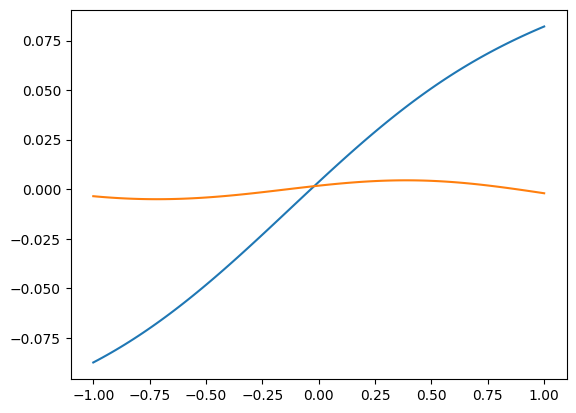

In [19]:
y_final = vmap(model)(x)
fig, ax = plt.subplots()
ax.plot(x, y_init)
ax.plot(x, y_final)